In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Lower_Camp_outlier_2015_realRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc1
# df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Lower_Camp_outlier_2012_borrowedRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc2

In [ ]:
df1.columns

Index(['H2S (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'SO2 (ppb)', 'THC (ppm)', 'Wind Direction',
       'Wind Speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['H2S (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'SO2 (ppb)', 'THC (ppm)', 'Wind Direction',
       'Wind Speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'score', 'sin', 'cos'],
      dtype='object')

In [ ]:
df1_w= df1_w[[
              # 'SO2 (ppb)',
              'THC (ppm)',
              # 'H2S (ppb)', 
              'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed',  'Wind Direction',
       'Wind Speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'score' ]].copy()


In [ ]:
aa = 'THC (ppm)'

In [ ]:
df1_w[[aa,'score']][df1_w[aa] <1.9] 

THC (ppm)      score
Date                                     
2016-03-14 13:00:00        1.8   5.586746
2018-06-26 02:00:00        1.6   5.027273
2018-06-26 03:00:00        0.6   7.588780
2019-03-21 14:00:00        1.8   4.428852
2019-03-21 16:00:00        1.8  10.007133
...                        ...        ...
2020-12-26 23:00:00        1.8   6.619930
2020-12-27 00:00:00        1.8   3.926773
2020-12-27 01:00:00        1.8   8.077778
2020-12-27 02:00:00        1.8   5.040000
2020-12-27 03:00:00        1.8   3.834549

[156 rows x 2 columns]

In [ ]:
df1_w[[aa,'score']][df1_w[aa] <1.8] 
df1_w[df1_w[aa] <1.5] = np.nan
df1_w.dropna(inplace = True)

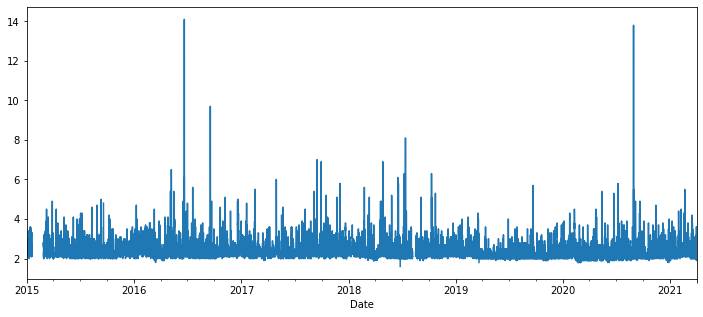

In [ ]:
df1_w[aa].resample('H').mean().plot(figsize = (12,5))

In [ ]:
df1_w.columns

Index(['THC (ppm)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 2*std])/len(df1_w)

0.9697802197802198

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.1, 10000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10000.0),
        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)


        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 100000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 100000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)


        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.000000001000, random_state = 42)


        kf = KFold(n_splits=4)
        acc = 0 
        for train_index, test_index in kf.split(X):   
                X_tr, X_tes = X[train_index], X[test_index]
                y_tr, y_tes =  Y[train_index],  Y[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/5
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_lowercamp_OT_THC_HP_hourly.csv')

[I 2021-05-17 15:27:16,736] A new study created in memory with name: no-name-3176a6dd-a8d2-4ca8-a5b4-d70792437fb6


[0]	validation-rmse:21.5891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:264.142
[2]	validation-rmse:3234.06
[3]	validation-rmse:39598
[4]	validation-rmse:484841
[5]	validation-rmse:5.93644e+06
[6]	validation-rmse:7.26862e+07
[7]	validation-rmse:8.89977e+08
[8]	validation-rmse:1.08969e+10
[9]	validation-rmse:1.33423e+11
[0]	validation-rmse:21.5582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:263.769
[2]	validation-rmse:3229.49
[3]	validation-rmse:39542
[4]	validation-rmse:484156
[5]	validation-rmse:5.92805e+06
[6]	validation-rmse:7.25835e+07
[7]	validation-rmse:8.88719e+08
[8]	validation-rmse:1.08816e+10
[9]	validation-rmse:1.33235e+11
[0]	validation-rmse:22.0071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:269.206
[2]	validation-rmse:3296.12
[3]	validation-rmse:40357.7
[4]	validation-rmse:494143
[5]	validation-rmse:6.05033e+06
[6]	validation-rmse:7.40808e+07
[7]	validation

[I 2021-05-17 15:27:17,953] Trial 0 finished with value: 1.454674743275393e+22 and parameters: {'booster': 'gbtree', 'lambda': 3359.5669033780937, 'alpha': 302.45131581869657, 'score': 22.951404164278117, 'max_depth': 4, 'eta': 14.792578955241305, 'gamma': 17896.488195863712, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 1.454674743275393e+22.


1.454674743275393e+22
[0]	validation-rmse:1830.04
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.88654e+06
[2]	validation-rmse:1.94479e+09
[3]	validation-rmse:2.00484e+12
[4]	validation-rmse:2.06674e+15
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1827.48
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.8839e+06
[2]	validation-rmse:1.94207e+09
[3]	validation-rmse:2.00204e+12
[4]	validation-rmse:2.06385e+15
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1864.67
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.92223e+06
[2]	validation-rmse:1.98159e+09
[3]	validation-rmse:2.04277e+12
[4]	validation-rmse:2.10585e+15
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	valida

[I 2021-05-17 15:27:18,506] Trial 1 finished with value: 4.72999871095989e+60 and parameters: {'booster': 'gbtree', 'lambda': 2.869399412425508, 'alpha': 1.0586955537943556, 'score': 26.201810426783727, 'max_depth': 7, 'eta': 1031.9797692609782, 'gamma': 21121.831626430794, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 1.454674743275393e+22.


4.72999871095989e+60
[0]	validation-rmse:1382.96
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.07977e+06
[2]	validation-rmse:8.43048e+08
[3]	validation-rmse:6.58225e+11
[4]	validation-rmse:5.13921e+14
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1381.78
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.07885e+06
[2]	validation-rmse:8.4233e+08
[3]	validation-rmse:6.57664e+11
[4]	validation-rmse:5.13483e+14
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1409.49
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.10048e+06
[2]	validation-rmse:8.59222e+08
[3]	validation-rmse:6.70852e+11
[4]	validation-rmse:5.2378e+14
[5]	validation-rmse:inf
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validati

[I 2021-05-17 15:27:19,010] Trial 2 finished with value: 1.8176431606895424e+58 and parameters: {'booster': 'gbtree', 'lambda': 33.17886379931092, 'alpha': 55.17184093141475, 'score': 18.69477733363065, 'max_depth': 1, 'eta': 782.6768465039629, 'gamma': 12271.812317370772, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 1.454674743275393e+22.


1.8176431606895424e+58
[0]	validation-rmse:99.0581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5536.35
[2]	validation-rmse:309425
[3]	validation-rmse:1.72937e+07
[4]	validation-rmse:9.66542e+08
[5]	validation-rmse:5.40199e+10
[6]	validation-rmse:3.01916e+12
[7]	validation-rmse:1.6874e+14
[8]	validation-rmse:9.43087e+15
[9]	validation-rmse:inf
[0]	validation-rmse:98.9576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5530.76
[2]	validation-rmse:309113
[3]	validation-rmse:1.72763e+07
[4]	validation-rmse:9.65567e+08
[5]	validation-rmse:5.39654e+10
[6]	validation-rmse:3.01612e+12
[7]	validation-rmse:1.6857e+14
[8]	validation-rmse:9.42136e+15
[9]	validation-rmse:inf
[0]	validation-rmse:100.901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5639.55
[2]	validation-rmse:315193
[3]	validation-rmse:1.76161e+07
[4]	validation-rmse:9.84562e+08
[5]	validation-rmse:5.50271e+10
[6]	validatio

[I 2021-05-17 15:27:19,613] Trial 3 finished with value: 2.270100790920316e+35 and parameters: {'booster': 'gbtree', 'lambda': 2.0189395819022686, 'alpha': 29.73451124378873, 'score': 21.55951500935521, 'max_depth': 6, 'eta': 56.89772535980799, 'gamma': 27.999738988673535, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 1.454674743275393e+22.


2.270100790920316e+35
[0]	validation-rmse:1.36589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.05206
[2]	validation-rmse:0.832288
[3]	validation-rmse:0.680505
[4]	validation-rmse:0.577339
[5]	validation-rmse:0.508258
[6]	validation-rmse:0.462484
[7]	validation-rmse:0.432269
[8]	validation-rmse:0.412264
[9]	validation-rmse:0.398911
[0]	validation-rmse:1.35692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.04263
[2]	validation-rmse:0.822329
[3]	validation-rmse:0.670025
[4]	validation-rmse:0.566412
[5]	validation-rmse:0.497002
[6]	validation-rmse:0.451024
[7]	validation-rmse:0.420708
[8]	validation-rmse:0.40067
[9]	validation-rmse:0.387322
[0]	validation-rmse:1.38327
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.06262
[2]	validation-rmse:0.838117
[3]	validation-rmse:0.683197
[4]	validation-rmse:0.578076
[5]	validation-rmse:0.507889
[6]	validation-rmse:0.461574
[7]	validatio

[I 2021-05-17 15:27:20,222] Trial 4 finished with value: 0.13109404278803966 and parameters: {'booster': 'gbtree', 'lambda': 2447.051929311518, 'alpha': 4301.879532216929, 'score': 19.55864489197667, 'max_depth': 6, 'eta': 0.30380252164232696, 'gamma': 0.16280732069612, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.13109404278803966.


0.13109404278803966


[I 2021-05-17 15:27:20,275] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:1.18408
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.807157
[2]	validation-rmse:0.583167
[3]	validation-rmse:0.456694
[4]	validation-rmse:0.389387
[5]	validation-rmse:0.35513
[6]	validation-rmse:0.337933
[7]	validation-rmse:0.329162
[8]	validation-rmse:0.324535
[9]	validation-rmse:0.321994
[0]	validation-rmse:1.19223
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.819112
[2]	validation-rmse:0.599125
[3]	validation-rmse:0.476256
[4]	validation-rmse:0.411558
[5]	validation-rmse:0.378843
[6]	validation-rmse:0.362442
[7]	validation-rmse:0.350656
[8]	validation-rmse:0.346263
[9]	validation-rmse:0.343836
[0]	validation-rmse:1.21475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.834604
[2]	validation-rmse:0.611061
[3]	validation-rmse:0.486792
[4]	validation-rmse:0.421806
[5]	validation-rmse:0.38922
[6]	validation-rmse:0.37303
[7]	validation-rmse:0.361125
[8]	v

[I 2021-05-17 15:27:20,904] Trial 6 finished with value: 0.0983613484315332 and parameters: {'booster': 'gbtree', 'lambda': 0.9736558279233246, 'alpha': 1764.884048499713, 'score': 23.51954784468726, 'max_depth': 2, 'eta': 0.36687228125988564, 'gamma': 58.690455090588216, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.0983613484315332.


[I 2021-05-17 15:27:20,953] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.849423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.489787
[2]	validation-rmse:0.36896
[3]	validation-rmse:0.34604
[4]	validation-rmse:0.338736
[5]	validation-rmse:0.33845
[6]	validation-rmse:0.337877
[7]	validation-rmse:0.337993
[8]	validation-rmse:0.337915
[9]	validation-rmse:0.337944
[0]	validation-rmse:0.854918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.504399
[2]	validation-rmse:0.385942
[3]	validation-rmse:0.365288
[4]	validation-rmse:0.357869
[5]	validation-rmse:0.357829
[6]	validation-rmse:0.357185
[7]	validation-rmse:0.35734
[8]	validation-rmse:0.357247
[9]	validation-rmse:0.357283
[0]	validation-rmse:0.873028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.5078
[2]	validation-rmse:0.389675
[3]	validation-rmse:0.366111
[4]	validation-rmse:0.35943
[5]	validation-rmse:0.358934
[6]	validation-rmse:0.358469
[7]	validation-rmse:0.35854
[8]	val

[I 2021-05-17 15:27:21,599] Trial 8 finished with value: 0.09185897753107561 and parameters: {'booster': 'gbtree', 'lambda': 0.36047099920694387, 'alpha': 0.2378849700810525, 'score': 15.407237648331622, 'max_depth': 2, 'eta': 1.443467580938262, 'gamma': 363.71428705940207, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 0.09185897753107561.


0.09185897753107561


[I 2021-05-17 15:27:21,647] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.10558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:14.6267
[2]	validation-rmse:42.0002
[3]	validation-rmse:120.6
[4]	validation-rmse:346.329
[5]	validation-rmse:994.535
[6]	validation-rmse:2855.98
[7]	validation-rmse:8201.43
[8]	validation-rmse:23551.8
[9]	validation-rmse:67633
[0]	validation-rmse:5.09901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:14.6146
[2]	validation-rmse:41.9541
[3]	validation-rmse:120.477
[4]	validation-rmse:345.967
[5]	validation-rmse:993.505
[6]	validation-rmse:2853.01
[7]	validation-rmse:8192.92
[8]	validation-rmse:23527.3
[9]	validation-rmse:67562.8
[0]	validation-rmse:5.20051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:14.9022
[2]	validation-rmse:42.7818
[3]	validation-rmse:122.852
[4]	validation-rmse:352.787
[5]	validation-rmse:1013.09
[6]	validation-rmse:2909.26
[7]	validation-rmse:8354.42
[8]	validation-rmse:23991.1
[9]

[I 2021-05-17 15:27:22,333] Trial 10 finished with value: 3737200165.3888903 and parameters: {'booster': 'gbtree', 'lambda': 0.21946095767797255, 'alpha': 1.7671111728203905, 'score': 15.823403420068695, 'max_depth': 10, 'eta': 3.8716998172935524, 'gamma': 800.2518223866139, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 0.09185897753107561.


3737200165.3888903
[0]	validation-rmse:1.30544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.960307
[2]	validation-rmse:0.721195
[3]	validation-rmse:0.560022
[4]	validation-rmse:0.455785
[5]	validation-rmse:0.391875
[6]	validation-rmse:0.354876
[7]	validation-rmse:0.334529
[8]	validation-rmse:0.323781
[9]	validation-rmse:0.318274
[0]	validation-rmse:1.30629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.962688
[2]	validation-rmse:0.725205
[3]	validation-rmse:0.565743
[4]	validation-rmse:0.463158
[5]	validation-rmse:0.400648
[6]	validation-rmse:0.364671
[7]	validation-rmse:0.344976
[8]	validation-rmse:0.334605
[9]	validation-rmse:0.329304
[0]	validation-rmse:1.33474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.984564
[2]	validation-rmse:0.74262
[3]	validation-rmse:0.580215
[4]	validation-rmse:0.475746
[5]	validation-rmse:0.412046
[6]	validation-rmse:0.375312
[7]	validatio

[I 2021-05-17 15:27:23,244] Trial 11 finished with value: 0.09743968012585971 and parameters: {'booster': 'gbtree', 'lambda': 1.4027437728073557, 'alpha': 0.1040267691067155, 'score': 25.77449675554597, 'max_depth': 4, 'eta': 0.28193482477098747, 'gamma': 740.3426308463054, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 0.09185897753107561.


0.09743968012585971
[0]	validation-rmse:1.62709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.46964
[2]	validation-rmse:1.32883
[3]	validation-rmse:1.20306
[4]	validation-rmse:1.09087
[5]	validation-rmse:0.990969
[6]	validation-rmse:0.902189
[7]	validation-rmse:0.823479
[8]	validation-rmse:0.753893
[9]	validation-rmse:0.692571
[0]	validation-rmse:1.62451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.4675
[2]	validation-rmse:1.32715
[3]	validation-rmse:1.20184
[4]	validation-rmse:1.09014
[5]	validation-rmse:0.990741
[6]	validation-rmse:0.902489
[7]	validation-rmse:0.824332
[8]	validation-rmse:0.755321
[9]	validation-rmse:0.694595
[0]	validation-rmse:1.65669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.49667
[2]	validation-rmse:1.35365
[3]	validation-rmse:1.22601
[4]	validation-rmse:1.11227
[5]	validation-rmse:1.01111
[6]	validation-rmse:0.921347
[7]	validation-rmse:0.841

[I 2021-05-17 15:27:24,149] Trial 12 finished with value: 0.39863630104662956 and parameters: {'booster': 'gbtree', 'lambda': 10.061407524729248, 'alpha': 0.10821455573027124, 'score': 27.444680892650606, 'max_depth': 4, 'eta': 0.1010253504072815, 'gamma': 877.2318966294006, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 0.09185897753107561.


0.39863630104662956
[0]	validation-rmse:1.56303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.35435
[2]	validation-rmse:1.17997
[3]	validation-rmse:1.02764
[4]	validation-rmse:0.902112
[5]	validation-rmse:0.792361
[6]	validation-rmse:0.703734
[7]	validation-rmse:0.626291
[8]	validation-rmse:0.565521
[9]	validation-rmse:0.512491
[0]	validation-rmse:1.56411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.35016
[2]	validation-rmse:1.18141
[3]	validation-rmse:1.02386
[4]	validation-rmse:0.903751
[5]	validation-rmse:0.788912
[6]	validation-rmse:0.705444
[7]	validation-rmse:0.623165
[8]	validation-rmse:0.567174
[9]	validation-rmse:0.509702
[0]	validation-rmse:1.59737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.37726
[2]	validation-rmse:1.20724
[3]	validation-rmse:1.04474
[4]	validation-rmse:0.924319
[5]	validation-rmse:0.8055
[6]	validation-rmse:0.722393
[7]	validation-rmse:0.

[I 2021-05-17 15:27:25,083] Trial 13 finished with value: 0.22312906855838988 and parameters: {'booster': 'gbtree', 'lambda': 0.14444185247742614, 'alpha': 0.8804782132794152, 'score': 25.642237291793425, 'max_depth': 4, 'eta': 1.8613833341904826, 'gamma': 791.9075434993589, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 0.09185897753107561.


0.22312906855838988
[0]	validation-rmse:0.341345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321931
[2]	validation-rmse:0.3218
[3]	validation-rmse:0.321796
[4]	validation-rmse:0.321796
[5]	validation-rmse:0.321796
[6]	validation-rmse:0.321796
[7]	validation-rmse:0.321796
[8]	validation-rmse:0.321796
[9]	validation-rmse:0.321796
[0]	validation-rmse:0.333657
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315447
[2]	validation-rmse:0.315417
[3]	validation-rmse:0.315419
[4]	validation-rmse:0.31542
[5]	validation-rmse:0.31542
[6]	validation-rmse:0.31542
[7]	validation-rmse:0.31542
[8]	validation-rmse:0.31542
[9]	validation-rmse:0.31542
[0]	validation-rmse:0.351845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.334168
[2]	validation-rmse:0.334155
[3]	validation-rmse:0.334158
[4]	validation-rmse:0.334159
[5]	validation-rmse:0.334159
[6]	validation-rmse:0.334159
[7]	validation-r

[I 2021-05-17 15:27:26,668] Trial 14 finished with value: 0.09450088796169599 and parameters: {'booster': 'gbtree', 'lambda': 0.6373510583512337, 'alpha': 7.233555047585079, 'score': 28.87542889417508, 'max_depth': 8, 'eta': 0.9373283844000555, 'gamma': 292.6886027989263, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 0.09185897753107561.


0.09450088796169599


[I 2021-05-17 15:27:26,730] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:26,790] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.344391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.323351
[2]	validation-rmse:0.312871
[3]	validation-rmse:0.312868
[4]	validation-rmse:0.312868
[5]	validation-rmse:0.312868
[6]	validation-rmse:0.312868
[7]	validation-rmse:0.312868
[8]	validation-rmse:0.312868
[9]	validation-rmse:0.312868
[0]	validation-rmse:0.342179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321051
[2]	validation-rmse:0.312305
[3]	validation-rmse:0.312302
[4]	validation-rmse:0.312302
[5]	validation-rmse:0.312302
[6]	validation-rmse:0.312302
[7]	validation-rmse:0.312302
[8]	validation-rmse:0.312302
[9]	validation-rmse:0.312302
[0]	validation-rmse:0.356653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.329632
[2]	validation-rmse:0.323828
[3]	validation-rmse:0.323826
[4]	validation-rmse:0.323826
[5]	validation-rmse:0.323826
[6]	validation-rmse:0.323826
[7]	validation-rmse:0.323826

[I 2021-05-17 15:27:28,815] Trial 17 finished with value: 0.08128623049734619 and parameters: {'booster': 'gbtree', 'lambda': 6.508409834874555, 'alpha': 0.2630883015659836, 'score': 20.80305126983921, 'max_depth': 10, 'eta': 1.053532656019025, 'gamma': 104.51592322421901, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.08128623049734619.


0.08128623049734619


[I 2021-05-17 15:27:28,879] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:28,933] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:28,995] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.504334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.346829
[2]	validation-rmse:0.338707
[3]	validation-rmse:0.338594
[4]	validation-rmse:0.338592
[5]	validation-rmse:0.338592
[6]	validation-rmse:0.338592
[7]	validation-rmse:0.338592
[8]	validation-rmse:0.338592
[9]	validation-rmse:0.338592
[0]	validation-rmse:0.504192
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.341953
[2]	validation-rmse:0.334953
[3]	validation-rmse:0.334628
[4]	validation-rmse:0.334628
[5]	validation-rmse:0.334628
[6]	validation-rmse:0.334628
[7]	validation-rmse:0.334628
[8]	validation-rmse:0.334628
[9]	validation-rmse:0.334628
[0]	validation-rmse:0.515324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.345772
[2]	validation-rmse:0.323718
[3]	validation-rmse:0.323122
[4]	validation-rmse:0.323128
[5]	validation-rmse:0.323128
[6]	validation-rmse:0.323128
[7]	validation-rmse:0.323128

[I 2021-05-17 15:27:30,514] Trial 21 finished with value: 0.08947110366027917 and parameters: {'booster': 'gbtree', 'lambda': 0.5555633078746016, 'alpha': 34.37396868887323, 'score': 24.239985226594438, 'max_depth': 8, 'eta': 1.2057474912996364, 'gamma': 143.2359905019552, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.08128623049734619.


0.08947110366027917
[0]	validation-rmse:0.818246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.455174
[2]	validation-rmse:0.347344
[3]	validation-rmse:0.329621
[4]	validation-rmse:0.324543
[5]	validation-rmse:0.324472
[6]	validation-rmse:0.324269
[7]	validation-rmse:0.324269
[8]	validation-rmse:0.324269
[9]	validation-rmse:0.324269
[0]	validation-rmse:0.81898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.440072
[2]	validation-rmse:0.338749
[3]	validation-rmse:0.315647
[4]	validation-rmse:0.312361
[5]	validation-rmse:0.311549
[6]	validation-rmse:0.311536
[7]	validation-rmse:0.311536
[8]	validation-rmse:0.311536
[9]	validation-rmse:0.311536
[0]	validation-rmse:0.841075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.449485
[2]	validation-rmse:0.348845
[3]	validation-rmse:0.324268
[4]	validation-rmse:0.321418
[5]	validation-rmse:0.320412
[6]	validation-rmse:0.320448
[7]	valid

[I 2021-05-17 15:27:32,065] Trial 22 finished with value: 0.08865265987029591 and parameters: {'booster': 'gbtree', 'lambda': 0.10700988314176371, 'alpha': 42.38820264177297, 'score': 24.4166319303984, 'max_depth': 9, 'eta': 1.4238136141063735, 'gamma': 148.66900074453474, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.08128623049734619.


0.08865265987029591


[I 2021-05-17 15:27:32,124] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.794418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.453166
[2]	validation-rmse:0.362501
[3]	validation-rmse:0.336506
[4]	validation-rmse:0.326886
[5]	validation-rmse:0.324634
[6]	validation-rmse:0.322598
[7]	validation-rmse:0.322475
[8]	validation-rmse:0.322434
[9]	validation-rmse:0.322419
[0]	validation-rmse:0.792509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.451106
[2]	validation-rmse:0.360781
[3]	validation-rmse:0.335106
[4]	validation-rmse:0.325812
[5]	validation-rmse:0.32251
[6]	validation-rmse:0.32106
[7]	validation-rmse:0.320943
[8]	validation-rmse:0.319644
[9]	validation-rmse:0.31963
[0]	validation-rmse:0.799774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.45086
[2]	validation-rmse:0.360145
[3]	validation-rmse:0.331538
[4]	validation-rmse:0.324973
[5]	validation-rmse:0.31963
[6]	validation-rmse:0.318415
[7]	validation-rmse:0.316651
[8]	

[I 2021-05-17 15:27:33,436] Trial 24 finished with value: 0.07636899553258913 and parameters: {'booster': 'gbtree', 'lambda': 0.1169278344247119, 'alpha': 132.0029652112943, 'score': 21.55539937177038, 'max_depth': 9, 'eta': 0.6055231800301429, 'gamma': 8.703422188432777, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.07636899553258913.


[I 2021-05-17 15:27:33,494] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.908769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.521354
[2]	validation-rmse:0.37826
[3]	validation-rmse:0.327909
[4]	validation-rmse:0.310367
[5]	validation-rmse:0.302239
[6]	validation-rmse:0.298642
[7]	validation-rmse:0.29659
[8]	validation-rmse:0.294405
[9]	validation-rmse:0.293426
[0]	validation-rmse:0.917123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.538911
[2]	validation-rmse:0.403666
[3]	validation-rmse:0.356524
[4]	validation-rmse:0.340524
[5]	validation-rmse:0.333236
[6]	validation-rmse:0.32979
[7]	validation-rmse:0.328117
[8]	validation-rmse:0.325453
[9]	validation-rmse:0.324039
[0]	validation-rmse:0.935031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.551056
[2]	validation-rmse:0.41535
[3]	validation-rmse:0.366227
[4]	validation-rmse:0.350502
[5]	validation-rmse:0.34263
[6]	validation-rmse:0.339392
[7]	validation-rmse:0.33708
[8]	v

[I 2021-05-17 15:27:34,763] Trial 26 finished with value: 0.07474666950134612 and parameters: {'booster': 'gbtree', 'lambda': 21.056468275847347, 'alpha': 123.62222674928236, 'score': 19.95946681010094, 'max_depth': 9, 'eta': 0.5285489654977173, 'gamma': 1.1523578476291516, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.07474666950134612
[0]	validation-rmse:1.06498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.667494
[2]	validation-rmse:0.468882
[3]	validation-rmse:0.380434
[4]	validation-rmse:0.339285
[5]	validation-rmse:0.317539
[6]	validation-rmse:0.305551
[7]	validation-rmse:0.297655
[8]	validation-rmse:0.293713
[9]	validation-rmse:0.291315
[0]	validation-rmse:1.06848
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.676114
[2]	validation-rmse:0.483237
[3]	validation-rmse:0.3994
[4]	validation-rmse:0.360183
[5]	validation-rmse:0.340788
[6]	validation-rmse:0.329884
[7]	validation-rmse:0.324651
[8]	validation-rmse:0.320189
[9]	validation-rmse:0.31828
[0]	validation-rmse:1.0999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.704463
[2]	validation-rmse:0.512612
[3]	validation-rmse:0.429762
[4]	validation-rmse:0.392288
[5]	validation-rmse:0.374759
[6]	validation-rmse:0.365362
[7]	validation-

[I 2021-05-17 15:27:35,741] Trial 27 finished with value: 0.08103882953656526 and parameters: {'booster': 'gbtree', 'lambda': 29.842174150514072, 'alpha': 592.7921758458548, 'score': 19.94253859050934, 'max_depth': 7, 'eta': 0.4340039217097114, 'gamma': 1.3300302444710397, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


[0]	validation-rmse:1.13581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.747574
[2]	validation-rmse:0.535857
[3]	validation-rmse:0.429251
[4]	validation-rmse:0.378373
[5]	validation-rmse:0.35222
[6]	validation-rmse:0.337352
[7]	validation-rmse:0.326991
[8]	validation-rmse:0.321146
[9]	validation-rmse:0.317763
[0]	validation-rmse:1.12811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.739804
[2]	validation-rmse:0.528231
[3]	validation-rmse:0.422111
[4]	validation-rmse:0.370795
[5]	validation-rmse:0.344346
[6]	validation-rmse:0.330155
[7]	validation-rmse:0.320533
[8]	validation-rmse:0.315341
[9]	validation-rmse:0.311824
[0]	validation-rmse:1.14593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.750039
[2]	validation-rmse:0.534963
[3]	validation-rmse:0.427819
[4]	validation-rmse:0.375905
[5]	validation-rmse:0.350525
[6]	validation-rmse:0.336769
[7]	validation-rmse:0.327506
[8]

[I 2021-05-17 15:27:36,674] Trial 28 finished with value: 0.08567474956035068 and parameters: {'booster': 'gbtree', 'lambda': 128.28209786797038, 'alpha': 949.8525788436655, 'score': 19.524180092222373, 'max_depth': 7, 'eta': 0.40163690739120284, 'gamma': 0.9876923876690544, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.08567474956035068


[I 2021-05-17 15:27:36,740] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:36,796] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:36,856] Trial 31 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.579424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.35283
[2]	validation-rmse:0.317322
[3]	validation-rmse:0.310831
[4]	validation-rmse:0.309534
[5]	validation-rmse:0.309228
[6]	validation-rmse:0.309152
[7]	validation-rmse:0.309133
[8]	validation-rmse:0.309128
[9]	validation-rmse:0.309127
[0]	validation-rmse:0.580057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.354588
[2]	validation-rmse:0.318571
[3]	validation-rmse:0.308427
[4]	validation-rmse:0.308107
[5]	validation-rmse:0.308027
[6]	validation-rmse:0.308007
[7]	validation-rmse:0.308002
[8]	validation-rmse:0.308001
[9]	validation-rmse:0.308001
[0]	validation-rmse:0.588295
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.359656
[2]	validation-rmse:0.323615
[3]	validation-rmse:0.313528
[4]	validation-rmse:0.313313
[5]	validation-rmse:0.313259
[6]	validation-rmse:0.313246
[7]	validation-rmse:0.313242


[I 2021-05-17 15:27:37,907] Trial 32 finished with value: 0.09201985753361143 and parameters: {'booster': 'gbtree', 'lambda': 12.024515326629944, 'alpha': 1648.666163082961, 'score': 20.61015183791751, 'max_depth': 8, 'eta': 0.7469496602514161, 'gamma': 15.006066199888432, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.09201985753361143
[0]	validation-rmse:0.731196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.395065
[2]	validation-rmse:0.310242
[3]	validation-rmse:0.285402
[4]	validation-rmse:0.279139
[5]	validation-rmse:0.27589
[6]	validation-rmse:0.274159
[7]	validation-rmse:0.272663
[8]	validation-rmse:0.271584
[9]	validation-rmse:0.27155
[0]	validation-rmse:0.754256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.431871
[2]	validation-rmse:0.355035
[3]	validation-rmse:0.332133
[4]	validation-rmse:0.323898
[5]	validation-rmse:0.319671
[6]	validation-rmse:0.316991
[7]	validation-rmse:0.315347
[8]	validation-rmse:0.313646
[9]	validation-rmse:0.312794
[0]	validation-rmse:0.766007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.436993
[2]	validation-rmse:0.355478
[3]	validation-rmse:0.334666
[4]	validation-rmse:0.328643
[5]	validation-rmse:0.325617
[6]	validation-rmse:0.323121
[7]	valida

[I 2021-05-17 15:27:39,263] Trial 33 finished with value: 0.07716579325803136 and parameters: {'booster': 'gbtree', 'lambda': 52.48773150397289, 'alpha': 111.7869250396683, 'score': 18.43485555500154, 'max_depth': 9, 'eta': 0.6319008978559859, 'gamma': 3.790132761442486, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.07716579325803136
[0]	validation-rmse:0.836195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.460978
[2]	validation-rmse:0.338813
[3]	validation-rmse:0.300005
[4]	validation-rmse:0.285454
[5]	validation-rmse:0.279981
[6]	validation-rmse:0.277406
[7]	validation-rmse:0.274314
[8]	validation-rmse:0.271869
[9]	validation-rmse:0.270776
[0]	validation-rmse:0.838684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.464887
[2]	validation-rmse:0.343732
[3]	validation-rmse:0.305022
[4]	validation-rmse:0.291217
[5]	validation-rmse:0.28379
[6]	validation-rmse:0.279444
[7]	validation-rmse:0.27703
[8]	validation-rmse:0.275471
[9]	validation-rmse:0.273422
[0]	validation-rmse:0.849578
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.466688
[2]	validation-rmse:0.343747
[3]	validation-rmse:0.301897
[4]	validation-rmse:0.289504
[5]	validation-rmse:0.283836
[6]	validation-rmse:0.279522
[7]	valida

[I 2021-05-17 15:27:40,419] Trial 34 finished with value: 0.07829319913684457 and parameters: {'booster': 'gbtree', 'lambda': 42.91453324944596, 'alpha': 125.8410247886384, 'score': 17.857154912576622, 'max_depth': 7, 'eta': 0.5665605300292497, 'gamma': 0.311992957182716, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


[I 2021-05-17 15:27:40,482] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:40,537] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:40,593] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.806097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.445374
[2]	validation-rmse:0.336667
[3]	validation-rmse:0.305529
[4]	validation-rmse:0.293246
[5]	validation-rmse:0.283899
[6]	validation-rmse:0.283753
[7]	validation-rmse:0.283703
[8]	validation-rmse:0.283684
[9]	validation-rmse:0.283676
[0]	validation-rmse:0.812027
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.456153
[2]	validation-rmse:0.350208
[3]	validation-rmse:0.321197
[4]	validation-rmse:0.306456
[5]	validation-rmse:0.302562
[6]	validation-rmse:0.297622
[7]	validation-rmse:0.297622
[8]	validation-rmse:0.297622
[9]	validation-rmse:0.297622
[0]	validation-rmse:0.820642
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.455054
[2]	validation-rmse:0.34612
[3]	validation-rmse:0.317733
[4]	validation-rmse:0.301816
[5]	validation-rmse:0.295862
[6]	validation-rmse:0.295772
[7]	validation-rmse:0.295743


[I 2021-05-17 15:27:41,629] Trial 38 finished with value: 0.07919041378674642 and parameters: {'booster': 'gbtree', 'lambda': 62.04162002365834, 'alpha': 318.0398973719458, 'score': 19.19668336247726, 'max_depth': 6, 'eta': 0.5865486892823274, 'gamma': 31.95641074344838, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.07919041378674642


[I 2021-05-17 15:27:41,690] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:41,750] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.86879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.487822
[2]	validation-rmse:0.353037
[3]	validation-rmse:0.310764
[4]	validation-rmse:0.292351
[5]	validation-rmse:0.28477
[6]	validation-rmse:0.28444
[7]	validation-rmse:0.284335
[8]	validation-rmse:0.284297
[9]	validation-rmse:0.284282
[0]	validation-rmse:0.874231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.497719
[2]	validation-rmse:0.365986
[3]	validation-rmse:0.326141
[4]	validation-rmse:0.307104
[5]	validation-rmse:0.299384
[6]	validation-rmse:0.296437
[7]	validation-rmse:0.296395
[8]	validation-rmse:0.29638
[9]	validation-rmse:0.296373
[0]	validation-rmse:0.884402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.497914
[2]	validation-rmse:0.362383
[3]	validation-rmse:0.322733
[4]	validation-rmse:0.303412
[5]	validation-rmse:0.295931
[6]	validation-rmse:0.295485
[7]	validation-rmse:0.295369
[8]

[I 2021-05-17 15:27:42,860] Trial 41 finished with value: 0.07807340746500376 and parameters: {'booster': 'gbtree', 'lambda': 63.708302603135756, 'alpha': 227.97904732332753, 'score': 19.189102634246943, 'max_depth': 7, 'eta': 0.547104378837061, 'gamma': 33.32184204325585, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.07807340746500376


[I 2021-05-17 15:27:42,919] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.909674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.523415
[2]	validation-rmse:0.382489
[3]	validation-rmse:0.329266
[4]	validation-rmse:0.307939
[5]	validation-rmse:0.297592
[6]	validation-rmse:0.290456
[7]	validation-rmse:0.288854
[8]	validation-rmse:0.287152
[9]	validation-rmse:0.287152
[0]	validation-rmse:0.910065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.525703
[2]	validation-rmse:0.386282
[3]	validation-rmse:0.333318
[4]	validation-rmse:0.312186
[5]	validation-rmse:0.301799
[6]	validation-rmse:0.295294
[7]	validation-rmse:0.293679
[8]	validation-rmse:0.293657
[9]	validation-rmse:0.291993
[0]	validation-rmse:0.923982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.531938
[2]	validation-rmse:0.390369
[3]	validation-rmse:0.337054
[4]	validation-rmse:0.318758
[5]	validation-rmse:0.310009
[6]	validation-rmse:0.30287
[7]	validation-rmse:0.300792


[I 2021-05-17 15:27:44,038] Trial 43 finished with value: 0.07660627951488073 and parameters: {'booster': 'gbtree', 'lambda': 103.49223071832758, 'alpha': 338.8356053082274, 'score': 19.3388767361857, 'max_depth': 8, 'eta': 0.528647286695834, 'gamma': 7.26389265059366, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.07474666950134612.


0.07660627951488073


[I 2021-05-17 15:27:44,094] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:44,156] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:44,220] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:44,278] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:44,349] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.610407
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.343176
[2]	validation-rmse:0.289596
[3]	validation-rmse:0.277076
[4]	validation-rmse:0.274139
[5]	validation-rmse:0.269924
[6]	validation-rmse:0.268741
[7]	validation-rmse:0.267887
[8]	validation-rmse:0.266226
[9]	validation-rmse:0.266229
[0]	validation-rmse:0.60987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.3431
[2]	validation-rmse:0.291322
[3]	validation-rmse:0.278141
[4]	validation-rmse:0.272151
[5]	validation-rmse:0.270186
[6]	validation-rmse:0.267948
[7]	validation-rmse:0.266935
[8]	validation-rmse:0.265182
[9]	validation-rmse:0.264096
[0]	validation-rmse:0.622269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.353749
[2]	validation-rmse:0.300965
[3]	validation-rmse:0.28963
[4]	validation-rmse:0.28343
[5]	validation-rmse:0.280568
[6]	validation-rmse:0.279123
[7]	validation-rmse:0.279093
[8]	

[I 2021-05-17 15:27:45,700] Trial 49 finished with value: 0.07369388932195137 and parameters: {'booster': 'gbtree', 'lambda': 86.26817042887852, 'alpha': 69.66022967687752, 'score': 18.916280430166694, 'max_depth': 8, 'eta': 0.7082727065097206, 'gamma': 2.7031776551390108, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07369388932195137


[I 2021-05-17 15:27:45,763] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298824
[2]	validation-rmse:0.288028
[3]	validation-rmse:0.280285
[4]	validation-rmse:0.280285
[5]	validation-rmse:0.280285
[6]	validation-rmse:0.280285
[7]	validation-rmse:0.280285
[8]	validation-rmse:0.280285
[9]	validation-rmse:0.280285
[0]	validation-rmse:0.335384
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297968
[2]	validation-rmse:0.286891
[3]	validation-rmse:0.279106
[4]	validation-rmse:0.279106
[5]	validation-rmse:0.279106
[6]	validation-rmse:0.279106
[7]	validation-rmse:0.279106
[8]	validation-rmse:0.279106
[9]	validation-rmse:0.279106
[0]	validation-rmse:0.345593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31061
[2]	validation-rmse:0.300254
[3]	validation-rmse:0.293152
[4]	validation-rmse:0.293152
[5]	validation-rmse:0.293152
[6]	validation-rmse:0.293152
[7]	validation-rmse:0.293152


[I 2021-05-17 15:27:46,977] Trial 51 finished with value: 0.07856389996115189 and parameters: {'booster': 'gbtree', 'lambda': 93.72221749962236, 'alpha': 232.85753355648535, 'score': 18.924626405114026, 'max_depth': 7, 'eta': 0.9475028412986587, 'gamma': 11.249271225613523, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07856389996115189
[0]	validation-rmse:0.814754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.465471
[2]	validation-rmse:0.370262
[3]	validation-rmse:0.338457
[4]	validation-rmse:0.326287
[5]	validation-rmse:0.319752
[6]	validation-rmse:0.313075
[7]	validation-rmse:0.309869
[8]	validation-rmse:0.309124
[9]	validation-rmse:0.308786
[0]	validation-rmse:0.801048
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.44861
[2]	validation-rmse:0.352425
[3]	validation-rmse:0.319099
[4]	validation-rmse:0.306766
[5]	validation-rmse:0.301553
[6]	validation-rmse:0.295508
[7]	validation-rmse:0.292764
[8]	validation-rmse:0.291199
[9]	validation-rmse:0.290255
[0]	validation-rmse:0.818031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.461762
[2]	validation-rmse:0.364724
[3]	validation-rmse:0.33331
[4]	validation-rmse:0.321628
[5]	validation-rmse:0.316427
[6]	validation-rmse:0.310487
[7]	valida

[I 2021-05-17 15:27:48,081] Trial 52 finished with value: 0.07814930442398083 and parameters: {'booster': 'gbtree', 'lambda': 336.06262106297714, 'alpha': 487.55611022970544, 'score': 20.116184605757205, 'max_depth': 8, 'eta': 0.5994348705264502, 'gamma': 0.7680366503349241, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07814930442398083


[I 2021-05-17 15:27:48,141] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:48,198] Trial 54 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.483531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314852
[2]	validation-rmse:0.300858
[3]	validation-rmse:0.294986
[4]	validation-rmse:0.294986
[5]	validation-rmse:0.294986
[6]	validation-rmse:0.294986
[7]	validation-rmse:0.294986
[8]	validation-rmse:0.294986
[9]	validation-rmse:0.294986
[0]	validation-rmse:0.48317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307288
[2]	validation-rmse:0.291265
[3]	validation-rmse:0.287186
[4]	validation-rmse:0.287206
[5]	validation-rmse:0.287206
[6]	validation-rmse:0.287206
[7]	validation-rmse:0.287206
[8]	validation-rmse:0.287206
[9]	validation-rmse:0.287206
[0]	validation-rmse:0.494031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319388
[2]	validation-rmse:0.297173
[3]	validation-rmse:0.294353
[4]	validation-rmse:0.291443
[5]	validation-rmse:0.291431
[6]	validation-rmse:0.291431
[7]	validation-rmse:0.291431


[I 2021-05-17 15:27:49,716] Trial 55 finished with value: 0.08068300408631068 and parameters: {'booster': 'gbtree', 'lambda': 25.169788548806693, 'alpha': 41.92835586291899, 'score': 19.545941839816397, 'max_depth': 8, 'eta': 1.2096499269602983, 'gamma': 9.740047981095497, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.
[I 2021-05-17 15:27:49,775] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.613697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.359779
[2]	validation-rmse:0.312603
[3]	validation-rmse:0.297428
[4]	validation-rmse:0.28954
[5]	validation-rmse:0.286966
[6]	validation-rmse:0.286966
[7]	validation-rmse:0.286966
[8]	validation-rmse:0.286966
[9]	validation-rmse:0.286966
[0]	validation-rmse:0.610021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.355855
[2]	validation-rmse:0.307159
[3]	validation-rmse:0.292358
[4]	validation-rmse:0.284802
[5]	validation-rmse:0.282243
[6]	validation-rmse:0.282243
[7]	validation-rmse:0.282243
[8]	validation-rmse:0.282243
[9]	validation-rmse:0.282243
[0]	validation-rmse:0.621716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.365595
[2]	validation-rmse:0.318814
[3]	validation-rmse:0.306691
[4]	validation-rmse:0.297961
[5]	validation-rmse:0.295807
[6]	validation-rmse:0.293886
[7]	validation-rmse:0.293886


[I 2021-05-17 15:27:50,826] Trial 57 finished with value: 0.07735719481740648 and parameters: {'booster': 'gbtree', 'lambda': 4.415932303153065, 'alpha': 291.90673453846273, 'score': 18.174786696414515, 'max_depth': 6, 'eta': 0.7100390366990328, 'gamma': 5.789742390927848, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07735719481740648


[I 2021-05-17 15:27:50,891] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.426724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312649
[2]	validation-rmse:0.294086
[3]	validation-rmse:0.283354
[4]	validation-rmse:0.281179
[5]	validation-rmse:0.281179
[6]	validation-rmse:0.281179
[7]	validation-rmse:0.281179
[8]	validation-rmse:0.281179
[9]	validation-rmse:0.281179
[0]	validation-rmse:0.433614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319517
[2]	validation-rmse:0.298463
[3]	validation-rmse:0.288663
[4]	validation-rmse:0.287113
[5]	validation-rmse:0.287113
[6]	validation-rmse:0.287113
[7]	validation-rmse:0.287113
[8]	validation-rmse:0.287113
[9]	validation-rmse:0.287113
[0]	validation-rmse:0.438993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.328699
[2]	validation-rmse:0.313425
[3]	validation-rmse:0.306741
[4]	validation-rmse:0.304365
[5]	validation-rmse:0.304365
[6]	validation-rmse:0.304365
[7]	validation-rmse:0.304365

[I 2021-05-17 15:27:51,895] Trial 59 finished with value: 0.07946876193330213 and parameters: {'booster': 'gbtree', 'lambda': 4.644364291536121, 'alpha': 294.88174821564, 'score': 18.588967812006146, 'max_depth': 5, 'eta': 0.8462011710997078, 'gamma': 6.293728429988345, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07946876193330213


[I 2021-05-17 15:27:51,957] Trial 60 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:52,014] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:52,076] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:52,136] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.562435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.345246
[2]	validation-rmse:0.310084
[3]	validation-rmse:0.299107
[4]	validation-rmse:0.295721
[5]	validation-rmse:0.295721
[6]	validation-rmse:0.295721
[7]	validation-rmse:0.295721
[8]	validation-rmse:0.295721
[9]	validation-rmse:0.295721
[0]	validation-rmse:0.551962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.329268
[2]	validation-rmse:0.29343
[3]	validation-rmse:0.282009
[4]	validation-rmse:0.279029
[5]	validation-rmse:0.279029
[6]	validation-rmse:0.279029
[7]	validation-rmse:0.279029
[8]	validation-rmse:0.279029
[9]	validation-rmse:0.279029
[0]	validation-rmse:0.558035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.332321
[2]	validation-rmse:0.299039
[3]	validation-rmse:0.287335
[4]	validation-rmse:0.284455
[5]	validation-rmse:0.284455
[6]	validation-rmse:0.284455
[7]	validation-rmse:0.284455


[I 2021-05-17 15:27:53,404] Trial 64 finished with value: 0.07739475052093743 and parameters: {'booster': 'gbtree', 'lambda': 87.00510753491434, 'alpha': 253.8132310697591, 'score': 18.79538027889302, 'max_depth': 8, 'eta': 0.7492693652942517, 'gamma': 8.925574480866276, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07739475052093743


[I 2021-05-17 15:27:53,473] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:53,535] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.479739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.320145
[2]	validation-rmse:0.295546
[3]	validation-rmse:0.283991
[4]	validation-rmse:0.281776
[5]	validation-rmse:0.2809
[6]	validation-rmse:0.2809
[7]	validation-rmse:0.2809
[8]	validation-rmse:0.2809
[9]	validation-rmse:0.2809
[0]	validation-rmse:0.468567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308763
[2]	validation-rmse:0.281731
[3]	validation-rmse:0.271859
[4]	validation-rmse:0.268271
[5]	validation-rmse:0.264802
[6]	validation-rmse:0.264802
[7]	validation-rmse:0.264802
[8]	validation-rmse:0.264802
[9]	validation-rmse:0.264802
[0]	validation-rmse:0.479059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317731
[2]	validation-rmse:0.290512
[3]	validation-rmse:0.283967
[4]	validation-rmse:0.281097
[5]	validation-rmse:0.278226
[6]	validation-rmse:0.275734
[7]	validation-rmse:0.275729
[8]	valid

[I 2021-05-17 15:27:55,070] Trial 67 finished with value: 0.07613877247205589 and parameters: {'booster': 'gbtree', 'lambda': 27.037568287702953, 'alpha': 146.33451968635416, 'score': 18.747783396241317, 'max_depth': 10, 'eta': 0.80700853506806, 'gamma': 3.3265260388017563, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07613877247205589


[I 2021-05-17 15:27:55,132] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.479126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306868
[2]	validation-rmse:0.293647
[3]	validation-rmse:0.29005
[4]	validation-rmse:0.284734
[5]	validation-rmse:0.281439
[6]	validation-rmse:0.280703
[7]	validation-rmse:0.279674
[8]	validation-rmse:0.278877
[9]	validation-rmse:0.27832
[0]	validation-rmse:0.479882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310314
[2]	validation-rmse:0.296228
[3]	validation-rmse:0.286172
[4]	validation-rmse:0.282368
[5]	validation-rmse:0.279386
[6]	validation-rmse:0.27872
[7]	validation-rmse:0.278714
[8]	validation-rmse:0.278097
[9]	validation-rmse:0.277631
[0]	validation-rmse:0.492987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.327629
[2]	validation-rmse:0.310488
[3]	validation-rmse:0.305239
[4]	validation-rmse:0.302444
[5]	validation-rmse:0.299059
[6]	validation-rmse:0.297845
[7]	validation-rmse:0.294895
[8

[I 2021-05-17 15:27:56,936] Trial 69 finished with value: 0.1360919633372034 and parameters: {'booster': 'gbtree', 'lambda': 6.908985503272715, 'alpha': 30.260947717339402, 'score': 20.978655724005385, 'max_depth': 10, 'eta': 1.2009792282331713, 'gamma': 0.5666771037154658, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.1360919633372034


[I 2021-05-17 15:27:57,000] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.652187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.372002
[2]	validation-rmse:0.315146
[3]	validation-rmse:0.298895
[4]	validation-rmse:0.294702
[5]	validation-rmse:0.293602
[6]	validation-rmse:0.293602
[7]	validation-rmse:0.293602
[8]	validation-rmse:0.293602
[9]	validation-rmse:0.293602
[0]	validation-rmse:0.647521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.367748
[2]	validation-rmse:0.312612
[3]	validation-rmse:0.29669
[4]	validation-rmse:0.293045
[5]	validation-rmse:0.288902
[6]	validation-rmse:0.288353
[7]	validation-rmse:0.288353
[8]	validation-rmse:0.288353
[9]	validation-rmse:0.288353
[0]	validation-rmse:0.661308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.378892
[2]	validation-rmse:0.322215
[3]	validation-rmse:0.308856
[4]	validation-rmse:0.305952
[5]	validation-rmse:0.302974
[6]	validation-rmse:0.302974
[7]	validation-rmse:0.302974


[I 2021-05-17 15:27:58,455] Trial 71 finished with value: 0.07761413715501969 and parameters: {'booster': 'gbtree', 'lambda': 86.80876054521556, 'alpha': 85.20552102607233, 'score': 17.669504805774313, 'max_depth': 9, 'eta': 0.6912632279727645, 'gamma': 7.789645353172094, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07761413715501969
[0]	validation-rmse:0.329401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303116
[2]	validation-rmse:0.292485
[3]	validation-rmse:0.284761
[4]	validation-rmse:0.284761
[5]	validation-rmse:0.284761
[6]	validation-rmse:0.284761
[7]	validation-rmse:0.284761
[8]	validation-rmse:0.284761
[9]	validation-rmse:0.284761
[0]	validation-rmse:0.317286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289556
[2]	validation-rmse:0.279197
[3]	validation-rmse:0.270803
[4]	validation-rmse:0.270803
[5]	validation-rmse:0.270803
[6]	validation-rmse:0.270803
[7]	validation-rmse:0.270803
[8]	validation-rmse:0.270803
[9]	validation-rmse:0.270803
[0]	validation-rmse:0.327703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298688
[2]	validation-rmse:0.286497
[3]	validation-rmse:0.284216
[4]	validation-rmse:0.284216
[5]	validation-rmse:0.284216
[6]	validation-rmse:0.284216
[7]	vali

[I 2021-05-17 15:27:59,782] Trial 72 finished with value: 0.07764224430398342 and parameters: {'booster': 'gbtree', 'lambda': 57.757221644596164, 'alpha': 278.76244932560724, 'score': 18.75539656346721, 'max_depth': 8, 'eta': 0.9814929835082961, 'gamma': 4.237427826249859, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07764224430398342


[I 2021-05-17 15:27:59,851] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:27:59,914] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.799598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.422711
[2]	validation-rmse:0.317994
[3]	validation-rmse:0.293888
[4]	validation-rmse:0.288128
[5]	validation-rmse:0.282556
[6]	validation-rmse:0.282326
[7]	validation-rmse:0.282326
[8]	validation-rmse:0.282326
[9]	validation-rmse:0.282326
[0]	validation-rmse:0.799704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.42162
[2]	validation-rmse:0.319344
[3]	validation-rmse:0.29478
[4]	validation-rmse:0.289001
[5]	validation-rmse:0.28876
[6]	validation-rmse:0.28876
[7]	validation-rmse:0.28876
[8]	validation-rmse:0.28876
[9]	validation-rmse:0.28876
[0]	validation-rmse:0.819992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.434743
[2]	validation-rmse:0.326481
[3]	validation-rmse:0.302771
[4]	validation-rmse:0.294704
[5]	validation-rmse:0.294466
[6]	validation-rmse:0.294466
[7]	validation-rmse:0.294466
[8]	va

[I 2021-05-17 15:28:01,280] Trial 75 finished with value: 0.08408544425875225 and parameters: {'booster': 'gbtree', 'lambda': 4.506337877992009, 'alpha': 93.28289393140308, 'score': 18.918534019090405, 'max_depth': 8, 'eta': 1.4149372206965498, 'gamma': 22.865396531813143, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


[I 2021-05-17 15:28:01,344] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.636006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.382376
[2]	validation-rmse:0.335347
[3]	validation-rmse:0.321084


[I 2021-05-17 15:28:01,505] Trial 77 pruned. Trial was pruned at iteration 4.
[I 2021-05-17 15:28:01,565] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:01,624] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:01,684] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.630413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.35534
[2]	validation-rmse:0.299647
[3]	validation-rmse:0.28702
[4]	validation-rmse:0.284871
[5]	validation-rmse:0.283843
[6]	validation-rmse:0.281073
[7]	validation-rmse:0.279204
[8]	validation-rmse:0.2792
[9]	validation-rmse:0.279199
[0]	validation-rmse:0.631852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.355061
[2]	validation-rmse:0.300886
[3]	validation-rmse:0.283103
[4]	validation-rmse:0.281234
[5]	validation-rmse:0.276711
[6]	validation-rmse:0.276134
[7]	validation-rmse:0.276134
[8]	validation-rmse:0.276134
[9]	validation-rmse:0.276134
[0]	validation-rmse:0.643367
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.363087
[2]	validation-rmse:0.30647
[3]	validation-rmse:0.293902
[4]	validation-rmse:0.29094
[5]	validation-rmse:0.287498
[6]	validation-rmse:0.285439
[7]	validation-rmse:0.285439
[8]	v

[I 2021-05-17 15:28:03,233] Trial 81 finished with value: 0.0758416061667166 and parameters: {'booster': 'gbtree', 'lambda': 82.1008217033934, 'alpha': 67.77600688283022, 'score': 17.771322468705836, 'max_depth': 9, 'eta': 0.6981249524116591, 'gamma': 8.064776218369573, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.0758416061667166


[I 2021-05-17 15:28:03,298] Trial 82 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.424276
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306291
[2]	validation-rmse:0.287535
[3]	validation-rmse:0.278983
[4]	validation-rmse:0.278969
[5]	validation-rmse:0.278967
[6]	validation-rmse:0.278966
[7]	validation-rmse:0.278966
[8]	validation-rmse:0.278966
[9]	validation-rmse:0.278966
[0]	validation-rmse:0.424279
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306849
[2]	validation-rmse:0.288773
[3]	validation-rmse:0.280469
[4]	validation-rmse:0.280443
[5]	validation-rmse:0.280441
[6]	validation-rmse:0.28044
[7]	validation-rmse:0.28044
[8]	validation-rmse:0.28044
[9]	validation-rmse:0.28044
[0]	validation-rmse:0.434467
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.318323
[2]	validation-rmse:0.298307
[3]	validation-rmse:0.294097
[4]	validation-rmse:0.294097
[5]	validation-rmse:0.294097
[6]	validation-rmse:0.294097
[7]	validation-rmse:0.294097
[8]

[I 2021-05-17 15:28:04,810] Trial 83 finished with value: 0.07781769806538136 and parameters: {'booster': 'gbtree', 'lambda': 198.61458705672845, 'alpha': 138.1862002086473, 'score': 18.92054783284074, 'max_depth': 9, 'eta': 0.8487763827506118, 'gamma': 14.24493737666961, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07781769806538136


[I 2021-05-17 15:28:04,872] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.689521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.379229
[2]	validation-rmse:0.310628
[3]	validation-rmse:0.299932
[4]	validation-rmse:0.293692
[5]	validation-rmse:0.293692
[6]	validation-rmse:0.293692
[7]	validation-rmse:0.293692
[8]	validation-rmse:0.293692
[9]	validation-rmse:0.293692
[0]	validation-rmse:0.700764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.404297
[2]	validation-rmse:0.337464
[3]	validation-rmse:0.325541
[4]	validation-rmse:0.316311
[5]	validation-rmse:0.316311
[6]	validation-rmse:0.316311
[7]	validation-rmse:0.316311
[8]	validation-rmse:0.316311
[9]	validation-rmse:0.316311
[0]	validation-rmse:0.706892
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.39389
[2]	validation-rmse:0.323905
[3]	validation-rmse:0.311838
[4]	validation-rmse:0.306432
[5]	validation-rmse:0.306432
[6]	validation-rmse:0.306432
[7]	validation-rmse:0.306432


[I 2021-05-17 15:28:06,266] Trial 85 finished with value: 0.08533447609542102 and parameters: {'booster': 'gbtree', 'lambda': 80.15918485838992, 'alpha': 217.50425663393645, 'score': 18.13578626904182, 'max_depth': 10, 'eta': 1.3530089582711071, 'gamma': 10.769226782151563, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.08533447609542102


[I 2021-05-17 15:28:06,331] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:06,395] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:06,454] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:06,513] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.546483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.340798
[2]	validation-rmse:0.305512
[3]	validation-rmse:0.292202
[4]	validation-rmse:0.283201
[5]	validation-rmse:0.281092
[6]	validation-rmse:0.281092
[7]	validation-rmse:0.281092
[8]	validation-rmse:0.281092
[9]	validation-rmse:0.281092
[0]	validation-rmse:0.545446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.332552
[2]	validation-rmse:0.299575
[3]	validation-rmse:0.288064
[4]	validation-rmse:0.284903
[5]	validation-rmse:0.284903
[6]	validation-rmse:0.284903
[7]	validation-rmse:0.284903
[8]	validation-rmse:0.284903
[9]	validation-rmse:0.284903
[0]	validation-rmse:0.557771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.343829
[2]	validation-rmse:0.310475
[3]	validation-rmse:0.300414
[4]	validation-rmse:0.298409
[5]	validation-rmse:0.295285
[6]	validation-rmse:0.294311
[7]	validation-rmse:0.294311

[I 2021-05-17 15:28:07,989] Trial 90 finished with value: 0.07765500939909442 and parameters: {'booster': 'gbtree', 'lambda': 27.124127581238437, 'alpha': 303.94849971479755, 'score': 16.530801936520625, 'max_depth': 10, 'eta': 0.7554292463758505, 'gamma': 4.008654916944319, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07765500939909442
[0]	validation-rmse:0.701039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.393066
[2]	validation-rmse:0.320339
[3]	validation-rmse:0.30274
[4]	validation-rmse:0.298669
[5]	validation-rmse:0.296324
[6]	validation-rmse:0.292812
[7]	validation-rmse:0.291342
[8]	validation-rmse:0.291296
[9]	validation-rmse:0.291281
[0]	validation-rmse:0.697731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.389513
[2]	validation-rmse:0.318308
[3]	validation-rmse:0.29992
[4]	validation-rmse:0.29424
[5]	validation-rmse:0.292644
[6]	validation-rmse:0.289805
[7]	validation-rmse:0.289022
[8]	validation-rmse:0.289022
[9]	validation-rmse:0.289022
[0]	validation-rmse:0.709165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.396482
[2]	validation-rmse:0.326705
[3]	validation-rmse:0.309481
[4]	validation-rmse:0.303764
[5]	validation-rmse:0.300281
[6]	validation-rmse:0.297404
[7]	validat

[I 2021-05-17 15:28:09,467] Trial 91 finished with value: 0.0768989963851789 and parameters: {'booster': 'gbtree', 'lambda': 88.29946790293039, 'alpha': 81.42954514958451, 'score': 17.648985734254293, 'max_depth': 9, 'eta': 0.6591872620255711, 'gamma': 6.5583693750893985, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.0768989963851789
[0]	validation-rmse:0.398382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290364
[2]	validation-rmse:0.28116
[3]	validation-rmse:0.277767
[4]	validation-rmse:0.275371
[5]	validation-rmse:0.272973
[6]	validation-rmse:0.270858
[7]	validation-rmse:0.270267
[8]	validation-rmse:0.269116
[9]	validation-rmse:0.268593
[0]	validation-rmse:0.380803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278667
[2]	validation-rmse:0.2672
[3]	validation-rmse:0.262206
[4]	validation-rmse:0.259764
[5]	validation-rmse:0.259585
[6]	validation-rmse:0.256885
[7]	validation-rmse:0.255638
[8]	validation-rmse:0.255638
[9]	validation-rmse:0.255638
[0]	validation-rmse:0.407711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297404
[2]	validation-rmse:0.286004
[3]	validation-rmse:0.280212
[4]	validation-rmse:0.279411
[5]	validation-rmse:0.277415
[6]	validation-rmse:0.274895
[7]	validati

[I 2021-05-17 15:28:11,052] Trial 92 finished with value: 0.07947524485558279 and parameters: {'booster': 'gbtree', 'lambda': 49.04497914454673, 'alpha': 28.24689841144389, 'score': 18.686898944336914, 'max_depth': 8, 'eta': 1.131053458793799, 'gamma': 1.8907864713415066, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.07369388932195137.


0.07947524485558279


[I 2021-05-17 15:28:11,118] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:11,176] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:11,235] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:11,297] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.383478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.322284
[2]	validation-rmse:0.310345
[3]	validation-rmse:0.3023
[4]	validation-rmse:0.3023


[I 2021-05-17 15:28:11,570] Trial 97 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:28:11,630] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:11,689] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:11,751] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:11,823] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.64493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.372659
[2]	validation-rmse:0.320149
[3]	validation-rmse:0.303452
[4]	validation-rmse:0.300665


[I 2021-05-17 15:28:12,091] Trial 102 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.597851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.349885
[2]	validation-rmse:0.301382
[3]	validation-rmse:0.28884
[4]	validation-rmse:0.286508
[5]	validation-rmse:0.284527
[6]	validation-rmse:0.282865
[7]	validation-rmse:0.28166
[8]	validation-rmse:0.28166
[9]	validation-rmse:0.28166
[0]	validation-rmse:0.585767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.334302
[2]	validation-rmse:0.287852
[3]	validation-rmse:0.275323
[4]	validation-rmse:0.269383
[5]	validation-rmse:0.268564
[6]	validation-rmse:0.266458
[7]	validation-rmse:0.26523
[8]	validation-rmse:0.263386
[9]	validation-rmse:0.263386
[0]	validation-rmse:0.595013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.340283
[2]	validation-rmse:0.292469
[3]	validation-rmse:0.281889
[4]	validation-rmse:0.27786
[5]	validation-rmse:0.274302
[6]	validation-rmse:0.274302
[7]	validation-rmse:0.274302
[8]	v

[I 2021-05-17 15:28:13,821] Trial 103 finished with value: 0.0734124207224234 and parameters: {'booster': 'gbtree', 'lambda': 165.9450051786242, 'alpha': 49.22616311113426, 'score': 18.712294083921254, 'max_depth': 10, 'eta': 0.725908724743868, 'gamma': 8.288820219413854, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.0734124207224234
[0]	validation-rmse:0.323064
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287004
[2]	validation-rmse:0.277393
[3]	validation-rmse:0.274306
[4]	validation-rmse:0.272536
[5]	validation-rmse:0.272505
[6]	validation-rmse:0.272504
[7]	validation-rmse:0.272504
[8]	validation-rmse:0.272504
[9]	validation-rmse:0.272504
[0]	validation-rmse:0.324847
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287735
[2]	validation-rmse:0.277319
[3]	validation-rmse:0.272629
[4]	validation-rmse:0.270569
[5]	validation-rmse:0.270569
[6]	validation-rmse:0.270569
[7]	validation-rmse:0.270569
[8]	validation-rmse:0.270569
[9]	validation-rmse:0.270569
[0]	validation-rmse:0.333354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296564
[2]	validation-rmse:0.286941
[3]	validation-rmse:0.28076
[4]	validation-rmse:0.278825
[5]	validation-rmse:0.277328
[6]	validation-rmse:0.277328
[7]	valida

[I 2021-05-17 15:28:15,616] Trial 104 finished with value: 0.07679462358707857 and parameters: {'booster': 'gbtree', 'lambda': 170.25560351981716, 'alpha': 46.766297588851856, 'score': 18.658005363768474, 'max_depth': 10, 'eta': 0.9862474307126098, 'gamma': 4.435522974241361, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.07679462358707857
[0]	validation-rmse:0.42323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292747
[2]	validation-rmse:0.279594
[3]	validation-rmse:0.274219
[4]	validation-rmse:0.271842
[5]	validation-rmse:0.270808
[6]	validation-rmse:0.270808
[7]	validation-rmse:0.270808
[8]	validation-rmse:0.270808
[9]	validation-rmse:0.270808
[0]	validation-rmse:0.427249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293049
[2]	validation-rmse:0.279791
[3]	validation-rmse:0.274571
[4]	validation-rmse:0.273549
[5]	validation-rmse:0.272185
[6]	validation-rmse:0.272166
[7]	validation-rmse:0.272166
[8]	validation-rmse:0.272166
[9]	validation-rmse:0.272166
[0]	validation-rmse:0.437199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306369
[2]	validation-rmse:0.294028
[3]	validation-rmse:0.285891
[4]	validation-rmse:0.284449
[5]	validation-rmse:0.282202
[6]	validation-rmse:0.2819
[7]	validat

[I 2021-05-17 15:28:17,562] Trial 105 finished with value: 0.08047183474359768 and parameters: {'booster': 'gbtree', 'lambda': 174.70850816305278, 'alpha': 16.45108469969872, 'score': 19.341826288123407, 'max_depth': 10, 'eta': 1.163968357944215, 'gamma': 3.8449119667480476, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.08047183474359768


[I 2021-05-17 15:28:17,623] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:17,684] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:17,747] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:17,816] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:17,876] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.355204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311473
[2]	validation-rmse:0.298735
[3]	validation-rmse:0.289343
[4]	validation-rmse:0.289343
[5]	validation-rmse:0.289343
[6]	validation-rmse:0.289343
[7]	validation-rmse:0.289343
[8]	validation-rmse:0.289343
[9]	validation-rmse:0.289343
[0]	validation-rmse:0.340934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295083
[2]	validation-rmse:0.282656
[3]	validation-rmse:0.274524
[4]	validation-rmse:0.274524
[5]	validation-rmse:0.274524
[6]	validation-rmse:0.274524
[7]	validation-rmse:0.274524
[8]	validation-rmse:0.274524
[9]	validation-rmse:0.274524
[0]	validation-rmse:0.346314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303684
[2]	validation-rmse:0.289806
[3]	validation-rmse:0.287108
[4]	validation-rmse:0.285224
[5]	validation-rmse:0.285224
[6]	validation-rmse:0.285224
[7]	validation-rmse:0.285224

[I 2021-05-17 15:28:19,335] Trial 111 finished with value: 0.0775333037765755 and parameters: {'booster': 'gbtree', 'lambda': 42.810144971604764, 'alpha': 245.18310546352438, 'score': 18.712932436523797, 'max_depth': 9, 'eta': 0.9336749800073562, 'gamma': 8.291988283792296, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.0775333037765755
[0]	validation-rmse:0.556199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.33223
[2]	validation-rmse:0.294123
[3]	validation-rmse:0.283757
[4]	validation-rmse:0.283474
[5]	validation-rmse:0.283432
[6]	validation-rmse:0.283423
[7]	validation-rmse:0.283421
[8]	validation-rmse:0.28342
[9]	validation-rmse:0.28342
[0]	validation-rmse:0.548617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.322528
[2]	validation-rmse:0.285973
[3]	validation-rmse:0.275696
[4]	validation-rmse:0.269965
[5]	validation-rmse:0.269938
[6]	validation-rmse:0.269933
[7]	validation-rmse:0.269932
[8]	validation-rmse:0.269932
[9]	validation-rmse:0.269932
[0]	validation-rmse:0.557506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.329682
[2]	validation-rmse:0.294382
[3]	validation-rmse:0.289198
[4]	validation-rmse:0.285496
[5]	validation-rmse:0.282554
[6]	validation-rmse:0.282554
[7]	validati

[I 2021-05-17 15:28:21,036] Trial 112 finished with value: 0.0756894773226779 and parameters: {'booster': 'gbtree', 'lambda': 125.32785926675803, 'alpha': 34.171072318495206, 'score': 18.74467412640667, 'max_depth': 9, 'eta': 0.7520929607849223, 'gamma': 16.96018433929996, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.0756894773226779


[I 2021-05-17 15:28:21,099] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:21,160] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:21,227] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303666
[2]	validation-rmse:0.290432
[3]	validation-rmse:0.286882
[4]	validation-rmse:0.285116
[5]	validation-rmse:0.28501
[6]	validation-rmse:0.28501
[7]	validation-rmse:0.28501
[8]	validation-rmse:0.28501
[9]	validation-rmse:0.28501
[0]	validation-rmse:0.331314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302125
[2]	validation-rmse:0.289333
[3]	validation-rmse:0.285373
[4]	validation-rmse:0.283879
[5]	validation-rmse:0.282148
[6]	validation-rmse:0.281127
[7]	validation-rmse:0.281114
[8]	validation-rmse:0.281114
[9]	validation-rmse:0.281114
[0]	validation-rmse:0.329173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298389
[2]	validation-rmse:0.285346
[3]	validation-rmse:0.282012
[4]	validation-rmse:0.27991
[5]	validation-rmse:0.279901
[6]	validation-rmse:0.279901
[7]	validation-rmse:0.279901
[8]	v

[I 2021-05-17 15:28:22,873] Trial 116 finished with value: 0.07828884240368385 and parameters: {'booster': 'gbtree', 'lambda': 378.91681705643316, 'alpha': 120.666174059168, 'score': 17.317613671294705, 'max_depth': 10, 'eta': 1.0348394699296997, 'gamma': 4.259938908901461, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.07828884240368385


[I 2021-05-17 15:28:22,934] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:23,006] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:23,069] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:23,138] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.473479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319256
[2]	validation-rmse:0.295514
[3]	validation-rmse:0.284676
[4]	validation-rmse:0.282796
[5]	validation-rmse:0.282796
[6]	validation-rmse:0.282796
[7]	validation-rmse:0.282796
[8]	validation-rmse:0.282796
[9]	validation-rmse:0.282796
[0]	validation-rmse:0.462243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307943
[2]	validation-rmse:0.281846
[3]	validation-rmse:0.272741
[4]	validation-rmse:0.269459
[5]	validation-rmse:0.268387
[6]	validation-rmse:0.266819
[7]	validation-rmse:0.266819
[8]	validation-rmse:0.266819
[9]	validation-rmse:0.266819
[0]	validation-rmse:0.472675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.316867
[2]	validation-rmse:0.289843
[3]	validation-rmse:0.283017
[4]	validation-rmse:0.280273
[5]	validation-rmse:0.279282
[6]	validation-rmse:0.277412
[7]	validation-rmse:0.276092

[I 2021-05-17 15:28:24,549] Trial 121 finished with value: 0.07619884908710164 and parameters: {'booster': 'gbtree', 'lambda': 71.91149762932992, 'alpha': 136.33561102669367, 'score': 18.76264366586639, 'max_depth': 8, 'eta': 0.8129760400883492, 'gamma': 5.612949050410921, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.07619884908710164
[0]	validation-rmse:0.494334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.328033
[2]	validation-rmse:0.300474
[3]	validation-rmse:0.291138
[4]	validation-rmse:0.287813
[5]	validation-rmse:0.287813
[6]	validation-rmse:0.287813
[7]	validation-rmse:0.287813
[8]	validation-rmse:0.287813
[9]	validation-rmse:0.287813
[0]	validation-rmse:0.487828
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319119
[2]	validation-rmse:0.290495
[3]	validation-rmse:0.281449
[4]	validation-rmse:0.278124
[5]	validation-rmse:0.275848
[6]	validation-rmse:0.275848
[7]	validation-rmse:0.275848
[8]	validation-rmse:0.275848
[9]	validation-rmse:0.275848
[0]	validation-rmse:0.499681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.331732
[2]	validation-rmse:0.304143
[3]	validation-rmse:0.297572
[4]	validation-rmse:0.292406
[5]	validation-rmse:0.292406
[6]	validation-rmse:0.292406
[7]	vali

[I 2021-05-17 15:28:25,857] Trial 122 finished with value: 0.0777803030214625 and parameters: {'booster': 'gbtree', 'lambda': 68.96606972485107, 'alpha': 151.37423669505188, 'score': 18.69115909226355, 'max_depth': 7, 'eta': 0.7973252213360648, 'gamma': 6.75270550142412, 'grow_policy': 'depthwise'}. Best is trial 103 with value: 0.0734124207224234.


0.0777803030214625


[I 2021-05-17 15:28:25,920] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:25,984] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:26,054] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:26,117] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294159
[2]	validation-rmse:0.281237
[3]	validation-rmse:0.277998
[4]	validation-rmse:0.276332
[5]	validation-rmse:0.275936
[6]	validation-rmse:0.275227
[7]	validation-rmse:0.274566
[8]	validation-rmse:0.273507
[9]	validation-rmse:0.272739
[0]	validation-rmse:0.321416
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284818
[2]	validation-rmse:0.272217
[3]	validation-rmse:0.268086
[4]	validation-rmse:0.264799
[5]	validation-rmse:0.263627
[6]	validation-rmse:0.26269
[7]	validation-rmse:0.262253
[8]	validation-rmse:0.262244
[9]	validation-rmse:0.262244
[0]	validation-rmse:0.333145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295889
[2]	validation-rmse:0.284677
[3]	validation-rmse:0.279889
[4]	validation-rmse:0.277999
[5]	validation-rmse:0.275773
[6]	validation-rmse:0.27499
[7]	validation-rmse:0.27499
[8

[I 2021-05-17 15:28:27,604] Trial 127 finished with value: 0.07339910514206269 and parameters: {'booster': 'gbtree', 'lambda': 39.48954012033995, 'alpha': 91.99740484406185, 'score': 18.90129224934998, 'max_depth': 8, 'eta': 1.0202096327294683, 'gamma': 1.2921365166979015, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07339910514206269
[0]	validation-rmse:0.33862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304313
[2]	validation-rmse:0.292406
[3]	validation-rmse:0.28947
[4]	validation-rmse:0.287501
[5]	validation-rmse:0.287252
[6]	validation-rmse:0.286195
[7]	validation-rmse:0.285941
[8]	validation-rmse:0.285941
[9]	validation-rmse:0.285941
[0]	validation-rmse:0.330324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29709
[2]	validation-rmse:0.28706
[3]	validation-rmse:0.281544
[4]	validation-rmse:0.279779
[5]	validation-rmse:0.278298
[6]	validation-rmse:0.278298
[7]	validation-rmse:0.278298
[8]	validation-rmse:0.278298
[9]	validation-rmse:0.278298
[0]	validation-rmse:0.32853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293004
[2]	validation-rmse:0.284081
[3]	validation-rmse:0.278977
[4]	validation-rmse:0.277162
[5]	validation-rmse:0.275029
[6]	validation-rmse:0.274638
[7]	validatio

[I 2021-05-17 15:28:29,059] Trial 128 finished with value: 0.07438074614729143 and parameters: {'booster': 'gbtree', 'lambda': 34.815322808479344, 'alpha': 86.3795135541024, 'score': 19.59885400033586, 'max_depth': 8, 'eta': 1.0119715186314227, 'gamma': 1.1471892915153672, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07438074614729143


[I 2021-05-17 15:28:29,132] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.342379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299754
[2]	validation-rmse:0.290257
[3]	validation-rmse:0.286236
[4]	validation-rmse:0.283787
[5]	validation-rmse:0.283058
[6]	validation-rmse:0.281916
[7]	validation-rmse:0.280887
[8]	validation-rmse:0.280887
[9]	validation-rmse:0.280887
[0]	validation-rmse:0.334531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29438
[2]	validation-rmse:0.283429
[3]	validation-rmse:0.278659
[4]	validation-rmse:0.276461
[5]	validation-rmse:0.274154
[6]	validation-rmse:0.27415
[7]	validation-rmse:0.273861
[8]	validation-rmse:0.27363
[9]	validation-rmse:0.273372
[0]	validation-rmse:0.347428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300127
[2]	validation-rmse:0.293472
[3]	validation-rmse:0.285453
[4]	validation-rmse:0.283801
[5]	validation-rmse:0.281572
[6]	validation-rmse:0.281101
[7]	validation-rmse:0.280218
[8

[I 2021-05-17 15:28:30,652] Trial 130 finished with value: 0.07378486679891968 and parameters: {'booster': 'gbtree', 'lambda': 15.030904547755679, 'alpha': 64.29256209463827, 'score': 19.53935294388101, 'max_depth': 8, 'eta': 1.0461930479108843, 'gamma': 1.0316866984131388, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07378486679891968
[0]	validation-rmse:0.33961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281419
[2]	validation-rmse:0.272879
[3]	validation-rmse:0.269221
[4]	validation-rmse:0.267793
[5]	validation-rmse:0.266432
[6]	validation-rmse:0.266036
[7]	validation-rmse:0.265746
[8]	validation-rmse:0.265081
[9]	validation-rmse:0.264543
[0]	validation-rmse:0.347531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.2909
[2]	validation-rmse:0.280302
[3]	validation-rmse:0.276453
[4]	validation-rmse:0.27385
[5]	validation-rmse:0.272131
[6]	validation-rmse:0.272131
[7]	validation-rmse:0.272131
[8]	validation-rmse:0.272131
[9]	validation-rmse:0.272131
[0]	validation-rmse:0.363877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304764
[2]	validation-rmse:0.297605
[3]	validation-rmse:0.293543
[4]	validation-rmse:0.292262
[5]	validation-rmse:0.290404
[6]	validation-rmse:0.289826
[7]	validati

[I 2021-05-17 15:28:32,170] Trial 131 finished with value: 0.07622357642959458 and parameters: {'booster': 'gbtree', 'lambda': 17.627460321929814, 'alpha': 67.36612778580061, 'score': 20.75269487662876, 'max_depth': 8, 'eta': 1.0728163045293466, 'gamma': 1.1832259832771155, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07622357642959458
[0]	validation-rmse:0.432489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281673
[2]	validation-rmse:0.269194
[3]	validation-rmse:0.264588
[4]	validation-rmse:0.25875
[5]	validation-rmse:0.256813
[6]	validation-rmse:0.255331
[7]	validation-rmse:0.254319
[8]	validation-rmse:0.253245
[9]	validation-rmse:0.252052
[0]	validation-rmse:0.433692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284381
[2]	validation-rmse:0.273076
[3]	validation-rmse:0.267588
[4]	validation-rmse:0.264769
[5]	validation-rmse:0.260524
[6]	validation-rmse:0.259427
[7]	validation-rmse:0.258223
[8]	validation-rmse:0.258114
[9]	validation-rmse:0.256005
[0]	validation-rmse:0.444987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291418
[2]	validation-rmse:0.280577
[3]	validation-rmse:0.274381
[4]	validation-rmse:0.271616
[5]	validation-rmse:0.269527
[6]	validation-rmse:0.267017
[7]	valid

[I 2021-05-17 15:28:33,785] Trial 132 finished with value: 0.1222645242482484 and parameters: {'booster': 'gbtree', 'lambda': 16.47672842850309, 'alpha': 35.23903349463759, 'score': 20.604350307548795, 'max_depth': 8, 'eta': 1.175871399086977, 'gamma': 0.4981750122940992, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.1222645242482484
[0]	validation-rmse:0.340319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295482
[2]	validation-rmse:0.283621
[3]	validation-rmse:0.278644
[4]	validation-rmse:0.276681
[5]	validation-rmse:0.276143
[6]	validation-rmse:0.274703
[7]	validation-rmse:0.274023
[8]	validation-rmse:0.273372
[9]	validation-rmse:0.272776
[0]	validation-rmse:0.332102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296736
[2]	validation-rmse:0.28794
[3]	validation-rmse:0.283565
[4]	validation-rmse:0.280797
[5]	validation-rmse:0.27893
[6]	validation-rmse:0.278449
[7]	validation-rmse:0.276998
[8]	validation-rmse:0.276283
[9]	validation-rmse:0.276031
[0]	validation-rmse:0.342042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293666
[2]	validation-rmse:0.285155
[3]	validation-rmse:0.281961
[4]	validation-rmse:0.278386
[5]	validation-rmse:0.276768
[6]	validation-rmse:0.276035
[7]	validat

[I 2021-05-17 15:28:35,185] Trial 133 finished with value: 0.07512558281216714 and parameters: {'booster': 'gbtree', 'lambda': 13.592561304352161, 'alpha': 59.228322959624116, 'score': 19.684664889191957, 'max_depth': 7, 'eta': 0.9505157525972222, 'gamma': 1.280590526383071, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07512558281216714


[I 2021-05-17 15:28:35,258] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:35,323] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:35,384] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.394655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287458
[2]	validation-rmse:0.2728
[3]	validation-rmse:0.267646
[4]	validation-rmse:0.265135
[5]	validation-rmse:0.262585
[6]	validation-rmse:0.261738
[7]	validation-rmse:0.261249
[8]	validation-rmse:0.260955
[9]	validation-rmse:0.260955
[0]	validation-rmse:0.40411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296913
[2]	validation-rmse:0.283698
[3]	validation-rmse:0.278716
[4]	validation-rmse:0.274709
[5]	validation-rmse:0.271772
[6]	validation-rmse:0.269722
[7]	validation-rmse:0.267496
[8]	validation-rmse:0.266823
[9]	validation-rmse:0.265934
[0]	validation-rmse:0.419152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315072
[2]	validation-rmse:0.303105
[3]	validation-rmse:0.296181
[4]	validation-rmse:0.292705
[5]	validation-rmse:0.290441
[6]	validation-rmse:0.288519
[7]	validation-rmse:0.28746
[8]

[I 2021-05-17 15:28:36,764] Trial 137 finished with value: 0.07663053761369867 and parameters: {'booster': 'gbtree', 'lambda': 18.903345584338037, 'alpha': 55.44017603299342, 'score': 20.715372923774684, 'max_depth': 7, 'eta': 0.8683575824267062, 'gamma': 0.9966253500616552, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07663053761369867


[I 2021-05-17 15:28:36,829] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:36,890] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.436771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304639
[2]	validation-rmse:0.291433
[3]	validation-rmse:0.28591
[4]	validation-rmse:0.281516
[5]	validation-rmse:0.278136
[6]	validation-rmse:0.276039
[7]	validation-rmse:0.274769
[8]	validation-rmse:0.27397
[9]	validation-rmse:0.27326
[0]	validation-rmse:0.43874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303289
[2]	validation-rmse:0.289874
[3]	validation-rmse:0.284705
[4]	validation-rmse:0.278157
[5]	validation-rmse:0.276693
[6]	validation-rmse:0.274435
[7]	validation-rmse:0.272018
[8]	validation-rmse:0.270683
[9]	validation-rmse:0.270224
[0]	validation-rmse:0.451232
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313264
[2]	validation-rmse:0.299707
[3]	validation-rmse:0.292635
[4]	validation-rmse:0.28865
[5]	validation-rmse:0.284683
[6]	validation-rmse:0.282615
[7]	validation-rmse:0.281157
[8]	

[I 2021-05-17 15:28:38,566] Trial 140 finished with value: 0.0962349734058354 and parameters: {'booster': 'gbtree', 'lambda': 38.72878395596603, 'alpha': 32.56770870725383, 'score': 19.507468005298392, 'max_depth': 8, 'eta': 1.1752141992859964, 'gamma': 0.31743675246430003, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0962349734058354
[0]	validation-rmse:0.394059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312205
[2]	validation-rmse:0.302852
[3]	validation-rmse:0.297337


[I 2021-05-17 15:28:38,777] Trial 141 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.377978
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290807
[2]	validation-rmse:0.277396
[3]	validation-rmse:0.272897
[4]	validation-rmse:0.270274
[5]	validation-rmse:0.268028
[6]	validation-rmse:0.26583
[7]	validation-rmse:0.265063
[8]	validation-rmse:0.264089
[9]	validation-rmse:0.263803
[0]	validation-rmse:0.363289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282029
[2]	validation-rmse:0.2709
[3]	validation-rmse:0.263338
[4]	validation-rmse:0.260733
[5]	validation-rmse:0.258934
[6]	validation-rmse:0.256248
[7]	validation-rmse:0.255086
[8]	validation-rmse:0.254373
[9]	validation-rmse:0.253644
[0]	validation-rmse:0.374113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292828
[2]	validation-rmse:0.280058
[3]	validation-rmse:0.273064
[4]	validation-rmse:0.270969
[5]	validation-rmse:0.268457
[6]	validation-rmse:0.267891
[7]	validation-rmse:0.26527
[8]

[I 2021-05-17 15:28:40,212] Trial 142 finished with value: 0.07816496331398304 and parameters: {'booster': 'gbtree', 'lambda': 18.256855017333887, 'alpha': 56.981973763043115, 'score': 22.274491935828337, 'max_depth': 7, 'eta': 0.8878025631068063, 'gamma': 0.4787788766328164, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07816496331398304


[I 2021-05-17 15:28:40,287] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:40,350] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.498353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.341624


[I 2021-05-17 15:28:40,479] Trial 145 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:28:40,542] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:40,609] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.344952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302843
[2]	validation-rmse:0.294973
[3]	validation-rmse:0.292227


[I 2021-05-17 15:28:40,825] Trial 148 pruned. Trial was pruned at iteration 4.
[I 2021-05-17 15:28:40,893] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:40,957] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.365932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286463
[2]	validation-rmse:0.273388
[3]	validation-rmse:0.267237
[4]	validation-rmse:0.264128
[5]	validation-rmse:0.261952
[6]	validation-rmse:0.259636
[7]	validation-rmse:0.259037
[8]	validation-rmse:0.256888
[9]	validation-rmse:0.255615
[0]	validation-rmse:0.366212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28539
[2]	validation-rmse:0.274192
[3]	validation-rmse:0.268273
[4]	validation-rmse:0.26461
[5]	validation-rmse:0.260765
[6]	validation-rmse:0.258988
[7]	validation-rmse:0.257849
[8]	validation-rmse:0.256777
[9]	validation-rmse:0.256279
[0]	validation-rmse:0.376244
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296784
[2]	validation-rmse:0.286471
[3]	validation-rmse:0.279687
[4]	validation-rmse:0.277404
[5]	validation-rmse:0.275334
[6]	validation-rmse:0.272202
[7]	validation-rmse:0.271055
[

[I 2021-05-17 15:28:42,575] Trial 151 finished with value: 0.0760284834400867 and parameters: {'booster': 'gbtree', 'lambda': 69.75650354358977, 'alpha': 47.97282012228344, 'score': 18.928509893829286, 'max_depth': 8, 'eta': 0.9000150275254919, 'gamma': 0.7837333666250551, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0760284834400867


[I 2021-05-17 15:28:42,639] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:42,700] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:42,764] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270308
[2]	validation-rmse:0.260527
[3]	validation-rmse:0.255343
[4]	validation-rmse:0.25216
[5]	validation-rmse:0.250901
[6]	validation-rmse:0.249488
[7]	validation-rmse:0.248183
[8]	validation-rmse:0.247603
[9]	validation-rmse:0.246132
[0]	validation-rmse:0.379932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.328999
[2]	validation-rmse:0.318629
[3]	validation-rmse:0.310284
[4]	validation-rmse:0.306672
[5]	validation-rmse:0.304742
[6]	validation-rmse:0.304101
[7]	validation-rmse:0.303071
[8]	validation-rmse:0.301915
[9]	validation-rmse:0.301042
[0]	validation-rmse:0.389566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.336622
[2]	validation-rmse:0.325654
[3]	validation-rmse:0.320642
[4]	validation-rmse:0.317535
[5]	validation-rmse:0.315584
[6]	validation-rmse:0.313991
[7]	validation-rmse:0.312939


[I 2021-05-17 15:28:44,473] Trial 155 finished with value: 0.07682829232094046 and parameters: {'booster': 'gbtree', 'lambda': 68.70195892472545, 'alpha': 24.322227641563753, 'score': 19.004008457748377, 'max_depth': 8, 'eta': 1.0587620508157292, 'gamma': 0.24660314734181304, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07682829232094046


[I 2021-05-17 15:28:44,543] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.44205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314027
[2]	validation-rmse:0.294027
[3]	validation-rmse:0.288172
[4]	validation-rmse:0.284989
[5]	validation-rmse:0.282135
[6]	validation-rmse:0.27995
[7]	validation-rmse:0.27782
[8]	validation-rmse:0.277233
[9]	validation-rmse:0.276599
[0]	validation-rmse:0.435466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307702
[2]	validation-rmse:0.288773
[3]	validation-rmse:0.281744
[4]	validation-rmse:0.278456
[5]	validation-rmse:0.274799
[6]	validation-rmse:0.273473
[7]	validation-rmse:0.272567
[8]	validation-rmse:0.270544
[9]	validation-rmse:0.269701
[0]	validation-rmse:0.435923
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304619
[2]	validation-rmse:0.284835
[3]	validation-rmse:0.277846
[4]	validation-rmse:0.271318
[5]	validation-rmse:0.269912
[6]	validation-rmse:0.267636
[7]	validation-rmse:0.267406
[8

[I 2021-05-17 15:28:46,044] Trial 157 finished with value: 0.07575914014738713 and parameters: {'booster': 'gbtree', 'lambda': 35.32378387822758, 'alpha': 84.59604008481416, 'score': 19.164688474362208, 'max_depth': 8, 'eta': 0.8389330111903365, 'gamma': 0.5341559803892287, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07575914014738713


[I 2021-05-17 15:28:46,112] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:46,175] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:46,241] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.379094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304661
[2]	validation-rmse:0.290805
[3]	validation-rmse:0.285635
[4]	validation-rmse:0.282916
[5]	validation-rmse:0.279718
[6]	validation-rmse:0.278691
[7]	validation-rmse:0.27794
[8]	validation-rmse:0.277629
[9]	validation-rmse:0.277156
[0]	validation-rmse:0.364914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287144
[2]	validation-rmse:0.276777
[3]	validation-rmse:0.27206
[4]	validation-rmse:0.269064
[5]	validation-rmse:0.266509
[6]	validation-rmse:0.266148
[7]	validation-rmse:0.265275
[8]	validation-rmse:0.26404
[9]	validation-rmse:0.263636
[0]	validation-rmse:0.382196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307581
[2]	validation-rmse:0.296996
[3]	validation-rmse:0.290511
[4]	validation-rmse:0.287858
[5]	validation-rmse:0.283499
[6]	validation-rmse:0.282615
[7]	validation-rmse:0.281577
[8

[I 2021-05-17 15:28:47,665] Trial 161 finished with value: 0.07743079838792849 and parameters: {'booster': 'gbtree', 'lambda': 19.71118219456081, 'alpha': 79.14732541654747, 'score': 19.46052379515731, 'max_depth': 7, 'eta': 0.8979343406611794, 'gamma': 0.7228024986889445, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07743079838792849


[I 2021-05-17 15:28:47,734] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:47,801] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.420639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284142
[2]	validation-rmse:0.271698
[3]	validation-rmse:0.265238
[4]	validation-rmse:0.263585
[5]	validation-rmse:0.261159
[6]	validation-rmse:0.260195
[7]	validation-rmse:0.259636
[8]	validation-rmse:0.2593
[9]	validation-rmse:0.258725
[0]	validation-rmse:0.428903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295315
[2]	validation-rmse:0.280563
[3]	validation-rmse:0.273818
[4]	validation-rmse:0.270382
[5]	validation-rmse:0.267627
[6]	validation-rmse:0.265998
[7]	validation-rmse:0.265569
[8]	validation-rmse:0.265222
[9]	validation-rmse:0.264078
[0]	validation-rmse:0.443634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310666
[2]	validation-rmse:0.299475
[3]	validation-rmse:0.291288
[4]	validation-rmse:0.288673
[5]	validation-rmse:0.286266
[6]	validation-rmse:0.285247
[7]	validation-rmse:0.284339
[

[I 2021-05-17 15:28:49,490] Trial 164 finished with value: 0.07570963057138899 and parameters: {'booster': 'gbtree', 'lambda': 11.232086663153325, 'alpha': 28.25350963719364, 'score': 20.723934978948318, 'max_depth': 8, 'eta': 0.8375547760562366, 'gamma': 2.0493998510191944, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07570963057138899


[I 2021-05-17 15:28:49,555] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.369821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29055
[2]	validation-rmse:0.282068
[3]	validation-rmse:0.279596
[4]	validation-rmse:0.279009
[5]	validation-rmse:0.277602
[6]	validation-rmse:0.277089
[7]	validation-rmse:0.277089
[8]	validation-rmse:0.277089
[9]	validation-rmse:0.277089
[0]	validation-rmse:0.366896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285448
[2]	validation-rmse:0.274658
[3]	validation-rmse:0.269968
[4]	validation-rmse:0.265802
[5]	validation-rmse:0.265516
[6]	validation-rmse:0.264614
[7]	validation-rmse:0.264097
[8]	validation-rmse:0.263269
[9]	validation-rmse:0.263288
[0]	validation-rmse:0.368118
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285363
[2]	validation-rmse:0.275893
[3]	validation-rmse:0.269361
[4]	validation-rmse:0.26609
[5]	validation-rmse:0.264895
[6]	validation-rmse:0.26348
[7]	validation-rmse:0.263492
[8

[I 2021-05-17 15:28:51,255] Trial 166 finished with value: 0.0801763237509993 and parameters: {'booster': 'gbtree', 'lambda': 74.29383037144775, 'alpha': 13.511168011162873, 'score': 19.175790269222844, 'max_depth': 8, 'eta': 1.0969504966642656, 'gamma': 3.1017136982905065, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0801763237509993


[I 2021-05-17 15:28:51,324] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:51,388] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:51,454] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:51,518] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.422217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301734
[2]	validation-rmse:0.290975
[3]	validation-rmse:0.284805
[4]	validation-rmse:0.282283
[5]	validation-rmse:0.280075
[6]	validation-rmse:0.278039
[7]	validation-rmse:0.277324
[8]	validation-rmse:0.276306
[9]	validation-rmse:0.275095
[0]	validation-rmse:0.432401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312367
[2]	validation-rmse:0.298404
[3]	validation-rmse:0.291905
[4]	validation-rmse:0.290131
[5]	validation-rmse:0.287486
[6]	validation-rmse:0.285515
[7]	validation-rmse:0.284618
[8]	validation-rmse:0.282912
[9]	validation-rmse:0.282371
[0]	validation-rmse:0.446029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.324166
[2]	validation-rmse:0.310998
[3]	validation-rmse:0.302545
[4]	validation-rmse:0.299241
[5]	validation-rmse:0.297617
[6]	validation-rmse:0.294793
[7]	validation-rmse:0.29415


[I 2021-05-17 15:28:53,018] Trial 171 finished with value: 0.07412073532041923 and parameters: {'booster': 'gbtree', 'lambda': 16.524553421884843, 'alpha': 48.806092530411746, 'score': 20.89833759090142, 'max_depth': 7, 'eta': 0.8415987486014254, 'gamma': 1.1082677052002974, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07412073532041923


[I 2021-05-17 15:28:53,087] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289562
[2]	validation-rmse:0.280262
[3]	validation-rmse:0.278159
[4]	validation-rmse:0.275009
[5]	validation-rmse:0.273371
[6]	validation-rmse:0.273056
[7]	validation-rmse:0.271138
[8]	validation-rmse:0.270465
[9]	validation-rmse:0.270465
[0]	validation-rmse:0.35294
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.320164
[2]	validation-rmse:0.310531
[3]	validation-rmse:0.306295
[4]	validation-rmse:0.304446
[5]	validation-rmse:0.304016
[6]	validation-rmse:0.303243
[7]	validation-rmse:0.301364
[8]	validation-rmse:0.300985
[9]	validation-rmse:0.300985
[0]	validation-rmse:0.357104
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.32315
[2]	validation-rmse:0.313312
[3]	validation-rmse:0.308062
[4]	validation-rmse:0.306435
[5]	validation-rmse:0.304896
[6]	validation-rmse:0.304896
[7]	validation-rmse:0.304896
[8

[I 2021-05-17 15:28:54,378] Trial 173 finished with value: 0.07401293827089662 and parameters: {'booster': 'gbtree', 'lambda': 27.345007743187466, 'alpha': 77.24098372138805, 'score': 21.39105456686153, 'max_depth': 6, 'eta': 1.0209781831861355, 'gamma': 1.7059368053031798, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07401293827089662
[0]	validation-rmse:0.347038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313167


[I 2021-05-17 15:28:54,511] Trial 174 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:28:54,586] Trial 175 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:54,648] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:54,712] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280455
[2]	validation-rmse:0.27339
[3]	validation-rmse:0.271718
[4]	validation-rmse:0.270134
[5]	validation-rmse:0.267673
[6]	validation-rmse:0.26671
[7]	validation-rmse:0.265406
[8]	validation-rmse:0.265406
[9]	validation-rmse:0.265406
[0]	validation-rmse:0.322471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290413
[2]	validation-rmse:0.282116
[3]	validation-rmse:0.27865
[4]	validation-rmse:0.275087
[5]	validation-rmse:0.274385
[6]	validation-rmse:0.273821
[7]	validation-rmse:0.273509
[8]	validation-rmse:0.272439
[9]	validation-rmse:0.272308
[0]	validation-rmse:0.327094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293571
[2]	validation-rmse:0.286687
[3]	validation-rmse:0.283402
[4]	validation-rmse:0.280839
[5]	validation-rmse:0.278213
[6]	validation-rmse:0.275587
[7]	validation-rmse:0.275581
[8

[I 2021-05-17 15:28:56,089] Trial 178 finished with value: 0.07936073808497116 and parameters: {'booster': 'gbtree', 'lambda': 8.592986206389579, 'alpha': 31.85243438399909, 'score': 21.078768152827344, 'max_depth': 6, 'eta': 1.0347093885032517, 'gamma': 1.5239950454588014, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07936073808497116
[0]	validation-rmse:0.476491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308388
[2]	validation-rmse:0.281452
[3]	validation-rmse:0.272471
[4]	validation-rmse:0.269931
[5]	validation-rmse:0.266925
[6]	validation-rmse:0.265671
[7]	validation-rmse:0.265168
[8]	validation-rmse:0.263941
[9]	validation-rmse:0.263922
[0]	validation-rmse:0.480165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310553
[2]	validation-rmse:0.287108
[3]	validation-rmse:0.276089
[4]	validation-rmse:0.271716
[5]	validation-rmse:0.269522
[6]	validation-rmse:0.26813
[7]	validation-rmse:0.26649
[8]	validation-rmse:0.265885
[9]	validation-rmse:0.26588
[0]	validation-rmse:0.491179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321792
[2]	validation-rmse:0.297002
[3]	validation-rmse:0.289407
[4]	validation-rmse:0.285402
[5]	validation-rmse:0.282669
[6]	validation-rmse:0.280547
[7]	validat

[I 2021-05-17 15:28:57,478] Trial 179 finished with value: 0.07549628489210093 and parameters: {'booster': 'gbtree', 'lambda': 16.716197780664018, 'alpha': 109.01202806801255, 'score': 20.36976932139224, 'max_depth': 7, 'eta': 0.7999099796623832, 'gamma': 0.8299035456200105, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07549628489210093
[0]	validation-rmse:0.420607
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286863
[2]	validation-rmse:0.273215
[3]	validation-rmse:0.266468
[4]	validation-rmse:0.262682
[5]	validation-rmse:0.260189
[6]	validation-rmse:0.258402
[7]	validation-rmse:0.256952
[8]	validation-rmse:0.256952
[9]	validation-rmse:0.256952
[0]	validation-rmse:0.415292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290987
[2]	validation-rmse:0.277053
[3]	validation-rmse:0.269758
[4]	validation-rmse:0.266949
[5]	validation-rmse:0.265082
[6]	validation-rmse:0.263657
[7]	validation-rmse:0.262985
[8]	validation-rmse:0.261926
[9]	validation-rmse:0.259651
[0]	validation-rmse:0.430861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306324
[2]	validation-rmse:0.293777
[3]	validation-rmse:0.289041
[4]	validation-rmse:0.28492
[5]	validation-rmse:0.281571
[6]	validation-rmse:0.28076
[7]	valida

[I 2021-05-17 15:28:58,989] Trial 180 finished with value: 0.0766218448027002 and parameters: {'booster': 'gbtree', 'lambda': 5.909088369893733, 'alpha': 51.39188308727766, 'score': 19.987260647486536, 'max_depth': 7, 'eta': 0.8383976332827902, 'gamma': 0.7949432497838295, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0766218448027002
[0]	validation-rmse:0.44666
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319563


[I 2021-05-17 15:28:59,125] Trial 181 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:28:59,190] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:59,254] Trial 183 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:59,318] Trial 184 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:59,385] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.404391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302724
[2]	validation-rmse:0.292906


[I 2021-05-17 15:28:59,561] Trial 186 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:28:59,630] Trial 187 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:28:59,694] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.377563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305379
[2]	validation-rmse:0.290743
[3]	validation-rmse:0.286174
[4]	validation-rmse:0.283144
[5]	validation-rmse:0.279789
[6]	validation-rmse:0.278158
[7]	validation-rmse:0.277697
[8]	validation-rmse:0.277675
[9]	validation-rmse:0.277674
[0]	validation-rmse:0.371089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295325
[2]	validation-rmse:0.283641
[3]	validation-rmse:0.277744
[4]	validation-rmse:0.27572
[5]	validation-rmse:0.273869
[6]	validation-rmse:0.27258
[7]	validation-rmse:0.271251
[8]	validation-rmse:0.270838
[9]	validation-rmse:0.270615
[0]	validation-rmse:0.369684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294063
[2]	validation-rmse:0.282877
[3]	validation-rmse:0.277789
[4]	validation-rmse:0.275168
[5]	validation-rmse:0.272321
[6]	validation-rmse:0.270253
[7]	validation-rmse:0.269899
[

[I 2021-05-17 15:29:01,262] Trial 189 finished with value: 0.0771671284911211 and parameters: {'booster': 'gbtree', 'lambda': 21.210895002834214, 'alpha': 85.64622594687819, 'score': 19.17034096963675, 'max_depth': 8, 'eta': 0.9017059330094647, 'gamma': 1.057651348909843, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0771671284911211


[I 2021-05-17 15:29:01,336] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:01,400] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:01,474] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.346741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304223
[2]	validation-rmse:0.29426


[I 2021-05-17 15:29:01,672] Trial 193 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:29:01,737] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:01,799] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:01,869] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:01,934] Trial 197 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:01,998] Trial 198 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.478045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311895
[2]	validation-rmse:0.278775
[3]	validation-rmse:0.276947
[4]	validation-rmse:0.274407
[5]	validation-rmse:0.274407
[6]	validation-rmse:0.274407
[7]	validation-rmse:0.274407
[8]	validation-rmse:0.274407
[9]	validation-rmse:0.274407
[0]	validation-rmse:0.481533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.318241
[2]	validation-rmse:0.289881
[3]	validation-rmse:0.287199
[4]	validation-rmse:0.283732
[5]	validation-rmse:0.283732
[6]	validation-rmse:0.283732
[7]	validation-rmse:0.283732
[8]	validation-rmse:0.283732
[9]	validation-rmse:0.283732
[0]	validation-rmse:0.491506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.326083
[2]	validation-rmse:0.30032
[3]	validation-rmse:0.295631
[4]	validation-rmse:0.292669
[5]	validation-rmse:0.290775
[6]	validation-rmse:0.290629
[7]	validation-rmse:0.290629


[I 2021-05-17 15:29:03,455] Trial 199 finished with value: 0.08138145116100018 and parameters: {'booster': 'gbtree', 'lambda': 191.2758747414914, 'alpha': 173.78960772627786, 'score': 19.361389497631745, 'max_depth': 8, 'eta': 1.2147604966189238, 'gamma': 6.052118847505247, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


[I 2021-05-17 15:29:03,525] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.386613
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286268
[2]	validation-rmse:0.275024
[3]	validation-rmse:0.268565
[4]	validation-rmse:0.266288
[5]	validation-rmse:0.263875
[6]	validation-rmse:0.262133
[7]	validation-rmse:0.261765
[8]	validation-rmse:0.260417
[9]	validation-rmse:0.2598
[0]	validation-rmse:0.388177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294491
[2]	validation-rmse:0.283821
[3]	validation-rmse:0.277533
[4]	validation-rmse:0.275761
[5]	validation-rmse:0.273762
[6]	validation-rmse:0.272247
[7]	validation-rmse:0.271077
[8]	validation-rmse:0.270636
[9]	validation-rmse:0.27021
[0]	validation-rmse:0.392014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294722
[2]	validation-rmse:0.285856
[3]	validation-rmse:0.278215
[4]	validation-rmse:0.276239
[5]	validation-rmse:0.272694
[6]	validation-rmse:0.271477
[7]	validation-rmse:0.269943
[8

[I 2021-05-17 15:29:05,011] Trial 201 finished with value: 0.07549049455230285 and parameters: {'booster': 'gbtree', 'lambda': 7.738023380535044, 'alpha': 48.658171825801695, 'score': 19.847909972666518, 'max_depth': 7, 'eta': 0.869673969135926, 'gamma': 0.7236576415480035, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07549049455230285
[0]	validation-rmse:0.437402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304577
[2]	validation-rmse:0.283465
[3]	validation-rmse:0.277075
[4]	validation-rmse:0.273591
[5]	validation-rmse:0.270509
[6]	validation-rmse:0.269174
[7]	validation-rmse:0.26794
[8]	validation-rmse:0.266717
[9]	validation-rmse:0.266254
[0]	validation-rmse:0.437718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304827
[2]	validation-rmse:0.286923
[3]	validation-rmse:0.280996
[4]	validation-rmse:0.276812
[5]	validation-rmse:0.275585
[6]	validation-rmse:0.272906
[7]	validation-rmse:0.272019
[8]	validation-rmse:0.271298
[9]	validation-rmse:0.269664
[0]	validation-rmse:0.4426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312172
[2]	validation-rmse:0.293387
[3]	validation-rmse:0.286661
[4]	validation-rmse:0.282403
[5]	validation-rmse:0.280359
[6]	validation-rmse:0.278155
[7]	validat

[I 2021-05-17 15:29:06,478] Trial 202 finished with value: 0.0755675284922424 and parameters: {'booster': 'gbtree', 'lambda': 7.384807001898671, 'alpha': 67.42196078158986, 'score': 29.07439877890875, 'max_depth': 7, 'eta': 0.8376588712999243, 'gamma': 0.5669719533493035, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0755675284922424
[0]	validation-rmse:0.333779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283703
[2]	validation-rmse:0.271449
[3]	validation-rmse:0.267356
[4]	validation-rmse:0.265059
[5]	validation-rmse:0.263704
[6]	validation-rmse:0.262546
[7]	validation-rmse:0.261209
[8]	validation-rmse:0.260689
[9]	validation-rmse:0.259605
[0]	validation-rmse:0.337921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289277
[2]	validation-rmse:0.27868
[3]	validation-rmse:0.274198
[4]	validation-rmse:0.269612
[5]	validation-rmse:0.266409
[6]	validation-rmse:0.2653
[7]	validation-rmse:0.264191
[8]	validation-rmse:0.26366
[9]	validation-rmse:0.262662
[0]	validation-rmse:0.342298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294949
[2]	validation-rmse:0.284481
[3]	validation-rmse:0.277986
[4]	validation-rmse:0.275298
[5]	validation-rmse:0.271832
[6]	validation-rmse:0.270256
[7]	validatio

[I 2021-05-17 15:29:07,947] Trial 203 finished with value: 0.07659499831838064 and parameters: {'booster': 'gbtree', 'lambda': 7.452554230577523, 'alpha': 68.95257617300398, 'score': 28.698329473689864, 'max_depth': 7, 'eta': 0.944819216798622, 'gamma': 0.2312985239804993, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07659499831838064
[0]	validation-rmse:0.434729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307321
[2]	validation-rmse:0.291694
[3]	validation-rmse:0.286558
[4]	validation-rmse:0.28289
[5]	validation-rmse:0.280979
[6]	validation-rmse:0.279342
[7]	validation-rmse:0.277572
[8]	validation-rmse:0.274783
[9]	validation-rmse:0.273413
[0]	validation-rmse:0.416957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294364
[2]	validation-rmse:0.280514
[3]	validation-rmse:0.271745
[4]	validation-rmse:0.26762
[5]	validation-rmse:0.265985
[6]	validation-rmse:0.263155
[7]	validation-rmse:0.261389
[8]	validation-rmse:0.260885
[9]	validation-rmse:0.260387
[0]	validation-rmse:0.431214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305416
[2]	validation-rmse:0.290539
[3]	validation-rmse:0.286718
[4]	validation-rmse:0.282005
[5]	validation-rmse:0.280564
[6]	validation-rmse:0.277933
[7]	valida

[I 2021-05-17 15:29:09,515] Trial 204 finished with value: 0.07735050373153872 and parameters: {'booster': 'gbtree', 'lambda': 3.177466325286427, 'alpha': 28.683478447007708, 'score': 20.110251448738946, 'max_depth': 7, 'eta': 0.844398644424153, 'gamma': 0.44803527775677393, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07735050373153872


[I 2021-05-17 15:29:09,585] Trial 205 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:09,651] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.311379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280587
[2]	validation-rmse:0.274879
[3]	validation-rmse:0.271681
[4]	validation-rmse:0.268211
[5]	validation-rmse:0.266948
[6]	validation-rmse:0.265354
[7]	validation-rmse:0.264119
[8]	validation-rmse:0.262996
[9]	validation-rmse:0.262296
[0]	validation-rmse:0.315243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285866
[2]	validation-rmse:0.276878
[3]	validation-rmse:0.274143
[4]	validation-rmse:0.271378
[5]	validation-rmse:0.27072
[6]	validation-rmse:0.269665
[7]	validation-rmse:0.264974
[8]	validation-rmse:0.264378
[9]	validation-rmse:0.264175
[0]	validation-rmse:0.329803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29842
[2]	validation-rmse:0.289718
[3]	validation-rmse:0.285657
[4]	validation-rmse:0.281914
[5]	validation-rmse:0.280752
[6]	validation-rmse:0.279602
[7]	validation-rmse:0.279065
[

[I 2021-05-17 15:29:11,218] Trial 207 finished with value: 0.07697906806065113 and parameters: {'booster': 'gbtree', 'lambda': 16.68233332885594, 'alpha': 41.3952543495586, 'score': 25.140885134442073, 'max_depth': 7, 'eta': 1.0205617228214414, 'gamma': 1.0335883437075934, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07697906806065113


[I 2021-05-17 15:29:11,288] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:11,355] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:11,426] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280584
[2]	validation-rmse:0.269606
[3]	validation-rmse:0.265268
[4]	validation-rmse:0.263087
[5]	validation-rmse:0.261684
[6]	validation-rmse:0.259872
[7]	validation-rmse:0.258795
[8]	validation-rmse:0.258287
[9]	validation-rmse:0.257279
[0]	validation-rmse:0.310778
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28145
[2]	validation-rmse:0.274619
[3]	validation-rmse:0.268668
[4]	validation-rmse:0.265103
[5]	validation-rmse:0.263832
[6]	validation-rmse:0.262029
[7]	validation-rmse:0.259595
[8]	validation-rmse:0.259114
[9]	validation-rmse:0.259114
[0]	validation-rmse:0.322773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290736
[2]	validation-rmse:0.285659
[3]	validation-rmse:0.280249
[4]	validation-rmse:0.27736
[5]	validation-rmse:0.275923
[6]	validation-rmse:0.274913
[7]	validation-rmse:0.273669
[

[I 2021-05-17 15:29:12,930] Trial 211 finished with value: 0.0743971796906957 and parameters: {'booster': 'gbtree', 'lambda': 5.764353600011685, 'alpha': 65.90171384664224, 'score': 28.240089522916193, 'max_depth': 7, 'eta': 0.9633964994000495, 'gamma': 0.5973605948944938, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0743971796906957
[0]	validation-rmse:0.369979
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297567
[2]	validation-rmse:0.288495
[3]	validation-rmse:0.282317
[4]	validation-rmse:0.28017
[5]	validation-rmse:0.278738
[6]	validation-rmse:0.277523
[7]	validation-rmse:0.276155
[8]	validation-rmse:0.275151
[9]	validation-rmse:0.274211
[0]	validation-rmse:0.36701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297386
[2]	validation-rmse:0.28743
[3]	validation-rmse:0.280506
[4]	validation-rmse:0.278141
[5]	validation-rmse:0.275312
[6]	validation-rmse:0.274466
[7]	validation-rmse:0.274159
[8]	validation-rmse:0.27333
[9]	validation-rmse:0.272399
[0]	validation-rmse:0.365918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294719
[2]	validation-rmse:0.285183
[3]	validation-rmse:0.279469
[4]	validation-rmse:0.275901
[5]	validation-rmse:0.273501
[6]	validation-rmse:0.272128
[7]	validatio

[I 2021-05-17 15:29:14,434] Trial 212 finished with value: 0.07732357675877233 and parameters: {'booster': 'gbtree', 'lambda': 4.225459612224635, 'alpha': 59.25990523716031, 'score': 28.513481184647404, 'max_depth': 7, 'eta': 0.8963467749973892, 'gamma': 0.5998011372817009, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07732357675877233


[I 2021-05-17 15:29:14,503] Trial 213 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:14,571] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:14,640] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.390267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306866
[2]	validation-rmse:0.293206
[3]	validation-rmse:0.286713
[4]	validation-rmse:0.284745


[I 2021-05-17 15:29:14,862] Trial 216 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.348021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295178
[2]	validation-rmse:0.284447
[3]	validation-rmse:0.280295
[4]	validation-rmse:0.277817
[5]	validation-rmse:0.275976
[6]	validation-rmse:0.27458
[7]	validation-rmse:0.273946
[8]	validation-rmse:0.273536
[9]	validation-rmse:0.272619
[0]	validation-rmse:0.34428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291399
[2]	validation-rmse:0.278223
[3]	validation-rmse:0.272873
[4]	validation-rmse:0.270746
[5]	validation-rmse:0.26889
[6]	validation-rmse:0.267679
[7]	validation-rmse:0.266463
[8]	validation-rmse:0.265685
[9]	validation-rmse:0.265442
[0]	validation-rmse:0.344152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291028
[2]	validation-rmse:0.278076
[3]	validation-rmse:0.273473
[4]	validation-rmse:0.268447
[5]	validation-rmse:0.266448
[6]	validation-rmse:0.265125
[7]	validation-rmse:0.264118
[8

[I 2021-05-17 15:29:16,465] Trial 217 finished with value: 0.07539301622645891 and parameters: {'booster': 'gbtree', 'lambda': 9.772815120527692, 'alpha': 92.1074002184341, 'score': 19.17456057053179, 'max_depth': 9, 'eta': 1.0633838358470509, 'gamma': 0.2664118859304484, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07539301622645891


[I 2021-05-17 15:29:16,537] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:16,607] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.428166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283486
[2]	validation-rmse:0.272345
[3]	validation-rmse:0.267025
[4]	validation-rmse:0.265334
[5]	validation-rmse:0.262437
[6]	validation-rmse:0.261028
[7]	validation-rmse:0.259961
[8]	validation-rmse:0.256973
[9]	validation-rmse:0.256666
[0]	validation-rmse:0.430714
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288256
[2]	validation-rmse:0.275031
[3]	validation-rmse:0.269188
[4]	validation-rmse:0.266655
[5]	validation-rmse:0.26346
[6]	validation-rmse:0.260581
[7]	validation-rmse:0.259494
[8]	validation-rmse:0.25894
[9]	validation-rmse:0.258708
[0]	validation-rmse:0.446695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31318
[2]	validation-rmse:0.295091
[3]	validation-rmse:0.287463
[4]	validation-rmse:0.28309
[5]	validation-rmse:0.280403
[6]	validation-rmse:0.278879
[7]	validation-rmse:0.277492
[8]

[I 2021-05-17 15:29:18,354] Trial 220 finished with value: 0.07954520923586528 and parameters: {'booster': 'gbtree', 'lambda': 7.272046665846459, 'alpha': 75.5313771131537, 'score': 29.493545073854584, 'max_depth': 9, 'eta': 1.1642190961001713, 'gamma': 0.2921786080679016, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07954520923586528


[I 2021-05-17 15:29:18,421] Trial 221 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297051
[2]	validation-rmse:0.284274
[3]	validation-rmse:0.281025
[4]	validation-rmse:0.278462
[5]	validation-rmse:0.277062
[6]	validation-rmse:0.275936
[7]	validation-rmse:0.275381
[8]	validation-rmse:0.274661
[9]	validation-rmse:0.273963
[0]	validation-rmse:0.31862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279394
[2]	validation-rmse:0.269073
[3]	validation-rmse:0.264557
[4]	validation-rmse:0.261672
[5]	validation-rmse:0.260272
[6]	validation-rmse:0.259351
[7]	validation-rmse:0.258353
[8]	validation-rmse:0.257519
[9]	validation-rmse:0.256529
[0]	validation-rmse:0.324266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28682
[2]	validation-rmse:0.275651
[3]	validation-rmse:0.268306
[4]	validation-rmse:0.265844
[5]	validation-rmse:0.263987
[6]	validation-rmse:0.263133
[7]	validation-rmse:0.262829
[

[I 2021-05-17 15:29:20,178] Trial 222 finished with value: 0.0765441562024335 and parameters: {'booster': 'gbtree', 'lambda': 12.626954671295525, 'alpha': 90.63472890936816, 'score': 18.708703302882846, 'max_depth': 9, 'eta': 0.9812287610759807, 'gamma': 0.5097896206008882, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.
[I 2021-05-17 15:29:20,250] Trial 223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.470115
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313537
[2]	validation-rmse:0.287961
[3]	validation-rmse:0.278414
[4]	validation-rmse:0.276657
[5]	validation-rmse:0.273934
[6]	validation-rmse:0.272378
[7]	validation-rmse:0.27159
[8]	validation-rmse:0.270815
[9]	validation-rmse:0.269477
[0]	validation-rmse:0.46751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311803
[2]	validation-rmse:0.285707
[3]	validation-rmse:0.277176
[4]	validation-rmse:0.27408
[5]	validation-rmse:0.270437
[6]	validation-rmse:0.26871
[7]	validation-rmse:0.268429
[8]	validation-rmse:0.267585
[9]	validation-rmse:0.267585
[0]	validation-rmse:0.488257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.333653
[2]	validation-rmse:0.305914
[3]	validation-rmse:0.29875
[4]	validation-rmse:0.294642
[5]	validation-rmse:0.291888
[6]	validation-rmse:0.291027
[7]	validation-rmse:0.289371
[8]	

[I 2021-05-17 15:29:21,774] Trial 224 finished with value: 0.0768883774846062 and parameters: {'booster': 'gbtree', 'lambda': 24.32007829607721, 'alpha': 154.06426005621523, 'score': 28.140505728942404, 'max_depth': 8, 'eta': 0.8043702623196941, 'gamma': 1.5924743722761585, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0768883774846062


[I 2021-05-17 15:29:21,843] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338665
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289102
[2]	validation-rmse:0.277496
[3]	validation-rmse:0.273361
[4]	validation-rmse:0.27192
[5]	validation-rmse:0.269492
[6]	validation-rmse:0.267835
[7]	validation-rmse:0.267835
[8]	validation-rmse:0.267835
[9]	validation-rmse:0.267835
[0]	validation-rmse:0.341808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294416
[2]	validation-rmse:0.281749
[3]	validation-rmse:0.27771
[4]	validation-rmse:0.276146
[5]	validation-rmse:0.27361
[6]	validation-rmse:0.272729
[7]	validation-rmse:0.271614
[8]	validation-rmse:0.271125
[9]	validation-rmse:0.270821
[0]	validation-rmse:0.348353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303631
[2]	validation-rmse:0.292022
[3]	validation-rmse:0.284979
[4]	validation-rmse:0.282071
[5]	validation-rmse:0.280182
[6]	validation-rmse:0.278922
[7]	validation-rmse:0.278051
[8

[I 2021-05-17 15:29:23,397] Trial 226 finished with value: 0.07466065619807752 and parameters: {'booster': 'gbtree', 'lambda': 10.038020828647813, 'alpha': 106.04331413426902, 'score': 29.120750982052442, 'max_depth': 8, 'eta': 1.0577888484213414, 'gamma': 0.600250713845807, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07466065619807752


[I 2021-05-17 15:29:23,472] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275997
[2]	validation-rmse:0.269618
[3]	validation-rmse:0.265051
[4]	validation-rmse:0.261603
[5]	validation-rmse:0.260013
[6]	validation-rmse:0.258489
[7]	validation-rmse:0.256952
[8]	validation-rmse:0.254721
[9]	validation-rmse:0.253349
[0]	validation-rmse:0.315839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273163
[2]	validation-rmse:0.264797
[3]	validation-rmse:0.258957
[4]	validation-rmse:0.255378
[5]	validation-rmse:0.253934
[6]	validation-rmse:0.252513
[7]	validation-rmse:0.252229
[8]	validation-rmse:0.249172
[9]	validation-rmse:0.249132
[0]	validation-rmse:0.334974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293118
[2]	validation-rmse:0.283496
[3]	validation-rmse:0.28046
[4]	validation-rmse:0.275943
[5]	validation-rmse:0.27295
[6]	validation-rmse:0.269691
[7]	validation-rmse:0.267403
[

[I 2021-05-17 15:29:25,165] Trial 228 finished with value: 0.08208096478233626 and parameters: {'booster': 'gbtree', 'lambda': 6.792640277438196, 'alpha': 39.03987909252836, 'score': 28.846129712901327, 'max_depth': 8, 'eta': 1.053522340338534, 'gamma': 0.3524868108597374, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.08208096478233626


[I 2021-05-17 15:29:25,236] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:25,310] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:25,379] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292804
[2]	validation-rmse:0.280994
[3]	validation-rmse:0.279138
[4]	validation-rmse:0.277616
[5]	validation-rmse:0.276588
[6]	validation-rmse:0.275952
[7]	validation-rmse:0.275952
[8]	validation-rmse:0.275952
[9]	validation-rmse:0.275952
[0]	validation-rmse:0.324125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290702
[2]	validation-rmse:0.278713
[3]	validation-rmse:0.276932
[4]	validation-rmse:0.273101
[5]	validation-rmse:0.272355
[6]	validation-rmse:0.271471
[7]	validation-rmse:0.271471
[8]	validation-rmse:0.271471
[9]	validation-rmse:0.271471
[0]	validation-rmse:0.340913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310214
[2]	validation-rmse:0.300211
[3]	validation-rmse:0.295544
[4]	validation-rmse:0.292231
[5]	validation-rmse:0.290264
[6]	validation-rmse:0.290264
[7]	validation-rmse:0.290264

[I 2021-05-17 15:29:26,888] Trial 232 finished with value: 0.07671696834194731 and parameters: {'booster': 'gbtree', 'lambda': 0.5391505865077657, 'alpha': 136.46860574841375, 'score': 19.42196597476761, 'max_depth': 8, 'eta': 1.0254408843412464, 'gamma': 1.2210064670253196, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07671696834194731


[I 2021-05-17 15:29:26,955] Trial 233 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:27,023] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.358882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305366


[I 2021-05-17 15:29:27,188] Trial 235 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:29:27,253] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:27,321] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:27,397] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.346692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28364
[2]	validation-rmse:0.272021
[3]	validation-rmse:0.268731
[4]	validation-rmse:0.26572
[5]	validation-rmse:0.264272
[6]	validation-rmse:0.26314
[7]	validation-rmse:0.262849
[8]	validation-rmse:0.260951
[9]	validation-rmse:0.260189
[0]	validation-rmse:0.351628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284835
[2]	validation-rmse:0.274733
[3]	validation-rmse:0.26882
[4]	validation-rmse:0.266285
[5]	validation-rmse:0.264597
[6]	validation-rmse:0.264295
[7]	validation-rmse:0.262553
[8]	validation-rmse:0.26232
[9]	validation-rmse:0.261199
[0]	validation-rmse:0.365203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301402
[2]	validation-rmse:0.290673
[3]	validation-rmse:0.286753
[4]	validation-rmse:0.282949
[5]	validation-rmse:0.28113
[6]	validation-rmse:0.280209
[7]	validation-rmse:0.279522
[8]	v

[I 2021-05-17 15:29:28,892] Trial 239 finished with value: 0.07532094171402912 and parameters: {'booster': 'gbtree', 'lambda': 9.961827187544008, 'alpha': 84.84194823710605, 'score': 21.328439892796315, 'max_depth': 7, 'eta': 0.9179963470312065, 'gamma': 0.7209335383643146, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07532094171402912


[I 2021-05-17 15:29:28,968] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.341367
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:29,080] Trial 241 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:29:29,148] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285943
[2]	validation-rmse:0.277843
[3]	validation-rmse:0.273944
[4]	validation-rmse:0.270977
[5]	validation-rmse:0.269735
[6]	validation-rmse:0.268669
[7]	validation-rmse:0.26773
[8]	validation-rmse:0.267279
[9]	validation-rmse:0.266649
[0]	validation-rmse:0.335011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296999
[2]	validation-rmse:0.286491
[3]	validation-rmse:0.282591
[4]	validation-rmse:0.277943
[5]	validation-rmse:0.277437
[6]	validation-rmse:0.276755
[7]	validation-rmse:0.275098
[8]	validation-rmse:0.273911
[9]	validation-rmse:0.273251
[0]	validation-rmse:0.338189
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297299
[2]	validation-rmse:0.290885
[3]	validation-rmse:0.285571
[4]	validation-rmse:0.28258
[5]	validation-rmse:0.280446
[6]	validation-rmse:0.279753
[7]	validation-rmse:0.279288
[

[I 2021-05-17 15:29:30,730] Trial 243 finished with value: 0.07615333201532679 and parameters: {'booster': 'gbtree', 'lambda': 11.509093413036176, 'alpha': 59.566348920871036, 'score': 21.067436410102214, 'max_depth': 7, 'eta': 0.9458529772658691, 'gamma': 0.9780930980386388, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07615333201532679
[0]	validation-rmse:0.302297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272545
[2]	validation-rmse:0.265554
[3]	validation-rmse:0.261152
[4]	validation-rmse:0.25955
[5]	validation-rmse:0.259309
[6]	validation-rmse:0.25669
[7]	validation-rmse:0.25584
[8]	validation-rmse:0.255508
[9]	validation-rmse:0.255508
[0]	validation-rmse:0.309022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282297
[2]	validation-rmse:0.274305
[3]	validation-rmse:0.269926
[4]	validation-rmse:0.265609
[5]	validation-rmse:0.263079
[6]	validation-rmse:0.261183
[7]	validation-rmse:0.260886
[8]	validation-rmse:0.260377
[9]	validation-rmse:0.259666
[0]	validation-rmse:0.325111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295244
[2]	validation-rmse:0.287819
[3]	validation-rmse:0.284995
[4]	validation-rmse:0.281868
[5]	validation-rmse:0.279157
[6]	validation-rmse:0.277634
[7]	validat

[I 2021-05-17 15:29:32,320] Trial 244 finished with value: 0.07384853990275499 and parameters: {'booster': 'gbtree', 'lambda': 8.863916342325677, 'alpha': 49.16257767822926, 'score': 21.18313257084842, 'max_depth': 7, 'eta': 0.9770471089778495, 'gamma': 1.0853495183994626, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07384853990275499
[0]	validation-rmse:0.352539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278242
[2]	validation-rmse:0.269456
[3]	validation-rmse:0.264027
[4]	validation-rmse:0.26211
[5]	validation-rmse:0.260237
[6]	validation-rmse:0.259212
[7]	validation-rmse:0.258819
[8]	validation-rmse:0.258113
[9]	validation-rmse:0.255988
[0]	validation-rmse:0.360908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289228
[2]	validation-rmse:0.280618
[3]	validation-rmse:0.275116
[4]	validation-rmse:0.271045
[5]	validation-rmse:0.269222
[6]	validation-rmse:0.2662
[7]	validation-rmse:0.265423
[8]	validation-rmse:0.263558
[9]	validation-rmse:0.262576
[0]	validation-rmse:0.374405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301917
[2]	validation-rmse:0.294244
[3]	validation-rmse:0.287164
[4]	validation-rmse:0.284314
[5]	validation-rmse:0.281216
[6]	validation-rmse:0.280416
[7]	validat

[I 2021-05-17 15:29:33,898] Trial 245 finished with value: 0.07491966415941377 and parameters: {'booster': 'gbtree', 'lambda': 6.271001950309871, 'alpha': 43.431590842269976, 'score': 21.13015820671114, 'max_depth': 7, 'eta': 0.8987841981751955, 'gamma': 0.9193608964388169, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07491966415941377


[I 2021-05-17 15:29:33,972] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:34,046] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285675
[2]	validation-rmse:0.279093
[3]	validation-rmse:0.276094
[4]	validation-rmse:0.272972
[5]	validation-rmse:0.271847
[6]	validation-rmse:0.270138
[7]	validation-rmse:0.269073
[8]	validation-rmse:0.26844
[9]	validation-rmse:0.267762
[0]	validation-rmse:0.350589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.318194
[2]	validation-rmse:0.311639
[3]	validation-rmse:0.305055
[4]	validation-rmse:0.301786
[5]	validation-rmse:0.298768
[6]	validation-rmse:0.297859
[7]	validation-rmse:0.296872
[8]	validation-rmse:0.2963
[9]	validation-rmse:0.295084
[0]	validation-rmse:0.350694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317261
[2]	validation-rmse:0.31034
[3]	validation-rmse:0.303377
[4]	validation-rmse:0.300213
[5]	validation-rmse:0.298217
[6]	validation-rmse:0.296994
[7]	validation-rmse:0.296823
[8]

[I 2021-05-17 15:29:35,663] Trial 248 finished with value: 0.07370637202266428 and parameters: {'booster': 'gbtree', 'lambda': 4.67557401238036, 'alpha': 51.58085478596257, 'score': 21.397470866446685, 'max_depth': 7, 'eta': 0.9626995663935781, 'gamma': 0.6703236476869034, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07370637202266428


[I 2021-05-17 15:29:35,740] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:35,808] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.367756
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:35,926] Trial 251 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:29:35,996] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,064] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,138] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,211] Trial 255 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,293] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327099
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297859
[2]	validation-rmse:0.291097


[I 2021-05-17 15:29:36,471] Trial 257 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:29:36,544] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,611] Trial 259 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,686] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,760] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,840] Trial 262 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:36,908] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.345382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27836
[2]	validation-rmse:0.272057
[3]	validation-rmse:0.266875
[4]	validation-rmse:0.263601
[5]	validation-rmse:0.261985
[6]	validation-rmse:0.261685
[7]	validation-rmse:0.260836
[8]	validation-rmse:0.260308
[9]	validation-rmse:0.259212
[0]	validation-rmse:0.34972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285238
[2]	validation-rmse:0.277523
[3]	validation-rmse:0.268511
[4]	validation-rmse:0.26254
[5]	validation-rmse:0.26159
[6]	validation-rmse:0.261003
[7]	validation-rmse:0.260264
[8]	validation-rmse:0.259698
[9]	validation-rmse:0.258524
[0]	validation-rmse:0.35743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294157
[2]	validation-rmse:0.286514
[3]	validation-rmse:0.281135
[4]	validation-rmse:0.278376
[5]	validation-rmse:0.27578
[6]	validation-rmse:0.274046
[7]	validation-rmse:0.273606
[8]	v

[I 2021-05-17 15:29:38,538] Trial 264 finished with value: 0.08801087601832855 and parameters: {'booster': 'gbtree', 'lambda': 33.25503548388976, 'alpha': 22.51238156212551, 'score': 19.32757630669568, 'max_depth': 7, 'eta': 1.0907056377268158, 'gamma': 1.2053158992874264, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.
[I 2021-05-17 15:29:38,614] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:38,692] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:38,763] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.359683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296336
[2]	validation-rmse:0.286195
[3]	validation-rmse:0.283193
[4]	validation-rmse:0.281563
[5]	validation-rmse:0.280424
[6]	validation-rmse:0.278826
[7]	validation-rmse:0.278853
[8]	validation-rmse:0.278853


[I 2021-05-17 15:29:39,162] Trial 268 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:0.330919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283748
[2]	validation-rmse:0.274415
[3]	validation-rmse:0.270914
[4]	validation-rmse:0.2693
[5]	validation-rmse:0.268334
[6]	validation-rmse:0.267113
[7]	validation-rmse:0.265879
[8]	validation-rmse:0.26485
[9]	validation-rmse:0.26485
[0]	validation-rmse:0.339975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295148
[2]	validation-rmse:0.285278
[3]	validation-rmse:0.27962
[4]	validation-rmse:0.277253
[5]	validation-rmse:0.275819
[6]	validation-rmse:0.274814
[7]	validation-rmse:0.273868
[8]	validation-rmse:0.272897
[9]	validation-rmse:0.272606
[0]	validation-rmse:0.351914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310844
[2]	validation-rmse:0.300729
[3]	validation-rmse:0.295278
[4]	validation-rmse:0.291841
[5]	validation-rmse:0.289557
[6]	validation-rmse:0.288055
[7]	validation-rmse:0.287579
[8]	

[I 2021-05-17 15:29:40,618] Trial 269 finished with value: 0.07632958304898255 and parameters: {'booster': 'gbtree', 'lambda': 19.97148014782145, 'alpha': 103.37456425153916, 'score': 20.860834565421122, 'max_depth': 7, 'eta': 1.053328878433025, 'gamma': 0.3151131324069915, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07632958304898255


[I 2021-05-17 15:29:40,694] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:40,773] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:40,843] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:40,916] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:40,987] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.381185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307725


[I 2021-05-17 15:29:41,144] Trial 275 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:29:41,221] Trial 276 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:41,296] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.373781
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:41,413] Trial 278 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:29:41,483] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.433208
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:41,607] Trial 280 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:29:41,673] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:41,745] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:41,812] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:41,887] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:41,960] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298193
[2]	validation-rmse:0.286881
[3]	validation-rmse:0.284947
[4]	validation-rmse:0.282655


[I 2021-05-17 15:29:42,223] Trial 286 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:29:42,291] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:42,371] Trial 288 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:42,443] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.382825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303328
[2]	validation-rmse:0.28928
[3]	validation-rmse:0.282742
[4]	validation-rmse:0.282742


[I 2021-05-17 15:29:42,691] Trial 290 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:29:42,763] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.358993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272431
[2]	validation-rmse:0.263326
[3]	validation-rmse:0.259501
[4]	validation-rmse:0.257588
[5]	validation-rmse:0.256193
[6]	validation-rmse:0.255611
[7]	validation-rmse:0.253491
[8]	validation-rmse:0.253491
[9]	validation-rmse:0.253491
[0]	validation-rmse:0.387256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310565
[2]	validation-rmse:0.301216
[3]	validation-rmse:0.296053
[4]	validation-rmse:0.293236
[5]	validation-rmse:0.292225
[6]	validation-rmse:0.291227
[7]	validation-rmse:0.291219
[8]	validation-rmse:0.291219
[9]	validation-rmse:0.291219
[0]	validation-rmse:0.39675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321978
[2]	validation-rmse:0.312285
[3]	validation-rmse:0.3079
[4]	validation-rmse:0.306026
[5]	validation-rmse:0.303048
[6]	validation-rmse:0.302175
[7]	validation-rmse:0.300418
[8

[I 2021-05-17 15:29:44,249] Trial 292 finished with value: 0.07427604106866191 and parameters: {'booster': 'gbtree', 'lambda': 70.79875115611988, 'alpha': 76.67738819846609, 'score': 22.742317225404296, 'max_depth': 7, 'eta': 1.1058142593078153, 'gamma': 2.000423849036108, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07427604106866191


[I 2021-05-17 15:29:44,330] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:44,409] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294556


[I 2021-05-17 15:29:44,567] Trial 295 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:29:44,639] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:44,709] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:44,780] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329569
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:44,880] Trial 299 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:29:44,951] Trial 300 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:45,025] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.375066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303866


[I 2021-05-17 15:29:45,189] Trial 302 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:29:45,262] Trial 303 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:45,333] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:45,419] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:45,488] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28244
[2]	validation-rmse:0.274986
[3]	validation-rmse:0.270631
[4]	validation-rmse:0.266162
[5]	validation-rmse:0.264286
[6]	validation-rmse:0.261376
[7]	validation-rmse:0.260518
[8]	validation-rmse:0.259217
[9]	validation-rmse:0.25884
[0]	validation-rmse:0.337358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288877
[2]	validation-rmse:0.281119
[3]	validation-rmse:0.273672
[4]	validation-rmse:0.269392
[5]	validation-rmse:0.267949
[6]	validation-rmse:0.266832
[7]	validation-rmse:0.265911
[8]	validation-rmse:0.265653
[9]	validation-rmse:0.263091
[0]	validation-rmse:0.34214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294789
[2]	validation-rmse:0.289682
[3]	validation-rmse:0.281742
[4]	validation-rmse:0.277455
[5]	validation-rmse:0.276045
[6]	validation-rmse:0.272834
[7]	validation-rmse:0.272179
[8

[I 2021-05-17 15:29:47,213] Trial 307 finished with value: 0.07429486483814313 and parameters: {'booster': 'gbtree', 'lambda': 7.801493696876544, 'alpha': 46.52651739769372, 'score': 19.335287352864434, 'max_depth': 8, 'eta': 0.9354601028463043, 'gamma': 0.4246503485792883, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07429486483814313
[0]	validation-rmse:0.393076
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286735
[2]	validation-rmse:0.279066
[3]	validation-rmse:0.274708
[4]	validation-rmse:0.271724
[5]	validation-rmse:0.269415
[6]	validation-rmse:0.267386
[7]	validation-rmse:0.266655
[8]	validation-rmse:0.265579
[9]	validation-rmse:0.264299
[0]	validation-rmse:0.417157
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321973
[2]	validation-rmse:0.315478
[3]	validation-rmse:0.313536
[4]	validation-rmse:0.307148
[5]	validation-rmse:0.303692
[6]	validation-rmse:0.301295
[7]	validation-rmse:0.300342
[8]	validation-rmse:0.299053
[9]	validation-rmse:0.298223
[0]	validation-rmse:0.423357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.330592
[2]	validation-rmse:0.322374
[3]	validation-rmse:0.316725
[4]	validation-rmse:0.313498
[5]	validation-rmse:0.309537
[6]	validation-rmse:0.307725
[7]	vali

[I 2021-05-17 15:29:48,987] Trial 308 finished with value: 0.07565559587578163 and parameters: {'booster': 'gbtree', 'lambda': 7.531610101998847, 'alpha': 32.46018070341246, 'score': 15.872114926027885, 'max_depth': 8, 'eta': 1.1324439506558996, 'gamma': 0.3359084843906456, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07565559587578163


[I 2021-05-17 15:29:49,064] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.403911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284507
[2]	validation-rmse:0.274253
[3]	validation-rmse:0.267343
[4]	validation-rmse:0.264923
[5]	validation-rmse:0.262989
[6]	validation-rmse:0.261597
[7]	validation-rmse:0.258349
[8]	validation-rmse:0.257576
[9]	validation-rmse:0.256638
[0]	validation-rmse:0.422532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315245
[2]	validation-rmse:0.305435
[3]	validation-rmse:0.296285
[4]	validation-rmse:0.293334
[5]	validation-rmse:0.290197
[6]	validation-rmse:0.288632
[7]	validation-rmse:0.287956
[8]	validation-rmse:0.287171
[9]	validation-rmse:0.285973
[0]	validation-rmse:0.432889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.326517
[2]	validation-rmse:0.313913
[3]	validation-rmse:0.305822
[4]	validation-rmse:0.302643
[5]	validation-rmse:0.299525
[6]	validation-rmse:0.29875
[7]	validation-rmse:0.297269


[I 2021-05-17 15:29:50,833] Trial 310 finished with value: 0.09874377429084705 and parameters: {'booster': 'gbtree', 'lambda': 7.683621069604231, 'alpha': 31.705360288995134, 'score': 16.078496313229554, 'max_depth': 8, 'eta': 1.1452318433606237, 'gamma': 0.38341352393315187, 'grow_policy': 'lossguide'}. Best is trial 127 with value: 0.07339910514206269.


0.09874377429084705
[0]	validation-rmse:0.382029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281336
[2]	validation-rmse:0.271338
[3]	validation-rmse:0.265081
[4]	validation-rmse:0.262112
[5]	validation-rmse:0.259588
[6]	validation-rmse:0.257768
[7]	validation-rmse:0.256465
[8]	validation-rmse:0.255693
[9]	validation-rmse:0.255041
[0]	validation-rmse:0.385119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291996
[2]	validation-rmse:0.280293
[3]	validation-rmse:0.273686
[4]	validation-rmse:0.269211
[5]	validation-rmse:0.267862
[6]	validation-rmse:0.265617
[7]	validation-rmse:0.260813
[8]	validation-rmse:0.259653
[9]	validation-rmse:0.259072
[0]	validation-rmse:0.39701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301412
[2]	validation-rmse:0.291279
[3]	validation-rmse:0.282843
[4]	validation-rmse:0.279896
[5]	validation-rmse:0.277486
[6]	validation-rmse:0.274629
[7]	valid

[I 2021-05-17 15:29:52,612] Trial 311 finished with value: 0.07939107415898715 and parameters: {'booster': 'gbtree', 'lambda': 5.001219816745806, 'alpha': 36.29606993894343, 'score': 26.269201276094726, 'max_depth': 8, 'eta': 0.8734653141732068, 'gamma': 0.2478662165356569, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07939107415898715


[I 2021-05-17 15:29:52,693] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:52,770] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.35436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298165
[2]	validation-rmse:0.290248


[I 2021-05-17 15:29:52,973] Trial 314 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:29:53,049] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:53,121] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.339497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298677
[2]	validation-rmse:0.288048


[I 2021-05-17 15:29:53,320] Trial 317 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:29:53,396] Trial 318 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:53,471] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:53,556] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:53,627] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.423704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301762
[2]	validation-rmse:0.281594
[3]	validation-rmse:0.274956
[4]	validation-rmse:0.27263
[5]	validation-rmse:0.269882
[6]	validation-rmse:0.268571
[7]	validation-rmse:0.267769
[8]	validation-rmse:0.267508
[9]	validation-rmse:0.267508
[0]	validation-rmse:0.429941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302774
[2]	validation-rmse:0.28445
[3]	validation-rmse:0.275846
[4]	validation-rmse:0.273442
[5]	validation-rmse:0.269489
[6]	validation-rmse:0.268324
[7]	validation-rmse:0.267692
[8]	validation-rmse:0.266901
[9]	validation-rmse:0.266577
[0]	validation-rmse:0.440506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307419
[2]	validation-rmse:0.296442
[3]	validation-rmse:0.287113
[4]	validation-rmse:0.283948
[5]	validation-rmse:0.283024
[6]	validation-rmse:0.282061
[7]	validation-rmse:0.280627
[

[I 2021-05-17 15:29:55,043] Trial 322 finished with value: 0.08123856126203186 and parameters: {'booster': 'gbtree', 'lambda': 9.279016552102304, 'alpha': 138.41046981173338, 'score': 19.758861582545258, 'max_depth': 7, 'eta': 1.1617189910719299, 'gamma': 0.4031359466256915, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


[0]	validation-rmse:0.331564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27586
[2]	validation-rmse:0.269112
[3]	validation-rmse:0.262432
[4]	validation-rmse:0.260525
[5]	validation-rmse:0.259153
[6]	validation-rmse:0.258802
[7]	validation-rmse:0.257431
[8]	validation-rmse:0.256627
[9]	validation-rmse:0.25601
[0]	validation-rmse:0.34551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291978
[2]	validation-rmse:0.283125
[3]	validation-rmse:0.277522
[4]	validation-rmse:0.274092
[5]	validation-rmse:0.273148
[6]	validation-rmse:0.272424
[7]	validation-rmse:0.272101
[8]	validation-rmse:0.272101
[9]	validation-rmse:0.272101
[0]	validation-rmse:0.341383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284442
[2]	validation-rmse:0.279639
[3]	validation-rmse:0.272288
[4]	validation-rmse:0.271248
[5]	validation-rmse:0.266317
[6]	validation-rmse:0.264654
[7]	validation-rmse:0.262143
[8

[I 2021-05-17 15:29:56,802] Trial 323 finished with value: 0.07727989433048521 and parameters: {'booster': 'gbtree', 'lambda': 7.325154388838693, 'alpha': 38.90632501606502, 'score': 19.205421439441615, 'max_depth': 8, 'eta': 0.9251116025650049, 'gamma': 1.7195585581675004, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07727989433048521


[I 2021-05-17 15:29:56,875] Trial 324 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:56,948] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:57,028] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:57,100] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:57,174] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:57,302] Trial 329 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.399511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295554
[2]	validation-rmse:0.283212
[3]	validation-rmse:0.276837
[4]	validation-rmse:0.275819
[5]	validation-rmse:0.27315
[6]	validation-rmse:0.271358
[7]	validation-rmse:0.270546
[8]	validation-rmse:0.26832
[9]	validation-rmse:0.267593
[0]	validation-rmse:0.39198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292355
[2]	validation-rmse:0.280073
[3]	validation-rmse:0.273279
[4]	validation-rmse:0.271571
[5]	validation-rmse:0.268866
[6]	validation-rmse:0.267794
[7]	validation-rmse:0.264613
[8]	validation-rmse:0.26266
[9]	validation-rmse:0.261546
[0]	validation-rmse:0.400677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298846
[2]	validation-rmse:0.289629
[3]	validation-rmse:0.282365
[4]	validation-rmse:0.279811
[5]	validation-rmse:0.276775
[6]	validation-rmse:0.275492
[7]	validation-rmse:0.274741
[8]

[I 2021-05-17 15:29:59,073] Trial 330 finished with value: 0.07610448729856084 and parameters: {'booster': 'gbtree', 'lambda': 14.738867735348423, 'alpha': 37.351504689988865, 'score': 19.623425777262415, 'max_depth': 8, 'eta': 0.8656386136243783, 'gamma': 1.117370214958735, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07610448729856084


[I 2021-05-17 15:29:59,151] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,233] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,311] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.364595
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:29:59,434] Trial 334 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:29:59,513] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,588] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,662] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,743] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,814] Trial 339 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,884] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:29:59,961] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.361547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293625
[2]	validation-rmse:0.285574
[3]	validation-rmse:0.282702
[4]	validation-rmse:0.280761


[I 2021-05-17 15:30:00,214] Trial 342 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:30:00,288] Trial 343 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:00,365] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.335757
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:00,492] Trial 345 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:00,565] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:00,634] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:00,706] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:00,783] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:00,864] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.348818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281381
[2]	validation-rmse:0.272213
[3]	validation-rmse:0.266387
[4]	validation-rmse:0.263815
[5]	validation-rmse:0.261466
[6]	validation-rmse:0.259856
[7]	validation-rmse:0.258612
[8]	validation-rmse:0.257413
[9]	validation-rmse:0.257178
[0]	validation-rmse:0.367849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305268
[2]	validation-rmse:0.296925
[3]	validation-rmse:0.291813
[4]	validation-rmse:0.290204
[5]	validation-rmse:0.287704
[6]	validation-rmse:0.286372
[7]	validation-rmse:0.285127
[8]	validation-rmse:0.284291
[9]	validation-rmse:0.283639
[0]	validation-rmse:0.38155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317414
[2]	validation-rmse:0.310224
[3]	validation-rmse:0.302024
[4]	validation-rmse:0.299773
[5]	validation-rmse:0.297252
[6]	validation-rmse:0.295647
[7]	validation-rmse:0.294713


[I 2021-05-17 15:30:02,531] Trial 351 finished with value: 0.0749400844713932 and parameters: {'booster': 'gbtree', 'lambda': 5.628689108260183, 'alpha': 44.33267468709843, 'score': 27.747641738032005, 'max_depth': 7, 'eta': 0.9069304759302841, 'gamma': 0.5271942178500468, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.0749400844713932
[0]	validation-rmse:0.309081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280306
[2]	validation-rmse:0.27303
[3]	validation-rmse:0.268581
[4]	validation-rmse:0.266162
[5]	validation-rmse:0.265874
[6]	validation-rmse:0.264536
[7]	validation-rmse:0.264391
[8]	validation-rmse:0.264391
[9]	validation-rmse:0.264391
[0]	validation-rmse:0.328002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300716
[2]	validation-rmse:0.293622
[3]	validation-rmse:0.290709
[4]	validation-rmse:0.287827
[5]	validation-rmse:0.284629
[6]	validation-rmse:0.284629
[7]	validation-rmse:0.284629
[8]	validation-rmse:0.284629
[9]	validation-rmse:0.284629
[0]	validation-rmse:0.339138
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309604
[2]	validation-rmse:0.302869
[3]	validation-rmse:0.299766
[4]	validation-rmse:0.295591
[5]	validation-rmse:0.293873
[6]	validation-rmse:0.293873
[7]	valida

[I 2021-05-17 15:30:04,196] Trial 352 finished with value: 0.07789475063454637 and parameters: {'booster': 'gbtree', 'lambda': 5.037599538041371, 'alpha': 41.475776836260124, 'score': 27.503932915411937, 'max_depth': 7, 'eta': 1.0251582776855013, 'gamma': 1.788004108654868, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


[I 2021-05-17 15:30:04,283] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:04,363] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:04,436] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:04,518] Trial 356 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.396253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302301


[I 2021-05-17 15:30:04,679] Trial 357 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:04,763] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:04,842] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277686
[2]	validation-rmse:0.271822
[3]	validation-rmse:0.268386
[4]	validation-rmse:0.264865
[5]	validation-rmse:0.262402
[6]	validation-rmse:0.260957
[7]	validation-rmse:0.259301
[8]	validation-rmse:0.259174
[9]	validation-rmse:0.258775
[0]	validation-rmse:0.312425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283348
[2]	validation-rmse:0.274874
[3]	validation-rmse:0.268602
[4]	validation-rmse:0.265106
[5]	validation-rmse:0.263577
[6]	validation-rmse:0.262664
[7]	validation-rmse:0.261007
[8]	validation-rmse:0.260426
[9]	validation-rmse:0.259018
[0]	validation-rmse:0.32005
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288655
[2]	validation-rmse:0.281626
[3]	validation-rmse:0.274888
[4]	validation-rmse:0.270649
[5]	validation-rmse:0.269798
[6]	validation-rmse:0.267926
[7]	validation-rmse:0.266922


[I 2021-05-17 15:30:06,502] Trial 360 finished with value: 0.07388143349450785 and parameters: {'booster': 'gbtree', 'lambda': 7.4204302472161725, 'alpha': 49.947706327681594, 'score': 21.373263951020405, 'max_depth': 7, 'eta': 0.9756071288627055, 'gamma': 0.5699970449561954, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07388143349450785


[I 2021-05-17 15:30:06,585] Trial 361 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:06,662] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300082


[I 2021-05-17 15:30:06,840] Trial 363 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:06,919] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:06,992] Trial 365 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.35676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304484
[2]	validation-rmse:0.289297


[I 2021-05-17 15:30:07,171] Trial 366 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:30:07,242] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:07,324] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:07,406] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:07,481] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.406765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:07,611] Trial 371 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:07,687] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:07,761] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:07,845] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.345672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297372


[I 2021-05-17 15:30:08,006] Trial 375 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:08,083] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:08,157] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:08,233] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:08,310] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:08,398] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:08,475] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:08,554] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.257617
[2]	validation-rmse:0.245746
[3]	validation-rmse:0.242604
[4]	validation-rmse:0.241155
[5]	validation-rmse:0.238822
[6]	validation-rmse:0.238056
[7]	validation-rmse:0.23747
[8]	validation-rmse:0.235803
[9]	validation-rmse:0.23581
[0]	validation-rmse:0.35153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289672
[2]	validation-rmse:0.278789
[3]	validation-rmse:0.275605
[4]	validation-rmse:0.273694
[5]	validation-rmse:0.273278
[6]	validation-rmse:0.273213
[7]	validation-rmse:0.272759
[8]	validation-rmse:0.270315
[9]	validation-rmse:0.26967
[0]	validation-rmse:0.366345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309486
[2]	validation-rmse:0.301266
[3]	validation-rmse:0.297036
[4]	validation-rmse:0.293528
[5]	validation-rmse:0.292925
[6]	validation-rmse:0.29088
[7]	validation-rmse:0.288391
[8]	

[I 2021-05-17 15:30:10,619] Trial 383 finished with value: 0.07816277399868558 and parameters: {'booster': 'gbtree', 'lambda': 21.854867766570443, 'alpha': 0.1763231467371926, 'score': 18.950647651775192, 'max_depth': 9, 'eta': 0.9264278409490481, 'gamma': 1.4517698541070279, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.
[I 2021-05-17 15:30:10,702] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:10,781] Trial 385 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:10,857] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:10,931] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.401197
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293043
[2]	validation-rmse:0.283025
[3]	validation-rmse:0.278624
[4]	validation-rmse:0.275247
[5]	validation-rmse:0.273754
[6]	validation-rmse:0.272376
[7]	validation-rmse:0.271398
[8]	validation-rmse:0.271039
[9]	validation-rmse:0.270334
[0]	validation-rmse:0.403975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299871
[2]	validation-rmse:0.287553
[3]	validation-rmse:0.280979
[4]	validation-rmse:0.280001
[5]	validation-rmse:0.278032
[6]	validation-rmse:0.276568
[7]	validation-rmse:0.2747
[8]	validation-rmse:0.272724
[9]	validation-rmse:0.272147
[0]	validation-rmse:0.424683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319769
[2]	validation-rmse:0.309319
[3]	validation-rmse:0.303436
[4]	validation-rmse:0.299822
[5]	validation-rmse:0.297727
[6]	validation-rmse:0.296571
[7]	validation-rmse:0.295093
[

[I 2021-05-17 15:30:12,577] Trial 388 finished with value: 0.07383727702137341 and parameters: {'booster': 'gbtree', 'lambda': 27.350961871166092, 'alpha': 45.40000068753357, 'score': 20.495248452073326, 'max_depth': 7, 'eta': 0.8615396482916099, 'gamma': 1.8709963953347513, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07383727702137341
[0]	validation-rmse:0.337298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291899
[2]	validation-rmse:0.286039
[3]	validation-rmse:0.281797
[4]	validation-rmse:0.28004


[I 2021-05-17 15:30:12,864] Trial 389 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:30:12,938] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:13,020] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:13,097] Trial 392 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:13,175] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295173
[2]	validation-rmse:0.282914
[3]	validation-rmse:0.281173
[4]	validation-rmse:0.279581
[5]	validation-rmse:0.277814


[I 2021-05-17 15:30:13,477] Trial 394 pruned. Trial was pruned at iteration 6.
[I 2021-05-17 15:30:13,551] Trial 395 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:13,629] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.410127
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:13,755] Trial 397 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.405571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284065
[2]	validation-rmse:0.27646
[3]	validation-rmse:0.272295
[4]	validation-rmse:0.270512
[5]	validation-rmse:0.269595
[6]	validation-rmse:0.269229
[7]	validation-rmse:0.269229
[8]	validation-rmse:0.269229
[9]	validation-rmse:0.269229
[0]	validation-rmse:0.409428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298848
[2]	validation-rmse:0.289646
[3]	validation-rmse:0.285128
[4]	validation-rmse:0.281005
[5]	validation-rmse:0.276992
[6]	validation-rmse:0.276023
[7]	validation-rmse:0.276023
[8]	validation-rmse:0.276023
[9]	validation-rmse:0.276023
[0]	validation-rmse:0.419145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314054
[2]	validation-rmse:0.304847
[3]	validation-rmse:0.296644
[4]	validation-rmse:0.293797
[5]	validation-rmse:0.292145
[6]	validation-rmse:0.289674
[7]	validation-rmse:0.289674


[I 2021-05-17 15:30:15,378] Trial 398 finished with value: 0.08035037436710732 and parameters: {'booster': 'gbtree', 'lambda': 14.369606221268194, 'alpha': 69.87797281380577, 'score': 20.86206403534726, 'max_depth': 7, 'eta': 1.1408609619191357, 'gamma': 1.978099409836895, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.08035037436710732


[I 2021-05-17 15:30:15,460] Trial 399 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:15,536] Trial 400 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:15,615] Trial 401 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:15,691] Trial 402 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.359598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287682
[2]	validation-rmse:0.279147
[3]	validation-rmse:0.276221
[4]	validation-rmse:0.274295
[5]	validation-rmse:0.271498
[6]	validation-rmse:0.26858
[7]	validation-rmse:0.2674
[8]	validation-rmse:0.266807
[9]	validation-rmse:0.265853
[0]	validation-rmse:0.365323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295732
[2]	validation-rmse:0.287744
[3]	validation-rmse:0.283
[4]	validation-rmse:0.280832
[5]	validation-rmse:0.279457
[6]	validation-rmse:0.278695
[7]	validation-rmse:0.276231
[8]	validation-rmse:0.273898
[9]	validation-rmse:0.273161
[0]	validation-rmse:0.379825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309398
[2]	validation-rmse:0.300283
[3]	validation-rmse:0.295635
[4]	validation-rmse:0.293391
[5]	validation-rmse:0.290291
[6]	validation-rmse:0.289303
[7]	validation-rmse:0.289131
[8]	v

[I 2021-05-17 15:30:17,382] Trial 403 finished with value: 0.09317516781201236 and parameters: {'booster': 'gbtree', 'lambda': 12.18415034847174, 'alpha': 42.2230474144792, 'score': 20.632402539353187, 'max_depth': 7, 'eta': 1.1040315880259595, 'gamma': 0.9566550345195944, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.09317516781201236


[I 2021-05-17 15:30:17,464] Trial 404 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:17,539] Trial 405 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:17,620] Trial 406 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:17,696] Trial 407 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:17,771] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:17,847] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:17,921] Trial 410 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:18,000] Trial 411 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:18,077] Trial 412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27397
[2]	validation-rmse:0.26825
[3]	validation-rmse:0.26545
[4]	validation-rmse:0.262257
[5]	validation-rmse:0.260299
[6]	validation-rmse:0.25944
[7]	validation-rmse:0.259155
[8]	validation-rmse:0.258257
[9]	validation-rmse:0.257253
[0]	validation-rmse:0.333696
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282238
[2]	validation-rmse:0.274277
[3]	validation-rmse:0.268539
[4]	validation-rmse:0.266162
[5]	validation-rmse:0.264101
[6]	validation-rmse:0.260889
[7]	validation-rmse:0.259558
[8]	validation-rmse:0.258629
[9]	validation-rmse:0.25748
[0]	validation-rmse:0.344915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290978
[2]	validation-rmse:0.284083
[3]	validation-rmse:0.277022
[4]	validation-rmse:0.273338
[5]	validation-rmse:0.271624
[6]	validation-rmse:0.269363
[7]	validation-rmse:0.268825
[8]	

[I 2021-05-17 15:30:19,829] Trial 413 finished with value: 0.07526201154346195 and parameters: {'booster': 'gbtree', 'lambda': 9.95356150124226, 'alpha': 50.72954263870286, 'score': 20.35431829910337, 'max_depth': 8, 'eta': 0.9268535848120445, 'gamma': 0.3133013199909649, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07526201154346195


[I 2021-05-17 15:30:19,907] Trial 414 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:19,991] Trial 415 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:20,064] Trial 416 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.348368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296423
[2]	validation-rmse:0.286306


[I 2021-05-17 15:30:20,255] Trial 417 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:30:20,328] Trial 418 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:20,410] Trial 419 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.33873
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:20,542] Trial 420 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:20,621] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:20,698] Trial 422 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:20,776] Trial 423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.402923
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:20,909] Trial 424 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.414691
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:21,035] Trial 425 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:21,114] Trial 426 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:21,186] Trial 427 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309876
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:21,321] Trial 428 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:21,409] Trial 429 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:21,492] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:21,577] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:21,655] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:21,731] Trial 433 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:21,808] Trial 434 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.378893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29655
[2]	validation-rmse:0.281191
[3]	validation-rmse:0.276038
[4]	validation-rmse:0.273728
[5]	validation-rmse:0.270758
[6]	validation-rmse:0.269278
[7]	validation-rmse:0.268774
[8]	validation-rmse:0.268379
[9]	validation-rmse:0.268077
[0]	validation-rmse:0.387199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308282
[2]	validation-rmse:0.298065
[3]	validation-rmse:0.291998
[4]	validation-rmse:0.289202
[5]	validation-rmse:0.287097
[6]	validation-rmse:0.286135
[7]	validation-rmse:0.284624
[8]	validation-rmse:0.283857
[9]	validation-rmse:0.283334
[0]	validation-rmse:0.400432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.323196
[2]	validation-rmse:0.312236
[3]	validation-rmse:0.306699
[4]	validation-rmse:0.303994
[5]	validation-rmse:0.302077
[6]	validation-rmse:0.299864
[7]	validation-rmse:0.298553


[I 2021-05-17 15:30:23,454] Trial 435 finished with value: 0.07813767865395149 and parameters: {'booster': 'gbtree', 'lambda': 36.22151255780079, 'alpha': 73.17971525008296, 'score': 27.48428627249836, 'max_depth': 7, 'eta': 0.8932713861328746, 'gamma': 0.5437129496549494, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07813767865395149


[I 2021-05-17 15:30:23,545] Trial 436 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:23,628] Trial 437 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:23,705] Trial 438 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:23,785] Trial 439 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:23,860] Trial 440 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:23,935] Trial 441 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,012] Trial 442 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.33118
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:24,141] Trial 443 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:24,215] Trial 444 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,290] Trial 445 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,368] Trial 446 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,451] Trial 447 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,527] Trial 448 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.372413
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:24,650] Trial 449 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:24,728] Trial 450 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,805] Trial 451 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:24,881] Trial 452 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293687
[2]	validation-rmse:0.287552


[I 2021-05-17 15:30:25,099] Trial 453 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:30:25,178] Trial 454 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:25,260] Trial 455 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:25,344] Trial 456 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.364253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301568
[2]	validation-rmse:0.287639


[I 2021-05-17 15:30:25,546] Trial 457 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:30:25,628] Trial 458 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:25,707] Trial 459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302117


[I 2021-05-17 15:30:25,885] Trial 460 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:25,967] Trial 461 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:26,045] Trial 462 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:26,123] Trial 463 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:26,202] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:26,276] Trial 465 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295754
[2]	validation-rmse:0.28464
[3]	validation-rmse:0.2795
[4]	validation-rmse:0.276881
[5]	validation-rmse:0.275406
[6]	validation-rmse:0.274347
[7]	validation-rmse:0.274241
[8]	validation-rmse:0.27372
[9]	validation-rmse:0.273408
[0]	validation-rmse:0.317655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279401
[2]	validation-rmse:0.266329
[3]	validation-rmse:0.261759
[4]	validation-rmse:0.259998
[5]	validation-rmse:0.257637
[6]	validation-rmse:0.257469
[7]	validation-rmse:0.257059
[8]	validation-rmse:0.256849
[9]	validation-rmse:0.255366
[0]	validation-rmse:0.333982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298351
[2]	validation-rmse:0.287027
[3]	validation-rmse:0.28208
[4]	validation-rmse:0.27856
[5]	validation-rmse:0.276616
[6]	validation-rmse:0.275573
[7]	validation-rmse:0.274664
[8]	v

[I 2021-05-17 15:30:27,873] Trial 466 finished with value: 0.07462168872061989 and parameters: {'booster': 'gbtree', 'lambda': 244.89473127679113, 'alpha': 91.90894356041095, 'score': 18.77240578311758, 'max_depth': 7, 'eta': 1.0385358007072423, 'gamma': 0.63701310043354, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07462168872061989


[I 2021-05-17 15:30:27,951] Trial 467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.354155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297776
[2]	validation-rmse:0.284969


[I 2021-05-17 15:30:28,154] Trial 468 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.339106
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:28,279] Trial 469 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:28,355] Trial 470 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:28,433] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:28,521] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:28,603] Trial 473 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:28,682] Trial 474 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:28,763] Trial 475 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273902
[2]	validation-rmse:0.268589
[3]	validation-rmse:0.263058
[4]	validation-rmse:0.261124
[5]	validation-rmse:0.258674
[6]	validation-rmse:0.257884
[7]	validation-rmse:0.257064
[8]	validation-rmse:0.255259
[9]	validation-rmse:0.254756
[0]	validation-rmse:0.339073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285044
[2]	validation-rmse:0.275097
[3]	validation-rmse:0.269506
[4]	validation-rmse:0.268092
[5]	validation-rmse:0.266888
[6]	validation-rmse:0.264506
[7]	validation-rmse:0.262705
[8]	validation-rmse:0.261633
[9]	validation-rmse:0.261336
[0]	validation-rmse:0.361016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306438
[2]	validation-rmse:0.29562
[3]	validation-rmse:0.2916
[4]	validation-rmse:0.289968
[5]	validation-rmse:0.2878
[6]	validation-rmse:0.286783
[7]	validation-rmse:0.284027
[8]	

[I 2021-05-17 15:30:30,483] Trial 476 finished with value: 0.07460197767037333 and parameters: {'booster': 'gbtree', 'lambda': 59.406034609882646, 'alpha': 24.501198703147562, 'score': 18.06259393177681, 'max_depth': 7, 'eta': 0.9451304446760381, 'gamma': 1.5377357320098552, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07460197767037333


[I 2021-05-17 15:30:30,569] Trial 477 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.339895
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.2993


[I 2021-05-17 15:30:30,746] Trial 478 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:30,825] Trial 479 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:30,904] Trial 480 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:30,988] Trial 481 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,066] Trial 482 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,142] Trial 483 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,229] Trial 484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.352918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293378
[2]	validation-rmse:0.285409


[I 2021-05-17 15:30:31,437] Trial 485 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:30:31,518] Trial 486 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,596] Trial 487 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,673] Trial 488 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,753] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,830] Trial 490 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,913] Trial 491 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:31,991] Trial 492 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.311653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276608
[2]	validation-rmse:0.270358
[3]	validation-rmse:0.267762
[4]	validation-rmse:0.264877
[5]	validation-rmse:0.261684
[6]	validation-rmse:0.259857
[7]	validation-rmse:0.257699
[8]	validation-rmse:0.256864
[9]	validation-rmse:0.255742
[0]	validation-rmse:0.318514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284839
[2]	validation-rmse:0.277452
[3]	validation-rmse:0.27143
[4]	validation-rmse:0.267728
[5]	validation-rmse:0.266864
[6]	validation-rmse:0.265538
[7]	validation-rmse:0.263618
[8]	validation-rmse:0.262986
[9]	validation-rmse:0.261653
[0]	validation-rmse:0.35116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.320055
[2]	validation-rmse:0.310768
[3]	validation-rmse:0.308288
[4]	validation-rmse:0.304287
[5]	validation-rmse:0.302199
[6]	validation-rmse:0.299874
[7]	validation-rmse:0.297894
[

[I 2021-05-17 15:30:33,678] Trial 493 finished with value: 0.073975539909193 and parameters: {'booster': 'gbtree', 'lambda': 5.944768438201362, 'alpha': 62.45436507941442, 'score': 22.065854826581525, 'max_depth': 7, 'eta': 1.035365587138987, 'gamma': 0.10983448433471489, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.073975539909193


[I 2021-05-17 15:30:33,772] Trial 494 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.348445
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301879


[I 2021-05-17 15:30:33,956] Trial 495 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:34,034] Trial 496 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:34,118] Trial 497 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:34,198] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:34,278] Trial 499 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331842
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286222
[2]	validation-rmse:0.275941
[3]	validation-rmse:0.273427
[4]	validation-rmse:0.272208
[5]	validation-rmse:0.270849
[6]	validation-rmse:0.270093
[7]	validation-rmse:0.270093
[8]	validation-rmse:0.270093
[9]	validation-rmse:0.270093
[0]	validation-rmse:0.338807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290661
[2]	validation-rmse:0.287437
[3]	validation-rmse:0.281464
[4]	validation-rmse:0.278697
[5]	validation-rmse:0.276414
[6]	validation-rmse:0.276414
[7]	validation-rmse:0.276414
[8]	validation-rmse:0.276414
[9]	validation-rmse:0.276414
[0]	validation-rmse:0.349127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302703
[2]	validation-rmse:0.294982
[3]	validation-rmse:0.291743
[4]	validation-rmse:0.290059
[5]	validation-rmse:0.289385
[6]	validation-rmse:0.286609
[7]	validation-rmse:0.286609

[I 2021-05-17 15:30:35,975] Trial 500 finished with value: 0.07802294414238903 and parameters: {'booster': 'gbtree', 'lambda': 3.6631692186482003, 'alpha': 63.32569378739692, 'score': 22.402522547193144, 'max_depth': 7, 'eta': 1.072068866227059, 'gamma': 3.2675089255129093, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07802294414238903


[I 2021-05-17 15:30:36,065] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:36,153] Trial 502 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:36,236] Trial 503 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:36,317] Trial 504 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289099
[2]	validation-rmse:0.276362
[3]	validation-rmse:0.273927
[4]	validation-rmse:0.27218
[5]	validation-rmse:0.271193
[6]	validation-rmse:0.270469
[7]	validation-rmse:0.269997
[8]	validation-rmse:0.269166
[9]	validation-rmse:0.269044
[0]	validation-rmse:0.33567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294235
[2]	validation-rmse:0.285549
[3]	validation-rmse:0.2815
[4]	validation-rmse:0.277603
[5]	validation-rmse:0.275248
[6]	validation-rmse:0.274149
[7]	validation-rmse:0.273825
[8]	validation-rmse:0.2736
[9]	validation-rmse:0.273247
[0]	validation-rmse:0.349793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311524
[2]	validation-rmse:0.30121
[3]	validation-rmse:0.297187
[4]	validation-rmse:0.293065
[5]	validation-rmse:0.291456
[6]	validation-rmse:0.288785
[7]	validation-rmse:0.288486
[8]	val

[I 2021-05-17 15:30:37,998] Trial 505 finished with value: 0.07597010157253876 and parameters: {'booster': 'gbtree', 'lambda': 38.79806087796918, 'alpha': 129.00018118403284, 'score': 21.513283228487573, 'max_depth': 8, 'eta': 0.9641797972328426, 'gamma': 0.5648089527809945, 'grow_policy': 'depthwise'}. Best is trial 127 with value: 0.07339910514206269.


0.07597010157253876


[I 2021-05-17 15:30:38,081] Trial 506 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,166] Trial 507 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,244] Trial 508 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.351116
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:38,390] Trial 509 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:38,470] Trial 510 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,558] Trial 511 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,640] Trial 512 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,722] Trial 513 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,806] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:38,888] Trial 515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285004
[2]	validation-rmse:0.277929
[3]	validation-rmse:0.273702
[4]	validation-rmse:0.270953
[5]	validation-rmse:0.269342
[6]	validation-rmse:0.26882
[7]	validation-rmse:0.268454
[8]	validation-rmse:0.2678
[9]	validation-rmse:0.266202
[0]	validation-rmse:0.314069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286448
[2]	validation-rmse:0.279282
[3]	validation-rmse:0.273417
[4]	validation-rmse:0.269838
[5]	validation-rmse:0.268273
[6]	validation-rmse:0.26569
[7]	validation-rmse:0.264743
[8]	validation-rmse:0.264442
[9]	validation-rmse:0.263678
[0]	validation-rmse:0.333268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305241
[2]	validation-rmse:0.294243
[3]	validation-rmse:0.291558
[4]	validation-rmse:0.289624
[5]	validation-rmse:0.28694
[6]	validation-rmse:0.284734
[7]	validation-rmse:0.283676
[8]	

[I 2021-05-17 15:30:40,581] Trial 516 finished with value: 0.07273656677473961 and parameters: {'booster': 'gbtree', 'lambda': 20.838080568839935, 'alpha': 48.5975817407285, 'score': 21.591713501077262, 'max_depth': 7, 'eta': 1.0043664507662275, 'gamma': 0.8252215354882081, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.07273656677473961


[I 2021-05-17 15:30:40,665] Trial 517 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.357691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29592


[I 2021-05-17 15:30:40,854] Trial 518 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:40,939] Trial 519 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,021] Trial 520 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,107] Trial 521 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337365
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:41,236] Trial 522 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:41,315] Trial 523 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,402] Trial 524 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,481] Trial 525 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,562] Trial 526 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,648] Trial 527 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,735] Trial 528 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:41,814] Trial 529 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.335614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297857


[I 2021-05-17 15:30:41,989] Trial 530 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:42,069] Trial 531 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.350372
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:42,209] Trial 532 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:42,297] Trial 533 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:42,383] Trial 534 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:42,464] Trial 535 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:42,547] Trial 536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.374558
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:30:42,677] Trial 537 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:30:42,763] Trial 538 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:42,850] Trial 539 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:42,935] Trial 540 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:43,018] Trial 541 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:43,099] Trial 542 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:43,181] Trial 543 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:43,261] Trial 544 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294128
[2]	validation-rmse:0.282153
[3]	validation-rmse:0.278223
[4]	validation-rmse:0.276845


[I 2021-05-17 15:30:43,547] Trial 545 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:30:43,630] Trial 546 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:43,713] Trial 547 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:43,797] Trial 548 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.392774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298057
[2]	validation-rmse:0.283211
[3]	validation-rmse:0.276974
[4]	validation-rmse:0.276252
[5]	validation-rmse:0.275339
[6]	validation-rmse:0.274314
[7]	validation-rmse:0.273903
[8]	validation-rmse:0.273342
[9]	validation-rmse:0.272752
[0]	validation-rmse:0.395879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300077
[2]	validation-rmse:0.288982
[3]	validation-rmse:0.280844
[4]	validation-rmse:0.279228
[5]	validation-rmse:0.27732
[6]	validation-rmse:0.275728
[7]	validation-rmse:0.273836
[8]	validation-rmse:0.273836
[9]	validation-rmse:0.273836
[0]	validation-rmse:0.404931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303825
[2]	validation-rmse:0.290222
[3]	validation-rmse:0.284775
[4]	validation-rmse:0.281449
[5]	validation-rmse:0.279947
[6]	validation-rmse:0.278389
[7]	validation-rmse:0.277025


[I 2021-05-17 15:30:45,394] Trial 549 finished with value: 0.08013344844562373 and parameters: {'booster': 'gbtree', 'lambda': 16.741248074968926, 'alpha': 121.43166944096838, 'score': 24.520430594889998, 'max_depth': 7, 'eta': 1.128995220469794, 'gamma': 0.5811747076537801, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.08013344844562373


[I 2021-05-17 15:30:45,481] Trial 550 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:45,572] Trial 551 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:45,659] Trial 552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.297787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268978
[2]	validation-rmse:0.260167
[3]	validation-rmse:0.255582
[4]	validation-rmse:0.25381
[5]	validation-rmse:0.25134
[6]	validation-rmse:0.250606
[7]	validation-rmse:0.249654
[8]	validation-rmse:0.247629
[9]	validation-rmse:0.247635
[0]	validation-rmse:0.334455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305411
[2]	validation-rmse:0.297416
[3]	validation-rmse:0.29448
[4]	validation-rmse:0.290732
[5]	validation-rmse:0.288944
[6]	validation-rmse:0.287884
[7]	validation-rmse:0.287024
[8]	validation-rmse:0.28656
[9]	validation-rmse:0.285845
[0]	validation-rmse:0.333574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305959
[2]	validation-rmse:0.296784
[3]	validation-rmse:0.291704
[4]	validation-rmse:0.289521
[5]	validation-rmse:0.288922
[6]	validation-rmse:0.288634
[7]	validation-rmse:0.288433
[8]

[I 2021-05-17 15:30:47,413] Trial 553 finished with value: 0.07601377245694417 and parameters: {'booster': 'gbtree', 'lambda': 5.912121538266457, 'alpha': 30.796816761761967, 'score': 18.96034833024707, 'max_depth': 7, 'eta': 0.9932009197567068, 'gamma': 1.187143199793713, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.07601377245694417


[I 2021-05-17 15:30:47,506] Trial 554 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:47,587] Trial 555 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:47,671] Trial 556 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:47,754] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:47,836] Trial 558 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:47,911] Trial 559 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:47,997] Trial 560 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:48,084] Trial 561 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:48,170] Trial 562 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:48,252] Trial 563 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.344426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297478


[I 2021-05-17 15:30:48,435] Trial 564 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:30:48,518] Trial 565 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:48,606] Trial 566 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:48,690] Trial 567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.390397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275912
[2]	validation-rmse:0.263869
[3]	validation-rmse:0.25969
[4]	validation-rmse:0.257439
[5]	validation-rmse:0.254597
[6]	validation-rmse:0.252352
[7]	validation-rmse:0.251744
[8]	validation-rmse:0.250225
[9]	validation-rmse:0.249175
[0]	validation-rmse:0.386715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275416
[2]	validation-rmse:0.261703
[3]	validation-rmse:0.257193
[4]	validation-rmse:0.252662
[5]	validation-rmse:0.250109
[6]	validation-rmse:0.248218
[7]	validation-rmse:0.247222
[8]	validation-rmse:0.246391
[9]	validation-rmse:0.245641
[0]	validation-rmse:0.39901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283079
[2]	validation-rmse:0.271397
[3]	validation-rmse:0.267386
[4]	validation-rmse:0.262681
[5]	validation-rmse:0.260192
[6]	validation-rmse:0.256808
[7]	validation-rmse:0.25565
[8

[I 2021-05-17 15:30:50,469] Trial 568 finished with value: 0.07453542184958796 and parameters: {'booster': 'gbtree', 'lambda': 19.9460247584183, 'alpha': 30.41573023187047, 'score': 27.40995892582278, 'max_depth': 7, 'eta': 0.8591715912915922, 'gamma': 0.5019001008513093, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.07453542184958796


[I 2021-05-17 15:30:50,562] Trial 569 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:50,645] Trial 570 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:50,735] Trial 571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.342597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291809
[2]	validation-rmse:0.282518


[I 2021-05-17 15:30:50,972] Trial 572 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:30:51,055] Trial 573 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:51,141] Trial 574 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:51,234] Trial 575 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.351258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280986
[2]	validation-rmse:0.27164
[3]	validation-rmse:0.267665
[4]	validation-rmse:0.265094
[5]	validation-rmse:0.262223
[6]	validation-rmse:0.260717
[7]	validation-rmse:0.260544
[8]	validation-rmse:0.258422
[9]	validation-rmse:0.258276
[0]	validation-rmse:0.371863
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30586
[2]	validation-rmse:0.296645
[3]	validation-rmse:0.29199
[4]	validation-rmse:0.287755
[5]	validation-rmse:0.285726
[6]	validation-rmse:0.284003
[7]	validation-rmse:0.28137
[8]	validation-rmse:0.281166
[9]	validation-rmse:0.28095
[0]	validation-rmse:0.384058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31876
[2]	validation-rmse:0.308398
[3]	validation-rmse:0.302037
[4]	validation-rmse:0.300455
[5]	validation-rmse:0.297877
[6]	validation-rmse:0.296274
[7]	validation-rmse:0.295
[8]	vali

[I 2021-05-17 15:30:53,091] Trial 576 finished with value: 0.07715096386961667 and parameters: {'booster': 'gbtree', 'lambda': 45.268331070773115, 'alpha': 40.85397141097962, 'score': 27.73623888890088, 'max_depth': 8, 'eta': 1.0846609920048296, 'gamma': 0.5738366460485025, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.07715096386961667


[I 2021-05-17 15:30:53,179] Trial 577 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:53,264] Trial 578 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:53,352] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:53,443] Trial 580 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:53,536] Trial 581 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32034
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27957
[2]	validation-rmse:0.27107
[3]	validation-rmse:0.267109
[4]	validation-rmse:0.263792
[5]	validation-rmse:0.262064
[6]	validation-rmse:0.260275
[7]	validation-rmse:0.259309
[8]	validation-rmse:0.258895
[9]	validation-rmse:0.258047
[0]	validation-rmse:0.320343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284127
[2]	validation-rmse:0.275942
[3]	validation-rmse:0.271475
[4]	validation-rmse:0.267889
[5]	validation-rmse:0.265133
[6]	validation-rmse:0.26373
[7]	validation-rmse:0.262222
[8]	validation-rmse:0.261106
[9]	validation-rmse:0.260784
[0]	validation-rmse:0.337427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296331
[2]	validation-rmse:0.288341
[3]	validation-rmse:0.282762
[4]	validation-rmse:0.280761
[5]	validation-rmse:0.279178
[6]	validation-rmse:0.278332
[7]	validation-rmse:0.277786
[8]

[I 2021-05-17 15:30:55,241] Trial 582 finished with value: 0.07495835781840827 and parameters: {'booster': 'gbtree', 'lambda': 36.320488733447725, 'alpha': 52.94491664276847, 'score': 19.984580677933504, 'max_depth': 7, 'eta': 0.9770486945496886, 'gamma': 0.5053083194845683, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.07495835781840827


[I 2021-05-17 15:30:55,326] Trial 583 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:55,411] Trial 584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.373921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288984
[2]	validation-rmse:0.277531
[3]	validation-rmse:0.274287
[4]	validation-rmse:0.271481
[5]	validation-rmse:0.268919
[6]	validation-rmse:0.268156
[7]	validation-rmse:0.267369
[8]	validation-rmse:0.266904
[9]	validation-rmse:0.266238
[0]	validation-rmse:0.379984
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294898
[2]	validation-rmse:0.284274
[3]	validation-rmse:0.277125
[4]	validation-rmse:0.275215
[5]	validation-rmse:0.274225
[6]	validation-rmse:0.272559
[7]	validation-rmse:0.271771
[8]	validation-rmse:0.271767
[9]	validation-rmse:0.271767
[0]	validation-rmse:0.397085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315158
[2]	validation-rmse:0.302803
[3]	validation-rmse:0.296367
[4]	validation-rmse:0.293726
[5]	validation-rmse:0.291431
[6]	validation-rmse:0.289983
[7]	validation-rmse:0.28868


[I 2021-05-17 15:30:57,146] Trial 585 finished with value: 0.0750992162335313 and parameters: {'booster': 'gbtree', 'lambda': 53.61501310292847, 'alpha': 47.00595349081564, 'score': 19.868301690894988, 'max_depth': 7, 'eta': 1.1079252633940297, 'gamma': 0.8132839864327114, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.0750992162335313


[I 2021-05-17 15:30:57,230] Trial 586 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:57,319] Trial 587 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:57,403] Trial 588 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.305503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272658
[2]	validation-rmse:0.265959
[3]	validation-rmse:0.261394
[4]	validation-rmse:0.259267
[5]	validation-rmse:0.257653
[6]	validation-rmse:0.256157
[7]	validation-rmse:0.254977
[8]	validation-rmse:0.254516
[9]	validation-rmse:0.254283
[0]	validation-rmse:0.337743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308202
[2]	validation-rmse:0.298952
[3]	validation-rmse:0.295535
[4]	validation-rmse:0.292222
[5]	validation-rmse:0.29124
[6]	validation-rmse:0.290617
[7]	validation-rmse:0.28923
[8]	validation-rmse:0.287896
[9]	validation-rmse:0.286243
[0]	validation-rmse:0.349426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.318259
[2]	validation-rmse:0.309577
[3]	validation-rmse:0.304531
[4]	validation-rmse:0.300516
[5]	validation-rmse:0.298503
[6]	validation-rmse:0.297789
[7]	validation-rmse:0.297221
[

[I 2021-05-17 15:30:59,221] Trial 589 finished with value: 0.07373322503112484 and parameters: {'booster': 'gbtree', 'lambda': 47.00092828161888, 'alpha': 27.007718068250256, 'score': 19.97499486071624, 'max_depth': 7, 'eta': 1.0283636546189978, 'gamma': 0.946590271295468, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.07373322503112484


[I 2021-05-17 15:30:59,314] Trial 590 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,409] Trial 591 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,498] Trial 592 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,586] Trial 593 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,677] Trial 594 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,768] Trial 595 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,853] Trial 596 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:30:59,936] Trial 597 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:00,024] Trial 598 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:00,110] Trial 599 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:00,197] Trial 600 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.315808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287713
[2]	validation-rmse:0.282186
[3]	validation-rmse:0.278501
[4]	validation-rmse:0.275589
[5]	validation-rmse:0.274269
[6]	validation-rmse:0.273137
[7]	validation-rmse:0.27176
[8]	validation-rmse:0.270301
[9]	validation-rmse:0.269568
[0]	validation-rmse:0.317442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290142
[2]	validation-rmse:0.281461
[3]	validation-rmse:0.277981
[4]	validation-rmse:0.273757
[5]	validation-rmse:0.272328
[6]	validation-rmse:0.270473
[7]	validation-rmse:0.270098
[8]	validation-rmse:0.268606
[9]	validation-rmse:0.268154
[0]	validation-rmse:0.329756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301469
[2]	validation-rmse:0.291825
[3]	validation-rmse:0.289603
[4]	validation-rmse:0.286248
[5]	validation-rmse:0.284185
[6]	validation-rmse:0.283597
[7]	validation-rmse:0.283248


[I 2021-05-17 15:31:01,993] Trial 601 finished with value: 0.0727994919327976 and parameters: {'booster': 'gbtree', 'lambda': 26.738375801956398, 'alpha': 42.9242418922233, 'score': 20.058351867933908, 'max_depth': 7, 'eta': 1.0059661239731381, 'gamma': 1.1949384216696928, 'grow_policy': 'depthwise'}. Best is trial 516 with value: 0.07273656677473961.


0.0727994919327976


[I 2021-05-17 15:31:02,095] Trial 602 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:02,182] Trial 603 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:02,269] Trial 604 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:02,356] Trial 605 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:02,448] Trial 606 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280556
[2]	validation-rmse:0.273819
[3]	validation-rmse:0.269729
[4]	validation-rmse:0.266929
[5]	validation-rmse:0.263957
[6]	validation-rmse:0.26369
[7]	validation-rmse:0.261831
[8]	validation-rmse:0.260968
[9]	validation-rmse:0.260421
[0]	validation-rmse:0.312992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283096
[2]	validation-rmse:0.277732
[3]	validation-rmse:0.273577
[4]	validation-rmse:0.269736
[5]	validation-rmse:0.266489
[6]	validation-rmse:0.264582
[7]	validation-rmse:0.264785
[8]	validation-rmse:0.263968
[9]	validation-rmse:0.263046
[0]	validation-rmse:0.330807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296547
[2]	validation-rmse:0.287701
[3]	validation-rmse:0.284285
[4]	validation-rmse:0.281635
[5]	validation-rmse:0.279559
[6]	validation-rmse:0.276898
[7]	validation-rmse:0.275524


[I 2021-05-17 15:31:04,143] Trial 607 finished with value: 0.0722030712976022 and parameters: {'booster': 'gbtree', 'lambda': 33.1859045135084, 'alpha': 31.239169864113467, 'score': 18.353310721123375, 'max_depth': 6, 'eta': 0.9931392131898462, 'gamma': 1.0451931624257451, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.
[I 2021-05-17 15:31:04,241] Trial 608 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280135
[2]	validation-rmse:0.27474
[3]	validation-rmse:0.27148
[4]	validation-rmse:0.268553
[5]	validation-rmse:0.266342
[6]	validation-rmse:0.265285
[7]	validation-rmse:0.264282
[8]	validation-rmse:0.263091
[9]	validation-rmse:0.262836
[0]	validation-rmse:0.358237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309429
[2]	validation-rmse:0.304186
[3]	validation-rmse:0.297817
[4]	validation-rmse:0.294939
[5]	validation-rmse:0.293561
[6]	validation-rmse:0.293271
[7]	validation-rmse:0.292201
[8]	validation-rmse:0.291127
[9]	validation-rmse:0.290603
[0]	validation-rmse:0.372691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.323358
[2]	validation-rmse:0.315092
[3]	validation-rmse:0.310397
[4]	validation-rmse:0.306467
[5]	validation-rmse:0.305399
[6]	validation-rmse:0.305006
[7]	validation-rmse:0.304761
[

[I 2021-05-17 15:31:05,881] Trial 609 finished with value: 0.0750809180768721 and parameters: {'booster': 'gbtree', 'lambda': 34.50550247935838, 'alpha': 33.412944312983505, 'score': 18.121852455337145, 'max_depth': 6, 'eta': 0.9333862244604454, 'gamma': 1.0606642521385754, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.0750809180768721


[I 2021-05-17 15:31:05,976] Trial 610 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:06,069] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:06,160] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:06,240] Trial 613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280032
[2]	validation-rmse:0.27157
[3]	validation-rmse:0.269427
[4]	validation-rmse:0.266755
[5]	validation-rmse:0.26344
[6]	validation-rmse:0.262494
[7]	validation-rmse:0.261985
[8]	validation-rmse:0.261248
[9]	validation-rmse:0.259342
[0]	validation-rmse:0.340569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281606
[2]	validation-rmse:0.273303
[3]	validation-rmse:0.26711
[4]	validation-rmse:0.266656
[5]	validation-rmse:0.264333
[6]	validation-rmse:0.262378
[7]	validation-rmse:0.26154
[8]	validation-rmse:0.26011
[9]	validation-rmse:0.259977
[0]	validation-rmse:0.348386
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289871
[2]	validation-rmse:0.280847
[3]	validation-rmse:0.275364
[4]	validation-rmse:0.272264
[5]	validation-rmse:0.270748
[6]	validation-rmse:0.269481
[7]	validation-rmse:0.268895
[8]	

[I 2021-05-17 15:31:07,885] Trial 614 finished with value: 0.0762017376766213 and parameters: {'booster': 'gbtree', 'lambda': 27.582169903535743, 'alpha': 36.54459817948625, 'score': 18.652865096990702, 'max_depth': 6, 'eta': 1.0814778223709383, 'gamma': 0.9715261694361543, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.0762017376766213


[I 2021-05-17 15:31:07,972] Trial 615 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,057] Trial 616 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,143] Trial 617 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,230] Trial 618 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,315] Trial 619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338867
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:08,457] Trial 620 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:08,543] Trial 621 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,634] Trial 622 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,719] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,813] Trial 624 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,898] Trial 625 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:08,987] Trial 626 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289651
[2]	validation-rmse:0.279531
[3]	validation-rmse:0.275691
[4]	validation-rmse:0.272887
[5]	validation-rmse:0.270515
[6]	validation-rmse:0.2699
[7]	validation-rmse:0.269292
[8]	validation-rmse:0.267761
[9]	validation-rmse:0.266533
[0]	validation-rmse:0.329744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277268
[2]	validation-rmse:0.266167
[3]	validation-rmse:0.26279
[4]	validation-rmse:0.260011
[5]	validation-rmse:0.258656
[6]	validation-rmse:0.258037
[7]	validation-rmse:0.257537
[8]	validation-rmse:0.256705
[9]	validation-rmse:0.256379
[0]	validation-rmse:0.34236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288281
[2]	validation-rmse:0.276014
[3]	validation-rmse:0.271078
[4]	validation-rmse:0.269249
[5]	validation-rmse:0.267304
[6]	validation-rmse:0.266864
[7]	validation-rmse:0.265354
[8]

[I 2021-05-17 15:31:10,813] Trial 627 finished with value: 0.07332313977874591 and parameters: {'booster': 'gbtree', 'lambda': 30.08823629783865, 'alpha': 67.16395209863815, 'score': 19.666361534351907, 'max_depth': 8, 'eta': 1.0533919298129288, 'gamma': 0.770506681385124, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07332313977874591


[I 2021-05-17 15:31:10,907] Trial 628 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:10,990] Trial 629 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:11,076] Trial 630 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.367692
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:11,217] Trial 631 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:11,303] Trial 632 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:11,383] Trial 633 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.312992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277732
[2]	validation-rmse:0.268048
[3]	validation-rmse:0.265115
[4]	validation-rmse:0.263666
[5]	validation-rmse:0.262436
[6]	validation-rmse:0.261804
[7]	validation-rmse:0.26019
[8]	validation-rmse:0.259117
[9]	validation-rmse:0.258503
[0]	validation-rmse:0.333536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301809
[2]	validation-rmse:0.291975
[3]	validation-rmse:0.287347
[4]	validation-rmse:0.28373
[5]	validation-rmse:0.281808
[6]	validation-rmse:0.28094
[7]	validation-rmse:0.280758
[8]	validation-rmse:0.280458
[9]	validation-rmse:0.280458
[0]	validation-rmse:0.353634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.320018
[2]	validation-rmse:0.310337
[3]	validation-rmse:0.30457
[4]	validation-rmse:0.302022
[5]	validation-rmse:0.299921
[6]	validation-rmse:0.299497
[7]	validation-rmse:0.297859
[8]

[I 2021-05-17 15:31:13,186] Trial 634 finished with value: 0.07440381077846989 and parameters: {'booster': 'gbtree', 'lambda': 56.61411662811851, 'alpha': 60.70523342852803, 'score': 19.912589306121443, 'max_depth': 8, 'eta': 1.0079688915075693, 'gamma': 1.0910295460427906, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07440381077846989


[I 2021-05-17 15:31:13,273] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:13,355] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:13,439] Trial 637 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:13,527] Trial 638 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292346


[I 2021-05-17 15:31:13,723] Trial 639 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:31:13,810] Trial 640 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.341508
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:13,956] Trial 641 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:14,041] Trial 642 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,121] Trial 643 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,213] Trial 644 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,299] Trial 645 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,390] Trial 646 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.36347
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:14,533] Trial 647 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:14,622] Trial 648 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,707] Trial 649 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,800] Trial 650 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,899] Trial 651 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:14,984] Trial 652 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:15,066] Trial 653 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:15,152] Trial 654 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:15,248] Trial 655 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:15,335] Trial 656 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.3345
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:15,464] Trial 657 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:15,557] Trial 658 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:15,643] Trial 659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.36845
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:15,780] Trial 660 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:15,865] Trial 661 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:15,958] Trial 662 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:16,044] Trial 663 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:16,128] Trial 664 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:16,214] Trial 665 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:16,309] Trial 666 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:16,397] Trial 667 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:16,488] Trial 668 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283581
[2]	validation-rmse:0.275465
[3]	validation-rmse:0.270835
[4]	validation-rmse:0.269044
[5]	validation-rmse:0.267947
[6]	validation-rmse:0.267033
[7]	validation-rmse:0.265432
[8]	validation-rmse:0.265432
[9]	validation-rmse:0.265432
[0]	validation-rmse:0.351095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307307
[2]	validation-rmse:0.299047
[3]	validation-rmse:0.293244
[4]	validation-rmse:0.290918
[5]	validation-rmse:0.290153
[6]	validation-rmse:0.288428
[7]	validation-rmse:0.288327
[8]	validation-rmse:0.287746
[9]	validation-rmse:0.286532
[0]	validation-rmse:0.367934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.323916
[2]	validation-rmse:0.315032
[3]	validation-rmse:0.309316
[4]	validation-rmse:0.306926
[5]	validation-rmse:0.303817
[6]	validation-rmse:0.303616
[7]	validation-rmse:0.303616

[I 2021-05-17 15:31:18,304] Trial 669 finished with value: 0.07398734901010835 and parameters: {'booster': 'gbtree', 'lambda': 22.64660340172143, 'alpha': 58.1491888583728, 'score': 17.222437618671528, 'max_depth': 8, 'eta': 0.9494760423145452, 'gamma': 1.6309446575132225, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07398734901010835


[I 2021-05-17 15:31:18,396] Trial 670 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28326
[2]	validation-rmse:0.276842
[3]	validation-rmse:0.27493
[4]	validation-rmse:0.271337
[5]	validation-rmse:0.270117
[6]	validation-rmse:0.268989
[7]	validation-rmse:0.268987
[8]	validation-rmse:0.268987
[9]	validation-rmse:0.268987
[0]	validation-rmse:0.335409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290298
[2]	validation-rmse:0.284395
[3]	validation-rmse:0.277965
[4]	validation-rmse:0.27464
[5]	validation-rmse:0.272357
[6]	validation-rmse:0.272357
[7]	validation-rmse:0.272357
[8]	validation-rmse:0.272357
[9]	validation-rmse:0.272357
[0]	validation-rmse:0.341248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294455
[2]	validation-rmse:0.287177
[3]	validation-rmse:0.284993
[4]	validation-rmse:0.280191
[5]	validation-rmse:0.277966
[6]	validation-rmse:0.2766
[7]	validation-rmse:0.276602
[8]	

[I 2021-05-17 15:31:20,172] Trial 671 finished with value: 0.07565080940272753 and parameters: {'booster': 'gbtree', 'lambda': 26.090050106747793, 'alpha': 35.22708572140238, 'score': 16.15704580671701, 'max_depth': 7, 'eta': 0.9398612420150971, 'gamma': 2.3408427811325994, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07565080940272753


[I 2021-05-17 15:31:20,268] Trial 672 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:20,366] Trial 673 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:20,450] Trial 674 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.362128
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:20,598] Trial 675 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:20,685] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:20,775] Trial 677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.37666
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27913
[2]	validation-rmse:0.268905
[3]	validation-rmse:0.263916
[4]	validation-rmse:0.26212
[5]	validation-rmse:0.261253
[6]	validation-rmse:0.259666
[7]	validation-rmse:0.259225
[8]	validation-rmse:0.259212
[9]	validation-rmse:0.257718
[0]	validation-rmse:0.386237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290662
[2]	validation-rmse:0.278736
[3]	validation-rmse:0.273786
[4]	validation-rmse:0.272391
[5]	validation-rmse:0.269863
[6]	validation-rmse:0.265989
[7]	validation-rmse:0.265641
[8]	validation-rmse:0.265638
[9]	validation-rmse:0.265638
[0]	validation-rmse:0.387455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293689
[2]	validation-rmse:0.280958
[3]	validation-rmse:0.276531
[4]	validation-rmse:0.273589
[5]	validation-rmse:0.27183
[6]	validation-rmse:0.271429
[7]	validation-rmse:0.269727
[8]

[I 2021-05-17 15:31:22,632] Trial 678 finished with value: 0.0780423912988445 and parameters: {'booster': 'gbtree', 'lambda': 25.0603991686984, 'alpha': 2.1339342267734995, 'score': 19.058550077334004, 'max_depth': 7, 'eta': 0.8800412933749034, 'gamma': 3.2897561021092425, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.0780423912988445


[I 2021-05-17 15:31:22,724] Trial 679 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:22,819] Trial 680 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.317148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289779


[I 2021-05-17 15:31:23,028] Trial 681 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:31:23,121] Trial 682 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,214] Trial 683 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,303] Trial 684 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,396] Trial 685 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,490] Trial 686 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,579] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,668] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,759] Trial 689 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:23,850] Trial 690 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.345041
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:24,006] Trial 691 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:24,095] Trial 692 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,181] Trial 693 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,268] Trial 694 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,366] Trial 695 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,468] Trial 696 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,556] Trial 697 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,647] Trial 698 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,735] Trial 699 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,824] Trial 700 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:24,915] Trial 701 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:25,004] Trial 702 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:25,094] Trial 703 pruned. Trial 

[0]	validation-rmse:0.319143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284697
[2]	validation-rmse:0.274537
[3]	validation-rmse:0.271674
[4]	validation-rmse:0.27022
[5]	validation-rmse:0.26848
[6]	validation-rmse:0.267983
[7]	validation-rmse:0.267421
[8]	validation-rmse:0.266834
[9]	validation-rmse:0.266242
[0]	validation-rmse:0.328377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293404
[2]	validation-rmse:0.282701
[3]	validation-rmse:0.277249
[4]	validation-rmse:0.275777
[5]	validation-rmse:0.274069
[6]	validation-rmse:0.272515
[7]	validation-rmse:0.271765
[8]	validation-rmse:0.270872
[9]	validation-rmse:0.270646
[0]	validation-rmse:0.344569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31033
[2]	validation-rmse:0.2996
[3]	validation-rmse:0.294696
[4]	validation-rmse:0.291927
[5]	validation-rmse:0.289443
[6]	validation-rmse:0.288464
[7]	validation-rmse:0.287795
[8]	

[I 2021-05-17 15:31:26,657] Trial 704 finished with value: 0.07352537070422016 and parameters: {'booster': 'gbtree', 'lambda': 16.789627663554434, 'alpha': 111.96048202029951, 'score': 20.714108246542995, 'max_depth': 6, 'eta': 1.0291583658529146, 'gamma': 0.6673686321137027, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07352537070422016


[I 2021-05-17 15:31:26,762] Trial 705 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:26,855] Trial 706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.375816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28586
[2]	validation-rmse:0.278312
[3]	validation-rmse:0.271629
[4]	validation-rmse:0.269525
[5]	validation-rmse:0.268478
[6]	validation-rmse:0.267098
[7]	validation-rmse:0.264438
[8]	validation-rmse:0.264438
[9]	validation-rmse:0.264438
[0]	validation-rmse:0.383195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296223
[2]	validation-rmse:0.284742
[3]	validation-rmse:0.280496
[4]	validation-rmse:0.276963
[5]	validation-rmse:0.275612
[6]	validation-rmse:0.273933
[7]	validation-rmse:0.273171
[8]	validation-rmse:0.271153
[9]	validation-rmse:0.271045
[0]	validation-rmse:0.396668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307125
[2]	validation-rmse:0.299015
[3]	validation-rmse:0.293143
[4]	validation-rmse:0.290977
[5]	validation-rmse:0.289332
[6]	validation-rmse:0.287485
[7]	validation-rmse:0.28532
[

[I 2021-05-17 15:31:28,530] Trial 707 finished with value: 0.07484783838125764 and parameters: {'booster': 'gbtree', 'lambda': 18.127546384285676, 'alpha': 34.70378576108595, 'score': 20.4994546016191, 'max_depth': 6, 'eta': 0.8793834617425714, 'gamma': 1.4718806377595137, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07484783838125764


[I 2021-05-17 15:31:28,624] Trial 708 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:28,712] Trial 709 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274688
[2]	validation-rmse:0.265307
[3]	validation-rmse:0.263241
[4]	validation-rmse:0.259952
[5]	validation-rmse:0.259275
[6]	validation-rmse:0.258144
[7]	validation-rmse:0.25657
[8]	validation-rmse:0.255157
[9]	validation-rmse:0.254043
[0]	validation-rmse:0.33337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282281
[2]	validation-rmse:0.27394
[3]	validation-rmse:0.268585
[4]	validation-rmse:0.264781
[5]	validation-rmse:0.262754
[6]	validation-rmse:0.261634
[7]	validation-rmse:0.260677
[8]	validation-rmse:0.26007
[9]	validation-rmse:0.259332
[0]	validation-rmse:0.348095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297735
[2]	validation-rmse:0.289372
[3]	validation-rmse:0.284351
[4]	validation-rmse:0.2815
[5]	validation-rmse:0.279064
[6]	validation-rmse:0.277617
[7]	validation-rmse:0.277121
[8]	v

[I 2021-05-17 15:31:30,215] Trial 710 finished with value: 0.07572934776789336 and parameters: {'booster': 'gbtree', 'lambda': 15.18001333455165, 'alpha': 58.08936723954686, 'score': 21.267185033793734, 'max_depth': 5, 'eta': 1.0755964499197848, 'gamma': 0.7052708031534108, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07572934776789336


[I 2021-05-17 15:31:30,315] Trial 711 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:30,405] Trial 712 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.351164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28803
[2]	validation-rmse:0.276195
[3]	validation-rmse:0.270714
[4]	validation-rmse:0.268559
[5]	validation-rmse:0.266998
[6]	validation-rmse:0.266237
[7]	validation-rmse:0.265268
[8]	validation-rmse:0.264394
[9]	validation-rmse:0.264394
[0]	validation-rmse:0.377886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317432
[2]	validation-rmse:0.308234
[3]	validation-rmse:0.303077
[4]	validation-rmse:0.299593
[5]	validation-rmse:0.298289
[6]	validation-rmse:0.297944
[7]	validation-rmse:0.297357
[8]	validation-rmse:0.296321
[9]	validation-rmse:0.295207
[0]	validation-rmse:0.381211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.322998
[2]	validation-rmse:0.314736
[3]	validation-rmse:0.308516
[4]	validation-rmse:0.306921
[5]	validation-rmse:0.30466
[6]	validation-rmse:0.303688
[7]	validation-rmse:0.303151
[

[I 2021-05-17 15:31:32,046] Trial 713 finished with value: 0.07616409554629078 and parameters: {'booster': 'gbtree', 'lambda': 32.82158424088323, 'alpha': 47.325437034669015, 'score': 21.38943662574841, 'max_depth': 6, 'eta': 0.9274006556199071, 'gamma': 1.1615647251160173, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07616409554629078


[I 2021-05-17 15:31:32,135] Trial 714 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:32,223] Trial 715 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:32,316] Trial 716 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:32,410] Trial 717 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.351114
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:32,558] Trial 718 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:32,653] Trial 719 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:32,739] Trial 720 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:32,833] Trial 721 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.374807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294217


[I 2021-05-17 15:31:33,027] Trial 722 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:31:33,119] Trial 723 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:33,212] Trial 724 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.369725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294541


[I 2021-05-17 15:31:33,405] Trial 725 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:31:33,497] Trial 726 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:33,584] Trial 727 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:33,671] Trial 728 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.361141
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:33,811] Trial 729 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:33,901] Trial 730 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:33,999] Trial 731 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,085] Trial 732 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,177] Trial 733 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,263] Trial 734 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,354] Trial 735 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,444] Trial 736 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,536] Trial 737 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:34,624] Trial 738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.371496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294633


[I 2021-05-17 15:31:34,830] Trial 739 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:31:34,922] Trial 740 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:35,015] Trial 741 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:35,105] Trial 742 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:35,215] Trial 743 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:35,312] Trial 744 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:35,406] Trial 745 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287579
[2]	validation-rmse:0.27752
[3]	validation-rmse:0.274501
[4]	validation-rmse:0.271871
[5]	validation-rmse:0.268889
[6]	validation-rmse:0.267104
[7]	validation-rmse:0.265963
[8]	validation-rmse:0.264956
[9]	validation-rmse:0.263746
[0]	validation-rmse:0.332989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280302
[2]	validation-rmse:0.268675
[3]	validation-rmse:0.265375
[4]	validation-rmse:0.261496
[5]	validation-rmse:0.260443
[6]	validation-rmse:0.258277
[7]	validation-rmse:0.257222
[8]	validation-rmse:0.256566
[9]	validation-rmse:0.256257
[0]	validation-rmse:0.340296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286591
[2]	validation-rmse:0.276684
[3]	validation-rmse:0.27137
[4]	validation-rmse:0.266837
[5]	validation-rmse:0.264246
[6]	validation-rmse:0.263002
[7]	validation-rmse:0.261625
[

[I 2021-05-17 15:31:37,234] Trial 746 finished with value: 0.07823126565628014 and parameters: {'booster': 'gbtree', 'lambda': 66.96586424852833, 'alpha': 71.53577431470511, 'score': 19.64695472895385, 'max_depth': 8, 'eta': 1.0601317338258205, 'gamma': 0.48467714638060866, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07823126565628014


[I 2021-05-17 15:31:37,331] Trial 747 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:37,419] Trial 748 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:37,510] Trial 749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.370318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284137
[2]	validation-rmse:0.276205
[3]	validation-rmse:0.272357
[4]	validation-rmse:0.269474
[5]	validation-rmse:0.268243
[6]	validation-rmse:0.266986
[7]	validation-rmse:0.266402
[8]	validation-rmse:0.26592
[9]	validation-rmse:0.265261
[0]	validation-rmse:0.376932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293502
[2]	validation-rmse:0.282733
[3]	validation-rmse:0.278282
[4]	validation-rmse:0.273472
[5]	validation-rmse:0.271813
[6]	validation-rmse:0.270995
[7]	validation-rmse:0.269765
[8]	validation-rmse:0.26933
[9]	validation-rmse:0.26933
[0]	validation-rmse:0.393391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312305
[2]	validation-rmse:0.303446
[3]	validation-rmse:0.296005
[4]	validation-rmse:0.293226
[5]	validation-rmse:0.291621
[6]	validation-rmse:0.290141
[7]	validation-rmse:0.289463
[8

[I 2021-05-17 15:31:39,071] Trial 750 finished with value: 0.07799673198932676 and parameters: {'booster': 'gbtree', 'lambda': 31.557258475984508, 'alpha': 87.45349221266765, 'score': 20.714742519753518, 'max_depth': 6, 'eta': 1.1124826749748558, 'gamma': 0.9197192586469618, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07799673198932676


[I 2021-05-17 15:31:39,171] Trial 751 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:39,282] Trial 752 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:39,376] Trial 753 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:39,470] Trial 754 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277379
[2]	validation-rmse:0.273063
[3]	validation-rmse:0.267923
[4]	validation-rmse:0.265228
[5]	validation-rmse:0.26413
[6]	validation-rmse:0.262829
[7]	validation-rmse:0.261505
[8]	validation-rmse:0.260434
[9]	validation-rmse:0.259979
[0]	validation-rmse:0.335389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289982
[2]	validation-rmse:0.280042
[3]	validation-rmse:0.276987
[4]	validation-rmse:0.273522
[5]	validation-rmse:0.27064
[6]	validation-rmse:0.269592
[7]	validation-rmse:0.269263
[8]	validation-rmse:0.267712
[9]	validation-rmse:0.266723
[0]	validation-rmse:0.35537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310431
[2]	validation-rmse:0.301354
[3]	validation-rmse:0.297066
[4]	validation-rmse:0.295298
[5]	validation-rmse:0.29274
[6]	validation-rmse:0.292075
[7]	validation-rmse:0.291743
[8]

[I 2021-05-17 15:31:41,148] Trial 755 finished with value: 0.07292701900044343 and parameters: {'booster': 'gbtree', 'lambda': 12.36051426280944, 'alpha': 39.787168067672695, 'score': 20.225202325011946, 'max_depth': 6, 'eta': 0.9351702809790003, 'gamma': 0.8763599000158983, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.
[I 2021-05-17 15:31:41,241] Trial 756 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:41,338] Trial 757 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:41,429] Trial 758 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.351233
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:41,575] Trial 759 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:41,674] Trial 760 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:41,767] Trial 761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276743
[2]	validation-rmse:0.270431
[3]	validation-rmse:0.267084
[4]	validation-rmse:0.264027
[5]	validation-rmse:0.263103
[6]	validation-rmse:0.261484
[7]	validation-rmse:0.260827
[8]	validation-rmse:0.26039
[9]	validation-rmse:0.260076
[0]	validation-rmse:0.322968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287422
[2]	validation-rmse:0.278327
[3]	validation-rmse:0.274407
[4]	validation-rmse:0.273496
[5]	validation-rmse:0.270757
[6]	validation-rmse:0.269941
[7]	validation-rmse:0.267915
[8]	validation-rmse:0.26741
[9]	validation-rmse:0.267183
[0]	validation-rmse:0.336028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299075
[2]	validation-rmse:0.289272
[3]	validation-rmse:0.287117
[4]	validation-rmse:0.284628
[5]	validation-rmse:0.282245
[6]	validation-rmse:0.280137
[7]	validation-rmse:0.279389
[

[I 2021-05-17 15:31:43,477] Trial 762 finished with value: 0.07404831326027764 and parameters: {'booster': 'gbtree', 'lambda': 11.475661136960468, 'alpha': 56.19485317639491, 'score': 20.006714122884528, 'max_depth': 6, 'eta': 1.0445132617994841, 'gamma': 0.6833454048871577, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.
[I 2021-05-17 15:31:43,581] Trial 763 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:43,674] Trial 764 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:43,772] Trial 765 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.344823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285092
[2]	validation-rmse:0.27707
[3]	validation-rmse:0.275676
[4]	validation-rmse:0.2736
[5]	validation-rmse:0.27081
[6]	validation-rmse:0.269167
[7]	validation-rmse:0.267929
[8]	validation-rmse:0.267209
[9]	validation-rmse:0.26681
[0]	validation-rmse:0.36064
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.3021
[2]	validation-rmse:0.294297
[3]	validation-rmse:0.291621
[4]	validation-rmse:0.286927
[5]	validation-rmse:0.283883
[6]	validation-rmse:0.283072
[7]	validation-rmse:0.282315
[8]	validation-rmse:0.281412
[9]	validation-rmse:0.281138
[0]	validation-rmse:0.376571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321007
[2]	validation-rmse:0.312964
[3]	validation-rmse:0.307606
[4]	validation-rmse:0.304913
[5]	validation-rmse:0.301923
[6]	validation-rmse:0.300949
[7]	validation-rmse:0.300275
[8]	val

[I 2021-05-17 15:31:45,488] Trial 766 finished with value: 0.0759291031883233 and parameters: {'booster': 'gbtree', 'lambda': 11.406134634336508, 'alpha': 53.17467648924494, 'score': 19.934182133056765, 'max_depth': 6, 'eta': 1.08706800077869, 'gamma': 0.7023528883793361, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


[I 2021-05-17 15:31:45,595] Trial 767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290656
[2]	validation-rmse:0.278722
[3]	validation-rmse:0.275799


[I 2021-05-17 15:31:45,846] Trial 768 pruned. Trial was pruned at iteration 4.
[I 2021-05-17 15:31:45,939] Trial 769 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,034] Trial 770 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,127] Trial 771 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,222] Trial 772 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,313] Trial 773 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.368651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289998


[I 2021-05-17 15:31:46,516] Trial 774 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:31:46,603] Trial 775 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,705] Trial 776 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,800] Trial 777 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:46,888] Trial 778 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.3298
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:47,028] Trial 779 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:47,119] Trial 780 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:47,203] Trial 781 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:47,299] Trial 782 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:47,396] Trial 783 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:47,487] Trial 784 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:47,581] Trial 785 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.307535
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270285
[2]	validation-rmse:0.264093
[3]	validation-rmse:0.258951
[4]	validation-rmse:0.256554
[5]	validation-rmse:0.255536
[6]	validation-rmse:0.254657
[7]	validation-rmse:0.253718
[8]	validation-rmse:0.253246
[9]	validation-rmse:0.252687
[0]	validation-rmse:0.315735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27994
[2]	validation-rmse:0.271222
[3]	validation-rmse:0.268172
[4]	validation-rmse:0.265687
[5]	validation-rmse:0.263084
[6]	validation-rmse:0.262305
[7]	validation-rmse:0.260685
[8]	validation-rmse:0.260075
[9]	validation-rmse:0.258774
[0]	validation-rmse:0.328773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292365
[2]	validation-rmse:0.283888
[3]	validation-rmse:0.279199
[4]	validation-rmse:0.27704
[5]	validation-rmse:0.273843
[6]	validation-rmse:0.273269
[7]	validation-rmse:0.272203
[

[I 2021-05-17 15:31:49,519] Trial 786 finished with value: 0.08123950732086516 and parameters: {'booster': 'gbtree', 'lambda': 11.394696814800554, 'alpha': 38.56706648465434, 'score': 21.22976410123834, 'max_depth': 8, 'eta': 1.044153276879088, 'gamma': 1.0798719325407673, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.08123950732086516


[I 2021-05-17 15:31:49,615] Trial 787 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:49,717] Trial 788 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:49,816] Trial 789 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:49,911] Trial 790 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:50,004] Trial 791 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:50,101] Trial 792 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.362979
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:50,254] Trial 793 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:50,349] Trial 794 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:50,452] Trial 795 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:50,547] Trial 796 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:50,642] Trial 797 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.336854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284371
[2]	validation-rmse:0.271618
[3]	validation-rmse:0.268441
[4]	validation-rmse:0.26575
[5]	validation-rmse:0.264549
[6]	validation-rmse:0.262505
[7]	validation-rmse:0.261929
[8]	validation-rmse:0.26013
[9]	validation-rmse:0.259319
[0]	validation-rmse:0.365012
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314024
[2]	validation-rmse:0.303894
[3]	validation-rmse:0.298278
[4]	validation-rmse:0.295398
[5]	validation-rmse:0.293319
[6]	validation-rmse:0.292481
[7]	validation-rmse:0.291534
[8]	validation-rmse:0.29042
[9]	validation-rmse:0.289853
[0]	validation-rmse:0.3753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.324783
[2]	validation-rmse:0.315466
[3]	validation-rmse:0.30789
[4]	validation-rmse:0.305864
[5]	validation-rmse:0.304881
[6]	validation-rmse:0.302489
[7]	validation-rmse:0.301814
[8]	v

[I 2021-05-17 15:31:52,510] Trial 798 finished with value: 0.07629613916905047 and parameters: {'booster': 'gbtree', 'lambda': 38.341102164527996, 'alpha': 63.3264360090158, 'score': 21.437138159747228, 'max_depth': 8, 'eta': 0.9388540999455023, 'gamma': 0.5211232379125734, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07629613916905047


[I 2021-05-17 15:31:52,613] Trial 799 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.363121
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:52,761] Trial 800 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:52,860] Trial 801 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:52,954] Trial 802 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,049] Trial 803 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,142] Trial 804 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,244] Trial 805 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,345] Trial 806 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,443] Trial 807 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,539] Trial 808 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,631] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:53,729] Trial 810 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281809
[2]	validation-rmse:0.277918
[3]	validation-rmse:0.273762
[4]	validation-rmse:0.271305
[5]	validation-rmse:0.271291
[6]	validation-rmse:0.269973
[7]	validation-rmse:0.268858
[8]	validation-rmse:0.267789
[9]	validation-rmse:0.268155
[0]	validation-rmse:0.295672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.266671
[2]	validation-rmse:0.258431
[3]	validation-rmse:0.252176
[4]	validation-rmse:0.248261
[5]	validation-rmse:0.246694
[6]	validation-rmse:0.245755
[7]	validation-rmse:0.245166
[8]	validation-rmse:0.244268
[9]	validation-rmse:0.244223
[0]	validation-rmse:0.305118
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284247
[2]	validation-rmse:0.278783
[3]	validation-rmse:0.27346
[4]	validation-rmse:0.272546
[5]	validation-rmse:0.272046
[6]	validation-rmse:0.270976
[7]	validation-rmse:0.268655


[I 2021-05-17 15:31:55,686] Trial 811 finished with value: 0.07740791057435133 and parameters: {'booster': 'gbtree', 'lambda': 14.742930609211115, 'alpha': 0.15536384128657602, 'score': 19.449821470102002, 'max_depth': 7, 'eta': 1.006254532354443, 'gamma': 1.9456370945632224, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07740791057435133


[I 2021-05-17 15:31:55,802] Trial 812 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:55,897] Trial 813 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:55,994] Trial 814 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,086] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,179] Trial 816 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,272] Trial 817 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,367] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,462] Trial 819 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,564] Trial 820 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,665] Trial 821 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:56,769] Trial 822 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.343659
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:31:56,914] Trial 823 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:31:57,013] Trial 824 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:57,111] Trial 825 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:57,203] Trial 826 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:57,300] Trial 827 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:57,397] Trial 828 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.315399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275718
[2]	validation-rmse:0.269634
[3]	validation-rmse:0.265935
[4]	validation-rmse:0.262647
[5]	validation-rmse:0.260399
[6]	validation-rmse:0.258996
[7]	validation-rmse:0.257077
[8]	validation-rmse:0.255932
[9]	validation-rmse:0.255438
[0]	validation-rmse:0.321924
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283432
[2]	validation-rmse:0.275383
[3]	validation-rmse:0.269598
[4]	validation-rmse:0.26612
[5]	validation-rmse:0.264884
[6]	validation-rmse:0.263439
[7]	validation-rmse:0.262597
[8]	validation-rmse:0.260327
[9]	validation-rmse:0.259706
[0]	validation-rmse:0.354482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319584
[2]	validation-rmse:0.309541
[3]	validation-rmse:0.307309
[4]	validation-rmse:0.301526
[5]	validation-rmse:0.299826
[6]	validation-rmse:0.299536
[7]	validation-rmse:0.298816


[I 2021-05-17 15:31:59,378] Trial 829 finished with value: 0.07404014725676372 and parameters: {'booster': 'gbtree', 'lambda': 29.61650556212827, 'alpha': 37.357291061817186, 'score': 22.067165232933256, 'max_depth': 8, 'eta': 1.0455978423329244, 'gamma': 0.9235883462725082, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07404014725676372


[I 2021-05-17 15:31:59,488] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:59,589] Trial 831 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:59,688] Trial 832 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:59,783] Trial 833 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:31:59,874] Trial 834 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279879
[2]	validation-rmse:0.272904
[3]	validation-rmse:0.27029
[4]	validation-rmse:0.266425
[5]	validation-rmse:0.263524
[6]	validation-rmse:0.261541
[7]	validation-rmse:0.261541
[8]	validation-rmse:0.261541
[9]	validation-rmse:0.261541
[0]	validation-rmse:0.322257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289043
[2]	validation-rmse:0.280381
[3]	validation-rmse:0.276722
[4]	validation-rmse:0.269765
[5]	validation-rmse:0.266712
[6]	validation-rmse:0.266301
[7]	validation-rmse:0.265712
[8]	validation-rmse:0.265066
[9]	validation-rmse:0.263965
[0]	validation-rmse:0.326589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292728
[2]	validation-rmse:0.286824
[3]	validation-rmse:0.280265
[4]	validation-rmse:0.277734
[5]	validation-rmse:0.2737
[6]	validation-rmse:0.273017
[7]	validation-rmse:0.271823
[8

[I 2021-05-17 15:32:01,883] Trial 835 finished with value: 0.07472211402481371 and parameters: {'booster': 'gbtree', 'lambda': 15.976679872010317, 'alpha': 44.86770472777515, 'score': 22.156430782311173, 'max_depth': 8, 'eta': 0.967791220208527, 'gamma': 0.9465476219637632, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07472211402481371


[I 2021-05-17 15:32:01,991] Trial 836 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:02,087] Trial 837 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:02,186] Trial 838 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:02,287] Trial 839 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:02,390] Trial 840 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.317913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280856
[2]	validation-rmse:0.268456
[3]	validation-rmse:0.266097
[4]	validation-rmse:0.264719
[5]	validation-rmse:0.264667
[6]	validation-rmse:0.264002
[7]	validation-rmse:0.264002
[8]	validation-rmse:0.264002
[9]	validation-rmse:0.264002
[0]	validation-rmse:0.32678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290453
[2]	validation-rmse:0.277577
[3]	validation-rmse:0.273801
[4]	validation-rmse:0.273488
[5]	validation-rmse:0.271827
[6]	validation-rmse:0.270945
[7]	validation-rmse:0.270983
[8]	validation-rmse:0.270299
[9]	validation-rmse:0.270334
[0]	validation-rmse:0.329637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292633
[2]	validation-rmse:0.281601
[3]	validation-rmse:0.277259
[4]	validation-rmse:0.275568
[5]	validation-rmse:0.273148
[6]	validation-rmse:0.270736
[7]	validation-rmse:0.270736


[I 2021-05-17 15:32:04,219] Trial 841 finished with value: 0.07528635779816721 and parameters: {'booster': 'gbtree', 'lambda': 13.505059771609787, 'alpha': 137.03161187333473, 'score': 22.341794385792834, 'max_depth': 8, 'eta': 1.0349012912085322, 'gamma': 0.9936126902333944, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07528635779816721


[I 2021-05-17 15:32:04,326] Trial 842 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:04,433] Trial 843 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:04,529] Trial 844 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:04,626] Trial 845 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.353781
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:04,789] Trial 846 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:04,891] Trial 847 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:04,995] Trial 848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331887
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281538
[2]	validation-rmse:0.276554
[3]	validation-rmse:0.2717
[4]	validation-rmse:0.269408
[5]	validation-rmse:0.26852
[6]	validation-rmse:0.267929
[7]	validation-rmse:0.267485
[8]	validation-rmse:0.266326
[9]	validation-rmse:0.265639
[0]	validation-rmse:0.325761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277704
[2]	validation-rmse:0.271012
[3]	validation-rmse:0.264534
[4]	validation-rmse:0.261975
[5]	validation-rmse:0.259818
[6]	validation-rmse:0.258011
[7]	validation-rmse:0.2574
[8]	validation-rmse:0.256727
[9]	validation-rmse:0.256724
[0]	validation-rmse:0.336625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285966
[2]	validation-rmse:0.280619
[3]	validation-rmse:0.274814
[4]	validation-rmse:0.273054
[5]	validation-rmse:0.272087
[6]	validation-rmse:0.269928
[7]	validation-rmse:0.269348
[8]	

[I 2021-05-17 15:32:06,980] Trial 849 finished with value: 0.0750049149319302 and parameters: {'booster': 'gbtree', 'lambda': 17.907289556976004, 'alpha': 49.734297094268584, 'score': 22.282717382622586, 'max_depth': 8, 'eta': 0.9325297787518639, 'gamma': 2.1850161510654886, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.0750049149319302


[I 2021-05-17 15:32:07,081] Trial 850 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:07,174] Trial 851 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:07,273] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:07,372] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:07,468] Trial 854 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:07,568] Trial 855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338478
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:07,713] Trial 856 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:07,818] Trial 857 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:07,912] Trial 858 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273566
[2]	validation-rmse:0.265376
[3]	validation-rmse:0.260824
[4]	validation-rmse:0.259586
[5]	validation-rmse:0.257661
[6]	validation-rmse:0.25766
[7]	validation-rmse:0.25766
[8]	validation-rmse:0.25766
[9]	validation-rmse:0.25766
[0]	validation-rmse:0.348795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285773
[2]	validation-rmse:0.27691
[3]	validation-rmse:0.271312
[4]	validation-rmse:0.270215
[5]	validation-rmse:0.267467
[6]	validation-rmse:0.264983
[7]	validation-rmse:0.264013
[8]	validation-rmse:0.264015
[9]	validation-rmse:0.264015
[0]	validation-rmse:0.35713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291662
[2]	validation-rmse:0.283681
[3]	validation-rmse:0.279002
[4]	validation-rmse:0.276883
[5]	validation-rmse:0.273702
[6]	validation-rmse:0.272916
[7]	validation-rmse:0.272916
[8]	v

[I 2021-05-17 15:32:09,886] Trial 859 finished with value: 0.0767597629457903 and parameters: {'booster': 'gbtree', 'lambda': 13.48022556816189, 'alpha': 55.382523729749806, 'score': 22.367604434613597, 'max_depth': 8, 'eta': 0.9072320337236786, 'gamma': 2.447394916704673, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.0767597629457903


[I 2021-05-17 15:32:09,992] Trial 860 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,096] Trial 861 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,196] Trial 862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.35549
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:10,353] Trial 863 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:10,451] Trial 864 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,549] Trial 865 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,649] Trial 866 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,748] Trial 867 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,843] Trial 868 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:10,944] Trial 869 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:11,035] Trial 870 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.358051
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:11,173] Trial 871 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:11,271] Trial 872 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:11,370] Trial 873 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:11,468] Trial 874 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:11,573] Trial 875 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.36779
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:11,743] Trial 876 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:11,847] Trial 877 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:11,939] Trial 878 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:12,039] Trial 879 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:12,140] Trial 880 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:12,241] Trial 881 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:12,331] Trial 882 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281541
[2]	validation-rmse:0.276577
[3]	validation-rmse:0.272399
[4]	validation-rmse:0.27011
[5]	validation-rmse:0.267637
[6]	validation-rmse:0.266073
[7]	validation-rmse:0.265594
[8]	validation-rmse:0.265594
[9]	validation-rmse:0.265594
[0]	validation-rmse:0.344747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294346
[2]	validation-rmse:0.286858
[3]	validation-rmse:0.280737
[4]	validation-rmse:0.276813
[5]	validation-rmse:0.274551
[6]	validation-rmse:0.272851
[7]	validation-rmse:0.270164
[8]	validation-rmse:0.269639
[9]	validation-rmse:0.26928
[0]	validation-rmse:0.354348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304283
[2]	validation-rmse:0.297708
[3]	validation-rmse:0.290449
[4]	validation-rmse:0.288757
[5]	validation-rmse:0.287441
[6]	validation-rmse:0.28452
[7]	validation-rmse:0.282888
[8

[I 2021-05-17 15:32:14,335] Trial 883 finished with value: 0.07358530021128641 and parameters: {'booster': 'gbtree', 'lambda': 34.32616307722165, 'alpha': 39.78650338201102, 'score': 20.559431123332338, 'max_depth': 8, 'eta': 0.9314555497273547, 'gamma': 1.0058415553167837, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07358530021128641


[I 2021-05-17 15:32:14,436] Trial 884 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285662
[2]	validation-rmse:0.277799
[3]	validation-rmse:0.273999
[4]	validation-rmse:0.271644
[5]	validation-rmse:0.269171
[6]	validation-rmse:0.269171
[7]	validation-rmse:0.269171


[I 2021-05-17 15:32:14,952] Trial 885 pruned. Trial was pruned at iteration 8.
[I 2021-05-17 15:32:15,047] Trial 886 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:15,146] Trial 887 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:15,243] Trial 888 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:15,423] Trial 889 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.308134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280347
[2]	validation-rmse:0.275476
[3]	validation-rmse:0.27423
[4]	validation-rmse:0.270369
[5]	validation-rmse:0.269512
[6]	validation-rmse:0.266545
[7]	validation-rmse:0.266552
[8]	validation-rmse:0.266552
[9]	validation-rmse:0.266552
[0]	validation-rmse:0.316719
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288938
[2]	validation-rmse:0.282274
[3]	validation-rmse:0.281378
[4]	validation-rmse:0.279553
[5]	validation-rmse:0.276938
[6]	validation-rmse:0.275308
[7]	validation-rmse:0.275306
[8]	validation-rmse:0.275306
[9]	validation-rmse:0.275306
[0]	validation-rmse:0.330291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302817
[2]	validation-rmse:0.296483
[3]	validation-rmse:0.29313
[4]	validation-rmse:0.290644
[5]	validation-rmse:0.290644
[6]	validation-rmse:0.290644
[7]	validation-rmse:0.290644
[

[I 2021-05-17 15:32:17,722] Trial 890 finished with value: 0.075432454426085 and parameters: {'booster': 'gbtree', 'lambda': 51.30100708632953, 'alpha': 19.14887431640278, 'score': 20.500441483093436, 'max_depth': 8, 'eta': 0.992084527246593, 'gamma': 4.281016295403911, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.075432454426085


[I 2021-05-17 15:32:17,832] Trial 891 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:17,930] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,031] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,130] Trial 894 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,235] Trial 895 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,335] Trial 896 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,439] Trial 897 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,536] Trial 898 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:18,637] Trial 899 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337639
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:18,803] Trial 900 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:18,907] Trial 901 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,006] Trial 902 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,107] Trial 903 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,206] Trial 904 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,303] Trial 905 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,408] Trial 906 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,507] Trial 907 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.352918
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:19,653] Trial 908 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:19,752] Trial 909 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,852] Trial 910 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:19,957] Trial 911 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282054
[2]	validation-rmse:0.274008
[3]	validation-rmse:0.270835
[4]	validation-rmse:0.267181
[5]	validation-rmse:0.265689
[6]	validation-rmse:0.263785
[7]	validation-rmse:0.263787
[8]	validation-rmse:0.263787
[9]	validation-rmse:0.263787
[0]	validation-rmse:0.335038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288571
[2]	validation-rmse:0.27877
[3]	validation-rmse:0.275016
[4]	validation-rmse:0.272932
[5]	validation-rmse:0.271122
[6]	validation-rmse:0.270389
[7]	validation-rmse:0.269934
[8]	validation-rmse:0.269325
[9]	validation-rmse:0.269308
[0]	validation-rmse:0.347304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300878
[2]	validation-rmse:0.292695
[3]	validation-rmse:0.286758
[4]	validation-rmse:0.284909
[5]	validation-rmse:0.282021
[6]	validation-rmse:0.281282
[7]	validation-rmse:0.280377


[I 2021-05-17 15:32:21,969] Trial 912 finished with value: 0.07459199979116679 and parameters: {'booster': 'gbtree', 'lambda': 31.587807076356132, 'alpha': 54.71627964695791, 'score': 21.129504792713856, 'max_depth': 8, 'eta': 1.04764192241474, 'gamma': 1.3556917940508224, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07459199979116679


[I 2021-05-17 15:32:22,077] Trial 913 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:22,179] Trial 914 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:22,282] Trial 915 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.360926
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286231
[2]	validation-rmse:0.278132
[3]	validation-rmse:0.273998
[4]	validation-rmse:0.271638
[5]	validation-rmse:0.270335
[6]	validation-rmse:0.268889
[7]	validation-rmse:0.267917
[8]	validation-rmse:0.267415
[9]	validation-rmse:0.266481
[0]	validation-rmse:0.369914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298271
[2]	validation-rmse:0.288438
[3]	validation-rmse:0.284008
[4]	validation-rmse:0.280603
[5]	validation-rmse:0.279145
[6]	validation-rmse:0.278323
[7]	validation-rmse:0.276408
[8]	validation-rmse:0.276393
[9]	validation-rmse:0.276075
[0]	validation-rmse:0.380452
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309323
[2]	validation-rmse:0.300184
[3]	validation-rmse:0.29449
[4]	validation-rmse:0.290725
[5]	validation-rmse:0.287543
[6]	validation-rmse:0.28645
[7]	validation-rmse:0.28379
[8

[I 2021-05-17 15:32:24,280] Trial 916 finished with value: 0.07718019329678763 and parameters: {'booster': 'gbtree', 'lambda': 23.8137417915263, 'alpha': 66.8028382099248, 'score': 20.559321674822613, 'max_depth': 8, 'eta': 1.0930277014709266, 'gamma': 0.6326360253879223, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07718019329678763


[I 2021-05-17 15:32:24,393] Trial 917 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:24,495] Trial 918 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:24,598] Trial 919 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:24,700] Trial 920 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:24,805] Trial 921 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:24,912] Trial 922 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:25,016] Trial 923 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:25,119] Trial 924 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:25,223] Trial 925 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:25,324] Trial 926 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:25,429] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:25,522] Trial 928 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.299334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268437
[2]	validation-rmse:0.261889
[3]	validation-rmse:0.259153
[4]	validation-rmse:0.256806
[5]	validation-rmse:0.255277
[6]	validation-rmse:0.254201
[7]	validation-rmse:0.254188
[8]	validation-rmse:0.254188
[9]	validation-rmse:0.254188
[0]	validation-rmse:0.307873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279445
[2]	validation-rmse:0.271291
[3]	validation-rmse:0.26722
[4]	validation-rmse:0.264794
[5]	validation-rmse:0.264795
[6]	validation-rmse:0.264114
[7]	validation-rmse:0.264114
[8]	validation-rmse:0.264114
[9]	validation-rmse:0.264114
[0]	validation-rmse:0.31993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287949
[2]	validation-rmse:0.28057
[3]	validation-rmse:0.27746
[4]	validation-rmse:0.275166
[5]	validation-rmse:0.27392
[6]	validation-rmse:0.273038
[7]	validation-rmse:0.271732
[8]	

[I 2021-05-17 15:32:27,516] Trial 929 finished with value: 0.07673559646602178 and parameters: {'booster': 'gbtree', 'lambda': 21.46496471272399, 'alpha': 31.317609192399264, 'score': 21.303352784875777, 'max_depth': 7, 'eta': 0.9732502786128736, 'gamma': 3.8871744758585107, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.0722030712976022.


0.07673559646602178


[I 2021-05-17 15:32:27,626] Trial 930 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:27,731] Trial 931 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:27,831] Trial 932 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:27,941] Trial 933 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:28,039] Trial 934 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:28,147] Trial 935 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:28,245] Trial 936 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.336809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28053
[2]	validation-rmse:0.272195
[3]	validation-rmse:0.26897
[4]	validation-rmse:0.267377
[5]	validation-rmse:0.265664
[6]	validation-rmse:0.265648
[7]	validation-rmse:0.265648
[8]	validation-rmse:0.265648
[9]	validation-rmse:0.265648
[0]	validation-rmse:0.340669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287492
[2]	validation-rmse:0.278595
[3]	validation-rmse:0.274498
[4]	validation-rmse:0.272563
[5]	validation-rmse:0.271119
[6]	validation-rmse:0.267712
[7]	validation-rmse:0.267712
[8]	validation-rmse:0.267712
[9]	validation-rmse:0.267712
[0]	validation-rmse:0.346083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293036
[2]	validation-rmse:0.283118
[3]	validation-rmse:0.27885
[4]	validation-rmse:0.277303
[5]	validation-rmse:0.275354
[6]	validation-rmse:0.273177
[7]	validation-rmse:0.271894
[8

[I 2021-05-17 15:32:30,412] Trial 937 finished with value: 0.07597132206431277 and parameters: {'booster': 'gbtree', 'lambda': 61.33873452391581, 'alpha': 27.033678212835614, 'score': 22.206542936914367, 'max_depth': 8, 'eta': 1.0615281922721282, 'gamma': 2.337432553712872, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07597132206431277


[I 2021-05-17 15:32:30,521] Trial 938 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:30,633] Trial 939 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:30,740] Trial 940 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:30,838] Trial 941 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:30,945] Trial 942 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.336195
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:31,115] Trial 943 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:31,219] Trial 944 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,329] Trial 945 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,442] Trial 946 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,545] Trial 947 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,643] Trial 948 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,746] Trial 949 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,850] Trial 950 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:31,954] Trial 951 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28648


[I 2021-05-17 15:32:32,199] Trial 952 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:32:32,303] Trial 953 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:32,404] Trial 954 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:32,513] Trial 955 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:32,619] Trial 956 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:32,719] Trial 957 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:32,825] Trial 958 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:32,929] Trial 959 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:33,026] Trial 960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281976
[2]	validation-rmse:0.274973
[3]	validation-rmse:0.270842
[4]	validation-rmse:0.269413
[5]	validation-rmse:0.266668
[6]	validation-rmse:0.264947
[7]	validation-rmse:0.263748
[8]	validation-rmse:0.26294
[9]	validation-rmse:0.262645
[0]	validation-rmse:0.311676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28402
[2]	validation-rmse:0.277045
[3]	validation-rmse:0.270726
[4]	validation-rmse:0.266604
[5]	validation-rmse:0.265659
[6]	validation-rmse:0.264266
[7]	validation-rmse:0.264082
[8]	validation-rmse:0.263554
[9]	validation-rmse:0.262864
[0]	validation-rmse:0.326599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298626
[2]	validation-rmse:0.289426
[3]	validation-rmse:0.287341
[4]	validation-rmse:0.286302
[5]	validation-rmse:0.281254
[6]	validation-rmse:0.279561
[7]	validation-rmse:0.278818
[

[I 2021-05-17 15:32:35,154] Trial 961 finished with value: 0.07406609052112745 and parameters: {'booster': 'gbtree', 'lambda': 13.152393764396656, 'alpha': 43.32643847541816, 'score': 21.696038888769703, 'max_depth': 8, 'eta': 0.9959878163157142, 'gamma': 0.8334328606703307, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07406609052112745
[0]	validation-rmse:0.317324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28329
[2]	validation-rmse:0.276795
[3]	validation-rmse:0.271648
[4]	validation-rmse:0.268121
[5]	validation-rmse:0.267309
[6]	validation-rmse:0.266193
[7]	validation-rmse:0.264721
[8]	validation-rmse:0.263028
[9]	validation-rmse:0.262074
[0]	validation-rmse:0.324339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292313
[2]	validation-rmse:0.2853
[3]	validation-rmse:0.280761
[4]	validation-rmse:0.274435
[5]	validation-rmse:0.271936
[6]	validation-rmse:0.271195
[7]	validation-rmse:0.269818
[8]	validation-rmse:0.269009
[9]	validation-rmse:0.268129
[0]	validation-rmse:0.335374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300434
[2]	validation-rmse:0.291787
[3]	validation-rmse:0.289099
[4]	validation-rmse:0.284053
[5]	validation-rmse:0.282669
[6]	validation-rmse:0.281302
[7]	validat

[I 2021-05-17 15:32:37,036] Trial 962 finished with value: 0.07588824068096212 and parameters: {'booster': 'gbtree', 'lambda': 12.715993537022122, 'alpha': 28.127442627463573, 'score': 21.86069324603985, 'max_depth': 6, 'eta': 0.9709747218217131, 'gamma': 0.46405256402256484, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07588824068096212


[I 2021-05-17 15:32:37,146] Trial 963 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:37,253] Trial 964 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:37,358] Trial 965 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:37,467] Trial 966 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:37,579] Trial 967 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:37,684] Trial 968 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.264573
[2]	validation-rmse:0.258169
[3]	validation-rmse:0.252728
[4]	validation-rmse:0.24964
[5]	validation-rmse:0.247709
[6]	validation-rmse:0.246835
[7]	validation-rmse:0.246172
[8]	validation-rmse:0.245745
[9]	validation-rmse:0.244467
[0]	validation-rmse:0.346069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277018
[2]	validation-rmse:0.267761
[3]	validation-rmse:0.262585
[4]	validation-rmse:0.260542
[5]	validation-rmse:0.255079
[6]	validation-rmse:0.253438
[7]	validation-rmse:0.25227
[8]	validation-rmse:0.251888
[9]	validation-rmse:0.250574
[0]	validation-rmse:0.358427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288117
[2]	validation-rmse:0.28119
[3]	validation-rmse:0.274857
[4]	validation-rmse:0.27228
[5]	validation-rmse:0.270507
[6]	validation-rmse:0.268556
[7]	validation-rmse:0.267136
[8]

[I 2021-05-17 15:32:39,540] Trial 969 finished with value: 0.07493661909948854 and parameters: {'booster': 'gbtree', 'lambda': 7.69617669063671, 'alpha': 25.724069441423673, 'score': 21.293126879522056, 'max_depth': 6, 'eta': 0.9061954762783525, 'gamma': 0.753343364601259, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07493661909948854
[0]	validation-rmse:0.334756
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:39,718] Trial 970 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:39,822] Trial 971 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:39,925] Trial 972 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:40,032] Trial 973 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:40,136] Trial 974 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:40,251] Trial 975 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.311635
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281625
[2]	validation-rmse:0.274693
[3]	validation-rmse:0.271586
[4]	validation-rmse:0.266722
[5]	validation-rmse:0.265747
[6]	validation-rmse:0.264106
[7]	validation-rmse:0.263061
[8]	validation-rmse:0.262409
[9]	validation-rmse:0.261381
[0]	validation-rmse:0.324626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297295
[2]	validation-rmse:0.288121
[3]	validation-rmse:0.285747
[4]	validation-rmse:0.282577
[5]	validation-rmse:0.280142
[6]	validation-rmse:0.279124
[7]	validation-rmse:0.277408
[8]	validation-rmse:0.275309
[9]	validation-rmse:0.273556
[0]	validation-rmse:0.325123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29638
[2]	validation-rmse:0.287326
[3]	validation-rmse:0.284478
[4]	validation-rmse:0.281687
[5]	validation-rmse:0.278946
[6]	validation-rmse:0.276348
[7]	validation-rmse:0.275585


[I 2021-05-17 15:32:42,372] Trial 976 finished with value: 0.07622354291132245 and parameters: {'booster': 'gbtree', 'lambda': 9.077810983938699, 'alpha': 51.93448678279408, 'score': 21.913407879508778, 'max_depth': 8, 'eta': 1.0109977334657285, 'gamma': 0.3561867474058531, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07622354291132245


[I 2021-05-17 15:32:42,480] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:42,585] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:42,698] Trial 979 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:42,800] Trial 980 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:42,909] Trial 981 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:43,016] Trial 982 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.359018
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281702
[2]	validation-rmse:0.271843
[3]	validation-rmse:0.266069
[4]	validation-rmse:0.264158
[5]	validation-rmse:0.262988
[6]	validation-rmse:0.262369
[7]	validation-rmse:0.261225
[8]	validation-rmse:0.261225
[9]	validation-rmse:0.261225
[0]	validation-rmse:0.367981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291328
[2]	validation-rmse:0.280246
[3]	validation-rmse:0.275385
[4]	validation-rmse:0.27329
[5]	validation-rmse:0.272873
[6]	validation-rmse:0.271065
[7]	validation-rmse:0.269719
[8]	validation-rmse:0.267833
[9]	validation-rmse:0.267368
[0]	validation-rmse:0.382775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308048
[2]	validation-rmse:0.3006
[3]	validation-rmse:0.293065
[4]	validation-rmse:0.291712
[5]	validation-rmse:0.289746
[6]	validation-rmse:0.288565
[7]	validation-rmse:0.287999
[8

[I 2021-05-17 15:32:44,972] Trial 983 finished with value: 0.07596293880146156 and parameters: {'booster': 'gbtree', 'lambda': 19.409498973775676, 'alpha': 43.348933555597576, 'score': 20.737216789749567, 'max_depth': 7, 'eta': 0.8945674601647636, 'gamma': 2.163913606685423, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07596293880146156


[I 2021-05-17 15:32:45,085] Trial 984 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:45,188] Trial 985 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:45,294] Trial 986 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:45,404] Trial 987 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:45,512] Trial 988 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:45,622] Trial 989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.302473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.267929
[2]	validation-rmse:0.261311
[3]	validation-rmse:0.256008
[4]	validation-rmse:0.252854
[5]	validation-rmse:0.251344
[6]	validation-rmse:0.250358
[7]	validation-rmse:0.24982
[8]	validation-rmse:0.247247
[9]	validation-rmse:0.246019
[0]	validation-rmse:0.310129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276666
[2]	validation-rmse:0.268305
[3]	validation-rmse:0.263729
[4]	validation-rmse:0.260096
[5]	validation-rmse:0.258005
[6]	validation-rmse:0.25761
[7]	validation-rmse:0.255157
[8]	validation-rmse:0.253823
[9]	validation-rmse:0.253398
[0]	validation-rmse:0.322058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286704
[2]	validation-rmse:0.27901
[3]	validation-rmse:0.275821
[4]	validation-rmse:0.272249
[5]	validation-rmse:0.270113
[6]	validation-rmse:0.268341
[7]	validation-rmse:0.267223
[8

[I 2021-05-17 15:32:47,454] Trial 990 finished with value: 0.07784148269602853 and parameters: {'booster': 'gbtree', 'lambda': 17.787410830121214, 'alpha': 40.95701638940118, 'score': 21.27902822618977, 'max_depth': 6, 'eta': 1.0353875502331567, 'gamma': 0.2614288402487278, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07784148269602853


[I 2021-05-17 15:32:47,564] Trial 991 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:47,673] Trial 992 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:47,781] Trial 993 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:47,882] Trial 994 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.340029
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:48,042] Trial 995 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:48,149] Trial 996 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,256] Trial 997 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,365] Trial 998 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,470] Trial 999 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,576] Trial 1000 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,680] Trial 1001 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,794] Trial 1002 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,893] Trial 1003 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:48,999] Trial 1004 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:49,111] Trial 1005 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320859
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:49,290] Trial 1006 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:49,392] Trial 1007 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:49,499] Trial 1008 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:49,601] Trial 1009 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:49,706] Trial 1010 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.344392
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:49,878] Trial 1011 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:49,985] Trial 1012 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:50,089] Trial 1013 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:50,200] Trial 1014 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:50,315] Trial 1015 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:50,426] Trial 1016 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:50,537] Trial 1017 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.346949
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280346
[2]	validation-rmse:0.269298
[3]	validation-rmse:0.266956
[4]	validation-rmse:0.264838
[5]	validation-rmse:0.263003
[6]	validation-rmse:0.262624
[7]	validation-rmse:0.261636
[8]	validation-rmse:0.261636
[9]	validation-rmse:0.261636
[0]	validation-rmse:0.351465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285171
[2]	validation-rmse:0.274463
[3]	validation-rmse:0.270265
[4]	validation-rmse:0.266285
[5]	validation-rmse:0.265556
[6]	validation-rmse:0.264673
[7]	validation-rmse:0.263817
[8]	validation-rmse:0.263812
[9]	validation-rmse:0.263812
[0]	validation-rmse:0.359009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294561
[2]	validation-rmse:0.286367
[3]	validation-rmse:0.280283
[4]	validation-rmse:0.278695
[5]	validation-rmse:0.27663
[6]	validation-rmse:0.275027
[7]	validation-rmse:0.274237


[I 2021-05-17 15:32:52,490] Trial 1018 finished with value: 0.07654702415984635 and parameters: {'booster': 'gbtree', 'lambda': 22.36425822706351, 'alpha': 89.09008940002957, 'score': 19.287613765681115, 'max_depth': 8, 'eta': 1.0856888600843808, 'gamma': 2.2189972653095165, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07654702415984635


[I 2021-05-17 15:32:52,596] Trial 1019 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:52,698] Trial 1020 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.352512
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:32:52,867] Trial 1021 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:32:52,977] Trial 1022 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:53,081] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:53,187] Trial 1024 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333892
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280821
[2]	validation-rmse:0.272964
[3]	validation-rmse:0.269736
[4]	validation-rmse:0.267556
[5]	validation-rmse:0.265788
[6]	validation-rmse:0.265788
[7]	validation-rmse:0.265788
[8]	validation-rmse:0.265788
[9]	validation-rmse:0.265788
[0]	validation-rmse:0.341602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288977
[2]	validation-rmse:0.279799
[3]	validation-rmse:0.276478
[4]	validation-rmse:0.27282
[5]	validation-rmse:0.27179
[6]	validation-rmse:0.271786
[7]	validation-rmse:0.271786
[8]	validation-rmse:0.271786
[9]	validation-rmse:0.271786
[0]	validation-rmse:0.352816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302232
[2]	validation-rmse:0.293907
[3]	validation-rmse:0.28824
[4]	validation-rmse:0.28597
[5]	validation-rmse:0.283765
[6]	validation-rmse:0.283765
[7]	validation-rmse:0.283765
[8]

[I 2021-05-17 15:32:55,200] Trial 1025 finished with value: 0.07790591639822678 and parameters: {'booster': 'gbtree', 'lambda': 19.222188978572916, 'alpha': 75.83151172506327, 'score': 21.194405537827663, 'max_depth': 8, 'eta': 1.0700394731343237, 'gamma': 4.1321298745506985, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07790591639822678


[I 2021-05-17 15:32:55,317] Trial 1026 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:55,422] Trial 1027 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:55,530] Trial 1028 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278652
[2]	validation-rmse:0.270581
[3]	validation-rmse:0.267387
[4]	validation-rmse:0.263603
[5]	validation-rmse:0.261736
[6]	validation-rmse:0.261049
[7]	validation-rmse:0.260535
[8]	validation-rmse:0.259277
[9]	validation-rmse:0.2591
[0]	validation-rmse:0.343787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288737
[2]	validation-rmse:0.280987
[3]	validation-rmse:0.275266
[4]	validation-rmse:0.273955
[5]	validation-rmse:0.271063
[6]	validation-rmse:0.269139
[7]	validation-rmse:0.269116
[8]	validation-rmse:0.268101
[9]	validation-rmse:0.267626
[0]	validation-rmse:0.358929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304253
[2]	validation-rmse:0.29753
[3]	validation-rmse:0.291506
[4]	validation-rmse:0.290748
[5]	validation-rmse:0.288845
[6]	validation-rmse:0.28687
[7]	validation-rmse:0.286367
[8]

[I 2021-05-17 15:32:57,373] Trial 1029 finished with value: 0.07712020732605535 and parameters: {'booster': 'gbtree', 'lambda': 11.446213987386958, 'alpha': 46.81637871980558, 'score': 20.736092573033208, 'max_depth': 6, 'eta': 0.922807531507797, 'gamma': 1.2336753387421153, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.0722030712976022.


0.07712020732605535


[I 2021-05-17 15:32:57,492] Trial 1030 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:57,602] Trial 1031 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:57,706] Trial 1032 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:57,818] Trial 1033 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:57,929] Trial 1034 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:58,042] Trial 1035 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:58,147] Trial 1036 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:58,255] Trial 1037 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:32:58,376] Trial 1038 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282587
[2]	validation-rmse:0.271104
[3]	validation-rmse:0.265764
[4]	validation-rmse:0.264222
[5]	validation-rmse:0.262379
[6]	validation-rmse:0.26196
[7]	validation-rmse:0.26069
[8]	validation-rmse:0.259389
[9]	validation-rmse:0.258358
[0]	validation-rmse:0.338302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28939
[2]	validation-rmse:0.276743
[3]	validation-rmse:0.272281
[4]	validation-rmse:0.268102
[5]	validation-rmse:0.266309
[6]	validation-rmse:0.265727
[7]	validation-rmse:0.264904
[8]	validation-rmse:0.264041
[9]	validation-rmse:0.263639
[0]	validation-rmse:0.344896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295549
[2]	validation-rmse:0.286291
[3]	validation-rmse:0.280676
[4]	validation-rmse:0.277897
[5]	validation-rmse:0.273989
[6]	validation-rmse:0.272955
[7]	validation-rmse:0.271666
[8

[I 2021-05-17 15:33:00,222] Trial 1039 finished with value: 0.0733967668329559 and parameters: {'booster': 'gbtree', 'lambda': 22.04809052149097, 'alpha': 83.52438740439797, 'score': 19.276154946659183, 'max_depth': 6, 'eta': 1.0599311598722074, 'gamma': 0.1839413826458925, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.0722030712976022.


0.0733967668329559


[I 2021-05-17 15:33:00,343] Trial 1040 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:00,449] Trial 1041 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277921
[2]	validation-rmse:0.266203
[3]	validation-rmse:0.262802
[4]	validation-rmse:0.26041
[5]	validation-rmse:0.258316
[6]	validation-rmse:0.25765
[7]	validation-rmse:0.256974
[8]	validation-rmse:0.25593
[9]	validation-rmse:0.25593
[0]	validation-rmse:0.345621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31287
[2]	validation-rmse:0.302145
[3]	validation-rmse:0.297323
[4]	validation-rmse:0.294606
[5]	validation-rmse:0.292702
[6]	validation-rmse:0.291897
[7]	validation-rmse:0.290333
[8]	validation-rmse:0.289697
[9]	validation-rmse:0.289189
[0]	validation-rmse:0.354747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321495
[2]	validation-rmse:0.310397
[3]	validation-rmse:0.304872
[4]	validation-rmse:0.301995
[5]	validation-rmse:0.299607
[6]	validation-rmse:0.298913
[7]	validation-rmse:0.297992
[8]	v

[I 2021-05-17 15:33:02,241] Trial 1042 finished with value: 0.07321955165588048 and parameters: {'booster': 'gbtree', 'lambda': 27.82463276568699, 'alpha': 104.15418380634745, 'score': 22.721897805455338, 'max_depth': 6, 'eta': 1.027165838515997, 'gamma': 0.15451139360596078, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.0722030712976022.


0.07321955165588048
[0]	validation-rmse:0.331662
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:02,412] Trial 1043 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:02,519] Trial 1044 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:02,633] Trial 1045 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322164
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:02,799] Trial 1046 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:02,918] Trial 1047 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,028] Trial 1048 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,141] Trial 1049 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,248] Trial 1050 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,362] Trial 1051 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,471] Trial 1052 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,575] Trial 1053 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,680] Trial 1054 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,784] Trial 1055 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:03,896] Trial 1056 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.346086
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:04,065] Trial 1057 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:04,182] Trial 1058 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:04,292] Trial 1059 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:04,397] Trial 1060 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:04,501] Trial 1061 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:04,605] Trial 1062 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.339931
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:04,779] Trial 1063 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:04,881] Trial 1064 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:04,987] Trial 1065 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334686
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:05,150] Trial 1066 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:05,262] Trial 1067 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:05,374] Trial 1068 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:05,482] Trial 1069 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:05,587] Trial 1070 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.349455
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:05,756] Trial 1071 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:05,856] Trial 1072 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:05,959] Trial 1073 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:06,071] Trial 1074 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:06,177] Trial 1075 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:06,284] Trial 1076 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.340653
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:06,450] Trial 1077 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:06,557] Trial 1078 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:06,677] Trial 1079 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:06,784] Trial 1080 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:06,899] Trial 1081 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:07,001] Trial 1082 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:07,106] Trial 1083 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:07,212] Trial 1084 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:07,318] Trial 1085 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.306965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279084
[2]	validation-rmse:0.273454
[3]	validation-rmse:0.270574
[4]	validation-rmse:0.26811
[5]	validation-rmse:0.265628
[6]	validation-rmse:0.263907
[7]	validation-rmse:0.263348
[8]	validation-rmse:0.262149
[9]	validation-rmse:0.261451
[0]	validation-rmse:0.314911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288493
[2]	validation-rmse:0.280484
[3]	validation-rmse:0.276061
[4]	validation-rmse:0.274071
[5]	validation-rmse:0.272471
[6]	validation-rmse:0.271651
[7]	validation-rmse:0.270796
[8]	validation-rmse:0.269621
[9]	validation-rmse:0.269305
[0]	validation-rmse:0.321322
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293217
[2]	validation-rmse:0.284829
[3]	validation-rmse:0.282551
[4]	validation-rmse:0.280626
[5]	validation-rmse:0.277662
[6]	validation-rmse:0.274877
[7]	validation-rmse:0.272737


[I 2021-05-17 15:33:09,028] Trial 1086 finished with value: 0.07171899879708767 and parameters: {'booster': 'gbtree', 'lambda': 23.46456352555078, 'alpha': 47.106885042199615, 'score': 21.148771750681767, 'max_depth': 5, 'eta': 0.9860165568250053, 'gamma': 0.5337698009435606, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07171899879708767


[I 2021-05-17 15:33:09,148] Trial 1087 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:09,256] Trial 1088 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:09,362] Trial 1089 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276811
[2]	validation-rmse:0.270484
[3]	validation-rmse:0.265817
[4]	validation-rmse:0.263713
[5]	validation-rmse:0.260868
[6]	validation-rmse:0.259386
[7]	validation-rmse:0.258037
[8]	validation-rmse:0.256988
[9]	validation-rmse:0.25622
[0]	validation-rmse:0.315908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284884
[2]	validation-rmse:0.275702
[3]	validation-rmse:0.270928
[4]	validation-rmse:0.269124
[5]	validation-rmse:0.268021
[6]	validation-rmse:0.266753
[7]	validation-rmse:0.262579
[8]	validation-rmse:0.26163
[9]	validation-rmse:0.260582
[0]	validation-rmse:0.330566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300371
[2]	validation-rmse:0.292917
[3]	validation-rmse:0.288774
[4]	validation-rmse:0.285272
[5]	validation-rmse:0.281721
[6]	validation-rmse:0.279928
[7]	validation-rmse:0.279823
[

[I 2021-05-17 15:33:11,092] Trial 1090 finished with value: 0.07794574174583424 and parameters: {'booster': 'gbtree', 'lambda': 25.74363206829462, 'alpha': 27.641922761005755, 'score': 21.52703450059683, 'max_depth': 5, 'eta': 1.0287019891376934, 'gamma': 0.3675462880518147, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07794574174583424


[I 2021-05-17 15:33:11,208] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,314] Trial 1092 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,427] Trial 1093 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,529] Trial 1094 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,643] Trial 1095 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,758] Trial 1096 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,871] Trial 1097 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:11,977] Trial 1098 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:12,084] Trial 1099 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:12,194] Trial 1100 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:12,298] Trial 1101 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:12,406] Trial 1102 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:12,529] Trial 1103 p

[0]	validation-rmse:0.335061
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:12,694] Trial 1104 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:12,805] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:12,909] Trial 1106 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,017] Trial 1107 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,124] Trial 1108 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,242] Trial 1109 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,349] Trial 1110 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,457] Trial 1111 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333625
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:13,635] Trial 1112 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:13,745] Trial 1113 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,851] Trial 1114 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:13,963] Trial 1115 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,070] Trial 1116 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,182] Trial 1117 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,287] Trial 1118 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,397] Trial 1119 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,504] Trial 1120 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,616] Trial 1121 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,724] Trial 1122 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,834] Trial 1123 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:14,952] Trial 1124 p

[0]	validation-rmse:0.307388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275067
[2]	validation-rmse:0.269884
[3]	validation-rmse:0.265984
[4]	validation-rmse:0.26347
[5]	validation-rmse:0.261711
[6]	validation-rmse:0.260784
[7]	validation-rmse:0.259329
[8]	validation-rmse:0.258452
[9]	validation-rmse:0.257053
[0]	validation-rmse:0.328651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303039
[2]	validation-rmse:0.294855
[3]	validation-rmse:0.289866
[4]	validation-rmse:0.28774
[5]	validation-rmse:0.285349
[6]	validation-rmse:0.284583
[7]	validation-rmse:0.282874
[8]	validation-rmse:0.282059
[9]	validation-rmse:0.28051
[0]	validation-rmse:0.329874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302086
[2]	validation-rmse:0.294025
[3]	validation-rmse:0.291644
[4]	validation-rmse:0.289473
[5]	validation-rmse:0.287576
[6]	validation-rmse:0.286245
[7]	validation-rmse:0.283463
[8

[I 2021-05-17 15:33:16,884] Trial 1126 finished with value: 0.07441547069143563 and parameters: {'booster': 'gbtree', 'lambda': 4.098547712600342, 'alpha': 48.68136045156877, 'score': 20.043382596548895, 'max_depth': 6, 'eta': 0.9923398512927322, 'gamma': 0.546819276288604, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07441547069143563


[I 2021-05-17 15:33:16,999] Trial 1127 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,105] Trial 1128 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,211] Trial 1129 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,321] Trial 1130 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,439] Trial 1131 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,552] Trial 1132 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,665] Trial 1133 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:17,775] Trial 1134 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285824
[2]	validation-rmse:0.273202
[3]	validation-rmse:0.270091
[4]	validation-rmse:0.267678
[5]	validation-rmse:0.266556
[6]	validation-rmse:0.264656
[7]	validation-rmse:0.263451
[8]	validation-rmse:0.262806
[9]	validation-rmse:0.262806
[0]	validation-rmse:0.347517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.316745
[2]	validation-rmse:0.304723
[3]	validation-rmse:0.299917
[4]	validation-rmse:0.298155
[5]	validation-rmse:0.296028
[6]	validation-rmse:0.295299
[7]	validation-rmse:0.294824
[8]	validation-rmse:0.293986
[9]	validation-rmse:0.293986
[0]	validation-rmse:0.357684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.32625
[2]	validation-rmse:0.317083
[3]	validation-rmse:0.310807
[4]	validation-rmse:0.30959
[5]	validation-rmse:0.308566
[6]	validation-rmse:0.307055
[7]	validation-rmse:0.307055
[

[I 2021-05-17 15:33:19,431] Trial 1135 finished with value: 0.07421573208070564 and parameters: {'booster': 'gbtree', 'lambda': 9.394268952143143, 'alpha': 91.17573470436649, 'score': 21.435995834417426, 'max_depth': 5, 'eta': 1.017946808947603, 'gamma': 1.1673987390227696, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.
[I 2021-05-17 15:33:19,550] Trial 1136 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:19,658] Trial 1137 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:19,769] Trial 1138 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:19,888] Trial 1139 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331116
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:20,064] Trial 1140 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:20,179] Trial 1141 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,287] Trial 1142 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,392] Trial 1143 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,501] Trial 1144 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,608] Trial 1145 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,718] Trial 1146 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,828] Trial 1147 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:20,942] Trial 1148 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281234
[2]	validation-rmse:0.275462
[3]	validation-rmse:0.273016
[4]	validation-rmse:0.269371
[5]	validation-rmse:0.266998
[6]	validation-rmse:0.264463
[7]	validation-rmse:0.263787
[8]	validation-rmse:0.262255
[9]	validation-rmse:0.261947
[0]	validation-rmse:0.325038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292252
[2]	validation-rmse:0.284447
[3]	validation-rmse:0.279272
[4]	validation-rmse:0.277187
[5]	validation-rmse:0.274663
[6]	validation-rmse:0.273372
[7]	validation-rmse:0.272278
[8]	validation-rmse:0.270488
[9]	validation-rmse:0.269979
[0]	validation-rmse:0.322874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288531
[2]	validation-rmse:0.280515
[3]	validation-rmse:0.276262
[4]	validation-rmse:0.272144
[5]	validation-rmse:0.271405
[6]	validation-rmse:0.270384
[7]	validation-rmse:0.268933

[I 2021-05-17 15:33:23,443] Trial 1149 finished with value: 0.07488021172999673 and parameters: {'booster': 'gbtree', 'lambda': 40.531291627727576, 'alpha': 30.382109347420204, 'score': 22.77894630617116, 'max_depth': 10, 'eta': 1.03450864001699, 'gamma': 1.5089653032118389, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.
[I 2021-05-17 15:33:23,564] Trial 1150 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:23,677] Trial 1151 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:23,788] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:23,902] Trial 1153 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:24,016] Trial 1154 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:24,126] Trial 1155 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:24,247] Trial 1156 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:24,361] Trial 1157 pruned. Trial was pruned at iteration 0.
[I 

[0]	validation-rmse:0.348423
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:24,650] Trial 1159 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:24,758] Trial 1160 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:24,865] Trial 1161 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:24,975] Trial 1162 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,082] Trial 1163 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,201] Trial 1164 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,309] Trial 1165 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,426] Trial 1166 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,533] Trial 1167 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,639] Trial 1168 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:25,754] Trial 1169 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282132
[2]	validation-rmse:0.273387
[3]	validation-rmse:0.271853


[I 2021-05-17 15:33:26,048] Trial 1170 pruned. Trial was pruned at iteration 4.
[I 2021-05-17 15:33:26,155] Trial 1171 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,263] Trial 1172 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,373] Trial 1173 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,489] Trial 1174 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,600] Trial 1175 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,709] Trial 1176 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,817] Trial 1177 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:26,923] Trial 1178 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:27,028] Trial 1179 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:27,140] Trial 1180 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:27,250] Trial 1181 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:27,363] Trial 1182 p

[0]	validation-rmse:0.320033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280994
[2]	validation-rmse:0.27182
[3]	validation-rmse:0.267604
[4]	validation-rmse:0.266069
[5]	validation-rmse:0.263681
[6]	validation-rmse:0.261895
[7]	validation-rmse:0.261022
[8]	validation-rmse:0.260251
[9]	validation-rmse:0.259517
[0]	validation-rmse:0.344459
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307533
[2]	validation-rmse:0.297786
[3]	validation-rmse:0.293969
[4]	validation-rmse:0.291401
[5]	validation-rmse:0.289542
[6]	validation-rmse:0.288371
[7]	validation-rmse:0.287139
[8]	validation-rmse:0.28679
[9]	validation-rmse:0.285946
[0]	validation-rmse:0.350179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315139
[2]	validation-rmse:0.306986
[3]	validation-rmse:0.300006
[4]	validation-rmse:0.29874
[5]	validation-rmse:0.296066
[6]	validation-rmse:0.294814
[7]	validation-rmse:0.293461
[8

[I 2021-05-17 15:33:29,613] Trial 1186 finished with value: 0.07430337689853869 and parameters: {'booster': 'gbtree', 'lambda': 29.60815075124012, 'alpha': 59.03397943601117, 'score': 22.591971809914924, 'max_depth': 7, 'eta': 1.016702779375632, 'gamma': 0.38695512438542173, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07430337689853869


[I 2021-05-17 15:33:29,738] Trial 1187 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330564
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:29,929] Trial 1188 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:30,047] Trial 1189 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,154] Trial 1190 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,261] Trial 1191 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,373] Trial 1192 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,491] Trial 1193 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,604] Trial 1194 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,722] Trial 1195 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,838] Trial 1196 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:30,950] Trial 1197 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:31,058] Trial 1198 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:31,169] Trial 1199 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:31,279] Trial 1200 p

[0]	validation-rmse:0.316914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276044
[2]	validation-rmse:0.267477
[3]	validation-rmse:0.260874
[4]	validation-rmse:0.259116
[5]	validation-rmse:0.256598
[6]	validation-rmse:0.254356
[7]	validation-rmse:0.251854
[8]	validation-rmse:0.249363
[9]	validation-rmse:0.248629
[0]	validation-rmse:0.309034
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.269847
[2]	validation-rmse:0.260465
[3]	validation-rmse:0.253266
[4]	validation-rmse:0.250935
[5]	validation-rmse:0.249584
[6]	validation-rmse:0.247895
[7]	validation-rmse:0.244657
[8]	validation-rmse:0.243419
[9]	validation-rmse:0.242508
[0]	validation-rmse:0.313343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274724
[2]	validation-rmse:0.263704
[3]	validation-rmse:0.260924
[4]	validation-rmse:0.256663
[5]	validation-rmse:0.255172
[6]	validation-rmse:0.254322
[7]	validation-rmse:0.253343

[I 2021-05-17 15:33:34,005] Trial 1204 finished with value: 0.07496265647978181 and parameters: {'booster': 'gbtree', 'lambda': 31.06013652627965, 'alpha': 19.87792681308302, 'score': 19.634183936904005, 'max_depth': 9, 'eta': 0.9697073043168454, 'gamma': 0.32558061572094926, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07496265647978181


[I 2021-05-17 15:33:34,128] Trial 1205 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:34,239] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:34,352] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:34,469] Trial 1208 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338801
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:34,639] Trial 1209 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:34,749] Trial 1210 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:34,868] Trial 1211 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:34,983] Trial 1212 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:35,099] Trial 1213 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:35,210] Trial 1214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.341151
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:35,374] Trial 1215 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:35,481] Trial 1216 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:35,591] Trial 1217 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:35,711] Trial 1218 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:35,823] Trial 1219 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:35,938] Trial 1220 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:36,049] Trial 1221 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:36,162] Trial 1222 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:36,277] Trial 1223 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:36,381] Trial 1224 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:36,492] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:36,607] Trial 1226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332995
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:36,778] Trial 1227 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:36,892] Trial 1228 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,003] Trial 1229 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,123] Trial 1230 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,238] Trial 1231 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,351] Trial 1232 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,466] Trial 1233 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,578] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,691] Trial 1235 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,807] Trial 1236 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:37,917] Trial 1237 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:38,030] Trial 1238 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:38,151] Trial 1239 p

[0]	validation-rmse:0.339074
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:38,456] Trial 1241 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:38,568] Trial 1242 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:38,684] Trial 1243 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:38,809] Trial 1244 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:38,927] Trial 1245 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:39,039] Trial 1246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275617
[2]	validation-rmse:0.270446
[3]	validation-rmse:0.266847
[4]	validation-rmse:0.264484
[5]	validation-rmse:0.262903
[6]	validation-rmse:0.262362
[7]	validation-rmse:0.261497
[8]	validation-rmse:0.261228
[9]	validation-rmse:0.261228
[0]	validation-rmse:0.315632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281589
[2]	validation-rmse:0.273955
[3]	validation-rmse:0.269174
[4]	validation-rmse:0.266984
[5]	validation-rmse:0.265344
[6]	validation-rmse:0.264354
[7]	validation-rmse:0.264203
[8]	validation-rmse:0.263857
[9]	validation-rmse:0.263857
[0]	validation-rmse:0.326868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292562
[2]	validation-rmse:0.284218
[3]	validation-rmse:0.27931
[4]	validation-rmse:0.278296
[5]	validation-rmse:0.274984
[6]	validation-rmse:0.274287
[7]	validation-rmse:0.273558


[I 2021-05-17 15:33:40,954] Trial 1247 finished with value: 0.07379180823583459 and parameters: {'booster': 'gbtree', 'lambda': 12.244781336597757, 'alpha': 51.63777430281542, 'score': 20.38268562847669, 'max_depth': 6, 'eta': 0.9584270718712155, 'gamma': 1.3866498484345868, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07379180823583459


[I 2021-05-17 15:33:41,072] Trial 1248 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:41,193] Trial 1249 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:41,319] Trial 1250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314279
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277938
[2]	validation-rmse:0.268381
[3]	validation-rmse:0.265351
[4]	validation-rmse:0.26363
[5]	validation-rmse:0.263188
[6]	validation-rmse:0.263188
[7]	validation-rmse:0.263188
[8]	validation-rmse:0.263188
[9]	validation-rmse:0.263188
[0]	validation-rmse:0.320158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284652
[2]	validation-rmse:0.273379
[3]	validation-rmse:0.269859
[4]	validation-rmse:0.268905
[5]	validation-rmse:0.267502
[6]	validation-rmse:0.267535
[7]	validation-rmse:0.266089
[8]	validation-rmse:0.265601
[9]	validation-rmse:0.264769
[0]	validation-rmse:0.339849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306293
[2]	validation-rmse:0.298405
[3]	validation-rmse:0.293977
[4]	validation-rmse:0.291992
[5]	validation-rmse:0.289502
[6]	validation-rmse:0.287898
[7]	validation-rmse:0.287895


[I 2021-05-17 15:33:43,098] Trial 1251 finished with value: 0.07501192437699189 and parameters: {'booster': 'gbtree', 'lambda': 7.79303185140571, 'alpha': 75.82020713626125, 'score': 19.908112855770398, 'max_depth': 6, 'eta': 1.0116229927657012, 'gamma': 1.5774561592547314, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07501192437699189


[I 2021-05-17 15:33:43,213] Trial 1252 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:43,332] Trial 1253 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:43,451] Trial 1254 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:43,567] Trial 1255 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:43,683] Trial 1256 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:43,792] Trial 1257 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:43,899] Trial 1258 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:44,008] Trial 1259 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:44,119] Trial 1260 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:44,233] Trial 1261 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:44,357] Trial 1262 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:44,478] Trial 1263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.339224
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:44,659] Trial 1264 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:44,767] Trial 1265 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:44,888] Trial 1266 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,003] Trial 1267 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,116] Trial 1268 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,233] Trial 1269 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,346] Trial 1270 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,460] Trial 1271 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,576] Trial 1272 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,691] Trial 1273 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,811] Trial 1274 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:45,923] Trial 1275 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:46,036] Trial 1276 p

[0]	validation-rmse:0.327914
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:47,952] Trial 1292 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:48,068] Trial 1293 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:48,181] Trial 1294 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:48,300] Trial 1295 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:48,409] Trial 1296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.343716
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:48,588] Trial 1297 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:48,707] Trial 1298 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:48,829] Trial 1299 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:48,945] Trial 1300 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:49,059] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:49,177] Trial 1302 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:49,296] Trial 1303 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:49,421] Trial 1304 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:49,539] Trial 1305 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.2782
[2]	validation-rmse:0.265657
[3]	validation-rmse:0.263735
[4]	validation-rmse:0.260643
[5]	validation-rmse:0.259269
[6]	validation-rmse:0.25868
[7]	validation-rmse:0.25838
[8]	validation-rmse:0.257751
[9]	validation-rmse:0.257752
[0]	validation-rmse:0.351779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308476
[2]	validation-rmse:0.299157
[3]	validation-rmse:0.295139
[4]	validation-rmse:0.294503
[5]	validation-rmse:0.292191
[6]	validation-rmse:0.291023
[7]	validation-rmse:0.290672
[8]	validation-rmse:0.290385
[9]	validation-rmse:0.29005
[0]	validation-rmse:0.369305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.327935
[2]	validation-rmse:0.320749
[3]	validation-rmse:0.3161
[4]	validation-rmse:0.312096
[5]	validation-rmse:0.30976
[6]	validation-rmse:0.309757
[7]	validation-rmse:0.309757
[8]	val

[I 2021-05-17 15:33:51,338] Trial 1306 finished with value: 0.07668629117896678 and parameters: {'booster': 'gbtree', 'lambda': 15.481482224088303, 'alpha': 79.48581198767074, 'score': 18.95574707028305, 'max_depth': 6, 'eta': 0.9535035378612913, 'gamma': 1.476157634094436, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07668629117896678


[I 2021-05-17 15:33:51,465] Trial 1307 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:51,580] Trial 1308 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:51,690] Trial 1309 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:51,808] Trial 1310 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:51,926] Trial 1311 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:52,041] Trial 1312 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:52,150] Trial 1313 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:52,264] Trial 1314 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:52,378] Trial 1315 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:52,488] Trial 1316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281142
[2]	validation-rmse:0.274662
[3]	validation-rmse:0.270228
[4]	validation-rmse:0.268546
[5]	validation-rmse:0.267327
[6]	validation-rmse:0.26591
[7]	validation-rmse:0.265911
[8]	validation-rmse:0.265674
[9]	validation-rmse:0.265674
[0]	validation-rmse:0.300513
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274089
[2]	validation-rmse:0.266471
[3]	validation-rmse:0.2616
[4]	validation-rmse:0.258835
[5]	validation-rmse:0.257564
[6]	validation-rmse:0.256188
[7]	validation-rmse:0.255175
[8]	validation-rmse:0.254918
[9]	validation-rmse:0.254541
[0]	validation-rmse:0.321998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296247
[2]	validation-rmse:0.28803
[3]	validation-rmse:0.286317
[4]	validation-rmse:0.281717
[5]	validation-rmse:0.280044
[6]	validation-rmse:0.27932
[7]	validation-rmse:0.27819
[8]	v

[I 2021-05-17 15:33:54,398] Trial 1317 finished with value: 0.07430837904694934 and parameters: {'booster': 'gbtree', 'lambda': 12.651719455676973, 'alpha': 52.77961025527061, 'score': 22.842291450825563, 'max_depth': 6, 'eta': 0.9911271955334582, 'gamma': 1.376781543877876, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07430837904694934


[I 2021-05-17 15:33:54,520] Trial 1318 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:54,636] Trial 1319 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:54,756] Trial 1320 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:54,869] Trial 1321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321741
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:55,052] Trial 1322 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:55,165] Trial 1323 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:55,294] Trial 1324 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:55,410] Trial 1325 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:55,533] Trial 1326 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:55,650] Trial 1327 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.303339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274537
[2]	validation-rmse:0.264924
[3]	validation-rmse:0.26411
[4]	validation-rmse:0.26411
[5]	validation-rmse:0.26411
[6]	validation-rmse:0.26411
[7]	validation-rmse:0.26411
[8]	validation-rmse:0.26411
[9]	validation-rmse:0.26411
[0]	validation-rmse:0.31191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282864
[2]	validation-rmse:0.276097
[3]	validation-rmse:0.271999
[4]	validation-rmse:0.269456
[5]	validation-rmse:0.2694
[6]	validation-rmse:0.269398
[7]	validation-rmse:0.269398
[8]	validation-rmse:0.269398
[9]	validation-rmse:0.269398
[0]	validation-rmse:0.323988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292841
[2]	validation-rmse:0.288478
[3]	validation-rmse:0.284146
[4]	validation-rmse:0.283646
[5]	validation-rmse:0.281533
[6]	validation-rmse:0.280027
[7]	validation-rmse:0.280027
[8]	valid

[I 2021-05-17 15:33:57,237] Trial 1328 finished with value: 0.07524658096082801 and parameters: {'booster': 'gbtree', 'lambda': 5.7773570881793415, 'alpha': 52.578437873615, 'score': 21.288345381673285, 'max_depth': 4, 'eta': 0.9610554043856236, 'gamma': 8.941058036801069, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07524658096082801


[I 2021-05-17 15:33:57,375] Trial 1329 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:57,491] Trial 1330 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:57,609] Trial 1331 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:57,728] Trial 1332 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:57,843] Trial 1333 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:57,962] Trial 1334 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324152
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:58,132] Trial 1335 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:58,251] Trial 1336 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:58,371] Trial 1337 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:58,495] Trial 1338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.34332
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:33:58,668] Trial 1339 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:33:58,787] Trial 1340 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:58,908] Trial 1341 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,022] Trial 1342 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,137] Trial 1343 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,261] Trial 1344 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,376] Trial 1345 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,504] Trial 1346 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,624] Trial 1347 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,738] Trial 1348 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,861] Trial 1349 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:33:59,979] Trial 1350 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:00,103] Trial 1351 p

[0]	validation-rmse:0.326729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285355
[2]	validation-rmse:0.276985
[3]	validation-rmse:0.272546
[4]	validation-rmse:0.270867
[5]	validation-rmse:0.267422
[6]	validation-rmse:0.265873
[7]	validation-rmse:0.26485
[8]	validation-rmse:0.263714
[9]	validation-rmse:0.263239
[0]	validation-rmse:0.331301
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290637
[2]	validation-rmse:0.280418
[3]	validation-rmse:0.276224
[4]	validation-rmse:0.272951
[5]	validation-rmse:0.268495
[6]	validation-rmse:0.267027
[7]	validation-rmse:0.266124
[8]	validation-rmse:0.264562
[9]	validation-rmse:0.263971
[0]	validation-rmse:0.334085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291841
[2]	validation-rmse:0.282794
[3]	validation-rmse:0.277719
[4]	validation-rmse:0.274464
[5]	validation-rmse:0.27284
[6]	validation-rmse:0.27084
[7]	validation-rmse:0.270432
[8

[I 2021-05-17 15:34:04,305] Trial 1367 finished with value: 0.073435455507067 and parameters: {'booster': 'gbtree', 'lambda': 49.2603790564868, 'alpha': 34.294093619137854, 'score': 21.124826559498768, 'max_depth': 9, 'eta': 1.0243135829904737, 'gamma': 0.3126914758150775, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.073435455507067


[I 2021-05-17 15:34:04,426] Trial 1368 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:04,554] Trial 1369 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31746
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:04,749] Trial 1370 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:04,869] Trial 1371 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:04,993] Trial 1372 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:05,114] Trial 1373 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:05,228] Trial 1374 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:05,349] Trial 1375 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:05,464] Trial 1376 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:05,591] Trial 1377 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:05,703] Trial 1378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338555
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:05,890] Trial 1379 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:06,011] Trial 1380 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:06,137] Trial 1381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277899
[2]	validation-rmse:0.269802
[3]	validation-rmse:0.263509
[4]	validation-rmse:0.261355
[5]	validation-rmse:0.258712
[6]	validation-rmse:0.256366
[7]	validation-rmse:0.254308
[8]	validation-rmse:0.253477
[9]	validation-rmse:0.251188
[0]	validation-rmse:0.334944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286625
[2]	validation-rmse:0.277026
[3]	validation-rmse:0.270276
[4]	validation-rmse:0.266298
[5]	validation-rmse:0.262607
[6]	validation-rmse:0.259822
[7]	validation-rmse:0.258193
[8]	validation-rmse:0.256809
[9]	validation-rmse:0.255775
[0]	validation-rmse:0.34026
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293014
[2]	validation-rmse:0.281191
[3]	validation-rmse:0.273835
[4]	validation-rmse:0.270321
[5]	validation-rmse:0.267579
[6]	validation-rmse:0.266651
[7]	validation-rmse:0.265271


[I 2021-05-17 15:34:08,518] Trial 1382 finished with value: 0.07403838409695473 and parameters: {'booster': 'gbtree', 'lambda': 94.19058781455368, 'alpha': 31.939435212426208, 'score': 22.16075177416526, 'max_depth': 9, 'eta': 0.9614465570935328, 'gamma': 0.2957572662801868, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07403838409695473


[I 2021-05-17 15:34:08,641] Trial 1383 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:08,756] Trial 1384 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27928
[2]	validation-rmse:0.268044
[3]	validation-rmse:0.261596
[4]	validation-rmse:0.259012
[5]	validation-rmse:0.255688
[6]	validation-rmse:0.254715
[7]	validation-rmse:0.253061
[8]	validation-rmse:0.251486
[9]	validation-rmse:0.250308
[0]	validation-rmse:0.362247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305434
[2]	validation-rmse:0.296245
[3]	validation-rmse:0.288071
[4]	validation-rmse:0.284397
[5]	validation-rmse:0.281332
[6]	validation-rmse:0.278431
[7]	validation-rmse:0.275045
[8]	validation-rmse:0.273455
[9]	validation-rmse:0.272812
[0]	validation-rmse:0.367759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311681
[2]	validation-rmse:0.300323
[3]	validation-rmse:0.292644
[4]	validation-rmse:0.288306
[5]	validation-rmse:0.285627
[6]	validation-rmse:0.282996
[7]	validation-rmse:0.282059


[I 2021-05-17 15:34:11,387] Trial 1385 finished with value: 0.07550119478925268 and parameters: {'booster': 'gbtree', 'lambda': 143.61902558201683, 'alpha': 16.56418069612352, 'score': 22.655475281956566, 'max_depth': 10, 'eta': 0.9378785467800476, 'gamma': 0.19978171946829953, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07550119478925268


[I 2021-05-17 15:34:11,516] Trial 1386 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:11,631] Trial 1387 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:11,745] Trial 1388 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:11,858] Trial 1389 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:11,976] Trial 1390 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,092] Trial 1391 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,208] Trial 1392 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,336] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,454] Trial 1394 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,572] Trial 1395 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,693] Trial 1396 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,809] Trial 1397 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:12,923] Trial 1398 p

[0]	validation-rmse:0.343624
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:15,667] Trial 1420 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:15,783] Trial 1421 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:15,907] Trial 1422 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:16,029] Trial 1423 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:16,143] Trial 1424 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:16,266] Trial 1425 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.343713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282899
[2]	validation-rmse:0.270506
[3]	validation-rmse:0.266593
[4]	validation-rmse:0.264936
[5]	validation-rmse:0.262839
[6]	validation-rmse:0.260466
[7]	validation-rmse:0.258832
[8]	validation-rmse:0.258848
[9]	validation-rmse:0.25885
[0]	validation-rmse:0.348417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285584
[2]	validation-rmse:0.276548
[3]	validation-rmse:0.272191
[4]	validation-rmse:0.268933
[5]	validation-rmse:0.265374
[6]	validation-rmse:0.265373
[7]	validation-rmse:0.265374
[8]	validation-rmse:0.265374
[9]	validation-rmse:0.265374
[0]	validation-rmse:0.358395
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296061
[2]	validation-rmse:0.286823
[3]	validation-rmse:0.280614
[4]	validation-rmse:0.277139
[5]	validation-rmse:0.275609
[6]	validation-rmse:0.27493
[7]	validation-rmse:0.274427
[

[I 2021-05-17 15:34:18,555] Trial 1426 finished with value: 0.07487364320042947 and parameters: {'booster': 'gbtree', 'lambda': 264.48525651979077, 'alpha': 28.766741511346694, 'score': 20.351868315185968, 'max_depth': 8, 'eta': 0.9303298715188247, 'gamma': 2.1245253785518075, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07487364320042947


[I 2021-05-17 15:34:18,681] Trial 1427 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:18,811] Trial 1428 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:18,933] Trial 1429 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:19,054] Trial 1430 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:19,179] Trial 1431 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:19,303] Trial 1432 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:19,429] Trial 1433 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.307201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271187
[2]	validation-rmse:0.259569
[3]	validation-rmse:0.255191
[4]	validation-rmse:0.253469
[5]	validation-rmse:0.25195
[6]	validation-rmse:0.25132
[7]	validation-rmse:0.250641
[8]	validation-rmse:0.249903
[9]	validation-rmse:0.248847
[0]	validation-rmse:0.343431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310816
[2]	validation-rmse:0.298855
[3]	validation-rmse:0.294759
[4]	validation-rmse:0.291506
[5]	validation-rmse:0.290129
[6]	validation-rmse:0.28964
[7]	validation-rmse:0.288651
[8]	validation-rmse:0.287851
[9]	validation-rmse:0.287313
[0]	validation-rmse:0.353603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.319886
[2]	validation-rmse:0.31043
[3]	validation-rmse:0.304666
[4]	validation-rmse:0.301892
[5]	validation-rmse:0.299338
[6]	validation-rmse:0.298585
[7]	validation-rmse:0.298024
[8]

[I 2021-05-17 15:34:21,496] Trial 1434 finished with value: 0.07479471701330587 and parameters: {'booster': 'gbtree', 'lambda': 50.25174409581369, 'alpha': 91.90431732510561, 'score': 22.495991245654725, 'max_depth': 8, 'eta': 1.0133292764901822, 'gamma': 0.17206100238526845, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07479471701330587


[I 2021-05-17 15:34:21,632] Trial 1435 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:21,761] Trial 1436 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:21,887] Trial 1437 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,012] Trial 1438 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,134] Trial 1439 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,258] Trial 1440 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,384] Trial 1441 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,503] Trial 1442 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,629] Trial 1443 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:22,769] Trial 1444 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321395
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278032
[2]	validation-rmse:0.27044
[3]	validation-rmse:0.265391
[4]	validation-rmse:0.262855
[5]	validation-rmse:0.260048
[6]	validation-rmse:0.259753
[7]	validation-rmse:0.258944
[8]	validation-rmse:0.258792
[9]	validation-rmse:0.258683
[0]	validation-rmse:0.328957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286202
[2]	validation-rmse:0.275513
[3]	validation-rmse:0.270285
[4]	validation-rmse:0.26894
[5]	validation-rmse:0.267903
[6]	validation-rmse:0.266809
[7]	validation-rmse:0.265979
[8]	validation-rmse:0.26245
[9]	validation-rmse:0.26186
[0]	validation-rmse:0.334429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292494
[2]	validation-rmse:0.279271
[3]	validation-rmse:0.275826
[4]	validation-rmse:0.27295
[5]	validation-rmse:0.272377
[6]	validation-rmse:0.270206
[7]	validation-rmse:0.269597
[8]	

[I 2021-05-17 15:34:24,843] Trial 1445 finished with value: 0.07464707458018005 and parameters: {'booster': 'gbtree', 'lambda': 63.76946586912211, 'alpha': 24.1844655535805, 'score': 22.184658774258548, 'max_depth': 7, 'eta': 0.9778355719338341, 'gamma': 1.6392791659926318, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07464707458018005


[I 2021-05-17 15:34:24,973] Trial 1446 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,095] Trial 1447 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,223] Trial 1448 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,349] Trial 1449 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,484] Trial 1450 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,612] Trial 1451 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,743] Trial 1452 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,871] Trial 1453 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:25,994] Trial 1454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329357
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:26,183] Trial 1455 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:26,305] Trial 1456 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:26,438] Trial 1457 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:26,564] Trial 1458 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:26,688] Trial 1459 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:26,819] Trial 1460 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.33995
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:27,005] Trial 1461 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:27,129] Trial 1462 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:27,259] Trial 1463 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:27,383] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:27,511] Trial 1465 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:27,637] Trial 1466 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:27,763] Trial 1467 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:27,897] Trial 1468 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:28,022] Trial 1469 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:28,149] Trial 1470 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:28,269] Trial 1471 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:28,393] Trial 1472 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:28,525] Trial 1473 p

[0]	validation-rmse:0.34214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278266
[2]	validation-rmse:0.269054
[3]	validation-rmse:0.26705
[4]	validation-rmse:0.263489
[5]	validation-rmse:0.261582
[6]	validation-rmse:0.260278
[7]	validation-rmse:0.259348
[8]	validation-rmse:0.259009
[9]	validation-rmse:0.255943
[0]	validation-rmse:0.362049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303203
[2]	validation-rmse:0.2943
[3]	validation-rmse:0.286705
[4]	validation-rmse:0.2848
[5]	validation-rmse:0.28311
[6]	validation-rmse:0.282113
[7]	validation-rmse:0.281411
[8]	validation-rmse:0.279855
[9]	validation-rmse:0.278155
[0]	validation-rmse:0.370294
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311708
[2]	validation-rmse:0.301941
[3]	validation-rmse:0.298683
[4]	validation-rmse:0.294945
[5]	validation-rmse:0.292377
[6]	validation-rmse:0.291461
[7]	validation-rmse:0.290702
[8]	va

[I 2021-05-17 15:34:31,236] Trial 1480 finished with value: 0.08857579091703532 and parameters: {'booster': 'gbtree', 'lambda': 17.125525785851295, 'alpha': 32.12099978994397, 'score': 22.665218605853784, 'max_depth': 6, 'eta': 1.085620752775563, 'gamma': 0.5312366785498589, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.08857579091703532


[I 2021-05-17 15:34:31,360] Trial 1481 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:31,494] Trial 1482 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:31,618] Trial 1483 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:31,747] Trial 1484 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:31,870] Trial 1485 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:31,993] Trial 1486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274349
[2]	validation-rmse:0.266379
[3]	validation-rmse:0.262394
[4]	validation-rmse:0.261203
[5]	validation-rmse:0.257872
[6]	validation-rmse:0.255744
[7]	validation-rmse:0.255219
[8]	validation-rmse:0.254241
[9]	validation-rmse:0.253471
[0]	validation-rmse:0.328072
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281619
[2]	validation-rmse:0.270843
[3]	validation-rmse:0.265729
[4]	validation-rmse:0.262644
[5]	validation-rmse:0.260059
[6]	validation-rmse:0.258127
[7]	validation-rmse:0.256982
[8]	validation-rmse:0.256002
[9]	validation-rmse:0.252777
[0]	validation-rmse:0.341747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29497
[2]	validation-rmse:0.285585
[3]	validation-rmse:0.28244
[4]	validation-rmse:0.277847
[5]	validation-rmse:0.274798
[6]	validation-rmse:0.273031
[7]	validation-rmse:0.272226
[

[I 2021-05-17 15:34:33,759] Trial 1487 finished with value: 0.07293452220828958 and parameters: {'booster': 'gbtree', 'lambda': 69.92546524118875, 'alpha': 27.10819517688583, 'score': 21.34061644925252, 'max_depth': 5, 'eta': 0.9595570443500504, 'gamma': 1.359102067768037, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07293452220828958


[I 2021-05-17 15:34:33,899] Trial 1488 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,019] Trial 1489 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,142] Trial 1490 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,274] Trial 1491 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,396] Trial 1492 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,523] Trial 1493 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,644] Trial 1494 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,771] Trial 1495 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:34,897] Trial 1496 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:35,023] Trial 1497 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:35,143] Trial 1498 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:35,270] Trial 1499 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:35,393] Trial 1500 p

[0]	validation-rmse:0.315453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281895
[2]	validation-rmse:0.268617
[3]	validation-rmse:0.263785
[4]	validation-rmse:0.261356
[5]	validation-rmse:0.260478
[6]	validation-rmse:0.259705
[7]	validation-rmse:0.258917
[8]	validation-rmse:0.256905
[9]	validation-rmse:0.256651
[0]	validation-rmse:0.320058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285166
[2]	validation-rmse:0.272674
[3]	validation-rmse:0.265687
[4]	validation-rmse:0.263376
[5]	validation-rmse:0.261286
[6]	validation-rmse:0.259621
[7]	validation-rmse:0.259309
[8]	validation-rmse:0.259246
[9]	validation-rmse:0.258819
[0]	validation-rmse:0.333874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298397
[2]	validation-rmse:0.289278
[3]	validation-rmse:0.28343
[4]	validation-rmse:0.281134
[5]	validation-rmse:0.279739
[6]	validation-rmse:0.278909
[7]	validation-rmse:0.278907


[I 2021-05-17 15:34:38,184] Trial 1510 finished with value: 0.07373235966287504 and parameters: {'booster': 'gbtree', 'lambda': 33.30842060848198, 'alpha': 45.59462356011578, 'score': 21.33951683412903, 'max_depth': 4, 'eta': 1.0139515142349855, 'gamma': 1.4235118802611442, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07373235966287504
[0]	validation-rmse:0.326632
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:38,370] Trial 1511 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:38,496] Trial 1512 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:38,621] Trial 1513 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:38,742] Trial 1514 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:38,863] Trial 1515 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:38,995] Trial 1516 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,116] Trial 1517 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,242] Trial 1518 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,370] Trial 1519 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,494] Trial 1520 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,618] Trial 1521 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,743] Trial 1522 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:39,862] Trial 1523 p

[0]	validation-rmse:0.300822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271233
[2]	validation-rmse:0.264439
[3]	validation-rmse:0.260172
[4]	validation-rmse:0.256935
[5]	validation-rmse:0.255702
[6]	validation-rmse:0.253703
[7]	validation-rmse:0.252685
[8]	validation-rmse:0.2525
[9]	validation-rmse:0.25145
[0]	validation-rmse:0.307711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27933
[2]	validation-rmse:0.269132
[3]	validation-rmse:0.265495
[4]	validation-rmse:0.262994
[5]	validation-rmse:0.261489
[6]	validation-rmse:0.25995
[7]	validation-rmse:0.258227
[8]	validation-rmse:0.257481
[9]	validation-rmse:0.256917
[0]	validation-rmse:0.320876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292218
[2]	validation-rmse:0.283311
[3]	validation-rmse:0.278861
[4]	validation-rmse:0.275634
[5]	validation-rmse:0.273577
[6]	validation-rmse:0.271521
[7]	validation-rmse:0.270247
[8]	

[I 2021-05-17 15:34:42,093] Trial 1525 finished with value: 0.07503063432928872 and parameters: {'booster': 'gbtree', 'lambda': 9.500302397724123, 'alpha': 34.0497705708765, 'score': 21.160310102914597, 'max_depth': 7, 'eta': 0.9910375434254943, 'gamma': 0.881537713564631, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07503063432928872


[I 2021-05-17 15:34:42,233] Trial 1526 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:42,365] Trial 1527 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:42,499] Trial 1528 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:42,625] Trial 1529 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:42,752] Trial 1530 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314529
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28404


[I 2021-05-17 15:34:43,022] Trial 1531 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:34:43,162] Trial 1532 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:43,294] Trial 1533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331404
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:43,473] Trial 1534 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:43,597] Trial 1535 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:43,724] Trial 1536 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:43,860] Trial 1537 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:43,991] Trial 1538 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:44,119] Trial 1539 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:44,243] Trial 1540 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:44,366] Trial 1541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332181
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:44,551] Trial 1542 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:44,679] Trial 1543 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:44,804] Trial 1544 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:44,935] Trial 1545 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:45,060] Trial 1546 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:45,193] Trial 1547 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:45,319] Trial 1548 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:45,451] Trial 1549 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:45,578] Trial 1550 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.302396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271326
[2]	validation-rmse:0.265779
[3]	validation-rmse:0.261587
[4]	validation-rmse:0.259794
[5]	validation-rmse:0.258672
[6]	validation-rmse:0.25759
[7]	validation-rmse:0.257015
[8]	validation-rmse:0.256448
[9]	validation-rmse:0.256448
[0]	validation-rmse:0.305793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278258
[2]	validation-rmse:0.267888
[3]	validation-rmse:0.26644
[4]	validation-rmse:0.264345
[5]	validation-rmse:0.260417
[6]	validation-rmse:0.259347
[7]	validation-rmse:0.259327
[8]	validation-rmse:0.258268
[9]	validation-rmse:0.257757
[0]	validation-rmse:0.322514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294171
[2]	validation-rmse:0.287315
[3]	validation-rmse:0.284464
[4]	validation-rmse:0.280442
[5]	validation-rmse:0.27847
[6]	validation-rmse:0.278082
[7]	validation-rmse:0.278082
[8

[I 2021-05-17 15:34:47,687] Trial 1551 finished with value: 0.07593128072630817 and parameters: {'booster': 'gbtree', 'lambda': 16.196815749798997, 'alpha': 23.739164739084146, 'score': 19.99317357236712, 'max_depth': 7, 'eta': 1.0029768725599697, 'gamma': 2.736873021289782, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07593128072630817


[I 2021-05-17 15:34:47,822] Trial 1552 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:47,948] Trial 1553 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,070] Trial 1554 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,198] Trial 1555 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,320] Trial 1556 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,445] Trial 1557 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,573] Trial 1558 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,693] Trial 1559 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,823] Trial 1560 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:48,963] Trial 1561 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:49,081] Trial 1562 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:49,211] Trial 1563 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:49,343] Trial 1564 p

[0]	validation-rmse:0.322852
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:50,554] Trial 1573 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:50,683] Trial 1574 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:50,809] Trial 1575 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:50,931] Trial 1576 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:51,056] Trial 1577 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:51,198] Trial 1578 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:51,326] Trial 1579 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:51,456] Trial 1580 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:51,589] Trial 1581 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316969
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:51,795] Trial 1582 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:51,916] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,037] Trial 1584 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,167] Trial 1585 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,298] Trial 1586 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,423] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,550] Trial 1588 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,679] Trial 1589 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,817] Trial 1590 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:52,943] Trial 1591 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:53,073] Trial 1592 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:53,204] Trial 1593 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:53,336] Trial 1594 p

[0]	validation-rmse:0.335451
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:34:54,177] Trial 1600 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:34:54,312] Trial 1601 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:54,442] Trial 1602 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:54,571] Trial 1603 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:54,707] Trial 1604 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:54,838] Trial 1605 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:54,965] Trial 1606 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:55,098] Trial 1607 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:55,233] Trial 1608 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:55,368] Trial 1609 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:55,497] Trial 1610 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:55,629] Trial 1611 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:55,762] Trial 1612 p

[0]	validation-rmse:0.340831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285581
[2]	validation-rmse:0.275504
[3]	validation-rmse:0.269355
[4]	validation-rmse:0.266953
[5]	validation-rmse:0.264808
[6]	validation-rmse:0.264122
[7]	validation-rmse:0.263145
[8]	validation-rmse:0.262788
[9]	validation-rmse:0.261816
[0]	validation-rmse:0.368761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314388
[2]	validation-rmse:0.304074
[3]	validation-rmse:0.297093
[4]	validation-rmse:0.293734
[5]	validation-rmse:0.292727
[6]	validation-rmse:0.291878
[7]	validation-rmse:0.290163
[8]	validation-rmse:0.289501
[9]	validation-rmse:0.288847
[0]	validation-rmse:0.379088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.325278
[2]	validation-rmse:0.315777
[3]	validation-rmse:0.30976
[4]	validation-rmse:0.308137
[5]	validation-rmse:0.305237
[6]	validation-rmse:0.304119
[7]	validation-rmse:0.303561


[I 2021-05-17 15:34:57,853] Trial 1615 finished with value: 0.07497223773467454 and parameters: {'booster': 'gbtree', 'lambda': 30.533800627252532, 'alpha': 58.06524565902482, 'score': 21.439518747441788, 'max_depth': 5, 'eta': 0.9320336392612878, 'gamma': 0.9853298126024801, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07497223773467454


[I 2021-05-17 15:34:57,984] Trial 1616 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:58,109] Trial 1617 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:34:58,243] Trial 1618 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280078
[2]	validation-rmse:0.270016
[3]	validation-rmse:0.268053
[4]	validation-rmse:0.2664
[5]	validation-rmse:0.264959
[6]	validation-rmse:0.263923
[7]	validation-rmse:0.263146
[8]	validation-rmse:0.263148
[9]	validation-rmse:0.262428
[0]	validation-rmse:0.327677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285662
[2]	validation-rmse:0.276413
[3]	validation-rmse:0.274152
[4]	validation-rmse:0.269305
[5]	validation-rmse:0.26745
[6]	validation-rmse:0.266748
[7]	validation-rmse:0.266814
[8]	validation-rmse:0.265393
[9]	validation-rmse:0.265405
[0]	validation-rmse:0.347889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307259
[2]	validation-rmse:0.29612
[3]	validation-rmse:0.29144
[4]	validation-rmse:0.290013
[5]	validation-rmse:0.288414
[6]	validation-rmse:0.288001
[7]	validation-rmse:0.288001
[8]	

[I 2021-05-17 15:35:00,147] Trial 1619 finished with value: 0.07614184337246366 and parameters: {'booster': 'gbtree', 'lambda': 23.794875184239107, 'alpha': 108.53202817280872, 'score': 19.90439217077751, 'max_depth': 6, 'eta': 0.9567097971665767, 'gamma': 0.7695664592152821, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07614184337246366


[I 2021-05-17 15:35:00,291] Trial 1620 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:00,416] Trial 1621 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:00,547] Trial 1622 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:00,676] Trial 1623 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:00,813] Trial 1624 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:00,943] Trial 1625 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:01,072] Trial 1626 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:01,198] Trial 1627 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:01,332] Trial 1628 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:01,467] Trial 1629 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:01,607] Trial 1630 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333752
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:01,817] Trial 1631 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:01,950] Trial 1632 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,082] Trial 1633 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,227] Trial 1634 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,355] Trial 1635 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,479] Trial 1636 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,605] Trial 1637 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,734] Trial 1638 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:02,860] Trial 1639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323567
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:03,059] Trial 1640 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:03,195] Trial 1641 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:03,338] Trial 1642 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:03,477] Trial 1643 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:03,617] Trial 1644 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:03,757] Trial 1645 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:03,892] Trial 1646 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:04,021] Trial 1647 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:04,150] Trial 1648 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:04,281] Trial 1649 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:04,406] Trial 1650 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329997
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:04,619] Trial 1651 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:04,759] Trial 1652 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:04,887] Trial 1653 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:05,018] Trial 1654 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:05,152] Trial 1655 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27762
[2]	validation-rmse:0.272821
[3]	validation-rmse:0.268943
[4]	validation-rmse:0.263983
[5]	validation-rmse:0.262245
[6]	validation-rmse:0.25944
[7]	validation-rmse:0.2582
[8]	validation-rmse:0.257536
[9]	validation-rmse:0.256449
[0]	validation-rmse:0.332154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283813
[2]	validation-rmse:0.276234
[3]	validation-rmse:0.269765
[4]	validation-rmse:0.267607
[5]	validation-rmse:0.265395
[6]	validation-rmse:0.263756
[7]	validation-rmse:0.261039
[8]	validation-rmse:0.260657
[9]	validation-rmse:0.260224
[0]	validation-rmse:0.340045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293457
[2]	validation-rmse:0.286224
[3]	validation-rmse:0.280353
[4]	validation-rmse:0.277969
[5]	validation-rmse:0.275488
[6]	validation-rmse:0.274335
[7]	validation-rmse:0.270625
[8]

[I 2021-05-17 15:35:07,187] Trial 1656 finished with value: 0.07351769673998379 and parameters: {'booster': 'gbtree', 'lambda': 3.797469765784013, 'alpha': 35.94118015643105, 'score': 19.82337715709456, 'max_depth': 6, 'eta': 0.9362505708767342, 'gamma': 0.7470576764824541, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07351769673998379


[I 2021-05-17 15:35:07,330] Trial 1657 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:07,471] Trial 1658 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:07,610] Trial 1659 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:07,752] Trial 1660 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:07,888] Trial 1661 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:08,018] Trial 1662 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:08,153] Trial 1663 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:08,293] Trial 1664 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278069
[2]	validation-rmse:0.27217
[3]	validation-rmse:0.267272
[4]	validation-rmse:0.264947
[5]	validation-rmse:0.26234
[6]	validation-rmse:0.260809
[7]	validation-rmse:0.258153
[8]	validation-rmse:0.256797
[9]	validation-rmse:0.257171
[0]	validation-rmse:0.318197
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275756
[2]	validation-rmse:0.268494
[3]	validation-rmse:0.260934
[4]	validation-rmse:0.259603
[5]	validation-rmse:0.257397
[6]	validation-rmse:0.255981
[7]	validation-rmse:0.252565
[8]	validation-rmse:0.250881
[9]	validation-rmse:0.249055
[0]	validation-rmse:0.33643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295172
[2]	validation-rmse:0.287998
[3]	validation-rmse:0.285409
[4]	validation-rmse:0.28195
[5]	validation-rmse:0.277837
[6]	validation-rmse:0.27602
[7]	validation-rmse:0.275004
[8]	

[I 2021-05-17 15:35:10,262] Trial 1665 finished with value: 0.07633298379468796 and parameters: {'booster': 'gbtree', 'lambda': 3.245464320945786, 'alpha': 21.415379165770247, 'score': 20.309878241920533, 'max_depth': 6, 'eta': 1.0481237689253626, 'gamma': 0.4481049412853663, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07633298379468796


[I 2021-05-17 15:35:10,408] Trial 1666 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:10,543] Trial 1667 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:10,684] Trial 1668 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278518
[2]	validation-rmse:0.270686
[3]	validation-rmse:0.267098
[4]	validation-rmse:0.26424
[5]	validation-rmse:0.262958
[6]	validation-rmse:0.261367
[7]	validation-rmse:0.260363
[8]	validation-rmse:0.258202
[9]	validation-rmse:0.257951
[0]	validation-rmse:0.315414
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284861
[2]	validation-rmse:0.277146
[3]	validation-rmse:0.273096
[4]	validation-rmse:0.267657
[5]	validation-rmse:0.266092
[6]	validation-rmse:0.264036
[7]	validation-rmse:0.262986
[8]	validation-rmse:0.261449
[9]	validation-rmse:0.260856
[0]	validation-rmse:0.321114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291469
[2]	validation-rmse:0.282738
[3]	validation-rmse:0.279184
[4]	validation-rmse:0.275019
[5]	validation-rmse:0.272465
[6]	validation-rmse:0.271516
[7]	validation-rmse:0.26973
[

[I 2021-05-17 15:35:12,683] Trial 1669 finished with value: 0.07681247546687395 and parameters: {'booster': 'gbtree', 'lambda': 3.956801117439142, 'alpha': 27.930447649365547, 'score': 19.332609412945633, 'max_depth': 6, 'eta': 1.0133505138938343, 'gamma': 0.7904552412104964, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07681247546687395


[I 2021-05-17 15:35:12,826] Trial 1670 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:12,962] Trial 1671 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,090] Trial 1672 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,215] Trial 1673 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,341] Trial 1674 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,480] Trial 1675 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,612] Trial 1676 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,745] Trial 1677 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:13,884] Trial 1678 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:14,020] Trial 1679 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:14,150] Trial 1680 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:14,283] Trial 1681 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:14,417] Trial 1682 p

[0]	validation-rmse:0.335961
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:16,645] Trial 1698 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:16,780] Trial 1699 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:16,915] Trial 1700 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:17,050] Trial 1701 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:17,181] Trial 1702 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320025
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:17,377] Trial 1703 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:17,525] Trial 1704 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:17,652] Trial 1705 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:17,782] Trial 1706 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:17,914] Trial 1707 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:18,049] Trial 1708 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:18,178] Trial 1709 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:18,317] Trial 1710 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:18,461] Trial 1711 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.33778
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:18,669] Trial 1712 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:18,805] Trial 1713 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:18,936] Trial 1714 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:19,077] Trial 1715 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:19,218] Trial 1716 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:19,356] Trial 1717 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:19,489] Trial 1718 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320731
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:19,697] Trial 1719 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:19,836] Trial 1720 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:19,965] Trial 1721 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,095] Trial 1722 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,243] Trial 1723 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,382] Trial 1724 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,511] Trial 1725 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,648] Trial 1726 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,780] Trial 1727 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:20,906] Trial 1728 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:21,040] Trial 1729 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:21,174] Trial 1730 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:21,311] Trial 1731 p

[0]	validation-rmse:0.331754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:22,068] Trial 1736 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:22,197] Trial 1737 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:22,328] Trial 1738 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:22,467] Trial 1739 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:22,606] Trial 1740 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:22,748] Trial 1741 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:22,884] Trial 1742 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:23,019] Trial 1743 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316215
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:23,224] Trial 1744 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:23,361] Trial 1745 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:23,496] Trial 1746 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:23,627] Trial 1747 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:23,764] Trial 1748 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:23,895] Trial 1749 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,024] Trial 1750 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,152] Trial 1751 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,294] Trial 1752 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,432] Trial 1753 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,570] Trial 1754 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,710] Trial 1755 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:24,851] Trial 1756 p

[0]	validation-rmse:0.331605
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:25,745] Trial 1762 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:25,885] Trial 1763 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,017] Trial 1764 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,150] Trial 1765 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,284] Trial 1766 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,437] Trial 1767 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,579] Trial 1768 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,716] Trial 1769 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:26,855] Trial 1770 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332714
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:27,057] Trial 1771 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:27,190] Trial 1772 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:27,332] Trial 1773 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:27,479] Trial 1774 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:27,623] Trial 1775 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:27,762] Trial 1776 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:27,898] Trial 1777 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338496
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:28,099] Trial 1778 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:28,238] Trial 1779 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:28,374] Trial 1780 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:28,518] Trial 1781 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:28,665] Trial 1782 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:28,801] Trial 1783 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:28,931] Trial 1784 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318828
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:29,132] Trial 1785 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:29,269] Trial 1786 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:29,410] Trial 1787 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:29,548] Trial 1788 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:29,692] Trial 1789 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:29,825] Trial 1790 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:29,960] Trial 1791 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:30,091] Trial 1792 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:30,230] Trial 1793 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333371
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27742
[2]	validation-rmse:0.269488
[3]	validation-rmse:0.263971
[4]	validation-rmse:0.261087
[5]	validation-rmse:0.259738
[6]	validation-rmse:0.258516
[7]	validation-rmse:0.256313
[8]	validation-rmse:0.255295
[9]	validation-rmse:0.254057
[0]	validation-rmse:0.338142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283939
[2]	validation-rmse:0.273855
[3]	validation-rmse:0.268293
[4]	validation-rmse:0.264655
[5]	validation-rmse:0.262774
[6]	validation-rmse:0.261052
[7]	validation-rmse:0.260028
[8]	validation-rmse:0.259399
[9]	validation-rmse:0.258656
[0]	validation-rmse:0.348139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294461
[2]	validation-rmse:0.284789
[3]	validation-rmse:0.279346
[4]	validation-rmse:0.276539
[5]	validation-rmse:0.274588
[6]	validation-rmse:0.271921
[7]	validation-rmse:0.270866


[I 2021-05-17 15:35:32,231] Trial 1794 finished with value: 0.07623442506842272 and parameters: {'booster': 'gbtree', 'lambda': 121.94757314673517, 'alpha': 29.253922381264083, 'score': 20.3854691256924, 'max_depth': 6, 'eta': 0.9416429355819387, 'gamma': 0.4929583251244873, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07623442506842272


[I 2021-05-17 15:35:32,372] Trial 1795 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:32,512] Trial 1796 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:32,642] Trial 1797 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332157
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:35:32,858] Trial 1798 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:35:32,991] Trial 1799 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,129] Trial 1800 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,267] Trial 1801 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,409] Trial 1802 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,559] Trial 1803 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,701] Trial 1804 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,845] Trial 1805 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:33,980] Trial 1806 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:34,114] Trial 1807 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:34,254] Trial 1808 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:34,388] Trial 1809 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:34,519] Trial 1810 p

[0]	validation-rmse:0.320674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280746
[2]	validation-rmse:0.273389
[3]	validation-rmse:0.26874
[4]	validation-rmse:0.265831
[5]	validation-rmse:0.264155
[6]	validation-rmse:0.263882
[7]	validation-rmse:0.262786
[8]	validation-rmse:0.26188
[9]	validation-rmse:0.261286
[0]	validation-rmse:0.31693
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280831
[2]	validation-rmse:0.272436
[3]	validation-rmse:0.266514
[4]	validation-rmse:0.26483
[5]	validation-rmse:0.263734
[6]	validation-rmse:0.262616
[7]	validation-rmse:0.261955
[8]	validation-rmse:0.261026
[9]	validation-rmse:0.26064
[0]	validation-rmse:0.352779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.320451
[2]	validation-rmse:0.314581
[3]	validation-rmse:0.306848
[4]	validation-rmse:0.304821
[5]	validation-rmse:0.302073
[6]	validation-rmse:0.302073
[7]	validation-rmse:0.302073
[8]	

[I 2021-05-17 15:35:40,273] Trial 1836 finished with value: 0.07387157007632586 and parameters: {'booster': 'gbtree', 'lambda': 33.988321601173446, 'alpha': 29.3538828011283, 'score': 19.620687240806788, 'max_depth': 7, 'eta': 0.9637883396638653, 'gamma': 1.1276523321481398, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07387157007632586


[I 2021-05-17 15:35:40,426] Trial 1837 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:40,564] Trial 1838 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:40,706] Trial 1839 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:40,853] Trial 1840 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:40,996] Trial 1841 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:41,130] Trial 1842 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:41,266] Trial 1843 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.335087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282408
[2]	validation-rmse:0.274064
[3]	validation-rmse:0.270253
[4]	validation-rmse:0.266956
[5]	validation-rmse:0.265012
[6]	validation-rmse:0.263522
[7]	validation-rmse:0.262408
[8]	validation-rmse:0.261413
[9]	validation-rmse:0.259804
[0]	validation-rmse:0.347447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306646
[2]	validation-rmse:0.299832
[3]	validation-rmse:0.293949
[4]	validation-rmse:0.290875
[5]	validation-rmse:0.289175
[6]	validation-rmse:0.286798
[7]	validation-rmse:0.286158
[8]	validation-rmse:0.284683
[9]	validation-rmse:0.283315
[0]	validation-rmse:0.389878
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.342917
[2]	validation-rmse:0.334551
[3]	validation-rmse:0.329633
[4]	validation-rmse:0.324687
[5]	validation-rmse:0.322873
[6]	validation-rmse:0.322165
[7]	validation-rmse:0.320766

[I 2021-05-17 15:35:43,478] Trial 1844 finished with value: 0.07447443778860356 and parameters: {'booster': 'gbtree', 'lambda': 58.568196134376514, 'alpha': 20.52164428100417, 'score': 19.944051283599972, 'max_depth': 7, 'eta': 0.9507245805149774, 'gamma': 1.1141295744103321, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.
[I 2021-05-17 15:35:43,627] Trial 1845 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:43,767] Trial 1846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281204
[2]	validation-rmse:0.272816
[3]	validation-rmse:0.26686
[4]	validation-rmse:0.264727
[5]	validation-rmse:0.262972
[6]	validation-rmse:0.261082
[7]	validation-rmse:0.259454
[8]	validation-rmse:0.258234
[9]	validation-rmse:0.257799
[0]	validation-rmse:0.326773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283782
[2]	validation-rmse:0.274545
[3]	validation-rmse:0.268587
[4]	validation-rmse:0.265199
[5]	validation-rmse:0.263915
[6]	validation-rmse:0.26329
[7]	validation-rmse:0.26129
[8]	validation-rmse:0.25991
[9]	validation-rmse:0.259142
[0]	validation-rmse:0.33843
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.298578
[2]	validation-rmse:0.28817
[3]	validation-rmse:0.281922
[4]	validation-rmse:0.279244
[5]	validation-rmse:0.27853
[6]	validation-rmse:0.277145
[7]	validation-rmse:0.276516
[8]	va

[I 2021-05-17 15:35:46,158] Trial 1847 finished with value: 0.07288955062716371 and parameters: {'booster': 'gbtree', 'lambda': 25.916071250840034, 'alpha': 15.404098162082958, 'score': 20.059708051767796, 'max_depth': 8, 'eta': 0.9552649072352857, 'gamma': 0.738651443639675, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07288955062716371


[I 2021-05-17 15:35:46,310] Trial 1848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271055
[2]	validation-rmse:0.265512
[3]	validation-rmse:0.258867
[4]	validation-rmse:0.257349
[5]	validation-rmse:0.255352
[6]	validation-rmse:0.254122
[7]	validation-rmse:0.253378
[8]	validation-rmse:0.252949
[9]	validation-rmse:0.252954
[0]	validation-rmse:0.316282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276869
[2]	validation-rmse:0.269521
[3]	validation-rmse:0.261743
[4]	validation-rmse:0.259993
[5]	validation-rmse:0.258624
[6]	validation-rmse:0.256134
[7]	validation-rmse:0.253758
[8]	validation-rmse:0.252915
[9]	validation-rmse:0.252017
[0]	validation-rmse:0.333271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295118
[2]	validation-rmse:0.286537
[3]	validation-rmse:0.280415
[4]	validation-rmse:0.278596
[5]	validation-rmse:0.273351
[6]	validation-rmse:0.271935
[7]	validation-rmse:0.271226

[I 2021-05-17 15:35:48,738] Trial 1849 finished with value: 0.07493294729589232 and parameters: {'booster': 'gbtree', 'lambda': 27.442262643602753, 'alpha': 19.859980772022556, 'score': 20.019444754550076, 'max_depth': 8, 'eta': 0.953537156061791, 'gamma': 1.0496770469644032, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07493294729589232


[I 2021-05-17 15:35:48,887] Trial 1850 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,026] Trial 1851 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,165] Trial 1852 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,300] Trial 1853 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,449] Trial 1854 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,595] Trial 1855 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,736] Trial 1856 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:49,891] Trial 1857 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:50,040] Trial 1858 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:50,181] Trial 1859 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:50,326] Trial 1860 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:50,475] Trial 1861 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:50,617] Trial 1862 p

[0]	validation-rmse:0.314237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270074
[2]	validation-rmse:0.262562
[3]	validation-rmse:0.257207
[4]	validation-rmse:0.255666
[5]	validation-rmse:0.253554
[6]	validation-rmse:0.252086
[7]	validation-rmse:0.251059
[8]	validation-rmse:0.249693
[9]	validation-rmse:0.24922
[0]	validation-rmse:0.319062
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272751
[2]	validation-rmse:0.264185
[3]	validation-rmse:0.261411
[4]	validation-rmse:0.259582
[5]	validation-rmse:0.257938
[6]	validation-rmse:0.254055
[7]	validation-rmse:0.253273
[8]	validation-rmse:0.250778
[9]	validation-rmse:0.249929
[0]	validation-rmse:0.3303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284136
[2]	validation-rmse:0.273768
[3]	validation-rmse:0.267625
[4]	validation-rmse:0.263969
[5]	validation-rmse:0.262303
[6]	validation-rmse:0.261303
[7]	validation-rmse:0.260618
[8

[I 2021-05-17 15:35:52,991] Trial 1863 finished with value: 0.07430481551120943 and parameters: {'booster': 'gbtree', 'lambda': 34.5391818744902, 'alpha': 12.739804957229806, 'score': 20.366358621922895, 'max_depth': 8, 'eta': 0.951129372514678, 'gamma': 0.8007703354536754, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07430481551120943


[I 2021-05-17 15:35:53,143] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:53,282] Trial 1865 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:53,424] Trial 1866 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:53,567] Trial 1867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274616
[2]	validation-rmse:0.26847
[3]	validation-rmse:0.264154
[4]	validation-rmse:0.262689
[5]	validation-rmse:0.260875
[6]	validation-rmse:0.26027
[7]	validation-rmse:0.259065
[8]	validation-rmse:0.257433
[9]	validation-rmse:0.25689
[0]	validation-rmse:0.323116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280626
[2]	validation-rmse:0.269122
[3]	validation-rmse:0.26706
[4]	validation-rmse:0.261711
[5]	validation-rmse:0.257179
[6]	validation-rmse:0.252948
[7]	validation-rmse:0.252613
[8]	validation-rmse:0.251935
[9]	validation-rmse:0.249596
[0]	validation-rmse:0.325731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293124
[2]	validation-rmse:0.286474
[3]	validation-rmse:0.279202
[4]	validation-rmse:0.276007
[5]	validation-rmse:0.274357
[6]	validation-rmse:0.273522
[7]	validation-rmse:0.272203
[8]

[I 2021-05-17 15:35:55,995] Trial 1868 finished with value: 0.07917200168643726 and parameters: {'booster': 'gbtree', 'lambda': 0.6760650460824641, 'alpha': 13.344945232822823, 'score': 19.082540687699524, 'max_depth': 8, 'eta': 1.0535894626165863, 'gamma': 0.9980947362312212, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07917200168643726


[I 2021-05-17 15:35:56,145] Trial 1869 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:56,288] Trial 1870 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270461
[2]	validation-rmse:0.265016
[3]	validation-rmse:0.260286
[4]	validation-rmse:0.258163
[5]	validation-rmse:0.257184
[6]	validation-rmse:0.255514
[7]	validation-rmse:0.254563
[8]	validation-rmse:0.253525
[9]	validation-rmse:0.252988
[0]	validation-rmse:0.329501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271992
[2]	validation-rmse:0.263474
[3]	validation-rmse:0.25927
[4]	validation-rmse:0.255841
[5]	validation-rmse:0.253163
[6]	validation-rmse:0.251428
[7]	validation-rmse:0.250016
[8]	validation-rmse:0.249734
[9]	validation-rmse:0.249146
[0]	validation-rmse:0.346226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294375
[2]	validation-rmse:0.285989
[3]	validation-rmse:0.28021
[4]	validation-rmse:0.27523
[5]	validation-rmse:0.272069
[6]	validation-rmse:0.271075
[7]	validation-rmse:0.270341
[8

[I 2021-05-17 15:35:58,776] Trial 1871 finished with value: 0.08478463461061149 and parameters: {'booster': 'gbtree', 'lambda': 33.78354155427171, 'alpha': 9.25372566868193, 'score': 19.37683347009653, 'max_depth': 8, 'eta': 1.064359917496734, 'gamma': 0.6978272471034338, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.08478463461061149


[I 2021-05-17 15:35:58,928] Trial 1872 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,070] Trial 1873 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,219] Trial 1874 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,375] Trial 1875 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,524] Trial 1876 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,661] Trial 1877 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,798] Trial 1878 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:35:59,937] Trial 1879 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:00,074] Trial 1880 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:00,217] Trial 1881 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:00,369] Trial 1882 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:00,508] Trial 1883 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:00,649] Trial 1884 p

[0]	validation-rmse:0.31307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280022
[2]	validation-rmse:0.274168
[3]	validation-rmse:0.271612
[4]	validation-rmse:0.268922
[5]	validation-rmse:0.266866
[6]	validation-rmse:0.264693
[7]	validation-rmse:0.263291
[8]	validation-rmse:0.262331
[9]	validation-rmse:0.262083
[0]	validation-rmse:0.317455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287264
[2]	validation-rmse:0.280192
[3]	validation-rmse:0.274758
[4]	validation-rmse:0.271315
[5]	validation-rmse:0.270452
[6]	validation-rmse:0.269705
[7]	validation-rmse:0.268054
[8]	validation-rmse:0.266604
[9]	validation-rmse:0.265928
[0]	validation-rmse:0.336414
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305927
[2]	validation-rmse:0.297978
[3]	validation-rmse:0.294313
[4]	validation-rmse:0.29169
[5]	validation-rmse:0.288778
[6]	validation-rmse:0.286582
[7]	validation-rmse:0.285737
[

[I 2021-05-17 15:36:03,533] Trial 1894 finished with value: 0.07988347237461801 and parameters: {'booster': 'gbtree', 'lambda': 24.357226724295824, 'alpha': 35.062031998487086, 'score': 19.90489047673467, 'max_depth': 3, 'eta': 1.0478865994494533, 'gamma': 1.3558896522520962, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07988347237461801


[I 2021-05-17 15:36:03,683] Trial 1895 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:03,825] Trial 1896 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:03,967] Trial 1897 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:04,118] Trial 1898 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:04,261] Trial 1899 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318399
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:04,474] Trial 1900 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:04,620] Trial 1901 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:04,765] Trial 1902 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:04,908] Trial 1903 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,056] Trial 1904 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,208] Trial 1905 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,349] Trial 1906 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,496] Trial 1907 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,639] Trial 1908 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,784] Trial 1909 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:05,916] Trial 1910 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:06,061] Trial 1911 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:06,214] Trial 1912 p

[0]	validation-rmse:0.335702
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:08,435] Trial 1927 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:08,579] Trial 1928 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:08,720] Trial 1929 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:08,857] Trial 1930 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:08,993] Trial 1931 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333747
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:09,210] Trial 1932 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:09,365] Trial 1933 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:09,511] Trial 1934 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:09,655] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:09,804] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:09,946] Trial 1937 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:10,089] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:10,234] Trial 1939 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:10,387] Trial 1940 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:10,527] Trial 1941 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:10,658] Trial 1942 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:10,804] Trial 1943 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280193
[2]	validation-rmse:0.2692
[3]	validation-rmse:0.266661
[4]	validation-rmse:0.265424
[5]	validation-rmse:0.265025
[6]	validation-rmse:0.265025
[7]	validation-rmse:0.265025
[8]	validation-rmse:0.265025


[I 2021-05-17 15:36:11,339] Trial 1944 pruned. Trial was pruned at iteration 9.
[I 2021-05-17 15:36:11,486] Trial 1945 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:11,631] Trial 1946 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:11,772] Trial 1947 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:11,917] Trial 1948 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,063] Trial 1949 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,203] Trial 1950 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,357] Trial 1951 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,507] Trial 1952 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,653] Trial 1953 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,797] Trial 1954 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:12,946] Trial 1955 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:13,091] Trial 1956 p

[0]	validation-rmse:0.327557
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:14,470] Trial 1965 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:14,617] Trial 1966 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:14,766] Trial 1967 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.335978
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:14,967] Trial 1968 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:15,114] Trial 1969 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:15,263] Trial 1970 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:15,415] Trial 1971 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:15,573] Trial 1972 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:15,724] Trial 1973 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:15,866] Trial 1974 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:16,012] Trial 1975 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:16,153] Trial 1976 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:16,293] Trial 1977 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:16,453] Trial 1978 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:16,664] Trial 1979 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:16,815] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:16,964] Trial 1981 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:17,107] Trial 1982 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:17,256] Trial 1983 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:17,414] Trial 1984 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:17,559] Trial 1985 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:17,702] Trial 1986 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:17,849] Trial 1987 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:18,001] Trial 1988 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276202
[2]	validation-rmse:0.266772
[3]	validation-rmse:0.261804
[4]	validation-rmse:0.260394
[5]	validation-rmse:0.259099
[6]	validation-rmse:0.256277
[7]	validation-rmse:0.256153
[8]	validation-rmse:0.254848
[9]	validation-rmse:0.254482
[0]	validation-rmse:0.311488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280751
[2]	validation-rmse:0.271811
[3]	validation-rmse:0.265883
[4]	validation-rmse:0.263588
[5]	validation-rmse:0.262543
[6]	validation-rmse:0.262309
[7]	validation-rmse:0.261091
[8]	validation-rmse:0.259524
[9]	validation-rmse:0.258908
[0]	validation-rmse:0.303879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278947
[2]	validation-rmse:0.266666
[3]	validation-rmse:0.264782
[4]	validation-rmse:0.262767
[5]	validation-rmse:0.260383
[6]	validation-rmse:0.259062
[7]	validation-rmse:0.258983

[I 2021-05-17 15:36:20,251] Trial 1989 finished with value: 0.07961435067914881 and parameters: {'booster': 'gbtree', 'lambda': 15.034646944598284, 'alpha': 0.20991449202981216, 'score': 19.683782305502085, 'max_depth': 7, 'eta': 1.0279305762229354, 'gamma': 1.2429260709234533, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07961435067914881


[I 2021-05-17 15:36:20,419] Trial 1990 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:20,565] Trial 1991 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:20,712] Trial 1992 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:20,862] Trial 1993 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,008] Trial 1994 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,150] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,298] Trial 1996 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,438] Trial 1997 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,583] Trial 1998 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,733] Trial 1999 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:21,878] Trial 2000 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:22,024] Trial 2001 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:22,170] Trial 2002 p

[0]	validation-rmse:0.31574
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:22,679] Trial 2005 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:22,817] Trial 2006 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:22,965] Trial 2007 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:23,115] Trial 2008 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:23,266] Trial 2009 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:23,412] Trial 2010 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:23,555] Trial 2011 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:23,700] Trial 2012 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:23,859] Trial 2013 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:24,016] Trial 2014 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:24,165] Trial 2015 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:24,311] Trial 2016 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:24,461] Trial 2017 p

[0]	validation-rmse:0.327637
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:24,682] Trial 2018 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:24,830] Trial 2019 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:24,976] Trial 2020 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:25,115] Trial 2021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338065
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:25,327] Trial 2022 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:25,473] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:25,626] Trial 2024 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:25,769] Trial 2025 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280765
[2]	validation-rmse:0.271298
[3]	validation-rmse:0.266629
[4]	validation-rmse:0.264041
[5]	validation-rmse:0.261964
[6]	validation-rmse:0.259742
[7]	validation-rmse:0.258758
[8]	validation-rmse:0.258758
[9]	validation-rmse:0.258758
[0]	validation-rmse:0.33887
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286146
[2]	validation-rmse:0.275056
[3]	validation-rmse:0.269469
[4]	validation-rmse:0.265331
[5]	validation-rmse:0.263848
[6]	validation-rmse:0.263144
[7]	validation-rmse:0.26165
[8]	validation-rmse:0.261053
[9]	validation-rmse:0.260308
[0]	validation-rmse:0.350865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301302
[2]	validation-rmse:0.291406
[3]	validation-rmse:0.285873
[4]	validation-rmse:0.282715
[5]	validation-rmse:0.281006
[6]	validation-rmse:0.278995
[7]	validation-rmse:0.277452
[

[I 2021-05-17 15:36:27,667] Trial 2026 finished with value: 0.07468774658249577 and parameters: {'booster': 'gbtree', 'lambda': 90.41653671460732, 'alpha': 45.665235722089534, 'score': 21.16830636527421, 'max_depth': 5, 'eta': 0.9407156292599059, 'gamma': 1.1347213543678711, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07468774658249577


[I 2021-05-17 15:36:27,813] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:27,959] Trial 2028 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,106] Trial 2029 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,255] Trial 2030 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,401] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,548] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,694] Trial 2033 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,844] Trial 2034 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:28,989] Trial 2035 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:29,136] Trial 2036 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:29,279] Trial 2037 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:29,425] Trial 2038 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:29,579] Trial 2039 p

[0]	validation-rmse:0.304913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275719
[2]	validation-rmse:0.271205
[3]	validation-rmse:0.26857
[4]	validation-rmse:0.26857


[I 2021-05-17 15:36:30,426] Trial 2043 pruned. Trial was pruned at iteration 5.
[I 2021-05-17 15:36:30,574] Trial 2044 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:30,717] Trial 2045 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:30,867] Trial 2046 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:31,012] Trial 2047 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.3001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270256
[2]	validation-rmse:0.263383
[3]	validation-rmse:0.258648
[4]	validation-rmse:0.254668
[5]	validation-rmse:0.25306
[6]	validation-rmse:0.251132
[7]	validation-rmse:0.249979
[8]	validation-rmse:0.24941
[9]	validation-rmse:0.248949
[0]	validation-rmse:0.307433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278672
[2]	validation-rmse:0.269665
[3]	validation-rmse:0.263795
[4]	validation-rmse:0.261649
[5]	validation-rmse:0.26
[6]	validation-rmse:0.258457
[7]	validation-rmse:0.256365
[8]	validation-rmse:0.254704
[9]	validation-rmse:0.254196
[0]	validation-rmse:0.323102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293986
[2]	validation-rmse:0.285755
[3]	validation-rmse:0.282532
[4]	validation-rmse:0.278364
[5]	validation-rmse:0.275063
[6]	validation-rmse:0.272995
[7]	validation-rmse:0.27155
[8]	vali

[I 2021-05-17 15:36:33,058] Trial 2048 finished with value: 0.07543223861501235 and parameters: {'booster': 'gbtree', 'lambda': 16.93085941939491, 'alpha': 33.399105345480244, 'score': 21.277690321780188, 'max_depth': 6, 'eta': 1.0033057499254692, 'gamma': 0.22396653830281252, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.
[I 2021-05-17 15:36:33,213] Trial 2049 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:33,361] Trial 2050 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:33,514] Trial 2051 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:33,664] Trial 2052 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:33,815] Trial 2053 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:33,952] Trial 2054 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:34,098] Trial 2055 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:34,242] Trial 2056 pruned. Trial was pruned at iteration 0.
[

[0]	validation-rmse:0.323217
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:35,073] Trial 2061 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:35,228] Trial 2062 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:35,375] Trial 2063 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:35,525] Trial 2064 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:35,674] Trial 2065 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280295
[2]	validation-rmse:0.270548
[3]	validation-rmse:0.267781
[4]	validation-rmse:0.265571
[5]	validation-rmse:0.26388
[6]	validation-rmse:0.262177
[7]	validation-rmse:0.261803
[8]	validation-rmse:0.261435
[9]	validation-rmse:0.260631
[0]	validation-rmse:0.326953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285133
[2]	validation-rmse:0.275413
[3]	validation-rmse:0.268731
[4]	validation-rmse:0.267282
[5]	validation-rmse:0.266878
[6]	validation-rmse:0.26516
[7]	validation-rmse:0.263911
[8]	validation-rmse:0.263058
[9]	validation-rmse:0.262229
[0]	validation-rmse:0.341164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295951
[2]	validation-rmse:0.28806
[3]	validation-rmse:0.283438
[4]	validation-rmse:0.281311
[5]	validation-rmse:0.279231
[6]	validation-rmse:0.276562
[7]	validation-rmse:0.275776
[8

[I 2021-05-17 15:36:38,021] Trial 2066 finished with value: 0.07764577246714692 and parameters: {'booster': 'gbtree', 'lambda': 25.540554327252455, 'alpha': 75.48579765126838, 'score': 21.32022000322701, 'max_depth': 9, 'eta': 1.0412195578769494, 'gamma': 0.5054204823930363, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07764577246714692


[I 2021-05-17 15:36:38,170] Trial 2067 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:38,316] Trial 2068 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:38,464] Trial 2069 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:38,616] Trial 2070 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:38,762] Trial 2071 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:38,908] Trial 2072 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,059] Trial 2073 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,214] Trial 2074 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,359] Trial 2075 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,508] Trial 2076 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,665] Trial 2077 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,808] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:39,948] Trial 2079 p

[0]	validation-rmse:0.331937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27801
[2]	validation-rmse:0.270205
[3]	validation-rmse:0.266318
[4]	validation-rmse:0.263632
[5]	validation-rmse:0.261337
[6]	validation-rmse:0.259295
[7]	validation-rmse:0.257531
[8]	validation-rmse:0.255876
[9]	validation-rmse:0.255593
[0]	validation-rmse:0.335611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280847
[2]	validation-rmse:0.272247
[3]	validation-rmse:0.268864
[4]	validation-rmse:0.263604
[5]	validation-rmse:0.260977
[6]	validation-rmse:0.259751
[7]	validation-rmse:0.258801
[8]	validation-rmse:0.257902
[9]	validation-rmse:0.256926
[0]	validation-rmse:0.347278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290801
[2]	validation-rmse:0.282271
[3]	validation-rmse:0.278708
[4]	validation-rmse:0.275599
[5]	validation-rmse:0.27371
[6]	validation-rmse:0.271863
[7]	validation-rmse:0.271332
[

[I 2021-05-17 15:36:43,074] Trial 2087 finished with value: 0.08711314133212925 and parameters: {'booster': 'gbtree', 'lambda': 12.636976006381124, 'alpha': 44.03808949432841, 'score': 20.370268482040636, 'max_depth': 6, 'eta': 1.080054748342939, 'gamma': 0.3779687378781818, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.08711314133212925


[I 2021-05-17 15:36:43,229] Trial 2088 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:43,375] Trial 2089 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:43,524] Trial 2090 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:43,680] Trial 2091 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:43,832] Trial 2092 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:43,981] Trial 2093 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321843
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283731


[I 2021-05-17 15:36:44,272] Trial 2094 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:36:44,422] Trial 2095 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:44,579] Trial 2096 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:44,736] Trial 2097 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:44,883] Trial 2098 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:45,021] Trial 2099 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:45,168] Trial 2100 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:45,313] Trial 2101 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:45,470] Trial 2102 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.335682
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:45,704] Trial 2103 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:45,861] Trial 2104 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,007] Trial 2105 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,165] Trial 2106 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,319] Trial 2107 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,478] Trial 2108 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,627] Trial 2109 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,790] Trial 2110 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:46,946] Trial 2111 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:47,089] Trial 2112 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:47,235] Trial 2113 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:47,386] Trial 2114 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:47,541] Trial 2115 p

[0]	validation-rmse:0.324659
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:48,221] Trial 2119 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:48,378] Trial 2120 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:48,517] Trial 2121 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:48,668] Trial 2122 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:48,819] Trial 2123 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:48,968] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:49,122] Trial 2125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337536
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:49,343] Trial 2126 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:49,490] Trial 2127 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:49,640] Trial 2128 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:49,797] Trial 2129 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:49,943] Trial 2130 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,092] Trial 2131 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,238] Trial 2132 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,391] Trial 2133 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,546] Trial 2134 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,696] Trial 2135 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,853] Trial 2136 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:50,998] Trial 2137 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:51,140] Trial 2138 p

[0]	validation-rmse:0.322391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283112
[2]	validation-rmse:0.275198
[3]	validation-rmse:0.271388
[4]	validation-rmse:0.269102
[5]	validation-rmse:0.266572
[6]	validation-rmse:0.26509
[7]	validation-rmse:0.26427
[8]	validation-rmse:0.262697
[9]	validation-rmse:0.261774
[0]	validation-rmse:0.331746
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292464
[2]	validation-rmse:0.283683
[3]	validation-rmse:0.277654
[4]	validation-rmse:0.273032
[5]	validation-rmse:0.270699
[6]	validation-rmse:0.269365
[7]	validation-rmse:0.268732
[8]	validation-rmse:0.267633
[9]	validation-rmse:0.266209
[0]	validation-rmse:0.350787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313285
[2]	validation-rmse:0.305272
[3]	validation-rmse:0.299669
[4]	validation-rmse:0.296539
[5]	validation-rmse:0.295405
[6]	validation-rmse:0.293643
[7]	validation-rmse:0.292918
[

[I 2021-05-17 15:36:53,403] Trial 2139 finished with value: 0.0764498339816494 and parameters: {'booster': 'gbtree', 'lambda': 76.6778524301642, 'alpha': 39.4042175978041, 'score': 20.232358625475946, 'max_depth': 7, 'eta': 0.9766813336753626, 'gamma': 0.868631851388032, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.0764498339816494


[I 2021-05-17 15:36:53,566] Trial 2140 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:53,716] Trial 2141 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:53,871] Trial 2142 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,030] Trial 2143 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,181] Trial 2144 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,341] Trial 2145 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,487] Trial 2146 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,631] Trial 2147 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,795] Trial 2148 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:54,945] Trial 2149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330209
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:55,184] Trial 2150 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:55,333] Trial 2151 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:55,485] Trial 2152 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:55,641] Trial 2153 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:55,787] Trial 2154 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:55,941] Trial 2155 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:56,091] Trial 2156 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:56,244] Trial 2157 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:56,403] Trial 2158 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328041
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:56,651] Trial 2159 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:56,807] Trial 2160 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:56,958] Trial 2161 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:57,111] Trial 2162 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:57,264] Trial 2163 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:57,425] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:57,568] Trial 2165 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:57,728] Trial 2166 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:57,890] Trial 2167 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:58,036] Trial 2168 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:58,186] Trial 2169 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:58,355] Trial 2170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321923
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:36:58,575] Trial 2171 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:36:58,727] Trial 2172 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:58,898] Trial 2173 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,050] Trial 2174 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,207] Trial 2175 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,367] Trial 2176 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,521] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,670] Trial 2178 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,824] Trial 2179 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:36:59,983] Trial 2180 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:00,136] Trial 2181 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:00,282] Trial 2182 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:00,445] Trial 2183 p

[0]	validation-rmse:0.325987
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:01,794] Trial 2191 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:01,952] Trial 2192 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:02,103] Trial 2193 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:02,261] Trial 2194 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:02,407] Trial 2195 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:02,566] Trial 2196 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:02,722] Trial 2197 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:02,882] Trial 2198 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:03,041] Trial 2199 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:03,202] Trial 2200 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:03,357] Trial 2201 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:03,515] Trial 2202 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:03,662] Trial 2203 p

[0]	validation-rmse:0.317187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274676
[2]	validation-rmse:0.266433
[3]	validation-rmse:0.26169
[4]	validation-rmse:0.259164
[5]	validation-rmse:0.257343
[6]	validation-rmse:0.256837
[7]	validation-rmse:0.255998
[8]	validation-rmse:0.255699
[9]	validation-rmse:0.254706
[0]	validation-rmse:0.322108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279214
[2]	validation-rmse:0.268584
[3]	validation-rmse:0.263451
[4]	validation-rmse:0.26143
[5]	validation-rmse:0.259952
[6]	validation-rmse:0.257125
[7]	validation-rmse:0.256204
[8]	validation-rmse:0.255492
[9]	validation-rmse:0.255448
[0]	validation-rmse:0.335834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295165
[2]	validation-rmse:0.284512
[3]	validation-rmse:0.281091
[4]	validation-rmse:0.278294
[5]	validation-rmse:0.275221
[6]	validation-rmse:0.272706
[7]	validation-rmse:0.271885
[

[I 2021-05-17 15:37:06,089] Trial 2204 finished with value: 0.07482693923536719 and parameters: {'booster': 'gbtree', 'lambda': 92.52470918079891, 'alpha': 30.938596782442477, 'score': 21.350350475169044, 'max_depth': 8, 'eta': 0.9790006695851268, 'gamma': 1.5510611744349465, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07482693923536719


[I 2021-05-17 15:37:06,245] Trial 2205 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:06,390] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:06,546] Trial 2207 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:06,698] Trial 2208 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:06,850] Trial 2209 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,011] Trial 2210 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,160] Trial 2211 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,313] Trial 2212 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,472] Trial 2213 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,620] Trial 2214 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,777] Trial 2215 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:07,936] Trial 2216 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:08,091] Trial 2217 p

[0]	validation-rmse:0.333886
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:09,866] Trial 2228 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:10,017] Trial 2229 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:10,172] Trial 2230 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:10,327] Trial 2231 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:10,484] Trial 2232 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:10,644] Trial 2233 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:10,802] Trial 2234 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:10,961] Trial 2235 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:11,115] Trial 2236 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:11,269] Trial 2237 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:11,432] Trial 2238 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:11,583] Trial 2239 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:11,737] Trial 2240 p

[0]	validation-rmse:0.320744
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:12,908] Trial 2247 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:13,063] Trial 2248 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:13,223] Trial 2249 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:13,379] Trial 2250 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:13,541] Trial 2251 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:13,696] Trial 2252 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:13,846] Trial 2253 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:13,999] Trial 2254 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:14,155] Trial 2255 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:14,314] Trial 2256 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:14,474] Trial 2257 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:14,624] Trial 2258 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:14,771] Trial 2259 p

[0]	validation-rmse:0.310236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276076
[2]	validation-rmse:0.269884
[3]	validation-rmse:0.265841
[4]	validation-rmse:0.264458
[5]	validation-rmse:0.26279
[6]	validation-rmse:0.262373
[7]	validation-rmse:0.262373
[8]	validation-rmse:0.262373
[9]	validation-rmse:0.262373
[0]	validation-rmse:0.32355
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290993
[2]	validation-rmse:0.28462
[3]	validation-rmse:0.279993
[4]	validation-rmse:0.277069
[5]	validation-rmse:0.273999
[6]	validation-rmse:0.273551
[7]	validation-rmse:0.272566
[8]	validation-rmse:0.272562
[9]	validation-rmse:0.272562
[0]	validation-rmse:0.336816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304033
[2]	validation-rmse:0.295727
[3]	validation-rmse:0.293715
[4]	validation-rmse:0.291847
[5]	validation-rmse:0.289186
[6]	validation-rmse:0.287063
[7]	validation-rmse:0.285853
[8

[I 2021-05-17 15:37:17,287] Trial 2262 finished with value: 0.07457922157201347 and parameters: {'booster': 'gbtree', 'lambda': 17.21754263855907, 'alpha': 52.8775183229285, 'score': 21.897750145887446, 'max_depth': 7, 'eta': 1.0351773711686045, 'gamma': 1.2824861057316101, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07457922157201347


[I 2021-05-17 15:37:17,458] Trial 2263 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:17,619] Trial 2264 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:17,782] Trial 2265 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:17,936] Trial 2266 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:18,090] Trial 2267 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:18,249] Trial 2268 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:18,407] Trial 2269 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:18,567] Trial 2270 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:18,725] Trial 2271 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:18,876] Trial 2272 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:19,027] Trial 2273 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:19,189] Trial 2274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331378
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:19,427] Trial 2275 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:19,589] Trial 2276 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:19,747] Trial 2277 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:19,911] Trial 2278 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:20,063] Trial 2279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273897
[2]	validation-rmse:0.267073
[3]	validation-rmse:0.262181
[4]	validation-rmse:0.260244
[5]	validation-rmse:0.258874
[6]	validation-rmse:0.258408
[7]	validation-rmse:0.255983
[8]	validation-rmse:0.255773
[9]	validation-rmse:0.25497
[0]	validation-rmse:0.343791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305404
[2]	validation-rmse:0.298032
[3]	validation-rmse:0.293193
[4]	validation-rmse:0.29017
[5]	validation-rmse:0.288788
[6]	validation-rmse:0.287918
[7]	validation-rmse:0.287286
[8]	validation-rmse:0.286131
[9]	validation-rmse:0.285239
[0]	validation-rmse:0.351771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314369
[2]	validation-rmse:0.305935
[3]	validation-rmse:0.302068
[4]	validation-rmse:0.298663
[5]	validation-rmse:0.298092
[6]	validation-rmse:0.295713
[7]	validation-rmse:0.295002
[8

[I 2021-05-17 15:37:22,246] Trial 2280 finished with value: 0.07342696546577358 and parameters: {'booster': 'gbtree', 'lambda': 10.663839110359763, 'alpha': 23.662308355943942, 'score': 19.0109053554684, 'max_depth': 6, 'eta': 0.9569913912257009, 'gamma': 1.3345536534655529, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07342696546577358


[I 2021-05-17 15:37:22,426] Trial 2281 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:22,591] Trial 2282 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:22,746] Trial 2283 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:22,905] Trial 2284 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:23,056] Trial 2285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327722
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:23,280] Trial 2286 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:23,435] Trial 2287 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:23,603] Trial 2288 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:23,765] Trial 2289 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:23,921] Trial 2290 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:24,075] Trial 2291 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:24,248] Trial 2292 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:24,403] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:24,559] Trial 2294 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:24,727] Trial 2295 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:24,892] Trial 2296 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:25,045] Trial 2297 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:25,205] Trial 2298 p

[0]	validation-rmse:0.325063
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:25,770] Trial 2301 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:25,921] Trial 2302 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:26,080] Trial 2303 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:26,239] Trial 2304 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:26,394] Trial 2305 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:26,552] Trial 2306 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:26,706] Trial 2307 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.306497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.2689
[2]	validation-rmse:0.263583
[3]	validation-rmse:0.259975
[4]	validation-rmse:0.259199
[5]	validation-rmse:0.255787
[6]	validation-rmse:0.254289
[7]	validation-rmse:0.253012
[8]	validation-rmse:0.251362
[9]	validation-rmse:0.250726
[0]	validation-rmse:0.310324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27449
[2]	validation-rmse:0.265684
[3]	validation-rmse:0.260966
[4]	validation-rmse:0.257821
[5]	validation-rmse:0.255355
[6]	validation-rmse:0.254183
[7]	validation-rmse:0.252743
[8]	validation-rmse:0.252275
[9]	validation-rmse:0.251055
[0]	validation-rmse:0.324113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286948
[2]	validation-rmse:0.277879
[3]	validation-rmse:0.275066
[4]	validation-rmse:0.272198
[5]	validation-rmse:0.270188
[6]	validation-rmse:0.268239
[7]	validation-rmse:0.267292
[8

[I 2021-05-17 15:37:28,897] Trial 2308 finished with value: 0.07945321798289627 and parameters: {'booster': 'gbtree', 'lambda': 2.3590723173710733, 'alpha': 33.9675180560584, 'score': 23.19440707658096, 'max_depth': 6, 'eta': 1.0349242616042162, 'gamma': 0.5697336016056684, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07945321798289627


[I 2021-05-17 15:37:29,073] Trial 2309 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:29,239] Trial 2310 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:29,404] Trial 2311 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:29,561] Trial 2312 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:29,719] Trial 2313 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:29,887] Trial 2314 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:30,046] Trial 2315 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:30,216] Trial 2316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282377


[I 2021-05-17 15:37:30,509] Trial 2317 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:37:30,675] Trial 2318 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:30,832] Trial 2319 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:30,998] Trial 2320 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:31,155] Trial 2321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276212
[2]	validation-rmse:0.26552
[3]	validation-rmse:0.263572
[4]	validation-rmse:0.260881
[5]	validation-rmse:0.259152
[6]	validation-rmse:0.257701
[7]	validation-rmse:0.257701
[8]	validation-rmse:0.257701
[9]	validation-rmse:0.257701
[0]	validation-rmse:0.356855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309681
[2]	validation-rmse:0.298187
[3]	validation-rmse:0.294606
[4]	validation-rmse:0.291595
[5]	validation-rmse:0.289583
[6]	validation-rmse:0.28876
[7]	validation-rmse:0.28876
[8]	validation-rmse:0.28876
[9]	validation-rmse:0.28876
[0]	validation-rmse:0.373945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.329469
[2]	validation-rmse:0.319533
[3]	validation-rmse:0.314077
[4]	validation-rmse:0.310845
[5]	validation-rmse:0.309748
[6]	validation-rmse:0.308524
[7]	validation-rmse:0.308027
[8]	

[I 2021-05-17 15:37:33,146] Trial 2322 finished with value: 0.07401560758140174 and parameters: {'booster': 'gbtree', 'lambda': 9.073285106548068, 'alpha': 110.04355659802786, 'score': 18.944980393984398, 'max_depth': 6, 'eta': 1.0597445606714997, 'gamma': 0.6366573751874343, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07401560758140174


[I 2021-05-17 15:37:33,318] Trial 2323 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:33,480] Trial 2324 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:33,634] Trial 2325 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:33,793] Trial 2326 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:33,944] Trial 2327 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:34,102] Trial 2328 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:34,260] Trial 2329 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:34,431] Trial 2330 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:34,591] Trial 2331 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:34,747] Trial 2332 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:34,906] Trial 2333 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:35,072] Trial 2334 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:35,230] Trial 2335 p

[0]	validation-rmse:0.326435
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:37,396] Trial 2348 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:37,555] Trial 2349 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:37,714] Trial 2350 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:37,871] Trial 2351 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:38,025] Trial 2352 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:38,185] Trial 2353 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:38,347] Trial 2354 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:38,508] Trial 2355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318979
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282188
[2]	validation-rmse:0.274145


[I 2021-05-17 15:37:38,847] Trial 2356 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:37:39,008] Trial 2357 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:39,166] Trial 2358 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:39,341] Trial 2359 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:39,502] Trial 2360 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:39,652] Trial 2361 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:39,817] Trial 2362 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:39,973] Trial 2363 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:40,129] Trial 2364 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:40,286] Trial 2365 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:40,454] Trial 2366 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:40,625] Trial 2367 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:40,783] Trial 2368 p

[0]	validation-rmse:0.304841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279463
[2]	validation-rmse:0.272307
[3]	validation-rmse:0.271082


[I 2021-05-17 15:37:42,542] Trial 2377 pruned. Trial was pruned at iteration 4.
[I 2021-05-17 15:37:42,709] Trial 2378 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:42,871] Trial 2379 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:43,026] Trial 2380 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:43,181] Trial 2381 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:43,354] Trial 2382 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:43,526] Trial 2383 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:43,691] Trial 2384 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:43,867] Trial 2385 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:44,039] Trial 2386 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:44,198] Trial 2387 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:44,358] Trial 2388 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.315167
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280966


[I 2021-05-17 15:37:44,664] Trial 2389 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:37:44,829] Trial 2390 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:44,988] Trial 2391 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:45,157] Trial 2392 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:45,320] Trial 2393 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:45,490] Trial 2394 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:45,652] Trial 2395 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:45,817] Trial 2396 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:45,975] Trial 2397 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:46,143] Trial 2398 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337075
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:46,386] Trial 2399 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:46,553] Trial 2400 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:46,726] Trial 2401 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:46,883] Trial 2402 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:47,063] Trial 2403 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318986
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276946
[2]	validation-rmse:0.271125
[3]	validation-rmse:0.267841
[4]	validation-rmse:0.264654
[5]	validation-rmse:0.264108
[6]	validation-rmse:0.262362
[7]	validation-rmse:0.261322
[8]	validation-rmse:0.260557
[9]	validation-rmse:0.260109
[0]	validation-rmse:0.325249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285811
[2]	validation-rmse:0.278548
[3]	validation-rmse:0.272477
[4]	validation-rmse:0.268905
[5]	validation-rmse:0.267703
[6]	validation-rmse:0.265783
[7]	validation-rmse:0.264263
[8]	validation-rmse:0.263405
[9]	validation-rmse:0.262264
[0]	validation-rmse:0.344235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304197
[2]	validation-rmse:0.297527
[3]	validation-rmse:0.291786
[4]	validation-rmse:0.288872
[5]	validation-rmse:0.287675
[6]	validation-rmse:0.286938
[7]	validation-rmse:0.286199

[I 2021-05-17 15:37:49,273] Trial 2404 finished with value: 0.07225665342803839 and parameters: {'booster': 'gbtree', 'lambda': 17.29961825426051, 'alpha': 34.587954206903554, 'score': 21.676011088453496, 'max_depth': 6, 'eta': 0.9521124834955978, 'gamma': 0.7075779383943108, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07225665342803839


[I 2021-05-17 15:37:49,444] Trial 2405 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:49,616] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:49,783] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:49,942] Trial 2408 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:50,099] Trial 2409 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:50,264] Trial 2410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275017
[2]	validation-rmse:0.267522
[3]	validation-rmse:0.263166
[4]	validation-rmse:0.261163
[5]	validation-rmse:0.258863
[6]	validation-rmse:0.257355
[7]	validation-rmse:0.255868
[8]	validation-rmse:0.254945
[9]	validation-rmse:0.253188
[0]	validation-rmse:0.304017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.26961
[2]	validation-rmse:0.26296
[3]	validation-rmse:0.257003
[4]	validation-rmse:0.253896
[5]	validation-rmse:0.251637
[6]	validation-rmse:0.249881
[7]	validation-rmse:0.248465
[8]	validation-rmse:0.246529
[9]	validation-rmse:0.245649
[0]	validation-rmse:0.315826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279709
[2]	validation-rmse:0.272324
[3]	validation-rmse:0.267047
[4]	validation-rmse:0.26559
[5]	validation-rmse:0.262802
[6]	validation-rmse:0.261351
[7]	validation-rmse:0.260314
[8

[I 2021-05-17 15:37:52,450] Trial 2411 finished with value: 0.07956054327170081 and parameters: {'booster': 'gbtree', 'lambda': 18.231426473865135, 'alpha': 14.758569768974665, 'score': 22.268891842271934, 'max_depth': 6, 'eta': 1.021248537862782, 'gamma': 0.591255495443611, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07956054327170081


[I 2021-05-17 15:37:52,624] Trial 2412 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:52,787] Trial 2413 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:52,968] Trial 2414 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:53,129] Trial 2415 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:53,303] Trial 2416 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:53,469] Trial 2417 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:53,637] Trial 2418 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:53,799] Trial 2419 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:53,968] Trial 2420 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:54,134] Trial 2421 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:54,304] Trial 2422 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:54,481] Trial 2423 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:54,641] Trial 2424 p

[0]	validation-rmse:0.32518
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:57,375] Trial 2440 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:57,538] Trial 2441 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:57,715] Trial 2442 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:57,907] Trial 2443 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:58,089] Trial 2444 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:58,277] Trial 2445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320172
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:58,522] Trial 2446 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:58,682] Trial 2447 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:58,866] Trial 2448 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:59,035] Trial 2449 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:59,195] Trial 2450 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:59,369] Trial 2451 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:37:59,527] Trial 2452 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327591
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:37:59,771] Trial 2453 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:37:59,938] Trial 2454 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:00,107] Trial 2455 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:00,278] Trial 2456 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:00,448] Trial 2457 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323488
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:00,696] Trial 2458 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:00,868] Trial 2459 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:01,038] Trial 2460 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:01,201] Trial 2461 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:01,368] Trial 2462 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:01,529] Trial 2463 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:01,691] Trial 2464 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:01,858] Trial 2465 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:02,033] Trial 2466 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:02,208] Trial 2467 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:02,374] Trial 2468 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:02,540] Trial 2469 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:02,709] Trial 2470 p

[0]	validation-rmse:0.336518
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:06,994] Trial 2495 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:07,161] Trial 2496 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:07,329] Trial 2497 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:07,502] Trial 2498 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334885
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283249
[2]	validation-rmse:0.272845
[3]	validation-rmse:0.269513
[4]	validation-rmse:0.267938
[5]	validation-rmse:0.266249
[6]	validation-rmse:0.264912


[I 2021-05-17 15:38:07,990] Trial 2499 pruned. Trial was pruned at iteration 7.
[I 2021-05-17 15:38:08,156] Trial 2500 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:08,325] Trial 2501 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:08,487] Trial 2502 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:08,652] Trial 2503 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:08,817] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:08,987] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:09,149] Trial 2506 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:09,327] Trial 2507 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:09,496] Trial 2508 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.33348
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:09,700] Trial 2509 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:09,869] Trial 2510 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:10,035] Trial 2511 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28279
[2]	validation-rmse:0.274346


[I 2021-05-17 15:38:10,368] Trial 2512 pruned. Trial was pruned at iteration 3.
[I 2021-05-17 15:38:10,543] Trial 2513 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:10,718] Trial 2514 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:10,895] Trial 2515 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:11,062] Trial 2516 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:11,231] Trial 2517 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:11,395] Trial 2518 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:11,567] Trial 2519 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:11,732] Trial 2520 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:11,914] Trial 2521 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:12,084] Trial 2522 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:12,257] Trial 2523 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:12,431] Trial 2524 p

[0]	validation-rmse:0.335766
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:13,015] Trial 2527 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:13,184] Trial 2528 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:13,358] Trial 2529 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:13,528] Trial 2530 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:13,689] Trial 2531 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:13,854] Trial 2532 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:14,023] Trial 2533 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:14,190] Trial 2534 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:14,357] Trial 2535 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:14,521] Trial 2536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.33317
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:14,774] Trial 2537 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:14,935] Trial 2538 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:15,104] Trial 2539 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:15,273] Trial 2540 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.304314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273371
[2]	validation-rmse:0.264572
[3]	validation-rmse:0.260096
[4]	validation-rmse:0.256705
[5]	validation-rmse:0.256308
[6]	validation-rmse:0.254647
[7]	validation-rmse:0.254275
[8]	validation-rmse:0.25435
[9]	validation-rmse:0.253596
[0]	validation-rmse:0.326559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294907
[2]	validation-rmse:0.286951
[3]	validation-rmse:0.283949
[4]	validation-rmse:0.279236
[5]	validation-rmse:0.277966
[6]	validation-rmse:0.275309
[7]	validation-rmse:0.274546
[8]	validation-rmse:0.272418
[9]	validation-rmse:0.271051
[0]	validation-rmse:0.327511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30198
[2]	validation-rmse:0.293607
[3]	validation-rmse:0.287875
[4]	validation-rmse:0.283683
[5]	validation-rmse:0.282006
[6]	validation-rmse:0.277537
[7]	validation-rmse:0.277807
[

[I 2021-05-17 15:38:17,854] Trial 2541 finished with value: 0.07765663019376669 and parameters: {'booster': 'gbtree', 'lambda': 1.4329361919343617, 'alpha': 17.172670906712096, 'score': 20.025460536363088, 'max_depth': 8, 'eta': 0.9649368911376127, 'gamma': 1.162723850363169, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07765663019376669


[I 2021-05-17 15:38:18,040] Trial 2542 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:18,217] Trial 2543 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:18,392] Trial 2544 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:18,568] Trial 2545 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:18,744] Trial 2546 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:18,917] Trial 2547 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:19,097] Trial 2548 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:19,267] Trial 2549 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:19,443] Trial 2550 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:19,611] Trial 2551 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:19,775] Trial 2552 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:19,946] Trial 2553 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:20,124] Trial 2554 p

[0]	validation-rmse:0.318251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278729
[2]	validation-rmse:0.273387
[3]	validation-rmse:0.269389
[4]	validation-rmse:0.267827
[5]	validation-rmse:0.264465
[6]	validation-rmse:0.263171
[7]	validation-rmse:0.260986
[8]	validation-rmse:0.25941
[9]	validation-rmse:0.258588
[0]	validation-rmse:0.326905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28882
[2]	validation-rmse:0.281229
[3]	validation-rmse:0.276875
[4]	validation-rmse:0.274061
[5]	validation-rmse:0.27201
[6]	validation-rmse:0.271251
[7]	validation-rmse:0.270161
[8]	validation-rmse:0.267242
[9]	validation-rmse:0.266585
[0]	validation-rmse:0.340123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302893
[2]	validation-rmse:0.29648
[3]	validation-rmse:0.292292
[4]	validation-rmse:0.287842
[5]	validation-rmse:0.28666
[6]	validation-rmse:0.285101
[7]	validation-rmse:0.284223
[8]	

[I 2021-05-17 15:38:23,219] Trial 2560 finished with value: 0.08049372945969498 and parameters: {'booster': 'gbtree', 'lambda': 15.164121451827791, 'alpha': 30.56834811808979, 'score': 20.494591839388406, 'max_depth': 6, 'eta': 1.049686435160597, 'gamma': 0.9415007627742951, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.08049372945969498


[I 2021-05-17 15:38:23,393] Trial 2561 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:23,561] Trial 2562 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:23,738] Trial 2563 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:23,907] Trial 2564 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:24,076] Trial 2565 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:24,239] Trial 2566 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:24,408] Trial 2567 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:24,578] Trial 2568 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:24,743] Trial 2569 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319549
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:24,983] Trial 2570 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:25,163] Trial 2571 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:25,333] Trial 2572 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:25,506] Trial 2573 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:25,670] Trial 2574 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:25,846] Trial 2575 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:26,021] Trial 2576 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:26,196] Trial 2577 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:26,377] Trial 2578 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:26,541] Trial 2579 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:26,722] Trial 2580 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:26,886] Trial 2581 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:27,063] Trial 2582 p

[0]	validation-rmse:0.336695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:29,209] Trial 2594 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:29,380] Trial 2595 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:29,554] Trial 2596 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:29,725] Trial 2597 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:29,902] Trial 2598 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:30,068] Trial 2599 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:30,236] Trial 2600 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:30,409] Trial 2601 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:30,578] Trial 2602 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:30,741] Trial 2603 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:30,918] Trial 2604 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:31,082] Trial 2605 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:31,255] Trial 2606 p

[0]	validation-rmse:0.318377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277615
[2]	validation-rmse:0.27054
[3]	validation-rmse:0.265531
[4]	validation-rmse:0.262968
[5]	validation-rmse:0.260544
[6]	validation-rmse:0.258272
[7]	validation-rmse:0.256155
[8]	validation-rmse:0.255699
[9]	validation-rmse:0.254998
[0]	validation-rmse:0.33497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294048
[2]	validation-rmse:0.283644
[3]	validation-rmse:0.278355
[4]	validation-rmse:0.27413
[5]	validation-rmse:0.272217
[6]	validation-rmse:0.270541
[7]	validation-rmse:0.269795
[8]	validation-rmse:0.269198
[9]	validation-rmse:0.269227
[0]	validation-rmse:0.345681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303253
[2]	validation-rmse:0.292062
[3]	validation-rmse:0.288534
[4]	validation-rmse:0.285426
[5]	validation-rmse:0.284307
[6]	validation-rmse:0.283061
[7]	validation-rmse:0.281793
[8

[I 2021-05-17 15:38:35,049] Trial 2615 finished with value: 0.07560223990923373 and parameters: {'booster': 'gbtree', 'lambda': 184.9487849785267, 'alpha': 24.608875009446095, 'score': 21.846699624696004, 'max_depth': 7, 'eta': 1.0248602450073232, 'gamma': 0.7816800650260506, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07560223990923373


[I 2021-05-17 15:38:35,243] Trial 2616 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:35,411] Trial 2617 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:35,582] Trial 2618 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:35,756] Trial 2619 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:35,930] Trial 2620 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:36,098] Trial 2621 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:36,272] Trial 2622 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:36,444] Trial 2623 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280437
[2]	validation-rmse:0.27307
[3]	validation-rmse:0.268744
[4]	validation-rmse:0.265324
[5]	validation-rmse:0.263572
[6]	validation-rmse:0.263041
[7]	validation-rmse:0.26212
[8]	validation-rmse:0.260427
[9]	validation-rmse:0.259475
[0]	validation-rmse:0.324792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288105
[2]	validation-rmse:0.280667
[3]	validation-rmse:0.276209
[4]	validation-rmse:0.275096
[5]	validation-rmse:0.272444
[6]	validation-rmse:0.270472
[7]	validation-rmse:0.270003
[8]	validation-rmse:0.269006
[9]	validation-rmse:0.266628
[0]	validation-rmse:0.327967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289016
[2]	validation-rmse:0.280057
[3]	validation-rmse:0.277139
[4]	validation-rmse:0.274299
[5]	validation-rmse:0.271489
[6]	validation-rmse:0.269585
[7]	validation-rmse:0.267205
[

[I 2021-05-17 15:38:38,638] Trial 2624 finished with value: 0.07467238130741034 and parameters: {'booster': 'gbtree', 'lambda': 38.81128128681777, 'alpha': 28.488442294300835, 'score': 22.884395994947074, 'max_depth': 6, 'eta': 1.0434593326282924, 'gamma': 0.8110538798973629, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07467238130741034


[I 2021-05-17 15:38:38,828] Trial 2625 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:38,996] Trial 2626 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:39,156] Trial 2627 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:39,326] Trial 2628 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:39,515] Trial 2629 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.306837
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271562
[2]	validation-rmse:0.265046
[3]	validation-rmse:0.261095
[4]	validation-rmse:0.259291
[5]	validation-rmse:0.258494
[6]	validation-rmse:0.255936
[7]	validation-rmse:0.25546
[8]	validation-rmse:0.254975
[9]	validation-rmse:0.254515
[0]	validation-rmse:0.314091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28174
[2]	validation-rmse:0.271364
[3]	validation-rmse:0.266876
[4]	validation-rmse:0.262713
[5]	validation-rmse:0.261273
[6]	validation-rmse:0.258152
[7]	validation-rmse:0.257688
[8]	validation-rmse:0.256928
[9]	validation-rmse:0.256281
[0]	validation-rmse:0.327121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292701
[2]	validation-rmse:0.283977
[3]	validation-rmse:0.279745
[4]	validation-rmse:0.275627
[5]	validation-rmse:0.2747
[6]	validation-rmse:0.274151
[7]	validation-rmse:0.272512
[8]

[I 2021-05-17 15:38:41,772] Trial 2630 finished with value: 0.07433289254617653 and parameters: {'booster': 'gbtree', 'lambda': 34.12259359796658, 'alpha': 31.086873915856316, 'score': 21.164930674769163, 'max_depth': 6, 'eta': 0.9658833058917952, 'gamma': 1.1157381112663398, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07433289254617653


[I 2021-05-17 15:38:41,955] Trial 2631 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:42,124] Trial 2632 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:42,300] Trial 2633 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:42,486] Trial 2634 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:42,665] Trial 2635 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:42,838] Trial 2636 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:43,006] Trial 2637 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:43,178] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:43,363] Trial 2639 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:43,531] Trial 2640 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.317705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274208
[2]	validation-rmse:0.265668
[3]	validation-rmse:0.264496
[4]	validation-rmse:0.262869
[5]	validation-rmse:0.2629
[6]	validation-rmse:0.2629
[7]	validation-rmse:0.2629
[8]	validation-rmse:0.2629
[9]	validation-rmse:0.2629
[0]	validation-rmse:0.327937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287557
[2]	validation-rmse:0.27564
[3]	validation-rmse:0.271061
[4]	validation-rmse:0.268278
[5]	validation-rmse:0.26828
[6]	validation-rmse:0.26828
[7]	validation-rmse:0.26828
[8]	validation-rmse:0.26828
[9]	validation-rmse:0.26828
[0]	validation-rmse:0.357618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315988
[2]	validation-rmse:0.310509
[3]	validation-rmse:0.306104
[4]	validation-rmse:0.305359
[5]	validation-rmse:0.303407
[6]	validation-rmse:0.303405
[7]	validation-rmse:0.303405
[8]	validation-

[I 2021-05-17 15:38:45,997] Trial 2641 finished with value: 0.07842754458202261 and parameters: {'booster': 'gbtree', 'lambda': 42.20318499071391, 'alpha': 39.004381120180774, 'score': 22.370390471722136, 'max_depth': 8, 'eta': 1.041005603585177, 'gamma': 8.83367940277555, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07842754458202261


[I 2021-05-17 15:38:46,176] Trial 2642 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:46,352] Trial 2643 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:46,534] Trial 2644 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:46,707] Trial 2645 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:46,889] Trial 2646 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:47,059] Trial 2647 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:47,231] Trial 2648 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:47,403] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:47,576] Trial 2650 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:47,743] Trial 2651 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:47,914] Trial 2652 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:48,092] Trial 2653 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:48,265] Trial 2654 p

[0]	validation-rmse:0.330072
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:38:49,398] Trial 2660 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:38:49,566] Trial 2661 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:49,749] Trial 2662 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:49,926] Trial 2663 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:50,108] Trial 2664 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:50,293] Trial 2665 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:50,482] Trial 2666 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:50,664] Trial 2667 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:50,843] Trial 2668 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:51,019] Trial 2669 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:51,190] Trial 2670 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:51,370] Trial 2671 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:51,553] Trial 2672 p

[0]	validation-rmse:0.319831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281458
[2]	validation-rmse:0.272917
[3]	validation-rmse:0.269445
[4]	validation-rmse:0.267436
[5]	validation-rmse:0.265405
[6]	validation-rmse:0.264329
[7]	validation-rmse:0.262787
[8]	validation-rmse:0.262371
[9]	validation-rmse:0.261736
[0]	validation-rmse:0.322657
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285462
[2]	validation-rmse:0.27443
[3]	validation-rmse:0.270009
[4]	validation-rmse:0.267603
[5]	validation-rmse:0.265583
[6]	validation-rmse:0.262002
[7]	validation-rmse:0.260151
[8]	validation-rmse:0.258942
[9]	validation-rmse:0.258774
[0]	validation-rmse:0.334969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295801
[2]	validation-rmse:0.288215
[3]	validation-rmse:0.282388
[4]	validation-rmse:0.279582
[5]	validation-rmse:0.278336
[6]	validation-rmse:0.27615
[7]	validation-rmse:0.274434
[

[I 2021-05-17 15:38:56,002] Trial 2685 finished with value: 0.07176441880175949 and parameters: {'booster': 'gbtree', 'lambda': 78.53775890867047, 'alpha': 40.458572863761624, 'score': 20.679456907672282, 'max_depth': 6, 'eta': 1.0082597037265002, 'gamma': 0.7091273192746684, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07176441880175949


[I 2021-05-17 15:38:56,181] Trial 2686 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:56,354] Trial 2687 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:56,537] Trial 2688 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:56,718] Trial 2689 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:56,909] Trial 2690 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:57,090] Trial 2691 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:57,270] Trial 2692 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:38:57,454] Trial 2693 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.311085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27435
[2]	validation-rmse:0.267383
[3]	validation-rmse:0.263521
[4]	validation-rmse:0.260694
[5]	validation-rmse:0.258337
[6]	validation-rmse:0.25725
[7]	validation-rmse:0.256302
[8]	validation-rmse:0.255829
[9]	validation-rmse:0.25489
[0]	validation-rmse:0.320744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285871
[2]	validation-rmse:0.276913
[3]	validation-rmse:0.271889
[4]	validation-rmse:0.268877
[5]	validation-rmse:0.265169
[6]	validation-rmse:0.263335
[7]	validation-rmse:0.262231
[8]	validation-rmse:0.261431
[9]	validation-rmse:0.2611
[0]	validation-rmse:0.332162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294827
[2]	validation-rmse:0.286932
[3]	validation-rmse:0.281551
[4]	validation-rmse:0.278911
[5]	validation-rmse:0.276597
[6]	validation-rmse:0.276076
[7]	validation-rmse:0.273662
[8]	

[I 2021-05-17 15:38:59,701] Trial 2694 finished with value: 0.07278235323037469 and parameters: {'booster': 'gbtree', 'lambda': 83.60633186110759, 'alpha': 40.41083214393908, 'score': 21.19993438533268, 'max_depth': 6, 'eta': 1.0070776604441298, 'gamma': 0.6865444878386127, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07278235323037469


[I 2021-05-17 15:38:59,884] Trial 2695 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:00,067] Trial 2696 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:00,244] Trial 2697 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:00,419] Trial 2698 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:00,600] Trial 2699 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:00,773] Trial 2700 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:00,958] Trial 2701 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27204
[2]	validation-rmse:0.263814
[3]	validation-rmse:0.257497
[4]	validation-rmse:0.25448
[5]	validation-rmse:0.253366
[6]	validation-rmse:0.251273
[7]	validation-rmse:0.249098
[8]	validation-rmse:0.248037
[9]	validation-rmse:0.247692
[0]	validation-rmse:0.323778
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281346
[2]	validation-rmse:0.269797
[3]	validation-rmse:0.263498
[4]	validation-rmse:0.261645
[5]	validation-rmse:0.259643
[6]	validation-rmse:0.257883
[7]	validation-rmse:0.256762
[8]	validation-rmse:0.255673
[9]	validation-rmse:0.25435
[0]	validation-rmse:0.333875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292218
[2]	validation-rmse:0.28138
[3]	validation-rmse:0.276427
[4]	validation-rmse:0.274558
[5]	validation-rmse:0.271748
[6]	validation-rmse:0.271023
[7]	validation-rmse:0.268001
[8]	

[I 2021-05-17 15:39:03,232] Trial 2702 finished with value: 0.07403026753213476 and parameters: {'booster': 'gbtree', 'lambda': 125.94079363152677, 'alpha': 13.892693148379909, 'score': 21.262963676550637, 'max_depth': 6, 'eta': 1.0162648605734457, 'gamma': 0.620610511880328, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07403026753213476


[I 2021-05-17 15:39:03,420] Trial 2703 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:03,601] Trial 2704 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:03,782] Trial 2705 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:03,962] Trial 2706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273618
[2]	validation-rmse:0.264964
[3]	validation-rmse:0.260054
[4]	validation-rmse:0.257439
[5]	validation-rmse:0.254222
[6]	validation-rmse:0.252588
[7]	validation-rmse:0.251969
[8]	validation-rmse:0.251366
[9]	validation-rmse:0.250419
[0]	validation-rmse:0.320445
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282066
[2]	validation-rmse:0.271616
[3]	validation-rmse:0.267091
[4]	validation-rmse:0.264118
[5]	validation-rmse:0.261174
[6]	validation-rmse:0.25651
[7]	validation-rmse:0.255003
[8]	validation-rmse:0.253169
[9]	validation-rmse:0.251945
[0]	validation-rmse:0.33337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292392
[2]	validation-rmse:0.285178
[3]	validation-rmse:0.278555
[4]	validation-rmse:0.275063
[5]	validation-rmse:0.271449
[6]	validation-rmse:0.26933
[7]	validation-rmse:0.267684
[8

[I 2021-05-17 15:39:06,269] Trial 2707 finished with value: 0.07331983462424846 and parameters: {'booster': 'gbtree', 'lambda': 86.28417634615293, 'alpha': 24.83469344820468, 'score': 21.168692645114444, 'max_depth': 6, 'eta': 1.0150797154142495, 'gamma': 0.27981818359647626, 'grow_policy': 'depthwise'}. Best is trial 1086 with value: 0.07171899879708767.


0.07331983462424846


[I 2021-05-17 15:39:06,450] Trial 2708 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:06,632] Trial 2709 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:06,821] Trial 2710 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:06,991] Trial 2711 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:07,168] Trial 2712 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:07,349] Trial 2713 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:07,523] Trial 2714 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:07,718] Trial 2715 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:07,899] Trial 2716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325689
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:39:08,160] Trial 2717 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:39:08,352] Trial 2718 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:08,539] Trial 2719 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:08,724] Trial 2720 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:08,900] Trial 2721 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:09,080] Trial 2722 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:09,251] Trial 2723 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:09,429] Trial 2724 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:09,606] Trial 2725 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:09,789] Trial 2726 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:09,967] Trial 2727 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:10,153] Trial 2728 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:10,330] Trial 2729 p

[0]	validation-rmse:0.323069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280658
[2]	validation-rmse:0.272269
[3]	validation-rmse:0.267058
[4]	validation-rmse:0.263181
[5]	validation-rmse:0.261178
[6]	validation-rmse:0.259796
[7]	validation-rmse:0.257312
[8]	validation-rmse:0.256155
[9]	validation-rmse:0.25422
[0]	validation-rmse:0.327749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286821
[2]	validation-rmse:0.276028
[3]	validation-rmse:0.269561
[4]	validation-rmse:0.267645
[5]	validation-rmse:0.26464
[6]	validation-rmse:0.262365
[7]	validation-rmse:0.26061
[8]	validation-rmse:0.260248
[9]	validation-rmse:0.259025
[0]	validation-rmse:0.343679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304206
[2]	validation-rmse:0.29531
[3]	validation-rmse:0.289836
[4]	validation-rmse:0.283788
[5]	validation-rmse:0.278883
[6]	validation-rmse:0.27652
[7]	validation-rmse:0.275701
[8]	

[I 2021-05-17 15:39:12,637] Trial 2730 finished with value: 0.0720577406687642 and parameters: {'booster': 'gbtree', 'lambda': 165.8542743102489, 'alpha': 10.372074882239769, 'score': 21.73656990415227, 'max_depth': 6, 'eta': 1.0017367724114872, 'gamma': 0.30672037800498547, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0720577406687642


[I 2021-05-17 15:39:12,826] Trial 2731 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:13,007] Trial 2732 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:13,184] Trial 2733 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:13,361] Trial 2734 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:13,530] Trial 2735 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:13,714] Trial 2736 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:13,901] Trial 2737 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:14,077] Trial 2738 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:14,248] Trial 2739 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:14,439] Trial 2740 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:14,612] Trial 2741 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279021
[2]	validation-rmse:0.270801
[3]	validation-rmse:0.264049
[4]	validation-rmse:0.261689
[5]	validation-rmse:0.259681
[6]	validation-rmse:0.256335
[7]	validation-rmse:0.253629
[8]	validation-rmse:0.252316
[9]	validation-rmse:0.250699
[0]	validation-rmse:0.339533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285597
[2]	validation-rmse:0.273933
[3]	validation-rmse:0.267606
[4]	validation-rmse:0.264311
[5]	validation-rmse:0.261639
[6]	validation-rmse:0.260381
[7]	validation-rmse:0.25763
[8]	validation-rmse:0.25685
[9]	validation-rmse:0.254633
[0]	validation-rmse:0.342811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289512
[2]	validation-rmse:0.279786
[3]	validation-rmse:0.273423
[4]	validation-rmse:0.270568
[5]	validation-rmse:0.267704
[6]	validation-rmse:0.265993
[7]	validation-rmse:0.263487
[

[I 2021-05-17 15:39:16,918] Trial 2742 finished with value: 0.0733305477716776 and parameters: {'booster': 'gbtree', 'lambda': 112.71119402396843, 'alpha': 12.946617573239827, 'score': 22.242983584932265, 'max_depth': 6, 'eta': 0.9502905219510758, 'gamma': 0.1434893999153932, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0733305477716776


[I 2021-05-17 15:39:17,101] Trial 2743 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:17,285] Trial 2744 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:17,472] Trial 2745 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:17,647] Trial 2746 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:17,819] Trial 2747 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:17,999] Trial 2748 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:18,178] Trial 2749 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:18,358] Trial 2750 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:18,534] Trial 2751 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:18,714] Trial 2752 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:18,902] Trial 2753 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:19,078] Trial 2754 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:19,252] Trial 2755 p

[0]	validation-rmse:0.327771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278485
[2]	validation-rmse:0.269796
[3]	validation-rmse:0.264614
[4]	validation-rmse:0.2603
[5]	validation-rmse:0.257995
[6]	validation-rmse:0.256706
[7]	validation-rmse:0.25616
[8]	validation-rmse:0.253267
[9]	validation-rmse:0.250802
[0]	validation-rmse:0.334006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285641
[2]	validation-rmse:0.274304
[3]	validation-rmse:0.267044
[4]	validation-rmse:0.264334
[5]	validation-rmse:0.260618
[6]	validation-rmse:0.25801
[7]	validation-rmse:0.256788
[8]	validation-rmse:0.25577
[9]	validation-rmse:0.253163
[0]	validation-rmse:0.337342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289333
[2]	validation-rmse:0.27895
[3]	validation-rmse:0.272287
[4]	validation-rmse:0.267919
[5]	validation-rmse:0.266921
[6]	validation-rmse:0.264449
[7]	validation-rmse:0.262198
[8]	v

[I 2021-05-17 15:39:21,769] Trial 2757 finished with value: 0.07478474291417042 and parameters: {'booster': 'gbtree', 'lambda': 129.5296490225714, 'alpha': 10.876963272758294, 'score': 22.236751277794113, 'max_depth': 6, 'eta': 0.96296991391365, 'gamma': 0.1787432379959583, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07478474291417042


[I 2021-05-17 15:39:21,956] Trial 2758 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:22,133] Trial 2759 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:22,316] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:22,507] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:22,686] Trial 2762 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:22,873] Trial 2763 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:23,054] Trial 2764 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.267865
[2]	validation-rmse:0.258277
[3]	validation-rmse:0.253874
[4]	validation-rmse:0.251397
[5]	validation-rmse:0.24982
[6]	validation-rmse:0.24686
[7]	validation-rmse:0.244897
[8]	validation-rmse:0.243132
[9]	validation-rmse:0.242235
[0]	validation-rmse:0.354039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30488
[2]	validation-rmse:0.295669
[3]	validation-rmse:0.291314
[4]	validation-rmse:0.286818
[5]	validation-rmse:0.283732
[6]	validation-rmse:0.280928
[7]	validation-rmse:0.279645
[8]	validation-rmse:0.278578
[9]	validation-rmse:0.277591
[0]	validation-rmse:0.361597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314369
[2]	validation-rmse:0.304989
[3]	validation-rmse:0.298902
[4]	validation-rmse:0.294944
[5]	validation-rmse:0.2928
[6]	validation-rmse:0.2915
[7]	validation-rmse:0.289566
[8]	va

[I 2021-05-17 15:39:25,373] Trial 2765 finished with value: 0.0739357976825123 and parameters: {'booster': 'gbtree', 'lambda': 186.67403775294488, 'alpha': 9.554665217395279, 'score': 22.718886502111673, 'max_depth': 6, 'eta': 0.9580646712196387, 'gamma': 0.11309689608978114, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0739357976825123


[I 2021-05-17 15:39:25,559] Trial 2766 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:25,745] Trial 2767 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:25,932] Trial 2768 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326428
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:39:26,201] Trial 2769 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:39:26,384] Trial 2770 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:26,566] Trial 2771 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:26,743] Trial 2772 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:26,927] Trial 2773 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:27,109] Trial 2774 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:27,290] Trial 2775 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:27,473] Trial 2776 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282654
[2]	validation-rmse:0.272628
[3]	validation-rmse:0.267164
[4]	validation-rmse:0.265485
[5]	validation-rmse:0.262844
[6]	validation-rmse:0.261228
[7]	validation-rmse:0.260104
[8]	validation-rmse:0.258665
[9]	validation-rmse:0.25711
[0]	validation-rmse:0.325893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284079
[2]	validation-rmse:0.273074
[3]	validation-rmse:0.267064
[4]	validation-rmse:0.263942
[5]	validation-rmse:0.262872
[6]	validation-rmse:0.261864
[7]	validation-rmse:0.259369
[8]	validation-rmse:0.255531
[9]	validation-rmse:0.253877
[0]	validation-rmse:0.340093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296926
[2]	validation-rmse:0.286099
[3]	validation-rmse:0.28155
[4]	validation-rmse:0.278526
[5]	validation-rmse:0.277188
[6]	validation-rmse:0.274792
[7]	validation-rmse:0.272147
[

[I 2021-05-17 15:39:29,788] Trial 2777 finished with value: 0.07558176147069834 and parameters: {'booster': 'gbtree', 'lambda': 103.83766988117446, 'alpha': 11.862545378506866, 'score': 21.69218730337522, 'max_depth': 6, 'eta': 1.0074168862930677, 'gamma': 0.32978209396122393, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07558176147069834


[I 2021-05-17 15:39:29,980] Trial 2778 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:30,166] Trial 2779 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:30,338] Trial 2780 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:30,512] Trial 2781 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:30,695] Trial 2782 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:30,874] Trial 2783 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:31,066] Trial 2784 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:31,243] Trial 2785 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:31,428] Trial 2786 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:31,605] Trial 2787 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:31,787] Trial 2788 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:31,965] Trial 2789 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:32,151] Trial 2790 p

[0]	validation-rmse:0.309426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.259367
[2]	validation-rmse:0.250671
[3]	validation-rmse:0.24595
[4]	validation-rmse:0.241674
[5]	validation-rmse:0.239928
[6]	validation-rmse:0.238402
[7]	validation-rmse:0.237717
[8]	validation-rmse:0.235948
[9]	validation-rmse:0.234879
[0]	validation-rmse:0.347196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299964
[2]	validation-rmse:0.290167
[3]	validation-rmse:0.282296
[4]	validation-rmse:0.280229
[5]	validation-rmse:0.278657
[6]	validation-rmse:0.277671
[7]	validation-rmse:0.276585
[8]	validation-rmse:0.275063
[9]	validation-rmse:0.273854
[0]	validation-rmse:0.357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312195
[2]	validation-rmse:0.302992
[3]	validation-rmse:0.298671
[4]	validation-rmse:0.295076
[5]	validation-rmse:0.29205
[6]	validation-rmse:0.29143
[7]	validation-rmse:0.289271
[8]	v

[I 2021-05-17 15:39:36,017] Trial 2800 finished with value: 0.07367207746057794 and parameters: {'booster': 'gbtree', 'lambda': 92.77532793181354, 'alpha': 9.758028278966512, 'score': 22.56821438192332, 'max_depth': 6, 'eta': 0.9686059623961669, 'gamma': 0.35411264461300906, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07367207746057794
[0]	validation-rmse:0.333345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271083
[2]	validation-rmse:0.262257
[3]	validation-rmse:0.25614
[4]	validation-rmse:0.254538
[5]	validation-rmse:0.253494
[6]	validation-rmse:0.252556
[7]	validation-rmse:0.24916
[8]	validation-rmse:0.246979
[9]	validation-rmse:0.246447
[0]	validation-rmse:0.337388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27723
[2]	validation-rmse:0.266132
[3]	validation-rmse:0.260757
[4]	validation-rmse:0.25651
[5]	validation-rmse:0.254058
[6]	validation-rmse:0.251847
[7]	validation-rmse:0.249581
[8]	validation-rmse:0.247682
[9]	validation-rmse:0.245542
[0]	validation-rmse:0.35744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297959
[2]	validation-rmse:0.287017
[3]	validation-rmse:0.281228
[4]	validation-rmse:0.278986
[5]	validation-rmse:0.275138
[6]	validation-rmse:0.273436
[7]	validatio

[I 2021-05-17 15:39:38,375] Trial 2801 finished with value: 0.07616762075884739 and parameters: {'booster': 'gbtree', 'lambda': 107.6639066685763, 'alpha': 6.078394449904406, 'score': 23.079774675979767, 'max_depth': 6, 'eta': 0.9421830407683613, 'gamma': 0.25215409547448525, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07616762075884739


[I 2021-05-17 15:39:38,571] Trial 2802 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:38,754] Trial 2803 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:38,934] Trial 2804 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:39,109] Trial 2805 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:39,295] Trial 2806 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:39,473] Trial 2807 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:39,655] Trial 2808 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:39,844] Trial 2809 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:40,020] Trial 2810 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:40,196] Trial 2811 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:40,385] Trial 2812 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:40,567] Trial 2813 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:40,752] Trial 2814 p

[0]	validation-rmse:0.323781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278
[2]	validation-rmse:0.268232
[3]	validation-rmse:0.263402
[4]	validation-rmse:0.259773
[5]	validation-rmse:0.257347
[6]	validation-rmse:0.255742
[7]	validation-rmse:0.254845
[8]	validation-rmse:0.253755
[9]	validation-rmse:0.2526
[0]	validation-rmse:0.324884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281709
[2]	validation-rmse:0.270123
[3]	validation-rmse:0.265528
[4]	validation-rmse:0.262819
[5]	validation-rmse:0.259041
[6]	validation-rmse:0.255837
[7]	validation-rmse:0.255363
[8]	validation-rmse:0.252282
[9]	validation-rmse:0.251443
[0]	validation-rmse:0.327408
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283281
[2]	validation-rmse:0.27438
[3]	validation-rmse:0.268182
[4]	validation-rmse:0.263177
[5]	validation-rmse:0.261632
[6]	validation-rmse:0.258385
[7]	validation-rmse:0.257197
[8]	v

[I 2021-05-17 15:39:44,942] Trial 2825 finished with value: 0.0741123413042668 and parameters: {'booster': 'gbtree', 'lambda': 150.25007648563513, 'alpha': 8.53640842675345, 'score': 22.828668949069144, 'max_depth': 6, 'eta': 1.0194385294593216, 'gamma': 0.19564399584461298, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0741123413042668


[I 2021-05-17 15:39:45,131] Trial 2826 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:45,311] Trial 2827 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:45,488] Trial 2828 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:45,668] Trial 2829 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:45,856] Trial 2830 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:46,031] Trial 2831 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:46,212] Trial 2832 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:46,400] Trial 2833 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:46,580] Trial 2834 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:46,758] Trial 2835 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:46,940] Trial 2836 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275034
[2]	validation-rmse:0.266405
[3]	validation-rmse:0.261956
[4]	validation-rmse:0.257931
[5]	validation-rmse:0.255831
[6]	validation-rmse:0.255078
[7]	validation-rmse:0.254226
[8]	validation-rmse:0.252822
[9]	validation-rmse:0.251133
[0]	validation-rmse:0.325262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28409
[2]	validation-rmse:0.271898
[3]	validation-rmse:0.265051
[4]	validation-rmse:0.263151
[5]	validation-rmse:0.260342
[6]	validation-rmse:0.259479
[7]	validation-rmse:0.257973
[8]	validation-rmse:0.25744
[9]	validation-rmse:0.256128
[0]	validation-rmse:0.329228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285891
[2]	validation-rmse:0.277055
[3]	validation-rmse:0.271744
[4]	validation-rmse:0.270263
[5]	validation-rmse:0.266218
[6]	validation-rmse:0.26457
[7]	validation-rmse:0.263487
[8

[I 2021-05-17 15:39:49,231] Trial 2837 finished with value: 0.07404917767813221 and parameters: {'booster': 'gbtree', 'lambda': 78.43141572425499, 'alpha': 7.630148669016494, 'score': 22.254176853567834, 'max_depth': 6, 'eta': 1.0073637983455503, 'gamma': 0.4588025510543943, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07404917767813221


[I 2021-05-17 15:39:49,416] Trial 2838 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:49,592] Trial 2839 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:49,773] Trial 2840 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:49,956] Trial 2841 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:50,142] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:50,335] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:50,523] Trial 2844 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.312436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.260772
[2]	validation-rmse:0.251187
[3]	validation-rmse:0.247349
[4]	validation-rmse:0.244359
[5]	validation-rmse:0.241626
[6]	validation-rmse:0.239451
[7]	validation-rmse:0.238154
[8]	validation-rmse:0.236767
[9]	validation-rmse:0.235244
[0]	validation-rmse:0.350124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30185
[2]	validation-rmse:0.291873
[3]	validation-rmse:0.286083
[4]	validation-rmse:0.283442
[5]	validation-rmse:0.280873
[6]	validation-rmse:0.279168
[7]	validation-rmse:0.27632
[8]	validation-rmse:0.275729
[9]	validation-rmse:0.273884
[0]	validation-rmse:0.359977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312666
[2]	validation-rmse:0.302025
[3]	validation-rmse:0.297847
[4]	validation-rmse:0.295473
[5]	validation-rmse:0.291653
[6]	validation-rmse:0.290082
[7]	validation-rmse:0.289523
[

[I 2021-05-17 15:39:52,869] Trial 2845 finished with value: 0.0732801809142036 and parameters: {'booster': 'gbtree', 'lambda': 70.67982230089316, 'alpha': 13.196999708958383, 'score': 22.536602775285047, 'max_depth': 6, 'eta': 0.9610713325913156, 'gamma': 0.4792191984366111, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0732801809142036


[I 2021-05-17 15:39:53,063] Trial 2846 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:53,251] Trial 2847 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:53,434] Trial 2848 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:53,611] Trial 2849 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:53,801] Trial 2850 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:53,989] Trial 2851 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:54,172] Trial 2852 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:54,349] Trial 2853 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:54,537] Trial 2854 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:54,721] Trial 2855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280799
[2]	validation-rmse:0.27074
[3]	validation-rmse:0.265852
[4]	validation-rmse:0.260831
[5]	validation-rmse:0.258527
[6]	validation-rmse:0.256341
[7]	validation-rmse:0.254832
[8]	validation-rmse:0.254149
[9]	validation-rmse:0.253751
[0]	validation-rmse:0.335311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293382
[2]	validation-rmse:0.283615
[3]	validation-rmse:0.274895
[4]	validation-rmse:0.272437
[5]	validation-rmse:0.268681
[6]	validation-rmse:0.267265
[7]	validation-rmse:0.266412
[8]	validation-rmse:0.264082
[9]	validation-rmse:0.261702
[0]	validation-rmse:0.33068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287511
[2]	validation-rmse:0.27599
[3]	validation-rmse:0.272271
[4]	validation-rmse:0.269606
[5]	validation-rmse:0.2682
[6]	validation-rmse:0.266115
[7]	validation-rmse:0.263838
[8]	v

[I 2021-05-17 15:39:57,097] Trial 2856 finished with value: 0.07229309462269706 and parameters: {'booster': 'gbtree', 'lambda': 135.22773072987877, 'alpha': 10.445407392845643, 'score': 22.782123821167573, 'max_depth': 6, 'eta': 1.0021053581606811, 'gamma': 0.24852108970275966, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07229309462269706


[I 2021-05-17 15:39:57,291] Trial 2857 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:57,486] Trial 2858 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:57,658] Trial 2859 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:57,839] Trial 2860 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:58,026] Trial 2861 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:39:58,205] Trial 2862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280733
[2]	validation-rmse:0.27225
[3]	validation-rmse:0.267271
[4]	validation-rmse:0.263982
[5]	validation-rmse:0.261816
[6]	validation-rmse:0.260113
[7]	validation-rmse:0.257891
[8]	validation-rmse:0.256918
[9]	validation-rmse:0.254966
[0]	validation-rmse:0.333696
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291043
[2]	validation-rmse:0.279978
[3]	validation-rmse:0.274734
[4]	validation-rmse:0.271856
[5]	validation-rmse:0.268595
[6]	validation-rmse:0.266731
[7]	validation-rmse:0.266482
[8]	validation-rmse:0.264502
[9]	validation-rmse:0.26317
[0]	validation-rmse:0.332471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288426
[2]	validation-rmse:0.276189
[3]	validation-rmse:0.271858
[4]	validation-rmse:0.268321
[5]	validation-rmse:0.265592
[6]	validation-rmse:0.263436
[7]	validation-rmse:0.262499
[

[I 2021-05-17 15:40:00,775] Trial 2863 finished with value: 0.07314152765956375 and parameters: {'booster': 'gbtree', 'lambda': 236.49904411319332, 'alpha': 13.524192858090718, 'score': 23.000986036910145, 'max_depth': 6, 'eta': 1.0369641633130378, 'gamma': 0.22280879349254828, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07314152765956375


[I 2021-05-17 15:40:00,973] Trial 2864 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:01,164] Trial 2865 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:01,353] Trial 2866 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:01,552] Trial 2867 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:01,743] Trial 2868 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:01,928] Trial 2869 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:02,121] Trial 2870 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:02,318] Trial 2871 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:02,530] Trial 2872 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274926
[2]	validation-rmse:0.262901
[3]	validation-rmse:0.258056
[4]	validation-rmse:0.25427
[5]	validation-rmse:0.251122
[6]	validation-rmse:0.249241
[7]	validation-rmse:0.247999
[8]	validation-rmse:0.24617
[9]	validation-rmse:0.243756
[0]	validation-rmse:0.340539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283809
[2]	validation-rmse:0.2701
[3]	validation-rmse:0.263176
[4]	validation-rmse:0.260616
[5]	validation-rmse:0.25953
[6]	validation-rmse:0.256415
[7]	validation-rmse:0.254658
[8]	validation-rmse:0.25349
[9]	validation-rmse:0.252627
[0]	validation-rmse:0.348913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292117
[2]	validation-rmse:0.281145
[3]	validation-rmse:0.273735
[4]	validation-rmse:0.271113
[5]	validation-rmse:0.269118
[6]	validation-rmse:0.266576
[7]	validation-rmse:0.265764
[8]	v

[I 2021-05-17 15:40:04,902] Trial 2873 finished with value: 0.07474891138347645 and parameters: {'booster': 'gbtree', 'lambda': 236.0966661697005, 'alpha': 12.396401464738426, 'score': 23.248051051555958, 'max_depth': 6, 'eta': 0.9464141979250829, 'gamma': 0.24233921831992689, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07474891138347645


[I 2021-05-17 15:40:05,103] Trial 2874 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:05,292] Trial 2875 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:05,478] Trial 2876 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:05,667] Trial 2877 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:05,848] Trial 2878 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:06,039] Trial 2879 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:06,218] Trial 2880 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:06,416] Trial 2881 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:06,607] Trial 2882 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:06,791] Trial 2883 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:06,976] Trial 2884 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:07,160] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:07,353] Trial 2886 p

[0]	validation-rmse:0.322876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276195
[2]	validation-rmse:0.263146
[3]	validation-rmse:0.256938
[4]	validation-rmse:0.254154
[5]	validation-rmse:0.251892
[6]	validation-rmse:0.250271
[7]	validation-rmse:0.248561
[8]	validation-rmse:0.246942
[9]	validation-rmse:0.246275
[0]	validation-rmse:0.326906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280694
[2]	validation-rmse:0.267986
[3]	validation-rmse:0.261646
[4]	validation-rmse:0.256948
[5]	validation-rmse:0.253293
[6]	validation-rmse:0.251864
[7]	validation-rmse:0.250495
[8]	validation-rmse:0.24791
[9]	validation-rmse:0.245952
[0]	validation-rmse:0.347274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30193
[2]	validation-rmse:0.290409
[3]	validation-rmse:0.28562
[4]	validation-rmse:0.281794
[5]	validation-rmse:0.279868
[6]	validation-rmse:0.277542
[7]	validation-rmse:0.275965
[8

[I 2021-05-17 15:40:12,107] Trial 2899 finished with value: 0.07394600638909098 and parameters: {'booster': 'gbtree', 'lambda': 260.5374701119564, 'alpha': 12.991984602399809, 'score': 23.040877332928027, 'max_depth': 6, 'eta': 0.9702936279086766, 'gamma': 0.10222273377699102, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07394600638909098


[I 2021-05-17 15:40:12,315] Trial 2900 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:12,515] Trial 2901 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:12,695] Trial 2902 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:12,885] Trial 2903 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:13,073] Trial 2904 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:13,253] Trial 2905 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326327
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278827
[2]	validation-rmse:0.270383
[3]	validation-rmse:0.265898
[4]	validation-rmse:0.261349
[5]	validation-rmse:0.260335
[6]	validation-rmse:0.258502
[7]	validation-rmse:0.257096
[8]	validation-rmse:0.255046
[9]	validation-rmse:0.254407
[0]	validation-rmse:0.350878
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304858
[2]	validation-rmse:0.294937
[3]	validation-rmse:0.289132
[4]	validation-rmse:0.286622
[5]	validation-rmse:0.284314
[6]	validation-rmse:0.282547
[7]	validation-rmse:0.282057
[8]	validation-rmse:0.279947
[9]	validation-rmse:0.279017
[0]	validation-rmse:0.356296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312216
[2]	validation-rmse:0.301198
[3]	validation-rmse:0.297528
[4]	validation-rmse:0.293059
[5]	validation-rmse:0.290912
[6]	validation-rmse:0.28888
[7]	validation-rmse:0.287002


[I 2021-05-17 15:40:15,628] Trial 2906 finished with value: 0.07501409581904325 and parameters: {'booster': 'gbtree', 'lambda': 171.04046529256078, 'alpha': 15.705299216330168, 'score': 22.619272846035777, 'max_depth': 6, 'eta': 0.9631737607015872, 'gamma': 0.31799417525975227, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07501409581904325


[I 2021-05-17 15:40:15,836] Trial 2907 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:16,023] Trial 2908 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:16,214] Trial 2909 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:16,405] Trial 2910 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:16,586] Trial 2911 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:16,783] Trial 2912 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:16,970] Trial 2913 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:17,158] Trial 2914 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:17,353] Trial 2915 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:17,541] Trial 2916 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:17,739] Trial 2917 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:17,927] Trial 2918 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:18,111] Trial 2919 p

[0]	validation-rmse:0.321004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279301
[2]	validation-rmse:0.269049
[3]	validation-rmse:0.264576
[4]	validation-rmse:0.260586
[5]	validation-rmse:0.258155
[6]	validation-rmse:0.256771
[7]	validation-rmse:0.255558
[8]	validation-rmse:0.253346
[9]	validation-rmse:0.251339
[0]	validation-rmse:0.325859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285905
[2]	validation-rmse:0.274585
[3]	validation-rmse:0.267894
[4]	validation-rmse:0.265776
[5]	validation-rmse:0.262644
[6]	validation-rmse:0.259617
[7]	validation-rmse:0.258068
[8]	validation-rmse:0.256894
[9]	validation-rmse:0.255059
[0]	validation-rmse:0.330637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288919
[2]	validation-rmse:0.281401
[3]	validation-rmse:0.27414
[4]	validation-rmse:0.268861
[5]	validation-rmse:0.267525
[6]	validation-rmse:0.265707
[7]	validation-rmse:0.263872


[I 2021-05-17 15:40:20,639] Trial 2921 finished with value: 0.0721365961755174 and parameters: {'booster': 'gbtree', 'lambda': 407.4421655906163, 'alpha': 8.545789122524145, 'score': 24.340171631649437, 'max_depth': 6, 'eta': 1.0113641275987786, 'gamma': 0.18384169676500045, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0721365961755174


[I 2021-05-17 15:40:20,833] Trial 2922 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:21,025] Trial 2923 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:21,218] Trial 2924 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:21,407] Trial 2925 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:21,605] Trial 2926 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:21,809] Trial 2927 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:22,007] Trial 2928 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323865
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:40:22,278] Trial 2929 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:40:22,473] Trial 2930 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:22,669] Trial 2931 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:22,863] Trial 2932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274358
[2]	validation-rmse:0.266601
[3]	validation-rmse:0.260923
[4]	validation-rmse:0.256672
[5]	validation-rmse:0.253987
[6]	validation-rmse:0.253242
[7]	validation-rmse:0.251166
[8]	validation-rmse:0.250262
[9]	validation-rmse:0.249032
[0]	validation-rmse:0.327073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280342
[2]	validation-rmse:0.270368
[3]	validation-rmse:0.262525
[4]	validation-rmse:0.259298
[5]	validation-rmse:0.25652
[6]	validation-rmse:0.255036
[7]	validation-rmse:0.253971
[8]	validation-rmse:0.252485
[9]	validation-rmse:0.250693
[0]	validation-rmse:0.343658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296777
[2]	validation-rmse:0.28717
[3]	validation-rmse:0.280653
[4]	validation-rmse:0.27678
[5]	validation-rmse:0.274671
[6]	validation-rmse:0.27213
[7]	validation-rmse:0.269361
[8]

[I 2021-05-17 15:40:25,223] Trial 2933 finished with value: 0.07244146780411408 and parameters: {'booster': 'gbtree', 'lambda': 141.11885633452226, 'alpha': 6.304415525641226, 'score': 24.878578609362688, 'max_depth': 6, 'eta': 0.9797050950000539, 'gamma': 0.1237071107959863, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07244146780411408


[I 2021-05-17 15:40:25,433] Trial 2934 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:25,627] Trial 2935 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:25,812] Trial 2936 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:26,001] Trial 2937 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:26,190] Trial 2938 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:26,391] Trial 2939 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:26,577] Trial 2940 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:26,761] Trial 2941 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:26,948] Trial 2942 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324733
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:40:27,206] Trial 2943 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:40:27,406] Trial 2944 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:27,591] Trial 2945 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:27,781] Trial 2946 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:27,972] Trial 2947 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:28,154] Trial 2948 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:28,350] Trial 2949 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:28,541] Trial 2950 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:28,725] Trial 2951 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:28,905] Trial 2952 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:29,086] Trial 2953 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:29,273] Trial 2954 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:29,469] Trial 2955 p

[0]	validation-rmse:0.32115
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276455
[2]	validation-rmse:0.26896
[3]	validation-rmse:0.262651
[4]	validation-rmse:0.257664
[5]	validation-rmse:0.254831
[6]	validation-rmse:0.254226
[7]	validation-rmse:0.252474
[8]	validation-rmse:0.250282
[9]	validation-rmse:0.249058
[0]	validation-rmse:0.317717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275701
[2]	validation-rmse:0.264728
[3]	validation-rmse:0.261183
[4]	validation-rmse:0.256055
[5]	validation-rmse:0.251987
[6]	validation-rmse:0.249597
[7]	validation-rmse:0.247515
[8]	validation-rmse:0.245781
[9]	validation-rmse:0.244076
[0]	validation-rmse:0.329317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284966
[2]	validation-rmse:0.273563
[3]	validation-rmse:0.270022
[4]	validation-rmse:0.265311
[5]	validation-rmse:0.263367
[6]	validation-rmse:0.261275
[7]	validation-rmse:0.260442
[

[I 2021-05-17 15:40:31,815] Trial 2956 finished with value: 0.07405568341519765 and parameters: {'booster': 'gbtree', 'lambda': 211.62641254835864, 'alpha': 7.14446310381341, 'score': 24.316507008540842, 'max_depth': 6, 'eta': 1.0007199051023243, 'gamma': 0.10419425911908657, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07405568341519765


[I 2021-05-17 15:40:32,023] Trial 2957 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:32,217] Trial 2958 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:32,413] Trial 2959 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:32,610] Trial 2960 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:32,805] Trial 2961 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:32,988] Trial 2962 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:33,186] Trial 2963 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:33,382] Trial 2964 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:33,566] Trial 2965 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:33,763] Trial 2966 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:33,963] Trial 2967 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:34,160] Trial 2968 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:34,358] Trial 2969 p

[0]	validation-rmse:0.318326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275785
[2]	validation-rmse:0.266338
[3]	validation-rmse:0.261812
[4]	validation-rmse:0.259668
[5]	validation-rmse:0.258526
[6]	validation-rmse:0.257084
[7]	validation-rmse:0.255388
[8]	validation-rmse:0.254065
[9]	validation-rmse:0.252994
[0]	validation-rmse:0.319184
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277276
[2]	validation-rmse:0.268226
[3]	validation-rmse:0.26205
[4]	validation-rmse:0.259948
[5]	validation-rmse:0.258098
[6]	validation-rmse:0.256368
[7]	validation-rmse:0.253972
[8]	validation-rmse:0.253745
[9]	validation-rmse:0.252265
[0]	validation-rmse:0.34274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303033
[2]	validation-rmse:0.293073
[3]	validation-rmse:0.288702
[4]	validation-rmse:0.284659
[5]	validation-rmse:0.28133
[6]	validation-rmse:0.279174
[7]	validation-rmse:0.277085
[8

[I 2021-05-17 15:40:38,403] Trial 2979 finished with value: 0.07341776488886839 and parameters: {'booster': 'gbtree', 'lambda': 268.83330063041967, 'alpha': 6.326463823765304, 'score': 26.1373229103289, 'max_depth': 6, 'eta': 0.999079723950844, 'gamma': 0.18335114720727008, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07341776488886839


[I 2021-05-17 15:40:38,597] Trial 2980 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:38,789] Trial 2981 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:38,985] Trial 2982 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:39,177] Trial 2983 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:39,383] Trial 2984 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:39,581] Trial 2985 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:39,770] Trial 2986 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:39,958] Trial 2987 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:40,149] Trial 2988 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:40,352] Trial 2989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.317299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274599
[2]	validation-rmse:0.265321
[3]	validation-rmse:0.260504
[4]	validation-rmse:0.257718
[5]	validation-rmse:0.254679
[6]	validation-rmse:0.253665
[7]	validation-rmse:0.251509
[8]	validation-rmse:0.250039
[9]	validation-rmse:0.248981
[0]	validation-rmse:0.330408
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29034
[2]	validation-rmse:0.279685
[3]	validation-rmse:0.273728
[4]	validation-rmse:0.270932
[5]	validation-rmse:0.267836
[6]	validation-rmse:0.266337
[7]	validation-rmse:0.264526
[8]	validation-rmse:0.262765
[9]	validation-rmse:0.261219
[0]	validation-rmse:0.346281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305089
[2]	validation-rmse:0.293112
[3]	validation-rmse:0.289257
[4]	validation-rmse:0.286858
[5]	validation-rmse:0.284969
[6]	validation-rmse:0.280865
[7]	validation-rmse:0.279541


[I 2021-05-17 15:40:42,718] Trial 2990 finished with value: 0.0719948927675131 and parameters: {'booster': 'gbtree', 'lambda': 314.09315133014627, 'alpha': 5.063401193124908, 'score': 26.00432528642102, 'max_depth': 6, 'eta': 1.0275226127032637, 'gamma': 0.1528265091978495, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0719948927675131


[I 2021-05-17 15:40:42,913] Trial 2991 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:43,103] Trial 2992 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:43,312] Trial 2993 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:43,504] Trial 2994 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:43,696] Trial 2995 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27837
[2]	validation-rmse:0.267377
[3]	validation-rmse:0.262262
[4]	validation-rmse:0.260814
[5]	validation-rmse:0.258397
[6]	validation-rmse:0.255267
[7]	validation-rmse:0.252396
[8]	validation-rmse:0.250813
[9]	validation-rmse:0.249882
[0]	validation-rmse:0.342205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299757
[2]	validation-rmse:0.288004
[3]	validation-rmse:0.283599
[4]	validation-rmse:0.280702
[5]	validation-rmse:0.278423
[6]	validation-rmse:0.275377
[7]	validation-rmse:0.273566
[8]	validation-rmse:0.272675
[9]	validation-rmse:0.270613
[0]	validation-rmse:0.352447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308048
[2]	validation-rmse:0.299236
[3]	validation-rmse:0.293535
[4]	validation-rmse:0.290971
[5]	validation-rmse:0.286789
[6]	validation-rmse:0.285916
[7]	validation-rmse:0.283098


[I 2021-05-17 15:40:46,111] Trial 2996 finished with value: 0.07359645199084269 and parameters: {'booster': 'gbtree', 'lambda': 353.1556230767418, 'alpha': 3.1366134020537726, 'score': 27.537199041767433, 'max_depth': 6, 'eta': 1.038998838616967, 'gamma': 0.10879509304411052, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07359645199084269


[I 2021-05-17 15:40:46,319] Trial 2997 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:46,517] Trial 2998 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:46,710] Trial 2999 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:46,902] Trial 3000 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:47,097] Trial 3001 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:47,300] Trial 3002 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:47,498] Trial 3003 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:47,697] Trial 3004 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:47,882] Trial 3005 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:48,070] Trial 3006 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:48,266] Trial 3007 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27111
[2]	validation-rmse:0.261996
[3]	validation-rmse:0.256523
[4]	validation-rmse:0.251873
[5]	validation-rmse:0.250329
[6]	validation-rmse:0.248175
[7]	validation-rmse:0.245945
[8]	validation-rmse:0.244093
[9]	validation-rmse:0.24344
[0]	validation-rmse:0.337477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279495
[2]	validation-rmse:0.267221
[3]	validation-rmse:0.263207
[4]	validation-rmse:0.259609
[5]	validation-rmse:0.257346
[6]	validation-rmse:0.256876
[7]	validation-rmse:0.255322
[8]	validation-rmse:0.253484
[9]	validation-rmse:0.252793
[0]	validation-rmse:0.349396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293684
[2]	validation-rmse:0.286546
[3]	validation-rmse:0.277011
[4]	validation-rmse:0.274608
[5]	validation-rmse:0.271042
[6]	validation-rmse:0.268997
[7]	validation-rmse:0.267527
[

[I 2021-05-17 15:40:50,595] Trial 3008 finished with value: 0.07414630687578523 and parameters: {'booster': 'gbtree', 'lambda': 260.97937154822665, 'alpha': 6.7423275864578125, 'score': 23.953590105593666, 'max_depth': 6, 'eta': 1.063995227102589, 'gamma': 0.1916290547496063, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07414630687578523


[I 2021-05-17 15:40:50,792] Trial 3009 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275558
[2]	validation-rmse:0.267405
[3]	validation-rmse:0.26256
[4]	validation-rmse:0.25819
[5]	validation-rmse:0.254379
[6]	validation-rmse:0.252759
[7]	validation-rmse:0.25177
[8]	validation-rmse:0.249915
[9]	validation-rmse:0.248868
[0]	validation-rmse:0.328927
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285242
[2]	validation-rmse:0.275893
[3]	validation-rmse:0.268507
[4]	validation-rmse:0.265496
[5]	validation-rmse:0.260351
[6]	validation-rmse:0.258066
[7]	validation-rmse:0.255888
[8]	validation-rmse:0.25399
[9]	validation-rmse:0.252918
[0]	validation-rmse:0.346636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299638
[2]	validation-rmse:0.289025
[3]	validation-rmse:0.28129
[4]	validation-rmse:0.278299
[5]	validation-rmse:0.276388
[6]	validation-rmse:0.272276
[7]	validation-rmse:0.27111
[8]	v

[I 2021-05-17 15:40:53,266] Trial 3010 finished with value: 0.07572382867356384 and parameters: {'booster': 'gbtree', 'lambda': 225.52527862527916, 'alpha': 5.274311747138485, 'score': 26.429545496523094, 'max_depth': 6, 'eta': 0.9689986965370796, 'gamma': 0.131396855359985, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07572382867356384


[I 2021-05-17 15:40:53,489] Trial 3011 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:53,680] Trial 3012 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:53,878] Trial 3013 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:54,080] Trial 3014 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:54,273] Trial 3015 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32468
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:40:54,551] Trial 3016 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:40:54,735] Trial 3017 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:54,917] Trial 3018 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:55,104] Trial 3019 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:55,302] Trial 3020 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:55,498] Trial 3021 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:55,693] Trial 3022 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278064
[2]	validation-rmse:0.268364
[3]	validation-rmse:0.263061
[4]	validation-rmse:0.260562
[5]	validation-rmse:0.258365
[6]	validation-rmse:0.256673
[7]	validation-rmse:0.254865
[8]	validation-rmse:0.254174
[9]	validation-rmse:0.252328
[0]	validation-rmse:0.332705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288014
[2]	validation-rmse:0.277128
[3]	validation-rmse:0.272306
[4]	validation-rmse:0.268497
[5]	validation-rmse:0.265881
[6]	validation-rmse:0.26339
[7]	validation-rmse:0.26313
[8]	validation-rmse:0.260833
[9]	validation-rmse:0.258599
[0]	validation-rmse:0.336264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292683
[2]	validation-rmse:0.284311
[3]	validation-rmse:0.280211
[4]	validation-rmse:0.27648
[5]	validation-rmse:0.273556
[6]	validation-rmse:0.271658
[7]	validation-rmse:0.269213
[8

[I 2021-05-17 15:40:57,855] Trial 3023 finished with value: 0.0740110627165676 and parameters: {'booster': 'gbtree', 'lambda': 267.46389902670717, 'alpha': 1.7005441828950358, 'score': 26.14370965901858, 'max_depth': 5, 'eta': 0.9702280098382127, 'gamma': 0.24089051577234072, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.
[I 2021-05-17 15:40:58,059] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:58,264] Trial 3025 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:58,466] Trial 3026 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:58,645] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:58,835] Trial 3028 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:59,023] Trial 3029 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:59,213] Trial 3030 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:40:59,422] Trial 3031 pruned. Trial was pruned at iteration 0.
[I

[0]	validation-rmse:0.331572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270968
[2]	validation-rmse:0.261801
[3]	validation-rmse:0.256651
[4]	validation-rmse:0.254327
[5]	validation-rmse:0.25228
[6]	validation-rmse:0.25029
[7]	validation-rmse:0.246739
[8]	validation-rmse:0.244889
[9]	validation-rmse:0.244741
[0]	validation-rmse:0.33759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282162
[2]	validation-rmse:0.268874
[3]	validation-rmse:0.262474
[4]	validation-rmse:0.258289
[5]	validation-rmse:0.256287
[6]	validation-rmse:0.254153
[7]	validation-rmse:0.251907
[8]	validation-rmse:0.250132
[9]	validation-rmse:0.249212
[0]	validation-rmse:0.346562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293237
[2]	validation-rmse:0.282211
[3]	validation-rmse:0.276324
[4]	validation-rmse:0.270129
[5]	validation-rmse:0.26843
[6]	validation-rmse:0.26635
[7]	validation-rmse:0.26509
[8]	v

[I 2021-05-17 15:41:03,827] Trial 3042 finished with value: 0.07547563780350258 and parameters: {'booster': 'gbtree', 'lambda': 160.6068783475072, 'alpha': 8.173435222038952, 'score': 23.806604883638975, 'max_depth': 6, 'eta': 0.944530068964023, 'gamma': 0.27815197393314645, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07547563780350258


[I 2021-05-17 15:41:04,031] Trial 3043 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:04,228] Trial 3044 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:04,434] Trial 3045 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:04,625] Trial 3046 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:04,832] Trial 3047 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:05,035] Trial 3048 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:05,231] Trial 3049 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:05,433] Trial 3050 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:05,626] Trial 3051 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:05,818] Trial 3052 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:06,011] Trial 3053 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:06,204] Trial 3054 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:06,411] Trial 3055 p

[0]	validation-rmse:0.318949
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:41:07,877] Trial 3062 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:41:08,086] Trial 3063 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:08,282] Trial 3064 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:08,483] Trial 3065 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:08,686] Trial 3066 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:08,881] Trial 3067 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:09,079] Trial 3068 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:09,275] Trial 3069 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:09,472] Trial 3070 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:09,664] Trial 3071 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:09,862] Trial 3072 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:10,061] Trial 3073 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:10,260] Trial 3074 p

[0]	validation-rmse:0.312326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270235
[2]	validation-rmse:0.260413
[3]	validation-rmse:0.255421
[4]	validation-rmse:0.253682
[5]	validation-rmse:0.251047
[6]	validation-rmse:0.249991
[7]	validation-rmse:0.248581
[8]	validation-rmse:0.246157
[9]	validation-rmse:0.245527
[0]	validation-rmse:0.32185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278455
[2]	validation-rmse:0.269318
[3]	validation-rmse:0.263974
[4]	validation-rmse:0.261565
[5]	validation-rmse:0.2578
[6]	validation-rmse:0.255515
[7]	validation-rmse:0.254438
[8]	validation-rmse:0.252713
[9]	validation-rmse:0.250598
[0]	validation-rmse:0.333816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288703
[2]	validation-rmse:0.279848
[3]	validation-rmse:0.273747
[4]	validation-rmse:0.271335
[5]	validation-rmse:0.269542
[6]	validation-rmse:0.268061
[7]	validation-rmse:0.267257
[8

[I 2021-05-17 15:41:14,786] Trial 3086 finished with value: 0.0735253486517806 and parameters: {'booster': 'gbtree', 'lambda': 145.75919111554, 'alpha': 6.802082855523164, 'score': 26.25425478679954, 'max_depth': 6, 'eta': 1.0099940312466564, 'gamma': 0.18257322404232923, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0735253486517806


[I 2021-05-17 15:41:14,988] Trial 3087 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:15,173] Trial 3088 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:15,365] Trial 3089 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:15,552] Trial 3090 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:15,759] Trial 3091 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:15,957] Trial 3092 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:16,148] Trial 3093 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:16,352] Trial 3094 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:16,548] Trial 3095 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:16,756] Trial 3096 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268002
[2]	validation-rmse:0.259465
[3]	validation-rmse:0.254933
[4]	validation-rmse:0.250819
[5]	validation-rmse:0.247257
[6]	validation-rmse:0.246559
[7]	validation-rmse:0.244537
[8]	validation-rmse:0.243389
[9]	validation-rmse:0.24254
[0]	validation-rmse:0.338429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281587
[2]	validation-rmse:0.269378
[3]	validation-rmse:0.262186
[4]	validation-rmse:0.258418
[5]	validation-rmse:0.255377
[6]	validation-rmse:0.252555
[7]	validation-rmse:0.251376
[8]	validation-rmse:0.249657
[9]	validation-rmse:0.248575
[0]	validation-rmse:0.347198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294539
[2]	validation-rmse:0.281791
[3]	validation-rmse:0.276779
[4]	validation-rmse:0.270375
[5]	validation-rmse:0.267127
[6]	validation-rmse:0.26427
[7]	validation-rmse:0.263383
[

[I 2021-05-17 15:41:19,166] Trial 3097 finished with value: 0.0809673862149787 and parameters: {'booster': 'gbtree', 'lambda': 95.39248407942723, 'alpha': 6.452428430790989, 'score': 25.7830805172648, 'max_depth': 6, 'eta': 1.0535032479890354, 'gamma': 0.10368377903952675, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0809673862149787


[I 2021-05-17 15:41:19,372] Trial 3098 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:19,562] Trial 3099 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:19,756] Trial 3100 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:19,955] Trial 3101 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:20,150] Trial 3102 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:20,342] Trial 3103 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:20,533] Trial 3104 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:20,723] Trial 3105 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:20,914] Trial 3106 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:21,103] Trial 3107 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:21,302] Trial 3108 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:21,497] Trial 3109 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:21,692] Trial 3110 p

[0]	validation-rmse:0.308383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.265903
[2]	validation-rmse:0.25852
[3]	validation-rmse:0.254148
[4]	validation-rmse:0.250713
[5]	validation-rmse:0.247828
[6]	validation-rmse:0.246377
[7]	validation-rmse:0.244721
[8]	validation-rmse:0.243245
[9]	validation-rmse:0.241968
[0]	validation-rmse:0.320098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277899
[2]	validation-rmse:0.266904
[3]	validation-rmse:0.262606
[4]	validation-rmse:0.258816
[5]	validation-rmse:0.255451
[6]	validation-rmse:0.252972
[7]	validation-rmse:0.250606
[8]	validation-rmse:0.249272
[9]	validation-rmse:0.247832
[0]	validation-rmse:0.328325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285607
[2]	validation-rmse:0.274751
[3]	validation-rmse:0.271248
[4]	validation-rmse:0.267776
[5]	validation-rmse:0.26461
[6]	validation-rmse:0.26264
[7]	validation-rmse:0.261193
[8

[I 2021-05-17 15:41:24,367] Trial 3112 finished with value: 0.07386543159317567 and parameters: {'booster': 'gbtree', 'lambda': 140.4224682407176, 'alpha': 13.56818436014524, 'score': 22.360525645688114, 'max_depth': 6, 'eta': 0.9968941323924365, 'gamma': 0.1700551139822885, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07386543159317567


[I 2021-05-17 15:41:24,577] Trial 3113 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:24,783] Trial 3114 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:24,976] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:25,177] Trial 3116 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:25,373] Trial 3117 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:25,572] Trial 3118 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324123
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:41:25,847] Trial 3119 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:41:26,040] Trial 3120 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:26,236] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:26,441] Trial 3122 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:26,646] Trial 3123 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:26,839] Trial 3124 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:27,033] Trial 3125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:41:27,305] Trial 3126 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:41:27,491] Trial 3127 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:27,679] Trial 3128 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:27,875] Trial 3129 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:28,056] Trial 3130 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:28,248] Trial 3131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276679
[2]	validation-rmse:0.268088
[3]	validation-rmse:0.26378
[4]	validation-rmse:0.260513
[5]	validation-rmse:0.256245
[6]	validation-rmse:0.254766
[7]	validation-rmse:0.253471
[8]	validation-rmse:0.251767
[9]	validation-rmse:0.250415
[0]	validation-rmse:0.320146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276842
[2]	validation-rmse:0.266063
[3]	validation-rmse:0.259397
[4]	validation-rmse:0.257602
[5]	validation-rmse:0.254973
[6]	validation-rmse:0.25341
[7]	validation-rmse:0.251005
[8]	validation-rmse:0.250214
[9]	validation-rmse:0.248931
[0]	validation-rmse:0.32992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288805
[2]	validation-rmse:0.277124
[3]	validation-rmse:0.272627
[4]	validation-rmse:0.26934
[5]	validation-rmse:0.265453
[6]	validation-rmse:0.263463
[7]	validation-rmse:0.260893
[8]

[I 2021-05-17 15:41:30,654] Trial 3132 finished with value: 0.07402815770405335 and parameters: {'booster': 'gbtree', 'lambda': 110.83966441180489, 'alpha': 14.05076680629689, 'score': 24.044044753491843, 'max_depth': 6, 'eta': 0.9839071701131843, 'gamma': 0.15613295030213936, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07402815770405335


[I 2021-05-17 15:41:30,865] Trial 3133 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:31,063] Trial 3134 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:31,264] Trial 3135 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:31,464] Trial 3136 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:31,663] Trial 3137 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:31,854] Trial 3138 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:32,047] Trial 3139 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327475
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:41:32,327] Trial 3140 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:41:32,540] Trial 3141 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:32,738] Trial 3142 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:32,935] Trial 3143 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:33,135] Trial 3144 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:33,343] Trial 3145 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:33,540] Trial 3146 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.315319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27475
[2]	validation-rmse:0.26371
[3]	validation-rmse:0.258492
[4]	validation-rmse:0.256849
[5]	validation-rmse:0.255209
[6]	validation-rmse:0.254433
[7]	validation-rmse:0.2525
[8]	validation-rmse:0.251161
[9]	validation-rmse:0.25
[0]	validation-rmse:0.317329
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277385
[2]	validation-rmse:0.266376
[3]	validation-rmse:0.25967
[4]	validation-rmse:0.257689
[5]	validation-rmse:0.254319
[6]	validation-rmse:0.251974
[7]	validation-rmse:0.251048
[8]	validation-rmse:0.249752
[9]	validation-rmse:0.248874
[0]	validation-rmse:0.33551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292643
[2]	validation-rmse:0.282422
[3]	validation-rmse:0.277774
[4]	validation-rmse:0.272995
[5]	validation-rmse:0.270492
[6]	validation-rmse:0.26896
[7]	validation-rmse:0.266544
[8]	valida

[I 2021-05-17 15:41:36,036] Trial 3147 finished with value: 0.07174214514426391 and parameters: {'booster': 'gbtree', 'lambda': 193.3838844108737, 'alpha': 11.554474068888943, 'score': 22.290351910295712, 'max_depth': 6, 'eta': 0.9980179447731597, 'gamma': 0.25736294192982595, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07174214514426391


[I 2021-05-17 15:41:36,232] Trial 3148 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:36,440] Trial 3149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276679
[2]	validation-rmse:0.266591
[3]	validation-rmse:0.261158
[4]	validation-rmse:0.258985
[5]	validation-rmse:0.256429
[6]	validation-rmse:0.254432
[7]	validation-rmse:0.253159
[8]	validation-rmse:0.251659
[9]	validation-rmse:0.251161
[0]	validation-rmse:0.325504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284219
[2]	validation-rmse:0.272198
[3]	validation-rmse:0.267087
[4]	validation-rmse:0.263288
[5]	validation-rmse:0.260742
[6]	validation-rmse:0.258665
[7]	validation-rmse:0.257557
[8]	validation-rmse:0.254783
[9]	validation-rmse:0.254252
[0]	validation-rmse:0.331473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290635
[2]	validation-rmse:0.280693
[3]	validation-rmse:0.273563
[4]	validation-rmse:0.271472
[5]	validation-rmse:0.268965
[6]	validation-rmse:0.265632
[7]	validation-rmse:0.263204

[I 2021-05-17 15:41:38,925] Trial 3150 finished with value: 0.07282454753107068 and parameters: {'booster': 'gbtree', 'lambda': 167.19970919729766, 'alpha': 13.028711267286655, 'score': 22.19312759379922, 'max_depth': 6, 'eta': 1.014619458832878, 'gamma': 0.29958621409857455, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07282454753107068


[I 2021-05-17 15:41:39,138] Trial 3151 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:39,344] Trial 3152 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:39,543] Trial 3153 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:39,744] Trial 3154 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:39,943] Trial 3155 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:40,139] Trial 3156 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:40,348] Trial 3157 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:40,543] Trial 3158 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:40,742] Trial 3159 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:40,946] Trial 3160 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:41,140] Trial 3161 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:41,339] Trial 3162 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:41,542] Trial 3163 p

[0]	validation-rmse:0.322614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276297
[2]	validation-rmse:0.266939
[3]	validation-rmse:0.262715
[4]	validation-rmse:0.260117
[5]	validation-rmse:0.256025
[6]	validation-rmse:0.254671
[7]	validation-rmse:0.253898
[8]	validation-rmse:0.253211
[9]	validation-rmse:0.252119
[0]	validation-rmse:0.333433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288065
[2]	validation-rmse:0.277693
[3]	validation-rmse:0.272238
[4]	validation-rmse:0.267955
[5]	validation-rmse:0.264826
[6]	validation-rmse:0.261876
[7]	validation-rmse:0.260811
[8]	validation-rmse:0.258178
[9]	validation-rmse:0.256794
[0]	validation-rmse:0.332087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287112
[2]	validation-rmse:0.27699
[3]	validation-rmse:0.273309
[4]	validation-rmse:0.269308
[5]	validation-rmse:0.266348
[6]	validation-rmse:0.265581
[7]	validation-rmse:0.264053


[I 2021-05-17 15:41:44,959] Trial 3169 finished with value: 0.07426174690012043 and parameters: {'booster': 'gbtree', 'lambda': 112.78792240583306, 'alpha': 10.597686268077398, 'score': 22.811878564356586, 'max_depth': 6, 'eta': 0.9841820208367936, 'gamma': 0.4519867170341065, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07426174690012043


[I 2021-05-17 15:41:45,164] Trial 3170 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:45,362] Trial 3171 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:45,576] Trial 3172 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:45,771] Trial 3173 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:45,968] Trial 3174 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:46,156] Trial 3175 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:46,349] Trial 3176 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:46,542] Trial 3177 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:46,739] Trial 3178 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:46,945] Trial 3179 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:47,149] Trial 3180 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:47,352] Trial 3181 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:47,552] Trial 3182 p

[0]	validation-rmse:0.328703
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:41:48,444] Trial 3186 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:41:48,644] Trial 3187 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:48,834] Trial 3188 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:49,023] Trial 3189 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:49,208] Trial 3190 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:49,404] Trial 3191 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:49,611] Trial 3192 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:49,806] Trial 3193 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:49,999] Trial 3194 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:50,199] Trial 3195 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:50,399] Trial 3196 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:50,596] Trial 3197 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:50,806] Trial 3198 p

[0]	validation-rmse:0.321573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279937
[2]	validation-rmse:0.271182
[3]	validation-rmse:0.266348
[4]	validation-rmse:0.264397
[5]	validation-rmse:0.262582
[6]	validation-rmse:0.258724
[7]	validation-rmse:0.257387
[8]	validation-rmse:0.255201
[9]	validation-rmse:0.254221
[0]	validation-rmse:0.327864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284744
[2]	validation-rmse:0.274466
[3]	validation-rmse:0.269599
[4]	validation-rmse:0.266253
[5]	validation-rmse:0.265094
[6]	validation-rmse:0.26351
[7]	validation-rmse:0.261701
[8]	validation-rmse:0.260033
[9]	validation-rmse:0.260105
[0]	validation-rmse:0.346056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307228
[2]	validation-rmse:0.294388
[3]	validation-rmse:0.289424
[4]	validation-rmse:0.285851
[5]	validation-rmse:0.28336
[6]	validation-rmse:0.279771
[7]	validation-rmse:0.276325
[

[I 2021-05-17 15:41:53,471] Trial 3200 finished with value: 0.07308706349393677 and parameters: {'booster': 'gbtree', 'lambda': 176.95841269482483, 'alpha': 14.110603562316417, 'score': 21.678114011491385, 'max_depth': 6, 'eta': 0.988593906120845, 'gamma': 0.3436494531429762, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07308706349393677


[I 2021-05-17 15:41:53,681] Trial 3201 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:53,878] Trial 3202 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:54,066] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:54,265] Trial 3204 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:54,464] Trial 3205 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:54,667] Trial 3206 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:54,885] Trial 3207 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:55,087] Trial 3208 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:55,295] Trial 3209 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:55,507] Trial 3210 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:55,703] Trial 3211 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:55,905] Trial 3212 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:56,097] Trial 3213 p

[0]	validation-rmse:0.324972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278114
[2]	validation-rmse:0.267938
[3]	validation-rmse:0.263458
[4]	validation-rmse:0.260896
[5]	validation-rmse:0.257384
[6]	validation-rmse:0.256351
[7]	validation-rmse:0.253946
[8]	validation-rmse:0.252131
[9]	validation-rmse:0.251276
[0]	validation-rmse:0.336378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290687
[2]	validation-rmse:0.280673
[3]	validation-rmse:0.274365
[4]	validation-rmse:0.272419
[5]	validation-rmse:0.269234
[6]	validation-rmse:0.266104
[7]	validation-rmse:0.261539
[8]	validation-rmse:0.260413
[9]	validation-rmse:0.259855
[0]	validation-rmse:0.335925
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289394
[2]	validation-rmse:0.279906
[3]	validation-rmse:0.272388
[4]	validation-rmse:0.268825
[5]	validation-rmse:0.267635
[6]	validation-rmse:0.265552
[7]	validation-rmse:0.264287

[I 2021-05-17 15:41:58,532] Trial 3214 finished with value: 0.07441421835504351 and parameters: {'booster': 'gbtree', 'lambda': 197.20312835274538, 'alpha': 9.495884849112628, 'score': 22.308987072651583, 'max_depth': 6, 'eta': 0.9726502673766246, 'gamma': 0.3704005027467706, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07441421835504351


[I 2021-05-17 15:41:58,760] Trial 3215 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:58,961] Trial 3216 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:59,166] Trial 3217 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:59,384] Trial 3218 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:59,587] Trial 3219 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:59,786] Trial 3220 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:41:59,981] Trial 3221 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:00,169] Trial 3222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277161
[2]	validation-rmse:0.270043
[3]	validation-rmse:0.26337
[4]	validation-rmse:0.260684
[5]	validation-rmse:0.257773
[6]	validation-rmse:0.255033
[7]	validation-rmse:0.253646
[8]	validation-rmse:0.251079
[9]	validation-rmse:0.249947
[0]	validation-rmse:0.3272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286628
[2]	validation-rmse:0.276703
[3]	validation-rmse:0.270396
[4]	validation-rmse:0.267406
[5]	validation-rmse:0.264545
[6]	validation-rmse:0.261775
[7]	validation-rmse:0.260264
[8]	validation-rmse:0.256853
[9]	validation-rmse:0.255767
[0]	validation-rmse:0.359333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.320475
[2]	validation-rmse:0.307753
[3]	validation-rmse:0.302281
[4]	validation-rmse:0.298357
[5]	validation-rmse:0.297679
[6]	validation-rmse:0.295266
[7]	validation-rmse:0.294037
[8

[I 2021-05-17 15:42:02,642] Trial 3223 finished with value: 0.07280306002358003 and parameters: {'booster': 'gbtree', 'lambda': 116.2878519606227, 'alpha': 15.298195465123808, 'score': 22.063600003087544, 'max_depth': 6, 'eta': 1.0078389692601297, 'gamma': 0.45685120430844506, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07280306002358003


[I 2021-05-17 15:42:02,865] Trial 3224 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:03,067] Trial 3225 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:03,270] Trial 3226 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:03,470] Trial 3227 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:03,678] Trial 3228 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:03,887] Trial 3229 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:04,090] Trial 3230 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:04,291] Trial 3231 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:04,497] Trial 3232 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:04,701] Trial 3233 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:04,904] Trial 3234 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329452
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:42:05,192] Trial 3235 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:42:05,392] Trial 3236 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:05,600] Trial 3237 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:05,809] Trial 3238 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:06,005] Trial 3239 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:06,200] Trial 3240 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:06,405] Trial 3241 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:06,609] Trial 3242 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:06,822] Trial 3243 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:07,029] Trial 3244 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:07,231] Trial 3245 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:07,441] Trial 3246 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:07,643] Trial 3247 p

[0]	validation-rmse:0.314652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.265832
[2]	validation-rmse:0.25441
[3]	validation-rmse:0.248185
[4]	validation-rmse:0.244232
[5]	validation-rmse:0.242817
[6]	validation-rmse:0.241978
[7]	validation-rmse:0.239313
[8]	validation-rmse:0.237578
[9]	validation-rmse:0.23628
[0]	validation-rmse:0.352317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305703
[2]	validation-rmse:0.294835
[3]	validation-rmse:0.288805
[4]	validation-rmse:0.285917
[5]	validation-rmse:0.28417
[6]	validation-rmse:0.281766
[7]	validation-rmse:0.27951
[8]	validation-rmse:0.278151
[9]	validation-rmse:0.276799
[0]	validation-rmse:0.362154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31657
[2]	validation-rmse:0.306286
[3]	validation-rmse:0.3001
[4]	validation-rmse:0.296628
[5]	validation-rmse:0.294966
[6]	validation-rmse:0.2935
[7]	validation-rmse:0.291627
[8]	vali

[I 2021-05-17 15:42:14,826] Trial 3271 finished with value: 0.07413389351520142 and parameters: {'booster': 'gbtree', 'lambda': 296.33027702961124, 'alpha': 12.462795631977253, 'score': 22.547211032914376, 'max_depth': 6, 'eta': 0.9628129436515481, 'gamma': 0.34993549455697376, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07413389351520142


[I 2021-05-17 15:42:15,044] Trial 3272 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:15,249] Trial 3273 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:15,461] Trial 3274 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:15,666] Trial 3275 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:15,868] Trial 3276 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:16,066] Trial 3277 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:16,259] Trial 3278 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:16,466] Trial 3279 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:16,675] Trial 3280 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:16,890] Trial 3281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.315591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276161
[2]	validation-rmse:0.265308
[3]	validation-rmse:0.261371
[4]	validation-rmse:0.257884
[5]	validation-rmse:0.256847
[6]	validation-rmse:0.255073
[7]	validation-rmse:0.253628
[8]	validation-rmse:0.252408
[9]	validation-rmse:0.251061
[0]	validation-rmse:0.317663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279101
[2]	validation-rmse:0.268321
[3]	validation-rmse:0.261939
[4]	validation-rmse:0.259171
[5]	validation-rmse:0.257498
[6]	validation-rmse:0.256005
[7]	validation-rmse:0.254234
[8]	validation-rmse:0.253158
[9]	validation-rmse:0.251867
[0]	validation-rmse:0.335903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294792
[2]	validation-rmse:0.288034
[3]	validation-rmse:0.28391
[4]	validation-rmse:0.280492
[5]	validation-rmse:0.278772
[6]	validation-rmse:0.277617
[7]	validation-rmse:0.276627


[I 2021-05-17 15:42:19,239] Trial 3282 finished with value: 0.0737320984884797 and parameters: {'booster': 'gbtree', 'lambda': 132.4189792385899, 'alpha': 11.420351340725839, 'score': 22.291571336615757, 'max_depth': 5, 'eta': 0.9924396278866133, 'gamma': 0.55451038420984, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.0737320984884797


[I 2021-05-17 15:42:19,502] Trial 3283 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:19,706] Trial 3284 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:19,913] Trial 3285 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:20,124] Trial 3286 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:20,333] Trial 3287 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:20,544] Trial 3288 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:20,752] Trial 3289 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268303
[2]	validation-rmse:0.257981
[3]	validation-rmse:0.255219
[4]	validation-rmse:0.251355
[5]	validation-rmse:0.249433
[6]	validation-rmse:0.24754
[7]	validation-rmse:0.244208
[8]	validation-rmse:0.241779
[9]	validation-rmse:0.240823
[0]	validation-rmse:0.344122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30599
[2]	validation-rmse:0.295717
[3]	validation-rmse:0.29106
[4]	validation-rmse:0.288226
[5]	validation-rmse:0.284294
[6]	validation-rmse:0.282737
[7]	validation-rmse:0.281213
[8]	validation-rmse:0.279709
[9]	validation-rmse:0.277995
[0]	validation-rmse:0.352315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.311958
[2]	validation-rmse:0.301596
[3]	validation-rmse:0.297255
[4]	validation-rmse:0.295218
[5]	validation-rmse:0.293038
[6]	validation-rmse:0.289761
[7]	validation-rmse:0.289083
[8

[I 2021-05-17 15:42:23,250] Trial 3290 finished with value: 0.07280607605423316 and parameters: {'booster': 'gbtree', 'lambda': 143.9068483680759, 'alpha': 14.376707247975856, 'score': 22.719382450439497, 'max_depth': 6, 'eta': 0.9916223777350233, 'gamma': 0.3036299920883465, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07280607605423316


[I 2021-05-17 15:42:23,463] Trial 3291 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:23,676] Trial 3292 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:23,882] Trial 3293 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:24,090] Trial 3294 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:24,310] Trial 3295 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:24,522] Trial 3296 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:24,737] Trial 3297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281198
[2]	validation-rmse:0.271801
[3]	validation-rmse:0.266375
[4]	validation-rmse:0.264005
[5]	validation-rmse:0.262868
[6]	validation-rmse:0.261205
[7]	validation-rmse:0.260013
[8]	validation-rmse:0.258673
[9]	validation-rmse:0.257114
[0]	validation-rmse:0.332536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292909
[2]	validation-rmse:0.282532
[3]	validation-rmse:0.276676
[4]	validation-rmse:0.274309
[5]	validation-rmse:0.272128
[6]	validation-rmse:0.270313
[7]	validation-rmse:0.268157
[8]	validation-rmse:0.265469
[9]	validation-rmse:0.265126
[0]	validation-rmse:0.332509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291097
[2]	validation-rmse:0.282368
[3]	validation-rmse:0.276669
[4]	validation-rmse:0.273351
[5]	validation-rmse:0.271389
[6]	validation-rmse:0.269697
[7]	validation-rmse:0.268764

[I 2021-05-17 15:42:27,085] Trial 3298 finished with value: 0.07205050134852807 and parameters: {'booster': 'gbtree', 'lambda': 161.02416042065457, 'alpha': 20.5199912407244, 'score': 22.81048465983588, 'max_depth': 5, 'eta': 1.0223886547938388, 'gamma': 0.27126275792900567, 'grow_policy': 'lossguide'}. Best is trial 1086 with value: 0.07171899879708767.


0.07205050134852807


[I 2021-05-17 15:42:27,302] Trial 3299 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326887
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:42:27,598] Trial 3300 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:42:27,804] Trial 3301 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:28,004] Trial 3302 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:28,212] Trial 3303 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:28,417] Trial 3304 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:28,626] Trial 3305 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:28,834] Trial 3306 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:29,042] Trial 3307 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:29,248] Trial 3308 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:29,461] Trial 3309 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:29,658] Trial 3310 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:29,863] Trial 3311 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:30,076] Trial 3312 p

[0]	validation-rmse:0.317468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27868
[2]	validation-rmse:0.268265
[3]	validation-rmse:0.264304
[4]	validation-rmse:0.262093
[5]	validation-rmse:0.260129
[6]	validation-rmse:0.258065
[7]	validation-rmse:0.255909
[8]	validation-rmse:0.255046
[9]	validation-rmse:0.253986
[0]	validation-rmse:0.335433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300468
[2]	validation-rmse:0.291713
[3]	validation-rmse:0.286527
[4]	validation-rmse:0.283416
[5]	validation-rmse:0.281598
[6]	validation-rmse:0.2794
[7]	validation-rmse:0.277131
[8]	validation-rmse:0.275485
[9]	validation-rmse:0.273824
[0]	validation-rmse:0.348535
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313352
[2]	validation-rmse:0.304385
[3]	validation-rmse:0.299394
[4]	validation-rmse:0.29631
[5]	validation-rmse:0.293371
[6]	validation-rmse:0.290551
[7]	validation-rmse:0.289667
[8]

[I 2021-05-17 15:42:32,343] Trial 3313 finished with value: 0.07160315362011509 and parameters: {'booster': 'gbtree', 'lambda': 216.56517901372922, 'alpha': 20.626828036867813, 'score': 23.454991968196623, 'max_depth': 5, 'eta': 1.0102312140603653, 'gamma': 0.3347910710690664, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07160315362011509


[I 2021-05-17 15:42:32,556] Trial 3314 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:32,762] Trial 3315 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:32,972] Trial 3316 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:33,175] Trial 3317 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:33,388] Trial 3318 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:33,601] Trial 3319 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:33,811] Trial 3320 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:34,005] Trial 3321 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:34,209] Trial 3322 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:34,416] Trial 3323 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:34,623] Trial 3324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277633
[2]	validation-rmse:0.266066
[3]	validation-rmse:0.262535
[4]	validation-rmse:0.258911
[5]	validation-rmse:0.256206
[6]	validation-rmse:0.254335
[7]	validation-rmse:0.252576
[8]	validation-rmse:0.251704
[9]	validation-rmse:0.250483
[0]	validation-rmse:0.367263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.331091
[2]	validation-rmse:0.32076
[3]	validation-rmse:0.315629
[4]	validation-rmse:0.312645
[5]	validation-rmse:0.311089
[6]	validation-rmse:0.309033
[7]	validation-rmse:0.307951
[8]	validation-rmse:0.305429
[9]	validation-rmse:0.304699
[0]	validation-rmse:0.37501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.339931
[2]	validation-rmse:0.330647
[3]	validation-rmse:0.325897
[4]	validation-rmse:0.322355
[5]	validation-rmse:0.319855
[6]	validation-rmse:0.316857
[7]	validation-rmse:0.315161
[

[I 2021-05-17 15:42:36,961] Trial 3325 finished with value: 0.07255672026627849 and parameters: {'booster': 'gbtree', 'lambda': 376.0808749587823, 'alpha': 16.50549816039736, 'score': 23.60614792974766, 'max_depth': 5, 'eta': 0.9883735268169827, 'gamma': 0.23651829743202452, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07255672026627849


[I 2021-05-17 15:42:37,193] Trial 3326 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:37,398] Trial 3327 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:37,610] Trial 3328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324583
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:42:37,897] Trial 3329 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:42:38,098] Trial 3330 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:38,295] Trial 3331 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:38,503] Trial 3332 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:38,710] Trial 3333 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:38,927] Trial 3334 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:39,126] Trial 3335 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:39,339] Trial 3336 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:39,543] Trial 3337 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:39,761] Trial 3338 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:39,974] Trial 3339 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:40,177] Trial 3340 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:40,382] Trial 3341 p

[0]	validation-rmse:0.308582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273676
[2]	validation-rmse:0.26032
[3]	validation-rmse:0.256806
[4]	validation-rmse:0.254417
[5]	validation-rmse:0.252655
[6]	validation-rmse:0.250054
[7]	validation-rmse:0.247878
[8]	validation-rmse:0.2463
[9]	validation-rmse:0.244941
[0]	validation-rmse:0.3228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286224
[2]	validation-rmse:0.27349
[3]	validation-rmse:0.267643
[4]	validation-rmse:0.263882
[5]	validation-rmse:0.262363
[6]	validation-rmse:0.260256
[7]	validation-rmse:0.258779
[8]	validation-rmse:0.25712
[9]	validation-rmse:0.256573
[0]	validation-rmse:0.334304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297205
[2]	validation-rmse:0.286649
[3]	validation-rmse:0.280653
[4]	validation-rmse:0.278003
[5]	validation-rmse:0.275819
[6]	validation-rmse:0.273101
[7]	validation-rmse:0.271194
[8]	va

[I 2021-05-17 15:42:44,187] Trial 3349 finished with value: 0.07225816098085369 and parameters: {'booster': 'gbtree', 'lambda': 326.26381146488336, 'alpha': 22.74913242078904, 'score': 23.819658879881853, 'max_depth': 5, 'eta': 0.9999806659709877, 'gamma': 0.1743831824439883, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07225816098085369


[I 2021-05-17 15:42:44,409] Trial 3350 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:44,618] Trial 3351 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274178
[2]	validation-rmse:0.260197
[3]	validation-rmse:0.255728
[4]	validation-rmse:0.253002
[5]	validation-rmse:0.250022
[6]	validation-rmse:0.248531
[7]	validation-rmse:0.246508
[8]	validation-rmse:0.2447
[9]	validation-rmse:0.243553
[0]	validation-rmse:0.331959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285942
[2]	validation-rmse:0.27408
[3]	validation-rmse:0.267314
[4]	validation-rmse:0.263742
[5]	validation-rmse:0.261865
[6]	validation-rmse:0.260483
[7]	validation-rmse:0.259057
[8]	validation-rmse:0.257852
[9]	validation-rmse:0.256885
[0]	validation-rmse:0.341851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297438
[2]	validation-rmse:0.286876
[3]	validation-rmse:0.282007
[4]	validation-rmse:0.277741
[5]	validation-rmse:0.273904
[6]	validation-rmse:0.272079
[7]	validation-rmse:0.270853
[8

[I 2021-05-17 15:42:46,943] Trial 3352 finished with value: 0.073569941960726 and parameters: {'booster': 'gbtree', 'lambda': 620.503739050413, 'alpha': 23.284858194173946, 'score': 23.917111147322466, 'max_depth': 5, 'eta': 0.9710623595946084, 'gamma': 0.2169591380508331, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.073569941960726


[I 2021-05-17 15:42:47,156] Trial 3353 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:47,377] Trial 3354 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:47,583] Trial 3355 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:47,784] Trial 3356 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:47,996] Trial 3357 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:48,199] Trial 3358 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:48,410] Trial 3359 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:48,617] Trial 3360 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:48,828] Trial 3361 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:49,045] Trial 3362 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:49,253] Trial 3363 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:49,461] Trial 3364 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:49,664] Trial 3365 p

[0]	validation-rmse:0.319703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271795
[2]	validation-rmse:0.261656
[3]	validation-rmse:0.257109
[4]	validation-rmse:0.254275
[5]	validation-rmse:0.253032
[6]	validation-rmse:0.251267
[7]	validation-rmse:0.250436
[8]	validation-rmse:0.249168
[9]	validation-rmse:0.248842
[0]	validation-rmse:0.328163
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282438
[2]	validation-rmse:0.269523
[3]	validation-rmse:0.263453
[4]	validation-rmse:0.261187
[5]	validation-rmse:0.257705
[6]	validation-rmse:0.256221
[7]	validation-rmse:0.253945
[8]	validation-rmse:0.252666
[9]	validation-rmse:0.251203
[0]	validation-rmse:0.32681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281691
[2]	validation-rmse:0.271449
[3]	validation-rmse:0.264397
[4]	validation-rmse:0.261321
[5]	validation-rmse:0.25824
[6]	validation-rmse:0.256125
[7]	validation-rmse:0.253882
[

[I 2021-05-17 15:42:56,975] Trial 3390 finished with value: 0.07300501372181405 and parameters: {'booster': 'gbtree', 'lambda': 249.9584197412671, 'alpha': 19.332167412723013, 'score': 23.303880596243342, 'max_depth': 5, 'eta': 0.9640412270047737, 'gamma': 0.45390217984743464, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07300501372181405


[I 2021-05-17 15:42:57,211] Trial 3391 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:57,423] Trial 3392 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:57,635] Trial 3393 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:57,845] Trial 3394 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:42:58,041] Trial 3395 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319485
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277774
[2]	validation-rmse:0.266436
[3]	validation-rmse:0.261542
[4]	validation-rmse:0.258372
[5]	validation-rmse:0.255536
[6]	validation-rmse:0.253921
[7]	validation-rmse:0.25307
[8]	validation-rmse:0.251488
[9]	validation-rmse:0.25077
[0]	validation-rmse:0.325686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283314
[2]	validation-rmse:0.27224
[3]	validation-rmse:0.267287
[4]	validation-rmse:0.263004
[5]	validation-rmse:0.260814
[6]	validation-rmse:0.25994
[7]	validation-rmse:0.258767
[8]	validation-rmse:0.256343
[9]	validation-rmse:0.255677
[0]	validation-rmse:0.33581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293881
[2]	validation-rmse:0.285562
[3]	validation-rmse:0.281407
[4]	validation-rmse:0.279459
[5]	validation-rmse:0.275442
[6]	validation-rmse:0.272879
[7]	validation-rmse:0.271158
[8]	

[I 2021-05-17 15:43:00,418] Trial 3396 finished with value: 0.07341130479895996 and parameters: {'booster': 'gbtree', 'lambda': 195.33460556910813, 'alpha': 23.660979698265738, 'score': 23.903091684283353, 'max_depth': 5, 'eta': 0.9741518547631096, 'gamma': 0.5618857970849459, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07341130479895996


[I 2021-05-17 15:43:00,640] Trial 3397 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:00,851] Trial 3398 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:01,058] Trial 3399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327887
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273139
[2]	validation-rmse:0.261913
[3]	validation-rmse:0.257113
[4]	validation-rmse:0.255212
[5]	validation-rmse:0.253225
[6]	validation-rmse:0.251479
[7]	validation-rmse:0.250472
[8]	validation-rmse:0.248662
[9]	validation-rmse:0.247678
[0]	validation-rmse:0.340593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28668
[2]	validation-rmse:0.275514
[3]	validation-rmse:0.270319
[4]	validation-rmse:0.267878
[5]	validation-rmse:0.263781
[6]	validation-rmse:0.261668
[7]	validation-rmse:0.259939
[8]	validation-rmse:0.258801
[9]	validation-rmse:0.257592
[0]	validation-rmse:0.352495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296395
[2]	validation-rmse:0.285487
[3]	validation-rmse:0.279342
[4]	validation-rmse:0.277046
[5]	validation-rmse:0.273549
[6]	validation-rmse:0.27107
[7]	validation-rmse:0.269002
[

[I 2021-05-17 15:43:03,379] Trial 3400 finished with value: 0.0732374303576228 and parameters: {'booster': 'gbtree', 'lambda': 256.1496207176577, 'alpha': 24.189945770963263, 'score': 23.817523806200544, 'max_depth': 5, 'eta': 1.0674720395586206, 'gamma': 0.4594041443682285, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.0732374303576228


[I 2021-05-17 15:43:03,617] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:03,845] Trial 3402 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:04,054] Trial 3403 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:04,270] Trial 3404 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.330081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278436
[2]	validation-rmse:0.269456
[3]	validation-rmse:0.265296
[4]	validation-rmse:0.262771
[5]	validation-rmse:0.260646
[6]	validation-rmse:0.257866
[7]	validation-rmse:0.255935
[8]	validation-rmse:0.254491
[9]	validation-rmse:0.25324
[0]	validation-rmse:0.34709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30155
[2]	validation-rmse:0.291513
[3]	validation-rmse:0.288093
[4]	validation-rmse:0.28354
[5]	validation-rmse:0.281728
[6]	validation-rmse:0.27952
[7]	validation-rmse:0.27775
[8]	validation-rmse:0.277307
[9]	validation-rmse:0.276207
[0]	validation-rmse:0.3604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.314672
[2]	validation-rmse:0.30509
[3]	validation-rmse:0.300646
[4]	validation-rmse:0.297208
[5]	validation-rmse:0.294597
[6]	validation-rmse:0.292648
[7]	validation-rmse:0.290361
[8]	vali

[I 2021-05-17 15:43:06,626] Trial 3405 finished with value: 0.07418509825817915 and parameters: {'booster': 'gbtree', 'lambda': 280.77211221305504, 'alpha': 25.459495322417045, 'score': 23.453535984616753, 'max_depth': 5, 'eta': 1.0581138464270685, 'gamma': 0.3865565398729121, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07418509825817915


[I 2021-05-17 15:43:06,851] Trial 3406 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:07,068] Trial 3407 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:07,281] Trial 3408 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:07,500] Trial 3409 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:07,713] Trial 3410 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:07,925] Trial 3411 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:08,124] Trial 3412 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:08,341] Trial 3413 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:08,552] Trial 3414 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:08,763] Trial 3415 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:08,977] Trial 3416 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:09,184] Trial 3417 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:09,395] Trial 3418 p

[0]	validation-rmse:0.315239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277129
[2]	validation-rmse:0.263909
[3]	validation-rmse:0.258802
[4]	validation-rmse:0.256675
[5]	validation-rmse:0.255004
[6]	validation-rmse:0.253744
[7]	validation-rmse:0.252084
[8]	validation-rmse:0.251038
[9]	validation-rmse:0.249697
[0]	validation-rmse:0.323063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284104
[2]	validation-rmse:0.274034
[3]	validation-rmse:0.269064
[4]	validation-rmse:0.266496
[5]	validation-rmse:0.263348
[6]	validation-rmse:0.261089
[7]	validation-rmse:0.259365
[8]	validation-rmse:0.258319
[9]	validation-rmse:0.256866
[0]	validation-rmse:0.332626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29047
[2]	validation-rmse:0.281109
[3]	validation-rmse:0.2773
[4]	validation-rmse:0.273511
[5]	validation-rmse:0.271607
[6]	validation-rmse:0.268308
[7]	validation-rmse:0.267363
[8

[I 2021-05-17 15:43:14,488] Trial 3432 finished with value: 0.07355960436234008 and parameters: {'booster': 'gbtree', 'lambda': 283.9552218620729, 'alpha': 15.748618912232095, 'score': 23.24470593336919, 'max_depth': 5, 'eta': 1.005851417903572, 'gamma': 0.28384646444548406, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07355960436234008


[I 2021-05-17 15:43:14,710] Trial 3433 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:14,925] Trial 3434 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:15,138] Trial 3435 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:15,352] Trial 3436 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:15,574] Trial 3437 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:15,787] Trial 3438 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:15,997] Trial 3439 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:16,196] Trial 3440 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:16,415] Trial 3441 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275622
[2]	validation-rmse:0.265938
[3]	validation-rmse:0.261366
[4]	validation-rmse:0.259314
[5]	validation-rmse:0.256897
[6]	validation-rmse:0.255521
[7]	validation-rmse:0.254023
[8]	validation-rmse:0.251929
[9]	validation-rmse:0.250994
[0]	validation-rmse:0.339057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303163
[2]	validation-rmse:0.29429
[3]	validation-rmse:0.287933
[4]	validation-rmse:0.285337
[5]	validation-rmse:0.282667
[6]	validation-rmse:0.280175
[7]	validation-rmse:0.279308
[8]	validation-rmse:0.278103
[9]	validation-rmse:0.276942
[0]	validation-rmse:0.351069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31185
[2]	validation-rmse:0.30406
[3]	validation-rmse:0.300981
[4]	validation-rmse:0.296945
[5]	validation-rmse:0.295184
[6]	validation-rmse:0.292404
[7]	validation-rmse:0.29023
[8]

[I 2021-05-17 15:43:18,820] Trial 3442 finished with value: 0.07329791528188712 and parameters: {'booster': 'gbtree', 'lambda': 210.18176259396307, 'alpha': 19.660370168826283, 'score': 23.529456592956127, 'max_depth': 5, 'eta': 1.0205175981142005, 'gamma': 0.607045281279103, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07329791528188712


[I 2021-05-17 15:43:19,036] Trial 3443 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:19,235] Trial 3444 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:19,448] Trial 3445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326029
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:43:19,745] Trial 3446 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:43:19,955] Trial 3447 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:20,173] Trial 3448 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:20,387] Trial 3449 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:20,601] Trial 3450 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:20,820] Trial 3451 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:21,024] Trial 3452 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:21,229] Trial 3453 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:21,454] Trial 3454 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:21,666] Trial 3455 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:21,876] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:22,087] Trial 3457 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.329427
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:43:22,382] Trial 3458 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:43:22,598] Trial 3459 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:22,819] Trial 3460 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:23,032] Trial 3461 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:23,246] Trial 3462 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:23,466] Trial 3463 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:23,680] Trial 3464 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:23,892] Trial 3465 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:24,102] Trial 3466 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:24,313] Trial 3467 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:24,549] Trial 3468 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:24,802] Trial 3469 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:25,011] Trial 3470 p

[0]	validation-rmse:0.314421
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:43:30,900] Trial 3497 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:43:31,110] Trial 3498 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:31,323] Trial 3499 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:31,536] Trial 3500 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:31,750] Trial 3501 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:31,968] Trial 3502 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:32,190] Trial 3503 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:32,408] Trial 3504 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:32,636] Trial 3505 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:32,848] Trial 3506 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:33,060] Trial 3507 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:33,281] Trial 3508 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:33,499] Trial 3509 p

[0]	validation-rmse:0.328658
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:43:38,234] Trial 3531 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:43:38,456] Trial 3532 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:38,673] Trial 3533 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:38,882] Trial 3534 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:39,096] Trial 3535 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:39,308] Trial 3536 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:39,520] Trial 3537 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:39,730] Trial 3538 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:39,938] Trial 3539 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:40,145] Trial 3540 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:40,361] Trial 3541 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:40,592] Trial 3542 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:40,808] Trial 3543 p

[0]	validation-rmse:0.321941
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:43:41,983] Trial 3548 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:43:42,202] Trial 3549 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:42,429] Trial 3550 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:42,645] Trial 3551 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:42,864] Trial 3552 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:43,072] Trial 3553 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:43,295] Trial 3554 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:43,518] Trial 3555 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:43,743] Trial 3556 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:43,954] Trial 3557 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314133
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273449
[2]	validation-rmse:0.263574
[3]	validation-rmse:0.261972
[4]	validation-rmse:0.259064
[5]	validation-rmse:0.255585
[6]	validation-rmse:0.253422
[7]	validation-rmse:0.25123
[8]	validation-rmse:0.248539
[9]	validation-rmse:0.247309
[0]	validation-rmse:0.36477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.32902
[2]	validation-rmse:0.320009
[3]	validation-rmse:0.314032
[4]	validation-rmse:0.311986
[5]	validation-rmse:0.308607
[6]	validation-rmse:0.306695
[7]	validation-rmse:0.304719
[8]	validation-rmse:0.303631
[9]	validation-rmse:0.303317
[0]	validation-rmse:0.37279
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.336978
[2]	validation-rmse:0.328169
[3]	validation-rmse:0.323198
[4]	validation-rmse:0.32063
[5]	validation-rmse:0.317194
[6]	validation-rmse:0.315971
[7]	validation-rmse:0.312852
[8]	

[I 2021-05-17 15:43:46,365] Trial 3558 finished with value: 0.07361613536669406 and parameters: {'booster': 'gbtree', 'lambda': 115.78361321796143, 'alpha': 15.639370579918113, 'score': 23.62229576141275, 'max_depth': 5, 'eta': 1.0042816347206278, 'gamma': 0.3216579306369643, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07361613536669406


[I 2021-05-17 15:43:46,580] Trial 3559 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:46,799] Trial 3560 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:47,021] Trial 3561 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:47,244] Trial 3562 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:47,458] Trial 3563 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:47,692] Trial 3564 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:47,919] Trial 3565 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:48,123] Trial 3566 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:48,340] Trial 3567 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:48,561] Trial 3568 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:48,781] Trial 3569 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:48,993] Trial 3570 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:49,202] Trial 3571 p

[0]	validation-rmse:0.324679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279749
[2]	validation-rmse:0.270361
[3]	validation-rmse:0.265038
[4]	validation-rmse:0.262295
[5]	validation-rmse:0.260662
[6]	validation-rmse:0.25871
[7]	validation-rmse:0.256658
[8]	validation-rmse:0.254174
[9]	validation-rmse:0.253047
[0]	validation-rmse:0.349304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307004
[2]	validation-rmse:0.297632
[3]	validation-rmse:0.292329
[4]	validation-rmse:0.288086
[5]	validation-rmse:0.284005
[6]	validation-rmse:0.281793
[7]	validation-rmse:0.281134
[8]	validation-rmse:0.279654
[9]	validation-rmse:0.278883
[0]	validation-rmse:0.354721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313902
[2]	validation-rmse:0.304112
[3]	validation-rmse:0.299648
[4]	validation-rmse:0.296712
[5]	validation-rmse:0.292739
[6]	validation-rmse:0.290968
[7]	validation-rmse:0.289018


[I 2021-05-17 15:43:51,776] Trial 3573 finished with value: 0.07347970164553431 and parameters: {'booster': 'gbtree', 'lambda': 266.32657147034126, 'alpha': 5.779276343130217, 'score': 22.608005516359874, 'max_depth': 5, 'eta': 0.9707258898152425, 'gamma': 0.49455714518163557, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07347970164553431


[I 2021-05-17 15:43:52,000] Trial 3574 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:52,222] Trial 3575 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:52,444] Trial 3576 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:52,660] Trial 3577 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:52,878] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:53,095] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:53,319] Trial 3580 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:53,546] Trial 3581 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:53,781] Trial 3582 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:53,995] Trial 3583 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:54,208] Trial 3584 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:54,428] Trial 3585 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:43:54,644] Trial 3586 p

[0]	validation-rmse:0.323922
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:44:00,180] Trial 3611 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:44:00,407] Trial 3612 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:00,619] Trial 3613 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:00,838] Trial 3614 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:01,047] Trial 3615 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:01,255] Trial 3616 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:01,488] Trial 3617 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:01,707] Trial 3618 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:01,926] Trial 3619 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:02,137] Trial 3620 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:02,361] Trial 3621 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:02,575] Trial 3622 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:02,792] Trial 3623 p

[0]	validation-rmse:0.314613
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278783
[2]	validation-rmse:0.266585
[3]	validation-rmse:0.261545
[4]	validation-rmse:0.258749
[5]	validation-rmse:0.257605
[6]	validation-rmse:0.256361
[7]	validation-rmse:0.254604
[8]	validation-rmse:0.253973
[9]	validation-rmse:0.251856
[0]	validation-rmse:0.319399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283048
[2]	validation-rmse:0.270453
[3]	validation-rmse:0.263876
[4]	validation-rmse:0.261153
[5]	validation-rmse:0.259214
[6]	validation-rmse:0.257362
[7]	validation-rmse:0.254918
[8]	validation-rmse:0.252973
[9]	validation-rmse:0.252514
[0]	validation-rmse:0.333177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295718
[2]	validation-rmse:0.285997
[3]	validation-rmse:0.280154
[4]	validation-rmse:0.277069
[5]	validation-rmse:0.27497
[6]	validation-rmse:0.273535
[7]	validation-rmse:0.271466


[I 2021-05-17 15:44:06,950] Trial 3632 finished with value: 0.07369691804752476 and parameters: {'booster': 'gbtree', 'lambda': 353.7793023277058, 'alpha': 30.090305808557762, 'score': 21.329986222689634, 'max_depth': 5, 'eta': 1.007250093621993, 'gamma': 0.540652327475518, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07369691804752476


[I 2021-05-17 15:44:07,172] Trial 3633 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:07,401] Trial 3634 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:07,632] Trial 3635 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:07,858] Trial 3636 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.30873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270084
[2]	validation-rmse:0.256518
[3]	validation-rmse:0.252336
[4]	validation-rmse:0.249163
[5]	validation-rmse:0.246731
[6]	validation-rmse:0.243972
[7]	validation-rmse:0.24286
[8]	validation-rmse:0.241473
[9]	validation-rmse:0.240203
[0]	validation-rmse:0.32205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.283379
[2]	validation-rmse:0.271798
[3]	validation-rmse:0.267835
[4]	validation-rmse:0.26276
[5]	validation-rmse:0.261386
[6]	validation-rmse:0.258914
[7]	validation-rmse:0.257344
[8]	validation-rmse:0.256523
[9]	validation-rmse:0.254368
[0]	validation-rmse:0.332391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294338
[2]	validation-rmse:0.284269
[3]	validation-rmse:0.280775
[4]	validation-rmse:0.275464
[5]	validation-rmse:0.273729
[6]	validation-rmse:0.269491
[7]	validation-rmse:0.267658
[8]

[I 2021-05-17 15:44:10,264] Trial 3637 finished with value: 0.07363398657793715 and parameters: {'booster': 'gbtree', 'lambda': 592.39830788638, 'alpha': 4.173904801170635, 'score': 23.937147612377775, 'max_depth': 5, 'eta': 1.0072392653584517, 'gamma': 0.2955382585946959, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07363398657793715


[I 2021-05-17 15:44:10,495] Trial 3638 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:10,718] Trial 3639 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:10,933] Trial 3640 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:11,148] Trial 3641 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:11,359] Trial 3642 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:11,580] Trial 3643 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:11,813] Trial 3644 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:12,034] Trial 3645 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:12,257] Trial 3646 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:12,482] Trial 3647 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274836
[2]	validation-rmse:0.26448
[3]	validation-rmse:0.260761
[4]	validation-rmse:0.25873
[5]	validation-rmse:0.257167
[6]	validation-rmse:0.256153
[7]	validation-rmse:0.254727
[8]	validation-rmse:0.253266
[9]	validation-rmse:0.253085
[0]	validation-rmse:0.320157
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281505
[2]	validation-rmse:0.269937
[3]	validation-rmse:0.265442
[4]	validation-rmse:0.261462
[5]	validation-rmse:0.259005
[6]	validation-rmse:0.257749
[7]	validation-rmse:0.256947
[8]	validation-rmse:0.256203
[9]	validation-rmse:0.25475
[0]	validation-rmse:0.340863
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302499
[2]	validation-rmse:0.292356
[3]	validation-rmse:0.287032
[4]	validation-rmse:0.283102
[5]	validation-rmse:0.281203
[6]	validation-rmse:0.278868
[7]	validation-rmse:0.277265
[8

[I 2021-05-17 15:44:14,886] Trial 3648 finished with value: 0.07320155379965777 and parameters: {'booster': 'gbtree', 'lambda': 117.45591073621152, 'alpha': 21.049387381848568, 'score': 23.054826814509923, 'max_depth': 5, 'eta': 1.0030337323967267, 'gamma': 0.20662104767410372, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07320155379965777


[I 2021-05-17 15:44:15,125] Trial 3649 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:15,340] Trial 3650 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:15,557] Trial 3651 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:15,760] Trial 3652 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:15,972] Trial 3653 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:16,196] Trial 3654 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:16,423] Trial 3655 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:16,643] Trial 3656 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:16,864] Trial 3657 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:17,095] Trial 3658 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:17,322] Trial 3659 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:17,540] Trial 3660 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:17,755] Trial 3661 p

[0]	validation-rmse:0.315835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27785
[2]	validation-rmse:0.26547
[3]	validation-rmse:0.259896
[4]	validation-rmse:0.25732
[5]	validation-rmse:0.253519
[6]	validation-rmse:0.251718
[7]	validation-rmse:0.249939
[8]	validation-rmse:0.248751
[9]	validation-rmse:0.247629
[0]	validation-rmse:0.320701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280211
[2]	validation-rmse:0.270508
[3]	validation-rmse:0.263581
[4]	validation-rmse:0.259937
[5]	validation-rmse:0.258381
[6]	validation-rmse:0.255895
[7]	validation-rmse:0.253963
[8]	validation-rmse:0.252652
[9]	validation-rmse:0.25092
[0]	validation-rmse:0.33468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295346
[2]	validation-rmse:0.284408
[3]	validation-rmse:0.279383
[4]	validation-rmse:0.275345
[5]	validation-rmse:0.274013
[6]	validation-rmse:0.272387
[7]	validation-rmse:0.27012
[8]	v

[I 2021-05-17 15:44:21,018] Trial 3665 finished with value: 0.07244951466493485 and parameters: {'booster': 'gbtree', 'lambda': 323.5013298978495, 'alpha': 18.56853297875624, 'score': 21.31953278619817, 'max_depth': 6, 'eta': 0.995754925416294, 'gamma': 0.386307232806668, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07244951466493485


[I 2021-05-17 15:44:21,260] Trial 3666 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:21,481] Trial 3667 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.311794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277636
[2]	validation-rmse:0.267221
[3]	validation-rmse:0.262971
[4]	validation-rmse:0.259364
[5]	validation-rmse:0.2578
[6]	validation-rmse:0.255042
[7]	validation-rmse:0.253376
[8]	validation-rmse:0.251999
[9]	validation-rmse:0.251017
[0]	validation-rmse:0.318545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284561
[2]	validation-rmse:0.273463
[3]	validation-rmse:0.267453
[4]	validation-rmse:0.265557
[5]	validation-rmse:0.262484
[6]	validation-rmse:0.260979
[7]	validation-rmse:0.260135
[8]	validation-rmse:0.259021
[9]	validation-rmse:0.258746
[0]	validation-rmse:0.334215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296918
[2]	validation-rmse:0.287671
[3]	validation-rmse:0.282147
[4]	validation-rmse:0.278887
[5]	validation-rmse:0.276487
[6]	validation-rmse:0.27542
[7]	validation-rmse:0.274609
[8

[I 2021-05-17 15:44:24,067] Trial 3668 finished with value: 0.07317213672572634 and parameters: {'booster': 'gbtree', 'lambda': 571.4536681950786, 'alpha': 21.72041041823106, 'score': 21.184197514571142, 'max_depth': 6, 'eta': 1.0262013306789983, 'gamma': 0.7475203191191532, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07317213672572634


[I 2021-05-17 15:44:24,306] Trial 3669 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:24,528] Trial 3670 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:24,761] Trial 3671 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:24,979] Trial 3672 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:25,202] Trial 3673 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:25,430] Trial 3674 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:25,657] Trial 3675 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:25,875] Trial 3676 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:26,091] Trial 3677 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:26,320] Trial 3678 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:26,552] Trial 3679 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:26,781] Trial 3680 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:26,994] Trial 3681 p

[0]	validation-rmse:0.322023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273007
[2]	validation-rmse:0.263291
[3]	validation-rmse:0.258482
[4]	validation-rmse:0.256436
[5]	validation-rmse:0.25366
[6]	validation-rmse:0.252056
[7]	validation-rmse:0.250004
[8]	validation-rmse:0.248201
[9]	validation-rmse:0.246818
[0]	validation-rmse:0.329182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280929
[2]	validation-rmse:0.269231
[3]	validation-rmse:0.26412
[4]	validation-rmse:0.261542
[5]	validation-rmse:0.258804
[6]	validation-rmse:0.257838
[7]	validation-rmse:0.255993
[8]	validation-rmse:0.255004
[9]	validation-rmse:0.253818
[0]	validation-rmse:0.339813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290102
[2]	validation-rmse:0.278138
[3]	validation-rmse:0.273023
[4]	validation-rmse:0.269849
[5]	validation-rmse:0.268396
[6]	validation-rmse:0.267441
[7]	validation-rmse:0.265561
[

[I 2021-05-17 15:44:31,590] Trial 3691 finished with value: 0.07416079524075822 and parameters: {'booster': 'gbtree', 'lambda': 305.0481818314428, 'alpha': 16.74465997853017, 'score': 23.279662499046264, 'max_depth': 6, 'eta': 1.0465504648871715, 'gamma': 0.43539274655706356, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07416079524075822


[I 2021-05-17 15:44:31,823] Trial 3692 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:32,040] Trial 3693 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:32,266] Trial 3694 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.266472
[2]	validation-rmse:0.256343
[3]	validation-rmse:0.251249
[4]	validation-rmse:0.247223
[5]	validation-rmse:0.246077
[6]	validation-rmse:0.243722
[7]	validation-rmse:0.241657
[8]	validation-rmse:0.240299
[9]	validation-rmse:0.239297
[0]	validation-rmse:0.352805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305714
[2]	validation-rmse:0.294797
[3]	validation-rmse:0.289937
[4]	validation-rmse:0.286485
[5]	validation-rmse:0.283413
[6]	validation-rmse:0.282
[7]	validation-rmse:0.281158
[8]	validation-rmse:0.280385
[9]	validation-rmse:0.279757
[0]	validation-rmse:0.363343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.316931
[2]	validation-rmse:0.307996
[3]	validation-rmse:0.302432
[4]	validation-rmse:0.298389
[5]	validation-rmse:0.296306
[6]	validation-rmse:0.294017
[7]	validation-rmse:0.292793
[8

[I 2021-05-17 15:44:34,684] Trial 3695 finished with value: 0.07221903452902287 and parameters: {'booster': 'gbtree', 'lambda': 285.2303788407746, 'alpha': 15.409234627735376, 'score': 22.546105530790868, 'max_depth': 5, 'eta': 1.0561667631101088, 'gamma': 0.5651507570687353, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07221903452902287


[I 2021-05-17 15:44:34,920] Trial 3696 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:35,140] Trial 3697 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:35,372] Trial 3698 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:35,595] Trial 3699 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:35,818] Trial 3700 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:36,023] Trial 3701 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:36,252] Trial 3702 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:36,481] Trial 3703 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:36,703] Trial 3704 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:36,929] Trial 3705 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:37,153] Trial 3706 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:37,381] Trial 3707 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:37,600] Trial 3708 p

[0]	validation-rmse:0.32239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280324


[I 2021-05-17 15:44:38,177] Trial 3710 pruned. Trial was pruned at iteration 2.
[I 2021-05-17 15:44:38,426] Trial 3711 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:38,656] Trial 3712 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:38,892] Trial 3713 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:39,107] Trial 3714 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:39,325] Trial 3715 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:39,549] Trial 3716 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:39,771] Trial 3717 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:39,981] Trial 3718 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:40,205] Trial 3719 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:40,439] Trial 3720 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:40,671] Trial 3721 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:40,895] Trial 3722 p

[0]	validation-rmse:0.325618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277554
[2]	validation-rmse:0.267018
[3]	validation-rmse:0.261669
[4]	validation-rmse:0.259122
[5]	validation-rmse:0.257948
[6]	validation-rmse:0.256928
[7]	validation-rmse:0.255169
[8]	validation-rmse:0.254208
[9]	validation-rmse:0.252576
[0]	validation-rmse:0.351111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309402
[2]	validation-rmse:0.297301
[3]	validation-rmse:0.292236
[4]	validation-rmse:0.288827
[5]	validation-rmse:0.287402
[6]	validation-rmse:0.285643
[7]	validation-rmse:0.284382
[8]	validation-rmse:0.283121
[9]	validation-rmse:0.282089
[0]	validation-rmse:0.360332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315962
[2]	validation-rmse:0.305371
[3]	validation-rmse:0.300792
[4]	validation-rmse:0.297981
[5]	validation-rmse:0.296463
[6]	validation-rmse:0.295154
[7]	validation-rmse:0.294105

[I 2021-05-17 15:44:43,328] Trial 3723 finished with value: 0.07428858488956366 and parameters: {'booster': 'gbtree', 'lambda': 306.68230684299556, 'alpha': 20.59796444820502, 'score': 22.689597161272427, 'max_depth': 5, 'eta': 1.0543534327141735, 'gamma': 0.1571704899047506, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07428858488956366


[I 2021-05-17 15:44:43,579] Trial 3724 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:43,811] Trial 3725 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:44,031] Trial 3726 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:44,247] Trial 3727 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:44,491] Trial 3728 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:44,715] Trial 3729 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:44,936] Trial 3730 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:45,156] Trial 3731 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:45,384] Trial 3732 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.308929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272299
[2]	validation-rmse:0.262699
[3]	validation-rmse:0.259483
[4]	validation-rmse:0.256625
[5]	validation-rmse:0.254297
[6]	validation-rmse:0.253219
[7]	validation-rmse:0.250967
[8]	validation-rmse:0.249717
[9]	validation-rmse:0.248689
[0]	validation-rmse:0.318725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282955
[2]	validation-rmse:0.272142
[3]	validation-rmse:0.265638
[4]	validation-rmse:0.262395
[5]	validation-rmse:0.260412
[6]	validation-rmse:0.259621
[7]	validation-rmse:0.257991
[8]	validation-rmse:0.256594
[9]	validation-rmse:0.255332
[0]	validation-rmse:0.331929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294864
[2]	validation-rmse:0.285431
[3]	validation-rmse:0.282357
[4]	validation-rmse:0.278485
[5]	validation-rmse:0.274973
[6]	validation-rmse:0.273648
[7]	validation-rmse:0.271881

[I 2021-05-17 15:44:47,801] Trial 3733 finished with value: 0.07298758917085565 and parameters: {'booster': 'gbtree', 'lambda': 407.87876571642477, 'alpha': 8.352882272258768, 'score': 21.206062206347003, 'max_depth': 5, 'eta': 1.0135767432936476, 'gamma': 0.37761533577720674, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07298758917085565


[I 2021-05-17 15:44:48,025] Trial 3734 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:48,250] Trial 3735 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:48,481] Trial 3736 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:48,705] Trial 3737 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.327288
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:44:49,017] Trial 3738 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:44:49,237] Trial 3739 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:49,458] Trial 3740 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:49,681] Trial 3741 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:49,911] Trial 3742 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:50,123] Trial 3743 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:50,339] Trial 3744 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:50,581] Trial 3745 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:50,800] Trial 3746 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:51,023] Trial 3747 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:51,250] Trial 3748 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:51,485] Trial 3749 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:51,715] Trial 3750 p

[0]	validation-rmse:0.324366
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:44:52,461] Trial 3753 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:44:52,690] Trial 3754 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:52,912] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:53,136] Trial 3756 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:53,359] Trial 3757 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:53,582] Trial 3758 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271574
[2]	validation-rmse:0.262906
[3]	validation-rmse:0.257
[4]	validation-rmse:0.25504
[5]	validation-rmse:0.252631
[6]	validation-rmse:0.24957
[7]	validation-rmse:0.248787
[8]	validation-rmse:0.246126
[9]	validation-rmse:0.245378
[0]	validation-rmse:0.338942
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284222
[2]	validation-rmse:0.273625
[3]	validation-rmse:0.267058
[4]	validation-rmse:0.2639
[5]	validation-rmse:0.261272
[6]	validation-rmse:0.257872
[7]	validation-rmse:0.256769
[8]	validation-rmse:0.25603
[9]	validation-rmse:0.254901
[0]	validation-rmse:0.339406
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281308
[2]	validation-rmse:0.272175
[3]	validation-rmse:0.265272
[4]	validation-rmse:0.262184
[5]	validation-rmse:0.258988
[6]	validation-rmse:0.257438
[7]	validation-rmse:0.255808
[8]	val

[I 2021-05-17 15:44:56,206] Trial 3759 finished with value: 0.07461385847300343 and parameters: {'booster': 'gbtree', 'lambda': 196.7830762756577, 'alpha': 18.00981568764734, 'score': 22.342450252814054, 'max_depth': 6, 'eta': 0.9399638266453393, 'gamma': 0.5849328745435973, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07461385847300343


[I 2021-05-17 15:44:56,433] Trial 3760 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:56,653] Trial 3761 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:56,879] Trial 3762 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:57,105] Trial 3763 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:57,328] Trial 3764 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:57,554] Trial 3765 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32423
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:44:57,878] Trial 3766 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:44:58,106] Trial 3767 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:58,343] Trial 3768 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:58,574] Trial 3769 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:58,806] Trial 3770 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:59,037] Trial 3771 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:59,276] Trial 3772 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:59,510] Trial 3773 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:59,741] Trial 3774 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:44:59,965] Trial 3775 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:00,178] Trial 3776 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:00,398] Trial 3777 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:00,615] Trial 3778 p

[0]	validation-rmse:0.326207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271838
[2]	validation-rmse:0.264296
[3]	validation-rmse:0.257184
[4]	validation-rmse:0.252748
[5]	validation-rmse:0.25034
[6]	validation-rmse:0.249263
[7]	validation-rmse:0.248384
[8]	validation-rmse:0.248288
[9]	validation-rmse:0.246845
[0]	validation-rmse:0.335078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279671
[2]	validation-rmse:0.267576
[3]	validation-rmse:0.261453
[4]	validation-rmse:0.258218
[5]	validation-rmse:0.256584
[6]	validation-rmse:0.255025
[7]	validation-rmse:0.254208
[8]	validation-rmse:0.251281
[9]	validation-rmse:0.250252
[0]	validation-rmse:0.350409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296638
[2]	validation-rmse:0.286346
[3]	validation-rmse:0.280999
[4]	validation-rmse:0.277472
[5]	validation-rmse:0.274434
[6]	validation-rmse:0.271484
[7]	validation-rmse:0.270576


[I 2021-05-17 15:45:07,112] Trial 3796 finished with value: 0.07375204675206745 and parameters: {'booster': 'gbtree', 'lambda': 190.36352470937106, 'alpha': 6.207082311737877, 'score': 21.27316129506465, 'max_depth': 6, 'eta': 0.9518412142661277, 'gamma': 0.6126065341927779, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07375204675206745


[I 2021-05-17 15:45:07,356] Trial 3797 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:07,593] Trial 3798 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:07,815] Trial 3799 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:08,047] Trial 3800 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:08,279] Trial 3801 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:08,524] Trial 3802 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:08,754] Trial 3803 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:08,975] Trial 3804 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:09,194] Trial 3805 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:09,430] Trial 3806 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:09,657] Trial 3807 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:09,894] Trial 3808 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:10,124] Trial 3809 p

[0]	validation-rmse:0.323239
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:45:11,355] Trial 3814 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:45:11,587] Trial 3815 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:11,815] Trial 3816 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:12,037] Trial 3817 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:12,269] Trial 3818 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:12,500] Trial 3819 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:12,726] Trial 3820 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:12,952] Trial 3821 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:13,172] Trial 3822 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:13,400] Trial 3823 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:13,619] Trial 3824 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:13,840] Trial 3825 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:14,066] Trial 3826 p

[0]	validation-rmse:0.317214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275386
[2]	validation-rmse:0.265124
[3]	validation-rmse:0.259737
[4]	validation-rmse:0.25815
[5]	validation-rmse:0.256972
[6]	validation-rmse:0.255197
[7]	validation-rmse:0.253687
[8]	validation-rmse:0.251704
[9]	validation-rmse:0.250828
[0]	validation-rmse:0.348278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308272
[2]	validation-rmse:0.298462
[3]	validation-rmse:0.292911
[4]	validation-rmse:0.28995
[5]	validation-rmse:0.28764
[6]	validation-rmse:0.28641
[7]	validation-rmse:0.284918
[8]	validation-rmse:0.284285
[9]	validation-rmse:0.284005
[0]	validation-rmse:0.356733
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317124
[2]	validation-rmse:0.308265
[3]	validation-rmse:0.301912
[4]	validation-rmse:0.300131
[5]	validation-rmse:0.298688
[6]	validation-rmse:0.297387
[7]	validation-rmse:0.296284
[8]

[I 2021-05-17 15:45:16,846] Trial 3828 finished with value: 0.07407470969922843 and parameters: {'booster': 'gbtree', 'lambda': 258.10619420915657, 'alpha': 35.31485099762019, 'score': 22.673665782595094, 'max_depth': 6, 'eta': 0.9743133282749535, 'gamma': 0.6330282608340684, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07407470969922843


[I 2021-05-17 15:45:17,090] Trial 3829 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:17,324] Trial 3830 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:17,560] Trial 3831 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:17,787] Trial 3832 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:18,012] Trial 3833 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:18,244] Trial 3834 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:18,478] Trial 3835 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:18,707] Trial 3836 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:18,942] Trial 3837 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:19,175] Trial 3838 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:19,403] Trial 3839 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:19,639] Trial 3840 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:19,876] Trial 3841 p

[0]	validation-rmse:0.321974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272972
[2]	validation-rmse:0.261492
[3]	validation-rmse:0.255791
[4]	validation-rmse:0.253879
[5]	validation-rmse:0.252125
[6]	validation-rmse:0.250762
[7]	validation-rmse:0.25082
[8]	validation-rmse:0.249257
[9]	validation-rmse:0.247367
[0]	validation-rmse:0.325475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279363
[2]	validation-rmse:0.267879
[3]	validation-rmse:0.261494
[4]	validation-rmse:0.258272
[5]	validation-rmse:0.256234
[6]	validation-rmse:0.252748
[7]	validation-rmse:0.250453
[8]	validation-rmse:0.248838
[9]	validation-rmse:0.24769
[0]	validation-rmse:0.346233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300774
[2]	validation-rmse:0.288818
[3]	validation-rmse:0.283459
[4]	validation-rmse:0.28027
[5]	validation-rmse:0.278611
[6]	validation-rmse:0.277517
[7]	validation-rmse:0.275891
[8

[I 2021-05-17 15:45:25,466] Trial 3855 finished with value: 0.07274852487586178 and parameters: {'booster': 'gbtree', 'lambda': 232.2586855784259, 'alpha': 11.8186990982534, 'score': 23.031785490193883, 'max_depth': 6, 'eta': 1.0402717918996933, 'gamma': 0.32844417725492575, 'grow_policy': 'lossguide'}. Best is trial 3313 with value: 0.07160315362011509.


0.07274852487586178


[I 2021-05-17 15:45:25,706] Trial 3856 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:25,930] Trial 3857 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:26,171] Trial 3858 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:26,411] Trial 3859 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:26,641] Trial 3860 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:26,874] Trial 3861 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:27,105] Trial 3862 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:27,348] Trial 3863 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:27,577] Trial 3864 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:27,808] Trial 3865 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:28,033] Trial 3866 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:28,261] Trial 3867 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:28,488] Trial 3868 p

[0]	validation-rmse:0.31628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272993
[2]	validation-rmse:0.262001
[3]	validation-rmse:0.257185
[4]	validation-rmse:0.25407
[5]	validation-rmse:0.250565
[6]	validation-rmse:0.248293
[7]	validation-rmse:0.248039
[8]	validation-rmse:0.24727
[9]	validation-rmse:0.244836
[0]	validation-rmse:0.336938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294746
[2]	validation-rmse:0.284327
[3]	validation-rmse:0.277316
[4]	validation-rmse:0.274572
[5]	validation-rmse:0.271385
[6]	validation-rmse:0.269519
[7]	validation-rmse:0.26753
[8]	validation-rmse:0.265583
[9]	validation-rmse:0.264237
[0]	validation-rmse:0.341957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299594
[2]	validation-rmse:0.290251
[3]	validation-rmse:0.287323
[4]	validation-rmse:0.282787
[5]	validation-rmse:0.28021
[6]	validation-rmse:0.277605
[7]	validation-rmse:0.275745
[8]	

[I 2021-05-17 15:45:31,849] Trial 3872 finished with value: 0.07037675441005052 and parameters: {'booster': 'gbtree', 'lambda': 180.16641722369278, 'alpha': 8.670726014167549, 'score': 22.76360023701346, 'max_depth': 6, 'eta': 1.0057270201999484, 'gamma': 0.18329284845365068, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07037675441005052


[I 2021-05-17 15:45:32,102] Trial 3873 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:32,342] Trial 3874 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:32,565] Trial 3875 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:32,801] Trial 3876 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:33,037] Trial 3877 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.26778
[2]	validation-rmse:0.257486
[3]	validation-rmse:0.25261
[4]	validation-rmse:0.249478
[5]	validation-rmse:0.24639
[6]	validation-rmse:0.244054
[7]	validation-rmse:0.242077
[8]	validation-rmse:0.240576
[9]	validation-rmse:0.239797
[0]	validation-rmse:0.358194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.305087
[2]	validation-rmse:0.296086
[3]	validation-rmse:0.290684
[4]	validation-rmse:0.287876
[5]	validation-rmse:0.285726
[6]	validation-rmse:0.283201
[7]	validation-rmse:0.279525
[8]	validation-rmse:0.278522
[9]	validation-rmse:0.276593
[0]	validation-rmse:0.365631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31381
[2]	validation-rmse:0.30382
[3]	validation-rmse:0.297141
[4]	validation-rmse:0.293816
[5]	validation-rmse:0.290927
[6]	validation-rmse:0.289416
[7]	validation-rmse:0.287549
[8]	

[I 2021-05-17 15:45:35,688] Trial 3878 finished with value: 0.07254069245520571 and parameters: {'booster': 'gbtree', 'lambda': 172.6038169878236, 'alpha': 7.7723447734690865, 'score': 22.72832686466059, 'max_depth': 6, 'eta': 0.9487032703193508, 'gamma': 0.1603099335306002, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07254069245520571


[I 2021-05-17 15:45:35,929] Trial 3879 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:36,165] Trial 3880 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:36,416] Trial 3881 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.266939
[2]	validation-rmse:0.25773
[3]	validation-rmse:0.254253
[4]	validation-rmse:0.248998
[5]	validation-rmse:0.246349
[6]	validation-rmse:0.244312
[7]	validation-rmse:0.243385
[8]	validation-rmse:0.242263
[9]	validation-rmse:0.240421
[0]	validation-rmse:0.343898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304121
[2]	validation-rmse:0.293454
[3]	validation-rmse:0.289078
[4]	validation-rmse:0.285464
[5]	validation-rmse:0.280915
[6]	validation-rmse:0.278233
[7]	validation-rmse:0.276377
[8]	validation-rmse:0.274489
[9]	validation-rmse:0.274153
[0]	validation-rmse:0.352132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310622
[2]	validation-rmse:0.302089
[3]	validation-rmse:0.295468
[4]	validation-rmse:0.293286
[5]	validation-rmse:0.291525
[6]	validation-rmse:0.290433
[7]	validation-rmse:0.288055


[I 2021-05-17 15:45:39,037] Trial 3882 finished with value: 0.07414152646845559 and parameters: {'booster': 'gbtree', 'lambda': 182.04496073272156, 'alpha': 5.302765420820192, 'score': 22.73689766126235, 'max_depth': 6, 'eta': 0.9945776632746731, 'gamma': 0.14207397618990728, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07414152646845559


[I 2021-05-17 15:45:39,283] Trial 3883 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:39,527] Trial 3884 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:39,760] Trial 3885 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:39,988] Trial 3886 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:40,213] Trial 3887 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:40,460] Trial 3888 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:40,679] Trial 3889 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:40,906] Trial 3890 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:41,124] Trial 3891 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275148
[2]	validation-rmse:0.265358
[3]	validation-rmse:0.262437
[4]	validation-rmse:0.259744
[5]	validation-rmse:0.256579
[6]	validation-rmse:0.254123
[7]	validation-rmse:0.251367
[8]	validation-rmse:0.249958
[9]	validation-rmse:0.2494
[0]	validation-rmse:0.325178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280612
[2]	validation-rmse:0.268965
[3]	validation-rmse:0.264648
[4]	validation-rmse:0.26171
[5]	validation-rmse:0.25862
[6]	validation-rmse:0.256377
[7]	validation-rmse:0.253681
[8]	validation-rmse:0.251181
[9]	validation-rmse:0.249075
[0]	validation-rmse:0.326511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279385
[2]	validation-rmse:0.267443
[3]	validation-rmse:0.265255
[4]	validation-rmse:0.262621
[5]	validation-rmse:0.259406
[6]	validation-rmse:0.257196
[7]	validation-rmse:0.254475
[8]

[I 2021-05-17 15:45:43,837] Trial 3892 finished with value: 0.07298362293140391 and parameters: {'booster': 'gbtree', 'lambda': 166.05932028412857, 'alpha': 4.045284381162427, 'score': 23.20477443232657, 'max_depth': 6, 'eta': 1.0105301557884936, 'gamma': 0.10480300693746475, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07298362293140391


[I 2021-05-17 15:45:44,080] Trial 3893 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:44,322] Trial 3894 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:44,550] Trial 3895 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:44,789] Trial 3896 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:45,014] Trial 3897 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:45,239] Trial 3898 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:45,461] Trial 3899 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:45,687] Trial 3900 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:45,920] Trial 3901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268536
[2]	validation-rmse:0.25847
[3]	validation-rmse:0.253516
[4]	validation-rmse:0.24968
[5]	validation-rmse:0.2459
[6]	validation-rmse:0.244287
[7]	validation-rmse:0.243443
[8]	validation-rmse:0.241969
[9]	validation-rmse:0.241294
[0]	validation-rmse:0.318463
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273483
[2]	validation-rmse:0.262393
[3]	validation-rmse:0.257911
[4]	validation-rmse:0.255491
[5]	validation-rmse:0.252667
[6]	validation-rmse:0.25112
[7]	validation-rmse:0.249582
[8]	validation-rmse:0.247061
[9]	validation-rmse:0.244718
[0]	validation-rmse:0.326976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280521
[2]	validation-rmse:0.268571
[3]	validation-rmse:0.265425
[4]	validation-rmse:0.261392
[5]	validation-rmse:0.258412
[6]	validation-rmse:0.256422
[7]	validation-rmse:0.254192
[8]	

[I 2021-05-17 15:45:48,595] Trial 3902 finished with value: 0.07375918979733131 and parameters: {'booster': 'gbtree', 'lambda': 206.06579369088374, 'alpha': 4.458075560114539, 'score': 23.209750359499928, 'max_depth': 6, 'eta': 1.0158559286294213, 'gamma': 0.15408033803721313, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07375918979733131


[I 2021-05-17 15:45:48,844] Trial 3903 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:49,069] Trial 3904 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:49,309] Trial 3905 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:49,540] Trial 3906 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:49,770] Trial 3907 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:49,998] Trial 3908 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:50,216] Trial 3909 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:50,465] Trial 3910 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275147
[2]	validation-rmse:0.264959
[3]	validation-rmse:0.262635
[4]	validation-rmse:0.259941
[5]	validation-rmse:0.254853
[6]	validation-rmse:0.253801
[7]	validation-rmse:0.252277
[8]	validation-rmse:0.249815
[9]	validation-rmse:0.248191
[0]	validation-rmse:0.346011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301536
[2]	validation-rmse:0.291111
[3]	validation-rmse:0.285492
[4]	validation-rmse:0.282422
[5]	validation-rmse:0.280298
[6]	validation-rmse:0.278627
[7]	validation-rmse:0.277623
[8]	validation-rmse:0.276404
[9]	validation-rmse:0.275374
[0]	validation-rmse:0.35144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309127
[2]	validation-rmse:0.300018
[3]	validation-rmse:0.295562
[4]	validation-rmse:0.290504
[5]	validation-rmse:0.288635
[6]	validation-rmse:0.285505
[7]	validation-rmse:0.283941


[I 2021-05-17 15:45:53,104] Trial 3911 finished with value: 0.07317169765011645 and parameters: {'booster': 'gbtree', 'lambda': 149.34749015609782, 'alpha': 4.025019759466478, 'score': 22.662684781078056, 'max_depth': 6, 'eta': 0.9787672966545377, 'gamma': 0.21691252549798493, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07317169765011645


[I 2021-05-17 15:45:53,341] Trial 3912 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:53,582] Trial 3913 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:53,823] Trial 3914 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:54,050] Trial 3915 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274619
[2]	validation-rmse:0.264071
[3]	validation-rmse:0.260256
[4]	validation-rmse:0.256621
[5]	validation-rmse:0.253796
[6]	validation-rmse:0.252146
[7]	validation-rmse:0.250777
[8]	validation-rmse:0.248911
[9]	validation-rmse:0.247634
[0]	validation-rmse:0.350988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.307273
[2]	validation-rmse:0.296309
[3]	validation-rmse:0.289727
[4]	validation-rmse:0.288308
[5]	validation-rmse:0.286813
[6]	validation-rmse:0.283682
[7]	validation-rmse:0.282861
[8]	validation-rmse:0.280732
[9]	validation-rmse:0.278691
[0]	validation-rmse:0.360885
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.316374
[2]	validation-rmse:0.305335
[3]	validation-rmse:0.301643
[4]	validation-rmse:0.296278
[5]	validation-rmse:0.293179
[6]	validation-rmse:0.291899
[7]	validation-rmse:0.290964

[I 2021-05-17 15:45:56,683] Trial 3916 finished with value: 0.07243576197531743 and parameters: {'booster': 'gbtree', 'lambda': 234.2444809968681, 'alpha': 6.677384972515061, 'score': 23.35697755579572, 'max_depth': 6, 'eta': 0.980141756040592, 'gamma': 0.22667972775768186, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07243576197531743


[I 2021-05-17 15:45:56,937] Trial 3917 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:57,163] Trial 3918 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:57,396] Trial 3919 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:57,630] Trial 3920 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:57,870] Trial 3921 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:58,095] Trial 3922 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:58,328] Trial 3923 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:58,570] Trial 3924 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:58,804] Trial 3925 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:59,031] Trial 3926 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:59,277] Trial 3927 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:59,528] Trial 3928 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:45:59,765] Trial 3929 p

[0]	validation-rmse:0.326599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275388
[2]	validation-rmse:0.262354
[3]	validation-rmse:0.257453
[4]	validation-rmse:0.253393
[5]	validation-rmse:0.251356
[6]	validation-rmse:0.249702
[7]	validation-rmse:0.247214
[8]	validation-rmse:0.245137
[9]	validation-rmse:0.243858
[0]	validation-rmse:0.330643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279772
[2]	validation-rmse:0.267313
[3]	validation-rmse:0.260315
[4]	validation-rmse:0.257543
[5]	validation-rmse:0.255887
[6]	validation-rmse:0.253181
[7]	validation-rmse:0.25097
[8]	validation-rmse:0.249364
[9]	validation-rmse:0.248094
[0]	validation-rmse:0.350889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300381
[2]	validation-rmse:0.290561
[3]	validation-rmse:0.285691
[4]	validation-rmse:0.283118
[5]	validation-rmse:0.277873
[6]	validation-rmse:0.276134
[7]	validation-rmse:0.274071


[I 2021-05-17 15:46:06,000] Trial 3945 finished with value: 0.07489967335056924 and parameters: {'booster': 'gbtree', 'lambda': 249.66837405723308, 'alpha': 7.5676730260659735, 'score': 23.0303785028915, 'max_depth': 6, 'eta': 0.9604178510559112, 'gamma': 0.18885211553173514, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07489967335056924


[I 2021-05-17 15:46:06,267] Trial 3946 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:06,500] Trial 3947 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:06,739] Trial 3948 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:06,973] Trial 3949 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:07,196] Trial 3950 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:07,430] Trial 3951 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:07,661] Trial 3952 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:07,900] Trial 3953 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:08,122] Trial 3954 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:08,355] Trial 3955 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:08,598] Trial 3956 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:08,836] Trial 3957 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:09,074] Trial 3958 p

[0]	validation-rmse:0.327044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272413
[2]	validation-rmse:0.263597
[3]	validation-rmse:0.256452
[4]	validation-rmse:0.253757
[5]	validation-rmse:0.250273
[6]	validation-rmse:0.248055
[7]	validation-rmse:0.247548
[8]	validation-rmse:0.245162
[9]	validation-rmse:0.244071
[0]	validation-rmse:0.376974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.326951
[2]	validation-rmse:0.315021
[3]	validation-rmse:0.310943
[4]	validation-rmse:0.307366
[5]	validation-rmse:0.305243
[6]	validation-rmse:0.303752
[7]	validation-rmse:0.302509
[8]	validation-rmse:0.300489
[9]	validation-rmse:0.298208
[0]	validation-rmse:0.384539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.336477
[2]	validation-rmse:0.327952
[3]	validation-rmse:0.320403
[4]	validation-rmse:0.317083
[5]	validation-rmse:0.314486
[6]	validation-rmse:0.312127
[7]	validation-rmse:0.309819

[I 2021-05-17 15:46:14,030] Trial 3969 finished with value: 0.07419299079722215 and parameters: {'booster': 'gbtree', 'lambda': 251.75884270547456, 'alpha': 2.6976211411628266, 'score': 23.60597008641094, 'max_depth': 6, 'eta': 0.9540403303109246, 'gamma': 0.2647308143473384, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07419299079722215


[I 2021-05-17 15:46:14,270] Trial 3970 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:14,510] Trial 3971 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:14,747] Trial 3972 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:14,980] Trial 3973 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:15,209] Trial 3974 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:15,452] Trial 3975 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:15,692] Trial 3976 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:15,930] Trial 3977 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:16,154] Trial 3978 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:16,387] Trial 3979 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:16,628] Trial 3980 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:16,873] Trial 3981 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:17,103] Trial 3982 p

[0]	validation-rmse:0.312394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.264655
[2]	validation-rmse:0.255721
[3]	validation-rmse:0.251807
[4]	validation-rmse:0.249541
[5]	validation-rmse:0.248359
[6]	validation-rmse:0.245115
[7]	validation-rmse:0.244144
[8]	validation-rmse:0.241683
[9]	validation-rmse:0.239155
[0]	validation-rmse:0.319999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272618
[2]	validation-rmse:0.262903
[3]	validation-rmse:0.257271
[4]	validation-rmse:0.253366
[5]	validation-rmse:0.250314
[6]	validation-rmse:0.247091
[7]	validation-rmse:0.245258
[8]	validation-rmse:0.243461
[9]	validation-rmse:0.241717
[0]	validation-rmse:0.333392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285468
[2]	validation-rmse:0.274638
[3]	validation-rmse:0.268753
[4]	validation-rmse:0.265399
[5]	validation-rmse:0.263803
[6]	validation-rmse:0.261394
[7]	validation-rmse:0.259329

[I 2021-05-17 15:46:21,201] Trial 3989 finished with value: 0.07348700599408893 and parameters: {'booster': 'gbtree', 'lambda': 131.37421884445666, 'alpha': 9.788863136278476, 'score': 23.239466433427086, 'max_depth': 6, 'eta': 0.9801786166883137, 'gamma': 0.2957596052425441, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07348700599408893


[I 2021-05-17 15:46:21,457] Trial 3990 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:21,689] Trial 3991 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:21,932] Trial 3992 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:22,167] Trial 3993 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:22,412] Trial 3994 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:22,648] Trial 3995 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:22,905] Trial 3996 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:23,140] Trial 3997 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:23,386] Trial 3998 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:23,629] Trial 3999 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:23,871] Trial 4000 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:24,103] Trial 4001 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:24,333] Trial 4002 p

[0]	validation-rmse:0.322545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279469
[2]	validation-rmse:0.270797
[3]	validation-rmse:0.264789
[4]	validation-rmse:0.263351
[5]	validation-rmse:0.261947
[6]	validation-rmse:0.260284
[7]	validation-rmse:0.258867
[8]	validation-rmse:0.257308
[9]	validation-rmse:0.256067
[0]	validation-rmse:0.323805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281219
[2]	validation-rmse:0.270242
[3]	validation-rmse:0.264968
[4]	validation-rmse:0.261087
[5]	validation-rmse:0.259307
[6]	validation-rmse:0.256572
[7]	validation-rmse:0.254413
[8]	validation-rmse:0.252442
[9]	validation-rmse:0.250737
[0]	validation-rmse:0.326099
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282726
[2]	validation-rmse:0.274631
[3]	validation-rmse:0.269166
[4]	validation-rmse:0.264917
[5]	validation-rmse:0.261327
[6]	validation-rmse:0.259802
[7]	validation-rmse:0.25839


[I 2021-05-17 15:46:31,116] Trial 4020 finished with value: 0.07499939602834024 and parameters: {'booster': 'gbtree', 'lambda': 194.30147248482922, 'alpha': 5.799495773688111, 'score': 22.81708686666772, 'max_depth': 6, 'eta': 1.00918138211239, 'gamma': 0.15549672764721276, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.
[I 2021-05-17 15:46:31,359] Trial 4021 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:31,602] Trial 4022 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:31,839] Trial 4023 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:32,078] Trial 4024 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:32,321] Trial 4025 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:32,552] Trial 4026 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:32,794] Trial 4027 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:33,040] Trial 4028 pruned. Trial was pruned at iteration 0.
[I 2

[0]	validation-rmse:0.324765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:46:35,797] Trial 4039 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:46:36,039] Trial 4040 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:36,282] Trial 4041 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.26983
[2]	validation-rmse:0.259186
[3]	validation-rmse:0.253627
[4]	validation-rmse:0.250084
[5]	validation-rmse:0.246843
[6]	validation-rmse:0.245349
[7]	validation-rmse:0.242932
[8]	validation-rmse:0.242188
[9]	validation-rmse:0.240736
[0]	validation-rmse:0.336665
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28119
[2]	validation-rmse:0.267917
[3]	validation-rmse:0.261154
[4]	validation-rmse:0.257544
[5]	validation-rmse:0.255421
[6]	validation-rmse:0.252742
[7]	validation-rmse:0.251543
[8]	validation-rmse:0.250005
[9]	validation-rmse:0.248299
[0]	validation-rmse:0.36844
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315352
[2]	validation-rmse:0.30412
[3]	validation-rmse:0.297975
[4]	validation-rmse:0.291768
[5]	validation-rmse:0.289751
[6]	validation-rmse:0.286034
[7]	validation-rmse:0.284205
[8]

[I 2021-05-17 15:46:38,988] Trial 4042 finished with value: 0.07402572635071636 and parameters: {'booster': 'gbtree', 'lambda': 407.6173514531348, 'alpha': 6.787830941683346, 'score': 22.379980535502188, 'max_depth': 6, 'eta': 0.9520381905933645, 'gamma': 0.27390712875118406, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07402572635071636


[I 2021-05-17 15:46:39,242] Trial 4043 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:39,491] Trial 4044 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:39,718] Trial 4045 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:39,946] Trial 4046 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:40,179] Trial 4047 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:40,426] Trial 4048 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:40,667] Trial 4049 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:40,949] Trial 4050 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:41,226] Trial 4051 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:41,480] Trial 4052 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:41,730] Trial 4053 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:41,979] Trial 4054 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:42,221] Trial 4055 p

[0]	validation-rmse:0.3223
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.261937
[2]	validation-rmse:0.25144
[3]	validation-rmse:0.248318
[4]	validation-rmse:0.245398
[5]	validation-rmse:0.242985
[6]	validation-rmse:0.24003
[7]	validation-rmse:0.237697
[8]	validation-rmse:0.236063
[9]	validation-rmse:0.234168
[0]	validation-rmse:0.355254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302532
[2]	validation-rmse:0.29292
[3]	validation-rmse:0.287624
[4]	validation-rmse:0.2858
[5]	validation-rmse:0.282037
[6]	validation-rmse:0.279846
[7]	validation-rmse:0.278863
[8]	validation-rmse:0.27639
[9]	validation-rmse:0.275142
[0]	validation-rmse:0.365822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315311
[2]	validation-rmse:0.302606
[3]	validation-rmse:0.298629
[4]	validation-rmse:0.295886
[5]	validation-rmse:0.293301
[6]	validation-rmse:0.292705
[7]	validation-rmse:0.288852
[8]	val

[I 2021-05-17 15:46:46,649] Trial 4063 finished with value: 0.07575450932683124 and parameters: {'booster': 'gbtree', 'lambda': 260.39839500184416, 'alpha': 3.4845460038853204, 'score': 22.57142770564902, 'max_depth': 6, 'eta': 1.0632416473720865, 'gamma': 0.22669934720124865, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07575450932683124


[I 2021-05-17 15:46:46,904] Trial 4064 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:47,152] Trial 4065 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:47,399] Trial 4066 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.269677
[2]	validation-rmse:0.258216
[3]	validation-rmse:0.256071
[4]	validation-rmse:0.251116
[5]	validation-rmse:0.248931
[6]	validation-rmse:0.247746
[7]	validation-rmse:0.244731
[8]	validation-rmse:0.24398
[9]	validation-rmse:0.242138
[0]	validation-rmse:0.323046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279664
[2]	validation-rmse:0.268796
[3]	validation-rmse:0.260745
[4]	validation-rmse:0.257474
[5]	validation-rmse:0.256156
[6]	validation-rmse:0.25151
[7]	validation-rmse:0.250021
[8]	validation-rmse:0.248187
[9]	validation-rmse:0.248031
[0]	validation-rmse:0.332785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286995
[2]	validation-rmse:0.276116
[3]	validation-rmse:0.268254
[4]	validation-rmse:0.266332
[5]	validation-rmse:0.263584
[6]	validation-rmse:0.261258
[7]	validation-rmse:0.25949
[8]

[I 2021-05-17 15:46:50,098] Trial 4067 finished with value: 0.07353825052788804 and parameters: {'booster': 'gbtree', 'lambda': 158.11489081957632, 'alpha': 7.708409050889316, 'score': 23.251320966200325, 'max_depth': 6, 'eta': 1.0082129078728839, 'gamma': 0.21277938310300937, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07353825052788804


[I 2021-05-17 15:46:50,362] Trial 4068 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:50,601] Trial 4069 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:50,832] Trial 4070 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:51,074] Trial 4071 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:51,316] Trial 4072 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:51,568] Trial 4073 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:51,814] Trial 4074 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:52,057] Trial 4075 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:52,300] Trial 4076 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:52,546] Trial 4077 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:52,784] Trial 4078 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271205
[2]	validation-rmse:0.26167
[3]	validation-rmse:0.25658
[4]	validation-rmse:0.253392
[5]	validation-rmse:0.251988
[6]	validation-rmse:0.249391
[7]	validation-rmse:0.248367
[8]	validation-rmse:0.24629
[9]	validation-rmse:0.244701
[0]	validation-rmse:0.367715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.327731
[2]	validation-rmse:0.318324
[3]	validation-rmse:0.312749
[4]	validation-rmse:0.310748
[5]	validation-rmse:0.307775
[6]	validation-rmse:0.305927
[7]	validation-rmse:0.303721
[8]	validation-rmse:0.301922
[9]	validation-rmse:0.300853
[0]	validation-rmse:0.376121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.33428
[2]	validation-rmse:0.325968
[3]	validation-rmse:0.31968
[4]	validation-rmse:0.315938
[5]	validation-rmse:0.313514
[6]	validation-rmse:0.311031
[7]	validation-rmse:0.308916
[8]	

[I 2021-05-17 15:46:55,496] Trial 4079 finished with value: 0.07219601504100603 and parameters: {'booster': 'gbtree', 'lambda': 276.5156224602469, 'alpha': 10.614276583572323, 'score': 23.612498910854374, 'max_depth': 6, 'eta': 1.0357139819669374, 'gamma': 0.21579969027618434, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07219601504100603


[I 2021-05-17 15:46:55,743] Trial 4080 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:55,980] Trial 4081 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:56,222] Trial 4082 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:56,472] Trial 4083 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:56,714] Trial 4084 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:56,948] Trial 4085 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:57,177] Trial 4086 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:57,419] Trial 4087 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:57,653] Trial 4088 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:57,895] Trial 4089 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:58,128] Trial 4090 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:58,380] Trial 4091 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:46:58,618] Trial 4092 p

[0]	validation-rmse:0.322174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279555
[2]	validation-rmse:0.270585
[3]	validation-rmse:0.26686
[4]	validation-rmse:0.263444
[5]	validation-rmse:0.261322
[6]	validation-rmse:0.258928
[7]	validation-rmse:0.256764
[8]	validation-rmse:0.254954
[9]	validation-rmse:0.253815
[0]	validation-rmse:0.353263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.312941
[2]	validation-rmse:0.302729
[3]	validation-rmse:0.296451
[4]	validation-rmse:0.292816
[5]	validation-rmse:0.29081
[6]	validation-rmse:0.288606
[7]	validation-rmse:0.28693
[8]	validation-rmse:0.285538
[9]	validation-rmse:0.284379
[0]	validation-rmse:0.360703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.321206
[2]	validation-rmse:0.31206
[3]	validation-rmse:0.306644
[4]	validation-rmse:0.30289
[5]	validation-rmse:0.299437
[6]	validation-rmse:0.298053
[7]	validation-rmse:0.296156
[8]	

[I 2021-05-17 15:47:01,164] Trial 4093 finished with value: 0.07360592404798526 and parameters: {'booster': 'gbtree', 'lambda': 283.9338470456743, 'alpha': 10.563183347195212, 'score': 23.76125997138928, 'max_depth': 5, 'eta': 0.9833127023755264, 'gamma': 0.13194225633210696, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07360592404798526


[I 2021-05-17 15:47:01,422] Trial 4094 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:01,665] Trial 4095 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:01,908] Trial 4096 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:02,155] Trial 4097 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:02,409] Trial 4098 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:02,637] Trial 4099 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:02,881] Trial 4100 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:03,112] Trial 4101 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:03,353] Trial 4102 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:03,592] Trial 4103 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:03,834] Trial 4104 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:04,084] Trial 4105 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:04,330] Trial 4106 p

[0]	validation-rmse:0.311877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.267477
[2]	validation-rmse:0.256235
[3]	validation-rmse:0.252343
[4]	validation-rmse:0.249433
[5]	validation-rmse:0.248526
[6]	validation-rmse:0.246836
[7]	validation-rmse:0.245807
[8]	validation-rmse:0.244552
[9]	validation-rmse:0.243199
[0]	validation-rmse:0.320081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276957
[2]	validation-rmse:0.265283
[3]	validation-rmse:0.25966
[4]	validation-rmse:0.256151
[5]	validation-rmse:0.254033
[6]	validation-rmse:0.252694
[7]	validation-rmse:0.249446
[8]	validation-rmse:0.24769
[9]	validation-rmse:0.247359
[0]	validation-rmse:0.319694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274639
[2]	validation-rmse:0.262869
[3]	validation-rmse:0.259502
[4]	validation-rmse:0.256658
[5]	validation-rmse:0.254485
[6]	validation-rmse:0.251479
[7]	validation-rmse:0.250179
[

[I 2021-05-17 15:47:09,258] Trial 4116 finished with value: 0.07279266337450216 and parameters: {'booster': 'gbtree', 'lambda': 227.0210476337566, 'alpha': 6.472909960661744, 'score': 23.30134453174635, 'max_depth': 6, 'eta': 0.9930885168389164, 'gamma': 0.2662622056113402, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07279266337450216


[I 2021-05-17 15:47:09,513] Trial 4117 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:09,759] Trial 4118 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:10,002] Trial 4119 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:10,235] Trial 4120 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:10,497] Trial 4121 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.317388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274549
[2]	validation-rmse:0.266127
[3]	validation-rmse:0.260372
[4]	validation-rmse:0.257625
[5]	validation-rmse:0.25492
[6]	validation-rmse:0.252926
[7]	validation-rmse:0.25155
[8]	validation-rmse:0.249761
[9]	validation-rmse:0.24789
[0]	validation-rmse:0.335425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296177
[2]	validation-rmse:0.285333
[3]	validation-rmse:0.279567
[4]	validation-rmse:0.276177
[5]	validation-rmse:0.274761
[6]	validation-rmse:0.273162
[7]	validation-rmse:0.269969
[8]	validation-rmse:0.267244
[9]	validation-rmse:0.265708
[0]	validation-rmse:0.348482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308059
[2]	validation-rmse:0.298095
[3]	validation-rmse:0.294104
[4]	validation-rmse:0.290483
[5]	validation-rmse:0.286926
[6]	validation-rmse:0.284382
[7]	validation-rmse:0.282968
[8

[I 2021-05-17 15:47:13,232] Trial 4122 finished with value: 0.07354484253405848 and parameters: {'booster': 'gbtree', 'lambda': 241.4877151309147, 'alpha': 3.548795713688342, 'score': 23.44904058236695, 'max_depth': 6, 'eta': 0.9997507794160383, 'gamma': 0.1281566212105165, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07354484253405848


[I 2021-05-17 15:47:13,480] Trial 4123 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:13,739] Trial 4124 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:13,980] Trial 4125 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:14,218] Trial 4126 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:14,468] Trial 4127 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268886
[2]	validation-rmse:0.258238
[3]	validation-rmse:0.25259
[4]	validation-rmse:0.247111
[5]	validation-rmse:0.245154
[6]	validation-rmse:0.24418
[7]	validation-rmse:0.241733
[8]	validation-rmse:0.240242
[9]	validation-rmse:0.238877
[0]	validation-rmse:0.331914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275259
[2]	validation-rmse:0.263181
[3]	validation-rmse:0.25834
[4]	validation-rmse:0.254907
[5]	validation-rmse:0.252629
[6]	validation-rmse:0.251176
[7]	validation-rmse:0.24838
[8]	validation-rmse:0.247558
[9]	validation-rmse:0.246536
[0]	validation-rmse:0.341311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285
[2]	validation-rmse:0.272653
[3]	validation-rmse:0.268786
[4]	validation-rmse:0.263881
[5]	validation-rmse:0.261301
[6]	validation-rmse:0.260119
[7]	validation-rmse:0.258422
[8]	va

[I 2021-05-17 15:47:17,197] Trial 4128 finished with value: 0.07430996093293271 and parameters: {'booster': 'gbtree', 'lambda': 307.7688808983429, 'alpha': 5.318369672906404, 'score': 23.21531900104437, 'max_depth': 6, 'eta': 1.062597869885828, 'gamma': 0.23861990610492254, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.
[I 2021-05-17 15:47:17,459] Trial 4129 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:17,714] Trial 4130 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:17,961] Trial 4131 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:18,204] Trial 4132 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:18,457] Trial 4133 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:18,705] Trial 4134 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:18,945] Trial 4135 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:19,190] Trial 4136 pruned. Trial was pruned at iteration 0.
[I 2

[0]	validation-rmse:0.322711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.269059
[2]	validation-rmse:0.261851
[3]	validation-rmse:0.256075
[4]	validation-rmse:0.253182
[5]	validation-rmse:0.250463
[6]	validation-rmse:0.248797
[7]	validation-rmse:0.246289
[8]	validation-rmse:0.244865
[9]	validation-rmse:0.24368
[0]	validation-rmse:0.330185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277608
[2]	validation-rmse:0.264791
[3]	validation-rmse:0.25959
[4]	validation-rmse:0.253872
[5]	validation-rmse:0.250946
[6]	validation-rmse:0.248287
[7]	validation-rmse:0.245993
[8]	validation-rmse:0.24376
[9]	validation-rmse:0.243215
[0]	validation-rmse:0.330052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276504
[2]	validation-rmse:0.264481
[3]	validation-rmse:0.258285
[4]	validation-rmse:0.255591
[5]	validation-rmse:0.250975
[6]	validation-rmse:0.249208
[7]	validation-rmse:0.247874
[8

[I 2021-05-17 15:47:26,502] Trial 4156 finished with value: 0.07319312301476351 and parameters: {'booster': 'gbtree', 'lambda': 204.68529534530566, 'alpha': 4.819627466630344, 'score': 23.327537325136035, 'max_depth': 6, 'eta': 0.9575402381654066, 'gamma': 0.24269052471270913, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07319312301476351


[I 2021-05-17 15:47:26,753] Trial 4157 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:27,004] Trial 4158 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:27,246] Trial 4159 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:27,489] Trial 4160 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:27,752] Trial 4161 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:27,998] Trial 4162 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:28,236] Trial 4163 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:28,484] Trial 4164 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:28,724] Trial 4165 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:28,967] Trial 4166 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:29,203] Trial 4167 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:29,461] Trial 4168 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:29,695] Trial 4169 p

[0]	validation-rmse:0.322478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280216
[2]	validation-rmse:0.269467
[3]	validation-rmse:0.263509
[4]	validation-rmse:0.259731
[5]	validation-rmse:0.256729
[6]	validation-rmse:0.254364
[7]	validation-rmse:0.252586
[8]	validation-rmse:0.251858
[9]	validation-rmse:0.251023
[0]	validation-rmse:0.327385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28686
[2]	validation-rmse:0.273762
[3]	validation-rmse:0.268674
[4]	validation-rmse:0.264895
[5]	validation-rmse:0.261652
[6]	validation-rmse:0.259246
[7]	validation-rmse:0.257771
[8]	validation-rmse:0.255808
[9]	validation-rmse:0.254839
[0]	validation-rmse:0.329972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287173
[2]	validation-rmse:0.276468
[3]	validation-rmse:0.269782
[4]	validation-rmse:0.266408
[5]	validation-rmse:0.263355
[6]	validation-rmse:0.260384
[7]	validation-rmse:0.258984


[I 2021-05-17 15:47:45,613] Trial 4223 finished with value: 0.07309470792019845 and parameters: {'booster': 'gbtree', 'lambda': 696.8331877727611, 'alpha': 2.166901062914166, 'score': 23.1522026865834, 'max_depth': 6, 'eta': 1.0519966230524762, 'gamma': 0.29627401899954003, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07309470792019845


[I 2021-05-17 15:47:45,864] Trial 4224 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:46,119] Trial 4225 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:46,372] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:46,628] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:46,875] Trial 4228 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:47,132] Trial 4229 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:47,387] Trial 4230 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:47,634] Trial 4231 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:47,880] Trial 4232 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:48,128] Trial 4233 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:48,368] Trial 4234 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:48,605] Trial 4235 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:47:48,856] Trial 4236 p

[0]	validation-rmse:0.316588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272183
[2]	validation-rmse:0.26364
[3]	validation-rmse:0.257213
[4]	validation-rmse:0.254019
[5]	validation-rmse:0.252237
[6]	validation-rmse:0.250024
[7]	validation-rmse:0.248071
[8]	validation-rmse:0.246539
[9]	validation-rmse:0.244775
[0]	validation-rmse:0.3483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306129
[2]	validation-rmse:0.295443
[3]	validation-rmse:0.289325
[4]	validation-rmse:0.2863
[5]	validation-rmse:0.282939
[6]	validation-rmse:0.281193
[7]	validation-rmse:0.279965
[8]	validation-rmse:0.278814
[9]	validation-rmse:0.277856
[0]	validation-rmse:0.359073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315041
[2]	validation-rmse:0.305319
[3]	validation-rmse:0.301709
[4]	validation-rmse:0.299531
[5]	validation-rmse:0.297303
[6]	validation-rmse:0.295058
[7]	validation-rmse:0.292875
[8]	

[I 2021-05-17 15:47:59,888] Trial 4270 finished with value: 0.07331786320121741 and parameters: {'booster': 'gbtree', 'lambda': 158.72464324583993, 'alpha': 5.601347061165697, 'score': 23.359403469868592, 'max_depth': 6, 'eta': 1.0186992041123886, 'gamma': 0.3784712278412664, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07331786320121741


[I 2021-05-17 15:48:00,149] Trial 4271 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:00,408] Trial 4272 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:00,665] Trial 4273 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:00,918] Trial 4274 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:01,172] Trial 4275 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:01,428] Trial 4276 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:01,678] Trial 4277 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:01,932] Trial 4278 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:02,192] Trial 4279 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:02,447] Trial 4280 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:02,693] Trial 4281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27529
[2]	validation-rmse:0.262975
[3]	validation-rmse:0.256336
[4]	validation-rmse:0.253307
[5]	validation-rmse:0.250978
[6]	validation-rmse:0.248731
[7]	validation-rmse:0.246018
[8]	validation-rmse:0.244674
[9]	validation-rmse:0.243304
[0]	validation-rmse:0.329116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280242
[2]	validation-rmse:0.267464
[3]	validation-rmse:0.261665
[4]	validation-rmse:0.258078
[5]	validation-rmse:0.255901
[6]	validation-rmse:0.252446
[7]	validation-rmse:0.251179
[8]	validation-rmse:0.24993
[9]	validation-rmse:0.248177
[0]	validation-rmse:0.349411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.303244
[2]	validation-rmse:0.291005
[3]	validation-rmse:0.285775
[4]	validation-rmse:0.282284
[5]	validation-rmse:0.279224
[6]	validation-rmse:0.277677
[7]	validation-rmse:0.276008
[

[I 2021-05-17 15:48:05,525] Trial 4282 finished with value: 0.07459037301533743 and parameters: {'booster': 'gbtree', 'lambda': 333.0893685525662, 'alpha': 7.825332575655338, 'score': 23.065050178428883, 'max_depth': 6, 'eta': 0.9668058472798255, 'gamma': 0.12482906079617093, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07459037301533743


[I 2021-05-17 15:48:05,787] Trial 4283 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:06,041] Trial 4284 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:06,299] Trial 4285 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:06,562] Trial 4286 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:06,823] Trial 4287 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:07,075] Trial 4288 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:07,335] Trial 4289 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:07,581] Trial 4290 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:07,823] Trial 4291 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:08,074] Trial 4292 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325875
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:48:08,428] Trial 4293 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:48:08,682] Trial 4294 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:08,944] Trial 4295 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:09,186] Trial 4296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.30599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268885
[2]	validation-rmse:0.255936
[3]	validation-rmse:0.25117
[4]	validation-rmse:0.248932
[5]	validation-rmse:0.247233
[6]	validation-rmse:0.24429
[7]	validation-rmse:0.242716
[8]	validation-rmse:0.241532
[9]	validation-rmse:0.24109
[0]	validation-rmse:0.343097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306792
[2]	validation-rmse:0.296893
[3]	validation-rmse:0.290829
[4]	validation-rmse:0.287752
[5]	validation-rmse:0.286077
[6]	validation-rmse:0.284326
[7]	validation-rmse:0.283326
[8]	validation-rmse:0.282571
[9]	validation-rmse:0.281729
[0]	validation-rmse:0.353119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.318589
[2]	validation-rmse:0.30896
[3]	validation-rmse:0.302431
[4]	validation-rmse:0.299108
[5]	validation-rmse:0.295235
[6]	validation-rmse:0.293317
[7]	validation-rmse:0.291477
[8]	

[I 2021-05-17 15:48:11,910] Trial 4297 finished with value: 0.07325583151662003 and parameters: {'booster': 'gbtree', 'lambda': 434.5784861628718, 'alpha': 30.535595319796602, 'score': 22.539967050590338, 'max_depth': 6, 'eta': 1.0068484806153801, 'gamma': 0.3605890641715439, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07325583151662003


[I 2021-05-17 15:48:12,176] Trial 4298 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:12,441] Trial 4299 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:12,692] Trial 4300 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:12,947] Trial 4301 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:13,191] Trial 4302 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:13,452] Trial 4303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321053
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.261646
[2]	validation-rmse:0.252884
[3]	validation-rmse:0.245654
[4]	validation-rmse:0.24382
[5]	validation-rmse:0.24174
[6]	validation-rmse:0.24006
[7]	validation-rmse:0.238655
[8]	validation-rmse:0.236888
[9]	validation-rmse:0.236425
[0]	validation-rmse:0.354297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.301949
[2]	validation-rmse:0.289302
[3]	validation-rmse:0.284903
[4]	validation-rmse:0.281384
[5]	validation-rmse:0.278168
[6]	validation-rmse:0.275285
[7]	validation-rmse:0.273592
[8]	validation-rmse:0.272211
[9]	validation-rmse:0.271832
[0]	validation-rmse:0.364875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31227
[2]	validation-rmse:0.303575
[3]	validation-rmse:0.298575
[4]	validation-rmse:0.29513
[5]	validation-rmse:0.293652
[6]	validation-rmse:0.291876
[7]	validation-rmse:0.289403
[8]	

[I 2021-05-17 15:48:16,237] Trial 4304 finished with value: 0.07537035427682419 and parameters: {'booster': 'gbtree', 'lambda': 196.97979155873782, 'alpha': 7.928519041156035, 'score': 22.51577176230502, 'max_depth': 6, 'eta': 1.0562740191914757, 'gamma': 0.296882021450184, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07537035427682419


[I 2021-05-17 15:48:16,518] Trial 4305 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:16,769] Trial 4306 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:17,023] Trial 4307 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:17,286] Trial 4308 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:17,540] Trial 4309 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:17,790] Trial 4310 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:18,031] Trial 4311 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:18,269] Trial 4312 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:18,530] Trial 4313 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:18,792] Trial 4314 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:19,041] Trial 4315 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:19,300] Trial 4316 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:19,555] Trial 4317 p

[0]	validation-rmse:0.315017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275987
[2]	validation-rmse:0.266414
[3]	validation-rmse:0.262575
[4]	validation-rmse:0.260086
[5]	validation-rmse:0.25806
[6]	validation-rmse:0.257271
[7]	validation-rmse:0.255427
[8]	validation-rmse:0.254401
[9]	validation-rmse:0.25366
[0]	validation-rmse:0.365311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.33286
[2]	validation-rmse:0.321547
[3]	validation-rmse:0.316769
[4]	validation-rmse:0.313294
[5]	validation-rmse:0.312354
[6]	validation-rmse:0.31095
[7]	validation-rmse:0.30882
[8]	validation-rmse:0.308466
[9]	validation-rmse:0.307919
[0]	validation-rmse:0.373482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.3389
[2]	validation-rmse:0.331049
[3]	validation-rmse:0.325458
[4]	validation-rmse:0.322679
[5]	validation-rmse:0.321429
[6]	validation-rmse:0.319943
[7]	validation-rmse:0.319339
[8]	va

[I 2021-05-17 15:48:30,972] Trial 4352 finished with value: 0.07547588029311213 and parameters: {'booster': 'gbtree', 'lambda': 280.7708804455046, 'alpha': 38.33695532723734, 'score': 23.609586929023283, 'max_depth': 6, 'eta': 1.0212848545747908, 'gamma': 0.5303075056361718, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.
[I 2021-05-17 15:48:31,240] Trial 4353 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:31,493] Trial 4354 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:31,742] Trial 4355 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:32,001] Trial 4356 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:32,242] Trial 4357 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:32,504] Trial 4358 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:32,756] Trial 4359 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:33,013] Trial 4360 pruned. Trial was pruned at iteration 0.
[I 

[0]	validation-rmse:0.315942
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274313
[2]	validation-rmse:0.263683
[3]	validation-rmse:0.25865
[4]	validation-rmse:0.256249
[5]	validation-rmse:0.253451
[6]	validation-rmse:0.251107
[7]	validation-rmse:0.25034
[8]	validation-rmse:0.249076
[9]	validation-rmse:0.248542
[0]	validation-rmse:0.322987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280381
[2]	validation-rmse:0.268284
[3]	validation-rmse:0.264413
[4]	validation-rmse:0.259374
[5]	validation-rmse:0.256386
[6]	validation-rmse:0.255023
[7]	validation-rmse:0.253767
[8]	validation-rmse:0.253099
[9]	validation-rmse:0.252027
[0]	validation-rmse:0.330997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.288031
[2]	validation-rmse:0.277631
[3]	validation-rmse:0.271277
[4]	validation-rmse:0.267723
[5]	validation-rmse:0.265752
[6]	validation-rmse:0.263952
[7]	validation-rmse:0.262607
[

[I 2021-05-17 15:48:38,809] Trial 4373 finished with value: 0.07433882027333424 and parameters: {'booster': 'gbtree', 'lambda': 351.66723407889174, 'alpha': 39.13118193872533, 'score': 23.347141627681676, 'max_depth': 6, 'eta': 0.9745976036569894, 'gamma': 0.15889672074481917, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07433882027333424


[I 2021-05-17 15:48:39,088] Trial 4374 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:39,354] Trial 4375 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:39,610] Trial 4376 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:39,865] Trial 4377 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:40,115] Trial 4378 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:40,367] Trial 4379 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:40,614] Trial 4380 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:40,889] Trial 4381 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:41,141] Trial 4382 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:41,399] Trial 4383 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:41,656] Trial 4384 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:41,908] Trial 4385 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:42,149] Trial 4386 p

[0]	validation-rmse:0.317527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276854
[2]	validation-rmse:0.267046
[3]	validation-rmse:0.263758
[4]	validation-rmse:0.260324
[5]	validation-rmse:0.258338
[6]	validation-rmse:0.256936
[7]	validation-rmse:0.255638
[8]	validation-rmse:0.254542
[9]	validation-rmse:0.252895
[0]	validation-rmse:0.324414
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282853
[2]	validation-rmse:0.273026
[3]	validation-rmse:0.267566
[4]	validation-rmse:0.265066
[5]	validation-rmse:0.261425
[6]	validation-rmse:0.260253
[7]	validation-rmse:0.259375
[8]	validation-rmse:0.258662
[9]	validation-rmse:0.256767
[0]	validation-rmse:0.337601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295657
[2]	validation-rmse:0.28628
[3]	validation-rmse:0.279794
[4]	validation-rmse:0.275963
[5]	validation-rmse:0.274116
[6]	validation-rmse:0.2731
[7]	validation-rmse:0.271818
[8

[I 2021-05-17 15:48:49,029] Trial 4403 finished with value: 0.07305513826723334 and parameters: {'booster': 'gbtree', 'lambda': 143.70814657493284, 'alpha': 41.59205370650607, 'score': 21.15138333518241, 'max_depth': 6, 'eta': 1.0369223887035584, 'gamma': 0.12741986793921875, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07305513826723334


[I 2021-05-17 15:48:49,298] Trial 4404 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:49,557] Trial 4405 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:49,832] Trial 4406 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:50,121] Trial 4407 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:50,402] Trial 4408 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:50,653] Trial 4409 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:50,903] Trial 4410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.308458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.265404
[2]	validation-rmse:0.25665
[3]	validation-rmse:0.251174
[4]	validation-rmse:0.247771
[5]	validation-rmse:0.246263
[6]	validation-rmse:0.244233
[7]	validation-rmse:0.242661
[8]	validation-rmse:0.241936
[9]	validation-rmse:0.240541
[0]	validation-rmse:0.321749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281472
[2]	validation-rmse:0.270699
[3]	validation-rmse:0.264766
[4]	validation-rmse:0.259423
[5]	validation-rmse:0.257072
[6]	validation-rmse:0.256096
[7]	validation-rmse:0.254323
[8]	validation-rmse:0.252841
[9]	validation-rmse:0.251949
[0]	validation-rmse:0.332148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290618
[2]	validation-rmse:0.279149
[3]	validation-rmse:0.274475
[4]	validation-rmse:0.271922
[5]	validation-rmse:0.269732
[6]	validation-rmse:0.267758
[7]	validation-rmse:0.266399


[I 2021-05-17 15:48:53,708] Trial 4411 finished with value: 0.07499425347278049 and parameters: {'booster': 'gbtree', 'lambda': 232.12211671213535, 'alpha': 13.221860969975792, 'score': 23.918728065721826, 'max_depth': 6, 'eta': 0.9990681116246991, 'gamma': 0.5687130357185737, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07499425347278049


[I 2021-05-17 15:48:53,978] Trial 4412 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:54,241] Trial 4413 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:54,500] Trial 4414 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:54,749] Trial 4415 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:55,002] Trial 4416 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:55,278] Trial 4417 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:55,530] Trial 4418 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:55,783] Trial 4419 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:56,046] Trial 4420 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:56,301] Trial 4421 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:56,568] Trial 4422 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:56,823] Trial 4423 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:48:57,074] Trial 4424 p

[0]	validation-rmse:0.3191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270085
[2]	validation-rmse:0.261814
[3]	validation-rmse:0.257634
[4]	validation-rmse:0.252835
[5]	validation-rmse:0.25084
[6]	validation-rmse:0.249209
[7]	validation-rmse:0.247302
[8]	validation-rmse:0.246562
[9]	validation-rmse:0.24531
[0]	validation-rmse:0.368459
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.326519
[2]	validation-rmse:0.31718
[3]	validation-rmse:0.31362
[4]	validation-rmse:0.309741
[5]	validation-rmse:0.307798
[6]	validation-rmse:0.305092
[7]	validation-rmse:0.303593
[8]	validation-rmse:0.301663
[9]	validation-rmse:0.300139
[0]	validation-rmse:0.376919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.334223
[2]	validation-rmse:0.325466
[3]	validation-rmse:0.319285
[4]	validation-rmse:0.316393
[5]	validation-rmse:0.3138
[6]	validation-rmse:0.310616
[7]	validation-rmse:0.30968
[8]	vali

[I 2021-05-17 15:49:10,199] Trial 4464 finished with value: 0.07177347254566775 and parameters: {'booster': 'gbtree', 'lambda': 250.75067415986064, 'alpha': 10.251054373581889, 'score': 23.625147079085618, 'max_depth': 7, 'eta': 1.0379563840464288, 'gamma': 0.382486508024453, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07177347254566775


[I 2021-05-17 15:49:10,487] Trial 4465 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:10,753] Trial 4466 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:11,016] Trial 4467 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:11,272] Trial 4468 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:11,535] Trial 4469 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:11,793] Trial 4470 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:12,039] Trial 4471 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:12,299] Trial 4472 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:12,555] Trial 4473 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:12,818] Trial 4474 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:13,062] Trial 4475 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:13,319] Trial 4476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273229
[2]	validation-rmse:0.264354
[3]	validation-rmse:0.258224
[4]	validation-rmse:0.255031
[5]	validation-rmse:0.251447
[6]	validation-rmse:0.249814
[7]	validation-rmse:0.248251
[8]	validation-rmse:0.24677
[9]	validation-rmse:0.245554
[0]	validation-rmse:0.322782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.281043
[2]	validation-rmse:0.270437
[3]	validation-rmse:0.264374
[4]	validation-rmse:0.261755
[5]	validation-rmse:0.2591
[6]	validation-rmse:0.257383
[7]	validation-rmse:0.255594
[8]	validation-rmse:0.254921
[9]	validation-rmse:0.253478
[0]	validation-rmse:0.333077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290322
[2]	validation-rmse:0.280483
[3]	validation-rmse:0.273871
[4]	validation-rmse:0.272452
[5]	validation-rmse:0.270474
[6]	validation-rmse:0.268331
[7]	validation-rmse:0.266933
[8

[I 2021-05-17 15:49:16,099] Trial 4477 finished with value: 0.07381556510358361 and parameters: {'booster': 'gbtree', 'lambda': 300.19379470272037, 'alpha': 10.2073017454903, 'score': 23.912207355675726, 'max_depth': 6, 'eta': 0.9908132945082571, 'gamma': 0.47713367174774013, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07381556510358361


[I 2021-05-17 15:49:16,380] Trial 4478 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:16,641] Trial 4479 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:16,898] Trial 4480 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:17,150] Trial 4481 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:17,423] Trial 4482 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:17,684] Trial 4483 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:17,940] Trial 4484 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:18,198] Trial 4485 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:18,471] Trial 4486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274482
[2]	validation-rmse:0.263648
[3]	validation-rmse:0.259917
[4]	validation-rmse:0.256794
[5]	validation-rmse:0.253711
[6]	validation-rmse:0.251784
[7]	validation-rmse:0.250141
[8]	validation-rmse:0.249551
[9]	validation-rmse:0.247902
[0]	validation-rmse:0.365111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.328128
[2]	validation-rmse:0.31884
[3]	validation-rmse:0.314322
[4]	validation-rmse:0.312301
[5]	validation-rmse:0.309516
[6]	validation-rmse:0.306785
[7]	validation-rmse:0.306129
[8]	validation-rmse:0.305383
[9]	validation-rmse:0.304157
[0]	validation-rmse:0.373015
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.337432
[2]	validation-rmse:0.328672
[3]	validation-rmse:0.32247
[4]	validation-rmse:0.318878
[5]	validation-rmse:0.317558
[6]	validation-rmse:0.315049
[7]	validation-rmse:0.312531
[

[I 2021-05-17 15:49:21,323] Trial 4487 finished with value: 0.073352936072214 and parameters: {'booster': 'gbtree', 'lambda': 414.57827198574125, 'alpha': 8.541108711121623, 'score': 23.620613192684022, 'max_depth': 6, 'eta': 1.0049458944530414, 'gamma': 0.3385823789761791, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.073352936072214


[I 2021-05-17 15:49:21,613] Trial 4488 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:21,876] Trial 4489 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:22,125] Trial 4490 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:22,399] Trial 4491 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:22,671] Trial 4492 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:22,921] Trial 4493 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:23,177] Trial 4494 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:23,434] Trial 4495 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:23,708] Trial 4496 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:23,986] Trial 4497 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:24,247] Trial 4498 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:24,519] Trial 4499 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:24,778] Trial 4500 p

[0]	validation-rmse:0.316951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272127
[2]	validation-rmse:0.263952
[3]	validation-rmse:0.257709
[4]	validation-rmse:0.25508
[5]	validation-rmse:0.252325
[6]	validation-rmse:0.250412
[7]	validation-rmse:0.247085
[8]	validation-rmse:0.245531
[9]	validation-rmse:0.245222
[0]	validation-rmse:0.342218
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299047
[2]	validation-rmse:0.289249
[3]	validation-rmse:0.284186
[4]	validation-rmse:0.279769
[5]	validation-rmse:0.276114
[6]	validation-rmse:0.274498
[7]	validation-rmse:0.273027
[8]	validation-rmse:0.270507
[9]	validation-rmse:0.269882
[0]	validation-rmse:0.353646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310967
[2]	validation-rmse:0.299906
[3]	validation-rmse:0.295469
[4]	validation-rmse:0.292618
[5]	validation-rmse:0.290275
[6]	validation-rmse:0.287951
[7]	validation-rmse:0.285406


[I 2021-05-17 15:49:34,293] Trial 4527 finished with value: 0.07266865161053176 and parameters: {'booster': 'gbtree', 'lambda': 236.86304047238986, 'alpha': 5.35749303751115, 'score': 23.51303522192355, 'max_depth': 6, 'eta': 0.9782225862197335, 'gamma': 0.20798458762056063, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07266865161053176


[I 2021-05-17 15:49:34,576] Trial 4528 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:34,843] Trial 4529 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:35,106] Trial 4530 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:35,370] Trial 4531 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:35,623] Trial 4532 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:35,893] Trial 4533 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:36,142] Trial 4534 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:36,411] Trial 4535 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:36,676] Trial 4536 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:36,940] Trial 4537 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:37,205] Trial 4538 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:37,487] Trial 4539 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.325082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275624
[2]	validation-rmse:0.26585
[3]	validation-rmse:0.263004
[4]	validation-rmse:0.258156
[5]	validation-rmse:0.257755
[6]	validation-rmse:0.255289
[7]	validation-rmse:0.254397
[8]	validation-rmse:0.252541
[9]	validation-rmse:0.251344
[0]	validation-rmse:0.356058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309507
[2]	validation-rmse:0.299657
[3]	validation-rmse:0.296122
[4]	validation-rmse:0.291622
[5]	validation-rmse:0.290179
[6]	validation-rmse:0.287553
[7]	validation-rmse:0.285743
[8]	validation-rmse:0.283827
[9]	validation-rmse:0.281462
[0]	validation-rmse:0.363309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317382
[2]	validation-rmse:0.308564
[3]	validation-rmse:0.302108
[4]	validation-rmse:0.298742
[5]	validation-rmse:0.296825
[6]	validation-rmse:0.293567
[7]	validation-rmse:0.290858


[I 2021-05-17 15:49:40,311] Trial 4540 finished with value: 0.07354053567117615 and parameters: {'booster': 'gbtree', 'lambda': 186.54183129752556, 'alpha': 4.562618662038755, 'score': 23.768221142003576, 'max_depth': 6, 'eta': 0.9706266123475135, 'gamma': 0.12438014531198545, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07354053567117615


[I 2021-05-17 15:49:40,600] Trial 4541 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:40,859] Trial 4542 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:41,113] Trial 4543 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:41,385] Trial 4544 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:41,641] Trial 4545 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:41,914] Trial 4546 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:42,168] Trial 4547 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:42,420] Trial 4548 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:42,695] Trial 4549 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:42,960] Trial 4550 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:43,216] Trial 4551 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:43,469] Trial 4552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268173
[2]	validation-rmse:0.259121
[3]	validation-rmse:0.253203
[4]	validation-rmse:0.249674
[5]	validation-rmse:0.247708
[6]	validation-rmse:0.245629
[7]	validation-rmse:0.243948
[8]	validation-rmse:0.242738
[9]	validation-rmse:0.24214
[0]	validation-rmse:0.323158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285139
[2]	validation-rmse:0.272884
[3]	validation-rmse:0.266445
[4]	validation-rmse:0.26447
[5]	validation-rmse:0.261904
[6]	validation-rmse:0.25844
[7]	validation-rmse:0.256365
[8]	validation-rmse:0.255115
[9]	validation-rmse:0.254435
[0]	validation-rmse:0.33475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.293846
[2]	validation-rmse:0.282449
[3]	validation-rmse:0.277297
[4]	validation-rmse:0.272327
[5]	validation-rmse:0.269639
[6]	validation-rmse:0.268138
[7]	validation-rmse:0.266495
[8]

[I 2021-05-17 15:49:46,303] Trial 4553 finished with value: 0.07285489003365707 and parameters: {'booster': 'gbtree', 'lambda': 296.22114304734674, 'alpha': 16.013263363936066, 'score': 23.813630073949053, 'max_depth': 6, 'eta': 1.0178968099847223, 'gamma': 0.24044009025504162, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07285489003365707


[I 2021-05-17 15:49:46,599] Trial 4554 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:46,872] Trial 4555 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:47,141] Trial 4556 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:47,420] Trial 4557 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:47,693] Trial 4558 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:47,956] Trial 4559 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:48,226] Trial 4560 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:48,489] Trial 4561 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:48,752] Trial 4562 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:49,001] Trial 4563 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:49,266] Trial 4564 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:49,573] Trial 4565 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:49:49,841] Trial 4566 p

[0]	validation-rmse:0.316425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277435
[2]	validation-rmse:0.263659
[3]	validation-rmse:0.258767
[4]	validation-rmse:0.256032
[5]	validation-rmse:0.253525
[6]	validation-rmse:0.250166
[7]	validation-rmse:0.248188
[8]	validation-rmse:0.245321
[9]	validation-rmse:0.24454
[0]	validation-rmse:0.320306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280687
[2]	validation-rmse:0.267467
[3]	validation-rmse:0.262411
[4]	validation-rmse:0.257296
[5]	validation-rmse:0.253863
[6]	validation-rmse:0.251509
[7]	validation-rmse:0.249568
[8]	validation-rmse:0.247951
[9]	validation-rmse:0.246669
[0]	validation-rmse:0.34098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302123
[2]	validation-rmse:0.290307
[3]	validation-rmse:0.285474
[4]	validation-rmse:0.281084
[5]	validation-rmse:0.278289
[6]	validation-rmse:0.276411
[7]	validation-rmse:0.274444
[

[I 2021-05-17 15:50:05,713] Trial 4615 finished with value: 0.07407151678679222 and parameters: {'booster': 'gbtree', 'lambda': 631.5613650936972, 'alpha': 10.645216319743072, 'score': 23.0699814710179, 'max_depth': 7, 'eta': 1.0151470431809149, 'gamma': 0.20406029839420703, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07407151678679222


[I 2021-05-17 15:50:05,986] Trial 4616 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:06,254] Trial 4617 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:06,530] Trial 4618 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:06,811] Trial 4619 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:07,088] Trial 4620 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:07,360] Trial 4621 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:07,622] Trial 4622 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:07,885] Trial 4623 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:08,139] Trial 4624 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:08,404] Trial 4625 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:08,671] Trial 4626 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.32096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.272503
[2]	validation-rmse:0.262497
[3]	validation-rmse:0.257438
[4]	validation-rmse:0.256014
[5]	validation-rmse:0.254753
[6]	validation-rmse:0.252283
[7]	validation-rmse:0.250012
[8]	validation-rmse:0.248954
[9]	validation-rmse:0.247424
[0]	validation-rmse:0.327049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.280085
[2]	validation-rmse:0.267857
[3]	validation-rmse:0.26289
[4]	validation-rmse:0.259161
[5]	validation-rmse:0.257685
[6]	validation-rmse:0.25406
[7]	validation-rmse:0.252924
[8]	validation-rmse:0.252272
[9]	validation-rmse:0.250692
[0]	validation-rmse:0.338111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292116
[2]	validation-rmse:0.281397
[3]	validation-rmse:0.277472
[4]	validation-rmse:0.274307
[5]	validation-rmse:0.271142
[6]	validation-rmse:0.269558
[7]	validation-rmse:0.268175
[8

[I 2021-05-17 15:50:11,502] Trial 4627 finished with value: 0.07436329564226801 and parameters: {'booster': 'gbtree', 'lambda': 242.71331597565424, 'alpha': 18.13276909176968, 'score': 23.84971641128205, 'max_depth': 6, 'eta': 1.039151867473762, 'gamma': 0.1592718218885334, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07436329564226801


[I 2021-05-17 15:50:11,778] Trial 4628 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:12,046] Trial 4629 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:12,315] Trial 4630 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:12,588] Trial 4631 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:12,851] Trial 4632 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.267358
[2]	validation-rmse:0.25781
[3]	validation-rmse:0.252065
[4]	validation-rmse:0.248399
[5]	validation-rmse:0.2451
[6]	validation-rmse:0.242372
[7]	validation-rmse:0.239284
[8]	validation-rmse:0.238457
[9]	validation-rmse:0.23849
[0]	validation-rmse:0.341774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294641
[2]	validation-rmse:0.283508
[3]	validation-rmse:0.275368
[4]	validation-rmse:0.272578
[5]	validation-rmse:0.270547
[6]	validation-rmse:0.268702
[7]	validation-rmse:0.266905
[8]	validation-rmse:0.264326
[9]	validation-rmse:0.263528
[0]	validation-rmse:0.354004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304669
[2]	validation-rmse:0.298441
[3]	validation-rmse:0.293829
[4]	validation-rmse:0.288855
[5]	validation-rmse:0.287032
[6]	validation-rmse:0.28433
[7]	validation-rmse:0.280656
[8]	v

[I 2021-05-17 15:50:15,909] Trial 4633 finished with value: 0.07876146006869239 and parameters: {'booster': 'gbtree', 'lambda': 94.49674512799989, 'alpha': 5.969275129515737, 'score': 23.570582984526112, 'max_depth': 7, 'eta': 1.0306322565051362, 'gamma': 0.17483533144832042, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07876146006869239


[I 2021-05-17 15:50:16,185] Trial 4634 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:16,466] Trial 4635 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:16,741] Trial 4636 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:17,012] Trial 4637 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:17,286] Trial 4638 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:17,552] Trial 4639 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:17,831] Trial 4640 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:18,107] Trial 4641 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:18,391] Trial 4642 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:18,661] Trial 4643 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:18,920] Trial 4644 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:19,187] Trial 4645 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:19,464] Trial 4646 p

[0]	validation-rmse:0.31071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.267394
[2]	validation-rmse:0.256298
[3]	validation-rmse:0.251774
[4]	validation-rmse:0.249571
[5]	validation-rmse:0.248099
[6]	validation-rmse:0.245242
[7]	validation-rmse:0.24335
[8]	validation-rmse:0.241161
[9]	validation-rmse:0.24006
[0]	validation-rmse:0.321661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279169
[2]	validation-rmse:0.266928
[3]	validation-rmse:0.260219
[4]	validation-rmse:0.258293
[5]	validation-rmse:0.253817
[6]	validation-rmse:0.251265
[7]	validation-rmse:0.249957
[8]	validation-rmse:0.24891
[9]	validation-rmse:0.247816
[0]	validation-rmse:0.352208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310606
[2]	validation-rmse:0.298456
[3]	validation-rmse:0.293146
[4]	validation-rmse:0.289471
[5]	validation-rmse:0.286001
[6]	validation-rmse:0.283445
[7]	validation-rmse:0.281638
[8]

[I 2021-05-17 15:50:24,670] Trial 4655 finished with value: 0.07278590734112825 and parameters: {'booster': 'gbtree', 'lambda': 308.8753444138397, 'alpha': 10.81389909093904, 'score': 22.389895137649482, 'max_depth': 7, 'eta': 1.028219726464301, 'gamma': 0.3574805864748426, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07278590734112825


[I 2021-05-17 15:50:24,965] Trial 4656 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:25,243] Trial 4657 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:25,514] Trial 4658 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:25,780] Trial 4659 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:26,042] Trial 4660 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:26,322] Trial 4661 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:26,592] Trial 4662 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:26,857] Trial 4663 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:27,135] Trial 4664 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:27,429] Trial 4665 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:27,700] Trial 4666 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:27,975] Trial 4667 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:28,237] Trial 4668 p

[0]	validation-rmse:0.319007
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:50:36,648] Trial 4699 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:50:36,920] Trial 4700 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:37,195] Trial 4701 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:37,494] Trial 4702 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:37,760] Trial 4703 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:38,018] Trial 4704 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:38,285] Trial 4705 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:38,558] Trial 4706 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:38,835] Trial 4707 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:39,103] Trial 4708 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:39,374] Trial 4709 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:39,636] Trial 4710 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:39,905] Trial 4711 p

[0]	validation-rmse:0.325097
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:50:47,333] Trial 4738 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:50:47,609] Trial 4739 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:47,897] Trial 4740 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:48,168] Trial 4741 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323176
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:50:48,549] Trial 4742 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:50:48,817] Trial 4743 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:49,088] Trial 4744 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:49,364] Trial 4745 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:49,637] Trial 4746 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:49,894] Trial 4747 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:50,156] Trial 4748 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:50,429] Trial 4749 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:50,699] Trial 4750 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:50,969] Trial 4751 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:51,235] Trial 4752 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:51,521] Trial 4753 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:51,783] Trial 4754 p

[0]	validation-rmse:0.316307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276934
[2]	validation-rmse:0.269067
[3]	validation-rmse:0.264489
[4]	validation-rmse:0.262852
[5]	validation-rmse:0.260348
[6]	validation-rmse:0.258573
[7]	validation-rmse:0.257297
[8]	validation-rmse:0.256813
[9]	validation-rmse:0.25604
[0]	validation-rmse:0.324081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.285621
[2]	validation-rmse:0.274204
[3]	validation-rmse:0.268857
[4]	validation-rmse:0.266503
[5]	validation-rmse:0.264998
[6]	validation-rmse:0.264841
[7]	validation-rmse:0.262574
[8]	validation-rmse:0.262055
[9]	validation-rmse:0.259497
[0]	validation-rmse:0.337622
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299109
[2]	validation-rmse:0.290617
[3]	validation-rmse:0.284978
[4]	validation-rmse:0.281473
[5]	validation-rmse:0.279331
[6]	validation-rmse:0.277667
[7]	validation-rmse:0.27625
[

[I 2021-05-17 15:50:57,956] Trial 4767 finished with value: 0.07273636476296523 and parameters: {'booster': 'gbtree', 'lambda': 101.70202334733226, 'alpha': 37.32396268508478, 'score': 22.753708935436084, 'max_depth': 6, 'eta': 0.9991860368086812, 'gamma': 0.7087561779768319, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07273636476296523


[I 2021-05-17 15:50:58,238] Trial 4768 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:58,537] Trial 4769 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:58,819] Trial 4770 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:59,099] Trial 4771 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:50:59,384] Trial 4772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.30855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.266845
[2]	validation-rmse:0.256724
[3]	validation-rmse:0.252125
[4]	validation-rmse:0.249783
[5]	validation-rmse:0.248358
[6]	validation-rmse:0.247543
[7]	validation-rmse:0.245769
[8]	validation-rmse:0.244112
[9]	validation-rmse:0.243561
[0]	validation-rmse:0.315737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.274148
[2]	validation-rmse:0.26378
[3]	validation-rmse:0.258436
[4]	validation-rmse:0.253646
[5]	validation-rmse:0.252149
[6]	validation-rmse:0.251674
[7]	validation-rmse:0.250188
[8]	validation-rmse:0.249847
[9]	validation-rmse:0.24956
[0]	validation-rmse:0.333869
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292766
[2]	validation-rmse:0.283922
[3]	validation-rmse:0.277869
[4]	validation-rmse:0.274442
[5]	validation-rmse:0.271848
[6]	validation-rmse:0.270715
[7]	validation-rmse:0.269796
[8

[I 2021-05-17 15:51:02,451] Trial 4773 finished with value: 0.07293553888496287 and parameters: {'booster': 'gbtree', 'lambda': 142.9438464358588, 'alpha': 26.62119185306097, 'score': 22.852636396267712, 'max_depth': 7, 'eta': 1.014532129299589, 'gamma': 0.5105666092628703, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07293553888496287


[I 2021-05-17 15:51:02,756] Trial 4774 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:03,025] Trial 4775 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:03,303] Trial 4776 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:03,601] Trial 4777 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:03,875] Trial 4778 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:04,143] Trial 4779 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:04,407] Trial 4780 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:04,679] Trial 4781 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:04,955] Trial 4782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.319738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:51:05,329] Trial 4783 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:51:05,620] Trial 4784 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:05,894] Trial 4785 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:06,149] Trial 4786 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:06,419] Trial 4787 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.324909
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:51:06,782] Trial 4788 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:51:07,056] Trial 4789 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:07,327] Trial 4790 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:07,604] Trial 4791 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:07,886] Trial 4792 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:08,155] Trial 4793 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:08,447] Trial 4794 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:08,739] Trial 4795 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:09,009] Trial 4796 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:09,295] Trial 4797 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:09,573] Trial 4798 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:09,855] Trial 4799 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:10,116] Trial 4800 p

[0]	validation-rmse:0.32485
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271409
[2]	validation-rmse:0.2622
[3]	validation-rmse:0.257518
[4]	validation-rmse:0.255027
[5]	validation-rmse:0.251175
[6]	validation-rmse:0.250129
[7]	validation-rmse:0.247892
[8]	validation-rmse:0.246603
[9]	validation-rmse:0.245697
[0]	validation-rmse:0.328889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276619
[2]	validation-rmse:0.265755
[3]	validation-rmse:0.26122
[4]	validation-rmse:0.257608
[5]	validation-rmse:0.254283
[6]	validation-rmse:0.253021
[7]	validation-rmse:0.250655
[8]	validation-rmse:0.248508
[9]	validation-rmse:0.247537
[0]	validation-rmse:0.349191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29846
[2]	validation-rmse:0.288079
[3]	validation-rmse:0.282604
[4]	validation-rmse:0.279247
[5]	validation-rmse:0.278032
[6]	validation-rmse:0.275447
[7]	validation-rmse:0.274065
[8]	

[I 2021-05-17 15:51:14,654] Trial 4807 finished with value: 0.074161016025828 and parameters: {'booster': 'gbtree', 'lambda': 144.39654400791184, 'alpha': 5.246721801360457, 'score': 23.061883799823583, 'max_depth': 6, 'eta': 0.9610426194188604, 'gamma': 0.42893887277730053, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.074161016025828


[I 2021-05-17 15:51:14,941] Trial 4808 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:15,221] Trial 4809 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:15,489] Trial 4810 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:15,771] Trial 4811 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:16,038] Trial 4812 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:16,308] Trial 4813 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:16,573] Trial 4814 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:16,850] Trial 4815 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:17,136] Trial 4816 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:17,406] Trial 4817 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:17,681] Trial 4818 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:17,964] Trial 4819 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:18,231] Trial 4820 p

[0]	validation-rmse:0.324627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278824
[2]	validation-rmse:0.270052
[3]	validation-rmse:0.265354
[4]	validation-rmse:0.262433
[5]	validation-rmse:0.259305
[6]	validation-rmse:0.258185
[7]	validation-rmse:0.256963
[8]	validation-rmse:0.256406
[9]	validation-rmse:0.254781
[0]	validation-rmse:0.3317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287461
[2]	validation-rmse:0.277148
[3]	validation-rmse:0.270363
[4]	validation-rmse:0.267643
[5]	validation-rmse:0.266802
[6]	validation-rmse:0.265025
[7]	validation-rmse:0.263262
[8]	validation-rmse:0.261738
[9]	validation-rmse:0.260739
[0]	validation-rmse:0.333494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.290021
[2]	validation-rmse:0.278369
[3]	validation-rmse:0.274349
[4]	validation-rmse:0.268582
[5]	validation-rmse:0.265032
[6]	validation-rmse:0.263841
[7]	validation-rmse:0.262149
[

[I 2021-05-17 15:51:22,548] Trial 4826 finished with value: 0.07297936219344137 and parameters: {'booster': 'gbtree', 'lambda': 149.7875496706826, 'alpha': 7.170152094642393, 'score': 22.87604743296523, 'max_depth': 6, 'eta': 0.9858569223703624, 'gamma': 0.30026472841590157, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07297936219344137


[I 2021-05-17 15:51:22,866] Trial 4827 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:23,139] Trial 4828 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:23,408] Trial 4829 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:23,696] Trial 4830 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:23,982] Trial 4831 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:24,254] Trial 4832 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316358
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:51:24,574] Trial 4833 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:51:24,875] Trial 4834 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:25,147] Trial 4835 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:25,427] Trial 4836 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:25,694] Trial 4837 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:25,965] Trial 4838 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:26,228] Trial 4839 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:26,509] Trial 4840 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:26,792] Trial 4841 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:27,067] Trial 4842 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:27,348] Trial 4843 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:27,626] Trial 4844 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:27,912] Trial 4845 p

[0]	validation-rmse:0.314137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.276463
[2]	validation-rmse:0.267157
[3]	validation-rmse:0.262386
[4]	validation-rmse:0.258831
[5]	validation-rmse:0.256144
[6]	validation-rmse:0.252731
[7]	validation-rmse:0.251252
[8]	validation-rmse:0.250304
[9]	validation-rmse:0.249838
[0]	validation-rmse:0.327934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291106
[2]	validation-rmse:0.276913
[3]	validation-rmse:0.271093
[4]	validation-rmse:0.266836
[5]	validation-rmse:0.265549
[6]	validation-rmse:0.264492
[7]	validation-rmse:0.263655
[8]	validation-rmse:0.26121
[9]	validation-rmse:0.260312
[0]	validation-rmse:0.331991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.295811
[2]	validation-rmse:0.28605
[3]	validation-rmse:0.281066
[4]	validation-rmse:0.277608
[5]	validation-rmse:0.273753
[6]	validation-rmse:0.271097
[7]	validation-rmse:0.26851
[8

[I 2021-05-17 15:51:34,875] Trial 4861 finished with value: 0.07249951314500523 and parameters: {'booster': 'gbtree', 'lambda': 240.59050193598634, 'alpha': 31.075454654957092, 'score': 23.792855378075185, 'max_depth': 5, 'eta': 1.0003168441354822, 'gamma': 0.20914677337574802, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07249951314500523


[I 2021-05-17 15:51:35,164] Trial 4862 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:35,455] Trial 4863 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:35,732] Trial 4864 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:36,018] Trial 4865 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:36,295] Trial 4866 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:36,575] Trial 4867 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:36,868] Trial 4868 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:37,145] Trial 4869 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:37,426] Trial 4870 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:37,723] Trial 4871 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:38,009] Trial 4872 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:38,281] Trial 4873 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:38,560] Trial 4874 p

[0]	validation-rmse:0.323189
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278399
[2]	validation-rmse:0.264609
[3]	validation-rmse:0.260651
[4]	validation-rmse:0.257122
[5]	validation-rmse:0.254239
[6]	validation-rmse:0.253138
[7]	validation-rmse:0.251545
[8]	validation-rmse:0.250892
[9]	validation-rmse:0.249744
[0]	validation-rmse:0.332248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286454
[2]	validation-rmse:0.276447
[3]	validation-rmse:0.269085
[4]	validation-rmse:0.264847
[5]	validation-rmse:0.262393
[6]	validation-rmse:0.261193
[7]	validation-rmse:0.260451
[8]	validation-rmse:0.258598
[9]	validation-rmse:0.257383
[0]	validation-rmse:0.342042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297112
[2]	validation-rmse:0.286436
[3]	validation-rmse:0.281633
[4]	validation-rmse:0.275757
[5]	validation-rmse:0.273467
[6]	validation-rmse:0.272233
[7]	validation-rmse:0.270771

[I 2021-05-17 15:51:41,871] Trial 4877 finished with value: 0.07517069102426005 and parameters: {'booster': 'gbtree', 'lambda': 130.56000288341684, 'alpha': 44.03926215642733, 'score': 23.842173914634234, 'max_depth': 5, 'eta': 0.9571622503656972, 'gamma': 0.13130697465040755, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07517069102426005


[I 2021-05-17 15:51:42,173] Trial 4878 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:42,460] Trial 4879 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:42,744] Trial 4880 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:43,039] Trial 4881 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:43,315] Trial 4882 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:43,596] Trial 4883 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:43,881] Trial 4884 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:44,161] Trial 4885 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:44,443] Trial 4886 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:44,722] Trial 4887 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:45,004] Trial 4888 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321847
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:51:45,366] Trial 4889 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:51:45,649] Trial 4890 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:45,920] Trial 4891 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:46,203] Trial 4892 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:46,482] Trial 4893 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:46,777] Trial 4894 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:47,055] Trial 4895 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:47,346] Trial 4896 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323391
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:51:47,717] Trial 4897 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:51:47,997] Trial 4898 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:48,263] Trial 4899 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:48,555] Trial 4900 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:48,841] Trial 4901 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:49,108] Trial 4902 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:49,387] Trial 4903 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:49,697] Trial 4904 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:49,972] Trial 4905 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:50,250] Trial 4906 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:50,528] Trial 4907 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:50,792] Trial 4908 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:51,074] Trial 4909 p

[0]	validation-rmse:0.317974
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:51:57,331] Trial 4931 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:51:57,601] Trial 4932 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:57,888] Trial 4933 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:58,160] Trial 4934 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:58,457] Trial 4935 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:58,747] Trial 4936 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:59,024] Trial 4937 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:59,322] Trial 4938 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:59,629] Trial 4939 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:51:59,930] Trial 4940 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:00,213] Trial 4941 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:00,497] Trial 4942 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:00,775] Trial 4943 p

[0]	validation-rmse:0.322728
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-17 15:52:05,953] Trial 4960 pruned. Trial was pruned at iteration 1.
[I 2021-05-17 15:52:06,245] Trial 4961 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:06,542] Trial 4962 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:06,836] Trial 4963 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:07,118] Trial 4964 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:07,404] Trial 4965 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:07,690] Trial 4966 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:07,985] Trial 4967 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:08,284] Trial 4968 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:08,581] Trial 4969 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:08,875] Trial 4970 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:09,163] Trial 4971 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:09,449] Trial 4972 p

[0]	validation-rmse:0.321363
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.265663
[2]	validation-rmse:0.255375
[3]	validation-rmse:0.249579
[4]	validation-rmse:0.247025
[5]	validation-rmse:0.244917
[6]	validation-rmse:0.242353
[7]	validation-rmse:0.240665
[8]	validation-rmse:0.239393
[9]	validation-rmse:0.238037
[0]	validation-rmse:0.358832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.306952
[2]	validation-rmse:0.296216
[3]	validation-rmse:0.290142
[4]	validation-rmse:0.286516
[5]	validation-rmse:0.283213
[6]	validation-rmse:0.280564
[7]	validation-rmse:0.279776
[8]	validation-rmse:0.278529
[9]	validation-rmse:0.278016
[0]	validation-rmse:0.368644
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.317995
[2]	validation-rmse:0.307596
[3]	validation-rmse:0.300541
[4]	validation-rmse:0.297141
[5]	validation-rmse:0.294313
[6]	validation-rmse:0.292885
[7]	validation-rmse:0.291203

[I 2021-05-17 15:52:15,863] Trial 4985 finished with value: 0.07423378272334916 and parameters: {'booster': 'gbtree', 'lambda': 237.99517201535556, 'alpha': 26.627359209343496, 'score': 22.49751817333363, 'max_depth': 7, 'eta': 0.947038692134149, 'gamma': 0.3498333033751531, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07423378272334916


[I 2021-05-17 15:52:16,146] Trial 4986 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:16,439] Trial 4987 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:16,718] Trial 4988 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:17,010] Trial 4989 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:17,294] Trial 4990 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:17,589] Trial 4991 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:17,886] Trial 4992 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:18,169] Trial 4993 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:18,462] Trial 4994 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270614
[2]	validation-rmse:0.261183
[3]	validation-rmse:0.257616
[4]	validation-rmse:0.255415
[5]	validation-rmse:0.253176
[6]	validation-rmse:0.250983
[7]	validation-rmse:0.249085
[8]	validation-rmse:0.248238
[9]	validation-rmse:0.246973
[0]	validation-rmse:0.324144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.277867
[2]	validation-rmse:0.266727
[3]	validation-rmse:0.260204
[4]	validation-rmse:0.257621
[5]	validation-rmse:0.255311
[6]	validation-rmse:0.254119
[7]	validation-rmse:0.251841
[8]	validation-rmse:0.249767
[9]	validation-rmse:0.248669
[0]	validation-rmse:0.325921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.279199
[2]	validation-rmse:0.266177
[3]	validation-rmse:0.260001
[4]	validation-rmse:0.257352
[5]	validation-rmse:0.254528
[6]	validation-rmse:0.252135
[7]	validation-rmse:0.25098


[I 2021-05-17 15:52:21,412] Trial 4995 finished with value: 0.07303869905527653 and parameters: {'booster': 'gbtree', 'lambda': 313.67305073934114, 'alpha': 21.471396752801745, 'score': 23.314476827416197, 'max_depth': 6, 'eta': 1.0416193891595915, 'gamma': 0.18246954598162216, 'grow_policy': 'lossguide'}. Best is trial 3872 with value: 0.07037675441005052.


0.07303869905527653


[I 2021-05-17 15:52:21,713] Trial 4996 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:21,987] Trial 4997 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:22,260] Trial 4998 pruned. Trial was pruned at iteration 0.
[I 2021-05-17 15:52:22,564] Trial 4999 pruned. Trial was pruned at iteration 0.


FrozenTrial(number=3872, values=[0.07037675441005052], datetime_start=datetime.datetime(2021, 5, 17, 15, 45, 29, 180848), datetime_complete=datetime.datetime(2021, 5, 17, 15, 45, 31, 848663), params={'booster': 'gbtree', 'lambda': 180.16641722369278, 'alpha': 8.670726014167549, 'score': 22.76360023701346, 'max_depth': 6, 'eta': 1.0057270201999484, 'gamma': 0.18329284845365068, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=10000.0, low=0.1), 'alpha': LogUniformDistribution(high=10000.0, low=0.1), 'score': UniformDistribution(high=29.61519603332539, low=15.264234956338688), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100000.0, low=0.1), 'gamma': LogUniformDistribution(high=100000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.31628, 1: 0.272993, 

In [ ]:
study2.best_params

{'alpha': 8.670726014167549,
 'booster': 'gbtree',
 'eta': 1.0057270201999484,
 'gamma': 0.18329284845365068,
 'grow_policy': 'lossguide',
 'lambda': 180.16641722369278,
 'max_depth': 6,
 'score': 22.76360023701346}

In [ ]:
study2.best_trials

[FrozenTrial(number=3872, values=[0.07037675441005052], datetime_start=datetime.datetime(2021, 5, 17, 15, 45, 29, 180848), datetime_complete=datetime.datetime(2021, 5, 17, 15, 45, 31, 848663), params={'booster': 'gbtree', 'lambda': 180.16641722369278, 'alpha': 8.670726014167549, 'score': 22.76360023701346, 'max_depth': 6, 'eta': 1.0057270201999484, 'gamma': 0.18329284845365068, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=10000.0, low=0.1), 'alpha': LogUniformDistribution(high=10000.0, low=0.1), 'score': UniformDistribution(high=29.61519603332539, low=15.264234956338688), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100000.0, low=0.1), 'gamma': LogUniformDistribution(high=100000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.31628, 1: 0.272993,

In [ ]:
best_params = {'alpha': 8.670726014167549,
 'booster': 'gbtree',
 'eta': 1.0057270201999484,
 'gamma': 0.18329284845365068,
 'grow_policy': 'lossguide',
 'lambda': 180.16641722369278,
 'max_depth': 6,
 'score': 22.76360023701346} #3872, values=[0.07037675441005052]


score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c2=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_c2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_LowerCamp_THC_outlier_Dataset.csv')

df1_w_c = df1_w_c2.copy()  
# df1_w_c = df1_w.copy() 

df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


98.8024299644018


NameError: ignored

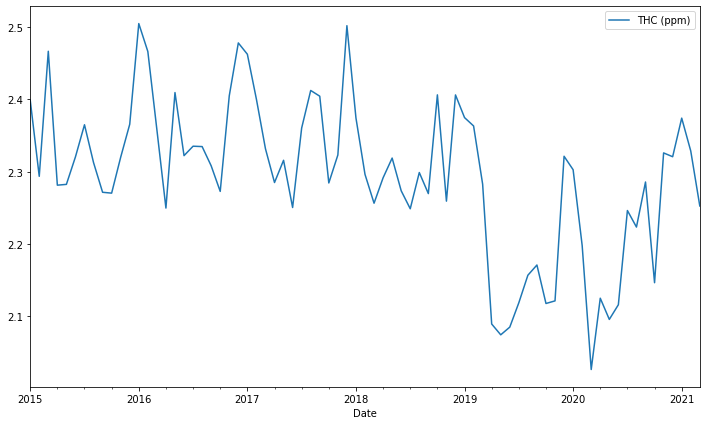

In [ ]:
A = 'M'
df1_w[aa].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c[aa].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

NameError: ignored

[0]	validation_0-rmse:1.64817
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.49133
[2]	validation_0-rmse:1.35081
[3]	validation_0-rmse:1.22504
[4]	validation_0-rmse:1.11263
[5]	validation_0-rmse:1.01201
[6]	validation_0-rmse:0.922275
[7]	validation_0-rmse:0.842334
[8]	validation_0-rmse:0.771408
[9]	validation_0-rmse:0.708407
[10]	validation_0-rmse:0.652858
[11]	validation_0-rmse:0.603353
[12]	validation_0-rmse:0.560171
[13]	validation_0-rmse:0.522169
[14]	validation_0-rmse:0.488565
[15]	validation_0-rmse:0.459189
[16]	validation_0-rmse:0.433849
[17]	validation_0-rmse:0.41141
[18]	validation_0-rmse:0.39185
[19]	validation_0-rmse:0.375274
[20]	validation_0-rmse:0.360754
[21]	validation_0-rmse:0.348519
[22]	validation_0-rmse:0.337892
[23]	validation_0-rmse:0.328878
[24]	validation_0-rmse:0.321142
[25]	validation_0-rmse:0.314561
[26]	validation_0-rmse:0.308741
[27]	validation_0-rmse:0.303553
[28]	validation_0-rmse:0.29916
[29]	validation_0-rmse:0.2

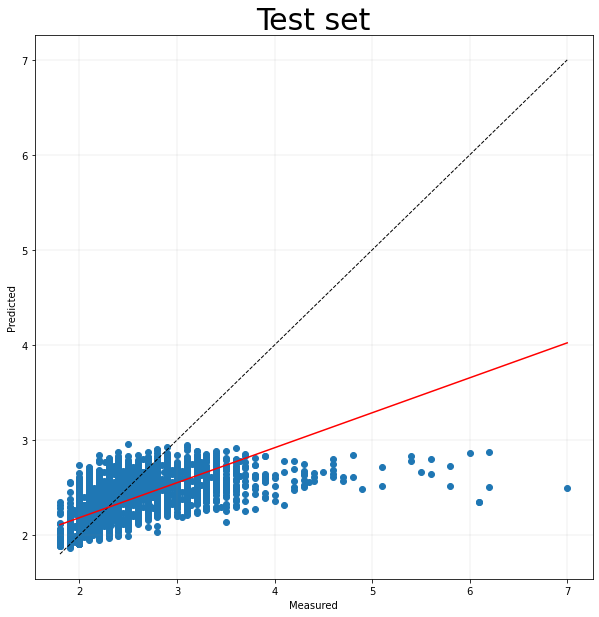

[0.36787255 1.44751413]
RMSE
[0.25242616]
R2
0.4053103934079171


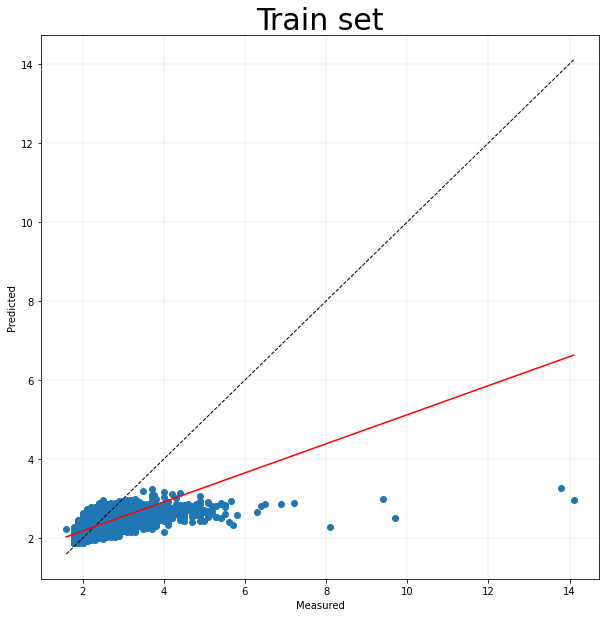

[0.36770347 1.44776802]
RMSE
[0.26112072]
R2
0.4227213468423153


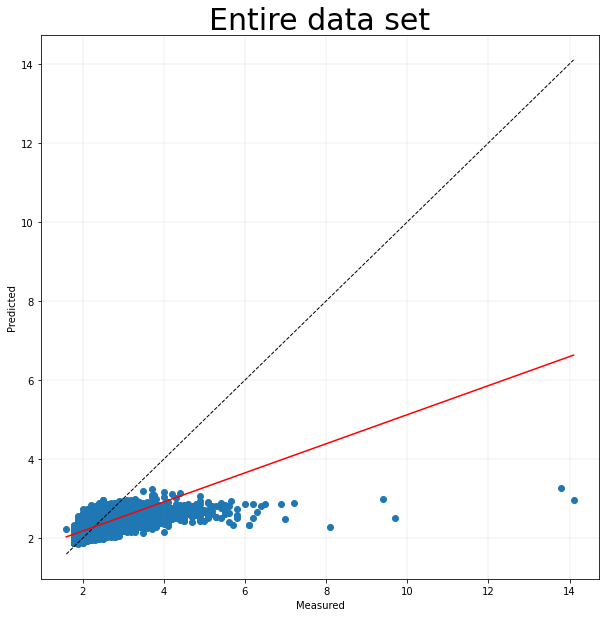

[0.36775007 1.4477012 ]
RMSE
[0.258543]
R2
0.41785672626831327


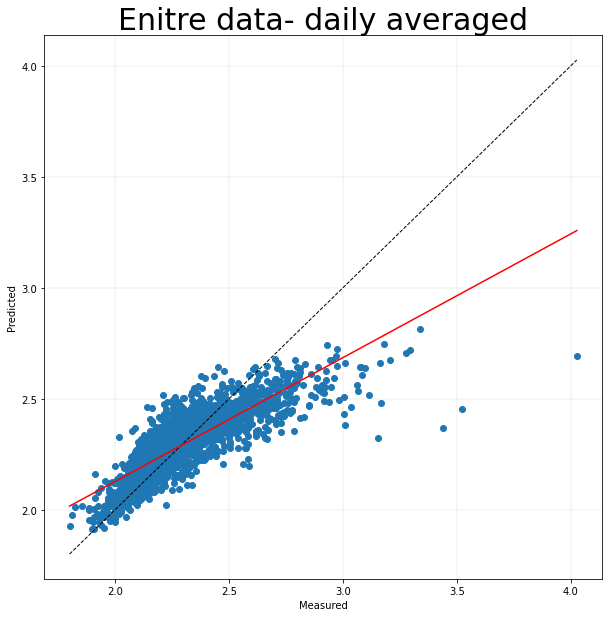

[0.55747909 1.01286651]
RMSE
[0.12636488]
R2
0.6599523878250162


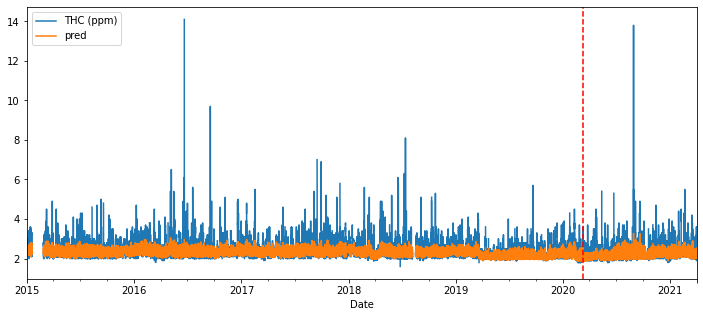

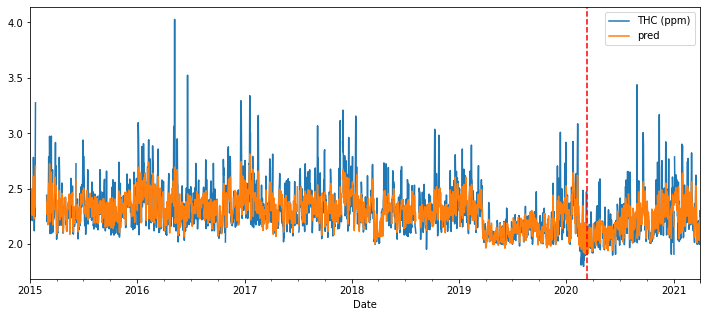

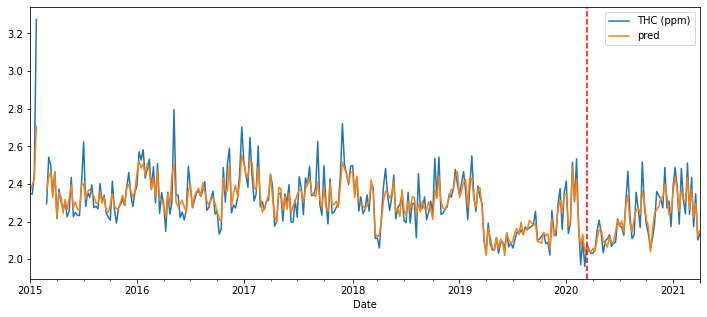

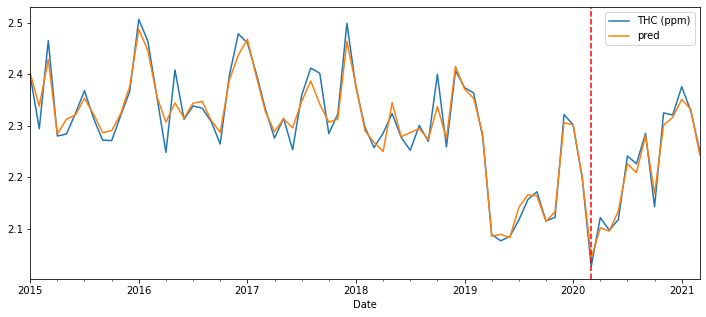

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10[aa]).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_THC_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_THC_OT_XG_Test.csv')


[0.26112072]
0.4227213468423153
[0.25242616]
0.4053103934079171


In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
184
2.3274810314178467
2021-01-18 23:00:00
184
2.3304731845855713
2021-01-19 00:00:00
183
2.2940454483032227
2021-01-19 01:00:00
184
2.2944343090057373
2021-01-19 02:00:00
182
2.2965917587280273
2021-01-19 03:00:00
183
2.300861358642578
2021-01-19 04:00:00
182
2.30096435546875
2021-01-19 05:00:00
182
2.2997372150421143
2021-01-19 06:00:00
181
2.3012795448303223
2021-01-19 07:00:00
182
2.3102169036865234
2021-01-19 08:00:00
182
2.3030083179473877
2021-01-19 09:00:00
180
2.317603588104248
2021-01-19 10:00:00
180
2.3300867080688477
2021-01-19 11:00:00
178
2.322561025619507
2021-01-19 12:00:00
175
2.304382562637329
2021-01-19 13:00:00
173
2.292252779006958
2021-01-19 14:00:00
175
2.290250778198242
2021-01-19 15:00:00
175
2.3040452003479004
2021-01-19 16:00:00
178
2.317513942718506
2021-01-19 17:00:00
181
2.316713333129883
2021-01-19 18:00:00
180
2.313560962677002
2021-01-19 19:00:00
183
2.3315939903259277
2021-01-19 20:00:00
183
2.32993531

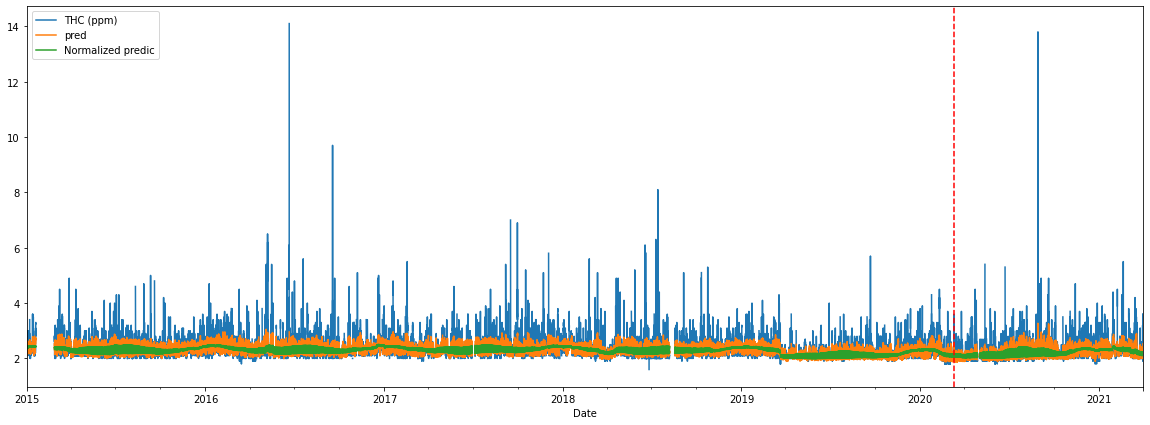

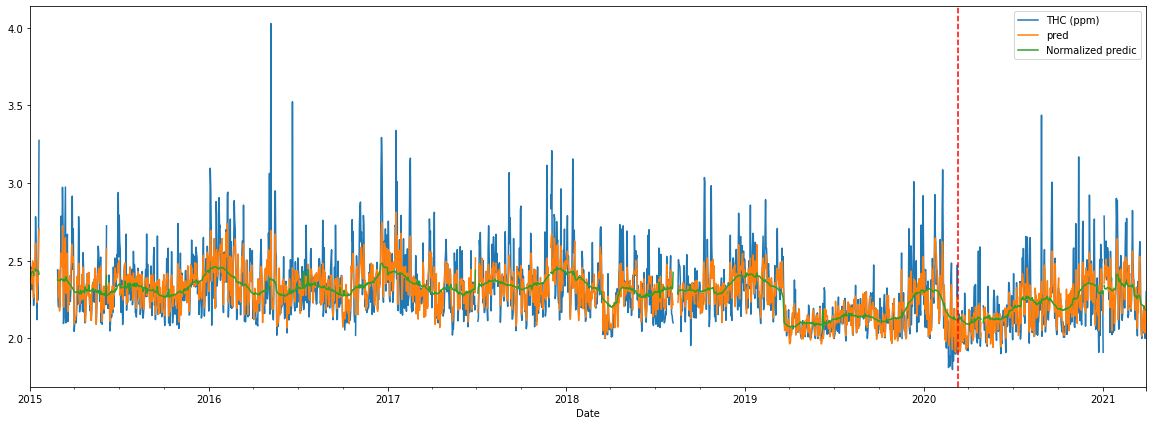

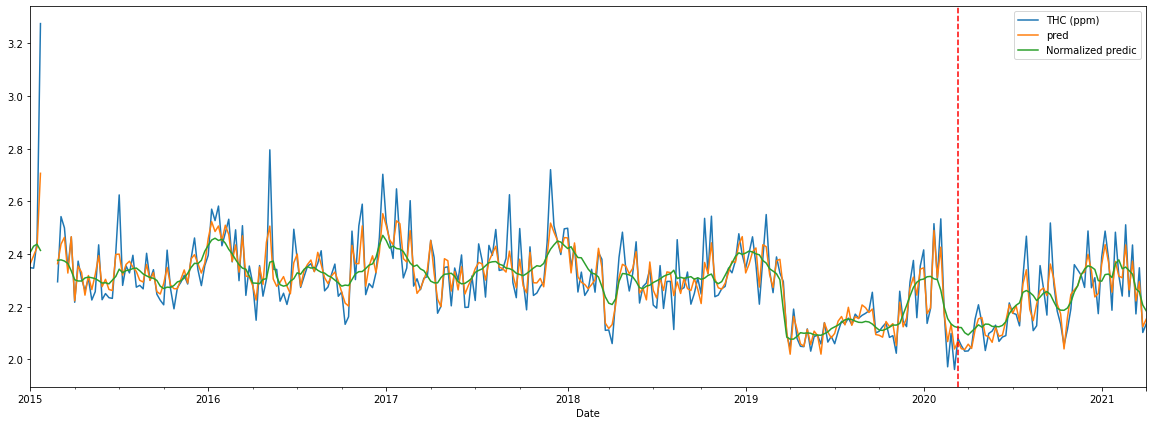

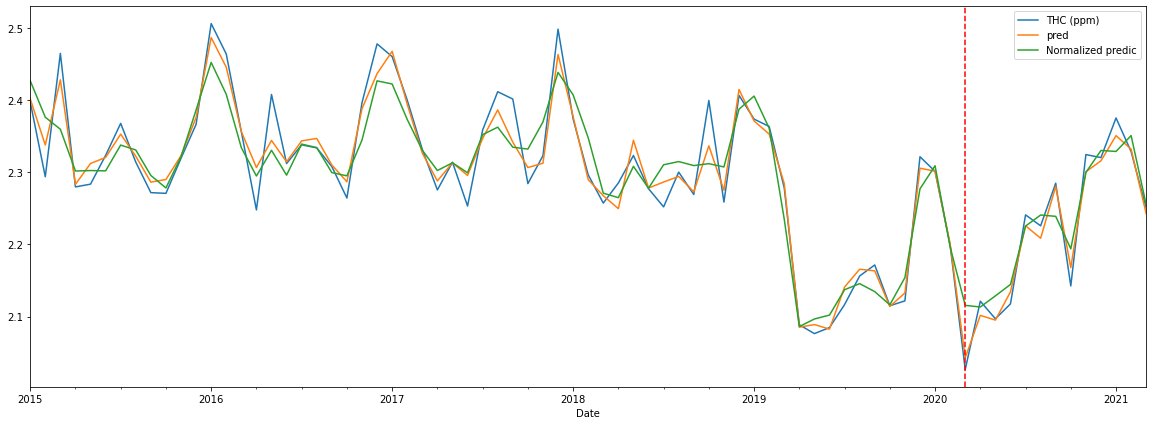

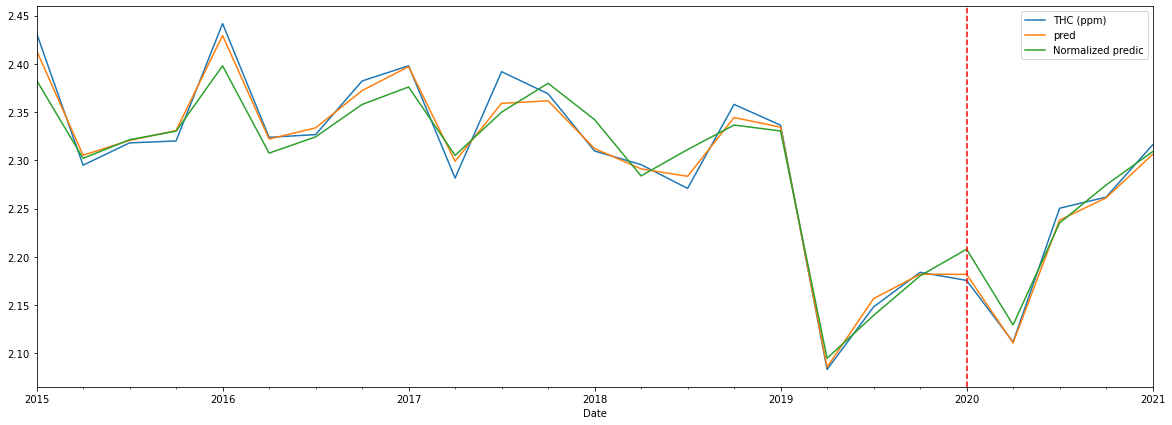

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower_Camp_THC_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower_Camp_THC_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower_Camp_THC_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
############

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

5.696927571680886 4.783653692328901


In [ ]:
df1_w

THC (ppm)  T ( C)  RH %  ...  Day-year      trend      score
Date                                          ...                                
2015-01-01 00:00:00       2.20   -13.1  85.0  ...       1.0  15.000000   9.958333
2015-01-01 01:00:00       2.15   -13.4  81.0  ...       1.0  15.000114   8.478571
2015-01-01 02:00:00       2.10   -13.9  78.0  ...       1.0  15.000228   3.699048
2015-01-01 03:00:00       2.10   -14.4  77.0  ...       1.0  15.000342   5.956038
2015-01-01 04:00:00       2.10   -14.6  78.0  ...       1.0  15.000455  10.314286
...                        ...     ...   ...  ...       ...        ...        ...
2021-03-31 19:00:00       2.20     2.3  71.5  ...      90.0  21.245332   6.136870
2021-03-31 20:00:00       3.50     3.1  66.8  ...      90.0  21.245446   6.066667
2021-03-31 21:00:00       2.20     5.7  47.6  ...      90.0  21.245560  20.311667
2021-03-31 22:00:00       2.10     5.7  46.0  ...      90.0  21.245674  14.442105
2021-03-31 23:00:00       3.60     4.9  48.5  ...      90.0  21.245788   2.383951

[51688 rows x 15 columns]

In [ ]:
df1_w

THC (ppm)  T ( C)  RH %  ...  Day-year      trend      score
Date                                          ...                                
2015-01-01 00:00:00       2.20   -13.1  85.0  ...       1.0  15.000000   9.958333
2015-01-01 01:00:00       2.15   -13.4  81.0  ...       1.0  15.000114   8.478571
2015-01-01 02:00:00       2.10   -13.9  78.0  ...       1.0  15.000228   3.699048
2015-01-01 03:00:00       2.10   -14.4  77.0  ...       1.0  15.000342   5.956038
2015-01-01 04:00:00       2.10   -14.6  78.0  ...       1.0  15.000455  10.314286
...                        ...     ...   ...  ...       ...        ...        ...
2021-03-31 19:00:00       2.20     2.3  71.5  ...      90.0  21.245332   6.136870
2021-03-31 20:00:00       3.50     3.1  66.8  ...      90.0  21.245446   6.066667
2021-03-31 21:00:00       2.20     5.7  47.6  ...      90.0  21.245560  20.311667
2021-03-31 22:00:00       2.10     5.7  46.0  ...      90.0  21.245674  14.442105
2021-03-31 23:00:00       3.60     4.9  48.5  ...      90.0  21.245788   2.383951

[51688 rows x 15 columns]

In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y_scaler, test_size=0.001, random_state=42)
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)


        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        self.X_train =self.X
        self.y_train =self.Y
        # self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.000000001, random_state = 42)

          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/LowerCamp_THC" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
study = optuna.create_study(direction=optimizer_direction, study_name='LowerCamp_THC__NN', storage='sqlite:///LowerCamp__THC__NN.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_OT_LowerCampd_Lake_THC_HP_HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

[I 2021-05-17 18:45:36,546] Using an existing study with name 'LowerCamp_THC__NN' instead of creating a new one.
[I 2021-05-17 18:46:52,678] Trial 1 finished with value: 0.08996108374629799 and parameters: {'score': 29.30987526803772, 'layers': 2, 'alpha': 0.2113459627572559, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 11.918562531851393, 'learning_rate': 0.08554614068854696, 'drop_out1': 0.12183457663946716, 'num_dense_nodes2': 31, 'drop_out2': 0.42969444862251144}. Best is trial 1 with value: 0.08996108374629799.


0.08996108374629799


[I 2021-05-17 18:48:11,883] Trial 2 finished with value: 0.09361175957403967 and parameters: {'score': 28.494231471248995, 'layers': 2, 'alpha': 0.497258339554064, 'batchsize': 3100.0, 'num_dense_nodes1': 35, 'delta': 41.26695433982087, 'learning_rate': 0.02300680472154277, 'drop_out1': 0.18408910793246308, 'num_dense_nodes2': 33, 'drop_out2': 0.20663242075475652}. Best is trial 1 with value: 0.08996108374629799.


0.09361175957403967


[I 2021-05-17 18:49:37,557] Trial 3 finished with value: 0.09106091627723686 and parameters: {'score': 18.716595678075866, 'layers': 2, 'alpha': 0.04225322383165967, 'batchsize': 2100.0, 'num_dense_nodes1': 30, 'delta': 60.32397890146573, 'learning_rate': 0.04609707339962992, 'drop_out1': 0.13713782838354555, 'num_dense_nodes2': 38, 'drop_out2': 0.24923165443510564}. Best is trial 1 with value: 0.08996108374629799.


0.09106091627723686


[I 2021-05-17 18:50:48,684] Trial 4 finished with value: 0.09647550869212468 and parameters: {'score': 15.946676199658194, 'layers': 3, 'alpha': 0.8430963941011279, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 26.723361024765975, 'learning_rate': 0.09728248716382121, 'drop_out1': 0.23265321980495096, 'num_dense_nodes2': 37, 'drop_out2': 0.22092127514715515, 'num_dense_nodes3': 28, 'drop_out3': 0.07606691856266384}. Best is trial 1 with value: 0.08996108374629799.


0.09647550869212468


[I 2021-05-17 18:52:25,135] Trial 5 finished with value: 0.08574744999664918 and parameters: {'score': 18.5169661657273, 'layers': 2, 'alpha': 0.06421894719418432, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 1.9920487978887018, 'learning_rate': 0.020582612422359196, 'drop_out1': 0.17016080131234101, 'num_dense_nodes2': 30, 'drop_out2': 0.46795299987390154}. Best is trial 5 with value: 0.08574744999664918.


0.08574744999664918


[I 2021-05-17 18:53:39,747] Trial 6 finished with value: 0.08073588593269343 and parameters: {'score': 29.429887475762094, 'layers': 3, 'alpha': 0.09981511485993952, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 90.61055921934623, 'learning_rate': 0.058733543564621106, 'drop_out1': 0.07615285961168651, 'num_dense_nodes2': 22, 'drop_out2': 0.44110186950450914, 'num_dense_nodes3': 23, 'drop_out3': 0.4988383790122479}. Best is trial 6 with value: 0.08073588593269343.


0.08073588593269343


[I 2021-05-17 18:54:54,825] Trial 7 finished with value: 0.08961360779906445 and parameters: {'score': 16.662191406246784, 'layers': 3, 'alpha': 0.5360822407685397, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 34.15027729050381, 'learning_rate': 0.01739891506347346, 'drop_out1': 0.15909377629785343, 'num_dense_nodes2': 36, 'drop_out2': 0.2984913639534878, 'num_dense_nodes3': 38, 'drop_out3': 0.3556263206047167}. Best is trial 6 with value: 0.08073588593269343.


0.08961360779906445


[I 2021-05-17 18:56:31,402] Trial 8 finished with value: 0.08669820538736853 and parameters: {'score': 22.355063056659336, 'layers': 2, 'alpha': 0.42024951680707556, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 47.97400680498493, 'learning_rate': 0.004029111128433504, 'drop_out1': 0.18315002936161856, 'num_dense_nodes2': 23, 'drop_out2': 0.4043920608677583}. Best is trial 6 with value: 0.08073588593269343.


0.08669820538736853


[I 2021-05-17 18:57:53,896] Trial 9 finished with value: 0.09492676799773903 and parameters: {'score': 19.559798275478226, 'layers': 2, 'alpha': 0.38204600665098903, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 91.8847047372589, 'learning_rate': 0.02293319379540852, 'drop_out1': 0.10269791189016615, 'num_dense_nodes2': 35, 'drop_out2': 0.3204086202229342}. Best is trial 6 with value: 0.08073588593269343.


0.09492676799773903


[I 2021-05-17 18:59:52,573] Trial 10 finished with value: 0.0910070014945477 and parameters: {'score': 20.74448619053829, 'layers': 3, 'alpha': 0.6566420488826994, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 19.047951084791674, 'learning_rate': 0.07753124641266604, 'drop_out1': 0.09151435215550603, 'num_dense_nodes2': 21, 'drop_out2': 0.2937177841684102, 'num_dense_nodes3': 20, 'drop_out3': 0.387185552514301}. Best is trial 6 with value: 0.08073588593269343.


0.0910070014945477


[I 2021-05-17 19:12:40,024] Trial 11 finished with value: 0.08359052770651447 and parameters: {'score': 25.97208854621514, 'layers': 3, 'alpha': 0.22681717557493455, 'batchsize': 100.0, 'num_dense_nodes1': 22, 'delta': 99.64578778751192, 'learning_rate': 0.055824075082131455, 'drop_out1': 0.05637843197457476, 'num_dense_nodes2': 25, 'drop_out2': 0.08282662459447657, 'num_dense_nodes3': 5, 'drop_out3': 0.17284083630949315}. Best is trial 6 with value: 0.08073588593269343.


0.08359052770651447


[I 2021-05-17 19:25:30,022] Trial 12 finished with value: 0.0837855649028842 and parameters: {'score': 26.02196361459773, 'layers': 3, 'alpha': 0.18614247655006538, 'batchsize': 100.0, 'num_dense_nodes1': 21, 'delta': 99.4633962588926, 'learning_rate': 0.05744935816536961, 'drop_out1': 0.05701717223615087, 'num_dense_nodes2': 26, 'drop_out2': 0.05114680645870934, 'num_dense_nodes3': 8, 'drop_out3': 0.14940933043631066}. Best is trial 6 with value: 0.08073588593269343.


0.0837855649028842


[I 2021-05-17 19:26:40,669] Trial 13 finished with value: 0.07546070232373424 and parameters: {'score': 25.974765825564038, 'layers': 3, 'alpha': 0.2297766079389599, 'batchsize': 4600.0, 'num_dense_nodes1': 25, 'delta': 80.35106009800427, 'learning_rate': 0.060286477542868665, 'drop_out1': 0.05024913766443081, 'num_dense_nodes2': 26, 'drop_out2': 0.06339519317361997, 'num_dense_nodes3': 18, 'drop_out3': 0.23959553402108646}. Best is trial 13 with value: 0.07546070232373424.


0.07546070232373424


[I 2021-05-17 19:27:54,946] Trial 14 finished with value: 0.08498925997505048 and parameters: {'score': 26.339155206507503, 'layers': 3, 'alpha': 0.3044118629392531, 'batchsize': 4600.0, 'num_dense_nodes1': 25, 'delta': 76.85137457339799, 'learning_rate': 0.06795728628662995, 'drop_out1': 0.05432086762733755, 'num_dense_nodes2': 20, 'drop_out2': 0.10483735343595081, 'num_dense_nodes3': 19, 'drop_out3': 0.49012303826227077}. Best is trial 13 with value: 0.07546070232373424.


0.08498925997505048


[I 2021-05-17 19:29:06,028] Trial 15 finished with value: 0.07516600142316557 and parameters: {'score': 27.911519963984965, 'layers': 3, 'alpha': 0.01811484950159288, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 75.38928609616787, 'learning_rate': 0.040375937728911945, 'drop_out1': 0.08883430282963409, 'num_dense_nodes2': 27, 'drop_out2': 0.14573733663383437, 'num_dense_nodes3': 29, 'drop_out3': 0.23950067582722007}. Best is trial 15 with value: 0.07516600142316557.


0.07516600142316557


[I 2021-05-17 19:30:18,467] Trial 16 finished with value: 0.08605488191367988 and parameters: {'score': 24.364163993608738, 'layers': 3, 'alpha': 0.1299902629716368, 'batchsize': 4600.0, 'num_dense_nodes1': 27, 'delta': 63.12973977955393, 'learning_rate': 0.038011087902883225, 'drop_out1': 0.28889848612382857, 'num_dense_nodes2': 27, 'drop_out2': 0.15833571043438127, 'num_dense_nodes3': 33, 'drop_out3': 0.24880532295136015}. Best is trial 15 with value: 0.07516600142316557.


0.08605488191367988


[I 2021-05-17 19:31:30,412] Trial 17 finished with value: 0.07266907146494937 and parameters: {'score': 27.353141893776666, 'layers': 3, 'alpha': 0.030789303811944342, 'batchsize': 4600.0, 'num_dense_nodes1': 28, 'delta': 75.1675894903096, 'learning_rate': 0.03836520526713294, 'drop_out1': 0.05088778361813848, 'num_dense_nodes2': 28, 'drop_out2': 0.14834590084385968, 'num_dense_nodes3': 14, 'drop_out3': 0.26562580672318}. Best is trial 17 with value: 0.07266907146494937.


0.07266907146494937


[I 2021-05-17 19:32:45,385] Trial 18 finished with value: 0.07864661622496345 and parameters: {'score': 27.85322038526656, 'layers': 3, 'alpha': 0.016138375751744094, 'batchsize': 4100.0, 'num_dense_nodes1': 29, 'delta': 68.88473302952985, 'learning_rate': 0.036401177101690586, 'drop_out1': 0.11245824792086491, 'num_dense_nodes2': 28, 'drop_out2': 0.14683970716295403, 'num_dense_nodes3': 12, 'drop_out3': 0.33016636752441214}. Best is trial 17 with value: 0.07266907146494937.


0.07864661622496345


[I 2021-05-17 19:33:56,544] Trial 19 finished with value: 0.09882925511716158 and parameters: {'score': 23.78551385932459, 'layers': 3, 'alpha': 0.8955535341485747, 'batchsize': 4100.0, 'num_dense_nodes1': 31, 'delta': 79.82828863274595, 'learning_rate': 0.03717864371489447, 'drop_out1': 0.22008907221045076, 'num_dense_nodes2': 32, 'drop_out2': 0.15457477957137464, 'num_dense_nodes3': 28, 'drop_out3': 0.18093809185558407}. Best is trial 17 with value: 0.07266907146494937.


0.09882925511716158


[I 2021-05-17 19:35:10,922] Trial 20 finished with value: 0.079281420745573 and parameters: {'score': 27.832769342741518, 'layers': 3, 'alpha': 0.011771348897924194, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 57.34052066203482, 'learning_rate': 0.0433435504684829, 'drop_out1': 0.08307710428993162, 'num_dense_nodes2': 29, 'drop_out2': 0.12728454952043217, 'num_dense_nodes3': 13, 'drop_out3': 0.28917654704199564}. Best is trial 17 with value: 0.07266907146494937.


0.079281420745573


[I 2021-05-17 19:36:29,498] Trial 21 finished with value: 0.09506523643058698 and parameters: {'score': 24.155447570936666, 'layers': 3, 'alpha': 0.6310043749281308, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 71.2948963193124, 'learning_rate': 0.002459809762999421, 'drop_out1': 0.13922943592827214, 'num_dense_nodes2': 40, 'drop_out2': 0.3557406518388634, 'num_dense_nodes3': 26, 'drop_out3': 0.41467339448705354}. Best is trial 17 with value: 0.07266907146494937.


0.09506523643058698


[I 2021-05-17 19:37:44,627] Trial 22 finished with value: 0.08867053911969332 and parameters: {'score': 27.159007411222856, 'layers': 3, 'alpha': 0.30143478221552256, 'batchsize': 4600.0, 'num_dense_nodes1': 25, 'delta': 82.67492659867197, 'learning_rate': 0.06754713682675996, 'drop_out1': 0.05108906269146689, 'num_dense_nodes2': 24, 'drop_out2': 0.0592388420818916, 'num_dense_nodes3': 16, 'drop_out3': 0.2409340343567235}. Best is trial 17 with value: 0.07266907146494937.


0.08867053911969332


[I 2021-05-17 19:38:57,876] Trial 23 finished with value: 0.08628608779768907 and parameters: {'score': 25.24782155793093, 'layers': 3, 'alpha': 0.1414184843453986, 'batchsize': 4100.0, 'num_dense_nodes1': 24, 'delta': 90.65759308049053, 'learning_rate': 0.03185802316360731, 'drop_out1': 0.07177045956459996, 'num_dense_nodes2': 27, 'drop_out2': 0.18920249339029052, 'num_dense_nodes3': 33, 'drop_out3': 0.216561460474842}. Best is trial 17 with value: 0.07266907146494937.


0.08628608779768907


[I 2021-05-17 19:40:13,333] Trial 24 finished with value: 0.09023423329362294 and parameters: {'score': 29.217598955513385, 'layers': 3, 'alpha': 0.298166459855819, 'batchsize': 4600.0, 'num_dense_nodes1': 27, 'delta': 83.59589741891358, 'learning_rate': 0.051302926956655434, 'drop_out1': 0.05150100673963555, 'num_dense_nodes2': 25, 'drop_out2': 0.09221510531181595, 'num_dense_nodes3': 16, 'drop_out3': 0.31310552725061463}. Best is trial 17 with value: 0.07266907146494937.


0.09023423329362294


[I 2021-05-17 19:41:32,592] Trial 25 finished with value: 0.09412152418895231 and parameters: {'score': 22.314616356528123, 'layers': 3, 'alpha': 0.013667663605687275, 'batchsize': 3100.0, 'num_dense_nodes1': 32, 'delta': 73.45048430373525, 'learning_rate': 0.0718834091489678, 'drop_out1': 0.08064795133944644, 'num_dense_nodes2': 29, 'drop_out2': 0.17549079390787403, 'num_dense_nodes3': 23, 'drop_out3': 0.11293049003812367}. Best is trial 17 with value: 0.07266907146494937.


0.09412152418895231


[I 2021-05-17 19:42:48,418] Trial 26 finished with value: 0.08971467869303731 and parameters: {'score': 27.241297417192715, 'layers': 3, 'alpha': 0.10734763670754874, 'batchsize': 4100.0, 'num_dense_nodes1': 29, 'delta': 65.91363928167029, 'learning_rate': 0.02937760671598998, 'drop_out1': 0.10126962913041096, 'num_dense_nodes2': 27, 'drop_out2': 0.24259288892903336, 'num_dense_nodes3': 10, 'drop_out3': 0.2715300918546804}. Best is trial 17 with value: 0.07266907146494937.


0.08971467869303731


[I 2021-05-17 19:44:12,190] Trial 27 finished with value: 0.08909956776318925 and parameters: {'score': 25.353875486539767, 'layers': 3, 'alpha': 0.14654590910893955, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 51.15649665636043, 'learning_rate': 0.010131600428951847, 'drop_out1': 0.06860516473947895, 'num_dense_nodes2': 33, 'drop_out2': 0.05232051094656913, 'num_dense_nodes3': 16, 'drop_out3': 0.2109756767416228}. Best is trial 17 with value: 0.07266907146494937.


0.08909956776318925


[I 2021-05-17 19:45:25,170] Trial 28 finished with value: 0.09087631206207838 and parameters: {'score': 28.425751289660006, 'layers': 3, 'alpha': 0.2330099761094875, 'batchsize': 4600.0, 'num_dense_nodes1': 20, 'delta': 85.50541105238179, 'learning_rate': 0.04799242187908429, 'drop_out1': 0.12384829749421328, 'num_dense_nodes2': 23, 'drop_out2': 0.12634206194431788, 'num_dense_nodes3': 33, 'drop_out3': 0.2889220739052808}. Best is trial 17 with value: 0.07266907146494937.


0.09087631206207838


[I 2021-05-17 19:46:38,795] Trial 29 finished with value: 0.08958560763729265 and parameters: {'score': 26.81442539948927, 'layers': 3, 'alpha': 0.3576900174385166, 'batchsize': 4100.0, 'num_dense_nodes1': 27, 'delta': 53.79006763364926, 'learning_rate': 0.06314677487283843, 'drop_out1': 0.287739418966831, 'num_dense_nodes2': 29, 'drop_out2': 0.0804507978216519, 'num_dense_nodes3': 21, 'drop_out3': 0.21701510615538702}. Best is trial 17 with value: 0.07266907146494937.


0.08958560763729265


[I 2021-05-17 19:48:01,219] Trial 30 finished with value: 0.07886070453383948 and parameters: {'score': 29.298501830366344, 'layers': 3, 'alpha': 0.1965071859283572, 'batchsize': 2600.0, 'num_dense_nodes1': 29, 'delta': 74.7806983725591, 'learning_rate': 0.09316131055672316, 'drop_out1': 0.12374288312017384, 'num_dense_nodes2': 31, 'drop_out2': 0.11536860528889052, 'num_dense_nodes3': 6, 'drop_out3': 0.146619121906282}. Best is trial 17 with value: 0.07266907146494937.


0.07886070453383948


[I 2021-05-17 19:49:17,921] Trial 31 finished with value: 0.07564292260960914 and parameters: {'score': 23.036144101511436, 'layers': 3, 'alpha': 0.0729613440419805, 'batchsize': 3100.0, 'num_dense_nodes1': 25, 'delta': 93.22004033815153, 'learning_rate': 0.0766252451982134, 'drop_out1': 0.08994344898868178, 'num_dense_nodes2': 25, 'drop_out2': 0.1941764787604464, 'num_dense_nodes3': 26, 'drop_out3': 0.2554750076452872}. Best is trial 17 with value: 0.07266907146494937.


0.07564292260960914


[I 2021-05-17 19:50:34,203] Trial 32 finished with value: 0.07717179819014788 and parameters: {'score': 21.27646858211685, 'layers': 3, 'alpha': 0.07076986663378317, 'batchsize': 3100.0, 'num_dense_nodes1': 25, 'delta': 95.44404656032235, 'learning_rate': 0.08403456806000965, 'drop_out1': 0.08905151126214111, 'num_dense_nodes2': 26, 'drop_out2': 0.1954046160314416, 'num_dense_nodes3': 27, 'drop_out3': 0.2601906655740755}. Best is trial 17 with value: 0.07266907146494937.


0.07717179819014788


[I 2021-05-17 19:51:46,892] Trial 33 finished with value: 0.07737420006841522 and parameters: {'score': 23.40779585481756, 'layers': 3, 'alpha': 0.016572747766298673, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 85.81634322752882, 'learning_rate': 0.07915125333135746, 'drop_out1': 0.06760027676880768, 'num_dense_nodes2': 25, 'drop_out2': 0.220754623115622, 'num_dense_nodes3': 30, 'drop_out3': 0.3237847388074397}. Best is trial 17 with value: 0.07266907146494937.


0.07737420006841522


[I 2021-05-17 19:53:15,658] Trial 34 finished with value: 0.08733101910454472 and parameters: {'score': 25.078930689436998, 'layers': 3, 'alpha': 0.07245896037879487, 'batchsize': 2100.0, 'num_dense_nodes1': 27, 'delta': 78.45225804140563, 'learning_rate': 0.043144520860566395, 'drop_out1': 0.100568247192661, 'num_dense_nodes2': 28, 'drop_out2': 0.24722427305674866, 'num_dense_nodes3': 24, 'drop_out3': 0.22907815404914492}. Best is trial 17 with value: 0.07266907146494937.


0.08733101910454472


[I 2021-05-17 19:54:33,983] Trial 35 finished with value: 0.07618872579600816 and parameters: {'score': 28.153453761482847, 'layers': 3, 'alpha': 0.148571634601513, 'batchsize': 3100.0, 'num_dense_nodes1': 30, 'delta': 66.52455269325078, 'learning_rate': 0.051462115506313605, 'drop_out1': 0.14229121797190003, 'num_dense_nodes2': 24, 'drop_out2': 0.17121999281510392, 'num_dense_nodes3': 19, 'drop_out3': 0.19852097965717438}. Best is trial 17 with value: 0.07266907146494937.


0.07618872579600816


[I 2021-05-17 19:55:47,583] Trial 36 finished with value: 0.09010983040550462 and parameters: {'score': 23.291321421303348, 'layers': 2, 'alpha': 0.24664204784804528, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 99.24118751134927, 'learning_rate': 0.029207646301517634, 'drop_out1': 0.22247138295893493, 'num_dense_nodes2': 31, 'drop_out2': 0.1388283622658681}. Best is trial 17 with value: 0.07266907146494937.


0.09010983040550462


[I 2021-05-17 19:57:45,851] Trial 37 finished with value: 0.07942590421126614 and parameters: {'score': 26.609193470285973, 'layers': 3, 'alpha': 0.0706930929600037, 'batchsize': 1100.0, 'num_dense_nodes1': 23, 'delta': 89.90118113428763, 'learning_rate': 0.09137188473017545, 'drop_out1': 0.06602653184132809, 'num_dense_nodes2': 26, 'drop_out2': 0.20814663813185477, 'num_dense_nodes3': 30, 'drop_out3': 0.2795572248988944}. Best is trial 17 with value: 0.07266907146494937.


0.07942590421126614


[I 2021-05-17 19:58:58,705] Trial 38 finished with value: 0.09157842598890585 and parameters: {'score': 28.94675567421059, 'layers': 3, 'alpha': 0.4880921778088012, 'batchsize': 4100.0, 'num_dense_nodes1': 34, 'delta': 61.67016198296589, 'learning_rate': 0.062315606707449296, 'drop_out1': 0.1544643836137773, 'num_dense_nodes2': 30, 'drop_out2': 0.06983584341975856, 'num_dense_nodes3': 14, 'drop_out3': 0.053617726092201445}. Best is trial 17 with value: 0.07266907146494937.


0.09157842598890585


[I 2021-05-17 20:00:17,705] Trial 39 finished with value: 0.08102526974961982 and parameters: {'score': 21.46977056815854, 'layers': 2, 'alpha': 0.04318896544274037, 'batchsize': 2600.0, 'num_dense_nodes1': 28, 'delta': 42.52577557556563, 'learning_rate': 0.07276611851769205, 'drop_out1': 0.2019981019770229, 'num_dense_nodes2': 28, 'drop_out2': 0.10662202267960214}. Best is trial 17 with value: 0.07266907146494937.


0.08102526974961982


[I 2021-05-17 20:01:29,402] Trial 40 finished with value: 0.07735076442273166 and parameters: {'score': 24.96397755595064, 'layers': 3, 'alpha': 0.18087357875866597, 'batchsize': 3600.0, 'num_dense_nodes1': 31, 'delta': 87.39763528002112, 'learning_rate': 0.041867855503626664, 'drop_out1': 0.11383520024201724, 'num_dense_nodes2': 22, 'drop_out2': 0.26529401047811113, 'num_dense_nodes3': 25, 'drop_out3': 0.2508169214754967}. Best is trial 17 with value: 0.07266907146494937.


0.07735076442273166


[I 2021-05-17 20:03:07,820] Trial 41 finished with value: 0.08011779174271075 and parameters: {'score': 27.44721625350832, 'layers': 3, 'alpha': 0.08112066140172439, 'batchsize': 1600.0, 'num_dense_nodes1': 24, 'delta': 93.74409921884775, 'learning_rate': 0.053312827137130286, 'drop_out1': 0.2541938552698928, 'num_dense_nodes2': 24, 'drop_out2': 0.2265103592351405, 'num_dense_nodes3': 30, 'drop_out3': 0.30111309290070243}. Best is trial 17 with value: 0.07266907146494937.


0.08011779174271075


[I 2021-05-17 20:04:29,563] Trial 42 finished with value: 0.08631215638886966 and parameters: {'score': 28.060759418726086, 'layers': 3, 'alpha': 0.1429509499711833, 'batchsize': 3100.0, 'num_dense_nodes1': 30, 'delta': 68.86024895673721, 'learning_rate': 0.049289213401511156, 'drop_out1': 0.1386667282011817, 'num_dense_nodes2': 24, 'drop_out2': 0.1690187949985879, 'num_dense_nodes3': 18, 'drop_out3': 0.1970183136283756}. Best is trial 17 with value: 0.07266907146494937.


0.08631215638886966


[I 2021-05-17 20:05:55,643] Trial 43 finished with value: 0.08817617334945249 and parameters: {'score': 28.97679323600359, 'layers': 3, 'alpha': 0.11976898628935939, 'batchsize': 2600.0, 'num_dense_nodes1': 26, 'delta': 79.40101174753954, 'learning_rate': 0.06089008860174564, 'drop_out1': 0.1557756023873472, 'num_dense_nodes2': 22, 'drop_out2': 0.17690981765038605, 'num_dense_nodes3': 22, 'drop_out3': 0.17698427656472338}. Best is trial 17 with value: 0.07266907146494937.


0.08817617334945249


[I 2021-05-17 20:07:15,703] Trial 44 finished with value: 0.09037729490715793 and parameters: {'score': 28.43732029728936, 'layers': 3, 'alpha': 0.2746950909510312, 'batchsize': 3100.0, 'num_dense_nodes1': 31, 'delta': 66.70341093496833, 'learning_rate': 0.05352617699813263, 'drop_out1': 0.17219033106532694, 'num_dense_nodes2': 23, 'drop_out2': 0.2017629142981681, 'num_dense_nodes3': 18, 'drop_out3': 0.354407709992979}. Best is trial 17 with value: 0.07266907146494937.


0.09037729490715793


[I 2021-05-17 20:08:27,529] Trial 45 finished with value: 0.0847896417176347 and parameters: {'score': 26.045809587894357, 'layers': 3, 'alpha': 0.180226982522544, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 57.10914922913413, 'learning_rate': 0.04631544000665088, 'drop_out1': 0.09624641017449598, 'num_dense_nodes2': 26, 'drop_out2': 0.13995106973202248, 'num_dense_nodes3': 37, 'drop_out3': 0.14324197253912455}. Best is trial 17 with value: 0.07266907146494937.


0.0847896417176347


[I 2021-05-17 20:09:54,450] Trial 46 finished with value: 0.07068180717790261 and parameters: {'score': 18.324205324061598, 'layers': 3, 'alpha': 0.036882836539808235, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 75.53303147058482, 'learning_rate': 0.03437932136710767, 'drop_out1': 0.10980277148316873, 'num_dense_nodes2': 21, 'drop_out2': 0.2714711915650878, 'num_dense_nodes3': 20, 'drop_out3': 0.19150039450182016}. Best is trial 46 with value: 0.07068180717790261.


0.07068180717790261


[I 2021-05-17 20:11:22,630] Trial 47 finished with value: 0.07378968581662868 and parameters: {'score': 17.19612836523044, 'layers': 3, 'alpha': 0.044005650166939955, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 1.9202681489258424, 'learning_rate': 0.018649103526280554, 'drop_out1': 0.1123275947857725, 'num_dense_nodes2': 21, 'drop_out2': 0.32413507856622925, 'num_dense_nodes3': 21, 'drop_out3': 0.10668923194693519}. Best is trial 46 with value: 0.07068180717790261.


0.07378968581662868


[I 2021-05-17 20:12:54,346] Trial 48 finished with value: 0.07381626731508519 and parameters: {'score': 16.4609752075934, 'layers': 3, 'alpha': 0.015499050169115555, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 32.15973257758856, 'learning_rate': 0.015607438202062732, 'drop_out1': 0.11264301457308441, 'num_dense_nodes2': 20, 'drop_out2': 0.33408221794017656, 'num_dense_nodes3': 11, 'drop_out3': 0.11768784123474245}. Best is trial 46 with value: 0.07068180717790261.


0.07381626731508519


[I 2021-05-17 20:14:25,788] Trial 49 finished with value: 0.0882411444211679 and parameters: {'score': 16.663072842386377, 'layers': 2, 'alpha': 0.035071078023107743, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 8.673458280772973, 'learning_rate': 0.018617346785204297, 'drop_out1': 0.11319184430926009, 'num_dense_nodes2': 20, 'drop_out2': 0.3518963831687616}. Best is trial 46 with value: 0.07068180717790261.


0.0882411444211679


[I 2021-05-17 20:16:24,102] Trial 50 finished with value: 0.07384148224470022 and parameters: {'score': 15.304543890869644, 'layers': 3, 'alpha': 0.04101807065190338, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 25.991750557213855, 'learning_rate': 0.013277066857516917, 'drop_out1': 0.1281188687212525, 'num_dense_nodes2': 21, 'drop_out2': 0.4050944127711404, 'num_dense_nodes3': 11, 'drop_out3': 0.09333775010904495}. Best is trial 46 with value: 0.07068180717790261.


0.07384148224470022


[I 2021-05-17 20:18:22,822] Trial 51 finished with value: 0.0761852694388258 and parameters: {'score': 17.593835885456137, 'layers': 3, 'alpha': 0.1008088635323201, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 24.560820390081286, 'learning_rate': 0.009560047727169417, 'drop_out1': 0.12532939063958728, 'num_dense_nodes2': 21, 'drop_out2': 0.40690488381456646, 'num_dense_nodes3': 9, 'drop_out3': 0.10661311039421896}. Best is trial 46 with value: 0.07068180717790261.


0.0761852694388258


[I 2021-05-17 20:21:15,214] Trial 52 finished with value: 0.07377173610460512 and parameters: {'score': 15.332477694784359, 'layers': 3, 'alpha': 0.011307226120806747, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 35.406445296129135, 'learning_rate': 0.013436327402087635, 'drop_out1': 0.10667172049701798, 'num_dense_nodes2': 21, 'drop_out2': 0.4950854708499923, 'num_dense_nodes3': 7, 'drop_out3': 0.0850464834584586}. Best is trial 46 with value: 0.07068180717790261.


0.07377173610460512


[I 2021-05-17 20:24:04,760] Trial 53 finished with value: 0.07509625872408242 and parameters: {'score': 15.2798123838028, 'layers': 3, 'alpha': 0.044919306859868204, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 35.52264302930571, 'learning_rate': 0.013431357532183582, 'drop_out1': 0.14717509665038053, 'num_dense_nodes2': 20, 'drop_out2': 0.483566803243763, 'num_dense_nodes3': 6, 'drop_out3': 0.07232555453019646}. Best is trial 46 with value: 0.07068180717790261.


0.07509625872408242


[I 2021-05-17 20:26:56,174] Trial 54 finished with value: 0.09019353949275655 and parameters: {'score': 15.620122291297404, 'layers': 3, 'alpha': 0.011519366065377169, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 17.166853179368314, 'learning_rate': 0.022907562485723697, 'drop_out1': 0.13055804241781047, 'num_dense_nodes2': 21, 'drop_out2': 0.32966889837825636, 'num_dense_nodes3': 11, 'drop_out3': 0.1011454133818442}. Best is trial 46 with value: 0.07068180717790261.


0.09019353949275655


[I 2021-05-17 20:28:31,092] Trial 55 finished with value: 0.0919054183180342 and parameters: {'score': 16.35140274244856, 'layers': 3, 'alpha': 0.7546354671426079, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 1.2861765146383988, 'learning_rate': 0.015534853029782535, 'drop_out1': 0.1645660432967443, 'num_dense_nodes2': 20, 'drop_out2': 0.29327177800447674, 'num_dense_nodes3': 8, 'drop_out3': 0.08507556336837593}. Best is trial 46 with value: 0.07068180717790261.


0.0919054183180342


[I 2021-05-17 20:30:17,261] Trial 56 finished with value: 0.08663836079429585 and parameters: {'score': 19.226058270112638, 'layers': 3, 'alpha': 0.052422528267470736, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 31.346679301264835, 'learning_rate': 0.005819800684758443, 'drop_out1': 0.11200275029284273, 'num_dense_nodes2': 22, 'drop_out2': 0.43960106565087353, 'num_dense_nodes3': 8, 'drop_out3': 0.051052579894183395}. Best is trial 46 with value: 0.07068180717790261.


0.08663836079429585


[I 2021-05-17 20:33:11,627] Trial 57 finished with value: 0.08969033503687855 and parameters: {'score': 17.521704279391805, 'layers': 3, 'alpha': 0.10939758391446873, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 38.5972533474343, 'learning_rate': 0.028358485408604528, 'drop_out1': 0.1819402867564832, 'num_dense_nodes2': 21, 'drop_out2': 0.37779179928245643, 'num_dense_nodes3': 14, 'drop_out3': 0.12768694031608033}. Best is trial 46 with value: 0.07068180717790261.


0.08969033503687855


[I 2021-05-17 20:34:51,423] Trial 58 finished with value: 0.07481466117724926 and parameters: {'score': 17.444198390731245, 'layers': 3, 'alpha': 0.017001883531430863, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 45.752765541246816, 'learning_rate': 0.02560238692842509, 'drop_out1': 0.10992131311512343, 'num_dense_nodes2': 22, 'drop_out2': 0.4579902590668199, 'num_dense_nodes3': 12, 'drop_out3': 0.08263191179758284}. Best is trial 46 with value: 0.07068180717790261.


0.07481466117724926


[I 2021-05-17 20:36:51,409] Trial 59 finished with value: 0.07668362525081038 and parameters: {'score': 18.265865116456254, 'layers': 3, 'alpha': 0.03874603405665127, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 25.777964545216726, 'learning_rate': 0.03308892449707845, 'drop_out1': 0.13229346553645385, 'num_dense_nodes2': 21, 'drop_out2': 0.4095236104196831, 'num_dense_nodes3': 5, 'drop_out3': 0.1603457339689692}. Best is trial 46 with value: 0.07068180717790261.


0.07668362525081038


[I 2021-05-17 20:49:43,036] Trial 60 finished with value: 0.07586472531392645 and parameters: {'score': 16.02730689490189, 'layers': 3, 'alpha': 0.09447748977805306, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 6.495137378110808, 'learning_rate': 0.02163754571278301, 'drop_out1': 0.07774756949573106, 'num_dense_nodes2': 38, 'drop_out2': 0.32070705257935295, 'num_dense_nodes3': 15, 'drop_out3': 0.1251361751940165}. Best is trial 46 with value: 0.07068180717790261.


0.07586472531392645


[I 2021-05-17 20:51:25,032] Trial 61 finished with value: 0.08689597606245383 and parameters: {'score': 16.970920447697498, 'layers': 3, 'alpha': 0.16708325765585297, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 19.932879627647775, 'learning_rate': 0.007384136340880504, 'drop_out1': 0.11843842086120182, 'num_dense_nodes2': 20, 'drop_out2': 0.3790273023754443, 'num_dense_nodes3': 11, 'drop_out3': 0.0658642875851032}. Best is trial 46 with value: 0.07068180717790261.


0.08689597606245383


[I 2021-05-17 20:53:09,887] Trial 62 finished with value: 0.08230273783314386 and parameters: {'score': 17.47743300176075, 'layers': 3, 'alpha': 0.01211801885746056, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 44.58113508036651, 'learning_rate': 0.02446234214947849, 'drop_out1': 0.10737387693449892, 'num_dense_nodes2': 22, 'drop_out2': 0.49490984613498057, 'num_dense_nodes3': 13, 'drop_out3': 0.09471716918758077}. Best is trial 46 with value: 0.07068180717790261.


0.08230273783314386


[I 2021-05-17 20:54:55,683] Trial 63 finished with value: 0.07155461548403497 and parameters: {'score': 15.326805042781977, 'layers': 3, 'alpha': 0.04509144316260867, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 31.564854025301763, 'learning_rate': 0.013249526727315407, 'drop_out1': 0.1050609500161823, 'num_dense_nodes2': 21, 'drop_out2': 0.4621967868725043, 'num_dense_nodes3': 12, 'drop_out3': 0.08023862301690984}. Best is trial 46 with value: 0.07068180717790261.


0.07155461548403497


[I 2021-05-17 20:56:38,649] Trial 64 finished with value: 0.08454063100568998 and parameters: {'score': 15.318294434951927, 'layers': 3, 'alpha': 0.05712842352037288, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 30.953194633449687, 'learning_rate': 0.0013153984374309861, 'drop_out1': 0.09670722146926973, 'num_dense_nodes2': 23, 'drop_out2': 0.4613123292604809, 'num_dense_nodes3': 10, 'drop_out3': 0.11620619305177265}. Best is trial 46 with value: 0.07068180717790261.


0.08454063100568998


[I 2021-05-17 20:58:44,250] Trial 65 finished with value: 0.08169908439183464 and parameters: {'score': 15.80261542662195, 'layers': 3, 'alpha': 0.5752510486511307, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 29.74194615208249, 'learning_rate': 0.014047637585127086, 'drop_out1': 0.08429725422651294, 'num_dense_nodes2': 21, 'drop_out2': 0.3039023529480008, 'num_dense_nodes3': 8, 'drop_out3': 0.06469513378982411}. Best is trial 46 with value: 0.07068180717790261.


0.08169908439183464


[I 2021-05-17 21:01:41,834] Trial 66 finished with value: 0.07553793208238935 and parameters: {'score': 18.161404784168905, 'layers': 3, 'alpha': 0.09863134961527316, 'batchsize': 600.0, 'num_dense_nodes1': 35, 'delta': 37.370762289129125, 'learning_rate': 0.017952768122625216, 'drop_out1': 0.14872436075731457, 'num_dense_nodes2': 35, 'drop_out2': 0.42692724468435306, 'num_dense_nodes3': 17, 'drop_out3': 0.1589535362922438}. Best is trial 46 with value: 0.07068180717790261.


0.07553793208238935


[I 2021-05-17 21:03:30,366] Trial 67 finished with value: 0.08120268459837993 and parameters: {'score': 16.279203098685215, 'layers': 3, 'alpha': 0.12647219519207692, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 20.70464416291065, 'learning_rate': 0.011517381196560986, 'drop_out1': 0.1304503830352939, 'num_dense_nodes2': 23, 'drop_out2': 0.3459519529680259, 'num_dense_nodes3': 20, 'drop_out3': 0.13477706257589533}. Best is trial 46 with value: 0.07068180717790261.


0.08120268459837993


[I 2021-05-17 21:05:12,210] Trial 68 finished with value: 0.08518637533457232 and parameters: {'score': 20.141878260267497, 'layers': 3, 'alpha': 0.0375086011464445, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 15.847884949129385, 'learning_rate': 0.01995850478414202, 'drop_out1': 0.10547432486804063, 'num_dense_nodes2': 20, 'drop_out2': 0.3709119948104964, 'num_dense_nodes3': 12, 'drop_out3': 0.09175918962947927}. Best is trial 46 with value: 0.07068180717790261.


0.08518637533457232


[I 2021-05-17 21:07:06,580] Trial 69 finished with value: 0.08792812049120627 and parameters: {'score': 16.899649110595064, 'layers': 3, 'alpha': 0.015358387453433283, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 22.965235067875664, 'learning_rate': 0.00435226718306919, 'drop_out1': 0.09315125929785428, 'num_dense_nodes2': 21, 'drop_out2': 0.2814071559523704, 'num_dense_nodes3': 7, 'drop_out3': 0.11535848741502094}. Best is trial 46 with value: 0.07068180717790261.


0.08792812049120627


[I 2021-05-17 21:09:14,086] Trial 70 finished with value: 0.07929089138522352 and parameters: {'score': 18.92285417343677, 'layers': 3, 'alpha': 0.2099201638606928, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 13.015190386815894, 'learning_rate': 0.03365105871710263, 'drop_out1': 0.05996997798230742, 'num_dense_nodes2': 20, 'drop_out2': 0.47853668328463034, 'num_dense_nodes3': 10, 'drop_out3': 0.41269685148771496}. Best is trial 46 with value: 0.07068180717790261.


0.07929089138522352


[I 2021-05-17 21:10:42,812] Trial 71 finished with value: 0.07216471208567708 and parameters: {'score': 15.27362495648324, 'layers': 3, 'alpha': 0.08500082509800228, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 47.886148939660906, 'learning_rate': 0.026159842503290072, 'drop_out1': 0.11872088324758127, 'num_dense_nodes2': 23, 'drop_out2': 0.388440286274873, 'num_dense_nodes3': 14, 'drop_out3': 0.1687960777344918}. Best is trial 46 with value: 0.07068180717790261.


0.07216471208567708


[I 2021-05-17 21:12:15,184] Trial 72 finished with value: 0.08406662140471602 and parameters: {'score': 15.751237373536846, 'layers': 3, 'alpha': 0.08196957913434862, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 49.66203087669105, 'learning_rate': 0.026031430700435926, 'drop_out1': 0.12535231457309218, 'num_dense_nodes2': 22, 'drop_out2': 0.39845315009930155, 'num_dense_nodes3': 14, 'drop_out3': 0.16021367111127205}. Best is trial 46 with value: 0.07068180717790261.


0.08406662140471602


[I 2021-05-17 21:13:53,852] Trial 73 finished with value: 0.07211697695472488 and parameters: {'score': 16.342818738272243, 'layers': 3, 'alpha': 0.05947688468054031, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 28.246689316750768, 'learning_rate': 0.016209234410219334, 'drop_out1': 0.11832298910707613, 'num_dense_nodes2': 21, 'drop_out2': 0.3348612864219399, 'num_dense_nodes3': 16, 'drop_out3': 0.18472702169787059}. Best is trial 46 with value: 0.07068180717790261.


0.07211697695472488


[I 2021-05-17 21:15:31,444] Trial 74 finished with value: 0.07253882970982645 and parameters: {'score': 16.376637221375805, 'layers': 3, 'alpha': 0.06443698478062801, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 40.364595599977044, 'learning_rate': 0.015854942316399084, 'drop_out1': 0.10164037117007084, 'num_dense_nodes2': 23, 'drop_out2': 0.31101729438401116, 'num_dense_nodes3': 15, 'drop_out3': 0.18893018498472858}. Best is trial 46 with value: 0.07068180717790261.


0.07253882970982645


[I 2021-05-17 21:16:57,600] Trial 75 finished with value: 0.07604140028760352 and parameters: {'score': 17.044605264176642, 'layers': 3, 'alpha': 0.12167633139250483, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 46.27083210799192, 'learning_rate': 0.03871341144033365, 'drop_out1': 0.11854114765978754, 'num_dense_nodes2': 23, 'drop_out2': 0.3130996718407634, 'num_dense_nodes3': 16, 'drop_out3': 0.20049364983233012}. Best is trial 46 with value: 0.07068180717790261.


0.07604140028760352


[I 2021-05-17 21:18:37,124] Trial 76 finished with value: 0.08480096492684328 and parameters: {'score': 16.047482312421053, 'layers': 3, 'alpha': 0.16189207635318714, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 39.0358134091431, 'learning_rate': 0.020745924043245427, 'drop_out1': 0.10120999515481366, 'num_dense_nodes2': 23, 'drop_out2': 0.263819191314164, 'num_dense_nodes3': 20, 'drop_out3': 0.1806942386523176}. Best is trial 46 with value: 0.07068180717790261.


0.08480096492684328


[I 2021-05-17 21:20:07,090] Trial 77 finished with value: 0.0751520102168733 and parameters: {'score': 18.11188020084418, 'layers': 3, 'alpha': 0.07632614305187385, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 40.52248440192673, 'learning_rate': 0.008344053779453443, 'drop_out1': 0.08778807261837988, 'num_dense_nodes2': 24, 'drop_out2': 0.2849143176892178, 'num_dense_nodes3': 17, 'drop_out3': 0.2335533548551541}. Best is trial 46 with value: 0.07068180717790261.


0.0751520102168733


[I 2021-05-17 21:21:43,856] Trial 78 finished with value: 0.08611746779249597 and parameters: {'score': 16.70920555964519, 'layers': 3, 'alpha': 0.058916428912789094, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 52.87747576864176, 'learning_rate': 0.028941188076021772, 'drop_out1': 0.08037687190314201, 'num_dense_nodes2': 22, 'drop_out2': 0.3678423751723279, 'num_dense_nodes3': 15, 'drop_out3': 0.18601579434168752}. Best is trial 46 with value: 0.07068180717790261.


0.08611746779249597


[I 2021-05-17 21:23:30,525] Trial 79 finished with value: 0.07942725875394441 and parameters: {'score': 15.485326609424595, 'layers': 3, 'alpha': 0.40203489392960007, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 34.93092837899359, 'learning_rate': 0.01681351002715505, 'drop_out1': 0.0715714135338161, 'num_dense_nodes2': 25, 'drop_out2': 0.4980797687091594, 'num_dense_nodes3': 22, 'drop_out3': 0.22388615472305812}. Best is trial 46 with value: 0.07068180717790261.


0.07942725875394441


[I 2021-05-17 21:25:02,351] Trial 80 finished with value: 0.07652820189641935 and parameters: {'score': 17.193689435493354, 'layers': 3, 'alpha': 0.09328821637074056, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 42.86220553773589, 'learning_rate': 0.012040341860554207, 'drop_out1': 0.11999526967571926, 'num_dense_nodes2': 21, 'drop_out2': 0.3085232539659219, 'num_dense_nodes3': 19, 'drop_out3': 0.21039472591012193}. Best is trial 46 with value: 0.07068180717790261.


0.07652820189641935


[I 2021-05-17 21:26:37,751] Trial 81 finished with value: 0.0760021153620822 and parameters: {'score': 19.83200748728404, 'layers': 3, 'alpha': 0.13445804951495216, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 34.77184461605211, 'learning_rate': 0.03236771242864584, 'drop_out1': 0.1366019974292884, 'num_dense_nodes2': 22, 'drop_out2': 0.336728873786589, 'num_dense_nodes3': 13, 'drop_out3': 0.14338379762951875}. Best is trial 46 with value: 0.07068180717790261.


0.0760021153620822


[I 2021-05-17 21:28:16,436] Trial 82 finished with value: 0.07146752646400671 and parameters: {'score': 16.22841631608466, 'layers': 3, 'alpha': 0.030194680683693704, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 30.020730182860248, 'learning_rate': 0.016482864326542276, 'drop_out1': 0.10109701765609873, 'num_dense_nodes2': 20, 'drop_out2': 0.3430408026268669, 'num_dense_nodes3': 16, 'drop_out3': 0.15486369780959097}. Best is trial 46 with value: 0.07068180717790261.


0.07146752646400671


[I 2021-05-17 21:29:53,939] Trial 83 finished with value: 0.07406153963808404 and parameters: {'score': 17.878653006537334, 'layers': 3, 'alpha': 0.06294957424833088, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 72.12630852381795, 'learning_rate': 0.026276886509637647, 'drop_out1': 0.1025902959470887, 'num_dense_nodes2': 20, 'drop_out2': 0.32046832475758286, 'num_dense_nodes3': 17, 'drop_out3': 0.16204978279603532}. Best is trial 46 with value: 0.07068180717790261.


0.07406153963808404


[I 2021-05-17 21:31:24,468] Trial 84 finished with value: 0.07204112140816174 and parameters: {'score': 16.096914379086364, 'layers': 3, 'alpha': 0.030498197694479076, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 57.779244235518895, 'learning_rate': 0.035547187990681, 'drop_out1': 0.09706991683465124, 'num_dense_nodes2': 23, 'drop_out2': 0.38986665702358964, 'num_dense_nodes3': 15, 'drop_out3': 0.1887895005745584}. Best is trial 46 with value: 0.07068180717790261.


0.07204112140816174


[I 2021-05-17 21:32:53,085] Trial 85 finished with value: 0.07048231083863964 and parameters: {'score': 16.220077177725702, 'layers': 3, 'alpha': 0.030870176760875275, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 28.86502377987923, 'learning_rate': 0.03492916543287984, 'drop_out1': 0.09521359269229883, 'num_dense_nodes2': 23, 'drop_out2': 0.36189580910734237, 'num_dense_nodes3': 15, 'drop_out3': 0.17343058917479592}. Best is trial 85 with value: 0.07048231083863964.


0.07048231083863964


[I 2021-05-17 21:34:23,852] Trial 86 finished with value: 0.07096697726168058 and parameters: {'score': 16.126679588556623, 'layers': 3, 'alpha': 0.02633437760102843, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 28.22823858824167, 'learning_rate': 0.03548545750790881, 'drop_out1': 0.06180919114480565, 'num_dense_nodes2': 24, 'drop_out2': 0.3870897313623665, 'num_dense_nodes3': 15, 'drop_out3': 0.1896666124984561}. Best is trial 85 with value: 0.07048231083863964.


0.07096697726168058


[I 2021-05-17 21:35:52,378] Trial 87 finished with value: 0.07298798744267028 and parameters: {'score': 16.10369912125226, 'layers': 3, 'alpha': 0.10727471127262192, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 28.428639817047404, 'learning_rate': 0.03512655370436128, 'drop_out1': 0.06306473988722874, 'num_dense_nodes2': 24, 'drop_out2': 0.34480198678496693, 'num_dense_nodes3': 15, 'drop_out3': 0.17272762603903666}. Best is trial 85 with value: 0.07048231083863964.


0.07298798744267028


[I 2021-05-17 21:37:23,273] Trial 88 finished with value: 0.07390371041550661 and parameters: {'score': 16.34208633337281, 'layers': 3, 'alpha': 0.08389413435897876, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 27.6294303852118, 'learning_rate': 0.036115054313419895, 'drop_out1': 0.09584130606502786, 'num_dense_nodes2': 23, 'drop_out2': 0.3930227302775098, 'num_dense_nodes3': 16, 'drop_out3': 0.1919740992133034}. Best is trial 85 with value: 0.07048231083863964.


0.07390371041550661


[I 2021-05-17 21:38:52,275] Trial 89 finished with value: 0.07843845219909822 and parameters: {'score': 15.753695736427858, 'layers': 3, 'alpha': 0.03163782325336605, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 23.027613058070347, 'learning_rate': 0.044746929491156384, 'drop_out1': 0.0852744185870524, 'num_dense_nodes2': 24, 'drop_out2': 0.362269300135588, 'num_dense_nodes3': 15, 'drop_out3': 0.17313434413576156}. Best is trial 85 with value: 0.07048231083863964.


0.07843845219909822


[I 2021-05-17 21:40:17,583] Trial 90 finished with value: 0.08300097606550862 and parameters: {'score': 18.63207271487299, 'layers': 3, 'alpha': 0.06510357389954259, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'delta': 33.17930435045186, 'learning_rate': 0.04112783709932443, 'drop_out1': 0.07375052833228224, 'num_dense_nodes2': 23, 'drop_out2': 0.4188809177874492, 'num_dense_nodes3': 18, 'drop_out3': 0.21703079613462875}. Best is trial 85 with value: 0.07048231083863964.


0.08300097606550862


[I 2021-05-17 21:41:39,600] Trial 91 finished with value: 0.08252741465452855 and parameters: {'score': 16.652205110941843, 'layers': 3, 'alpha': 0.15708721548966023, 'batchsize': 3100.0, 'num_dense_nodes1': 32, 'delta': 28.60339897082875, 'learning_rate': 0.031195850532595642, 'drop_out1': 0.09210547594319572, 'num_dense_nodes2': 25, 'drop_out2': 0.38791527657028796, 'num_dense_nodes3': 14, 'drop_out3': 0.20544512888614996}. Best is trial 85 with value: 0.07048231083863964.


0.08252741465452855


[I 2021-05-17 21:43:01,559] Trial 92 finished with value: 0.07733880215708283 and parameters: {'score': 15.928038570867896, 'layers': 3, 'alpha': 0.02557221854333343, 'batchsize': 2600.0, 'num_dense_nodes1': 32, 'delta': 48.684227165340346, 'learning_rate': 0.039157998899901125, 'drop_out1': 0.09968664727419928, 'num_dense_nodes2': 22, 'drop_out2': 0.3525541355773295, 'num_dense_nodes3': 13, 'drop_out3': 0.18921081148811744}. Best is trial 85 with value: 0.07048231083863964.


0.07733880215708283


[I 2021-05-17 21:44:30,646] Trial 93 finished with value: 0.07577968257399423 and parameters: {'score': 16.53504442364328, 'layers': 3, 'alpha': 0.05896802520236702, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 57.197736775919424, 'learning_rate': 0.03502980624741675, 'drop_out1': 0.0510022759364446, 'num_dense_nodes2': 25, 'drop_out2': 0.3839399369029442, 'num_dense_nodes3': 17, 'drop_out3': 0.16966815714672118}. Best is trial 85 with value: 0.07048231083863964.


0.07577968257399423


[I 2021-05-17 21:45:51,596] Trial 94 finished with value: 0.0728241276780231 and parameters: {'score': 15.465651086288393, 'layers': 3, 'alpha': 0.030451245429419994, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 37.096995125064154, 'learning_rate': 0.03075037962956547, 'drop_out1': 0.11818523567171288, 'num_dense_nodes2': 23, 'drop_out2': 0.3620810103713659, 'num_dense_nodes3': 14, 'drop_out3': 0.1461821887089001}. Best is trial 85 with value: 0.07048231083863964.


0.0728241276780231


[I 2021-05-17 21:47:20,848] Trial 95 finished with value: 0.07331427740369818 and parameters: {'score': 16.26522582274076, 'layers': 3, 'alpha': 0.08677928945596783, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 75.54443857592479, 'learning_rate': 0.02189421373761423, 'drop_out1': 0.05852878874502053, 'num_dense_nodes2': 26, 'drop_out2': 0.44136399797609344, 'num_dense_nodes3': 16, 'drop_out3': 0.2240583529085948}. Best is trial 85 with value: 0.07048231083863964.


0.07331427740369818


[I 2021-05-17 21:48:59,422] Trial 96 finished with value: 0.08128564184866366 and parameters: {'score': 17.848573892935153, 'layers': 3, 'alpha': 0.3483588515317538, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 40.500444407009404, 'learning_rate': 0.026937652049005514, 'drop_out1': 0.07672135794244703, 'num_dense_nodes2': 24, 'drop_out2': 0.3382399526239751, 'num_dense_nodes3': 12, 'drop_out3': 0.24043521319011157}. Best is trial 85 with value: 0.07048231083863964.


0.08128564184866366


[I 2021-05-17 21:50:23,770] Trial 97 finished with value: 0.08791843413004685 and parameters: {'score': 16.816541828068257, 'layers': 3, 'alpha': 0.12146794531699391, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 23.08562443103906, 'learning_rate': 0.02402106649062519, 'drop_out1': 0.10564681433416498, 'num_dense_nodes2': 30, 'drop_out2': 0.41506352364650734, 'num_dense_nodes3': 13, 'drop_out3': 0.18745964586446662}. Best is trial 85 with value: 0.07048231083863964.


0.08791843413004685


[I 2021-05-17 21:51:54,388] Trial 98 finished with value: 0.0732946676364997 and parameters: {'score': 15.90261553220591, 'layers': 3, 'alpha': 0.05123226102755041, 'batchsize': 2100.0, 'num_dense_nodes1': 29, 'delta': 82.52915720205313, 'learning_rate': 0.038158231301023984, 'drop_out1': 0.09005732246591261, 'num_dense_nodes2': 22, 'drop_out2': 0.37079112246612944, 'num_dense_nodes3': 18, 'drop_out3': 0.15264221218306806}. Best is trial 85 with value: 0.07048231083863964.


0.0732946676364997


[I 2021-05-17 21:53:15,156] Trial 99 finished with value: 0.07101938848326392 and parameters: {'score': 15.287337703898666, 'layers': 3, 'alpha': 0.027808833937068348, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 60.33270063268712, 'learning_rate': 0.04518976824573121, 'drop_out1': 0.08315755697841991, 'num_dense_nodes2': 22, 'drop_out2': 0.3938386012859219, 'num_dense_nodes3': 15, 'drop_out3': 0.2015397379457486}. Best is trial 85 with value: 0.07048231083863964.


0.07101938848326392


[I 2021-05-17 21:54:36,829] Trial 100 finished with value: 0.07416581298445504 and parameters: {'score': 15.511563620518228, 'layers': 3, 'alpha': 0.10994689089195596, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 53.906607798028205, 'learning_rate': 0.047695898796068954, 'drop_out1': 0.08521027027805186, 'num_dense_nodes2': 23, 'drop_out2': 0.39625990735446104, 'num_dense_nodes3': 15, 'drop_out3': 0.19799204826260572}. Best is trial 85 with value: 0.07048231083863964.


0.07416581298445504


[I 2021-05-17 21:55:58,126] Trial 101 finished with value: 0.07518872288527781 and parameters: {'score': 17.231500525947716, 'layers': 3, 'alpha': 0.03010118082656818, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 64.27088977623148, 'learning_rate': 0.04265614388410068, 'drop_out1': 0.09776373449141894, 'num_dense_nodes2': 22, 'drop_out2': 0.2954833833789612, 'num_dense_nodes3': 19, 'drop_out3': 0.13388308230546614}. Best is trial 85 with value: 0.07048231083863964.


0.07518872288527781


[I 2021-05-17 21:57:23,756] Trial 102 finished with value: 0.0721949215003122 and parameters: {'score': 15.32323306937837, 'layers': 3, 'alpha': 0.07333304320116166, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 60.96150516729318, 'learning_rate': 0.04525614881871595, 'drop_out1': 0.0672546577758113, 'num_dense_nodes2': 24, 'drop_out2': 0.37954215505655164, 'num_dense_nodes3': 14, 'drop_out3': 0.26452032429667593}. Best is trial 85 with value: 0.07048231083863964.


0.0721949215003122


[I 2021-05-17 21:58:48,544] Trial 103 finished with value: 0.07055225252088226 and parameters: {'score': 15.295084033868505, 'layers': 3, 'alpha': 0.0129039398336016, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 61.14704942171102, 'learning_rate': 0.0461027610119198, 'drop_out1': 0.0669951876213864, 'num_dense_nodes2': 24, 'drop_out2': 0.35792346085312743, 'num_dense_nodes3': 15, 'drop_out3': 0.20926279826131908}. Best is trial 85 with value: 0.07048231083863964.


0.07055225252088226


[I 2021-05-17 22:00:11,848] Trial 104 finished with value: 0.07017050079463993 and parameters: {'score': 15.327383954471301, 'layers': 3, 'alpha': 0.01722318879083617, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 58.220295874870196, 'learning_rate': 0.043992431689146565, 'drop_out1': 0.06694395963842921, 'num_dense_nodes2': 24, 'drop_out2': 0.3821857960196974, 'num_dense_nodes3': 12, 'drop_out3': 0.2688022934118228}. Best is trial 104 with value: 0.07017050079463993.


0.07017050079463993


[I 2021-05-17 22:01:36,411] Trial 105 finished with value: 0.08591169232157621 and parameters: {'score': 15.650857595427725, 'layers': 3, 'alpha': 0.011255781706090894, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 58.009446411007104, 'learning_rate': 0.04016266891836415, 'drop_out1': 0.08060852994458717, 'num_dense_nodes2': 25, 'drop_out2': 0.35642224759418645, 'num_dense_nodes3': 13, 'drop_out3': 0.1682626418413556}. Best is trial 104 with value: 0.07017050079463993.


0.08591169232157621


[I 2021-05-17 22:02:59,368] Trial 106 finished with value: 0.08275796948823926 and parameters: {'score': 16.05501098924868, 'layers': 3, 'alpha': 0.05004694898288178, 'batchsize': 3100.0, 'num_dense_nodes1': 33, 'delta': 58.74099548786115, 'learning_rate': 0.04713271652798797, 'drop_out1': 0.06389556212380089, 'num_dense_nodes2': 24, 'drop_out2': 0.4430572997857356, 'num_dense_nodes3': 12, 'drop_out3': 0.2077747001268892}. Best is trial 104 with value: 0.07017050079463993.


0.08275796948823926


[I 2021-05-17 22:04:23,185] Trial 107 finished with value: 0.07264834255062716 and parameters: {'score': 15.305792342383029, 'layers': 3, 'alpha': 0.010724236040829291, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 55.57885479088119, 'learning_rate': 0.05430700604701597, 'drop_out1': 0.07165807074193463, 'num_dense_nodes2': 22, 'drop_out2': 0.43073800543468554, 'num_dense_nodes3': 17, 'drop_out3': 0.1802312338521155}. Best is trial 104 with value: 0.07017050079463993.


0.07264834255062716


[I 2021-05-17 22:05:46,578] Trial 108 finished with value: 0.07408417467054565 and parameters: {'score': 15.683128808820186, 'layers': 3, 'alpha': 0.023511408093700642, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 68.68172811693155, 'learning_rate': 0.05151232726040969, 'drop_out1': 0.05607693188918912, 'num_dense_nodes2': 21, 'drop_out2': 0.38862980323435536, 'num_dense_nodes3': 16, 'drop_out3': 0.21642704098053028}. Best is trial 104 with value: 0.07017050079463993.


0.07408417467054565


[I 2021-05-17 22:07:09,247] Trial 109 finished with value: 0.07753654077690311 and parameters: {'score': 16.143114693037397, 'layers': 3, 'alpha': 0.04704975639297718, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 53.02095211425673, 'learning_rate': 0.036780872479144244, 'drop_out1': 0.07719794329188323, 'num_dense_nodes2': 22, 'drop_out2': 0.3728905095682715, 'num_dense_nodes3': 11, 'drop_out3': 0.24877518107831914}. Best is trial 104 with value: 0.07017050079463993.


0.07753654077690311


[I 2021-05-17 22:08:32,995] Trial 110 finished with value: 0.07494969777404814 and parameters: {'score': 15.282085533261743, 'layers': 3, 'alpha': 0.0942696748969438, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 64.29575942062722, 'learning_rate': 0.044309505295965, 'drop_out1': 0.10929747603019788, 'num_dense_nodes2': 23, 'drop_out2': 0.34414297230537677, 'num_dense_nodes3': 16, 'drop_out3': 0.2743279908635548}. Best is trial 104 with value: 0.07017050079463993.


0.07494969777404814


[I 2021-05-17 22:09:58,586] Trial 111 finished with value: 0.09546027531533377 and parameters: {'score': 16.513544006467455, 'layers': 3, 'alpha': 0.8105137738056913, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'delta': 59.81296337862052, 'learning_rate': 0.04079671771073248, 'drop_out1': 0.09413806537040005, 'num_dense_nodes2': 20, 'drop_out2': 0.40156444998475777, 'num_dense_nodes3': 9, 'drop_out3': 0.15391136511820463}. Best is trial 104 with value: 0.07017050079463993.


0.09546027531533377


[I 2021-05-17 22:11:23,256] Trial 112 finished with value: 0.07385486925489616 and parameters: {'score': 15.293699858448903, 'layers': 3, 'alpha': 0.07298863044140184, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 61.61176692710679, 'learning_rate': 0.049837256184044436, 'drop_out1': 0.06319464244539186, 'num_dense_nodes2': 24, 'drop_out2': 0.38382147246950665, 'num_dense_nodes3': 14, 'drop_out3': 0.28831811273869473}. Best is trial 104 with value: 0.07017050079463993.


0.07385486925489616


[I 2021-05-17 22:12:46,143] Trial 113 finished with value: 0.06973054874688918 and parameters: {'score': 15.776352834224049, 'layers': 3, 'alpha': 0.031042669457789624, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 55.83870853954781, 'learning_rate': 0.045155688145798074, 'drop_out1': 0.0713459101973254, 'num_dense_nodes2': 24, 'drop_out2': 0.36399713133226086, 'num_dense_nodes3': 12, 'drop_out3': 0.2475081130291702}. Best is trial 113 with value: 0.06973054874688918.


0.06973054874688918


[I 2021-05-17 22:14:19,459] Trial 114 finished with value: 0.0735726539378993 and parameters: {'score': 15.855258574490998, 'layers': 3, 'alpha': 0.011438912642050852, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 51.11280516210802, 'learning_rate': 0.03395095729084278, 'drop_out1': 0.08159431321561043, 'num_dense_nodes2': 25, 'drop_out2': 0.3584631788297802, 'num_dense_nodes3': 10, 'drop_out3': 0.2342608412016033}. Best is trial 113 with value: 0.06973054874688918.


0.0735726539378993


[I 2021-05-17 22:15:45,814] Trial 115 finished with value: 0.091139727862122 and parameters: {'score': 16.860902459496295, 'layers': 3, 'alpha': 0.03433106644374914, 'batchsize': 2600.0, 'num_dense_nodes1': 32, 'delta': 56.136434199545484, 'learning_rate': 0.05799652190267009, 'drop_out1': 0.07076561294504745, 'num_dense_nodes2': 21, 'drop_out2': 0.26779151364217485, 'num_dense_nodes3': 12, 'drop_out3': 0.24888061070088574}. Best is trial 113 with value: 0.06973054874688918.


0.091139727862122


[I 2021-05-17 22:17:06,538] Trial 116 finished with value: 0.07237356283703822 and parameters: {'score': 15.54262060027419, 'layers': 3, 'alpha': 0.049267933638176484, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 32.77255277706236, 'learning_rate': 0.04327448904472912, 'drop_out1': 0.08860470056259508, 'num_dense_nodes2': 23, 'drop_out2': 0.3276453758625514, 'num_dense_nodes3': 15, 'drop_out3': 0.48203273167631777}. Best is trial 113 with value: 0.06973054874688918.


0.07237356283703822


[I 2021-05-17 22:18:38,010] Trial 117 finished with value: 0.08500462013081873 and parameters: {'score': 16.12448397617282, 'layers': 3, 'alpha': 0.010784805518892375, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 63.9267412542843, 'learning_rate': 0.046245724799018256, 'drop_out1': 0.05379656170070689, 'num_dense_nodes2': 22, 'drop_out2': 0.42338975938545154, 'num_dense_nodes3': 17, 'drop_out3': 0.194038812242726}. Best is trial 113 with value: 0.06973054874688918.


0.08500462013081873


[I 2021-05-17 22:20:01,580] Trial 118 finished with value: 0.07638660428750227 and parameters: {'score': 16.531382588247602, 'layers': 3, 'alpha': 0.02972517399288401, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 25.627103312353295, 'learning_rate': 0.03014218051064109, 'drop_out1': 0.11550318302754714, 'num_dense_nodes2': 24, 'drop_out2': 0.41268742726888596, 'num_dense_nodes3': 13, 'drop_out3': 0.225242881981023}. Best is trial 113 with value: 0.06973054874688918.


0.07638660428750227


[I 2021-05-17 22:21:32,913] Trial 119 finished with value: 0.07355601234509941 and parameters: {'score': 15.822356233360289, 'layers': 3, 'alpha': 0.08560599409865788, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 30.570705419969705, 'learning_rate': 0.05594876698253361, 'drop_out1': 0.07570805999132532, 'num_dense_nodes2': 21, 'drop_out2': 0.36554120100581305, 'num_dense_nodes3': 12, 'drop_out3': 0.20169059225669345}. Best is trial 113 with value: 0.06973054874688918.


0.07355601234509941


[I 2021-05-17 22:22:50,782] Trial 120 finished with value: 0.08108449775584001 and parameters: {'score': 21.9097400027898, 'layers': 3, 'alpha': 0.011201436990999795, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'delta': 66.8661461824085, 'learning_rate': 0.048973730987507985, 'drop_out1': 0.10574275302346985, 'num_dense_nodes2': 26, 'drop_out2': 0.25332545302888443, 'num_dense_nodes3': 18, 'drop_out3': 0.3001105730706042}. Best is trial 113 with value: 0.06973054874688918.


0.08108449775584001


[I 2021-05-17 22:24:13,853] Trial 121 finished with value: 0.07693638556051391 and parameters: {'score': 17.2429437066626, 'layers': 3, 'alpha': 0.059097308412293256, 'batchsize': 3100.0, 'num_dense_nodes1': 33, 'delta': 47.48958732188313, 'learning_rate': 0.03673946936890521, 'drop_out1': 0.19853521322815265, 'num_dense_nodes2': 25, 'drop_out2': 0.3457808944790291, 'num_dense_nodes3': 13, 'drop_out3': 0.18038602910838947}. Best is trial 113 with value: 0.06973054874688918.


0.07693638556051391


[I 2021-05-17 22:25:41,302] Trial 122 finished with value: 0.07111309570872004 and parameters: {'score': 15.288967118528015, 'layers': 3, 'alpha': 0.07123628758184344, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 61.1041557944923, 'learning_rate': 0.045357589010788055, 'drop_out1': 0.0671009253588394, 'num_dense_nodes2': 24, 'drop_out2': 0.37713656291307573, 'num_dense_nodes3': 14, 'drop_out3': 0.256286838452968}. Best is trial 113 with value: 0.06973054874688918.


0.07111309570872004


[I 2021-05-17 22:27:11,387] Trial 123 finished with value: 0.08536820126787228 and parameters: {'score': 15.614991807408261, 'layers': 3, 'alpha': 0.041905753593389064, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 62.76607210492256, 'learning_rate': 0.05137022102313093, 'drop_out1': 0.059720570517603336, 'num_dense_nodes2': 23, 'drop_out2': 0.3747594831066, 'num_dense_nodes3': 14, 'drop_out3': 0.2649606693405892}. Best is trial 113 with value: 0.06973054874688918.


0.08536820126787228


[I 2021-05-17 22:28:44,473] Trial 124 finished with value: 0.08526401979385108 and parameters: {'score': 16.25254124988263, 'layers': 3, 'alpha': 0.10515120321242083, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 59.00365618028028, 'learning_rate': 0.042714258888074404, 'drop_out1': 0.069780327788389, 'num_dense_nodes2': 24, 'drop_out2': 0.3933054106283281, 'num_dense_nodes3': 16, 'drop_out3': 0.21324427088773304}. Best is trial 113 with value: 0.06973054874688918.


0.08526401979385108


[I 2021-05-17 22:30:11,560] Trial 125 finished with value: 0.07353512363188942 and parameters: {'score': 15.292159370002956, 'layers': 3, 'alpha': 0.0687943935742005, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 54.81970704300582, 'learning_rate': 0.04097313149823907, 'drop_out1': 0.08499427104541922, 'num_dense_nodes2': 25, 'drop_out2': 0.4040501444858734, 'num_dense_nodes3': 15, 'drop_out3': 0.25775082516933573}. Best is trial 113 with value: 0.06973054874688918.


0.07353512363188942


[I 2021-05-17 22:31:43,444] Trial 126 finished with value: 0.06996108013152359 and parameters: {'score': 15.866059739469815, 'layers': 3, 'alpha': 0.026543579705682104, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 51.917448257848946, 'learning_rate': 0.02788520685889466, 'drop_out1': 0.09267397567404266, 'num_dense_nodes2': 24, 'drop_out2': 0.35243360994797396, 'num_dense_nodes3': 14, 'drop_out3': 0.16512802130258225}. Best is trial 113 with value: 0.06973054874688918.


0.06996108013152359


[I 2021-05-17 22:33:15,634] Trial 127 finished with value: 0.07373128900520727 and parameters: {'score': 15.915829355097832, 'layers': 3, 'alpha': 0.010075511046091945, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 51.67910426146536, 'learning_rate': 0.039105339083589236, 'drop_out1': 0.09357229378992966, 'num_dense_nodes2': 24, 'drop_out2': 0.3536899654225111, 'num_dense_nodes3': 11, 'drop_out3': 0.28112939594693825}. Best is trial 113 with value: 0.06973054874688918.


0.07373128900520727


[I 2021-05-17 22:34:55,262] Trial 128 finished with value: 0.07386342825003296 and parameters: {'score': 16.842099883466155, 'layers': 3, 'alpha': 0.028436884711928474, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 59.83480802523334, 'learning_rate': 0.033257916245029856, 'drop_out1': 0.08041556859662874, 'num_dense_nodes2': 26, 'drop_out2': 0.3370186000225489, 'num_dense_nodes3': 15, 'drop_out3': 0.16541325821842268}. Best is trial 113 with value: 0.06973054874688918.


0.07386342825003296


[I 2021-05-17 22:36:23,432] Trial 129 finished with value: 0.07508460519113005 and parameters: {'score': 16.491466641354414, 'layers': 2, 'alpha': 0.04514679875467684, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 62.23289386033933, 'learning_rate': 0.04586822172799842, 'drop_out1': 0.06309086917161484, 'num_dense_nodes2': 27, 'drop_out2': 0.3660716383557801}. Best is trial 113 with value: 0.06973054874688918.


0.07508460519113005


[I 2021-05-17 22:38:07,607] Trial 130 finished with value: 0.08625317764124354 and parameters: {'score': 15.649850122839068, 'layers': 3, 'alpha': 0.010172803241306403, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 56.6448586019203, 'learning_rate': 0.010488918900935167, 'drop_out1': 0.09790560156172508, 'num_dense_nodes2': 24, 'drop_out2': 0.377268043445343, 'num_dense_nodes3': 13, 'drop_out3': 0.2304855282181693}. Best is trial 113 with value: 0.06973054874688918.


0.08625317764124354


[I 2021-05-17 22:39:37,846] Trial 131 finished with value: 0.0699746691450741 and parameters: {'score': 16.20510085474379, 'layers': 3, 'alpha': 0.02856105926751081, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 69.80059103293394, 'learning_rate': 0.02814810940214331, 'drop_out1': 0.07546636107389518, 'num_dense_nodes2': 22, 'drop_out2': 0.34914021872403556, 'num_dense_nodes3': 24, 'drop_out3': 0.24163683829249386}. Best is trial 113 with value: 0.06973054874688918.


0.0699746691450741


[I 2021-05-17 22:41:07,661] Trial 132 finished with value: 0.07302040388868007 and parameters: {'score': 16.236028642626845, 'layers': 3, 'alpha': 0.03155660332914995, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 29.610199611472837, 'learning_rate': 0.02774751019812748, 'drop_out1': 0.06841762942820133, 'num_dense_nodes2': 23, 'drop_out2': 0.35022656654930606, 'num_dense_nodes3': 23, 'drop_out3': 0.24870115688803757}. Best is trial 113 with value: 0.06973054874688918.


0.07302040388868007


[I 2021-05-17 22:42:36,398] Trial 133 finished with value: 0.07233104578762539 and parameters: {'score': 16.02485758161974, 'layers': 3, 'alpha': 0.057715431439123305, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 68.30170695492885, 'learning_rate': 0.035006798725116875, 'drop_out1': 0.07464232130342291, 'num_dense_nodes2': 22, 'drop_out2': 0.33295506954819387, 'num_dense_nodes3': 25, 'drop_out3': 0.21810352600531327}. Best is trial 113 with value: 0.06973054874688918.


0.07233104578762539


[I 2021-05-17 22:44:05,546] Trial 134 finished with value: 0.08718332982241628 and parameters: {'score': 17.01093116608089, 'layers': 3, 'alpha': 0.030085500545298738, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 71.2625755395387, 'learning_rate': 0.04371288818242301, 'drop_out1': 0.08956063014026822, 'num_dense_nodes2': 20, 'drop_out2': 0.35821644527632346, 'num_dense_nodes3': 16, 'drop_out3': 0.24211805483262783}. Best is trial 113 with value: 0.06973054874688918.


0.08718332982241628


[I 2021-05-17 22:45:30,823] Trial 135 finished with value: 0.07906630633751813 and parameters: {'score': 16.72306733560802, 'layers': 3, 'alpha': 0.07423891985571554, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 77.606032879077, 'learning_rate': 0.03851606386256824, 'drop_out1': 0.05015831633454901, 'num_dense_nodes2': 22, 'drop_out2': 0.34181688159478396, 'num_dense_nodes3': 20, 'drop_out3': 0.20311282033902806}. Best is trial 113 with value: 0.06973054874688918.


0.07906630633751813


[I 2021-05-17 22:46:59,521] Trial 136 finished with value: 0.07172916302501312 and parameters: {'score': 15.678433618136065, 'layers': 3, 'alpha': 0.010227388537998209, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 73.02819120264473, 'learning_rate': 0.031534283791406895, 'drop_out1': 0.08474589359340354, 'num_dense_nodes2': 21, 'drop_out2': 0.31885710754520113, 'num_dense_nodes3': 25, 'drop_out3': 0.17656122827361495}. Best is trial 113 with value: 0.06973054874688918.


0.07172916302501312


[I 2021-05-17 22:48:37,038] Trial 137 finished with value: 0.07058111910668352 and parameters: {'score': 15.26927775793638, 'layers': 3, 'alpha': 0.01229060680946078, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 66.44328744610189, 'learning_rate': 0.03148494285409487, 'drop_out1': 0.08563903375573273, 'num_dense_nodes2': 23, 'drop_out2': 0.3181459282244628, 'num_dense_nodes3': 25, 'drop_out3': 0.17928079376651468}. Best is trial 113 with value: 0.06973054874688918.


0.07058111910668352


[I 2021-05-17 22:50:12,924] Trial 138 finished with value: 0.07846519800673173 and parameters: {'score': 20.648091047553347, 'layers': 3, 'alpha': 0.01228059603582426, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 71.14638055543675, 'learning_rate': 0.031619626356611044, 'drop_out1': 0.08302013601356013, 'num_dense_nodes2': 24, 'drop_out2': 0.3152783534600806, 'num_dense_nodes3': 25, 'drop_out3': 0.13708490603224294}. Best is trial 113 with value: 0.06973054874688918.


0.07846519800673173


[I 2021-05-17 22:51:49,144] Trial 139 finished with value: 0.06957404281638152 and parameters: {'score': 15.517469612400221, 'layers': 3, 'alpha': 0.039449084321589896, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 73.84056136968503, 'learning_rate': 0.029148846269276024, 'drop_out1': 0.07743981721286766, 'num_dense_nodes2': 21, 'drop_out2': 0.29009426744116507, 'num_dense_nodes3': 26, 'drop_out3': 0.1764206055157241}. Best is trial 139 with value: 0.06957404281638152.


0.06957404281638152


[I 2021-05-17 22:53:25,881] Trial 140 finished with value: 0.08508418637679659 and parameters: {'score': 15.282215891507104, 'layers': 3, 'alpha': 0.6706314838689642, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 64.9525320221442, 'learning_rate': 0.028964206181734887, 'drop_out1': 0.07751207325700596, 'num_dense_nodes2': 22, 'drop_out2': 0.3030939919900179, 'num_dense_nodes3': 26, 'drop_out3': 0.2714951526336893}. Best is trial 139 with value: 0.06957404281638152.


0.08508418637679659


[I 2021-05-17 22:55:02,581] Trial 141 finished with value: 0.06960544057489364 and parameters: {'score': 15.537108107789726, 'layers': 3, 'alpha': 0.048376229271182604, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 69.6598794802772, 'learning_rate': 0.023319644510502783, 'drop_out1': 0.057398091406385895, 'num_dense_nodes2': 25, 'drop_out2': 0.3272248223455124, 'num_dense_nodes3': 28, 'drop_out3': 0.1957417052561269}. Best is trial 139 with value: 0.06957404281638152.


0.06960544057489364


[I 2021-05-17 22:56:39,503] Trial 142 finished with value: 0.07007406853392661 and parameters: {'score': 15.46054747152208, 'layers': 3, 'alpha': 0.05039386076663813, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 70.38755339618125, 'learning_rate': 0.023987295359072763, 'drop_out1': 0.056254974042774304, 'num_dense_nodes2': 25, 'drop_out2': 0.2856131457120948, 'num_dense_nodes3': 28, 'drop_out3': 0.15544496157923937}. Best is trial 139 with value: 0.06957404281638152.


0.07007406853392661


[I 2021-05-17 22:58:16,168] Trial 143 finished with value: 0.06962349699580808 and parameters: {'score': 15.541012676437994, 'layers': 3, 'alpha': 0.04643066369379121, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 74.28496277850545, 'learning_rate': 0.023694884246720355, 'drop_out1': 0.05596964013641825, 'num_dense_nodes2': 25, 'drop_out2': 0.27025972200294296, 'num_dense_nodes3': 28, 'drop_out3': 0.15392128417311995}. Best is trial 139 with value: 0.06957404281638152.


0.06962349699580808


[I 2021-05-17 23:00:11,879] Trial 144 finished with value: 0.07079139931902975 and parameters: {'score': 15.527874596430063, 'layers': 3, 'alpha': 0.04916345365779047, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 74.98550313453453, 'learning_rate': 0.023509503299510348, 'drop_out1': 0.05902560793654367, 'num_dense_nodes2': 25, 'drop_out2': 0.28455290890065077, 'num_dense_nodes3': 28, 'drop_out3': 0.16378009616799488}. Best is trial 139 with value: 0.06957404281638152.


0.07079139931902975


[I 2021-05-17 23:02:07,536] Trial 145 finished with value: 0.07140424159153946 and parameters: {'score': 15.664563310164834, 'layers': 3, 'alpha': 0.05021531439956731, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 74.0831957979433, 'learning_rate': 0.02424743998812862, 'drop_out1': 0.05769765269836529, 'num_dense_nodes2': 25, 'drop_out2': 0.28370585814998617, 'num_dense_nodes3': 28, 'drop_out3': 0.15000522843533143}. Best is trial 139 with value: 0.06957404281638152.


0.07140424159153946


[I 2021-05-17 23:03:43,426] Trial 146 finished with value: 0.07146995316576102 and parameters: {'score': 15.533680985797536, 'layers': 3, 'alpha': 0.09124315241432045, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 80.71294116091934, 'learning_rate': 0.0231197580101573, 'drop_out1': 0.05387254770546483, 'num_dense_nodes2': 26, 'drop_out2': 0.2905611049452945, 'num_dense_nodes3': 31, 'drop_out3': 0.16021143418253495}. Best is trial 139 with value: 0.06957404281638152.


0.07146995316576102


[I 2021-05-17 23:05:38,480] Trial 147 finished with value: 0.07226334361413578 and parameters: {'score': 15.867650405692117, 'layers': 3, 'alpha': 0.01027055171294192, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.9907878732647, 'learning_rate': 0.027817729121660556, 'drop_out1': 0.06025906981928238, 'num_dense_nodes2': 27, 'drop_out2': 0.27307244042589934, 'num_dense_nodes3': 27, 'drop_out3': 0.1710557659127619}. Best is trial 139 with value: 0.06957404281638152.


0.07226334361413578


[I 2021-05-17 23:07:16,515] Trial 148 finished with value: 0.07170906681988104 and parameters: {'score': 15.295317890559055, 'layers': 3, 'alpha': 0.0481904631377074, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 70.93022666285691, 'learning_rate': 0.01925516033434593, 'drop_out1': 0.06394725205384716, 'num_dense_nodes2': 25, 'drop_out2': 0.2293141428839858, 'num_dense_nodes3': 29, 'drop_out3': 0.1972638757402455}. Best is trial 139 with value: 0.06957404281638152.


0.07170906681988104


[I 2021-05-17 23:08:56,273] Trial 149 finished with value: 0.07011267158640945 and parameters: {'score': 15.890647282512596, 'layers': 3, 'alpha': 0.038531336109051545, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 66.72941661987419, 'learning_rate': 0.024702867502263186, 'drop_out1': 0.051562945446910244, 'num_dense_nodes2': 25, 'drop_out2': 0.2594990091382362, 'num_dense_nodes3': 27, 'drop_out3': 0.12539678144766842}. Best is trial 139 with value: 0.06957404281638152.


0.07011267158640945


[I 2021-05-17 23:10:35,310] Trial 150 finished with value: 0.07186746931622877 and parameters: {'score': 15.893149978306765, 'layers': 3, 'alpha': 0.11893042110475588, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.81257284068778, 'learning_rate': 0.02557800314872179, 'drop_out1': 0.0537358239642797, 'num_dense_nodes2': 26, 'drop_out2': 0.25915665714100167, 'num_dense_nodes3': 27, 'drop_out3': 0.13013789276824503}. Best is trial 139 with value: 0.06957404281638152.


0.07186746931622877


[I 2021-05-17 23:12:33,253] Trial 151 finished with value: 0.07124491048841468 and parameters: {'score': 16.460909811214698, 'layers': 3, 'alpha': 0.08511360462405229, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 66.22739929826427, 'learning_rate': 0.02264343832275949, 'drop_out1': 0.055979463933180054, 'num_dense_nodes2': 25, 'drop_out2': 0.24257758942754748, 'num_dense_nodes3': 29, 'drop_out3': 0.14463923566485423}. Best is trial 139 with value: 0.06957404281638152.


0.07124491048841468


[I 2021-05-17 23:14:11,048] Trial 152 finished with value: 0.068113398017115 and parameters: {'score': 15.588025426360101, 'layers': 3, 'alpha': 0.02838239907741831, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 73.50835288995074, 'learning_rate': 0.021288484994520126, 'drop_out1': 0.07124010889725114, 'num_dense_nodes2': 25, 'drop_out2': 0.27556805443820465, 'num_dense_nodes3': 28, 'drop_out3': 0.18249025911817682}. Best is trial 152 with value: 0.068113398017115.


0.068113398017115


[I 2021-05-17 23:15:48,331] Trial 153 finished with value: 0.07142888982509824 and parameters: {'score': 15.552021332494922, 'layers': 3, 'alpha': 0.060443284067017794, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 77.919479544321, 'learning_rate': 0.021309865414601864, 'drop_out1': 0.07273754809736874, 'num_dense_nodes2': 25, 'drop_out2': 0.27130994291846383, 'num_dense_nodes3': 28, 'drop_out3': 0.18284836759284628}. Best is trial 152 with value: 0.068113398017115.


0.07142888982509824


[I 2021-05-17 23:17:24,619] Trial 154 finished with value: 0.06935101081135961 and parameters: {'score': 15.965494932383967, 'layers': 3, 'alpha': 0.022482687914056183, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.98230326914475, 'learning_rate': 0.024681274048765914, 'drop_out1': 0.050040751465855786, 'num_dense_nodes2': 26, 'drop_out2': 0.27835873850582427, 'num_dense_nodes3': 27, 'drop_out3': 0.12429176120433665}. Best is trial 152 with value: 0.068113398017115.


0.06935101081135961


[I 2021-05-17 23:19:01,829] Trial 155 finished with value: 0.06869743485653851 and parameters: {'score': 15.860463451363048, 'layers': 3, 'alpha': 0.04010597279729384, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.04717116290152, 'learning_rate': 0.020290261851911504, 'drop_out1': 0.05032164255440014, 'num_dense_nodes2': 26, 'drop_out2': 0.27760730027660563, 'num_dense_nodes3': 28, 'drop_out3': 0.12482672626848684}. Best is trial 152 with value: 0.068113398017115.


0.06869743485653851


[I 2021-05-17 23:20:40,729] Trial 156 finished with value: 0.0721271215444557 and parameters: {'score': 15.848238374294066, 'layers': 3, 'alpha': 0.024979352648646255, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 70.11713987508895, 'learning_rate': 0.019699400379352645, 'drop_out1': 0.05052647866764448, 'num_dense_nodes2': 26, 'drop_out2': 0.2778194396769969, 'num_dense_nodes3': 26, 'drop_out3': 0.1250942083422433}. Best is trial 152 with value: 0.068113398017115.


0.0721271215444557


[I 2021-05-17 23:22:24,217] Trial 157 finished with value: 0.0861595752223788 and parameters: {'score': 16.03532387189223, 'layers': 3, 'alpha': 0.03986992696632667, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 73.81178091973952, 'learning_rate': 0.02520064366795019, 'drop_out1': 0.06785665400818774, 'num_dense_nodes2': 27, 'drop_out2': 0.23889863217485705, 'num_dense_nodes3': 27, 'drop_out3': 0.11519856157990586}. Best is trial 152 with value: 0.068113398017115.


0.0861595752223788


[I 2021-05-17 23:24:01,900] Trial 158 finished with value: 0.07237596528537227 and parameters: {'score': 15.265219940862366, 'layers': 3, 'alpha': 0.010388385865989693, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 66.40969249915383, 'learning_rate': 0.0298943154174526, 'drop_out1': 0.0731158614411532, 'num_dense_nodes2': 25, 'drop_out2': 0.29638058710946913, 'num_dense_nodes3': 24, 'drop_out3': 0.13852220899007034}. Best is trial 152 with value: 0.068113398017115.


0.07237596528537227


[I 2021-05-17 23:25:38,001] Trial 159 finished with value: 0.08046651632863586 and parameters: {'score': 16.383662083914825, 'layers': 3, 'alpha': 0.06838555896800715, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.76274300059299, 'learning_rate': 0.02736570962063535, 'drop_out1': 0.050125040260491936, 'num_dense_nodes2': 26, 'drop_out2': 0.2555453362468121, 'num_dense_nodes3': 30, 'drop_out3': 0.12255537267480568}. Best is trial 152 with value: 0.068113398017115.


0.08046651632863586


[I 2021-05-17 23:27:14,697] Trial 160 finished with value: 0.07917037991643092 and parameters: {'score': 15.733710421997282, 'layers': 3, 'alpha': 0.46907860652789546, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 69.77069541839788, 'learning_rate': 0.02099016606812487, 'drop_out1': 0.06559960703034079, 'num_dense_nodes2': 26, 'drop_out2': 0.266099876312488, 'num_dense_nodes3': 26, 'drop_out3': 0.14807125155288725}. Best is trial 152 with value: 0.068113398017115.


0.07917037991643092


[I 2021-05-17 23:28:49,600] Trial 161 finished with value: 0.07332991139786074 and parameters: {'score': 16.600183736711163, 'layers': 3, 'alpha': 0.04065901752739756, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.00144399123859, 'learning_rate': 0.02613439760092553, 'drop_out1': 0.05485413538038433, 'num_dense_nodes2': 25, 'drop_out2': 0.28986423096186303, 'num_dense_nodes3': 24, 'drop_out3': 0.10694170504944014}. Best is trial 152 with value: 0.068113398017115.


0.07332991139786074


[I 2021-05-17 23:30:44,738] Trial 162 finished with value: 0.07091201964307287 and parameters: {'score': 15.52778149681794, 'layers': 3, 'alpha': 0.05270460249209646, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 74.57678761996821, 'learning_rate': 0.0234543387271334, 'drop_out1': 0.06002073355581762, 'num_dense_nodes2': 25, 'drop_out2': 0.2737063234212404, 'num_dense_nodes3': 28, 'drop_out3': 0.1641963266437778}. Best is trial 152 with value: 0.068113398017115.


0.07091201964307287


[I 2021-05-17 23:32:44,016] Trial 163 finished with value: 0.0757331860675543 and parameters: {'score': 15.608161381083336, 'layers': 3, 'alpha': 0.022168270652248606, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 75.73538938383709, 'learning_rate': 0.023906264290121226, 'drop_out1': 0.050090865940236054, 'num_dense_nodes2': 24, 'drop_out2': 0.3029670240977016, 'num_dense_nodes3': 28, 'drop_out3': 0.1577362177697603}. Best is trial 152 with value: 0.068113398017115.


0.0757331860675543


[I 2021-05-17 23:34:21,318] Trial 164 finished with value: 0.07098057110821496 and parameters: {'score': 15.921356351110258, 'layers': 3, 'alpha': 0.011040450366123812, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 79.57692879483353, 'learning_rate': 0.018546958220721384, 'drop_out1': 0.060138430136280174, 'num_dense_nodes2': 27, 'drop_out2': 0.2814053566138068, 'num_dense_nodes3': 29, 'drop_out3': 0.17907106782222068}. Best is trial 152 with value: 0.068113398017115.


0.07098057110821496


[I 2021-05-17 23:35:57,960] Trial 165 finished with value: 0.07174089373325475 and parameters: {'score': 15.27576819044589, 'layers': 3, 'alpha': 0.04426018835085583, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 72.3149633394339, 'learning_rate': 0.028857731956273332, 'drop_out1': 0.06751154426293836, 'num_dense_nodes2': 25, 'drop_out2': 0.2511919117928056, 'num_dense_nodes3': 31, 'drop_out3': 0.17302229282804982}. Best is trial 152 with value: 0.068113398017115.


0.07174089373325475


[I 2021-05-17 23:37:34,561] Trial 166 finished with value: 0.072795019404981 and parameters: {'score': 16.240171233701975, 'layers': 3, 'alpha': 0.07202183516153249, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.43738882179034, 'learning_rate': 0.02182764230687252, 'drop_out1': 0.07392783269545876, 'num_dense_nodes2': 24, 'drop_out2': 0.29079228246871625, 'num_dense_nodes3': 27, 'drop_out3': 0.1380595646344425}. Best is trial 152 with value: 0.068113398017115.


0.072795019404981


[I 2021-05-17 23:39:11,370] Trial 167 finished with value: 0.07243025727175986 and parameters: {'score': 15.510363610819184, 'layers': 3, 'alpha': 0.10311849587634292, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 76.94546432153363, 'learning_rate': 0.024629529099420806, 'drop_out1': 0.05709519500450819, 'num_dense_nodes2': 26, 'drop_out2': 0.27783053847274153, 'num_dense_nodes3': 28, 'drop_out3': 0.154487650928953}. Best is trial 152 with value: 0.068113398017115.


0.07243025727175986


[I 2021-05-17 23:41:07,034] Trial 168 finished with value: 0.0734634594408431 and parameters: {'score': 16.023117386393434, 'layers': 3, 'alpha': 0.057474306778331916, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 67.7708871322424, 'learning_rate': 0.027173054903585108, 'drop_out1': 0.24800715602359313, 'num_dense_nodes2': 25, 'drop_out2': 0.2603057689135585, 'num_dense_nodes3': 26, 'drop_out3': 0.16514386715516366}. Best is trial 152 with value: 0.068113398017115.


0.0734634594408431


[I 2021-05-17 23:42:48,042] Trial 169 finished with value: 0.06933063551107724 and parameters: {'score': 15.736502647438195, 'layers': 3, 'alpha': 0.029884067045207782, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 81.41051469863113, 'learning_rate': 0.020420011852887755, 'drop_out1': 0.05018758725704815, 'num_dense_nodes2': 26, 'drop_out2': 0.30555225737562847, 'num_dense_nodes3': 29, 'drop_out3': 0.19162091891046906}. Best is trial 152 with value: 0.068113398017115.


0.06933063551107724


[I 2021-05-17 23:44:28,740] Trial 170 finished with value: 0.08011572809583843 and parameters: {'score': 15.818758834311778, 'layers': 3, 'alpha': 0.02546386042314369, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 83.44338914057693, 'learning_rate': 0.03062366621562163, 'drop_out1': 0.050518208552486905, 'num_dense_nodes2': 28, 'drop_out2': 0.29887439063261695, 'num_dense_nodes3': 30, 'drop_out3': 0.19504525462298133}. Best is trial 152 with value: 0.068113398017115.


0.08011572809583843


[I 2021-05-17 23:46:06,595] Trial 171 finished with value: 0.07261531900826025 and parameters: {'score': 16.265374332289454, 'layers': 3, 'alpha': 0.012258463281551828, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 81.13132927875175, 'learning_rate': 0.01999932085097002, 'drop_out1': 0.07968166110034156, 'num_dense_nodes2': 23, 'drop_out2': 0.31168997896303163, 'num_dense_nodes3': 29, 'drop_out3': 0.09918696754780151}. Best is trial 152 with value: 0.068113398017115.


0.07261531900826025


[I 2021-05-17 23:47:45,255] Trial 172 finished with value: 0.07151172685960228 and parameters: {'score': 15.521063037034294, 'layers': 3, 'alpha': 0.03947792830097337, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 73.07040132367463, 'learning_rate': 0.022420631709489793, 'drop_out1': 0.06192561797560036, 'num_dense_nodes2': 27, 'drop_out2': 0.28468783670329684, 'num_dense_nodes3': 31, 'drop_out3': 0.18670933445195625}. Best is trial 152 with value: 0.068113398017115.


0.07151172685960228


[I 2021-05-17 23:49:25,092] Trial 173 finished with value: 0.07274668336013955 and parameters: {'score': 15.281808200194082, 'layers': 3, 'alpha': 0.06095559624262122, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 78.41966262621811, 'learning_rate': 0.01778016642709177, 'drop_out1': 0.05553446422656381, 'num_dense_nodes2': 24, 'drop_out2': 0.3286322609738276, 'num_dense_nodes3': 27, 'drop_out3': 0.17960119792959559}. Best is trial 152 with value: 0.068113398017115.


0.07274668336013955


[I 2021-05-17 23:51:24,650] Trial 174 finished with value: 0.07042209693604431 and parameters: {'score': 15.836753785774276, 'layers': 3, 'alpha': 0.08102854055791223, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 86.4871548034924, 'learning_rate': 0.02521090582588415, 'drop_out1': 0.06614210123548361, 'num_dense_nodes2': 26, 'drop_out2': 0.27044960498674186, 'num_dense_nodes3': 29, 'drop_out3': 0.17236995961492402}. Best is trial 152 with value: 0.068113398017115.


0.07042209693604431


[I 2021-05-17 23:53:08,961] Trial 175 finished with value: 0.08609786317467294 and parameters: {'score': 16.05313302169555, 'layers': 3, 'alpha': 0.02545784351149814, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 88.33205206705011, 'learning_rate': 0.02599634866405906, 'drop_out1': 0.0692789516731183, 'num_dense_nodes2': 26, 'drop_out2': 0.2661991921095804, 'num_dense_nodes3': 29, 'drop_out3': 0.20528928354066261}. Best is trial 152 with value: 0.068113398017115.


0.08609786317467294


[I 2021-05-17 23:54:48,793] Trial 176 finished with value: 0.07227972818474229 and parameters: {'score': 16.61557138202958, 'layers': 3, 'alpha': 0.07379661368443892, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 85.2791366554897, 'learning_rate': 0.027392591343468258, 'drop_out1': 0.07673595553252938, 'num_dense_nodes2': 26, 'drop_out2': 0.3044021675754072, 'num_dense_nodes3': 25, 'drop_out3': 0.17396610572964144}. Best is trial 152 with value: 0.068113398017115.


0.07227972818474229


[I 2021-05-17 23:56:31,539] Trial 177 finished with value: 0.0697222183197037 and parameters: {'score': 15.277294079331933, 'layers': 3, 'alpha': 0.037416028605338644, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 64.84010176550596, 'learning_rate': 0.028914668037574913, 'drop_out1': 0.0643786414197245, 'num_dense_nodes2': 25, 'drop_out2': 0.23310978004111982, 'num_dense_nodes3': 26, 'drop_out3': 0.1878560820528963}. Best is trial 152 with value: 0.068113398017115.


0.0697222183197037


[I 2021-05-17 23:58:12,268] Trial 178 finished with value: 0.07035389664004398 and parameters: {'score': 15.723690184190103, 'layers': 3, 'alpha': 0.08977956760044267, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 65.37423182610209, 'learning_rate': 0.03248546896114045, 'drop_out1': 0.06484456713015244, 'num_dense_nodes2': 25, 'drop_out2': 0.2134765609573233, 'num_dense_nodes3': 26, 'drop_out3': 0.13087798707545595}. Best is trial 152 with value: 0.068113398017115.


0.07035389664004398


[I 2021-05-17 23:59:57,748] Trial 179 finished with value: 0.08563486946370653 and parameters: {'score': 15.785446561892343, 'layers': 3, 'alpha': 0.09902723612979167, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 64.73307953751511, 'learning_rate': 0.02857272015060713, 'drop_out1': 0.06390491297529884, 'num_dense_nodes2': 25, 'drop_out2': 0.2374362420772077, 'num_dense_nodes3': 27, 'drop_out3': 0.11776742344919816}. Best is trial 152 with value: 0.068113398017115.


0.08563486946370653


[I 2021-05-18 00:02:00,479] Trial 180 finished with value: 0.07650119834153064 and parameters: {'score': 16.249884733909855, 'layers': 3, 'alpha': 0.08807207326367955, 'batchsize': 1100.0, 'num_dense_nodes1': 31, 'delta': 91.6542434552765, 'learning_rate': 0.021149453786514668, 'drop_out1': 0.06640068747705594, 'num_dense_nodes2': 26, 'drop_out2': 0.2468296706742188, 'num_dense_nodes3': 26, 'drop_out3': 0.14029893207871055}. Best is trial 152 with value: 0.068113398017115.


0.07650119834153064


[I 2021-05-18 00:03:44,746] Trial 181 finished with value: 0.08623739949143583 and parameters: {'score': 15.76079805848788, 'layers': 3, 'alpha': 0.08171002737321789, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 63.71625719667922, 'learning_rate': 0.02580774717547707, 'drop_out1': 0.0706658918047082, 'num_dense_nodes2': 25, 'drop_out2': 0.2153146177557268, 'num_dense_nodes3': 27, 'drop_out3': 0.13147078678973043}. Best is trial 152 with value: 0.068113398017115.


0.08623739949143583


[I 2021-05-18 00:05:25,129] Trial 182 finished with value: 0.06818173920133075 and parameters: {'score': 15.287645010282054, 'layers': 3, 'alpha': 0.03841952303510401, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 66.60408792587046, 'learning_rate': 0.03208704257933146, 'drop_out1': 0.05012110730191867, 'num_dense_nodes2': 24, 'drop_out2': 0.1978481396994368, 'num_dense_nodes3': 26, 'drop_out3': 0.14806105564530941}. Best is trial 152 with value: 0.068113398017115.


0.06818173920133075


[I 2021-05-18 00:07:05,803] Trial 183 finished with value: 0.06889541011155406 and parameters: {'score': 15.543224733115839, 'layers': 3, 'alpha': 0.042546050563825946, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.18313741547632, 'learning_rate': 0.03311083551290634, 'drop_out1': 0.051323285223681306, 'num_dense_nodes2': 24, 'drop_out2': 0.20323505538155054, 'num_dense_nodes3': 24, 'drop_out3': 0.14863506224912557}. Best is trial 152 with value: 0.068113398017115.


0.06889541011155406


[I 2021-05-18 00:08:47,822] Trial 184 finished with value: 0.06905424333896343 and parameters: {'score': 16.057334659774263, 'layers': 3, 'alpha': 0.04151737988504069, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.1976506034046, 'learning_rate': 0.033074378586340894, 'drop_out1': 0.05324361045929345, 'num_dense_nodes2': 24, 'drop_out2': 0.18169237240514202, 'num_dense_nodes3': 24, 'drop_out3': 0.14921732526284298}. Best is trial 152 with value: 0.068113398017115.


0.06905424333896343


[I 2021-05-18 00:10:29,783] Trial 185 finished with value: 0.08029892997479633 and parameters: {'score': 15.603162276522394, 'layers': 3, 'alpha': 0.05808784155807135, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 69.42965724171536, 'learning_rate': 0.028754196348605193, 'drop_out1': 0.05419058106892129, 'num_dense_nodes2': 25, 'drop_out2': 0.21729635784950826, 'num_dense_nodes3': 24, 'drop_out3': 0.14887631214294003}. Best is trial 152 with value: 0.068113398017115.


0.08029892997479633


[I 2021-05-18 00:12:09,341] Trial 186 finished with value: 0.06656497145083337 and parameters: {'score': 15.975204059624591, 'layers': 3, 'alpha': 0.042745369617217394, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.25232263759446, 'learning_rate': 0.03226846138925227, 'drop_out1': 0.050171999845436896, 'num_dense_nodes2': 26, 'drop_out2': 0.17995673106375537, 'num_dense_nodes3': 23, 'drop_out3': 0.12504821833294943}. Best is trial 186 with value: 0.06656497145083337.


0.06656497145083337


[I 2021-05-18 00:13:52,085] Trial 187 finished with value: 0.06940467444639745 and parameters: {'score': 16.02069210084021, 'layers': 3, 'alpha': 0.04138077531345043, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.54394285166269, 'learning_rate': 0.03263905301467153, 'drop_out1': 0.050041915564516835, 'num_dense_nodes2': 24, 'drop_out2': 0.1831918819805879, 'num_dense_nodes3': 24, 'drop_out3': 0.12357035230707508}. Best is trial 186 with value: 0.06656497145083337.


0.06940467444639745


[I 2021-05-18 00:15:30,899] Trial 188 finished with value: 0.06746616113848752 and parameters: {'score': 16.069348325714934, 'layers': 3, 'alpha': 0.037457459576632476, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.4401202828658, 'learning_rate': 0.033263161617977086, 'drop_out1': 0.05059350514496864, 'num_dense_nodes2': 24, 'drop_out2': 0.1844751586729808, 'num_dense_nodes3': 24, 'drop_out3': 0.10838366204842699}. Best is trial 186 with value: 0.06656497145083337.


0.06746616113848752


[I 2021-05-18 00:17:13,277] Trial 189 finished with value: 0.08366239695103925 and parameters: {'score': 16.431062444535865, 'layers': 3, 'alpha': 0.042164923201258316, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 67.98241479009415, 'learning_rate': 0.03257827466674518, 'drop_out1': 0.050034937712301095, 'num_dense_nodes2': 24, 'drop_out2': 0.18424346763661956, 'num_dense_nodes3': 23, 'drop_out3': 0.1031427358538369}. Best is trial 186 with value: 0.06656497145083337.


0.08366239695103925


[I 2021-05-18 00:18:58,398] Trial 190 finished with value: 0.07083521982078525 and parameters: {'score': 16.016289887324053, 'layers': 3, 'alpha': 0.041780610784390555, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.93891402935381, 'learning_rate': 0.029845801895424573, 'drop_out1': 0.05114331041565143, 'num_dense_nodes2': 24, 'drop_out2': 0.20027280005311277, 'num_dense_nodes3': 24, 'drop_out3': 0.14272049949932386}. Best is trial 186 with value: 0.06656497145083337.


0.07083521982078525


[I 2021-05-18 00:20:42,856] Trial 191 finished with value: 0.08578307931707554 and parameters: {'score': 16.807514401168177, 'layers': 3, 'alpha': 0.056380848543846854, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.9310620424607, 'learning_rate': 0.0334788402703172, 'drop_out1': 0.0502334432475854, 'num_dense_nodes2': 27, 'drop_out2': 0.16633646521548356, 'num_dense_nodes3': 22, 'drop_out3': 0.12261191115546803}. Best is trial 186 with value: 0.06656497145083337.


0.08578307931707554


[I 2021-05-18 00:22:25,699] Trial 192 finished with value: 0.07075023623728413 and parameters: {'score': 15.289592724824825, 'layers': 3, 'alpha': 0.027997232004502486, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.18564138468915, 'learning_rate': 0.030476334990340824, 'drop_out1': 0.05773976559712981, 'num_dense_nodes2': 24, 'drop_out2': 0.18019142494892706, 'num_dense_nodes3': 23, 'drop_out3': 0.111476017946677}. Best is trial 186 with value: 0.06656497145083337.


0.07075023623728413


[I 2021-05-18 00:24:13,578] Trial 193 finished with value: 0.08702811505324956 and parameters: {'score': 16.035130094453354, 'layers': 3, 'alpha': 0.03194158182573304, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 66.86985833755922, 'learning_rate': 0.03307249347504394, 'drop_out1': 0.05030425774549025, 'num_dense_nodes2': 24, 'drop_out2': 0.19480498526201379, 'num_dense_nodes3': 24, 'drop_out3': 0.1250534091284578}. Best is trial 186 with value: 0.06656497145083337.


0.08702811505324956


[I 2021-05-18 00:25:59,730] Trial 194 finished with value: 0.08783415236782945 and parameters: {'score': 15.494768055900934, 'layers': 3, 'alpha': 0.06231237076046253, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.12172228054878, 'learning_rate': 0.036705113705908, 'drop_out1': 0.05545333420639357, 'num_dense_nodes2': 25, 'drop_out2': 0.16292850939754813, 'num_dense_nodes3': 23, 'drop_out3': 0.13468112003280241}. Best is trial 186 with value: 0.06656497145083337.


0.08783415236782945


[I 2021-05-18 00:27:45,158] Trial 195 finished with value: 0.08874406741144766 and parameters: {'score': 16.18834501644239, 'layers': 3, 'alpha': 0.04232992014084336, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 67.71571927149076, 'learning_rate': 0.02769134403554929, 'drop_out1': 0.059452302849088506, 'num_dense_nodes2': 25, 'drop_out2': 0.18636345398778348, 'num_dense_nodes3': 25, 'drop_out3': 0.11297811868870726}. Best is trial 186 with value: 0.06656497145083337.


0.08874406741144766


[I 2021-05-18 00:29:23,660] Trial 196 finished with value: 0.07055949012581766 and parameters: {'score': 15.830514480813667, 'layers': 3, 'alpha': 0.010022828856051637, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 65.43089981255125, 'learning_rate': 0.03130350909598426, 'drop_out1': 0.05443160243719065, 'num_dense_nodes2': 24, 'drop_out2': 0.20643578526345874, 'num_dense_nodes3': 24, 'drop_out3': 0.15562414813116077}. Best is trial 186 with value: 0.06656497145083337.


0.07055949012581766


[I 2021-05-18 00:31:01,969] Trial 197 finished with value: 0.06899005524531657 and parameters: {'score': 15.274845127942742, 'layers': 3, 'alpha': 0.02544177298703581, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 70.74856047789574, 'learning_rate': 0.023626203805323008, 'drop_out1': 0.05165126703434761, 'num_dense_nodes2': 26, 'drop_out2': 0.15389444000015018, 'num_dense_nodes3': 22, 'drop_out3': 0.09225523225395657}. Best is trial 186 with value: 0.06656497145083337.


0.06899005524531657


[I 2021-05-18 00:32:44,655] Trial 198 finished with value: 0.06919196996407988 and parameters: {'score': 16.456269785576005, 'layers': 3, 'alpha': 0.06529401888161766, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.6442576903831, 'learning_rate': 0.02263754591924408, 'drop_out1': 0.05008809590568457, 'num_dense_nodes2': 26, 'drop_out2': 0.15117334925443227, 'num_dense_nodes3': 22, 'drop_out3': 0.0919923534901547}. Best is trial 186 with value: 0.06656497145083337.


0.06919196996407988


[I 2021-05-18 00:34:25,565] Trial 199 finished with value: 0.07558147359729382 and parameters: {'score': 16.52741920835081, 'layers': 3, 'alpha': 0.06251548116151642, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 72.25765224623792, 'learning_rate': 0.01785817139756283, 'drop_out1': 0.05024749226964961, 'num_dense_nodes2': 26, 'drop_out2': 0.153257519916044, 'num_dense_nodes3': 22, 'drop_out3': 0.08754907283027401}. Best is trial 186 with value: 0.06656497145083337.


0.07558147359729382


[I 2021-05-18 00:36:08,940] Trial 200 finished with value: 0.0696385262883816 and parameters: {'score': 15.528972241802647, 'layers': 3, 'alpha': 0.02760497016613408, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 73.86641427298575, 'learning_rate': 0.02274723137597395, 'drop_out1': 0.050227197091136995, 'num_dense_nodes2': 27, 'drop_out2': 0.1369218012708718, 'num_dense_nodes3': 21, 'drop_out3': 0.0768664664696845}. Best is trial 186 with value: 0.06656497145083337.


0.0696385262883816


[I 2021-05-18 00:37:52,988] Trial 201 finished with value: 0.07049342986967876 and parameters: {'score': 16.36827208012528, 'layers': 3, 'alpha': 0.010932722502177026, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 73.74024718765024, 'learning_rate': 0.02198075855214804, 'drop_out1': 0.05040417789261477, 'num_dense_nodes2': 27, 'drop_out2': 0.13141499121671388, 'num_dense_nodes3': 21, 'drop_out3': 0.07631632065543725}. Best is trial 186 with value: 0.06656497145083337.


0.07049342986967876


[I 2021-05-18 00:39:36,186] Trial 202 finished with value: 0.07050116292107629 and parameters: {'score': 15.532199526495067, 'layers': 3, 'alpha': 0.04474381097635979, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 70.17560541769545, 'learning_rate': 0.022486796149680188, 'drop_out1': 0.058013697246788766, 'num_dense_nodes2': 26, 'drop_out2': 0.17577701769373996, 'num_dense_nodes3': 23, 'drop_out3': 0.06228609107958444}. Best is trial 186 with value: 0.06656497145083337.


0.07050116292107629


[I 2021-05-18 00:41:19,217] Trial 203 finished with value: 0.07002690793588809 and parameters: {'score': 15.299339797508853, 'layers': 3, 'alpha': 0.025324686261119195, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 73.93752914199574, 'learning_rate': 0.020695322481773807, 'drop_out1': 0.05619055434367869, 'num_dense_nodes2': 27, 'drop_out2': 0.14352940401458836, 'num_dense_nodes3': 22, 'drop_out3': 0.08192372158631708}. Best is trial 186 with value: 0.06656497145083337.


0.07002690793588809


[I 2021-05-18 00:43:02,758] Trial 204 finished with value: 0.06896669266789601 and parameters: {'score': 16.08439541260477, 'layers': 3, 'alpha': 0.02581197858113573, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 74.17280334066787, 'learning_rate': 0.02023332803661499, 'drop_out1': 0.05018526920018898, 'num_dense_nodes2': 27, 'drop_out2': 0.14312454329328494, 'num_dense_nodes3': 21, 'drop_out3': 0.0873136669888085}. Best is trial 186 with value: 0.06656497145083337.


0.06896669266789601


[I 2021-05-18 00:44:45,857] Trial 205 finished with value: 0.07923576704481247 and parameters: {'score': 16.079523041134266, 'layers': 3, 'alpha': 0.027057098287919152, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 76.95914837672943, 'learning_rate': 0.015417098309579217, 'drop_out1': 0.2956436273376565, 'num_dense_nodes2': 26, 'drop_out2': 0.11698290277897253, 'num_dense_nodes3': 21, 'drop_out3': 0.09326205495124536}. Best is trial 186 with value: 0.06656497145083337.


0.07923576704481247


[I 2021-05-18 00:46:33,957] Trial 206 finished with value: 0.08631764154634657 and parameters: {'score': 16.179912314824985, 'layers': 3, 'alpha': 0.07096214287397927, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 75.77485679061586, 'learning_rate': 0.01905403753311824, 'drop_out1': 0.0508974880197587, 'num_dense_nodes2': 28, 'drop_out2': 0.15155565901706358, 'num_dense_nodes3': 21, 'drop_out3': 0.09562838130434886}. Best is trial 186 with value: 0.06656497145083337.


0.08631764154634657


[I 2021-05-18 00:48:18,264] Trial 207 finished with value: 0.07182138871072571 and parameters: {'score': 15.659790682220043, 'layers': 3, 'alpha': 0.012332813396965056, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.42007741387187, 'learning_rate': 0.019902225787886987, 'drop_out1': 0.061138034833947544, 'num_dense_nodes2': 26, 'drop_out2': 0.19295397839411868, 'num_dense_nodes3': 22, 'drop_out3': 0.10562014620082105}. Best is trial 186 with value: 0.06656497145083337.


0.07182138871072571


[I 2021-05-18 00:50:00,245] Trial 208 finished with value: 0.08010326178189695 and parameters: {'score': 16.653957478513313, 'layers': 3, 'alpha': 0.031459432032073256, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 68.66349019730005, 'learning_rate': 0.029837441671250835, 'drop_out1': 0.05107686889664995, 'num_dense_nodes2': 33, 'drop_out2': 0.13849633215293958, 'num_dense_nodes3': 25, 'drop_out3': 0.06440119266603066}. Best is trial 186 with value: 0.06656497145083337.


0.08010326178189695


[I 2021-05-18 00:51:43,002] Trial 209 finished with value: 0.06881141398761531 and parameters: {'score': 15.909440554684673, 'layers': 3, 'alpha': 0.050205942037682916, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.54935812138433, 'learning_rate': 0.026611653252501997, 'drop_out1': 0.06127123176754921, 'num_dense_nodes2': 27, 'drop_out2': 0.1583162716602748, 'num_dense_nodes3': 23, 'drop_out3': 0.07838283626947935}. Best is trial 186 with value: 0.06656497145083337.


0.06881141398761531


[I 2021-05-18 00:53:21,675] Trial 210 finished with value: 0.06964341207106986 and parameters: {'score': 15.82414743486069, 'layers': 3, 'alpha': 0.054660505564465015, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 72.11101797770162, 'learning_rate': 0.026314180463587505, 'drop_out1': 0.06217288545013201, 'num_dense_nodes2': 27, 'drop_out2': 0.15945955787854743, 'num_dense_nodes3': 23, 'drop_out3': 0.08609984823790603}. Best is trial 186 with value: 0.06656497145083337.


0.06964341207106986


[I 2021-05-18 00:55:03,182] Trial 211 finished with value: 0.0705684073995993 and parameters: {'score': 15.636036398609823, 'layers': 3, 'alpha': 0.0660807687099656, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 71.44502133031227, 'learning_rate': 0.023278962254920207, 'drop_out1': 0.061761500228376245, 'num_dense_nodes2': 29, 'drop_out2': 0.17145655841089594, 'num_dense_nodes3': 23, 'drop_out3': 0.08136600379763309}. Best is trial 186 with value: 0.06656497145083337.


0.0705684073995993


[I 2021-05-18 00:56:40,671] Trial 212 finished with value: 0.06943119181229207 and parameters: {'score': 15.879152623989311, 'layers': 3, 'alpha': 0.052666066174410456, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 75.2898746106801, 'learning_rate': 0.026610420801352522, 'drop_out1': 0.05456241721076912, 'num_dense_nodes2': 27, 'drop_out2': 0.1651106523393284, 'num_dense_nodes3': 22, 'drop_out3': 0.051110686495264734}. Best is trial 186 with value: 0.06656497145083337.


0.06943119181229207


[I 2021-05-18 00:58:19,750] Trial 213 finished with value: 0.06966964429856531 and parameters: {'score': 15.894736503351169, 'layers': 3, 'alpha': 0.055107975893124786, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 74.58869897452661, 'learning_rate': 0.026216115077524912, 'drop_out1': 0.05023229859930048, 'num_dense_nodes2': 27, 'drop_out2': 0.15898939384933167, 'num_dense_nodes3': 21, 'drop_out3': 0.056706148449492996}. Best is trial 186 with value: 0.06656497145083337.


0.06966964429856531


[I 2021-05-18 00:59:58,044] Trial 214 finished with value: 0.08290908733852358 and parameters: {'score': 15.270376919909747, 'layers': 3, 'alpha': 0.05247762996340988, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 74.6722374789337, 'learning_rate': 0.025361593942076058, 'drop_out1': 0.050143430959228796, 'num_dense_nodes2': 28, 'drop_out2': 0.16097395020701036, 'num_dense_nodes3': 21, 'drop_out3': 0.05246154434440344}. Best is trial 186 with value: 0.06656497145083337.


0.08290908733852358


[I 2021-05-18 01:01:36,164] Trial 215 finished with value: 0.07132908507493321 and parameters: {'score': 15.947455224005308, 'layers': 3, 'alpha': 0.06894640843358851, 'batchsize': 1600.0, 'num_dense_nodes1': 30, 'delta': 76.69114486614718, 'learning_rate': 0.026160755120921076, 'drop_out1': 0.0549007016817791, 'num_dense_nodes2': 28, 'drop_out2': 0.15738809468116682, 'num_dense_nodes3': 22, 'drop_out3': 0.05976808304547054}. Best is trial 186 with value: 0.06656497145083337.


0.07132908507493321


[I 2021-05-18 01:03:18,254] Trial 216 finished with value: 0.07030864671623901 and parameters: {'score': 16.371617150664772, 'layers': 3, 'alpha': 0.05693286978225216, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 73.32093828330396, 'learning_rate': 0.02112245719828913, 'drop_out1': 0.05012988657122137, 'num_dense_nodes2': 27, 'drop_out2': 0.171572544096824, 'num_dense_nodes3': 21, 'drop_out3': 0.07038372245760494}. Best is trial 186 with value: 0.06656497145083337.


0.07030864671623901


[I 2021-05-18 01:04:56,734] Trial 217 finished with value: 0.0684452743419805 and parameters: {'score': 15.542414928392867, 'layers': 3, 'alpha': 0.05009646694339577, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 79.33281757440756, 'learning_rate': 0.02454678844200226, 'drop_out1': 0.0568840088839314, 'num_dense_nodes2': 27, 'drop_out2': 0.14676768579518723, 'num_dense_nodes3': 22, 'drop_out3': 0.07571616499546732}. Best is trial 186 with value: 0.06656497145083337.


0.0684452743419805


[I 2021-05-18 01:06:37,598] Trial 218 finished with value: 0.07051518548563694 and parameters: {'score': 15.912331546929773, 'layers': 3, 'alpha': 0.07582583286248841, 'batchsize': 1600.0, 'num_dense_nodes1': 30, 'delta': 78.88532490046342, 'learning_rate': 0.02336075473544357, 'drop_out1': 0.05550990161309418, 'num_dense_nodes2': 27, 'drop_out2': 0.14687684434580725, 'num_dense_nodes3': 22, 'drop_out3': 0.07006784750223093}. Best is trial 186 with value: 0.06656497145083337.


0.07051518548563694


[I 2021-05-18 01:08:20,208] Trial 219 finished with value: 0.08488531473697412 and parameters: {'score': 15.579224306564697, 'layers': 3, 'alpha': 0.04685421210892883, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 80.5392798683062, 'learning_rate': 0.01772251289433809, 'drop_out1': 0.050141545044391674, 'num_dense_nodes2': 28, 'drop_out2': 0.1323839859136223, 'num_dense_nodes3': 20, 'drop_out3': 0.09129709580808139}. Best is trial 186 with value: 0.06656497145083337.


0.08488531473697412


[I 2021-05-18 01:10:03,325] Trial 220 finished with value: 0.08788211747371802 and parameters: {'score': 16.0440638481064, 'layers': 3, 'alpha': 0.07986362628675564, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 75.98248022992338, 'learning_rate': 0.024518537623997975, 'drop_out1': 0.058873557961968304, 'num_dense_nodes2': 27, 'drop_out2': 0.15816050178731456, 'num_dense_nodes3': 20, 'drop_out3': 0.05129709628333361}. Best is trial 186 with value: 0.06656497145083337.


0.08788211747371802


[I 2021-05-18 01:11:44,270] Trial 221 finished with value: 0.08814226573271143 and parameters: {'score': 15.555758356487454, 'layers': 3, 'alpha': 0.5259444406115686, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 73.9083042009431, 'learning_rate': 0.02219657700184232, 'drop_out1': 0.054987419808718914, 'num_dense_nodes2': 27, 'drop_out2': 0.13824278151852187, 'num_dense_nodes3': 23, 'drop_out3': 0.07722573436738987}. Best is trial 186 with value: 0.06656497145083337.


0.08814226573271143


[I 2021-05-18 01:13:22,639] Trial 222 finished with value: 0.07074002262523105 and parameters: {'score': 15.26691800238935, 'layers': 3, 'alpha': 0.04570427670837572, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.20712589046285, 'learning_rate': 0.027889780696934076, 'drop_out1': 0.05857297437597988, 'num_dense_nodes2': 27, 'drop_out2': 0.1827945047837664, 'num_dense_nodes3': 21, 'drop_out3': 0.08559820965506675}. Best is trial 186 with value: 0.06656497145083337.


0.07074002262523105


[I 2021-05-18 01:15:06,875] Trial 223 finished with value: 0.08793533265905322 and parameters: {'score': 15.712857961460644, 'layers': 3, 'alpha': 0.04326081562575243, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 81.996916838018, 'learning_rate': 0.026187577009346076, 'drop_out1': 0.0500414944246034, 'num_dense_nodes2': 28, 'drop_out2': 0.16659488235360317, 'num_dense_nodes3': 23, 'drop_out3': 0.0730554707475565}. Best is trial 186 with value: 0.06656497145083337.


0.08793533265905322


[I 2021-05-18 01:16:48,144] Trial 224 finished with value: 0.08014144517689187 and parameters: {'score': 15.264768514630983, 'layers': 3, 'alpha': 0.010545661378492818, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 78.11447037955675, 'learning_rate': 0.01952479613656627, 'drop_out1': 0.06165750985666004, 'num_dense_nodes2': 27, 'drop_out2': 0.11794285423564688, 'num_dense_nodes3': 24, 'drop_out3': 0.1000426288515839}. Best is trial 186 with value: 0.06656497145083337.


0.08014144517689187


[I 2021-05-18 01:18:26,063] Trial 225 finished with value: 0.06889503366474538 and parameters: {'score': 16.105379441227516, 'layers': 3, 'alpha': 0.06047169837193684, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 71.2330166098665, 'learning_rate': 0.02439991538180326, 'drop_out1': 0.05413646922219343, 'num_dense_nodes2': 26, 'drop_out2': 0.15543307203499185, 'num_dense_nodes3': 22, 'drop_out3': 0.05954760931688889}. Best is trial 186 with value: 0.06656497145083337.


0.06889503366474538


[I 2021-05-18 01:20:04,223] Trial 226 finished with value: 0.06970057827482204 and parameters: {'score': 16.343012765158946, 'layers': 3, 'alpha': 0.06222427592434328, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 75.1756788731179, 'learning_rate': 0.023105437904333365, 'drop_out1': 0.05447046377424469, 'num_dense_nodes2': 26, 'drop_out2': 0.1453162444503095, 'num_dense_nodes3': 22, 'drop_out3': 0.056052477610658236}. Best is trial 186 with value: 0.06656497145083337.


0.06970057827482204


[I 2021-05-18 01:21:49,457] Trial 227 finished with value: 0.08533944961046985 and parameters: {'score': 16.036007960340687, 'layers': 3, 'alpha': 0.08639052542564304, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 71.19048441044099, 'learning_rate': 0.02083808550006113, 'drop_out1': 0.054910331474454385, 'num_dense_nodes2': 27, 'drop_out2': 0.15296137899397172, 'num_dense_nodes3': 22, 'drop_out3': 0.08845069871707284}. Best is trial 186 with value: 0.06656497145083337.


0.08533944961046985


[I 2021-05-18 01:23:30,604] Trial 228 finished with value: 0.08083737813644333 and parameters: {'score': 15.817036069514549, 'layers': 3, 'alpha': 0.05744138464312823, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 72.98931789404595, 'learning_rate': 0.024555667300998996, 'drop_out1': 0.050759461682488106, 'num_dense_nodes2': 27, 'drop_out2': 0.1747836385749038, 'num_dense_nodes3': 23, 'drop_out3': 0.06978074233379494}. Best is trial 186 with value: 0.06656497145083337.


0.08083737813644333


[I 2021-05-18 01:25:08,255] Trial 229 finished with value: 0.07080641749067128 and parameters: {'score': 16.24466535853274, 'layers': 3, 'alpha': 0.024653827713907346, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.34860010008603, 'learning_rate': 0.026776372214783715, 'drop_out1': 0.0585035819794033, 'num_dense_nodes2': 26, 'drop_out2': 0.15857621114662318, 'num_dense_nodes3': 20, 'drop_out3': 0.09977239970008273}. Best is trial 186 with value: 0.06656497145083337.


0.07080641749067128


[I 2021-05-18 01:26:50,294] Trial 230 finished with value: 0.07721407136035316 and parameters: {'score': 16.572995559034375, 'layers': 3, 'alpha': 0.010111682685088398, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 70.6631993287962, 'learning_rate': 0.024131891475038796, 'drop_out1': 0.05003210519676397, 'num_dense_nodes2': 26, 'drop_out2': 0.12270539374157746, 'num_dense_nodes3': 21, 'drop_out3': 0.06243719616902514}. Best is trial 186 with value: 0.06656497145083337.


0.07721407136035316


[I 2021-05-18 01:28:32,249] Trial 231 finished with value: 0.08574198526957202 and parameters: {'score': 16.032441736138374, 'layers': 3, 'alpha': 0.07445350157818494, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 76.90211243768151, 'learning_rate': 0.030849017276401408, 'drop_out1': 0.06111949017739415, 'num_dense_nodes2': 28, 'drop_out2': 0.18724907193988052, 'num_dense_nodes3': 22, 'drop_out3': 0.07956516744575391}. Best is trial 186 with value: 0.06656497145083337.


0.08574198526957202


[I 2021-05-18 01:30:14,493] Trial 232 finished with value: 0.0714874780971783 and parameters: {'score': 16.317456186605764, 'layers': 3, 'alpha': 0.06345863807890428, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 75.37665250236758, 'learning_rate': 0.022604479552783423, 'drop_out1': 0.054909856806799405, 'num_dense_nodes2': 26, 'drop_out2': 0.14724268617378694, 'num_dense_nodes3': 22, 'drop_out3': 0.05969836941645344}. Best is trial 186 with value: 0.06656497145083337.


0.0714874780971783


[I 2021-05-18 01:32:01,029] Trial 233 finished with value: 0.08491215326149168 and parameters: {'score': 15.71177097044658, 'layers': 3, 'alpha': 0.051704879833995465, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 74.58618976404543, 'learning_rate': 0.02331597335933501, 'drop_out1': 0.05002401739851446, 'num_dense_nodes2': 26, 'drop_out2': 0.15193154986509935, 'num_dense_nodes3': 23, 'drop_out3': 0.054290244151886546}. Best is trial 186 with value: 0.06656497145083337.


0.08491215326149168


[I 2021-05-18 01:33:46,308] Trial 234 finished with value: 0.08403443856642032 and parameters: {'score': 16.36475757986925, 'layers': 3, 'alpha': 0.04091694184644249, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 72.07508617082134, 'learning_rate': 0.020295036982216012, 'drop_out1': 0.05479676894265878, 'num_dense_nodes2': 27, 'drop_out2': 0.1415696145557181, 'num_dense_nodes3': 21, 'drop_out3': 0.05177290733227251}. Best is trial 186 with value: 0.06656497145083337.


0.08403443856642032


[I 2021-05-18 01:35:33,576] Trial 235 finished with value: 0.09122272272123595 and parameters: {'score': 16.913651794804498, 'layers': 3, 'alpha': 0.10228482242578699, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 69.09407061528026, 'learning_rate': 0.026196240922106345, 'drop_out1': 0.05028031222069116, 'num_dense_nodes2': 26, 'drop_out2': 0.16579608805315302, 'num_dense_nodes3': 24, 'drop_out3': 0.10738070744534348}. Best is trial 186 with value: 0.06656497145083337.


0.09122272272123595


[I 2021-05-18 01:37:11,793] Trial 236 finished with value: 0.06895024678620522 and parameters: {'score': 15.518674993273224, 'layers': 3, 'alpha': 0.06091348219363314, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 79.57430962544022, 'learning_rate': 0.0337018693077106, 'drop_out1': 0.05964831769706097, 'num_dense_nodes2': 27, 'drop_out2': 0.13455501039349085, 'num_dense_nodes3': 22, 'drop_out3': 0.07764613948499388}. Best is trial 186 with value: 0.06656497145083337.


0.06895024678620522


[I 2021-05-18 01:38:48,149] Trial 237 finished with value: 0.07068022573594286 and parameters: {'score': 15.506028759647116, 'layers': 3, 'alpha': 0.03674712427495741, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 79.46207914728818, 'learning_rate': 0.034411944864571956, 'drop_out1': 0.061318718308341694, 'num_dense_nodes2': 27, 'drop_out2': 0.10474334404890995, 'num_dense_nodes3': 23, 'drop_out3': 0.0904469106236437}. Best is trial 186 with value: 0.06656497145083337.


0.07068022573594286


[I 2021-05-18 01:40:25,246] Trial 238 finished with value: 0.06782895411470416 and parameters: {'score': 15.839675087302147, 'layers': 3, 'alpha': 0.05253852220816409, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.27725458606703, 'learning_rate': 0.03151805454810405, 'drop_out1': 0.056877936125356666, 'num_dense_nodes2': 27, 'drop_out2': 0.1302227834421783, 'num_dense_nodes3': 21, 'drop_out3': 0.07571309854429793}. Best is trial 186 with value: 0.06656497145083337.


0.06782895411470416


[I 2021-05-18 01:42:09,087] Trial 239 finished with value: 0.07066446269474026 and parameters: {'score': 15.5161876070219, 'layers': 3, 'alpha': 0.02778814303117834, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.0130727614587, 'learning_rate': 0.03279104457990541, 'drop_out1': 0.06308187043134941, 'num_dense_nodes2': 28, 'drop_out2': 0.1289106198242979, 'num_dense_nodes3': 24, 'drop_out3': 0.07488053300390961}. Best is trial 186 with value: 0.06656497145083337.


0.07066446269474026


[I 2021-05-18 01:43:49,330] Trial 240 finished with value: 0.06761210240452098 and parameters: {'score': 15.730869979509578, 'layers': 3, 'alpha': 0.0725051911191881, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.11271185640916, 'learning_rate': 0.034491007955142906, 'drop_out1': 0.05818556725269919, 'num_dense_nodes2': 32, 'drop_out2': 0.1365888172177827, 'num_dense_nodes3': 28, 'drop_out3': 0.11682004859158794}. Best is trial 186 with value: 0.06656497145083337.


0.06761210240452098


[I 2021-05-18 01:45:34,577] Trial 241 finished with value: 0.08604279068335148 and parameters: {'score': 15.494982050969837, 'layers': 2, 'alpha': 0.0931930578303643, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.66015093319604, 'learning_rate': 0.03422693253307439, 'drop_out1': 0.05571890883812963, 'num_dense_nodes2': 30, 'drop_out2': 0.13505872059269927}. Best is trial 186 with value: 0.06656497145083337.


0.08604279068335148


[I 2021-05-18 01:47:19,196] Trial 242 finished with value: 0.08443904504987018 and parameters: {'score': 15.808289948190236, 'layers': 3, 'alpha': 0.06999952271597129, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 84.19026284818513, 'learning_rate': 0.036244979738077845, 'drop_out1': 0.0587878446393175, 'num_dense_nodes2': 27, 'drop_out2': 0.1277407045220452, 'num_dense_nodes3': 28, 'drop_out3': 0.11653984780499735}. Best is trial 186 with value: 0.06656497145083337.


0.08443904504987018


[I 2021-05-18 01:49:00,666] Trial 243 finished with value: 0.06781049191143565 and parameters: {'score': 15.964456070817885, 'layers': 3, 'alpha': 0.048836727443368415, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.74442724227649, 'learning_rate': 0.032451888407092386, 'drop_out1': 0.05001574738036548, 'num_dense_nodes2': 29, 'drop_out2': 0.17431511464730515, 'num_dense_nodes3': 22, 'drop_out3': 0.0867601662447199}. Best is trial 186 with value: 0.06656497145083337.


0.06781049191143565


[I 2021-05-18 01:50:43,380] Trial 244 finished with value: 0.08137951168319837 and parameters: {'score': 16.018998344543657, 'layers': 3, 'alpha': 0.03702502525750331, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 67.27690891619736, 'learning_rate': 0.03261641633618267, 'drop_out1': 0.05488728078203822, 'num_dense_nodes2': 29, 'drop_out2': 0.19955744813438667, 'num_dense_nodes3': 29, 'drop_out3': 0.09738641772992292}. Best is trial 186 with value: 0.06656497145083337.


0.08137951168319837


[I 2021-05-18 01:52:23,999] Trial 245 finished with value: 0.0841743043776035 and parameters: {'score': 15.266424843410755, 'layers': 3, 'alpha': 0.024326918102949253, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.3455242284702, 'learning_rate': 0.030669719125089617, 'drop_out1': 0.0507206841843209, 'num_dense_nodes2': 31, 'drop_out2': 0.10681149815446853, 'num_dense_nodes3': 22, 'drop_out3': 0.07880299680439364}. Best is trial 186 with value: 0.06656497145083337.


0.0841743043776035


[I 2021-05-18 01:54:07,957] Trial 246 finished with value: 0.06933054148858295 and parameters: {'score': 16.10525672013892, 'layers': 3, 'alpha': 0.042391018921038526, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 73.06129688795554, 'learning_rate': 0.03340275601800284, 'drop_out1': 0.050152411520429076, 'num_dense_nodes2': 26, 'drop_out2': 0.18114897113745282, 'num_dense_nodes3': 30, 'drop_out3': 0.12373812884249578}. Best is trial 186 with value: 0.06656497145083337.


0.06933054148858295


[I 2021-05-18 01:55:54,432] Trial 247 finished with value: 0.08165902232849001 and parameters: {'score': 16.13757077155591, 'layers': 3, 'alpha': 0.079201993753415, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.5592215618899, 'learning_rate': 0.03652495301856998, 'drop_out1': 0.05796748177676854, 'num_dense_nodes2': 34, 'drop_out2': 0.1777637525190814, 'num_dense_nodes3': 28, 'drop_out3': 0.11879413498801235}. Best is trial 186 with value: 0.06656497145083337.


0.08165902232849001


[I 2021-05-18 01:57:37,107] Trial 248 finished with value: 0.06982722718966283 and parameters: {'score': 16.135121283263278, 'layers': 3, 'alpha': 0.04793236456711937, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 67.39379439409444, 'learning_rate': 0.03467682681286513, 'drop_out1': 0.05393306401277253, 'num_dense_nodes2': 26, 'drop_out2': 0.1904321069019135, 'num_dense_nodes3': 30, 'drop_out3': 0.1060387063966663}. Best is trial 186 with value: 0.06656497145083337.


0.06982722718966283


[I 2021-05-18 01:59:41,441] Trial 249 finished with value: 0.08393583733275103 and parameters: {'score': 15.750087275063994, 'layers': 3, 'alpha': 0.06557275956302636, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 72.83066231521067, 'learning_rate': 0.032371376483105174, 'drop_out1': 0.05879581882548897, 'num_dense_nodes2': 26, 'drop_out2': 0.18041217029556617, 'num_dense_nodes3': 29, 'drop_out3': 0.12938809346863142}. Best is trial 186 with value: 0.06656497145083337.


0.08393583733275103


[I 2021-05-18 02:01:23,419] Trial 250 finished with value: 0.0730703228663852 and parameters: {'score': 16.55643979429647, 'layers': 3, 'alpha': 0.044467128481816665, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 78.03968474289128, 'learning_rate': 0.03413567943327117, 'drop_out1': 0.06470475874061327, 'num_dense_nodes2': 31, 'drop_out2': 0.17022732236141913, 'num_dense_nodes3': 28, 'drop_out3': 0.11377839072754359}. Best is trial 186 with value: 0.06656497145083337.


0.0730703228663852


[I 2021-05-18 02:03:03,690] Trial 251 finished with value: 0.0695055630014658 and parameters: {'score': 15.97500646691464, 'layers': 3, 'alpha': 0.011655443184029609, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 69.06934170031383, 'learning_rate': 0.030270177430512076, 'drop_out1': 0.05018699092275449, 'num_dense_nodes2': 26, 'drop_out2': 0.19420272032322536, 'num_dense_nodes3': 25, 'drop_out3': 0.13815094206076234}. Best is trial 186 with value: 0.06656497145083337.


0.0695055630014658


[I 2021-05-18 02:04:44,787] Trial 252 finished with value: 0.0686254146977136 and parameters: {'score': 16.08340219922867, 'layers': 3, 'alpha': 0.018112423617114765, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.61751301638868, 'learning_rate': 0.03126440145913365, 'drop_out1': 0.051179586349356515, 'num_dense_nodes2': 32, 'drop_out2': 0.2061250803858971, 'num_dense_nodes3': 25, 'drop_out3': 0.12650895261578365}. Best is trial 186 with value: 0.06656497145083337.


0.0686254146977136


[I 2021-05-18 02:06:30,923] Trial 253 finished with value: 0.08832325268947366 and parameters: {'score': 16.42400878393127, 'layers': 3, 'alpha': 0.011725215071845669, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 66.52111799369095, 'learning_rate': 0.03139956734748727, 'drop_out1': 0.0502468851339338, 'num_dense_nodes2': 26, 'drop_out2': 0.2018437972175259, 'num_dense_nodes3': 25, 'drop_out3': 0.12823995595146134}. Best is trial 186 with value: 0.06656497145083337.


0.08832325268947366


[I 2021-05-18 02:08:16,188] Trial 254 finished with value: 0.08498771031421475 and parameters: {'score': 16.14533539991557, 'layers': 3, 'alpha': 0.013505113474263704, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 67.86920665639963, 'learning_rate': 0.030008487919514874, 'drop_out1': 0.050745822548384625, 'num_dense_nodes2': 31, 'drop_out2': 0.19362129069251896, 'num_dense_nodes3': 25, 'drop_out3': 0.13952282703912322}. Best is trial 186 with value: 0.06656497145083337.


0.08498771031421475


[I 2021-05-18 02:10:03,153] Trial 255 finished with value: 0.08639265813315765 and parameters: {'score': 16.732356668647927, 'layers': 3, 'alpha': 0.010628797915490639, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.60951479197523, 'learning_rate': 0.03250611770373389, 'drop_out1': 0.05062261785700066, 'num_dense_nodes2': 26, 'drop_out2': 0.20637630813764665, 'num_dense_nodes3': 26, 'drop_out3': 0.12348384745075466}. Best is trial 186 with value: 0.06656497145083337.


0.08639265813315765


[I 2021-05-18 02:11:44,477] Trial 256 finished with value: 0.07991067366163825 and parameters: {'score': 15.95972969183151, 'layers': 3, 'alpha': 0.029261525770902005, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 68.98061160385805, 'learning_rate': 0.03730026322732593, 'drop_out1': 0.055680353658652045, 'num_dense_nodes2': 32, 'drop_out2': 0.18370926464612172, 'num_dense_nodes3': 25, 'drop_out3': 0.11201441682639775}. Best is trial 186 with value: 0.06656497145083337.


0.07991067366163825


[I 2021-05-18 02:13:26,445] Trial 257 finished with value: 0.06854296354887318 and parameters: {'score': 16.25830053042343, 'layers': 3, 'alpha': 0.02738007576077761, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.88690719178877, 'learning_rate': 0.03468597091482603, 'drop_out1': 0.05045955483207265, 'num_dense_nodes2': 32, 'drop_out2': 0.17532104227460732, 'num_dense_nodes3': 24, 'drop_out3': 0.1182925140421438}. Best is trial 186 with value: 0.06656497145083337.


0.06854296354887318


[I 2021-05-18 02:15:36,480] Trial 258 finished with value: 0.08816964063053387 and parameters: {'score': 16.574249957912226, 'layers': 3, 'alpha': 0.010667842427137553, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 72.27294998587199, 'learning_rate': 0.03537153843757883, 'drop_out1': 0.05299224381207396, 'num_dense_nodes2': 32, 'drop_out2': 0.17574606289582467, 'num_dense_nodes3': 24, 'drop_out3': 0.1208113576704299}. Best is trial 186 with value: 0.06656497145083337.


0.08816964063053387


[I 2021-05-18 02:17:21,786] Trial 259 finished with value: 0.07075240063671534 and parameters: {'score': 16.391272658125658, 'layers': 3, 'alpha': 0.024970753036654067, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 65.6283515418537, 'learning_rate': 0.03329708238316869, 'drop_out1': 0.050065239109609055, 'num_dense_nodes2': 32, 'drop_out2': 0.19184636650272616, 'num_dense_nodes3': 24, 'drop_out3': 0.13442386888948563}. Best is trial 186 with value: 0.06656497145083337.


0.07075240063671534


[I 2021-05-18 02:19:07,553] Trial 260 finished with value: 0.06874764271147991 and parameters: {'score': 16.103705965269835, 'layers': 3, 'alpha': 0.06491883230509128, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 70.99488994372896, 'learning_rate': 0.03832582788746576, 'drop_out1': 0.05010248188103974, 'num_dense_nodes2': 32, 'drop_out2': 0.17102074485349672, 'num_dense_nodes3': 23, 'drop_out3': 0.10094286383732831}. Best is trial 186 with value: 0.06656497145083337.


0.06874764271147991


[I 2021-05-18 02:20:55,407] Trial 261 finished with value: 0.06967843954667707 and parameters: {'score': 16.20436985770556, 'layers': 3, 'alpha': 0.07278168575971355, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.08476566773662, 'learning_rate': 0.03722798794522491, 'drop_out1': 0.05008097045967259, 'num_dense_nodes2': 32, 'drop_out2': 0.16792175585379232, 'num_dense_nodes3': 23, 'drop_out3': 0.10366371971139907}. Best is trial 186 with value: 0.06656497145083337.


0.06967843954667707


[I 2021-05-18 02:22:47,440] Trial 262 finished with value: 0.08672588271664894 and parameters: {'score': 16.983904612642302, 'layers': 3, 'alpha': 0.09741647231484656, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 81.2066365121974, 'learning_rate': 0.03472027862641792, 'drop_out1': 0.05849775188941356, 'num_dense_nodes2': 32, 'drop_out2': 0.14576208321306264, 'num_dense_nodes3': 22, 'drop_out3': 0.08943722804022014}. Best is trial 186 with value: 0.06656497145083337.


0.08672588271664894


[I 2021-05-18 02:24:40,330] Trial 263 finished with value: 0.08333169429133602 and parameters: {'score': 16.194330396016774, 'layers': 3, 'alpha': 0.062426162013200226, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 72.20999901011037, 'learning_rate': 0.035933763669914645, 'drop_out1': 0.05377330723161076, 'num_dense_nodes2': 33, 'drop_out2': 0.16882040576016458, 'num_dense_nodes3': 23, 'drop_out3': 0.09777901046360359}. Best is trial 186 with value: 0.06656497145083337.


0.08333169429133602


[I 2021-05-18 02:26:25,028] Trial 264 finished with value: 0.07009857521091112 and parameters: {'score': 16.691346199164844, 'layers': 3, 'alpha': 0.07617353074028549, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.12004635251161, 'learning_rate': 0.03227570821042128, 'drop_out1': 0.05008006127444805, 'num_dense_nodes2': 33, 'drop_out2': 0.1802991426439433, 'num_dense_nodes3': 32, 'drop_out3': 0.10394569584112258}. Best is trial 186 with value: 0.06656497145083337.


0.07009857521091112


[I 2021-05-18 02:28:12,616] Trial 265 finished with value: 0.0701654914699301 and parameters: {'score': 15.845034331693261, 'layers': 3, 'alpha': 0.05696183063109575, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 76.5607850966262, 'learning_rate': 0.03880725453001385, 'drop_out1': 0.061939034148937915, 'num_dense_nodes2': 32, 'drop_out2': 0.1522033013092969, 'num_dense_nodes3': 22, 'drop_out3': 0.11231504470089362}. Best is trial 186 with value: 0.06656497145083337.


0.0701654914699301


[I 2021-05-18 02:30:20,447] Trial 266 finished with value: 0.0743719528247696 and parameters: {'score': 16.31611210364295, 'layers': 3, 'alpha': 0.2681317320614618, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 67.50811126641189, 'learning_rate': 0.033966125013625045, 'drop_out1': 0.05495799261150461, 'num_dense_nodes2': 32, 'drop_out2': 0.1661991123527895, 'num_dense_nodes3': 24, 'drop_out3': 0.11913698128502052}. Best is trial 186 with value: 0.06656497145083337.


0.0743719528247696


[I 2021-05-18 02:32:08,469] Trial 267 finished with value: 0.07200820703932358 and parameters: {'score': 15.981897627562514, 'layers': 3, 'alpha': 0.11789185522765105, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 73.07797089368991, 'learning_rate': 0.031266500703271055, 'drop_out1': 0.05925212501840739, 'num_dense_nodes2': 31, 'drop_out2': 0.17464843989779552, 'num_dense_nodes3': 23, 'drop_out3': 0.08944686811158595}. Best is trial 186 with value: 0.06656497145083337.


0.07200820703932358


[I 2021-05-18 02:33:55,201] Trial 268 finished with value: 0.08644279377525169 and parameters: {'score': 16.49807026892668, 'layers': 3, 'alpha': 0.03867886586596813, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 63.4278861422279, 'learning_rate': 0.03526653440144801, 'drop_out1': 0.05002329489931933, 'num_dense_nodes2': 28, 'drop_out2': 0.15493893184795518, 'num_dense_nodes3': 24, 'drop_out3': 0.1103376819390232}. Best is trial 186 with value: 0.06656497145083337.


0.08644279377525169


[I 2021-05-18 02:35:37,800] Trial 269 finished with value: 0.0687229291048155 and parameters: {'score': 15.726254859372027, 'layers': 3, 'alpha': 0.0855238738650866, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.8791367423432, 'learning_rate': 0.03338724972849904, 'drop_out1': 0.050119448768608105, 'num_dense_nodes2': 32, 'drop_out2': 0.13968006353255843, 'num_dense_nodes3': 30, 'drop_out3': 0.06828921937153654}. Best is trial 186 with value: 0.06656497145083337.


0.0687229291048155


[I 2021-05-18 02:37:23,745] Trial 270 finished with value: 0.06679923161181985 and parameters: {'score': 15.736282602142708, 'layers': 3, 'alpha': 0.08837365837308042, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.60506869930788, 'learning_rate': 0.03847518992437706, 'drop_out1': 0.06176764963905158, 'num_dense_nodes2': 32, 'drop_out2': 0.1244861910908045, 'num_dense_nodes3': 32, 'drop_out3': 0.07048366674053991}. Best is trial 186 with value: 0.06656497145083337.


0.06679923161181985


[I 2021-05-18 02:39:10,576] Trial 271 finished with value: 0.0879413844533685 and parameters: {'score': 15.265576258555788, 'layers': 3, 'alpha': 0.0880253404551416, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 70.86041307735783, 'learning_rate': 0.0395027010832459, 'drop_out1': 0.06631317539641815, 'num_dense_nodes2': 33, 'drop_out2': 0.12154697987100768, 'num_dense_nodes3': 31, 'drop_out3': 0.06744765898281181}. Best is trial 186 with value: 0.06656497145083337.


0.0879413844533685


[I 2021-05-18 02:41:05,301] Trial 272 finished with value: 0.08608870301240767 and parameters: {'score': 15.718087557578375, 'layers': 3, 'alpha': 0.08663265500203698, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 66.69088159701491, 'learning_rate': 0.03700978125232859, 'drop_out1': 0.061841831353045704, 'num_dense_nodes2': 33, 'drop_out2': 0.12972804960906778, 'num_dense_nodes3': 30, 'drop_out3': 0.06982585399137016}. Best is trial 186 with value: 0.06656497145083337.


0.08608870301240767


[I 2021-05-18 02:43:16,938] Trial 273 finished with value: 0.08457273212028782 and parameters: {'score': 15.700961809895299, 'layers': 3, 'alpha': 0.11843756148420123, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 69.06981648023434, 'learning_rate': 0.037340217618107956, 'drop_out1': 0.05928286033277054, 'num_dense_nodes2': 32, 'drop_out2': 0.1401282834936721, 'num_dense_nodes3': 32, 'drop_out3': 0.08091255079980435}. Best is trial 186 with value: 0.06656497145083337.


0.08457273212028782


[I 2021-05-18 02:45:01,166] Trial 274 finished with value: 0.07117174330450006 and parameters: {'score': 15.274821146216647, 'layers': 3, 'alpha': 0.1376152524207233, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.74296160825207, 'learning_rate': 0.034445444363771296, 'drop_out1': 0.06531241043845827, 'num_dense_nodes2': 31, 'drop_out2': 0.10543525550158647, 'num_dense_nodes3': 35, 'drop_out3': 0.09875453034485826}. Best is trial 186 with value: 0.06656497145083337.


0.07117174330450006


[I 2021-05-18 02:47:00,152] Trial 275 finished with value: 0.08850818945469191 and parameters: {'score': 16.161302069057662, 'layers': 3, 'alpha': 0.10548880734900962, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 65.62098138356501, 'learning_rate': 0.04040016069573184, 'drop_out1': 0.0551978989546858, 'num_dense_nodes2': 32, 'drop_out2': 0.1458566318390703, 'num_dense_nodes3': 20, 'drop_out3': 0.08240913248782143}. Best is trial 186 with value: 0.06656497145083337.


0.08850818945469191


[I 2021-05-18 02:48:47,927] Trial 276 finished with value: 0.06883415547470953 and parameters: {'score': 15.691849375680937, 'layers': 3, 'alpha': 0.07501466735166071, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.0638875879304, 'learning_rate': 0.03325700001212674, 'drop_out1': 0.058357287344453765, 'num_dense_nodes2': 32, 'drop_out2': 0.1352696831693398, 'num_dense_nodes3': 33, 'drop_out3': 0.09250570437989733}. Best is trial 186 with value: 0.06656497145083337.


0.06883415547470953


[I 2021-05-18 02:50:40,520] Trial 277 finished with value: 0.08735654489689623 and parameters: {'score': 15.614140186415256, 'layers': 3, 'alpha': 0.09731606393842593, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 73.44744310187127, 'learning_rate': 0.0336324733478694, 'drop_out1': 0.06484814496009826, 'num_dense_nodes2': 32, 'drop_out2': 0.13446533881037478, 'num_dense_nodes3': 33, 'drop_out3': 0.09355979528466961}. Best is trial 186 with value: 0.06656497145083337.


0.08735654489689623


[I 2021-05-18 02:52:25,515] Trial 278 finished with value: 0.07297656628293948 and parameters: {'score': 15.266424502098745, 'layers': 3, 'alpha': 0.07742377060762341, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 82.36890138673141, 'learning_rate': 0.03799918545690485, 'drop_out1': 0.2737462937138492, 'num_dense_nodes2': 31, 'drop_out2': 0.1236581859854782, 'num_dense_nodes3': 33, 'drop_out3': 0.07210368473003548}. Best is trial 186 with value: 0.06656497145083337.


0.07297656628293948


[I 2021-05-18 02:54:14,371] Trial 279 finished with value: 0.08876266440722835 and parameters: {'score': 24.42288165785605, 'layers': 3, 'alpha': 0.06238012435140591, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 68.06989671420575, 'learning_rate': 0.03560517725391124, 'drop_out1': 0.05897216814687431, 'num_dense_nodes2': 33, 'drop_out2': 0.14058299636636537, 'num_dense_nodes3': 34, 'drop_out3': 0.08820087645102428}. Best is trial 186 with value: 0.06656497145083337.


0.08876266440722835


[I 2021-05-18 02:56:05,339] Trial 280 finished with value: 0.08183737081470924 and parameters: {'score': 15.748063022979446, 'layers': 3, 'alpha': 0.08832376636155997, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 71.01383742045427, 'learning_rate': 0.031392251340325264, 'drop_out1': 0.06893919831581567, 'num_dense_nodes2': 32, 'drop_out2': 0.12990816263640906, 'num_dense_nodes3': 32, 'drop_out3': 0.08243437408922959}. Best is trial 186 with value: 0.06656497145083337.


0.08183737081470924


[I 2021-05-18 02:57:54,138] Trial 281 finished with value: 0.06854690439044117 and parameters: {'score': 15.516164798086525, 'layers': 3, 'alpha': 0.11006676152524324, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.91399347254269, 'learning_rate': 0.03341506196267806, 'drop_out1': 0.05473310642322897, 'num_dense_nodes2': 32, 'drop_out2': 0.11658437847621797, 'num_dense_nodes3': 30, 'drop_out3': 0.09360905770204968}. Best is trial 186 with value: 0.06656497145083337.


0.06854690439044117


[I 2021-05-18 03:00:06,634] Trial 282 finished with value: 0.08523965186409142 and parameters: {'score': 15.479842310589376, 'layers': 3, 'alpha': 0.10852293799644558, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 69.66657724603539, 'learning_rate': 0.0340303593171379, 'drop_out1': 0.061550024862667835, 'num_dense_nodes2': 32, 'drop_out2': 0.10608816449621043, 'num_dense_nodes3': 34, 'drop_out3': 0.10075027259952336}. Best is trial 186 with value: 0.06656497145083337.


0.08523965186409142


[I 2021-05-18 03:02:01,458] Trial 283 finished with value: 0.08050428472302483 and parameters: {'score': 16.341522476500224, 'layers': 3, 'alpha': 0.07711793144121626, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 66.65891002111496, 'learning_rate': 0.03051379903424897, 'drop_out1': 0.054851541935291126, 'num_dense_nodes2': 33, 'drop_out2': 0.09276539049666907, 'num_dense_nodes3': 31, 'drop_out3': 0.09525075924131168}. Best is trial 186 with value: 0.06656497145083337.


0.08050428472302483


[I 2021-05-18 03:03:48,957] Trial 284 finished with value: 0.07110657306891927 and parameters: {'score': 15.283063221993665, 'layers': 3, 'alpha': 0.11104483808453253, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.40757536176756, 'learning_rate': 0.0333343729250321, 'drop_out1': 0.05788738117806954, 'num_dense_nodes2': 32, 'drop_out2': 0.11415074359089099, 'num_dense_nodes3': 34, 'drop_out3': 0.07399132807899339}. Best is trial 186 with value: 0.06656497145083337.


0.07110657306891927


[I 2021-05-18 03:05:42,771] Trial 285 finished with value: 0.07918105799990673 and parameters: {'score': 16.032020119681796, 'layers': 3, 'alpha': 0.09411578990390902, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 68.51045363474867, 'learning_rate': 0.03573699533906705, 'drop_out1': 0.06380323453895842, 'num_dense_nodes2': 31, 'drop_out2': 0.1496279966397389, 'num_dense_nodes3': 31, 'drop_out3': 0.06502131412562788}. Best is trial 186 with value: 0.06656497145083337.


0.07918105799990673


[I 2021-05-18 03:07:38,033] Trial 286 finished with value: 0.06936621450288266 and parameters: {'score': 15.584516053582114, 'layers': 3, 'alpha': 0.07213068323289507, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.98434329802114, 'learning_rate': 0.02946659482266941, 'drop_out1': 0.05440996173299839, 'num_dense_nodes2': 34, 'drop_out2': 0.12590520312748243, 'num_dense_nodes3': 32, 'drop_out3': 0.10720389069878583}. Best is trial 186 with value: 0.06656497145083337.


0.06936621450288266


[I 2021-05-18 03:09:38,119] Trial 287 finished with value: 0.08697176062433609 and parameters: {'score': 16.80923717318473, 'layers': 3, 'alpha': 0.35107960159142415, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 63.5888936308457, 'learning_rate': 0.032041738437406105, 'drop_out1': 0.059065500360645624, 'num_dense_nodes2': 32, 'drop_out2': 0.13966792261376665, 'num_dense_nodes3': 21, 'drop_out3': 0.08430625662271758}. Best is trial 186 with value: 0.06656497145083337.


0.08697176062433609


[I 2021-05-18 03:11:30,239] Trial 288 finished with value: 0.0692231226217886 and parameters: {'score': 15.821505725979634, 'layers': 3, 'alpha': 0.06124524971088299, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 74.16241940857981, 'learning_rate': 0.03873795700565091, 'drop_out1': 0.05030317002859643, 'num_dense_nodes2': 33, 'drop_out2': 0.15783083750153754, 'num_dense_nodes3': 30, 'drop_out3': 0.09035592913683455}. Best is trial 186 with value: 0.06656497145083337.


0.0692231226217886


[I 2021-05-18 03:13:19,027] Trial 289 finished with value: 0.08479173784255556 and parameters: {'score': 15.751323229569165, 'layers': 3, 'alpha': 0.13717719311669016, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 75.36868917013939, 'learning_rate': 0.03826775837437582, 'drop_out1': 0.05438126672867882, 'num_dense_nodes2': 33, 'drop_out2': 0.15847130806652052, 'num_dense_nodes3': 23, 'drop_out3': 0.0961888013826982}. Best is trial 186 with value: 0.06656497145083337.


0.08479173784255556


[I 2021-05-18 03:15:18,688] Trial 290 finished with value: 0.0914886181426922 and parameters: {'score': 15.476138835210184, 'layers': 3, 'alpha': 0.062057383748086496, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 69.89816200996871, 'learning_rate': 0.04108394834175807, 'drop_out1': 0.06948174244689655, 'num_dense_nodes2': 30, 'drop_out2': 0.11865403845359307, 'num_dense_nodes3': 22, 'drop_out3': 0.08919685839864648}. Best is trial 186 with value: 0.06656497145083337.


0.0914886181426922


[I 2021-05-18 03:17:14,403] Trial 291 finished with value: 0.08355482826129698 and parameters: {'score': 15.794504657021044, 'layers': 3, 'alpha': 0.08190984691692448, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 66.17545507188268, 'learning_rate': 0.03899346241257268, 'drop_out1': 0.062395948985414874, 'num_dense_nodes2': 33, 'drop_out2': 0.14878406875175476, 'num_dense_nodes3': 21, 'drop_out3': 0.07482908147615178}. Best is trial 186 with value: 0.06656497145083337.


0.08355482826129698


[I 2021-05-18 03:19:17,334] Trial 292 finished with value: 0.08532559069927304 and parameters: {'score': 15.442046653095836, 'layers': 3, 'alpha': 0.06260378400208047, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 74.31948927741803, 'learning_rate': 0.036265357968180846, 'drop_out1': 0.0551645863993433, 'num_dense_nodes2': 34, 'drop_out2': 0.1347399956772348, 'num_dense_nodes3': 30, 'drop_out3': 0.08412996626034376}. Best is trial 186 with value: 0.06656497145083337.


0.08532559069927304


[I 2021-05-18 03:21:11,225] Trial 293 finished with value: 0.06816948576445397 and parameters: {'score': 16.203231216180484, 'layers': 3, 'alpha': 0.10346221067728978, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 68.1447020735417, 'learning_rate': 0.029023802596221174, 'drop_out1': 0.05870412293879614, 'num_dense_nodes2': 32, 'drop_out2': 0.11201240284461177, 'num_dense_nodes3': 23, 'drop_out3': 0.09392512450558922}. Best is trial 186 with value: 0.06656497145083337.


0.06816948576445397


[I 2021-05-18 03:23:13,319] Trial 294 finished with value: 0.09066424361254019 and parameters: {'score': 17.142954114398243, 'layers': 3, 'alpha': 0.4283017135794782, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 67.35371821088825, 'learning_rate': 0.029467339870371548, 'drop_out1': 0.06769880959609621, 'num_dense_nodes2': 31, 'drop_out2': 0.22335312973418048, 'num_dense_nodes3': 23, 'drop_out3': 0.10561205752414787}. Best is trial 186 with value: 0.06656497145083337.


0.09066424361254019


[I 2021-05-18 03:25:07,097] Trial 295 finished with value: 0.07069927470170013 and parameters: {'score': 16.507854223804358, 'layers': 3, 'alpha': 0.12681641735431737, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 64.84639469712002, 'learning_rate': 0.028339369880775307, 'drop_out1': 0.059899313464583444, 'num_dense_nodes2': 32, 'drop_out2': 0.09445501441032837, 'num_dense_nodes3': 22, 'drop_out3': 0.06674232799529979}. Best is trial 186 with value: 0.06656497145083337.


0.07069927470170013


[I 2021-05-18 03:27:00,167] Trial 296 finished with value: 0.07391864124210572 and parameters: {'score': 16.205382974898853, 'layers': 3, 'alpha': 0.32552063805905873, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 68.24460666456059, 'learning_rate': 0.03155381648882873, 'drop_out1': 0.06342506974194403, 'num_dense_nodes2': 32, 'drop_out2': 0.11992656256951179, 'num_dense_nodes3': 23, 'drop_out3': 0.09694642774997318}. Best is trial 186 with value: 0.06656497145083337.


0.07391864124210572


[I 2021-05-18 03:29:15,251] Trial 297 finished with value: 0.07535091344033926 and parameters: {'score': 16.381979175405775, 'layers': 3, 'alpha': 0.10142623707658358, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 70.82495309674833, 'learning_rate': 0.029749109619740415, 'drop_out1': 0.058197712312713125, 'num_dense_nodes2': 31, 'drop_out2': 0.11314306171104611, 'num_dense_nodes3': 19, 'drop_out3': 0.07515197884215204}. Best is trial 186 with value: 0.06656497145083337.


0.07535091344033926


[I 2021-05-18 03:31:11,188] Trial 298 finished with value: 0.08121318150760488 and parameters: {'score': 15.997140390420821, 'layers': 3, 'alpha': 0.1121476869562944, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.04114849457115, 'learning_rate': 0.032613934863457816, 'drop_out1': 0.053959022719091726, 'num_dense_nodes2': 32, 'drop_out2': 0.12816653108314188, 'num_dense_nodes3': 24, 'drop_out3': 0.3333981938544193}. Best is trial 186 with value: 0.06656497145083337.


0.08121318150760488


[I 2021-05-18 03:33:03,721] Trial 299 finished with value: 0.07430397646534626 and parameters: {'score': 16.69066943728134, 'layers': 3, 'alpha': 0.0862201587359949, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 71.79326644734597, 'learning_rate': 0.02839251197875156, 'drop_out1': 0.165308370722118, 'num_dense_nodes2': 29, 'drop_out2': 0.11361426853500657, 'num_dense_nodes3': 33, 'drop_out3': 0.11004223283218206}. Best is trial 186 with value: 0.06656497145083337.


0.07430397646534626


[I 2021-05-18 03:34:46,585] Trial 300 finished with value: 0.07034745459999156 and parameters: {'score': 22.579372280793166, 'layers': 3, 'alpha': 0.07524570590850786, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 65.29360554040974, 'learning_rate': 0.03472928427654143, 'drop_out1': 0.05052080380000854, 'num_dense_nodes2': 31, 'drop_out2': 0.14296172070238597, 'num_dense_nodes3': 25, 'drop_out3': 0.08145866190623553}. Best is trial 186 with value: 0.06656497145083337.


0.07034745459999156


[I 2021-05-18 03:36:44,877] Trial 301 finished with value: 0.07428294642264074 and parameters: {'score': 15.314190428983597, 'layers': 3, 'alpha': 0.09907959377347948, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 67.47620421782194, 'learning_rate': 0.09940139146061594, 'drop_out1': 0.06450013441439335, 'num_dense_nodes2': 32, 'drop_out2': 0.13335757321781178, 'num_dense_nodes3': 23, 'drop_out3': 0.06198410632462612}. Best is trial 186 with value: 0.06656497145083337.


0.07428294642264074


[I 2021-05-18 03:38:45,218] Trial 302 finished with value: 0.0844277670509313 and parameters: {'score': 16.156592524115815, 'layers': 3, 'alpha': 0.051332642121223446, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 70.83852357833182, 'learning_rate': 0.03149876985528069, 'drop_out1': 0.057538454013747305, 'num_dense_nodes2': 32, 'drop_out2': 0.21293557643323063, 'num_dense_nodes3': 22, 'drop_out3': 0.09933246564929153}. Best is trial 186 with value: 0.06656497145083337.


0.0844277670509313


[I 2021-05-18 03:41:02,488] Trial 303 finished with value: 0.07034068506248381 and parameters: {'score': 15.639423925151918, 'layers': 3, 'alpha': 0.04648938131585499, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 69.4291458170055, 'learning_rate': 0.030125473856147354, 'drop_out1': 0.05017102432565752, 'num_dense_nodes2': 32, 'drop_out2': 0.16274299938869904, 'num_dense_nodes3': 24, 'drop_out3': 0.11620456246806926}. Best is trial 186 with value: 0.06656497145083337.


0.07034068506248381


[I 2021-05-18 03:42:57,014] Trial 304 finished with value: 0.06912870034512231 and parameters: {'score': 15.898180876958737, 'layers': 3, 'alpha': 0.07803747880430537, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.01589230553817, 'learning_rate': 0.03535991280460583, 'drop_out1': 0.05492006326080358, 'num_dense_nodes2': 29, 'drop_out2': 0.15229039778656048, 'num_dense_nodes3': 21, 'drop_out3': 0.09148527827682622}. Best is trial 186 with value: 0.06656497145083337.


0.06912870034512231


[I 2021-05-18 03:44:48,070] Trial 305 finished with value: 0.07072244308036271 and parameters: {'score': 15.272079244374819, 'layers': 3, 'alpha': 0.09193074858611205, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 66.96129595814027, 'learning_rate': 0.03573060912975141, 'drop_out1': 0.06798098174825293, 'num_dense_nodes2': 29, 'drop_out2': 0.0971878591545424, 'num_dense_nodes3': 20, 'drop_out3': 0.07670592494829481}. Best is trial 186 with value: 0.06656497145083337.


0.07072244308036271


[I 2021-05-18 03:46:37,319] Trial 306 finished with value: 0.07043386761352802 and parameters: {'score': 15.875763735607881, 'layers': 3, 'alpha': 0.07687593452331129, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 62.77032508616775, 'learning_rate': 0.033886865800137875, 'drop_out1': 0.06123976677703164, 'num_dense_nodes2': 30, 'drop_out2': 0.20538718080758336, 'num_dense_nodes3': 21, 'drop_out3': 0.14548184226997105}. Best is trial 186 with value: 0.06656497145083337.


0.07043386761352802


[I 2021-05-18 03:48:33,953] Trial 307 finished with value: 0.07423629718004439 and parameters: {'score': 15.517731949562561, 'layers': 3, 'alpha': 0.14893583081392436, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 76.81090036903379, 'learning_rate': 0.031950613584229834, 'drop_out1': 0.21368224189965812, 'num_dense_nodes2': 31, 'drop_out2': 0.17408273060848947, 'num_dense_nodes3': 25, 'drop_out3': 0.10581608031271737}. Best is trial 186 with value: 0.06656497145083337.


0.07423629718004439


[I 2021-05-18 03:50:27,360] Trial 308 finished with value: 0.06907229592790586 and parameters: {'score': 15.924339325530557, 'layers': 3, 'alpha': 0.11124250314650318, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 69.34745711014695, 'learning_rate': 0.03711258541800806, 'drop_out1': 0.05604978843441327, 'num_dense_nodes2': 28, 'drop_out2': 0.14450618516363073, 'num_dense_nodes3': 23, 'drop_out3': 0.08682803770075043}. Best is trial 186 with value: 0.06656497145083337.


0.06907229592790586


[I 2021-05-18 03:52:26,674] Trial 309 finished with value: 0.08026499461608133 and parameters: {'score': 15.616318676164402, 'layers': 3, 'alpha': 0.1283208704680265, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 68.9825984658517, 'learning_rate': 0.037311689064554794, 'drop_out1': 0.07141232039094653, 'num_dense_nodes2': 28, 'drop_out2': 0.1242446224376427, 'num_dense_nodes3': 24, 'drop_out3': 0.06456329069889871}. Best is trial 186 with value: 0.06656497145083337.


0.08026499461608133


[I 2021-05-18 04:05:31,244] Trial 310 finished with value: 0.0793662159801456 and parameters: {'score': 15.276957689644055, 'layers': 3, 'alpha': 0.11736959361171632, 'batchsize': 100.0, 'num_dense_nodes1': 34, 'delta': 64.53203813020873, 'learning_rate': 0.03386327913141597, 'drop_out1': 0.05001020884899369, 'num_dense_nodes2': 28, 'drop_out2': 0.18920426529688214, 'num_dense_nodes3': 23, 'drop_out3': 0.0851327633004024}. Best is trial 186 with value: 0.06656497145083337.


0.0793662159801456


[I 2021-05-18 04:07:32,374] Trial 311 finished with value: 0.08273769264785158 and parameters: {'score': 16.19804207790565, 'layers': 3, 'alpha': 0.190478091246311, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 70.04075163662027, 'learning_rate': 0.02865266188932242, 'drop_out1': 0.1804603071371189, 'num_dense_nodes2': 32, 'drop_out2': 0.14032874681330268, 'num_dense_nodes3': 23, 'drop_out3': 0.07190489123584302}. Best is trial 186 with value: 0.06656497145083337.


0.08273769264785158


[I 2021-05-18 04:09:16,060] Trial 312 finished with value: 0.08749028934692543 and parameters: {'score': 29.595586739091075, 'layers': 3, 'alpha': 0.10496955300202973, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 67.27366256860425, 'learning_rate': 0.03171858543841926, 'drop_out1': 0.058695339506558336, 'num_dense_nodes2': 28, 'drop_out2': 0.1349642138585919, 'num_dense_nodes3': 24, 'drop_out3': 0.1325867806469755}. Best is trial 186 with value: 0.06656497145083337.


0.08749028934692543


[I 2021-05-18 04:11:07,849] Trial 313 finished with value: 0.06791756933138265 and parameters: {'score': 15.952884420741675, 'layers': 3, 'alpha': 0.03484260024348543, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 73.07360593687649, 'learning_rate': 0.03721774511783562, 'drop_out1': 0.06336447425812902, 'num_dense_nodes2': 33, 'drop_out2': 0.16248643218117906, 'num_dense_nodes3': 22, 'drop_out3': 0.11715130938742266}. Best is trial 186 with value: 0.06656497145083337.


0.06791756933138265


[I 2021-05-18 04:13:03,718] Trial 314 finished with value: 0.06961226700731334 and parameters: {'score': 15.659558251649026, 'layers': 3, 'alpha': 0.02970068001615304, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 73.11158400621355, 'learning_rate': 0.03292452891746258, 'drop_out1': 0.0656673848470181, 'num_dense_nodes2': 34, 'drop_out2': 0.16312020367847585, 'num_dense_nodes3': 22, 'drop_out3': 0.11579422556403339}. Best is trial 186 with value: 0.06656497145083337.


0.06961226700731334


[I 2021-05-18 04:14:51,799] Trial 315 finished with value: 0.06835883996689798 and parameters: {'score': 16.226621468457832, 'layers': 3, 'alpha': 0.03447175839587413, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 77.09462793716864, 'learning_rate': 0.0414448028669644, 'drop_out1': 0.06201104265254197, 'num_dense_nodes2': 33, 'drop_out2': 0.19707054952479705, 'num_dense_nodes3': 26, 'drop_out3': 0.11082693006618904}. Best is trial 186 with value: 0.06656497145083337.


0.06835883996689798


[I 2021-05-18 04:16:53,953] Trial 316 finished with value: 0.08192319023077413 and parameters: {'score': 16.422383062525473, 'layers': 3, 'alpha': 0.010973998732782417, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 79.67016681812025, 'learning_rate': 0.04111235196541587, 'drop_out1': 0.07111898561351924, 'num_dense_nodes2': 33, 'drop_out2': 0.19634166965324842, 'num_dense_nodes3': 27, 'drop_out3': 0.1130608581244361}. Best is trial 186 with value: 0.06656497145083337.


0.08192319023077413


[I 2021-05-18 04:18:48,150] Trial 317 finished with value: 0.07245820027789177 and parameters: {'score': 15.278883748123917, 'layers': 2, 'alpha': 0.026971284688883462, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 77.93070239936033, 'learning_rate': 0.039565591285864135, 'drop_out1': 0.06545505357126286, 'num_dense_nodes2': 34, 'drop_out2': 0.20068173161495342}. Best is trial 186 with value: 0.06656497145083337.


0.07245820027789177


[I 2021-05-18 04:21:01,200] Trial 318 finished with value: 0.06691119523158406 and parameters: {'score': 16.23429334173419, 'layers': 3, 'alpha': 0.050773027226242835, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 76.14659656690218, 'learning_rate': 0.03651440281687052, 'drop_out1': 0.06262353518005265, 'num_dense_nodes2': 33, 'drop_out2': 0.11279109328255715, 'num_dense_nodes3': 26, 'drop_out3': 0.10508277948804282}. Best is trial 186 with value: 0.06656497145083337.


0.06691119523158406


[I 2021-05-18 04:24:01,809] Trial 319 finished with value: 0.07454017152224723 and parameters: {'score': 16.836797619922393, 'layers': 3, 'alpha': 0.0537837330489378, 'batchsize': 600.0, 'num_dense_nodes1': 34, 'delta': 76.41986029165548, 'learning_rate': 0.037726345447882594, 'drop_out1': 0.06278649016814435, 'num_dense_nodes2': 33, 'drop_out2': 0.11922439201935411, 'num_dense_nodes3': 25, 'drop_out3': 0.10382390545700183}. Best is trial 186 with value: 0.06656497145083337.


0.07454017152224723


[I 2021-05-18 04:26:11,168] Trial 320 finished with value: 0.08872774719433925 and parameters: {'score': 16.599513857733566, 'layers': 3, 'alpha': 0.6278703498388226, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 79.32132538622511, 'learning_rate': 0.04056744328623209, 'drop_out1': 0.07059939272416398, 'num_dense_nodes2': 33, 'drop_out2': 0.10743560776260334, 'num_dense_nodes3': 27, 'drop_out3': 0.1217395117926577}. Best is trial 186 with value: 0.06656497145083337.


0.08872774719433925


[I 2021-05-18 04:28:23,427] Trial 321 finished with value: 0.06827949914084176 and parameters: {'score': 16.271850946957542, 'layers': 3, 'alpha': 0.04960928829926775, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 77.42979638032106, 'learning_rate': 0.03592867622708436, 'drop_out1': 0.06246250409023556, 'num_dense_nodes2': 35, 'drop_out2': 0.07074882279406627, 'num_dense_nodes3': 26, 'drop_out3': 0.11691404231041494}. Best is trial 186 with value: 0.06656497145083337.


0.06827949914084176


[I 2021-05-18 04:30:35,784] Trial 322 finished with value: 0.08339793521681126 and parameters: {'score': 16.351914003471535, 'layers': 3, 'alpha': 0.05493017050956027, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 78.09661430816521, 'learning_rate': 0.04276775341654025, 'drop_out1': 0.07275872735089606, 'num_dense_nodes2': 34, 'drop_out2': 0.08788643160600912, 'num_dense_nodes3': 26, 'drop_out3': 0.12890508018446892}. Best is trial 186 with value: 0.06656497145083337.


0.08339793521681126


[I 2021-05-18 04:32:51,304] Trial 323 finished with value: 0.08426392863858695 and parameters: {'score': 16.959389239200096, 'layers': 3, 'alpha': 0.06645520170503931, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 76.52721368096077, 'learning_rate': 0.038048851252873044, 'drop_out1': 0.06727182775378303, 'num_dense_nodes2': 36, 'drop_out2': 0.054954562437396215, 'num_dense_nodes3': 26, 'drop_out3': 0.11359698321287605}. Best is trial 186 with value: 0.06656497145083337.


0.08426392863858695


[I 2021-05-18 04:35:07,487] Trial 324 finished with value: 0.0725009975035115 and parameters: {'score': 16.267884047742115, 'layers': 3, 'alpha': 0.04417712165593168, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.46202258494291, 'learning_rate': 0.03540864759190646, 'drop_out1': 0.06250201412183719, 'num_dense_nodes2': 35, 'drop_out2': 0.18658940650976147, 'num_dense_nodes3': 26, 'drop_out3': 0.11010923198711556}. Best is trial 186 with value: 0.06656497145083337.


0.0725009975035115


[I 2021-05-18 04:37:22,041] Trial 325 finished with value: 0.06885983220730141 and parameters: {'score': 15.982879166527562, 'layers': 3, 'alpha': 0.04121486543541466, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 80.0463106931687, 'learning_rate': 0.03626492662335103, 'drop_out1': 0.0677923491179453, 'num_dense_nodes2': 37, 'drop_out2': 0.10064694351101397, 'num_dense_nodes3': 26, 'drop_out3': 0.11861078047901093}. Best is trial 186 with value: 0.06656497145083337.


0.06885983220730141


[I 2021-05-18 04:40:38,371] Trial 326 finished with value: 0.09052738181993439 and parameters: {'score': 16.652331812517527, 'layers': 3, 'alpha': 0.03935174590538721, 'batchsize': 600.0, 'num_dense_nodes1': 34, 'delta': 77.50124202370284, 'learning_rate': 0.036196431013481266, 'drop_out1': 0.0710926191130502, 'num_dense_nodes2': 33, 'drop_out2': 0.10848367466539047, 'num_dense_nodes3': 26, 'drop_out3': 0.12303445356078543}. Best is trial 186 with value: 0.06656497145083337.


0.09052738181993439


[I 2021-05-18 04:43:01,295] Trial 327 finished with value: 0.08514258940629824 and parameters: {'score': 16.19172491937005, 'layers': 3, 'alpha': 0.037580843287750965, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 74.74557679151621, 'learning_rate': 0.040410900782885915, 'drop_out1': 0.07594800526389081, 'num_dense_nodes2': 39, 'drop_out2': 0.065088768327444, 'num_dense_nodes3': 27, 'drop_out3': 0.1301093275513304}. Best is trial 186 with value: 0.06656497145083337.


0.08514258940629824


[I 2021-05-18 04:45:14,870] Trial 328 finished with value: 0.06960473997220137 and parameters: {'score': 15.984626019953543, 'layers': 3, 'alpha': 0.08708994657669736, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 83.05535145770037, 'learning_rate': 0.03722351379329802, 'drop_out1': 0.0679992072238213, 'num_dense_nodes2': 36, 'drop_out2': 0.07762972737887448, 'num_dense_nodes3': 25, 'drop_out3': 0.1180839509451826}. Best is trial 186 with value: 0.06656497145083337.


0.06960473997220137


[I 2021-05-18 04:48:25,500] Trial 329 finished with value: 0.07669089855977504 and parameters: {'score': 17.371065090544786, 'layers': 3, 'alpha': 0.05492148515555183, 'batchsize': 600.0, 'num_dense_nodes1': 34, 'delta': 73.25821667574844, 'learning_rate': 0.03901904629765402, 'drop_out1': 0.0626984501774756, 'num_dense_nodes2': 37, 'drop_out2': 0.10023573892035811, 'num_dense_nodes3': 26, 'drop_out3': 0.10586868682663991}. Best is trial 186 with value: 0.06656497145083337.


0.07669089855977504


[I 2021-05-18 04:50:52,013] Trial 330 finished with value: 0.08379707333788974 and parameters: {'score': 16.433492851862912, 'layers': 3, 'alpha': 0.02341893793383963, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.64173695453741, 'learning_rate': 0.03544446477795383, 'drop_out1': 0.06645893914586255, 'num_dense_nodes2': 38, 'drop_out2': 0.0733540451094119, 'num_dense_nodes3': 27, 'drop_out3': 0.131294933583867}. Best is trial 186 with value: 0.06656497145083337.


0.08379707333788974


[I 2021-05-18 04:53:09,937] Trial 331 finished with value: 0.06895724079606586 and parameters: {'score': 15.923602297707047, 'layers': 3, 'alpha': 0.07211065528836808, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 72.14516173448048, 'learning_rate': 0.03610990081982846, 'drop_out1': 0.060123629329507794, 'num_dense_nodes2': 37, 'drop_out2': 0.0812744020721065, 'num_dense_nodes3': 35, 'drop_out3': 0.11821357333584216}. Best is trial 186 with value: 0.06656497145083337.


0.06895724079606586


[I 2021-05-18 04:55:28,022] Trial 332 finished with value: 0.06889281976745976 and parameters: {'score': 16.21597205546897, 'layers': 3, 'alpha': 0.010211208602584496, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 78.04234926915908, 'learning_rate': 0.03452605874297693, 'drop_out1': 0.06443989804779804, 'num_dense_nodes2': 38, 'drop_out2': 0.11814911287532132, 'num_dense_nodes3': 25, 'drop_out3': 0.10154420865791632}. Best is trial 186 with value: 0.06656497145083337.


0.06889281976745976


[I 2021-05-18 04:57:53,431] Trial 333 finished with value: 0.08343925290699686 and parameters: {'score': 16.709711332755948, 'layers': 3, 'alpha': 0.010301648634207933, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 80.64630891666664, 'learning_rate': 0.037704010518132124, 'drop_out1': 0.06644417124992114, 'num_dense_nodes2': 38, 'drop_out2': 0.11372605073241193, 'num_dense_nodes3': 25, 'drop_out3': 0.10047845332414444}. Best is trial 186 with value: 0.06656497145083337.


0.08343925290699686


[I 2021-05-18 05:00:11,230] Trial 334 finished with value: 0.07440593408657141 and parameters: {'score': 16.36388146690903, 'layers': 3, 'alpha': 0.02358425873400285, 'batchsize': 1100.0, 'num_dense_nodes1': 20, 'delta': 79.61204486304226, 'learning_rate': 0.03495994692184074, 'drop_out1': 0.07254203814154041, 'num_dense_nodes2': 39, 'drop_out2': 0.1020224683223131, 'num_dense_nodes3': 26, 'drop_out3': 0.10805347509761128}. Best is trial 186 with value: 0.06656497145083337.


0.07440593408657141


[I 2021-05-18 05:02:41,214] Trial 335 finished with value: 0.08967637454270977 and parameters: {'score': 16.187759301169347, 'layers': 3, 'alpha': 0.03990386298357081, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 77.3409844913959, 'learning_rate': 0.03945486347949944, 'drop_out1': 0.0749052930728484, 'num_dense_nodes2': 36, 'drop_out2': 0.09068577056704133, 'num_dense_nodes3': 25, 'drop_out3': 0.09933616768721709}. Best is trial 186 with value: 0.06656497145083337.


0.08967637454270977


[I 2021-05-18 05:04:58,279] Trial 336 finished with value: 0.08445672327186425 and parameters: {'score': 16.49508590458226, 'layers': 3, 'alpha': 0.011467840535871392, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 78.34543218490273, 'learning_rate': 0.04188865978053604, 'drop_out1': 0.06215929533560307, 'num_dense_nodes2': 35, 'drop_out2': 0.12042260624155576, 'num_dense_nodes3': 27, 'drop_out3': 0.11382084406871182}. Best is trial 186 with value: 0.06656497145083337.


0.08445672327186425


[I 2021-05-18 05:07:20,551] Trial 337 finished with value: 0.08775954156759716 and parameters: {'score': 17.02985390749193, 'layers': 3, 'alpha': 0.057217896131173646, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.10889299391393, 'learning_rate': 0.03141705730385661, 'drop_out1': 0.06817927517548901, 'num_dense_nodes2': 39, 'drop_out2': 0.1717286307208599, 'num_dense_nodes3': 27, 'drop_out3': 0.1258518533038183}. Best is trial 186 with value: 0.06656497145083337.


0.08775954156759716


[I 2021-05-18 05:09:46,886] Trial 338 finished with value: 0.0912333566451306 and parameters: {'score': 15.881930337327326, 'layers': 3, 'alpha': 0.0914228018145808, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 84.09952887363121, 'learning_rate': 0.034273778898436, 'drop_out1': 0.05924588225238324, 'num_dense_nodes2': 35, 'drop_out2': 0.11148690800199594, 'num_dense_nodes3': 26, 'drop_out3': 0.10584320336835604}. Best is trial 186 with value: 0.06656497145083337.


0.0912333566451306


[I 2021-05-18 05:13:03,233] Trial 339 finished with value: 0.08303948642368741 and parameters: {'score': 16.166838554675593, 'layers': 3, 'alpha': 0.06839697737837175, 'batchsize': 600.0, 'num_dense_nodes1': 35, 'delta': 73.58480140657988, 'learning_rate': 0.03028656550924259, 'drop_out1': 0.06404976072565595, 'num_dense_nodes2': 37, 'drop_out2': 0.12795283425554266, 'num_dense_nodes3': 32, 'drop_out3': 0.11832212853461613}. Best is trial 186 with value: 0.06656497145083337.


0.08303948642368741


[I 2021-05-18 05:15:21,747] Trial 340 finished with value: 0.07095207515759447 and parameters: {'score': 15.824866519107548, 'layers': 3, 'alpha': 0.01163766089498254, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 82.121090383906, 'learning_rate': 0.036813574803678306, 'drop_out1': 0.059239469031651365, 'num_dense_nodes2': 33, 'drop_out2': 0.12506228390534377, 'num_dense_nodes3': 25, 'drop_out3': 0.10110344682295436}. Best is trial 186 with value: 0.06656497145083337.


0.07095207515759447


[I 2021-05-18 05:17:47,113] Trial 341 finished with value: 0.0806537862503383 and parameters: {'score': 16.73578439117553, 'layers': 3, 'alpha': 0.03391140313343223, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.54313467512635, 'learning_rate': 0.034601678443243876, 'drop_out1': 0.07044711287240733, 'num_dense_nodes2': 40, 'drop_out2': 0.11725133757524339, 'num_dense_nodes3': 29, 'drop_out3': 0.1105237380721116}. Best is trial 186 with value: 0.06656497145083337.


0.0806537862503383


[I 2021-05-18 05:20:04,456] Trial 342 finished with value: 0.06761004613518662 and parameters: {'score': 16.059270854633976, 'layers': 3, 'alpha': 0.048495564976532526, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 71.67113799442303, 'learning_rate': 0.028201467010652778, 'drop_out1': 0.05816927466506009, 'num_dense_nodes2': 38, 'drop_out2': 0.10056549297686553, 'num_dense_nodes3': 26, 'drop_out3': 0.09633750310008617}. Best is trial 186 with value: 0.06656497145083337.


0.06761004613518662


[I 2021-05-18 05:22:33,908] Trial 343 finished with value: 0.0856907528238006 and parameters: {'score': 15.714114891738731, 'layers': 3, 'alpha': 0.045356912920183026, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 78.51805885402214, 'learning_rate': 0.028241511310222712, 'drop_out1': 0.06475394120014086, 'num_dense_nodes2': 38, 'drop_out2': 0.08705906950987549, 'num_dense_nodes3': 26, 'drop_out3': 0.09497468929087681}. Best is trial 186 with value: 0.06656497145083337.


0.0856907528238006


[I 2021-05-18 05:24:49,122] Trial 344 finished with value: 0.07082321019732693 and parameters: {'score': 16.471810079716647, 'layers': 3, 'alpha': 0.0251970857391484, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 73.01546775297017, 'learning_rate': 0.03044871847384641, 'drop_out1': 0.05826082854644741, 'num_dense_nodes2': 38, 'drop_out2': 0.10232246039774073, 'num_dense_nodes3': 28, 'drop_out3': 0.0978914427191324}. Best is trial 186 with value: 0.06656497145083337.


0.07082321019732693


[I 2021-05-18 05:27:00,843] Trial 345 finished with value: 0.0926707024307756 and parameters: {'score': 16.06055736406139, 'layers': 3, 'alpha': 0.8652753007268331, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 76.99606950206979, 'learning_rate': 0.03259178050787273, 'drop_out1': 0.06384239010670253, 'num_dense_nodes2': 31, 'drop_out2': 0.09640321151435856, 'num_dense_nodes3': 26, 'drop_out3': 0.1204752759779346}. Best is trial 186 with value: 0.06656497145083337.


0.0926707024307756


[I 2021-05-18 05:29:19,712] Trial 346 finished with value: 0.07033539480284981 and parameters: {'score': 15.739775697574114, 'layers': 3, 'alpha': 0.1675994216023154, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 71.79113794163986, 'learning_rate': 0.03837916789503389, 'drop_out1': 0.07338452831030313, 'num_dense_nodes2': 39, 'drop_out2': 0.10739540555664105, 'num_dense_nodes3': 25, 'drop_out3': 0.13459109570948713}. Best is trial 186 with value: 0.06656497145083337.


0.07033539480284981


[I 2021-05-18 05:31:45,083] Trial 347 finished with value: 0.08780370922721543 and parameters: {'score': 19.11216848210774, 'layers': 3, 'alpha': 0.08073423541746025, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.07087241085941, 'learning_rate': 0.03646742562254005, 'drop_out1': 0.055507948157162444, 'num_dense_nodes2': 32, 'drop_out2': 0.09706036346650296, 'num_dense_nodes3': 27, 'drop_out3': 0.10464847380893948}. Best is trial 186 with value: 0.06656497145083337.


0.08780370922721543


[I 2021-05-18 05:35:01,120] Trial 348 finished with value: 0.08545831050706491 and parameters: {'score': 16.25218155309772, 'layers': 3, 'alpha': 0.0481455561293047, 'batchsize': 600.0, 'num_dense_nodes1': 33, 'delta': 80.44843109432182, 'learning_rate': 0.02909150731685603, 'drop_out1': 0.06724042827116362, 'num_dense_nodes2': 37, 'drop_out2': 0.11299050502299149, 'num_dense_nodes3': 28, 'drop_out3': 0.09406062668076834}. Best is trial 186 with value: 0.06656497145083337.


0.08545831050706491


[I 2021-05-18 05:36:50,153] Trial 349 finished with value: 0.08309173248858467 and parameters: {'score': 15.920857675003921, 'layers': 3, 'alpha': 0.033356103915032215, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 70.85837577217087, 'learning_rate': 0.0327403499577378, 'drop_out1': 0.05938938515536904, 'num_dense_nodes2': 34, 'drop_out2': 0.11946361387260361, 'num_dense_nodes3': 33, 'drop_out3': 0.11379799497592123}. Best is trial 186 with value: 0.06656497145083337.


0.08309173248858467


[I 2021-05-18 05:39:09,710] Trial 350 finished with value: 0.07809015169698015 and parameters: {'score': 16.411375191599106, 'layers': 3, 'alpha': 0.011368658149152298, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 74.41347759855694, 'learning_rate': 0.03434029234954936, 'drop_out1': 0.05550452505612865, 'num_dense_nodes2': 33, 'drop_out2': 0.08235984385032738, 'num_dense_nodes3': 25, 'drop_out3': 0.1269861751906085}. Best is trial 186 with value: 0.06656497145083337.


0.07809015169698015


[I 2021-05-18 05:41:32,479] Trial 351 finished with value: 0.07245278740856878 and parameters: {'score': 15.638105468051918, 'layers': 3, 'alpha': 0.06970345773023856, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 65.94983028096887, 'learning_rate': 0.03105183219802831, 'drop_out1': 0.0633529750610365, 'num_dense_nodes2': 32, 'drop_out2': 0.17710730040901862, 'num_dense_nodes3': 26, 'drop_out3': 0.10823950043839775}. Best is trial 186 with value: 0.06656497145083337.


0.07245278740856878


[I 2021-05-18 05:43:48,992] Trial 352 finished with value: 0.07005632980077006 and parameters: {'score': 16.121050086894947, 'layers': 3, 'alpha': 0.05202711007080788, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 72.75466228704452, 'learning_rate': 0.04167394300855597, 'drop_out1': 0.0783350930503959, 'num_dense_nodes2': 38, 'drop_out2': 0.06831297564133078, 'num_dense_nodes3': 27, 'drop_out3': 0.09453441425782647}. Best is trial 186 with value: 0.06656497145083337.


0.07005632980077006


[I 2021-05-18 05:45:37,554] Trial 353 finished with value: 0.06757002207248322 and parameters: {'score': 15.838762581723449, 'layers': 3, 'alpha': 0.08336349138744377, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 70.01156240197251, 'learning_rate': 0.027500804991136343, 'drop_out1': 0.05721679513602527, 'num_dense_nodes2': 32, 'drop_out2': 0.1294449705722071, 'num_dense_nodes3': 25, 'drop_out3': 0.11989880830014996}. Best is trial 186 with value: 0.06656497145083337.


0.06757002207248322


[I 2021-05-18 05:47:30,971] Trial 354 finished with value: 0.06925684525118239 and parameters: {'score': 15.522209721560237, 'layers': 3, 'alpha': 0.09075589637897606, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 69.95490486618891, 'learning_rate': 0.027456373266544563, 'drop_out1': 0.0556811354359603, 'num_dense_nodes2': 32, 'drop_out2': 0.13019567265959262, 'num_dense_nodes3': 26, 'drop_out3': 0.1377993802728973}. Best is trial 186 with value: 0.06656497145083337.


0.06925684525118239


[I 2021-05-18 05:49:19,385] Trial 355 finished with value: 0.06869141052817675 and parameters: {'score': 15.722743836273931, 'layers': 3, 'alpha': 0.10188384856769861, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 67.61778090058537, 'learning_rate': 0.02789377693351138, 'drop_out1': 0.05763869470423826, 'num_dense_nodes2': 31, 'drop_out2': 0.18724740240136073, 'num_dense_nodes3': 25, 'drop_out3': 0.12228385759245743}. Best is trial 186 with value: 0.06656497145083337.


0.06869141052817675


[I 2021-05-18 05:51:12,071] Trial 356 finished with value: 0.07310866811802247 and parameters: {'score': 15.502615780494448, 'layers': 3, 'alpha': 0.13368405736638425, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 67.50569066702245, 'learning_rate': 0.027413720324625614, 'drop_out1': 0.054936503426443184, 'num_dense_nodes2': 31, 'drop_out2': 0.18864075990785786, 'num_dense_nodes3': 24, 'drop_out3': 0.1263410089690953}. Best is trial 186 with value: 0.06656497145083337.


0.07310866811802247


[I 2021-05-18 05:53:06,542] Trial 357 finished with value: 0.06940937365834057 and parameters: {'score': 15.859576121433825, 'layers': 3, 'alpha': 0.10213913014865647, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 65.52766436515097, 'learning_rate': 0.02814850105566871, 'drop_out1': 0.05837577178783484, 'num_dense_nodes2': 32, 'drop_out2': 0.19501629445075125, 'num_dense_nodes3': 24, 'drop_out3': 0.11637177568556363}. Best is trial 186 with value: 0.06656497145083337.


0.06940937365834057


[I 2021-05-18 05:54:57,609] Trial 358 finished with value: 0.07044572528451833 and parameters: {'score': 15.265487779937448, 'layers': 3, 'alpha': 0.11248518044060613, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 62.203259234012656, 'learning_rate': 0.0302163937050103, 'drop_out1': 0.05914961922611445, 'num_dense_nodes2': 31, 'drop_out2': 0.17100701698403692, 'num_dense_nodes3': 25, 'drop_out3': 0.14005478192450566}. Best is trial 186 with value: 0.06656497145083337.


0.07044572528451833


[I 2021-05-18 05:57:00,098] Trial 359 finished with value: 0.08578875804285509 and parameters: {'score': 15.610919607780463, 'layers': 3, 'alpha': 0.12434264145441803, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 69.36009850783192, 'learning_rate': 0.026992216543774847, 'drop_out1': 0.05455467344160894, 'num_dense_nodes2': 32, 'drop_out2': 0.05005434099038539, 'num_dense_nodes3': 29, 'drop_out3': 0.13000845410909848}. Best is trial 186 with value: 0.06656497145083337.


0.08578875804285509


[I 2021-05-18 05:58:53,539] Trial 360 finished with value: 0.08189885066541887 and parameters: {'score': 15.751817209329591, 'layers': 3, 'alpha': 0.09538548498704318, 'batchsize': 2100.0, 'num_dense_nodes1': 21, 'delta': 67.98989907216104, 'learning_rate': 0.029060118796626302, 'drop_out1': 0.05393826619431315, 'num_dense_nodes2': 31, 'drop_out2': 0.1791169005036589, 'num_dense_nodes3': 24, 'drop_out3': 0.0796969071253378}. Best is trial 186 with value: 0.06656497145083337.


0.08189885066541887


[I 2021-05-18 06:00:44,077] Trial 361 finished with value: 0.07768120343130926 and parameters: {'score': 20.443442615204564, 'layers': 3, 'alpha': 0.1538283112771044, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 96.18085056285187, 'learning_rate': 0.031297246213299185, 'drop_out1': 0.050858053814164104, 'num_dense_nodes2': 33, 'drop_out2': 0.18728477553506162, 'num_dense_nodes3': 32, 'drop_out3': 0.11008054492870395}. Best is trial 186 with value: 0.06656497145083337.


0.07768120343130926


[I 2021-05-18 06:02:32,212] Trial 362 finished with value: 0.06707264862563425 and parameters: {'score': 15.270223704043966, 'layers': 3, 'alpha': 0.08219675130139856, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 70.62127008304972, 'learning_rate': 0.02937941712702387, 'drop_out1': 0.05051044646933619, 'num_dense_nodes2': 32, 'drop_out2': 0.16636410324886505, 'num_dense_nodes3': 25, 'drop_out3': 0.12251733745926414}. Best is trial 186 with value: 0.06656497145083337.


0.06707264862563425


[I 2021-05-18 06:04:22,387] Trial 363 finished with value: 0.07300403652944235 and parameters: {'score': 15.322522918245307, 'layers': 3, 'alpha': 0.10045932612062863, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 71.65307679295583, 'learning_rate': 0.026377172892817952, 'drop_out1': 0.05063619947189141, 'num_dense_nodes2': 30, 'drop_out2': 0.16540970157956933, 'num_dense_nodes3': 25, 'drop_out3': 0.4718147088575486}. Best is trial 186 with value: 0.06656497145083337.


0.07300403652944235


[I 2021-05-18 06:06:10,542] Trial 364 finished with value: 0.08525525979158366 and parameters: {'score': 25.667373596703367, 'layers': 3, 'alpha': 0.0832088012911151, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 67.78199559096399, 'learning_rate': 0.06500112300280471, 'drop_out1': 0.05370297075021983, 'num_dense_nodes2': 32, 'drop_out2': 0.20865622574691992, 'num_dense_nodes3': 24, 'drop_out3': 0.12451105419083122}. Best is trial 186 with value: 0.06656497145083337.


0.08525525979158366


[I 2021-05-18 06:08:04,083] Trial 365 finished with value: 0.07095616916221402 and parameters: {'score': 15.266719032798807, 'layers': 3, 'alpha': 0.12276003134603053, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 63.984977652885604, 'learning_rate': 0.02881009731570367, 'drop_out1': 0.05954569763491195, 'num_dense_nodes2': 33, 'drop_out2': 0.17717536620338042, 'num_dense_nodes3': 25, 'drop_out3': 0.13651774005966216}. Best is trial 186 with value: 0.06656497145083337.


0.07095616916221402


[I 2021-05-18 06:10:03,411] Trial 366 finished with value: 0.08597944013005018 and parameters: {'score': 19.574842263796477, 'layers': 3, 'alpha': 0.0724064187201599, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 70.87070516752168, 'learning_rate': 0.030363244899079288, 'drop_out1': 0.05099970135708572, 'num_dense_nodes2': 31, 'drop_out2': 0.16664796390731995, 'num_dense_nodes3': 28, 'drop_out3': 0.12236381660691387}. Best is trial 186 with value: 0.06656497145083337.


0.08597944013005018


[I 2021-05-18 06:11:56,004] Trial 367 finished with value: 0.07251905223515492 and parameters: {'score': 16.696349098648554, 'layers': 3, 'alpha': 0.08904680043094682, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 73.35442471184756, 'learning_rate': 0.026971568359342616, 'drop_out1': 0.06128017923198149, 'num_dense_nodes2': 32, 'drop_out2': 0.1818843001638425, 'num_dense_nodes3': 26, 'drop_out3': 0.11745253460736774}. Best is trial 186 with value: 0.06656497145083337.


0.07251905223515492


[I 2021-05-18 06:13:51,896] Trial 368 finished with value: 0.06836173755750931 and parameters: {'score': 15.905567674057075, 'layers': 3, 'alpha': 0.06551156197540688, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 66.28907654361306, 'learning_rate': 0.02919227605583158, 'drop_out1': 0.050054230445804294, 'num_dense_nodes2': 33, 'drop_out2': 0.19390197556769748, 'num_dense_nodes3': 24, 'drop_out3': 0.13045294007875335}. Best is trial 186 with value: 0.06656497145083337.


0.06836173755750931


[I 2021-05-18 06:15:46,494] Trial 369 finished with value: 0.07069353195536754 and parameters: {'score': 15.534654272462044, 'layers': 3, 'alpha': 0.06318422334835669, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 66.03588967621255, 'learning_rate': 0.02913853593363997, 'drop_out1': 0.05003567022554626, 'num_dense_nodes2': 33, 'drop_out2': 0.1970643705171079, 'num_dense_nodes3': 24, 'drop_out3': 0.1444554116044976}. Best is trial 186 with value: 0.06656497145083337.


0.07069353195536754


[I 2021-05-18 06:17:47,070] Trial 370 finished with value: 0.08249950448935436 and parameters: {'score': 16.045032193804406, 'layers': 3, 'alpha': 0.11745398508917256, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 64.20637003339374, 'learning_rate': 0.031707723708046046, 'drop_out1': 0.054357167209253, 'num_dense_nodes2': 33, 'drop_out2': 0.19210791881020367, 'num_dense_nodes3': 25, 'drop_out3': 0.13253150847589912}. Best is trial 186 with value: 0.06656497145083337.


0.08249950448935436


[I 2021-05-18 06:19:37,427] Trial 371 finished with value: 0.07029552776626602 and parameters: {'score': 15.271732870611425, 'layers': 3, 'alpha': 0.10208772640607028, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 66.81353053373954, 'learning_rate': 0.02986889063796956, 'drop_out1': 0.05480896999577292, 'num_dense_nodes2': 32, 'drop_out2': 0.21908907558333715, 'num_dense_nodes3': 27, 'drop_out3': 0.12924538206415595}. Best is trial 186 with value: 0.06656497145083337.


0.07029552776626602


[I 2021-05-18 06:21:37,140] Trial 372 finished with value: 0.08420559904860946 and parameters: {'score': 16.352420758379147, 'layers': 3, 'alpha': 0.07561164264587836, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 68.9019990833576, 'learning_rate': 0.0329184225431969, 'drop_out1': 0.05011301330168136, 'num_dense_nodes2': 33, 'drop_out2': 0.1883120622411063, 'num_dense_nodes3': 26, 'drop_out3': 0.1425008795683709}. Best is trial 186 with value: 0.06656497145083337.


0.08420559904860946


[I 2021-05-18 06:23:33,522] Trial 373 finished with value: 0.08395976333743833 and parameters: {'score': 15.78937365924491, 'layers': 3, 'alpha': 0.13931008526454508, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 66.07287243816609, 'learning_rate': 0.03161723510451646, 'drop_out1': 0.05016041030231454, 'num_dense_nodes2': 32, 'drop_out2': 0.18499423088370867, 'num_dense_nodes3': 24, 'drop_out3': 0.11249663290146773}. Best is trial 186 with value: 0.06656497145083337.


0.08395976333743833


[I 2021-05-18 06:25:39,004] Trial 374 finished with value: 0.08285372418756166 and parameters: {'score': 16.03646635005144, 'layers': 3, 'alpha': 0.08102579896049521, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 68.48689364367245, 'learning_rate': 0.028181637584580043, 'drop_out1': 0.19757321083188217, 'num_dense_nodes2': 30, 'drop_out2': 0.2015808133974399, 'num_dense_nodes3': 27, 'drop_out3': 0.12333638458426681}. Best is trial 186 with value: 0.06656497145083337.


0.08285372418756166


[I 2021-05-18 06:27:32,606] Trial 375 finished with value: 0.07019305389872312 and parameters: {'score': 15.461151880780356, 'layers': 3, 'alpha': 0.06067444435423582, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 71.49724691886126, 'learning_rate': 0.0394457875259739, 'drop_out1': 0.05067992279709481, 'num_dense_nodes2': 34, 'drop_out2': 0.2067551955616279, 'num_dense_nodes3': 25, 'drop_out3': 0.10978425879298276}. Best is trial 186 with value: 0.06656497145083337.


0.07019305389872312


[I 2021-05-18 06:29:21,991] Trial 376 finished with value: 0.09123366578714066 and parameters: {'score': 16.505036701289836, 'layers': 3, 'alpha': 0.7750384546877438, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 70.00532229006973, 'learning_rate': 0.030023640588915164, 'drop_out1': 0.057443308209754816, 'num_dense_nodes2': 31, 'drop_out2': 0.1695609932045273, 'num_dense_nodes3': 23, 'drop_out3': 0.1347821222547127}. Best is trial 186 with value: 0.06656497145083337.


0.09123366578714066


[I 2021-05-18 06:31:31,056] Trial 377 finished with value: 0.09143710834594813 and parameters: {'score': 15.80377178027881, 'layers': 2, 'alpha': 0.096989801764858, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 63.18044841578315, 'learning_rate': 0.025243409100221895, 'drop_out1': 0.05052349743415106, 'num_dense_nodes2': 33, 'drop_out2': 0.17840938264234538}. Best is trial 186 with value: 0.06656497145083337.


0.09143710834594813


[I 2021-05-18 06:33:31,943] Trial 378 finished with value: 0.068489366702051 and parameters: {'score': 16.214639355505135, 'layers': 3, 'alpha': 0.06157718800950379, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 73.57446044164661, 'learning_rate': 0.0324168069065107, 'drop_out1': 0.057540450180395455, 'num_dense_nodes2': 32, 'drop_out2': 0.19397268518048333, 'num_dense_nodes3': 30, 'drop_out3': 0.12072703896462798}. Best is trial 186 with value: 0.06656497145083337.


0.068489366702051


[I 2021-05-18 06:35:31,237] Trial 379 finished with value: 0.07090511534003821 and parameters: {'score': 16.74617976811739, 'layers': 3, 'alpha': 0.05409372736966836, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 73.78180595536433, 'learning_rate': 0.03200604119454724, 'drop_out1': 0.06210600222003118, 'num_dense_nodes2': 31, 'drop_out2': 0.19691403840463997, 'num_dense_nodes3': 30, 'drop_out3': 0.12147023239348409}. Best is trial 186 with value: 0.06656497145083337.


0.07090511534003821


[I 2021-05-18 06:37:31,657] Trial 380 finished with value: 0.07166955105602059 and parameters: {'score': 16.302594139169315, 'layers': 3, 'alpha': 0.0823455809508896, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 73.57026458912513, 'learning_rate': 0.029063839077473123, 'drop_out1': 0.05749995066978893, 'num_dense_nodes2': 32, 'drop_out2': 0.20601138748336562, 'num_dense_nodes3': 29, 'drop_out3': 0.12955820158077552}. Best is trial 186 with value: 0.06656497145083337.


0.07166955105602059


[I 2021-05-18 06:39:34,137] Trial 381 finished with value: 0.06954772531167246 and parameters: {'score': 17.08109709933346, 'layers': 3, 'alpha': 0.03656151163322494, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 76.03213981913072, 'learning_rate': 0.033026676771338116, 'drop_out1': 0.06317988669733947, 'num_dense_nodes2': 34, 'drop_out2': 0.19241364598458321, 'num_dense_nodes3': 30, 'drop_out3': 0.1393398540702825}. Best is trial 186 with value: 0.06656497145083337.


0.06954772531167246


[I 2021-05-18 06:41:29,901] Trial 382 finished with value: 0.06958857010240556 and parameters: {'score': 15.529642038239185, 'layers': 3, 'alpha': 0.11220528867500719, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 67.42881870569039, 'learning_rate': 0.031232133664417957, 'drop_out1': 0.05712156718999075, 'num_dense_nodes2': 33, 'drop_out2': 0.21002900149307102, 'num_dense_nodes3': 31, 'drop_out3': 0.12389752488617528}. Best is trial 186 with value: 0.06656497145083337.


0.06958857010240556


[I 2021-05-18 06:43:38,054] Trial 383 finished with value: 0.07239547663787857 and parameters: {'score': 15.905135040452384, 'layers': 3, 'alpha': 0.06454942833310591, 'batchsize': 1600.0, 'num_dense_nodes1': 29, 'delta': 69.02445108423682, 'learning_rate': 0.09263454379598021, 'drop_out1': 0.06749725027285362, 'num_dense_nodes2': 32, 'drop_out2': 0.22012876135329074, 'num_dense_nodes3': 28, 'drop_out3': 0.1147261932893692}. Best is trial 186 with value: 0.06656497145083337.


0.07239547663787857


[I 2021-05-18 06:45:43,595] Trial 384 finished with value: 0.08871878151317611 and parameters: {'score': 16.542887172221818, 'layers': 3, 'alpha': 0.027858575227215916, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 65.05260606126859, 'learning_rate': 0.03461564946537855, 'drop_out1': 0.05483033658221868, 'num_dense_nodes2': 32, 'drop_out2': 0.12819388337034565, 'num_dense_nodes3': 31, 'drop_out3': 0.11802873432282303}. Best is trial 186 with value: 0.06656497145083337.


0.08871878151317611


[I 2021-05-18 06:47:41,214] Trial 385 finished with value: 0.06870588274034464 and parameters: {'score': 16.2672338340247, 'layers': 3, 'alpha': 0.04893231712730182, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 72.43605816091055, 'learning_rate': 0.027360497852528243, 'drop_out1': 0.06213798923609814, 'num_dense_nodes2': 33, 'drop_out2': 0.19840641751143914, 'num_dense_nodes3': 29, 'drop_out3': 0.1317823327370744}. Best is trial 186 with value: 0.06656497145083337.


0.06870588274034464


[I 2021-05-18 06:49:47,033] Trial 386 finished with value: 0.10029455205481669 and parameters: {'score': 16.76987790650554, 'layers': 3, 'alpha': 0.04546584663321285, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 74.06859508572029, 'learning_rate': 0.08437086679464373, 'drop_out1': 0.06993838593194013, 'num_dense_nodes2': 33, 'drop_out2': 0.20114002979309487, 'num_dense_nodes3': 29, 'drop_out3': 0.3845170437797339}. Best is trial 186 with value: 0.06656497145083337.


0.10029455205481669


[I 2021-05-18 06:51:48,970] Trial 387 finished with value: 0.07183991088738742 and parameters: {'score': 16.272167293641555, 'layers': 3, 'alpha': 0.22417507556425628, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 72.65614658529464, 'learning_rate': 0.025662868808070054, 'drop_out1': 0.06235210654114814, 'num_dense_nodes2': 33, 'drop_out2': 0.18949154372444396, 'num_dense_nodes3': 28, 'drop_out3': 0.14550596727163773}. Best is trial 186 with value: 0.06656497145083337.


0.07183991088738742


[I 2021-05-18 06:53:52,634] Trial 388 finished with value: 0.08174513345431807 and parameters: {'score': 16.173264497065468, 'layers': 3, 'alpha': 0.026208228422083174, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 74.96328938288055, 'learning_rate': 0.02750625372052451, 'drop_out1': 0.06542027961641682, 'num_dense_nodes2': 34, 'drop_out2': 0.1980942342995729, 'num_dense_nodes3': 28, 'drop_out3': 0.1328365360144325}. Best is trial 186 with value: 0.06656497145083337.


0.08174513345431807


[I 2021-05-18 06:55:48,668] Trial 389 finished with value: 0.08183531862229697 and parameters: {'score': 16.58124480601251, 'layers': 3, 'alpha': 0.053449532722009876, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 76.45042130382916, 'learning_rate': 0.027965988802476357, 'drop_out1': 0.0600422260423603, 'num_dense_nodes2': 33, 'drop_out2': 0.18568397211434642, 'num_dense_nodes3': 29, 'drop_out3': 0.13068904443065207}. Best is trial 186 with value: 0.06656497145083337.


0.08183531862229697


[I 2021-05-18 06:57:46,713] Trial 390 finished with value: 0.07001204231047499 and parameters: {'score': 21.170662018242847, 'layers': 3, 'alpha': 0.010447036517433683, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 72.22340498692857, 'learning_rate': 0.025575568455337136, 'drop_out1': 0.07093681411712992, 'num_dense_nodes2': 31, 'drop_out2': 0.21164675603218333, 'num_dense_nodes3': 26, 'drop_out3': 0.1399503952688595}. Best is trial 186 with value: 0.06656497145083337.


0.07001204231047499


[I 2021-05-18 06:59:49,587] Trial 391 finished with value: 0.06730900700353806 and parameters: {'score': 16.05974402441848, 'layers': 3, 'alpha': 0.036639104745892326, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 69.45752172155997, 'learning_rate': 0.029704889282524922, 'drop_out1': 0.06061574445367016, 'num_dense_nodes2': 33, 'drop_out2': 0.17646655578449685, 'num_dense_nodes3': 25, 'drop_out3': 0.12325631065692631}. Best is trial 186 with value: 0.06656497145083337.


0.06730900700353806


[I 2021-05-18 07:01:44,730] Trial 392 finished with value: 0.0675818704229378 and parameters: {'score': 15.977762570664833, 'layers': 3, 'alpha': 0.029669667058993578, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 61.86876862256734, 'learning_rate': 0.031481410856237756, 'drop_out1': 0.05719358573771049, 'num_dense_nodes2': 34, 'drop_out2': 0.17887236093083528, 'num_dense_nodes3': 25, 'drop_out3': 0.10900940797722641}. Best is trial 186 with value: 0.06656497145083337.


0.0675818704229378


[I 2021-05-18 07:03:44,871] Trial 393 finished with value: 0.07159402604341963 and parameters: {'score': 16.013883282652895, 'layers': 3, 'alpha': 0.011161922842652633, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 59.872727281485425, 'learning_rate': 0.030116649131984467, 'drop_out1': 0.0580471312545052, 'num_dense_nodes2': 34, 'drop_out2': 0.18167506985533013, 'num_dense_nodes3': 24, 'drop_out3': 0.10927400618214402}. Best is trial 186 with value: 0.06656497145083337.


0.07159402604341963


[I 2021-05-18 07:05:36,209] Trial 394 finished with value: 0.06914804449068897 and parameters: {'score': 15.51830998020638, 'layers': 3, 'alpha': 0.026851136402618724, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 64.44983166432704, 'learning_rate': 0.03085034460133661, 'drop_out1': 0.06653255114461033, 'num_dense_nodes2': 34, 'drop_out2': 0.179006476767716, 'num_dense_nodes3': 25, 'drop_out3': 0.10507361701020503}. Best is trial 186 with value: 0.06656497145083337.


0.06914804449068897


[I 2021-05-18 07:07:44,804] Trial 395 finished with value: 0.07880089146257138 and parameters: {'score': 15.786526373051851, 'layers': 3, 'alpha': 0.03437680001108284, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 62.49567701648412, 'learning_rate': 0.02946397558967351, 'drop_out1': 0.05738461601390833, 'num_dense_nodes2': 33, 'drop_out2': 0.17332786796422386, 'num_dense_nodes3': 25, 'drop_out3': 0.11811134443381648}. Best is trial 186 with value: 0.06656497145083337.


0.07880089146257138


[I 2021-05-18 07:09:44,363] Trial 396 finished with value: 0.06889881128788872 and parameters: {'score': 15.277893557362678, 'layers': 3, 'alpha': 0.06782398704243393, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 61.53334887799492, 'learning_rate': 0.033639590508345425, 'drop_out1': 0.06377257229185529, 'num_dense_nodes2': 35, 'drop_out2': 0.16311424098933522, 'num_dense_nodes3': 26, 'drop_out3': 0.10886618050210899}. Best is trial 186 with value: 0.06656497145083337.


0.06889881128788872


[I 2021-05-18 07:11:41,775] Trial 397 finished with value: 0.07186466426717915 and parameters: {'score': 16.481475433728658, 'layers': 3, 'alpha': 0.024738320849877544, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 67.21873924564214, 'learning_rate': 0.03156267269754506, 'drop_out1': 0.054766296421573386, 'num_dense_nodes2': 34, 'drop_out2': 0.1862615228076567, 'num_dense_nodes3': 25, 'drop_out3': 0.118631607224335}. Best is trial 186 with value: 0.06656497145083337.


0.07186466426717915


[I 2021-05-18 07:13:44,007] Trial 398 finished with value: 0.08691749590916029 and parameters: {'score': 17.010526983440826, 'layers': 3, 'alpha': 0.38770503871064627, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 65.9086890433939, 'learning_rate': 0.029526884521506615, 'drop_out1': 0.061937804993294696, 'num_dense_nodes2': 33, 'drop_out2': 0.17338439890122584, 'num_dense_nodes3': 24, 'drop_out3': 0.10161054750296857}. Best is trial 186 with value: 0.06656497145083337.


0.08691749590916029


[I 2021-05-18 07:15:47,614] Trial 399 finished with value: 0.08544505024141699 and parameters: {'score': 17.704841620723215, 'layers': 3, 'alpha': 0.04688246867865356, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 68.83263785904367, 'learning_rate': 0.03254659212891961, 'drop_out1': 0.06882959101108532, 'num_dense_nodes2': 32, 'drop_out2': 0.162483932166067, 'num_dense_nodes3': 40, 'drop_out3': 0.11345212510294166}. Best is trial 186 with value: 0.06656497145083337.


0.08544505024141699


[I 2021-05-18 07:17:52,993] Trial 400 finished with value: 0.06856912695432012 and parameters: {'score': 16.077575257258157, 'layers': 3, 'alpha': 0.01030197549905603, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 67.62779910934458, 'learning_rate': 0.035701069416092274, 'drop_out1': 0.056110793780414364, 'num_dense_nodes2': 33, 'drop_out2': 0.18924038523270023, 'num_dense_nodes3': 26, 'drop_out3': 0.12459447770481925}. Best is trial 186 with value: 0.06656497145083337.


0.06856912695432012


[I 2021-05-18 07:20:02,487] Trial 401 finished with value: 0.08101061607843096 and parameters: {'score': 16.177223639185804, 'layers': 3, 'alpha': 0.010056357503984389, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 65.64640196627164, 'learning_rate': 0.0359361104864915, 'drop_out1': 0.05494910662497144, 'num_dense_nodes2': 35, 'drop_out2': 0.17539478648202392, 'num_dense_nodes3': 26, 'drop_out3': 0.10396865235291601}. Best is trial 186 with value: 0.06656497145083337.


0.08101061607843096


[I 2021-05-18 07:22:04,157] Trial 402 finished with value: 0.06910414413040875 and parameters: {'score': 16.40402598965399, 'layers': 3, 'alpha': 0.01289505877359529, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 69.6824234577602, 'learning_rate': 0.03594691926989703, 'drop_out1': 0.06086701374028613, 'num_dense_nodes2': 34, 'drop_out2': 0.194004158581918, 'num_dense_nodes3': 27, 'drop_out3': 0.12725893283082723}. Best is trial 186 with value: 0.06656497145083337.


0.06910414413040875


[I 2021-05-18 07:24:09,278] Trial 403 finished with value: 0.07958317931152034 and parameters: {'score': 15.992722640692728, 'layers': 3, 'alpha': 0.03811997365495918, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 70.25879366888607, 'learning_rate': 0.034172251798418485, 'drop_out1': 0.24096944280784932, 'num_dense_nodes2': 33, 'drop_out2': 0.1830687038431099, 'num_dense_nodes3': 26, 'drop_out3': 0.0951695658430654}. Best is trial 186 with value: 0.06656497145083337.


0.07958317931152034


[I 2021-05-18 07:26:11,526] Trial 404 finished with value: 0.08459521730658637 and parameters: {'score': 16.81724293337063, 'layers': 3, 'alpha': 0.01078053361003748, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 67.99182836497891, 'learning_rate': 0.03720292013173571, 'drop_out1': 0.15023440017320147, 'num_dense_nodes2': 33, 'drop_out2': 0.1531074726995938, 'num_dense_nodes3': 25, 'drop_out3': 0.1129489227574791}. Best is trial 186 with value: 0.06656497145083337.


0.08459521730658637


[I 2021-05-18 07:28:13,462] Trial 405 finished with value: 0.09099373402562416 and parameters: {'score': 26.893001986793728, 'layers': 3, 'alpha': 0.028756201434491896, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 63.5252501180601, 'learning_rate': 0.032659501707272415, 'drop_out1': 0.07517751900603854, 'num_dense_nodes2': 33, 'drop_out2': 0.10957617916833756, 'num_dense_nodes3': 24, 'drop_out3': 0.15167096912875147}. Best is trial 186 with value: 0.06656497145083337.


0.09099373402562416


[I 2021-05-18 07:30:18,931] Trial 406 finished with value: 0.068387064880054 and parameters: {'score': 16.098653271249642, 'layers': 3, 'alpha': 0.061324402929744254, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 76.30384568868311, 'learning_rate': 0.0347819560965001, 'drop_out1': 0.05435151631929811, 'num_dense_nodes2': 34, 'drop_out2': 0.16964657622911206, 'num_dense_nodes3': 26, 'drop_out3': 0.122861709713248}. Best is trial 186 with value: 0.06656497145083337.


0.068387064880054


[I 2021-05-18 07:32:18,185] Trial 407 finished with value: 0.06952130983369031 and parameters: {'score': 16.234909259457893, 'layers': 3, 'alpha': 0.06021299350099925, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 76.79438366971284, 'learning_rate': 0.03540617890247147, 'drop_out1': 0.06453727122839052, 'num_dense_nodes2': 35, 'drop_out2': 0.16659194340705372, 'num_dense_nodes3': 26, 'drop_out3': 0.10414412951708232}. Best is trial 186 with value: 0.06656497145083337.


0.06952130983369031


[I 2021-05-18 07:34:19,666] Trial 408 finished with value: 0.07186475952272253 and parameters: {'score': 16.616698233267783, 'layers': 3, 'alpha': 0.05715899787239053, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 75.34178659245778, 'learning_rate': 0.0386924859208185, 'drop_out1': 0.05476217497116245, 'num_dense_nodes2': 34, 'drop_out2': 0.17418163049029292, 'num_dense_nodes3': 27, 'drop_out3': 0.0873811443532668}. Best is trial 186 with value: 0.06656497145083337.


0.07186475952272253


[I 2021-05-18 07:36:26,533] Trial 409 finished with value: 0.08645868152941416 and parameters: {'score': 15.957320047685423, 'layers': 3, 'alpha': 0.07383049907189693, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 78.47788542796494, 'learning_rate': 0.03529618627812561, 'drop_out1': 0.060070424081186374, 'num_dense_nodes2': 34, 'drop_out2': 0.1598355014603716, 'num_dense_nodes3': 27, 'drop_out3': 0.11662854792495546}. Best is trial 186 with value: 0.06656497145083337.


0.08645868152941416


[I 2021-05-18 07:38:27,057] Trial 410 finished with value: 0.06985582075428731 and parameters: {'score': 15.526537868109793, 'layers': 3, 'alpha': 0.04383152615079877, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 73.86594073480204, 'learning_rate': 0.03399901704556598, 'drop_out1': 0.0692729121118865, 'num_dense_nodes2': 34, 'drop_out2': 0.16850376567339095, 'num_dense_nodes3': 26, 'drop_out3': 0.09742039596138068}. Best is trial 186 with value: 0.06656497145083337.


0.06985582075428731


[I 2021-05-18 07:40:30,312] Trial 411 finished with value: 0.06967687765312654 and parameters: {'score': 16.375880031116623, 'layers': 3, 'alpha': 0.07324435807623929, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 75.49347304495129, 'learning_rate': 0.03751322000067527, 'drop_out1': 0.05434534986775724, 'num_dense_nodes2': 33, 'drop_out2': 0.12437669736475744, 'num_dense_nodes3': 23, 'drop_out3': 0.10917849773332927}. Best is trial 186 with value: 0.06656497145083337.


0.06967687765312654


[I 2021-05-18 07:42:31,648] Trial 412 finished with value: 0.06561624120300086 and parameters: {'score': 15.725557088497597, 'layers': 3, 'alpha': 0.05678121645841623, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 71.30888184060385, 'learning_rate': 0.0331352430364108, 'drop_out1': 0.05048258105887906, 'num_dense_nodes2': 33, 'drop_out2': 0.14607035411743893, 'num_dense_nodes3': 24, 'drop_out3': 0.12113302083281464}. Best is trial 412 with value: 0.06561624120300086.


0.06561624120300086


[I 2021-05-18 07:44:33,854] Trial 413 finished with value: 0.06696290227039767 and parameters: {'score': 15.28210229901095, 'layers': 3, 'alpha': 0.05531999035663467, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 77.17687389149825, 'learning_rate': 0.03222136538378805, 'drop_out1': 0.05077258181324958, 'num_dense_nodes2': 34, 'drop_out2': 0.1512739118600051, 'num_dense_nodes3': 24, 'drop_out3': 0.11437699592493145}. Best is trial 412 with value: 0.06561624120300086.


0.06696290227039767


[I 2021-05-18 07:46:35,967] Trial 414 finished with value: 0.07020179215659342 and parameters: {'score': 15.280325093410024, 'layers': 3, 'alpha': 0.05605359620934002, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 77.9737025644138, 'learning_rate': 0.03158229544908613, 'drop_out1': 0.059882553148722956, 'num_dense_nodes2': 35, 'drop_out2': 0.1508729947622229, 'num_dense_nodes3': 24, 'drop_out3': 0.11938485707528157}. Best is trial 412 with value: 0.06561624120300086.


0.07020179215659342


[I 2021-05-18 07:49:49,718] Trial 415 finished with value: 0.0732879194334195 and parameters: {'score': 15.277060598954472, 'layers': 3, 'alpha': 0.044648003369360575, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 77.30589525759807, 'learning_rate': 0.030396339612285758, 'drop_out1': 0.051088001580236346, 'num_dense_nodes2': 34, 'drop_out2': 0.14832735085286444, 'num_dense_nodes3': 23, 'drop_out3': 0.13586558788572092}. Best is trial 412 with value: 0.06561624120300086.


0.0732879194334195


[I 2021-05-18 07:51:57,586] Trial 416 finished with value: 0.06803442036901376 and parameters: {'score': 15.719967928055015, 'layers': 3, 'alpha': 0.06620946439257629, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 80.62751591311284, 'learning_rate': 0.033005380461661765, 'drop_out1': 0.050613586132934735, 'num_dense_nodes2': 34, 'drop_out2': 0.15728411177879406, 'num_dense_nodes3': 24, 'drop_out3': 0.11130689447190598}. Best is trial 412 with value: 0.06561624120300086.


0.06803442036901376


[I 2021-05-18 07:54:16,215] Trial 417 finished with value: 0.08685722125120447 and parameters: {'score': 15.702530216420897, 'layers': 3, 'alpha': 0.07094009978546037, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 81.6639456950266, 'learning_rate': 0.032327199054183145, 'drop_out1': 0.05030792844077502, 'num_dense_nodes2': 34, 'drop_out2': 0.1422984044507873, 'num_dense_nodes3': 24, 'drop_out3': 0.10862577171121401}. Best is trial 412 with value: 0.06561624120300086.


0.08685722125120447


[I 2021-05-18 07:56:21,428] Trial 418 finished with value: 0.07021588051258128 and parameters: {'score': 15.265290289035445, 'layers': 3, 'alpha': 0.08127200263511479, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 79.83022018341173, 'learning_rate': 0.029145331358863935, 'drop_out1': 0.06266185077216746, 'num_dense_nodes2': 35, 'drop_out2': 0.15266126136996228, 'num_dense_nodes3': 23, 'drop_out3': 0.11203715403034574}. Best is trial 412 with value: 0.06561624120300086.


0.07021588051258128


[I 2021-05-18 07:58:26,695] Trial 419 finished with value: 0.06933227802285934 and parameters: {'score': 15.72917323731085, 'layers': 3, 'alpha': 0.06046459621647038, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 85.69838883842988, 'learning_rate': 0.030994376730946727, 'drop_out1': 0.06657291613365113, 'num_dense_nodes2': 34, 'drop_out2': 0.14321691054066285, 'num_dense_nodes3': 25, 'drop_out3': 0.10224698867402247}. Best is trial 412 with value: 0.06561624120300086.


0.06933227802285934


[I 2021-05-18 08:00:58,569] Trial 420 finished with value: 0.08422710379592216 and parameters: {'score': 15.496469804362883, 'layers': 3, 'alpha': 0.058014414755025126, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 83.22466825979508, 'learning_rate': 0.032810779693892296, 'drop_out1': 0.050665702329466385, 'num_dense_nodes2': 34, 'drop_out2': 0.15980059518391948, 'num_dense_nodes3': 24, 'drop_out3': 0.12225576460406556}. Best is trial 412 with value: 0.06561624120300086.


0.08422710379592216


[I 2021-05-18 08:03:03,808] Trial 421 finished with value: 0.06796777428364453 and parameters: {'score': 15.83260896780249, 'layers': 3, 'alpha': 0.08372311352308692, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 80.15173634519026, 'learning_rate': 0.028963348076468897, 'drop_out1': 0.050171548809479, 'num_dense_nodes2': 34, 'drop_out2': 0.1573719496301904, 'num_dense_nodes3': 23, 'drop_out3': 0.1289868256929227}. Best is trial 412 with value: 0.06561624120300086.


0.06796777428364453


[I 2021-05-18 08:05:08,633] Trial 422 finished with value: 0.07082220148692983 and parameters: {'score': 15.741984619445963, 'layers': 3, 'alpha': 0.08586925737841809, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 80.53966929253536, 'learning_rate': 0.027123557802354613, 'drop_out1': 0.050514415638769634, 'num_dense_nodes2': 34, 'drop_out2': 0.15597799313685887, 'num_dense_nodes3': 22, 'drop_out3': 0.143076102462084}. Best is trial 412 with value: 0.06561624120300086.


0.07082220148692983


[I 2021-05-18 08:07:13,467] Trial 423 finished with value: 0.06879773083503164 and parameters: {'score': 15.296084974655388, 'layers': 3, 'alpha': 0.09008735737776902, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 82.25299763648285, 'learning_rate': 0.028998836454012453, 'drop_out1': 0.05021272355868688, 'num_dense_nodes2': 34, 'drop_out2': 0.136681328011363, 'num_dense_nodes3': 23, 'drop_out3': 0.13443182527933734}. Best is trial 412 with value: 0.06561624120300086.


0.06879773083503164


[I 2021-05-18 08:09:18,162] Trial 424 finished with value: 0.06839488313977991 and parameters: {'score': 15.27755359497596, 'layers': 3, 'alpha': 0.0768242387996485, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 79.1986831160523, 'learning_rate': 0.029071679576807997, 'drop_out1': 0.054596698965828784, 'num_dense_nodes2': 35, 'drop_out2': 0.05978300082377146, 'num_dense_nodes3': 36, 'drop_out3': 0.12823273436411817}. Best is trial 412 with value: 0.06561624120300086.


0.06839488313977991


[I 2021-05-18 08:11:40,967] Trial 425 finished with value: 0.09023639046004012 and parameters: {'score': 15.271368134301216, 'layers': 3, 'alpha': 0.07648103749981608, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 78.3725380699203, 'learning_rate': 0.029732136009802707, 'drop_out1': 0.05391792044080496, 'num_dense_nodes2': 36, 'drop_out2': 0.06131437091542089, 'num_dense_nodes3': 24, 'drop_out3': 0.13015167244741166}. Best is trial 412 with value: 0.06561624120300086.


0.09023639046004012


[I 2021-05-18 08:13:46,423] Trial 426 finished with value: 0.07209346206987191 and parameters: {'score': 15.842439594434246, 'layers': 3, 'alpha': 0.08646815554777629, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 81.38657590969304, 'learning_rate': 0.03076532149215184, 'drop_out1': 0.272040579335283, 'num_dense_nodes2': 35, 'drop_out2': 0.06522726826471326, 'num_dense_nodes3': 38, 'drop_out3': 0.1389899176868924}. Best is trial 412 with value: 0.06561624120300086.


0.07209346206987191


[I 2021-05-18 08:15:55,027] Trial 427 finished with value: 0.069083121127031 and parameters: {'score': 15.542148792584362, 'layers': 3, 'alpha': 0.07060666034096179, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 79.46244087621555, 'learning_rate': 0.028820019610136006, 'drop_out1': 0.0544446113432238, 'num_dense_nodes2': 35, 'drop_out2': 0.056392977507778164, 'num_dense_nodes3': 39, 'drop_out3': 0.12776408703559386}. Best is trial 412 with value: 0.06561624120300086.


0.069083121127031


[I 2021-05-18 08:17:56,473] Trial 428 finished with value: 0.0688174425406473 and parameters: {'score': 15.923676152288339, 'layers': 3, 'alpha': 0.09137514126750813, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 84.59650900000605, 'learning_rate': 0.03425246296865359, 'drop_out1': 0.0506461937468197, 'num_dense_nodes2': 35, 'drop_out2': 0.07501290375122859, 'num_dense_nodes3': 37, 'drop_out3': 0.1120309508250977}. Best is trial 412 with value: 0.06561624120300086.


0.0688174425406473


[I 2021-05-18 08:20:10,930] Trial 429 finished with value: 0.08544476380267224 and parameters: {'score': 15.606897629604545, 'layers': 3, 'alpha': 0.03748095817681024, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 76.82599324041098, 'learning_rate': 0.03142514184278029, 'drop_out1': 0.05047979285409263, 'num_dense_nodes2': 34, 'drop_out2': 0.1603136420592542, 'num_dense_nodes3': 35, 'drop_out3': 0.12768139419134697}. Best is trial 412 with value: 0.06561624120300086.


0.08544476380267224


[I 2021-05-18 08:22:14,676] Trial 430 finished with value: 0.06787377163293504 and parameters: {'score': 15.298675709608425, 'layers': 3, 'alpha': 0.05304416062043327, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 76.43007011093488, 'learning_rate': 0.027729285624432536, 'drop_out1': 0.05022741133788037, 'num_dense_nodes2': 34, 'drop_out2': 0.16096401370110738, 'num_dense_nodes3': 25, 'drop_out3': 0.15018752363853108}. Best is trial 412 with value: 0.06561624120300086.


0.06787377163293504


[I 2021-05-18 08:24:32,212] Trial 431 finished with value: 0.07004537081508265 and parameters: {'score': 15.900911008482542, 'layers': 3, 'alpha': 0.04186397448660021, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 76.49553309638056, 'learning_rate': 0.0406414225618273, 'drop_out1': 0.05001890869594501, 'num_dense_nodes2': 34, 'drop_out2': 0.15744729787698536, 'num_dense_nodes3': 25, 'drop_out3': 0.14954084230145717}. Best is trial 412 with value: 0.06561624120300086.


0.07004537081508265


[I 2021-05-18 08:26:33,883] Trial 432 finished with value: 0.06952475556428105 and parameters: {'score': 15.541818619541997, 'layers': 3, 'alpha': 0.049384354545920786, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 75.08016326728365, 'learning_rate': 0.027285255811547414, 'drop_out1': 0.06065317839973534, 'num_dense_nodes2': 34, 'drop_out2': 0.16862671823529904, 'num_dense_nodes3': 25, 'drop_out3': 0.14721742656664122}. Best is trial 412 with value: 0.06561624120300086.


0.06952475556428105


[I 2021-05-18 08:28:40,385] Trial 433 finished with value: 0.06816399159885464 and parameters: {'score': 15.284757680837775, 'layers': 3, 'alpha': 0.06407076344915247, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 76.9897432607331, 'learning_rate': 0.03366834684790865, 'drop_out1': 0.050135902977467506, 'num_dense_nodes2': 34, 'drop_out2': 0.1527515023759664, 'num_dense_nodes3': 24, 'drop_out3': 0.1522460687562689}. Best is trial 412 with value: 0.06561624120300086.


0.06816399159885464


[I 2021-05-18 08:30:47,857] Trial 434 finished with value: 0.06922662401463618 and parameters: {'score': 15.467648815598022, 'layers': 3, 'alpha': 0.029831827956711993, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 74.89490656629657, 'learning_rate': 0.03215613537652473, 'drop_out1': 0.05018863990357472, 'num_dense_nodes2': 34, 'drop_out2': 0.14522874694168827, 'num_dense_nodes3': 24, 'drop_out3': 0.14005988502535158}. Best is trial 412 with value: 0.06561624120300086.


0.06922662401463618


[I 2021-05-18 08:32:51,100] Trial 435 finished with value: 0.0692341756527142 and parameters: {'score': 15.275952994092913, 'layers': 3, 'alpha': 0.0520394092446924, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 78.08178693289067, 'learning_rate': 0.030666899324478688, 'drop_out1': 0.050169629322443, 'num_dense_nodes2': 33, 'drop_out2': 0.14964270587829767, 'num_dense_nodes3': 23, 'drop_out3': 0.14729995937365292}. Best is trial 412 with value: 0.06561624120300086.


0.0692341756527142


[I 2021-05-18 08:34:49,056] Trial 436 finished with value: 0.06823627460548964 and parameters: {'score': 15.273432800401713, 'layers': 3, 'alpha': 0.06935668786426441, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 87.80351880031196, 'learning_rate': 0.025962975799271797, 'drop_out1': 0.05981145766630413, 'num_dense_nodes2': 33, 'drop_out2': 0.1309990980805994, 'num_dense_nodes3': 24, 'drop_out3': 0.15057004070881058}. Best is trial 412 with value: 0.06561624120300086.


0.06823627460548964


[I 2021-05-18 08:36:54,046] Trial 437 finished with value: 0.06975142326241297 and parameters: {'score': 15.297279764485667, 'layers': 3, 'alpha': 0.10414730444738984, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 94.03352494155547, 'learning_rate': 0.027128370393267258, 'drop_out1': 0.07108453101448824, 'num_dense_nodes2': 34, 'drop_out2': 0.13403654075317528, 'num_dense_nodes3': 24, 'drop_out3': 0.1454775764125034}. Best is trial 412 with value: 0.06561624120300086.


0.06975142326241297


[I 2021-05-18 08:39:15,478] Trial 438 finished with value: 0.06876382163898788 and parameters: {'score': 15.469602870582156, 'layers': 3, 'alpha': 0.03684828356719429, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 73.75855406349392, 'learning_rate': 0.025966430624274874, 'drop_out1': 0.06538398474229942, 'num_dense_nodes2': 33, 'drop_out2': 0.1354786108487814, 'num_dense_nodes3': 23, 'drop_out3': 0.15889275353901566}. Best is trial 412 with value: 0.06561624120300086.


0.06876382163898788


[I 2021-05-18 08:41:24,154] Trial 439 finished with value: 0.08499682130967626 and parameters: {'score': 15.617692511677728, 'layers': 3, 'alpha': 0.07283288460136735, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 92.77153938291244, 'learning_rate': 0.025598636690977186, 'drop_out1': 0.07395418568436, 'num_dense_nodes2': 34, 'drop_out2': 0.14692901068032513, 'num_dense_nodes3': 25, 'drop_out3': 0.1566445998282737}. Best is trial 412 with value: 0.06561624120300086.


0.08499682130967626


[I 2021-05-18 08:43:18,729] Trial 440 finished with value: 0.07165219506347598 and parameters: {'score': 15.295522574094706, 'layers': 3, 'alpha': 0.09415965485829178, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 72.21557038320046, 'learning_rate': 0.043586920160630996, 'drop_out1': 0.06020604472287043, 'num_dense_nodes2': 33, 'drop_out2': 0.12512866886819388, 'num_dense_nodes3': 25, 'drop_out3': 0.15240205449632085}. Best is trial 412 with value: 0.06561624120300086.


0.07165219506347598


[I 2021-05-18 08:45:14,279] Trial 441 finished with value: 0.06734856752366646 and parameters: {'score': 15.726199936573638, 'layers': 3, 'alpha': 0.047647183818555344, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 86.34664676788869, 'learning_rate': 0.037284120109187115, 'drop_out1': 0.0669222755906998, 'num_dense_nodes2': 33, 'drop_out2': 0.15428958827032355, 'num_dense_nodes3': 23, 'drop_out3': 0.16514844206498544}. Best is trial 412 with value: 0.06561624120300086.


0.06734856752366646


[I 2021-05-18 08:47:11,434] Trial 442 finished with value: 0.06861023635961086 and parameters: {'score': 15.278794130897026, 'layers': 3, 'alpha': 0.05742140060740922, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 86.64728394344463, 'learning_rate': 0.03358386856969724, 'drop_out1': 0.0740251125855507, 'num_dense_nodes2': 40, 'drop_out2': 0.15411720804863302, 'num_dense_nodes3': 23, 'drop_out3': 0.1692640324364076}. Best is trial 412 with value: 0.06561624120300086.


0.06861023635961086


[I 2021-05-18 08:49:12,201] Trial 443 finished with value: 0.08091340012736475 and parameters: {'score': 15.647975760245814, 'layers': 3, 'alpha': 0.07963489534701129, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 86.19898457589932, 'learning_rate': 0.03693968205582321, 'drop_out1': 0.06587059614311397, 'num_dense_nodes2': 34, 'drop_out2': 0.14020972220988442, 'num_dense_nodes3': 24, 'drop_out3': 0.15724041018985147}. Best is trial 412 with value: 0.06561624120300086.


0.08091340012736475


[I 2021-05-18 08:51:09,816] Trial 444 finished with value: 0.07027210513850296 and parameters: {'score': 15.291757055768322, 'layers': 3, 'alpha': 0.05092674812650236, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 71.85080195022299, 'learning_rate': 0.027875299167381785, 'drop_out1': 0.0693253240956825, 'num_dense_nodes2': 35, 'drop_out2': 0.1587132270195276, 'num_dense_nodes3': 22, 'drop_out3': 0.15839078717378297}. Best is trial 412 with value: 0.06561624120300086.


0.07027210513850296


[I 2021-05-18 08:53:09,047] Trial 445 finished with value: 0.08417435246322164 and parameters: {'score': 15.265934207242394, 'layers': 3, 'alpha': 0.0691908731587042, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 90.98361461571896, 'learning_rate': 0.033186365089304413, 'drop_out1': 0.05928211609701882, 'num_dense_nodes2': 33, 'drop_out2': 0.14955712035328633, 'num_dense_nodes3': 23, 'drop_out3': 0.1713174209591007}. Best is trial 412 with value: 0.06561624120300086.


0.08417435246322164


[I 2021-05-18 08:54:57,848] Trial 446 finished with value: 0.0857816953362001 and parameters: {'score': 15.26633498997323, 'layers': 3, 'alpha': 0.7025838753853734, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 87.5512449992157, 'learning_rate': 0.025436097440066592, 'drop_out1': 0.065174138452569, 'num_dense_nodes2': 34, 'drop_out2': 0.13040863967256633, 'num_dense_nodes3': 24, 'drop_out3': 0.15695427425110534}. Best is trial 412 with value: 0.06561624120300086.


0.0857816953362001


[I 2021-05-18 08:56:54,137] Trial 447 finished with value: 0.06676544001526753 and parameters: {'score': 15.692148169460019, 'layers': 3, 'alpha': 0.0407554362004479, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 90.7717567980998, 'learning_rate': 0.03076406270189595, 'drop_out1': 0.057512075581854755, 'num_dense_nodes2': 33, 'drop_out2': 0.16247999151237344, 'num_dense_nodes3': 23, 'drop_out3': 0.16589693954425339}. Best is trial 412 with value: 0.06561624120300086.


0.06676544001526753


[I 2021-05-18 08:59:08,211] Trial 448 finished with value: 0.08638670694651256 and parameters: {'score': 15.70695744158405, 'layers': 3, 'alpha': 0.0953485811986266, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 88.71176883244394, 'learning_rate': 0.03019849086799764, 'drop_out1': 0.057538895261931365, 'num_dense_nodes2': 33, 'drop_out2': 0.160126121780903, 'num_dense_nodes3': 22, 'drop_out3': 0.15855473789571467}. Best is trial 412 with value: 0.06561624120300086.


0.08638670694651256


[I 2021-05-18 09:01:00,364] Trial 449 finished with value: 0.07346251766480162 and parameters: {'score': 15.561486877581936, 'layers': 3, 'alpha': 0.027287683105759724, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 94.57780110896053, 'learning_rate': 0.07188360528536109, 'drop_out1': 0.0781730049171662, 'num_dense_nodes2': 33, 'drop_out2': 0.14700075391416628, 'num_dense_nodes3': 23, 'drop_out3': 0.16576902783611025}. Best is trial 412 with value: 0.06561624120300086.


0.07346251766480162


[I 2021-05-18 09:02:59,668] Trial 450 finished with value: 0.07658676707324144 and parameters: {'score': 15.760527847974064, 'layers': 3, 'alpha': 0.039410396921056204, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 84.53222279526862, 'learning_rate': 0.02862354883371223, 'drop_out1': 0.055515291319014476, 'num_dense_nodes2': 33, 'drop_out2': 0.1646945741364344, 'num_dense_nodes3': 22, 'drop_out3': 0.17289277486792445}. Best is trial 412 with value: 0.06561624120300086.


0.07658676707324144


[I 2021-05-18 09:05:00,039] Trial 451 finished with value: 0.08493099619436471 and parameters: {'score': 15.493378032788835, 'layers': 3, 'alpha': 0.06624171344246271, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 89.66411618322849, 'learning_rate': 0.031172937813529204, 'drop_out1': 0.058208430883893415, 'num_dense_nodes2': 33, 'drop_out2': 0.15455062341537615, 'num_dense_nodes3': 23, 'drop_out3': 0.15936762561237033}. Best is trial 412 with value: 0.06561624120300086.


0.08493099619436471


[I 2021-05-18 09:06:57,791] Trial 452 finished with value: 0.06813594660029888 and parameters: {'score': 23.437890633997178, 'layers': 3, 'alpha': 0.023996386963949994, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 85.99619498626856, 'learning_rate': 0.02699882094666082, 'drop_out1': 0.05462976311326561, 'num_dense_nodes2': 33, 'drop_out2': 0.14108780874704058, 'num_dense_nodes3': 20, 'drop_out3': 0.1551431376699335}. Best is trial 412 with value: 0.06561624120300086.


0.06813594660029888


[I 2021-05-18 09:08:57,940] Trial 453 finished with value: 0.08062517607447196 and parameters: {'score': 21.86482010539157, 'layers': 3, 'alpha': 0.010419569364352767, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 89.49478920428142, 'learning_rate': 0.032517024608999016, 'drop_out1': 0.05076764250088494, 'num_dense_nodes2': 34, 'drop_out2': 0.14265386775906233, 'num_dense_nodes3': 19, 'drop_out3': 0.16136567992613748}. Best is trial 412 with value: 0.06561624120300086.


0.08062517607447196


[I 2021-05-18 09:10:57,590] Trial 454 finished with value: 0.06887248622706302 and parameters: {'score': 15.862925438766826, 'layers': 3, 'alpha': 0.02382003393223013, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 86.0927424641055, 'learning_rate': 0.029901360649414944, 'drop_out1': 0.05452247527506918, 'num_dense_nodes2': 33, 'drop_out2': 0.1624996876782682, 'num_dense_nodes3': 19, 'drop_out3': 0.16826420855753313}. Best is trial 412 with value: 0.06561624120300086.


0.06887248622706302


[I 2021-05-18 09:12:50,095] Trial 455 finished with value: 0.0693101124897972 and parameters: {'score': 23.59318155076215, 'layers': 3, 'alpha': 0.022977293302422562, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 96.25322554977522, 'learning_rate': 0.027681802902368866, 'drop_out1': 0.0507931077109431, 'num_dense_nodes2': 34, 'drop_out2': 0.15565052958297385, 'num_dense_nodes3': 21, 'drop_out3': 0.1647072591154911}. Best is trial 412 with value: 0.06561624120300086.


0.0693101124897972


[I 2021-05-18 09:14:44,161] Trial 456 finished with value: 0.070673914280153 and parameters: {'score': 22.6442042417835, 'layers': 3, 'alpha': 0.03776005718553075, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 90.75540766596704, 'learning_rate': 0.0318602250020361, 'drop_out1': 0.054779992514381474, 'num_dense_nodes2': 33, 'drop_out2': 0.16488114103755303, 'num_dense_nodes3': 20, 'drop_out3': 0.1814409294998139}. Best is trial 412 with value: 0.06561624120300086.


0.070673914280153


[I 2021-05-18 09:16:47,180] Trial 457 finished with value: 0.08017654061556 and parameters: {'score': 25.195951361974245, 'layers': 3, 'alpha': 0.04780275853876651, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 83.9888758132079, 'learning_rate': 0.033987793881199345, 'drop_out1': 0.058049926249212444, 'num_dense_nodes2': 34, 'drop_out2': 0.1405219864473963, 'num_dense_nodes3': 20, 'drop_out3': 0.14861977696146514}. Best is trial 412 with value: 0.06561624120300086.


0.08017654061556


[I 2021-05-18 09:18:54,910] Trial 458 finished with value: 0.08797087264836165 and parameters: {'score': 15.789198727349632, 'layers': 3, 'alpha': 0.02187672672207275, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 83.37773202886456, 'learning_rate': 0.03014142586432157, 'drop_out1': 0.05038296106099846, 'num_dense_nodes2': 33, 'drop_out2': 0.1516850513319099, 'num_dense_nodes3': 21, 'drop_out3': 0.16572682269261851}. Best is trial 412 with value: 0.06561624120300086.


0.08797087264836165


[I 2021-05-18 09:21:00,195] Trial 459 finished with value: 0.07014294948161524 and parameters: {'score': 15.942547009641485, 'layers': 3, 'alpha': 0.04297842842590633, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 87.16760326655108, 'learning_rate': 0.028118325443761402, 'drop_out1': 0.050115351929322746, 'num_dense_nodes2': 34, 'drop_out2': 0.16399024142988483, 'num_dense_nodes3': 22, 'drop_out3': 0.14487489645320697}. Best is trial 412 with value: 0.06561624120300086.


0.07014294948161524


[I 2021-05-18 09:23:08,683] Trial 460 finished with value: 0.08972166721496884 and parameters: {'score': 15.60694692351306, 'layers': 3, 'alpha': 0.053626806455677245, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 89.57359044640263, 'learning_rate': 0.03156341624434721, 'drop_out1': 0.0655663835081025, 'num_dense_nodes2': 33, 'drop_out2': 0.13694886774022041, 'num_dense_nodes3': 21, 'drop_out3': 0.1538305437638262}. Best is trial 412 with value: 0.06561624120300086.


0.08972166721496884


[I 2021-05-18 09:25:05,412] Trial 461 finished with value: 0.07090378659716569 and parameters: {'score': 22.667975007111348, 'layers': 3, 'alpha': 0.010655481714044956, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 71.35964286063394, 'learning_rate': 0.034148463745635814, 'drop_out1': 0.05533377785178303, 'num_dense_nodes2': 29, 'drop_out2': 0.14506182466380382, 'num_dense_nodes3': 23, 'drop_out3': 0.14152487127078323}. Best is trial 412 with value: 0.06561624120300086.


0.07090378659716569


[I 2021-05-18 09:27:02,705] Trial 462 finished with value: 0.06875131327325512 and parameters: {'score': 23.548339805164925, 'layers': 3, 'alpha': 0.038064985283822794, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 82.62602719929528, 'learning_rate': 0.030218048525567698, 'drop_out1': 0.05027699666019082, 'num_dense_nodes2': 30, 'drop_out2': 0.1698920392906328, 'num_dense_nodes3': 24, 'drop_out3': 0.1788830615646995}. Best is trial 412 with value: 0.06561624120300086.


0.06875131327325512


[I 2021-05-18 09:29:11,272] Trial 463 finished with value: 0.08462363121022012 and parameters: {'score': 23.29552059750785, 'layers': 2, 'alpha': 0.08339096133111969, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 80.8126548444805, 'learning_rate': 0.03255311583351676, 'drop_out1': 0.06197500055772061, 'num_dense_nodes2': 32, 'drop_out2': 0.1548029265640022}. Best is trial 412 with value: 0.06561624120300086.


0.08462363121022012


[I 2021-05-18 09:31:26,405] Trial 464 finished with value: 0.08920072672830429 and parameters: {'score': 24.61295035602318, 'layers': 3, 'alpha': 0.024843414820373014, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 92.27293029510113, 'learning_rate': 0.0779162524795374, 'drop_out1': 0.07067616831949504, 'num_dense_nodes2': 33, 'drop_out2': 0.16180023234827964, 'num_dense_nodes3': 22, 'drop_out3': 0.16561597880160642}. Best is trial 412 with value: 0.06561624120300086.


0.08920072672830429


[I 2021-05-18 09:33:28,011] Trial 465 finished with value: 0.0677156517446548 and parameters: {'score': 23.908779275873204, 'layers': 3, 'alpha': 0.059765218734751505, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 73.40000129279272, 'learning_rate': 0.036542897679363605, 'drop_out1': 0.05798360171167052, 'num_dense_nodes2': 34, 'drop_out2': 0.12466239413247437, 'num_dense_nodes3': 23, 'drop_out3': 0.1503190407379904}. Best is trial 412 with value: 0.06561624120300086.


0.0677156517446548


[I 2021-05-18 09:35:40,570] Trial 466 finished with value: 0.08993680374230778 and parameters: {'score': 24.78892611175022, 'layers': 3, 'alpha': 0.10196044870937117, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 72.8531992825081, 'learning_rate': 0.0381888838069725, 'drop_out1': 0.06452455649037282, 'num_dense_nodes2': 34, 'drop_out2': 0.1191549022132889, 'num_dense_nodes3': 23, 'drop_out3': 0.09140520950387063}. Best is trial 412 with value: 0.06561624120300086.


0.08993680374230778


[I 2021-05-18 09:37:49,387] Trial 467 finished with value: 0.08455063075423065 and parameters: {'score': 24.00363907768542, 'layers': 3, 'alpha': 0.06414738063711183, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 75.0244930420473, 'learning_rate': 0.03668561017923297, 'drop_out1': 0.05928784056077359, 'num_dense_nodes2': 35, 'drop_out2': 0.12257997306910674, 'num_dense_nodes3': 22, 'drop_out3': 0.09920540041799059}. Best is trial 412 with value: 0.06561624120300086.


0.08455063075423065


[I 2021-05-18 09:39:56,741] Trial 468 finished with value: 0.07697635053410576 and parameters: {'score': 23.197166591987433, 'layers': 3, 'alpha': 0.12524983843537668, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 75.0664010725537, 'learning_rate': 0.08861478723628999, 'drop_out1': 0.06913178535471841, 'num_dense_nodes2': 34, 'drop_out2': 0.11051176202840665, 'num_dense_nodes3': 23, 'drop_out3': 0.15403096249179848}. Best is trial 412 with value: 0.06561624120300086.


0.07697635053410576


[I 2021-05-18 09:42:09,263] Trial 469 finished with value: 0.08284050701419893 and parameters: {'score': 15.997320682672646, 'layers': 3, 'alpha': 0.08599569708858608, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 73.73530498975467, 'learning_rate': 0.03558118397208568, 'drop_out1': 0.05833222690545015, 'num_dense_nodes2': 34, 'drop_out2': 0.13215837886818943, 'num_dense_nodes3': 24, 'drop_out3': 0.13908147883004723}. Best is trial 412 with value: 0.06561624120300086.


0.08284050701419893


[I 2021-05-18 09:44:09,826] Trial 470 finished with value: 0.07304339256536727 and parameters: {'score': 23.578766201149786, 'layers': 3, 'alpha': 0.055508219622258964, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 88.4784003176071, 'learning_rate': 0.03941752812259227, 'drop_out1': 0.06380720619907355, 'num_dense_nodes2': 35, 'drop_out2': 0.14076456926680356, 'num_dense_nodes3': 20, 'drop_out3': 0.17465204059201567}. Best is trial 412 with value: 0.06561624120300086.


0.07304339256536727


[I 2021-05-18 09:46:07,089] Trial 471 finished with value: 0.0834477303429609 and parameters: {'score': 23.457856225920025, 'layers': 3, 'alpha': 0.5545795359549183, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 85.18115109633008, 'learning_rate': 0.03504929437651642, 'drop_out1': 0.05520542181565126, 'num_dense_nodes2': 33, 'drop_out2': 0.13275936646793227, 'num_dense_nodes3': 23, 'drop_out3': 0.08618548200357413}. Best is trial 412 with value: 0.06561624120300086.


0.0834477303429609


[I 2021-05-18 09:48:15,868] Trial 472 finished with value: 0.08739199861776287 and parameters: {'score': 24.202921977821145, 'layers': 3, 'alpha': 0.0743729691973106, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 71.07552368652219, 'learning_rate': 0.02444313453449699, 'drop_out1': 0.08023630754335113, 'num_dense_nodes2': 34, 'drop_out2': 0.12669888782950076, 'num_dense_nodes3': 21, 'drop_out3': 0.10027892264745976}. Best is trial 412 with value: 0.06561624120300086.


0.08739199861776287


[I 2021-05-18 09:50:21,824] Trial 473 finished with value: 0.07140351461577824 and parameters: {'score': 23.65883241209793, 'layers': 3, 'alpha': 0.10394023749485556, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 92.30175148871348, 'learning_rate': 0.037052652038927616, 'drop_out1': 0.05007573528303388, 'num_dense_nodes2': 33, 'drop_out2': 0.14874046389204085, 'num_dense_nodes3': 23, 'drop_out3': 0.16473117946391047}. Best is trial 412 with value: 0.06561624120300086.


0.07140351461577824


[I 2021-05-18 09:52:24,005] Trial 474 finished with value: 0.07667582866685448 and parameters: {'score': 15.997945041293919, 'layers': 3, 'alpha': 0.05660032855533001, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 97.32865370706446, 'learning_rate': 0.02868631760248924, 'drop_out1': 0.061139853857493306, 'num_dense_nodes2': 32, 'drop_out2': 0.11319814974618954, 'num_dense_nodes3': 24, 'drop_out3': 0.31356159444771536}. Best is trial 412 with value: 0.06561624120300086.


0.07667582866685448


[I 2021-05-18 09:54:39,384] Trial 475 finished with value: 0.08406295864139497 and parameters: {'score': 24.313214591198367, 'layers': 3, 'alpha': 0.08395378451434159, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 73.48287377632417, 'learning_rate': 0.026914180242793212, 'drop_out1': 0.06812042633715723, 'num_dense_nodes2': 34, 'drop_out2': 0.10474444829836624, 'num_dense_nodes3': 22, 'drop_out3': 0.150520417157097}. Best is trial 412 with value: 0.06561624120300086.


0.08406295864139497


[I 2021-05-18 09:56:53,593] Trial 476 finished with value: 0.08380355164845515 and parameters: {'score': 22.94012676108186, 'layers': 3, 'alpha': 0.03763333982530557, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 71.31708291833277, 'learning_rate': 0.035084880016474744, 'drop_out1': 0.05554481251155421, 'num_dense_nodes2': 33, 'drop_out2': 0.1460726751472056, 'num_dense_nodes3': 24, 'drop_out3': 0.14080661251220142}. Best is trial 412 with value: 0.06561624120300086.


0.08380355164845515


[I 2021-05-18 09:58:59,307] Trial 477 finished with value: 0.06682446755080243 and parameters: {'score': 23.85458709604595, 'layers': 3, 'alpha': 0.06672190861878068, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 76.42741907650323, 'learning_rate': 0.03346441742990829, 'drop_out1': 0.061474336152711105, 'num_dense_nodes2': 35, 'drop_out2': 0.12425262005489147, 'num_dense_nodes3': 21, 'drop_out3': 0.10324861741301089}. Best is trial 412 with value: 0.06561624120300086.


0.06682446755080243


[I 2021-05-18 10:00:55,250] Trial 478 finished with value: 0.07028988002055088 and parameters: {'score': 23.85999251769454, 'layers': 3, 'alpha': 0.05939583961739261, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 79.28843343699197, 'learning_rate': 0.038505012783455764, 'drop_out1': 0.07443699692874994, 'num_dense_nodes2': 36, 'drop_out2': 0.12022288818262471, 'num_dense_nodes3': 20, 'drop_out3': 0.10466379729497265}. Best is trial 412 with value: 0.06561624120300086.


0.07028988002055088


[I 2021-05-18 10:03:02,943] Trial 479 finished with value: 0.07058529897055986 and parameters: {'score': 23.780600583753028, 'layers': 3, 'alpha': 0.023558094070689706, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 76.88806363434327, 'learning_rate': 0.03289858449965554, 'drop_out1': 0.0647838721974133, 'num_dense_nodes2': 34, 'drop_out2': 0.13578883966923644, 'num_dense_nodes3': 21, 'drop_out3': 0.13727861700149507}. Best is trial 412 with value: 0.06561624120300086.


0.07058529897055986


[I 2021-05-18 10:05:12,296] Trial 480 finished with value: 0.0859992570279232 and parameters: {'score': 24.19989106209559, 'layers': 3, 'alpha': 0.04400205239204469, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 80.62423735058869, 'learning_rate': 0.03434544690752081, 'drop_out1': 0.06144882067466921, 'num_dense_nodes2': 35, 'drop_out2': 0.1282717189698547, 'num_dense_nodes3': 19, 'drop_out3': 0.1097749532610762}. Best is trial 412 with value: 0.06561624120300086.


0.0859992570279232


[I 2021-05-18 10:07:21,199] Trial 481 finished with value: 0.08626639803900185 and parameters: {'score': 24.81586562342134, 'layers': 3, 'alpha': 0.010882233008635875, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 75.42137160550813, 'learning_rate': 0.036635928875725754, 'drop_out1': 0.05021423855783323, 'num_dense_nodes2': 35, 'drop_out2': 0.1547848152248084, 'num_dense_nodes3': 20, 'drop_out3': 0.11625186363058662}. Best is trial 412 with value: 0.06561624120300086.


0.08626639803900185


[I 2021-05-18 10:09:09,827] Trial 482 finished with value: 0.07284162791883582 and parameters: {'score': 23.9301279991215, 'layers': 3, 'alpha': 0.06489314118203922, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 76.38991460638651, 'learning_rate': 0.03346033312623687, 'drop_out1': 0.06929402210916269, 'num_dense_nodes2': 34, 'drop_out2': 0.1396615946829209, 'num_dense_nodes3': 21, 'drop_out3': 0.10437184802451104}. Best is trial 412 with value: 0.06561624120300086.


0.07284162791883582


[I 2021-05-18 10:11:03,523] Trial 483 finished with value: 0.08355493615039952 and parameters: {'score': 24.591852444227182, 'layers': 3, 'alpha': 0.03607169772087196, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 82.22846878015554, 'learning_rate': 0.031381317251745006, 'drop_out1': 0.05486513742555608, 'num_dense_nodes2': 34, 'drop_out2': 0.17049686237560024, 'num_dense_nodes3': 21, 'drop_out3': 0.1338618569881098}. Best is trial 412 with value: 0.06561624120300086.


0.08355493615039952


[I 2021-05-18 10:12:55,364] Trial 484 finished with value: 0.07149862616347774 and parameters: {'score': 23.665539925757177, 'layers': 3, 'alpha': 0.01011023125157512, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 99.89157742878837, 'learning_rate': 0.037113672936153586, 'drop_out1': 0.13552722807384468, 'num_dense_nodes2': 35, 'drop_out2': 0.14807825495443194, 'num_dense_nodes3': 22, 'drop_out3': 0.1189582213870598}. Best is trial 412 with value: 0.06561624120300086.


0.07149862616347774


[I 2021-05-18 10:14:49,544] Trial 485 finished with value: 0.08678509803404558 and parameters: {'score': 24.03809348699942, 'layers': 3, 'alpha': 0.07053689456130822, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 73.54483088151468, 'learning_rate': 0.03984761503668599, 'drop_out1': 0.058574436362102064, 'num_dense_nodes2': 33, 'drop_out2': 0.15760916341944922, 'num_dense_nodes3': 25, 'drop_out3': 0.16180264548902898}. Best is trial 412 with value: 0.06561624120300086.


0.08678509803404558


[I 2021-05-18 10:16:42,059] Trial 486 finished with value: 0.08523380064320644 and parameters: {'score': 23.259441519555644, 'layers': 3, 'alpha': 0.051843311840486864, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 77.77765072818273, 'learning_rate': 0.034743197574779595, 'drop_out1': 0.06275446888250186, 'num_dense_nodes2': 34, 'drop_out2': 0.12349097748075308, 'num_dense_nodes3': 24, 'drop_out3': 0.09591028478899617}. Best is trial 412 with value: 0.06561624120300086.


0.08523380064320644


[I 2021-05-18 10:18:36,183] Trial 487 finished with value: 0.07135546790729586 and parameters: {'score': 23.981068460619323, 'layers': 3, 'alpha': 0.08337804979902758, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 74.6463802934521, 'learning_rate': 0.03334130873092993, 'drop_out1': 0.05394494337804774, 'num_dense_nodes2': 34, 'drop_out2': 0.1379168809131631, 'num_dense_nodes3': 18, 'drop_out3': 0.11232503715949081}. Best is trial 412 with value: 0.06561624120300086.


0.07135546790729586


[I 2021-05-18 10:20:26,727] Trial 488 finished with value: 0.06829964601714968 and parameters: {'score': 23.599640241127318, 'layers': 3, 'alpha': 0.03337545980385862, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 78.49845670705876, 'learning_rate': 0.031237621038670203, 'drop_out1': 0.06568356500449064, 'num_dense_nodes2': 36, 'drop_out2': 0.1657070690172036, 'num_dense_nodes3': 22, 'drop_out3': 0.18531855266891317}. Best is trial 412 with value: 0.06561624120300086.


0.06829964601714968


[I 2021-05-18 10:22:22,596] Trial 489 finished with value: 0.08368043660805066 and parameters: {'score': 22.258319591442117, 'layers': 3, 'alpha': 0.052784328950300746, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 72.14857685875539, 'learning_rate': 0.03600829505148061, 'drop_out1': 0.05003317363025521, 'num_dense_nodes2': 33, 'drop_out2': 0.15446669999092663, 'num_dense_nodes3': 25, 'drop_out3': 0.1532476379309003}. Best is trial 412 with value: 0.06561624120300086.


0.08368043660805066


[I 2021-05-18 10:24:16,287] Trial 490 finished with value: 0.08636232515892285 and parameters: {'score': 24.275115613288353, 'layers': 3, 'alpha': 0.07096248583009265, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 80.90827537639635, 'learning_rate': 0.030343897571576184, 'drop_out1': 0.22394677058347268, 'num_dense_nodes2': 33, 'drop_out2': 0.17323681678128372, 'num_dense_nodes3': 19, 'drop_out3': 0.125149210937414}. Best is trial 412 with value: 0.06561624120300086.


0.08636232515892285


[I 2021-05-18 10:26:01,707] Trial 491 finished with value: 0.08541421638659842 and parameters: {'score': 23.16786601314691, 'layers': 3, 'alpha': 0.030525242247981272, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 75.9642846803098, 'learning_rate': 0.03288898523247371, 'drop_out1': 0.07328351161919587, 'num_dense_nodes2': 35, 'drop_out2': 0.13053028002498673, 'num_dense_nodes3': 23, 'drop_out3': 0.14380009865931098}. Best is trial 412 with value: 0.06561624120300086.


0.08541421638659842


[I 2021-05-18 10:27:49,894] Trial 492 finished with value: 0.07298469055574888 and parameters: {'score': 23.741175894564847, 'layers': 3, 'alpha': 0.04867502257259493, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 73.1970465084976, 'learning_rate': 0.03781801882209338, 'drop_out1': 0.0578210210622127, 'num_dense_nodes2': 34, 'drop_out2': 0.1446689289059895, 'num_dense_nodes3': 25, 'drop_out3': 0.10562544138317483}. Best is trial 412 with value: 0.06561624120300086.


0.07298469055574888


[I 2021-05-18 10:29:46,776] Trial 493 finished with value: 0.08797071733658844 and parameters: {'score': 24.314446285555498, 'layers': 3, 'alpha': 0.09025893473104857, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 74.40094988521156, 'learning_rate': 0.027439371838725385, 'drop_out1': 0.054624658658073935, 'num_dense_nodes2': 33, 'drop_out2': 0.1610420712654344, 'num_dense_nodes3': 24, 'drop_out3': 0.08469974626343697}. Best is trial 412 with value: 0.06561624120300086.


0.08797071733658844


[I 2021-05-18 10:31:52,544] Trial 494 finished with value: 0.08617603027668995 and parameters: {'score': 24.08760225478491, 'layers': 3, 'alpha': 0.06869281182497272, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 70.52676140156386, 'learning_rate': 0.03416471784025024, 'drop_out1': 0.062305571645563426, 'num_dense_nodes2': 34, 'drop_out2': 0.14987179152891777, 'num_dense_nodes3': 21, 'drop_out3': 0.13391926055533443}. Best is trial 412 with value: 0.06561624120300086.


0.08617603027668995


[I 2021-05-18 10:33:49,186] Trial 495 finished with value: 0.07273346272355581 and parameters: {'score': 24.555622585485366, 'layers': 3, 'alpha': 0.02341117580724611, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 78.9765698781987, 'learning_rate': 0.015171304718037577, 'drop_out1': 0.050473328235049186, 'num_dense_nodes2': 33, 'drop_out2': 0.12134488711746037, 'num_dense_nodes3': 22, 'drop_out3': 0.17572452800699728}. Best is trial 412 with value: 0.06561624120300086.


0.07273346272355581


[I 2021-05-18 10:35:41,001] Trial 496 finished with value: 0.06916752324380011 and parameters: {'score': 23.875622815230873, 'layers': 3, 'alpha': 0.010160823252934569, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 76.61100711450055, 'learning_rate': 0.02986899925013735, 'drop_out1': 0.05013062164925695, 'num_dense_nodes2': 34, 'drop_out2': 0.1769030913161703, 'num_dense_nodes3': 20, 'drop_out3': 0.11848002704388998}. Best is trial 412 with value: 0.06561624120300086.


0.06916752324380011


[I 2021-05-18 10:37:32,241] Trial 497 finished with value: 0.07033625468459861 and parameters: {'score': 15.674580932332713, 'layers': 3, 'alpha': 0.05228718812654373, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 72.62118655261014, 'learning_rate': 0.03188105225190027, 'drop_out1': 0.0678145863445187, 'num_dense_nodes2': 33, 'drop_out2': 0.13761566138637032, 'num_dense_nodes3': 23, 'drop_out3': 0.1121299726499806}. Best is trial 412 with value: 0.06561624120300086.


0.07033625468459861


[I 2021-05-18 10:39:25,288] Trial 498 finished with value: 0.08635570474406018 and parameters: {'score': 22.780721171576584, 'layers': 3, 'alpha': 0.038876568035605505, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 43.59857442179772, 'learning_rate': 0.05963244665258175, 'drop_out1': 0.05876547987899558, 'num_dense_nodes2': 34, 'drop_out2': 0.16337946387430344, 'num_dense_nodes3': 25, 'drop_out3': 0.09945008140604973}. Best is trial 412 with value: 0.06561624120300086.


0.08635570474406018


[I 2021-05-18 10:41:35,476] Trial 499 finished with value: 0.0715298025818896 and parameters: {'score': 23.370918956459782, 'layers': 3, 'alpha': 0.07979216921311204, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 83.44439511058007, 'learning_rate': 0.025080351698711145, 'drop_out1': 0.05499653734470321, 'num_dense_nodes2': 32, 'drop_out2': 0.15150582773085036, 'num_dense_nodes3': 22, 'drop_out3': 0.1272791108278795}. Best is trial 412 with value: 0.06561624120300086.


0.0715298025818896


[I 2021-05-18 10:43:26,905] Trial 500 finished with value: 0.09820394633549856 and parameters: {'score': 22.2745174569265, 'layers': 3, 'alpha': 0.056527120177764095, 'batchsize': 2100.0, 'num_dense_nodes1': 22, 'delta': 70.28301780237398, 'learning_rate': 0.0361095220287829, 'drop_out1': 0.05030868675603487, 'num_dense_nodes2': 35, 'drop_out2': 0.1292313059073614, 'num_dense_nodes3': 24, 'drop_out3': 0.14913465987226038}. Best is trial 412 with value: 0.06561624120300086.


0.09820394633549856


In [ ]:
study.best_trials

NameError: ignored

In [ ]:
study.best_params

In [ ]:
best_params =  {'score': 15.725557088497597,
                'layers': 3,
                'alpha': 0.05678121645841623, 
                'batchsize': 1600.0, 
                'num_dense_nodes1': 35,
                'delta': 71.30888184060385,
                'learning_rate': 0.0331352430364108, 
                'drop_out1': 0.05048258105887906,
                'num_dense_nodes2': 33, 
                'drop_out2': 0.14607035411743893, 
                'num_dense_nodes3': 24,
                'drop_out3': 0.12113302083281464} # Best is trial 412 with value: 0.06561624120300086.} 

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCamp_THC_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)



maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

97.18890264664913


{'alpha': 0.05678121645841623,
 'batchsize': 1600.0,
 'delta': 71.30888184060385,
 'drop_out1': 0.05048258105887906,
 'drop_out2': 0.14607035411743893,
 'drop_out3': 0.12113302083281464,
 'layers': 3,
 'learning_rate': 0.0331352430364108,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 33,
 'num_dense_nodes3': 24,
 'score': 15.725557088497597}

In [ ]:
df1_w_c.columns

Index(['THC (ppm)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
17/17 - 3s - loss: 0.7668 - val_loss: 1.9165
Epoch 2/250
17/17 - 0s - loss: 0.0995 - val_loss: 0.1538
Epoch 3/250
17/17 - 0s - loss: 0.0678 - val_loss: 0.0595
Epoch 4/250
17/17 - 0s - loss: 0.0626 - val_loss: 0.0557
Epoch 5/250
17/17 - 0s - loss: 0.0605 - val_loss: 0.0543
Epoch 6/250
17/17 - 0s - loss: 0.0591 - val_loss: 0.0565
Epoch 7/250
17/17 - 0s - loss: 0.0574 - val_loss: 0.0591
Epoch 8/250
17/17 - 0s - loss: 0.0556 - val_loss: 0.0523
Epoch 9/250
17/17 - 0s - loss: 0.0545 - val_loss: 0.0547
Epoch 10/250
17/17 - 0s - loss: 0.0535 - val_loss: 0.0476
Epoch 11/250
17/17 - 0s - loss: 0.0530 - val_loss: 0.0505
Epoch 12/250
17/17 - 0s - loss: 0.0523 - val_loss: 0.0454
Epoch 13/250
17/17 - 0s - loss: 0.0515 - val_loss: 0.0434
Epoch 14/250
17/17 - 0s - loss: 0.0504 - val_loss: 0.0432
Epoch 15/250
17/17 - 0s - loss: 0.0505 - val_loss: 0.0414
Epoch 16/250
17/17 - 0s - loss: 0.0503 - val_loss: 0.0417
Epoch 17/250
17/17 - 0s - loss: 0.0496 - val_loss: 0.0419
Epoch 18/250
17/17 - 0s

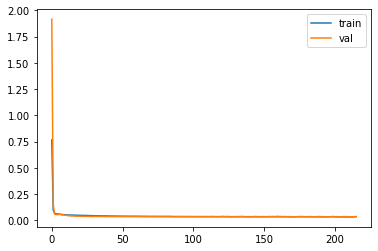

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 13)                52        
_________________________________________________________________
dense (Dense)                (None, 35)                490       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 33)                1188      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33)                0

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Training_THC_LowerCamp_2012_OUT.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/LowerCamp_THC.h5'
model_NN.save(precovid_model )

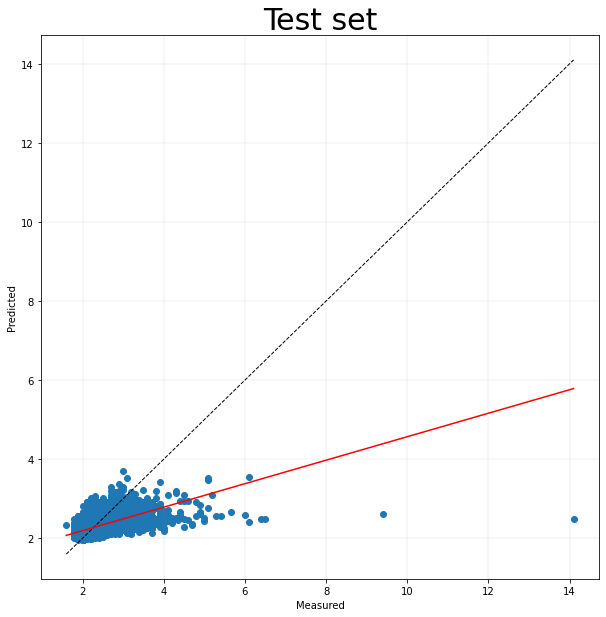

[0.29700195 1.5986791 ]
RMSE
[0.28202533]
R2
0.3251504152181649


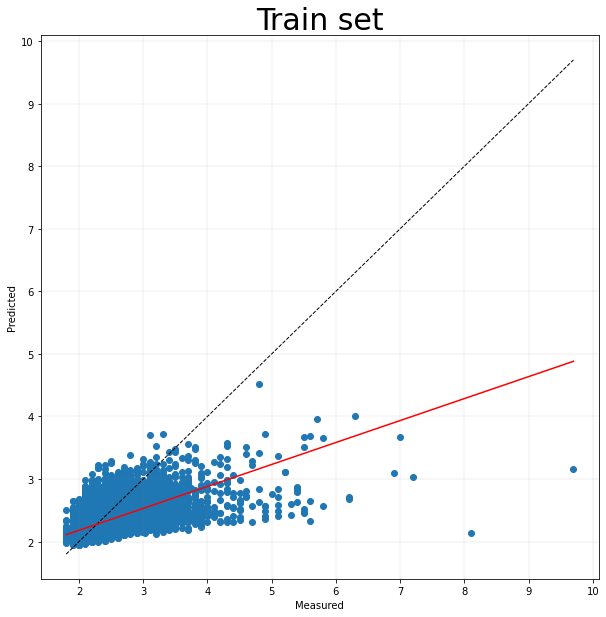

[0.35089567 1.47835371]
RMSE
[0.25690604]
R2
0.3954032354514999


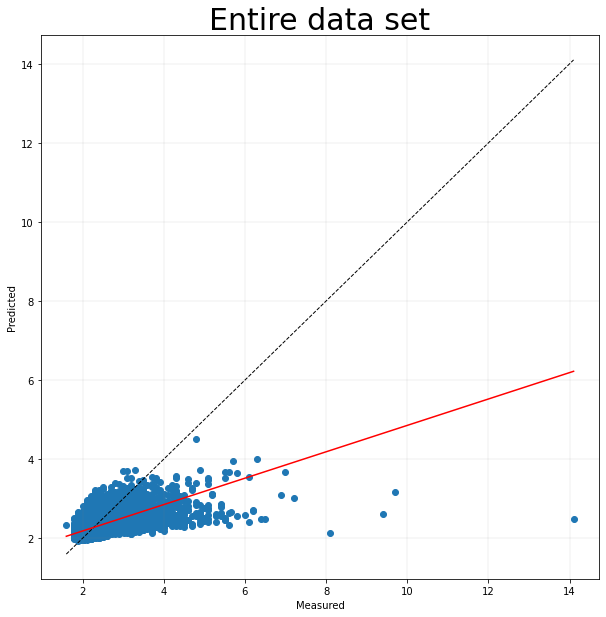

[0.33384629 1.51647125]
RMSE
[0.2646925]
R2
0.373178888414031


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 13)                52        
_________________________________________________________________
dense (Dense)                (None, 35)                490       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 33)                1188      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33)                0

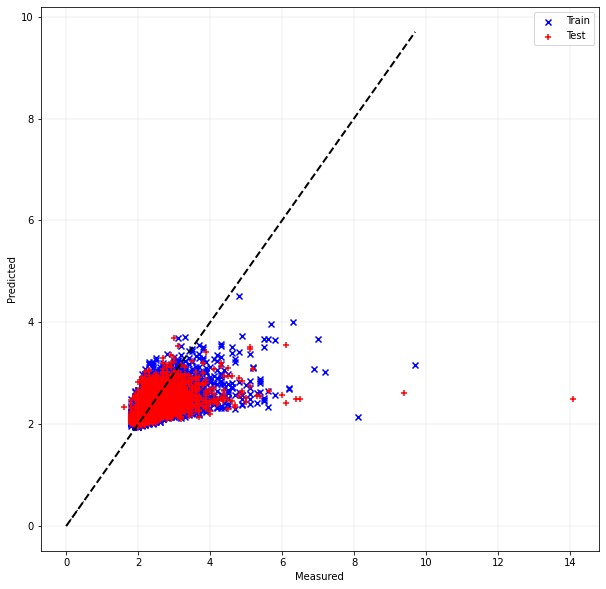

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

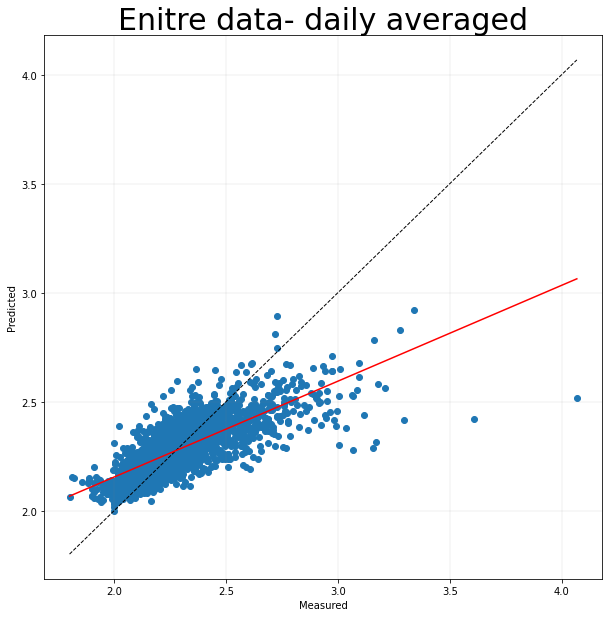

[0.43975607 1.27436219]
RMSE
[0.14521078]
R2
0.5494749441267368


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10[aa]).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

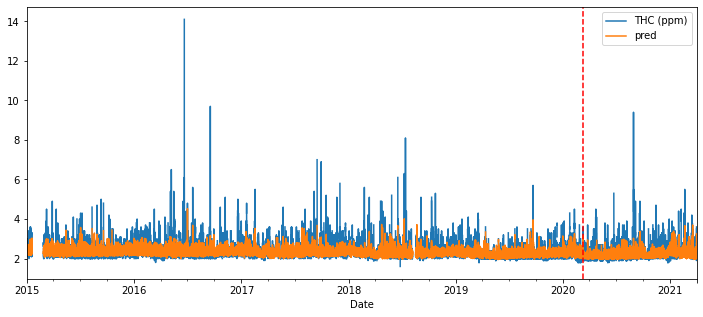

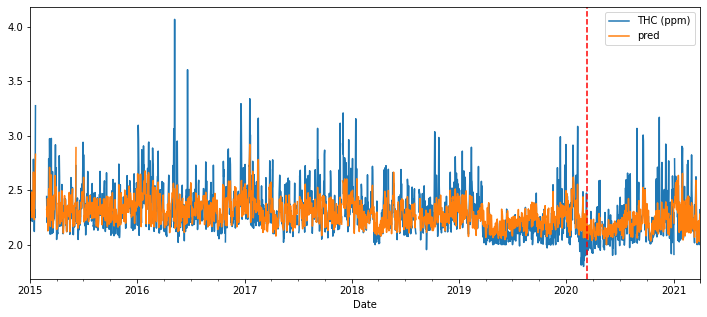

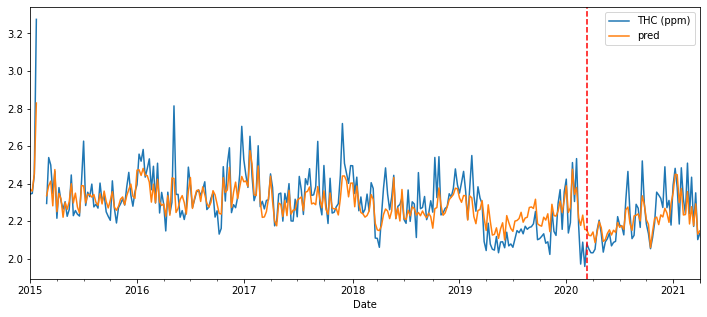

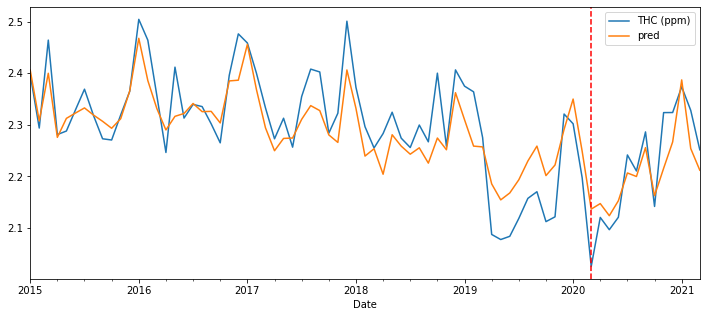

In [ ]:
df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[0.25690604]
0.3954032354514999


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[0.28202533]
0.3251504152181649


In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = ['T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_NN_THC_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_NN_THC_OR_Test.csv')

[0.25690604]
0.3954032354514999
[0.28202533]
0.3251504152181649


In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
179
2.31775164604187
2021-01-18 06:00:00
179
2.3212101459503174
2021-01-18 07:00:00
180
2.3258891105651855
2021-01-18 08:00:00
180
2.3293423652648926
2021-01-18 09:00:00
178
2.3310635089874268
2021-01-18 10:00:00
175
2.3357112407684326
2021-01-18 11:00:00
174
2.348353147506714
2021-01-18 12:00:00
170
2.3506336212158203
2021-01-18 13:00:00
169
2.3413021564483643
2021-01-18 14:00:00
174
2.356388807296753
2021-01-18 15:00:00
173
2.3966238498687744
2021-01-18 16:00:00
174
2.3982889652252197
2021-01-18 17:00:00
179
2.3892319202423096
2021-01-18 18:00:00
179
2.3882339000701904
2021-01-18 19:00:00
183
2.4284133911132812
2021-01-18 20:00:00
184
2.451472043991089
2021-01-18 21:00:00
182
2.427232265472412
2021-01-18 22:00:00
182
2.4315643310546875
2021-01-18 23:00:00
183
2.435088872909546
2021-01-19 00:00:00
182
2.2988836765289307
2021-01-19 01:00:00
182
2.3006718158721924
2021-01-19 02:00:00
181
2.3039772510528564
2021-01-19 03:00:00
182
2.3072

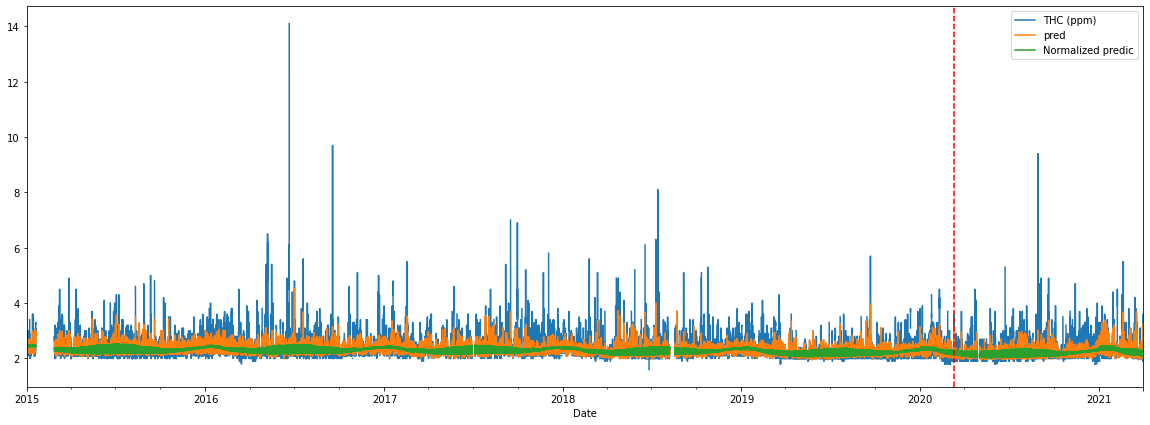

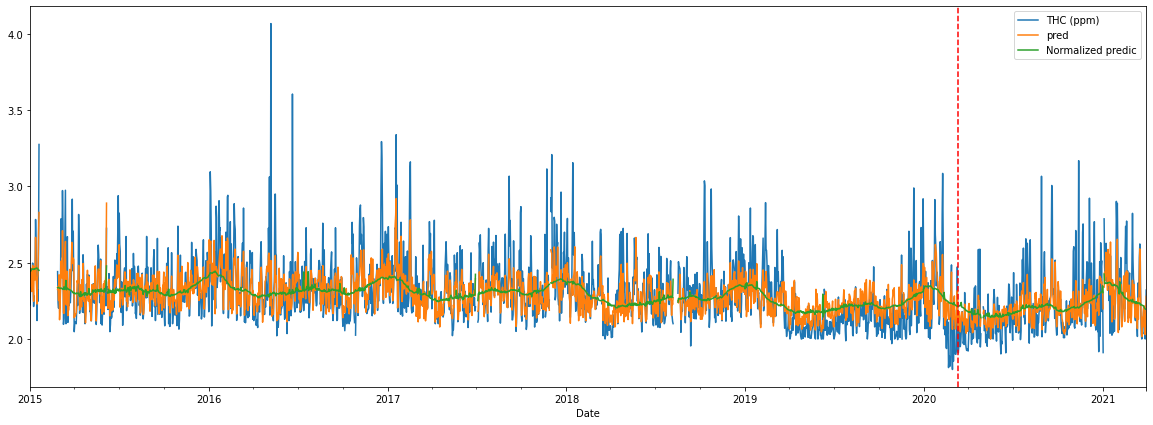

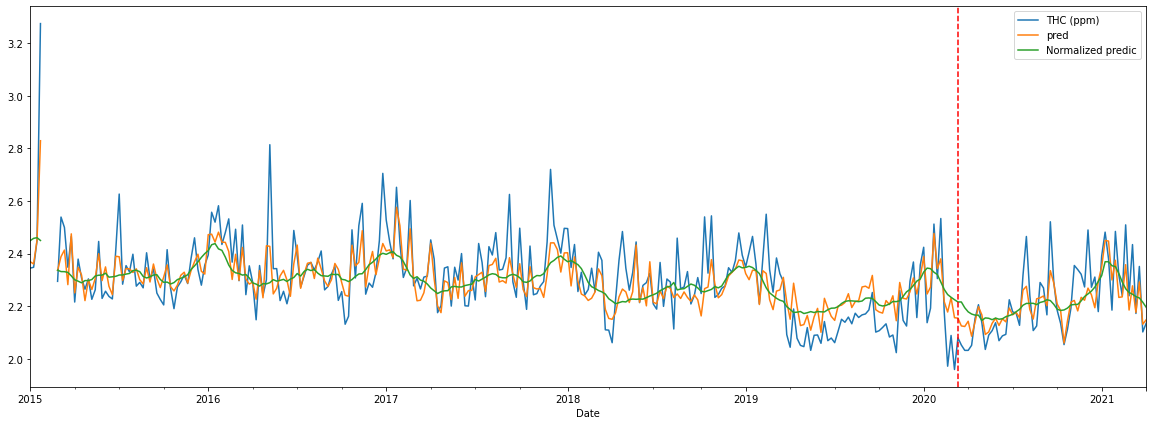

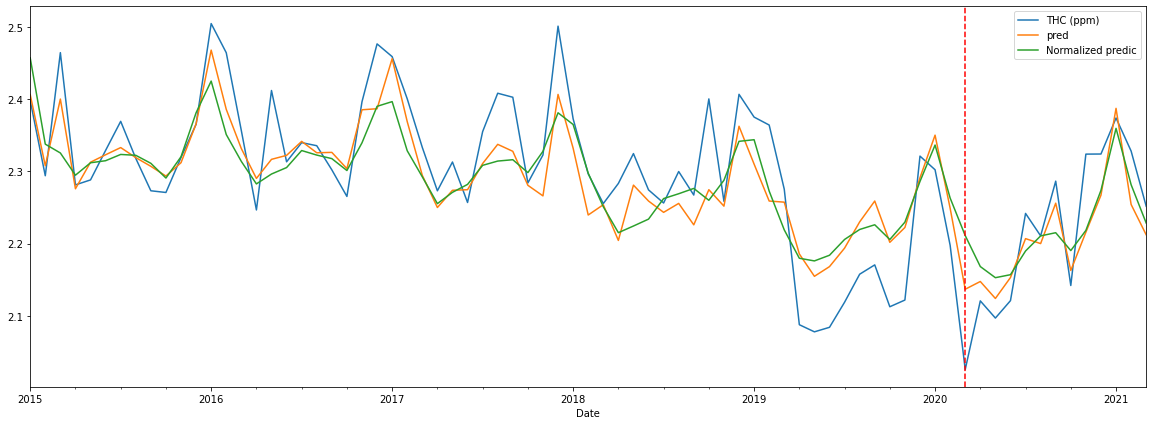

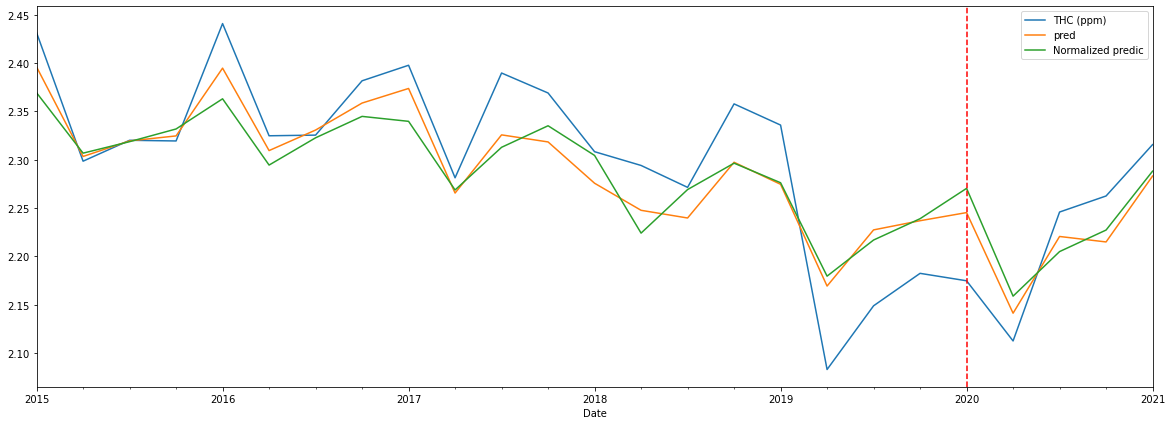

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCamp_THC_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCampe_THC_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCamp_THC_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

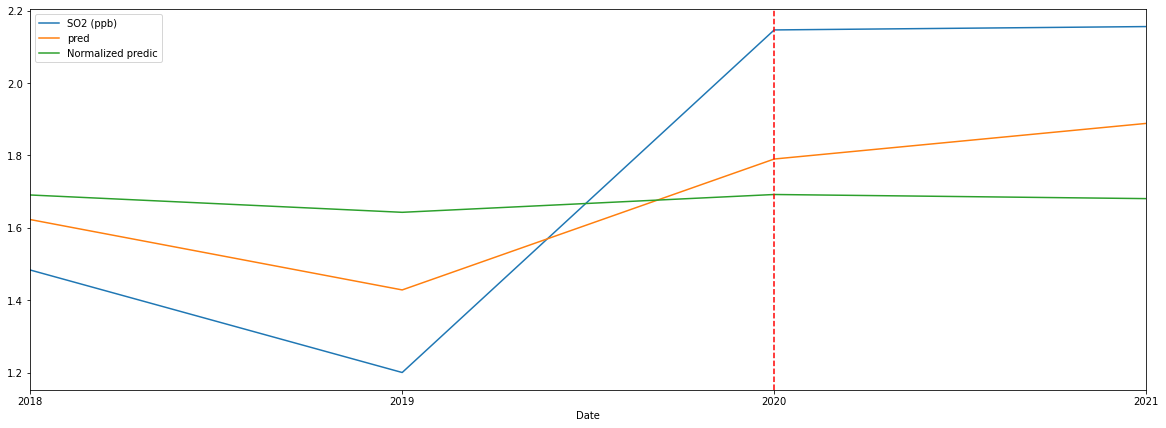

In [ ]:
df4_h['SO2 (ppb)'].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
####

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate


df2_w_c = df2_w[[ 'CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend',
       'driving', 'transit','walking',
]]
df2_w_c.columns

Index(['CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'driving', 'transit',
       'walking'],
      dtype='object')

In [ ]:
df2_w_c[['driving', 'transit', 'walking']]=df2_w_c[['driving', 'transit', 'walking']]/100

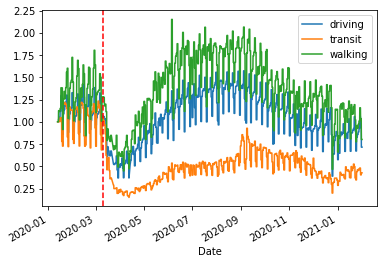

In [ ]:
df2_w_c[['driving', 'transit', 'walking']].plot()
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
a = df2_w_c[['driving', 'transit', 'walking']].loc[:'2020-03-11'].copy()
a.mean()

driving    1.124019
transit    1.025378
walking    1.331329
dtype: float64

In [ ]:
Y_a = df2_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df2_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df2_w_c[ ['driving', 'transit', 'walking']])


X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
print(np.shape(X_a),np.shape(X_b),np.shape(Y_a))

(9075, 12) (9075, 3) (9075, 1)


In [ ]:
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [ ]:
print(np.shape(X_train_a),np.shape(X_train_b))
print(np.shape(X_traine_a),np.shape(X_traine_b))
print(np.shape(X_val_a),np.shape(X_val_b))

(7260, 12) (7260, 3)
(5445, 12) (5445, 3)
(1815, 12) (1815, 3)


In [ ]:
best_params

{'batchsize': 2500.0,
 'drop_out1': 0.0057066589968766,
 'drop_out2': 0.008999530008727568,
 'drop_out3': 0.0006990849923195847,
 'layers': 3,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 24,
 'num_dense_nodes3': 28}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 35)                455       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24)                0

In [ ]:
class Objective2(object):
    def __init__(self, X_a,X_b, Y, max_epochs, learn_rate_epochs,
                  ):
        self.X_train_a, self.X_test_a, self.y_train_a, self.y_test_a = train_test_split(X_a, Y, test_size=0.001, random_state=42)
        self.X_train_b, self.X_test_b, self.y_train_b, self.y_test_b = train_test_split(X_b, Y, test_size=0.001, random_state=42)

        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.model_fixed = load_model(precovid_model)
        for i in range(0,len(self.model_fixed.layers)):
            self.model_fixed.layers[i].trainable = False

    def __call__(self, trial):        
        dict_params = { 
                        'last_layer' :trial.suggest_int('last_layer',0,1),
                        'two_layer' :trial.suggest_int('two_layer',0,1),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 1,3),
                       'num_dense_nodes2': trial.suggest_int('num_dense_nodes2', 1,8),
                        # 'layers': trial.suggest_int('layers', 2,3),
                       'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,2000,100)),
                      #  'drop_out1': trial.suggest_float('drop_out1',0.0, 0.2),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                       'layer_back' :-(trial.suggest_int('layer_back', 1,2)),
                       }  
        # print(dict_params[ 'layer_back'])
        l1 = Input(shape=(3,))
        l1_2 = BatchNormalization()(l1)
        l2 = Dense(dict_params['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
        l2_2 = LeakyReLU(alpha=dict_params['alpha'])(l2)
        if dict_params['two_layer'] ==1 :
             l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_3])
        else :
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_2])
        merged2 = BatchNormalization()(merged)

        if dict_params['last_layer'] == 0:
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)

        if dict_params['last_layer'] == 1:
            l5 = Dense(dict_params['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
            l5_1 = LeakyReLU(alpha=dict_params['alpha'])(l5)
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)          
        
        model = Model(inputs=[self.model_fixed.input,l1], outputs=l5_3)

        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params['learning_rate'])
        model.compile(loss='mse',optimizer=opt)
        fn2 = "gdrive/My Drive/Colab Notebooks/Stations/East_ED_NOX_apple" +str(trial.number) + ".ckpt" 
        fnn2 = os.path.dirname(fn2)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn2, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 5
        kf = KFold(n_splits=n_f )
        acc = 0 

        for train_index, test_index in kf.split( self.X_train_a):   
                X_tr_a, X_tes_a =  self.X_train_a[train_index],  self.X_train_a[test_index]
                X_tr_b, X_tes_b =  self.X_train_b[train_index],  self.X_train_b[test_index]
                y_tr, y_tes =   self.y_train_a[train_index],   self.y_train_a[test_index]    
                # fit the model
                X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split( X_tr_a,  y_tr, test_size=0.12, random_state = 42)
                X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split( X_tr_b,  y_tr, test_size=0.12, random_state = 42)


                model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=dict_params['batchsize'],
                  epochs=self.max_epochs,
                  shuffle=True, verbose=0,
                  callbacks=callbacks_list)
                
                model.load_weights(fn2)
                preds = model.predict([X_tes_a,X_tes_b]) 
                # print(np.shape(y_tes),np.shape( preds))
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 
        print(acc)
        return acc    

In [ ]:
objective2 = Objective2(X_a, X_b ,Y_a ,maximum_epochs, learning_rate_epochs)
study2 = optuna.create_study(direction=optimizer_direction, study_name='east_edm_CO_p2',storage='sqlite:///east_edm_CO_p2.db',load_if_exists=True)
study2.optimize(objective2, n_trials=300)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/CO_Edmonton_east_Hyperparams_Stations.csv')
study2.best_trial

[I 2021-04-18 06:37:44,453] A new study created in RDB with name: east_edm_CO_p2
[I 2021-04-18 06:40:22,320] Trial 0 finished with value: 0.0047897337392556185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 3, 'batchsize': 1300.0, 'learning_rate': 0.08684742896034063, 'alpha': 0.47486431649895633, 'layer_back': 1}. Best is trial 0 with value: 0.0047897337392556185.


0.0047897337392556185


[I 2021-04-18 06:46:17,741] Trial 1 finished with value: 0.0037995427144006185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 200.0, 'learning_rate': 0.026645640165432177, 'alpha': 0.2464432589680267, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0037995427144006185


[I 2021-04-18 06:49:06,028] Trial 2 finished with value: 0.004990117939045318 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1200.0, 'learning_rate': 0.04246052710121524, 'alpha': 0.14036321226448864, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.004990117939045318


[I 2021-04-18 06:51:38,749] Trial 3 finished with value: 0.004435081840883617 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.08019349670014007, 'alpha': 0.801795208357617, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004435081840883617


[I 2021-04-18 06:55:41,325] Trial 4 finished with value: 0.004397006773851628 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 400.0, 'learning_rate': 0.0922021495386216, 'alpha': 0.8714206976745991, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004397006773851628


[I 2021-04-18 06:58:39,803] Trial 5 finished with value: 0.004472224808431502 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 1, 'batchsize': 900.0, 'learning_rate': 0.054032085513753485, 'alpha': 0.36356263089297863, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004472224808431502


[I 2021-04-18 07:02:19,968] Trial 6 finished with value: 0.004032658481373844 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 500.0, 'learning_rate': 0.0034103388646587085, 'alpha': 0.8298599523597091, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004032658481373844


[I 2021-04-18 07:04:57,913] Trial 7 finished with value: 0.004412881161440907 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1400.0, 'learning_rate': 0.024560851403922612, 'alpha': 0.8657303593335849, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004412881161440907


[I 2021-04-18 07:07:33,362] Trial 8 finished with value: 0.003962766007027832 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1600.0, 'learning_rate': 0.0387484515918348, 'alpha': 0.5935061142207385, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.003962766007027832


[I 2021-04-18 07:10:45,080] Trial 9 finished with value: 0.004464174746733434 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 700.0, 'learning_rate': 0.07156430296741274, 'alpha': 0.6837562117270939, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004464174746733434


[I 2021-04-18 07:20:10,927] Trial 10 finished with value: 0.0047593223285363065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.006393597974084786, 'alpha': 0.09784392044369339, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.0047593223285363065


[I 2021-04-18 07:22:40,517] Trial 11 finished with value: 0.0038559859859853907 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 4, 'batchsize': 1900.0, 'learning_rate': 0.029641261114048665, 'alpha': 0.3455488342982123, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0038559859859853907


[I 2021-04-18 07:25:12,650] Trial 12 finished with value: 0.0037802072596256108 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 2000.0, 'learning_rate': 0.021318248161901757, 'alpha': 0.27421676161966496, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.0037802072596256108


[I 2021-04-18 07:34:39,100] Trial 13 finished with value: 0.003838305552608133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.01618259930894679, 'alpha': 0.2237909588852787, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.003838305552608133


[I 2021-04-18 07:37:13,171] Trial 14 finished with value: 0.0037727934709037452 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 1600.0, 'learning_rate': 0.05463156741271952, 'alpha': 0.023432883667647286, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.0037727934709037452


[I 2021-04-18 07:39:46,194] Trial 15 finished with value: 0.004717376020706112 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.057774493852787316, 'alpha': 0.013468966566860257, 'layer_back': 1}. Best is trial 14 with value: 0.0037727934709037452.


0.004717376020706112


[I 2021-04-18 07:42:17,141] Trial 16 finished with value: 0.003891606393255513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 4, 'batchsize': 1600.0, 'learning_rate': 0.06483099406582218, 'alpha': 0.048701457819810334, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.003891606393255513


[I 2021-04-18 07:44:50,068] Trial 17 finished with value: 0.003705317767648349 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.042981081545902175, 'alpha': 0.17151924705879706, 'layer_back': 2}. Best is trial 17 with value: 0.003705317767648349.


0.003705317767648349


[I 2021-04-18 07:47:22,992] Trial 18 finished with value: 0.003652074267837431 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043120594200074316, 'alpha': 0.15356515832757994, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003652074267837431


[I 2021-04-18 07:49:56,748] Trial 19 finished with value: 0.004855364207538971 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.03948108446690251, 'alpha': 0.1731767923827432, 'layer_back': 1}. Best is trial 18 with value: 0.003652074267837431.


0.004855364207538971


[I 2021-04-18 07:52:46,818] Trial 20 finished with value: 0.0036661417054684184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.045596783441498825, 'alpha': 0.46487314129271234, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0036661417054684184


[I 2021-04-18 07:55:47,695] Trial 21 finished with value: 0.003772814522212643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.04376219782019011, 'alpha': 0.495381372771252, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003772814522212643


[I 2021-04-18 07:58:33,572] Trial 22 finished with value: 0.0037000579251144777 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03235269324681574, 'alpha': 0.40139723428257024, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037000579251144777


[I 2021-04-18 08:01:16,242] Trial 23 finished with value: 0.0037201394146138406 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.0335829823820747, 'alpha': 0.561915944028579, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037201394146138406


[I 2021-04-18 08:04:15,280] Trial 24 finished with value: 0.0037030372913319023 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.01268992251227287, 'alpha': 0.3938061003278891, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037030372913319023


[I 2021-04-18 08:07:38,080] Trial 25 finished with value: 0.003918046517575021 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.04897050026188292, 'alpha': 0.6753399284001078, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003918046517575021


[I 2021-04-18 08:10:15,782] Trial 26 finished with value: 0.0038008433695184197 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.06522149016140043, 'alpha': 0.42163733919230845, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0038008433695184197


[I 2021-04-18 08:13:05,072] Trial 27 finished with value: 0.0036111388857046787 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.03298839085103375, 'alpha': 0.3150552800923347, 'layer_back': 2}. Best is trial 27 with value: 0.0036111388857046787.


0.0036111388857046787


[I 2021-04-18 08:16:08,056] Trial 28 finished with value: 0.003597443791057043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.04885615301916258, 'alpha': 0.29269304131799223, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.003597443791057043


[I 2021-04-18 08:19:12,662] Trial 29 finished with value: 0.0046809329310916956 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.05995146156015323, 'alpha': 0.30446311601011683, 'layer_back': 1}. Best is trial 28 with value: 0.003597443791057043.


0.0046809329310916956


[I 2021-04-18 08:21:45,673] Trial 30 finished with value: 0.004425357656736 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.0759352310855712, 'alpha': 0.21269011576180244, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.004425357656736


[I 2021-04-18 08:24:37,569] Trial 31 finished with value: 0.0036547160400316313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.049811468875869416, 'alpha': 0.510738346787994, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0036547160400316313


[I 2021-04-18 08:27:52,823] Trial 32 finished with value: 0.0037521087301732345 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.049503947678833926, 'alpha': 0.31735277463906175, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037521087301732345


[I 2021-04-18 08:30:36,307] Trial 33 finished with value: 0.0037683419447327986 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.03290226547777786, 'alpha': 0.5286190169685012, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037683419447327986


[I 2021-04-18 08:33:27,324] Trial 34 finished with value: 0.003597358919918322 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.036818841872599595, 'alpha': 0.12570513379804832, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003597358919918322


[I 2021-04-18 08:37:26,272] Trial 35 finished with value: 0.003661138596451478 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 400.0, 'learning_rate': 0.03671876888449163, 'alpha': 0.08397801305678194, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003661138596451478


[I 2021-04-18 08:40:27,101] Trial 36 finished with value: 0.00359203525150731 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.02437141103670945, 'alpha': 0.12749087727003588, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00359203525150731


[I 2021-04-18 08:43:26,782] Trial 37 finished with value: 0.0036756314419160397 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.018931547569790746, 'alpha': 0.2516407308762111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036756314419160397


[I 2021-04-18 08:48:02,902] Trial 38 finished with value: 0.0036545643870157882 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 300.0, 'learning_rate': 0.02603462599572944, 'alpha': 0.14443719906111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036545643870157882


[I 2021-04-18 08:51:18,641] Trial 39 finished with value: 0.004398658143913983 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.02412418866542985, 'alpha': 0.09261962247455818, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.004398658143913983


[I 2021-04-18 08:54:03,235] Trial 40 finished with value: 0.00366032853048446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 1200.0, 'learning_rate': 0.028075997597257207, 'alpha': 0.20259126107498393, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00366032853048446


[I 2021-04-18 08:57:05,594] Trial 41 finished with value: 0.003674477629447893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.03773808729024592, 'alpha': 0.13311556018712936, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.003674477629447893


[I 2021-04-18 08:59:59,665] Trial 42 finished with value: 0.0036705861586692643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.014115297813961467, 'alpha': 0.28611068588955, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036705861586692643


[I 2021-04-18 09:03:13,164] Trial 43 finished with value: 0.0036713389468197555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.04560695580139573, 'alpha': 0.3437569312771207, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036713389468197555


[I 2021-04-18 09:06:35,814] Trial 44 finished with value: 0.0035783836209078556 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.009070889461271204, 'alpha': 0.13887248911600195, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035783836209078556


[I 2021-04-18 09:09:57,729] Trial 45 finished with value: 0.003673148714195081 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 600.0, 'learning_rate': 0.009253166791610645, 'alpha': 0.2451607156425593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003673148714195081


[I 2021-04-18 09:14:01,355] Trial 46 finished with value: 0.004344271113195811 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 400.0, 'learning_rate': 0.001551960808838477, 'alpha': 0.10569886410992255, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004344271113195811


[I 2021-04-18 09:17:39,621] Trial 47 finished with value: 0.0037050254039840223 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.021082510170567333, 'alpha': 0.0668001215058446, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037050254039840223


[I 2021-04-18 09:20:38,142] Trial 48 finished with value: 0.0036692619534721047 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.007585468046031375, 'alpha': 0.2061475495973082, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036692619534721047


[I 2021-04-18 09:23:49,174] Trial 49 finished with value: 0.004457879746783033 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.03483835282389286, 'alpha': 0.018344801879960376, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004457879746783033


[I 2021-04-18 09:26:34,895] Trial 50 finished with value: 0.0035807581552902102 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03005652498704963, 'alpha': 0.11696356203274105, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035807581552902102


[I 2021-04-18 09:29:21,811] Trial 51 finished with value: 0.0036236342891670654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.09983893132352316, 'alpha': 0.11957067974916365, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036236342891670654


[I 2021-04-18 09:32:02,631] Trial 52 finished with value: 0.0036302435793163423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.02754867420830222, 'alpha': 0.05647608660638647, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036302435793163423


[I 2021-04-18 09:34:44,744] Trial 53 finished with value: 0.003627053068071688 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04005811816852655, 'alpha': 0.17080808493297003, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003627053068071688


[I 2021-04-18 09:37:45,884] Trial 54 finished with value: 0.0036920503523068266 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.017979831294330218, 'alpha': 0.2570823577331828, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036920503523068266


[I 2021-04-18 09:40:36,692] Trial 55 finished with value: 0.003612690295076574 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1000.0, 'learning_rate': 0.029552755284063505, 'alpha': 0.18039366495456732, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003612690295076574


[I 2021-04-18 09:43:40,566] Trial 56 finished with value: 0.004012695527376038 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 800.0, 'learning_rate': 0.022565925713046567, 'alpha': 0.03734236499524329, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004012695527376038


[I 2021-04-18 09:47:16,794] Trial 57 finished with value: 0.003698018600704401 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 500.0, 'learning_rate': 0.05338960509962787, 'alpha': 0.35126328332328843, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003698018600704401


[I 2021-04-18 09:50:04,725] Trial 58 finished with value: 0.003619003598112455 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.011669376031158469, 'alpha': 0.2338658479883975, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003619003598112455


[I 2021-04-18 09:53:02,416] Trial 59 finished with value: 0.0036054917675212707 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.031117560438016202, 'alpha': 0.12690434404626497, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036054917675212707


[I 2021-04-18 09:56:06,738] Trial 60 finished with value: 0.003886966241395085 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.003565187588275332, 'alpha': 0.12617304287730674, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003886966241395085


[I 2021-04-18 09:59:11,214] Trial 61 finished with value: 0.003618826532739045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.03119470670070372, 'alpha': 0.06717581966642143, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003618826532739045


[I 2021-04-18 10:02:02,407] Trial 62 finished with value: 0.0037632189106060355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1000.0, 'learning_rate': 0.04059941279624269, 'alpha': 0.16862336495408595, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037632189106060355


[I 2021-04-18 10:05:19,179] Trial 63 finished with value: 0.003794832132947586 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 700.0, 'learning_rate': 0.036734160746832493, 'alpha': 0.01101319432018788, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003794832132947586


[I 2021-04-18 10:08:20,419] Trial 64 finished with value: 0.003758988776972788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.029855268948976825, 'alpha': 0.4386976096021802, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003758988776972788


[I 2021-04-18 10:11:42,186] Trial 65 finished with value: 0.0035876522982958357 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.024552341120126213, 'alpha': 0.20134794489311997, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035876522982958357


[I 2021-04-18 10:15:04,777] Trial 66 finished with value: 0.0036155628523736184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.016447401975405944, 'alpha': 0.14664495950811754, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036155628523736184


[I 2021-04-18 10:18:40,103] Trial 67 finished with value: 0.0037361543406670638 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.02482879535124779, 'alpha': 0.18911509071408622, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037361543406670638


[I 2021-04-18 10:23:14,465] Trial 68 finished with value: 0.004737399253546576 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 300.0, 'learning_rate': 0.045839207163365064, 'alpha': 0.11572139542681772, 'layer_back': 1}. Best is trial 44 with value: 0.0035783836209078556.


0.004737399253546576


[I 2021-04-18 10:26:17,521] Trial 69 finished with value: 0.0035844609162026856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.021759460493932996, 'alpha': 0.08938362393003896, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035844609162026856


[I 2021-04-18 10:29:40,721] Trial 70 finished with value: 0.003647474821726536 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.020584896822209618, 'alpha': 0.08688700495047245, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003647474821726536


[I 2021-04-18 10:32:40,862] Trial 71 finished with value: 0.0036240235360119194 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.026636013810065286, 'alpha': 0.04460753701062606, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036240235360119194


[I 2021-04-18 10:35:57,924] Trial 72 finished with value: 0.003678997217185063 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 700.0, 'learning_rate': 0.02380154186526011, 'alpha': 0.15140441320203327, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003678997217185063


[I 2021-04-18 10:39:01,596] Trial 73 finished with value: 0.003659856745198834 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.015277005770461548, 'alpha': 0.2178303763286192, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003659856745198834


[I 2021-04-18 10:42:16,571] Trial 74 finished with value: 0.0036399907750272265 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.011408912622706538, 'alpha': 0.10321869296892679, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036399907750272265


[I 2021-04-18 10:45:19,285] Trial 75 finished with value: 0.0037281104148537535 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.035323452421033984, 'alpha': 0.2846749869393032, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037281104148537535


[I 2021-04-18 10:48:06,701] Trial 76 finished with value: 0.00361764726075232 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.018785055346852722, 'alpha': 0.08247223174383175, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.00361764726075232


[I 2021-04-18 10:51:06,829] Trial 77 finished with value: 0.0036951690746862827 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.030036815811613576, 'alpha': 0.15370233117847767, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036951690746862827


[I 2021-04-18 10:53:48,194] Trial 78 finished with value: 0.003591197553125669 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.021596734858180668, 'alpha': 0.19705749126102656, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003591197553125669


[I 2021-04-18 10:56:31,899] Trial 79 finished with value: 0.0036875580454355968 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.004996727049177942, 'alpha': 0.19630957319700593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036875580454355968


[I 2021-04-18 10:59:15,173] Trial 80 finished with value: 0.003672630637413495 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.009725768873874269, 'alpha': 0.23904793658858925, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003672630637413495


[I 2021-04-18 11:02:33,338] Trial 81 finished with value: 0.003608277041588192 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.021177055101469718, 'alpha': 0.13273475258504627, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003608277041588192


[I 2021-04-18 11:05:23,493] Trial 82 finished with value: 0.0035357134156083006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03251063586877488, 'alpha': 0.16601335847048496, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035357134156083006


[I 2021-04-18 11:08:10,650] Trial 83 finished with value: 0.0035800395220561315 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027507014638668944, 'alpha': 0.26952999743969175, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035800395220561315


[I 2021-04-18 11:10:53,530] Trial 84 finished with value: 0.003641285084880817 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.024468913257262442, 'alpha': 0.26941083528596615, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003641285084880817


[I 2021-04-18 11:13:33,120] Trial 85 finished with value: 0.003613639352689042 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.027506935493900007, 'alpha': 0.16554636650660334, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003613639352689042


[I 2021-04-18 11:16:13,848] Trial 86 finished with value: 0.0035454609704569555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034075180962035656, 'alpha': 0.19205737194876213, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035454609704569555


[I 2021-04-18 11:18:54,396] Trial 87 finished with value: 0.0036217548071173097 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.018105506543334197, 'alpha': 0.2172761829124636, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036217548071173097


[I 2021-04-18 11:21:32,202] Trial 88 finished with value: 0.0036196131119005967 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.013644839043071016, 'alpha': 0.18554443324755185, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036196131119005967


[I 2021-04-18 11:24:10,911] Trial 89 finished with value: 0.003572944589854708 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02174303974596932, 'alpha': 0.06885902281378707, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003572944589854708


[I 2021-04-18 11:26:50,606] Trial 90 finished with value: 0.003906346283951516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1500.0, 'learning_rate': 0.03323653174387488, 'alpha': 0.03163285232628042, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003906346283951516


[I 2021-04-18 11:29:31,353] Trial 91 finished with value: 0.003578888868218704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.022580602914511808, 'alpha': 0.06713185538847133, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003578888868218704


[I 2021-04-18 11:32:08,581] Trial 92 finished with value: 0.0035789263141083713 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.021256605621501615, 'alpha': 0.06634621015162126, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035789263141083713


[I 2021-04-18 11:34:49,916] Trial 93 finished with value: 0.003544189206426239 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02748340529865124, 'alpha': 0.07868991239964429, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003544189206426239


[I 2021-04-18 11:37:33,179] Trial 94 finished with value: 0.0035499476797488643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02892486834145689, 'alpha': 0.07221984870581319, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035499476797488643


[I 2021-04-18 11:40:14,572] Trial 95 finished with value: 0.0035273632980514285 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.027834554447690413, 'alpha': 0.06732285000688103, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035273632980514285


[I 2021-04-18 11:42:52,853] Trial 96 finished with value: 0.0036086771352365947 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02637530840203316, 'alpha': 0.05953489610216768, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036086771352365947


[I 2021-04-18 11:45:38,794] Trial 97 finished with value: 0.0035684357428775186 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027517728652115728, 'alpha': 0.07593898838347986, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035684357428775186


[I 2021-04-18 11:48:20,507] Trial 98 finished with value: 0.003583852513729412 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03367874759681739, 'alpha': 0.06942447131849512, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003583852513729412


[I 2021-04-18 11:50:57,066] Trial 99 finished with value: 0.003541288425685317 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.041358766423868744, 'alpha': 0.021920382234198947, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003541288425685317


[I 2021-04-18 11:53:42,845] Trial 100 finished with value: 0.0036243488752047467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04030568364072326, 'alpha': 0.02384229949250582, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036243488752047467


[I 2021-04-18 11:56:21,539] Trial 101 finished with value: 0.003627937411450544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.035398043970041676, 'alpha': 0.03950052041260174, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627937411450544


[I 2021-04-18 11:59:00,418] Trial 102 finished with value: 0.003627126043875543 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03832592467033967, 'alpha': 0.10048283220351684, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627126043875543


[I 2021-04-18 12:01:36,789] Trial 103 finished with value: 0.0035408315369076784 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032256016881253326, 'alpha': 0.07030089565296588, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035408315369076784


[I 2021-04-18 12:04:17,971] Trial 104 finished with value: 0.003566082616285739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04262395762710679, 'alpha': 0.01173160141920479, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003566082616285739


[I 2021-04-18 12:06:58,238] Trial 105 finished with value: 0.0035737931205732376 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04227819138674002, 'alpha': 0.010660044984515019, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035737931205732376


[I 2021-04-18 12:09:32,119] Trial 106 finished with value: 0.0035184089995725617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043629287038235834, 'alpha': 0.010426390915745402, 'layer_back': 2}. Best is trial 106 with value: 0.0035184089995725617.


0.0035184089995725617


[I 2021-04-18 12:12:07,413] Trial 107 finished with value: 0.0034912184906821125 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04304162747051637, 'alpha': 0.044280753511746956, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0034912184906821125


[I 2021-04-18 12:14:44,123] Trial 108 finished with value: 0.0036380100736029142 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046899784330746694, 'alpha': 0.011423731168029368, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036380100736029142


[I 2021-04-18 12:17:20,619] Trial 109 finished with value: 0.0035930917231830005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05312662202242775, 'alpha': 0.04766526633420203, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035930917231830005


[I 2021-04-18 12:19:56,882] Trial 110 finished with value: 0.0035019395412586403 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04297554301809757, 'alpha': 0.03108575464071467, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035019395412586403


[I 2021-04-18 12:22:26,683] Trial 111 finished with value: 0.0035799057324392095 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.042791521010711986, 'alpha': 0.033242351358857565, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035799057324392095


[I 2021-04-18 12:25:01,093] Trial 112 finished with value: 0.003567586631908924 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04188075691123601, 'alpha': 0.012902457195305648, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567586631908924


[I 2021-04-18 12:27:37,137] Trial 113 finished with value: 0.003552786707766206 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04705313553365665, 'alpha': 0.024024393886675065, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003552786707766206


[I 2021-04-18 12:30:14,683] Trial 114 finished with value: 0.0035491374611036066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04792414670441766, 'alpha': 0.04942912887788908, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035491374611036066


[I 2021-04-18 12:32:47,942] Trial 115 finished with value: 0.003934744163417141 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.05138779832449931, 'alpha': 0.7678284116404237, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003934744163417141


[I 2021-04-18 12:35:21,813] Trial 116 finished with value: 0.0035480745063304685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04672929967596791, 'alpha': 0.0543681486748597, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035480745063304685


[I 2021-04-18 12:37:57,950] Trial 117 finished with value: 0.003645209428448006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.058597540974892046, 'alpha': 0.054075814336391005, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003645209428448006


[I 2021-04-18 12:40:31,646] Trial 118 finished with value: 0.003635834268763575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04497558570260886, 'alpha': 0.10395749038880057, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003635834268763575


[I 2021-04-18 12:43:09,338] Trial 119 finished with value: 0.0036447334704852665 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1800.0, 'learning_rate': 0.04781462434994531, 'alpha': 0.04268750205527756, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036447334704852665


[I 2021-04-18 12:45:44,270] Trial 120 finished with value: 0.003567690380984065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.037831602089136926, 'alpha': 0.0894939850401166, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567690380984065


[I 2021-04-18 12:48:19,955] Trial 121 finished with value: 0.0036418865284299482 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.049910163797960434, 'alpha': 0.02265761100617698, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036418865284299482


[I 2021-04-18 12:50:50,152] Trial 122 finished with value: 0.003626350371093418 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04409374352769631, 'alpha': 0.04839758470877351, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003626350371093418


[I 2021-04-18 12:53:25,935] Trial 123 finished with value: 0.004068899031879057 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 1900.0, 'learning_rate': 0.04692551724599392, 'alpha': 0.027164865650236767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004068899031879057


[I 2021-04-18 12:56:09,582] Trial 124 finished with value: 0.003549524306460534 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.05601252997839943, 'alpha': 0.08216270418670965, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003549524306460534


[I 2021-04-18 12:58:52,986] Trial 125 finished with value: 0.0036022166677025626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.051026693295636215, 'alpha': 0.08169432284004574, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036022166677025626


[I 2021-04-18 13:01:25,923] Trial 126 finished with value: 0.0036323884269265395 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05755736475611723, 'alpha': 0.10764012747900042, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036323884269265395


[I 2021-04-18 13:04:06,681] Trial 127 finished with value: 0.0035868803510106743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.06484074739859898, 'alpha': 0.04916233098402338, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035868803510106743


[I 2021-04-18 13:06:48,784] Trial 128 finished with value: 0.003632038891645508 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.05481967090549042, 'alpha': 0.09493718561374137, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632038891645508


[I 2021-04-18 13:09:24,704] Trial 129 finished with value: 0.0036332687347207073 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.06164699827462552, 'alpha': 0.11368639196612304, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036332687347207073


[I 2021-04-18 13:12:02,225] Trial 130 finished with value: 0.0036107090038871685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.031913432524153476, 'alpha': 0.07944764608488178, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036107090038871685


[I 2021-04-18 13:14:37,997] Trial 131 finished with value: 0.003543857849946714 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04047866711207972, 'alpha': 0.03334890991576665, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003543857849946714


[I 2021-04-18 13:17:10,956] Trial 132 finished with value: 0.003614544482168527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03927975006627224, 'alpha': 0.05750478466882326, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003614544482168527


[I 2021-04-18 13:19:52,496] Trial 133 finished with value: 0.0036289459230039846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03602600147397279, 'alpha': 0.03879102885756539, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036289459230039846


[I 2021-04-18 13:22:21,926] Trial 134 finished with value: 0.004397730627210862 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04121745337090514, 'alpha': 0.07727507999023213, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004397730627210862


[I 2021-04-18 13:25:09,682] Trial 135 finished with value: 0.0035954891884910044 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.05591938878661566, 'alpha': 0.011489115255243473, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035954891884910044


[I 2021-04-18 13:27:46,099] Trial 136 finished with value: 0.003632190940638184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04473961188420494, 'alpha': 0.05883472932516892, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632190940638184


[I 2021-04-18 13:30:22,676] Trial 137 finished with value: 0.004797824764292689 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03394020855741806, 'alpha': 0.6177230050734727, 'layer_back': 1}. Best is trial 107 with value: 0.0034912184906821125.


0.004797824764292689


[I 2021-04-18 13:32:54,827] Trial 138 finished with value: 0.0035575625191086686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03925631108791122, 'alpha': 0.02976577533102045, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035575625191086686


[I 2021-04-18 13:35:35,526] Trial 139 finished with value: 0.0037383972180743746 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.02925391477758371, 'alpha': 0.13393207397187767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037383972180743746


[I 2021-04-18 13:38:16,882] Trial 140 finished with value: 0.003617621733455551 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03195637257591547, 'alpha': 0.0947751465706642, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003617621733455551


[I 2021-04-18 13:40:50,663] Trial 141 finished with value: 0.003579242154278799 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0485447382823182, 'alpha': 0.01176858180870248, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003579242154278799


[I 2021-04-18 13:43:25,476] Trial 142 finished with value: 0.0035750086655864273 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.046567743860348884, 'alpha': 0.026818371099279946, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035750086655864273


[I 2021-04-18 13:46:00,498] Trial 143 finished with value: 0.003623829402881311 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03742158374219033, 'alpha': 0.04975293319513799, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003623829402881311


[I 2021-04-18 13:48:38,218] Trial 144 finished with value: 0.0036066806414085484 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05148602571649974, 'alpha': 0.010300864640383572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036066806414085484


[I 2021-04-18 13:51:09,839] Trial 145 finished with value: 0.003610979298586066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.043772802510158214, 'alpha': 0.07001141819525372, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003610979298586066


[I 2021-04-18 13:53:44,355] Trial 146 finished with value: 0.0035619962671982527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04082403791540483, 'alpha': 0.035248606443724864, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035619962671982527


[I 2021-04-18 13:56:26,877] Trial 147 finished with value: 0.003548864702878114 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04862893209367515, 'alpha': 0.11504554485639235, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003548864702878114


[I 2021-04-18 13:59:07,487] Trial 148 finished with value: 0.0036127803252306075 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034866037784612974, 'alpha': 0.15803031484071783, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036127803252306075


[I 2021-04-18 14:01:52,630] Trial 149 finished with value: 0.0035717142472204513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04905384303207223, 'alpha': 0.11415311920269179, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035717142472204513


[I 2021-04-18 14:04:32,812] Trial 150 finished with value: 0.0035749882689068164 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04526973875676865, 'alpha': 0.14572957071712894, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035749882689068164


[I 2021-04-18 14:07:16,399] Trial 151 finished with value: 0.0035993304069324022 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.052491361045237814, 'alpha': 0.08397349335013253, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035993304069324022


[I 2021-04-18 14:09:58,621] Trial 152 finished with value: 0.0035685056911281127 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04837346606791395, 'alpha': 0.06310254703879091, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035685056911281127


[I 2021-04-18 14:12:29,525] Trial 153 finished with value: 0.003629879513305761 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0438214208862195, 'alpha': 0.10403865238259322, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003629879513305761


[I 2021-04-18 14:15:14,227] Trial 154 finished with value: 0.0036221795403482207 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03029487512047642, 'alpha': 0.04348614544060133, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036221795403482207


[I 2021-04-18 14:17:57,080] Trial 155 finished with value: 0.0035922583407074988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.03843837268200991, 'alpha': 0.08433177217864488, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035922583407074988


[I 2021-04-18 14:20:36,152] Trial 156 finished with value: 0.003578072413719791 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.046367859672450995, 'alpha': 0.12254720867272155, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003578072413719791


[I 2021-04-18 14:23:15,649] Trial 157 finished with value: 0.0038583845758324883 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0871450624590979, 'alpha': 0.056755344230540905, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0038583845758324883


[I 2021-04-18 14:25:52,255] Trial 158 finished with value: 0.003580582397543033 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.041182684797758676, 'alpha': 0.031335914276621774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003580582397543033


[I 2021-04-18 14:28:31,244] Trial 159 finished with value: 0.003571554999049949 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.050511120203456654, 'alpha': 0.011355553310716315, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003571554999049949


[I 2021-04-18 14:31:10,768] Trial 160 finished with value: 0.0035740442082979025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1300.0, 'learning_rate': 0.054629022232272034, 'alpha': 0.09769506994297086, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035740442082979025


[I 2021-04-18 14:33:46,785] Trial 161 finished with value: 0.0035316717327896836 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03947842688021926, 'alpha': 0.02587334876105694, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035316717327896836


[I 2021-04-18 14:36:22,973] Trial 162 finished with value: 0.003583261784611461 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0426931007941171, 'alpha': 0.06941424492182441, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003583261784611461


[I 2021-04-18 14:38:56,920] Trial 163 finished with value: 0.0035638605296477717 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03698103592588202, 'alpha': 0.02604575458608599, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035638605296477717


[I 2021-04-18 14:41:34,556] Trial 164 finished with value: 0.0036057247992290833 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.033843190233136235, 'alpha': 0.054628128789041205, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036057247992290833


[I 2021-04-18 14:44:05,291] Trial 165 finished with value: 0.0036577139832949667 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.02862847367159879, 'alpha': 0.041190982009615476, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036577139832949667


[I 2021-04-18 14:46:34,411] Trial 166 finished with value: 0.0035796291367728578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.03989602686737119, 'alpha': 0.07720076451956273, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035796291367728578


[I 2021-04-18 14:48:58,970] Trial 167 finished with value: 0.003644684403214736 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.031894620734671836, 'alpha': 0.011244612673171901, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003644684403214736


[I 2021-04-18 14:51:15,955] Trial 168 finished with value: 0.003719212403160626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.061535654734255804, 'alpha': 0.04944139280228774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003719212403160626


[I 2021-04-18 14:53:47,133] Trial 169 finished with value: 0.003569251268532048 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04736210238892834, 'alpha': 0.0924816749854882, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003569251268532048


[I 2021-04-18 14:56:10,412] Trial 170 finished with value: 0.0037302293516410364 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 1800.0, 'learning_rate': 0.042194509368665326, 'alpha': 0.026662365080105572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037302293516410364


[I 2021-04-18 14:58:32,142] Trial 171 finished with value: 0.003412203995094343 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003412203995094343


[I 2021-04-18 15:00:56,204] Trial 172 finished with value: 0.003615212962045835 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.035269743884066396, 'alpha': 0.06515792117672077, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003615212962045835


[I 2021-04-18 15:03:19,432] Trial 173 finished with value: 0.0035065927685166407 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04495904398462532, 'alpha': 0.03706846553808014, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035065927685166407


[I 2021-04-18 15:05:42,080] Trial 174 finished with value: 0.0036824767911479953 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.044788002773288774, 'alpha': 0.04279176989414291, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036824767911479953


[I 2021-04-18 15:07:59,615] Trial 175 finished with value: 0.0036000802274304988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03973925069572923, 'alpha': 0.06946943028331976, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036000802274304988


[I 2021-04-18 15:10:20,601] Trial 176 finished with value: 0.0035611477676499243 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03702719792209683, 'alpha': 0.1178740272614942, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035611477676499243


[I 2021-04-18 15:12:44,718] Trial 177 finished with value: 0.0035568862168302313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04446509916080676, 'alpha': 0.035536762139547574, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035568862168302313


[I 2021-04-18 15:15:03,641] Trial 178 finished with value: 0.0035634161691522025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.02555669877180687, 'alpha': 0.01426667868106541, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035634161691522025


[I 2021-04-18 15:17:27,644] Trial 179 finished with value: 0.0035478477954239184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.041044999411233324, 'alpha': 0.05809175905373737, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035478477954239184


[I 2021-04-18 15:19:49,604] Trial 180 finished with value: 0.003577680895181763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04266781899508782, 'alpha': 0.057332493065063835, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577680895181763


[I 2021-04-18 15:22:18,574] Trial 181 finished with value: 0.0037241810267514214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04124794281390582, 'alpha': 0.08344018331911048, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0037241810267514214


[I 2021-04-18 15:24:42,413] Trial 182 finished with value: 0.003574937953275326 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03909174129413975, 'alpha': 0.04955591990925821, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574937953275326


[I 2021-04-18 15:27:09,745] Trial 183 finished with value: 0.0035062207386055725 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032919202764146074, 'alpha': 0.10296721914045874, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035062207386055725


[I 2021-04-18 15:29:33,614] Trial 184 finished with value: 0.003607310672142692 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03299384364237505, 'alpha': 0.13543758486151475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003607310672142692


[I 2021-04-18 15:31:56,820] Trial 185 finished with value: 0.0035645622965729045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.036200243037322145, 'alpha': 0.10015962959305305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035645622965729045


[I 2021-04-18 15:34:23,869] Trial 186 finished with value: 0.0035128649499357135 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04591334979902456, 'alpha': 0.01300643385682445, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035128649499357135


[I 2021-04-18 15:36:50,059] Trial 187 finished with value: 0.003512579959993758 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.045967118012657425, 'alpha': 0.02955287318190126, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512579959993758


[I 2021-04-18 15:39:17,519] Trial 188 finished with value: 0.003601852298015445 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04515211154273283, 'alpha': 0.02414511899844717, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003601852298015445


[I 2021-04-18 15:41:44,658] Trial 189 finished with value: 0.003551257039072739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.043685650639080496, 'alpha': 0.011272541261604586, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003551257039072739


[I 2021-04-18 15:44:08,778] Trial 190 finished with value: 0.0035124462407048578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04088523362317096, 'alpha': 0.027965921768034883, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035124462407048578


[I 2021-04-18 15:46:32,527] Trial 191 finished with value: 0.0036034748711966606 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04059492734596064, 'alpha': 0.0316931464485652, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036034748711966606


[I 2021-04-18 15:48:52,857] Trial 192 finished with value: 0.0035462040161388982 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038480226797782575, 'alpha': 0.013080349410333715, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035462040161388982


[I 2021-04-18 15:51:15,074] Trial 193 finished with value: 0.003514729419201148 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038804046086792734, 'alpha': 0.01722318588576137, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003514729419201148


[I 2021-04-18 15:53:39,774] Trial 194 finished with value: 0.003530635344402702 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038022625191625484, 'alpha': 0.010260560665283323, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003530635344402702


[I 2021-04-18 15:56:01,357] Trial 195 finished with value: 0.0036120263950969846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.037603653740255726, 'alpha': 0.010350360726464305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036120263950969846


[I 2021-04-18 15:58:21,259] Trial 196 finished with value: 0.0035517522803226497 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03532284563567649, 'alpha': 0.012252207673505294, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035517522803226497


[I 2021-04-18 16:00:42,685] Trial 197 finished with value: 0.0035774729128351572 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03851591509172416, 'alpha': 0.024592933498452187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035774729128351572


[I 2021-04-18 16:03:10,397] Trial 198 finished with value: 0.0036300873338133174 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03161093718448926, 'alpha': 0.011231732922341914, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036300873338133174


[I 2021-04-18 16:05:32,864] Trial 199 finished with value: 0.003594899268962292 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03400517384369343, 'alpha': 0.010987625678645163, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594899268962292


[I 2021-04-18 16:07:55,556] Trial 200 finished with value: 0.003507502110225467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03903066389229184, 'alpha': 0.03436414346888904, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003507502110225467


[I 2021-04-18 16:10:20,454] Trial 201 finished with value: 0.0035410174116621788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0385769119015159, 'alpha': 0.03980816279456982, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035410174116621788


[I 2021-04-18 16:12:45,074] Trial 202 finished with value: 0.003500324891873184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042028674607372564, 'alpha': 0.035300834875109204, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003500324891873184


[I 2021-04-18 16:15:09,269] Trial 203 finished with value: 0.0035591510309502424 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04246721082689016, 'alpha': 0.03438254597895686, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035591510309502424


[I 2021-04-18 16:17:27,832] Trial 204 finished with value: 0.0035809591968109468 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03985309920583796, 'alpha': 0.03051312835022787, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035809591968109468


[I 2021-04-18 16:19:46,336] Trial 205 finished with value: 0.0035329556853449626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04302937726174949, 'alpha': 0.041497953561731075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035329556853449626


[I 2021-04-18 16:22:06,046] Trial 206 finished with value: 0.0035995980573277605 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042934896863311735, 'alpha': 0.039304783000125264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035995980573277605


[I 2021-04-18 16:24:23,248] Trial 207 finished with value: 0.0036285669261463425 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04139101863112104, 'alpha': 0.04261236299648191, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036285669261463425


[I 2021-04-18 16:26:41,935] Trial 208 finished with value: 0.0035261087563540814 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.036838583737843406, 'alpha': 0.010914683684806366, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035261087563540814


[I 2021-04-18 16:28:57,689] Trial 209 finished with value: 0.0036736991070403626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03673113267779741, 'alpha': 0.01411948992981912, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036736991070403626


[I 2021-04-18 16:31:14,218] Trial 210 finished with value: 0.003515510628468558 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0375123413072075, 'alpha': 0.026801330195408788, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003515510628468558


[I 2021-04-18 16:33:31,616] Trial 211 finished with value: 0.0036619003719104474 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03820623138649496, 'alpha': 0.010153124386418449, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036619003719104474


[I 2021-04-18 16:35:49,042] Trial 212 finished with value: 0.003602818230449912 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03959580915067272, 'alpha': 0.027499310441006536, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003602818230449912


[I 2021-04-18 16:38:08,801] Trial 213 finished with value: 0.003561704765028999 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03612046104363647, 'alpha': 0.044035880327440075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003561704765028999


[I 2021-04-18 16:40:34,504] Trial 214 finished with value: 0.003592007871833824 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04370049977603333, 'alpha': 0.02920150412919489, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592007871833824


[I 2021-04-18 16:42:55,087] Trial 215 finished with value: 0.00351462664371098 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454740119732067, 'alpha': 0.010495159169710357, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00351462664371098


[I 2021-04-18 16:45:14,094] Trial 216 finished with value: 0.003586321240898763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04511581530325534, 'alpha': 0.05695382241574087, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003586321240898763


[I 2021-04-18 16:47:33,201] Trial 217 finished with value: 0.003550850628097577 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046083333365054775, 'alpha': 0.010031182438903608, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003550850628097577


[I 2021-04-18 16:49:49,786] Trial 218 finished with value: 0.003574316805279423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03776962442231015, 'alpha': 0.01087974243831754, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574316805279423


[I 2021-04-18 16:52:07,807] Trial 219 finished with value: 0.003592576788837446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04233420788943894, 'alpha': 0.044863914777429736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592576788837446


[I 2021-04-18 16:54:23,320] Trial 220 finished with value: 0.0035791068843512115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03540338546231751, 'alpha': 0.06466753594289008, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035791068843512115


[I 2021-04-18 16:56:45,624] Trial 221 finished with value: 0.0035080006628703977 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04080187257128169, 'alpha': 0.02517051340915846, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035080006628703977


[I 2021-04-18 16:59:10,209] Trial 222 finished with value: 0.003534858951378764 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.039077436368116635, 'alpha': 0.02885009674334453, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003534858951378764


[I 2021-04-18 17:01:32,489] Trial 223 finished with value: 0.0035600183170591336 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04037327285207486, 'alpha': 0.010218259695493757, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035600183170591336


[I 2021-04-18 17:03:59,538] Trial 224 finished with value: 0.00357621728770453 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04402809698710642, 'alpha': 0.030946556782538822, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00357621728770453


[I 2021-04-18 17:06:22,498] Trial 225 finished with value: 0.004343070192053122 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04210862734231485, 'alpha': 0.8978062302113005, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004343070192053122


[I 2021-04-18 17:08:42,266] Trial 226 finished with value: 0.00348994671120034 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.039712978464816924, 'alpha': 0.024397619671189186, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348994671120034


[I 2021-04-18 17:10:59,711] Trial 227 finished with value: 0.0036327829172039363 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03987289215731558, 'alpha': 0.02250455655984187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036327829172039363


[I 2021-04-18 17:13:17,616] Trial 228 finished with value: 0.0035863816006844592 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.045535379101367554, 'alpha': 0.01124262972279364, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035863816006844592


[I 2021-04-18 17:15:35,516] Trial 229 finished with value: 0.003724723343216221 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03704451183437776, 'alpha': 0.04707960454629442, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003724723343216221


[I 2021-04-18 17:17:56,682] Trial 230 finished with value: 0.003542300775869218 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043373142611203674, 'alpha': 0.027741305329135237, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003542300775869218


[I 2021-04-18 17:20:22,682] Trial 231 finished with value: 0.0034967214164662516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.0413254155114597, 'alpha': 0.05450900763386603, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034967214164662516


[I 2021-04-18 17:22:44,729] Trial 232 finished with value: 0.0034902379436158775 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04068791995954499, 'alpha': 0.010222168909410259, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034902379436158775


[I 2021-04-18 17:25:06,837] Trial 233 finished with value: 0.0035696997278384553 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04139126758896274, 'alpha': 0.026033995263578885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035696997278384553


[I 2021-04-18 17:27:27,456] Trial 234 finished with value: 0.0035369994402819037 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03942127208063995, 'alpha': 0.04286247942073264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035369994402819037


[I 2021-04-18 17:29:47,698] Trial 235 finished with value: 0.004392673197272246 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04159869114156704, 'alpha': 0.02367062769838194, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004392673197272246


[I 2021-04-18 17:32:05,575] Trial 236 finished with value: 0.003575454952037897 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04328736011313493, 'alpha': 0.05601924009082433, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003575454952037897


[I 2021-04-18 17:34:26,141] Trial 237 finished with value: 0.0035897550318074005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.038692258908575666, 'alpha': 0.012438389557101647, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035897550318074005


[I 2021-04-18 17:36:45,489] Trial 238 finished with value: 0.0035113323695952704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04512252439416322, 'alpha': 0.03956753671308763, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035113323695952704


[I 2021-04-18 17:39:05,122] Trial 239 finished with value: 0.003584000428339544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.047813674417420904, 'alpha': 0.010920917339477658, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003584000428339544


[I 2021-04-18 17:41:26,047] Trial 240 finished with value: 0.0035293567432161024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04591099537879329, 'alpha': 0.04788686542870845, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035293567432161024


[I 2021-04-18 17:43:44,806] Trial 241 finished with value: 0.0035365143888050027 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454319059745853, 'alpha': 0.04686285373530562, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035365143888050027


[I 2021-04-18 17:46:08,022] Trial 242 finished with value: 0.0035210658084785856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.046339728963809036, 'alpha': 0.010471024026785167, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035210658084785856


[I 2021-04-18 17:48:29,934] Trial 243 finished with value: 0.003556893132441123 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.045764190567635574, 'alpha': 0.011848043731819085, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003556893132441123


[I 2021-04-18 17:50:53,782] Trial 244 finished with value: 0.003512689556017564 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04972302364098935, 'alpha': 0.010679543273126932, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512689556017564


[I 2021-04-18 17:53:13,307] Trial 245 finished with value: 0.0035453134197271506 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04959138720064781, 'alpha': 0.05462870622434733, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035453134197271506


[I 2021-04-18 17:55:33,896] Trial 246 finished with value: 0.0035509187170758008 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04681538132569639, 'alpha': 0.03530358983480915, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035509187170758008


[I 2021-04-18 17:57:53,468] Trial 247 finished with value: 0.0035945304744609613 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0489170612101526, 'alpha': 0.012016072897793495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035945304744609613


[I 2021-04-18 18:00:12,340] Trial 248 finished with value: 0.003594461041794751 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044638671537672245, 'alpha': 0.0639759181815157, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594461041794751


[I 2021-04-18 18:02:34,344] Trial 249 finished with value: 0.0045477205315565955 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046710061525816006, 'alpha': 0.011139267598519425, 'layer_back': 1}. Best is trial 171 with value: 0.003412203995094343.


0.0045477205315565955


[I 2021-04-18 18:04:55,855] Trial 250 finished with value: 0.0035781031672798575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.049944254157000614, 'alpha': 0.032012199626475495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035781031672798575


[I 2021-04-18 18:07:13,728] Trial 251 finished with value: 0.0036355280457136927 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043756771131670855, 'alpha': 0.01035371316557724, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036355280457136927


[I 2021-04-18 18:09:34,549] Trial 252 finished with value: 0.003547550522620159 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04134146453588229, 'alpha': 0.04305486485387794, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003547550522620159


[I 2021-04-18 18:11:55,090] Trial 253 finished with value: 0.0035328942806100686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04722011354069931, 'alpha': 0.05887719313144072, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035328942806100686


[I 2021-04-18 18:14:16,245] Trial 254 finished with value: 0.0035652527257973646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04440826933940222, 'alpha': 0.025686391422111023, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035652527257973646


[I 2021-04-18 18:16:33,284] Trial 255 finished with value: 0.0036024245892215994 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.041749163700951185, 'alpha': 0.03872395194163038, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036024245892215994


[I 2021-04-18 18:18:57,458] Trial 256 finished with value: 0.0043164087416414365 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 1700.0, 'learning_rate': 0.04546093492413028, 'alpha': 0.010251060844410263, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0043164087416414365


[I 2021-04-18 18:21:15,604] Trial 257 finished with value: 0.003591252456109896 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04784028159113087, 'alpha': 0.39811980716193374, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003591252456109896


[I 2021-04-18 18:23:37,528] Trial 258 finished with value: 0.003746425212177314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1500.0, 'learning_rate': 0.04279841819460297, 'alpha': 0.07024407706968394, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003746425212177314


[I 2021-04-18 18:25:58,122] Trial 259 finished with value: 0.00361357732181617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05159560529990878, 'alpha': 0.01020152753447857, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00361357732181617


[I 2021-04-18 18:28:18,035] Trial 260 finished with value: 0.0035362959446181372 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03677053865341993, 'alpha': 0.027761419825134706, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035362959446181372


[I 2021-04-18 18:30:36,058] Trial 261 finished with value: 0.0035777906284825637 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.040310822965333726, 'alpha': 0.049462864350921475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035777906284825637


[I 2021-04-18 18:32:57,401] Trial 262 finished with value: 0.003570475495003743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044139009615794325, 'alpha': 0.027875323408408682, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003570475495003743


[I 2021-04-18 18:35:16,566] Trial 263 finished with value: 0.003522829834462358 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04198898881507155, 'alpha': 0.0580045705131251, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003522829834462358


[I 2021-04-18 18:37:34,064] Trial 264 finished with value: 0.0036007924735055267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.041834497824705524, 'alpha': 0.06335278451503193, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036007924735055267


[I 2021-04-18 18:39:53,735] Trial 265 finished with value: 0.00348047469245996 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046222652876472946, 'alpha': 0.07368192148073911, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348047469245996


[I 2021-04-18 18:42:12,703] Trial 266 finished with value: 0.003568839741377355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04374559623977401, 'alpha': 0.08301680728880435, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003568839741377355


[I 2021-04-18 18:44:32,571] Trial 267 finished with value: 0.0036106532294807115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04856506403341819, 'alpha': 0.059921462082078616, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036106532294807115


[I 2021-04-18 18:46:54,806] Trial 268 finished with value: 0.0035951168812917724 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04059449904679494, 'alpha': 0.07437962110547948, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035951168812917724


[I 2021-04-18 18:49:14,594] Trial 269 finished with value: 0.0038806843614589267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1800.0, 'learning_rate': 0.04228778414610149, 'alpha': 0.040595160927241594, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038806843614589267


[I 2021-04-18 18:51:36,459] Trial 270 finished with value: 0.003508514168830134 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.045758882185338856, 'alpha': 0.01019736087977181, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003508514168830134


[I 2021-04-18 18:53:59,279] Trial 271 finished with value: 0.003553706935151663 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046600657692945004, 'alpha': 0.010547895437206084, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003553706935151663


[I 2021-04-18 18:56:21,879] Trial 272 finished with value: 0.0035704764601707352 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05043397257419762, 'alpha': 0.02650206841715339, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035704764601707352


[I 2021-04-18 18:58:44,313] Trial 273 finished with value: 0.003537743421816448 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04449406510721561, 'alpha': 0.02856531842383624, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003537743421816448


[I 2021-04-18 19:01:02,888] Trial 274 finished with value: 0.0035872021893232162 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04642553813259407, 'alpha': 0.04624146580754622, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035872021893232162


[I 2021-04-18 19:03:22,574] Trial 275 finished with value: 0.0035351187876377214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04065895930001007, 'alpha': 0.023704805099300657, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035351187876377214


[I 2021-04-18 19:05:42,370] Trial 276 finished with value: 0.0035990310487486314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04867882801126025, 'alpha': 0.04208190753853736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035990310487486314


[I 2021-04-18 19:08:03,409] Trial 277 finished with value: 0.003558197358314823 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043930643367720706, 'alpha': 0.013485130866568936, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003558197358314823


[I 2021-04-18 19:10:23,407] Trial 278 finished with value: 0.0035541437503373557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04255502288658978, 'alpha': 0.011078767415770078, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035541437503373557


[I 2021-04-18 19:12:43,428] Trial 279 finished with value: 0.003620482810610077 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03854967804178356, 'alpha': 0.37579417109166946, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003620482810610077


[I 2021-04-18 19:15:07,358] Trial 280 finished with value: 0.0035629539820494893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04529240827319963, 'alpha': 0.05895876175064578, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035629539820494893


[I 2021-04-18 19:17:32,667] Trial 281 finished with value: 0.003644936734817557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.04743933522020218, 'alpha': 0.011229961339488842, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003644936734817557


[I 2021-04-18 19:19:51,695] Trial 282 finished with value: 0.003577890922236646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03634827316862001, 'alpha': 0.03637036111412592, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577890922236646


[I 2021-04-18 19:22:13,904] Trial 283 finished with value: 0.003560479118491405 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04043227290610643, 'alpha': 0.07344504222599207, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003560479118491405


[I 2021-04-18 19:24:43,874] Trial 284 finished with value: 0.0035526678878083024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043180320438559995, 'alpha': 0.028436472804207344, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035526678878083024


[I 2021-04-18 19:27:15,410] Trial 285 finished with value: 0.0036757146176305084 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.052504334338170644, 'alpha': 0.05281089842190032, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036757146176305084


[I 2021-04-18 19:29:40,892] Trial 286 finished with value: 0.0036856981873373005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03862798538332946, 'alpha': 0.5490775185484104, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036856981873373005


[I 2021-04-18 19:32:06,610] Trial 287 finished with value: 0.0035415069069481627 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04570583980728427, 'alpha': 0.02605355475095221, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035415069069481627


[I 2021-04-18 19:34:30,143] Trial 288 finished with value: 0.003740877917673408 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04190653811523166, 'alpha': 0.46924555745458885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003740877917673408


[I 2021-04-18 19:36:56,774] Trial 289 finished with value: 0.0035775193145280654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03972018828716774, 'alpha': 0.011138839350697517, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035775193145280654


[I 2021-04-18 19:39:20,105] Trial 290 finished with value: 0.003692058852467178 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.034729016394914915, 'alpha': 0.010556512764700383, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003692058852467178


[I 2021-04-18 19:41:44,804] Trial 291 finished with value: 0.0035475416741049203 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.049954519743499, 'alpha': 0.04441757839268543, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035475416741049203


[I 2021-04-18 19:44:12,704] Trial 292 finished with value: 0.0036324451159960094 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04430093709294941, 'alpha': 0.010225541250839246, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036324451159960094


[I 2021-04-18 19:46:36,967] Trial 293 finished with value: 0.003543922988091805 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03731682739206002, 'alpha': 0.061919915711980765, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003543922988091805


[I 2021-04-18 19:49:00,478] Trial 294 finished with value: 0.0035996695672530763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0481214227016496, 'alpha': 0.036533457449013804, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035996695672530763


[I 2021-04-18 19:51:28,050] Trial 295 finished with value: 0.00356117903500133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04215437992851492, 'alpha': 0.08474282494115523, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00356117903500133


[I 2021-04-18 19:53:54,926] Trial 296 finished with value: 0.0038629873621217974 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04644820116770873, 'alpha': 0.7525864522902106, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038629873621217974


[I 2021-04-18 19:56:15,892] Trial 297 finished with value: 0.0036611473822737274 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04033473569538667, 'alpha': 0.050588041390175045, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036611473822737274


[I 2021-04-18 19:58:46,046] Trial 298 finished with value: 0.0035034252484806043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04324237328637403, 'alpha': 0.026717366574066884, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035034252484806043


[I 2021-04-18 20:01:13,035] Trial 299 finished with value: 0.003613095679125333 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04407463674017211, 'alpha': 0.06965159817543136, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003613095679125333


FrozenTrial(number=171, values=[0.003412203995094343], datetime_start=datetime.datetime(2021, 4, 18, 14, 56, 10, 420979), datetime_complete=datetime.datetime(2021, 4, 18, 14, 58, 32, 108827), params={'alpha': 0.02422528261030567, 'batchsize': 1800.0, 'last_layer': 1, 'layer_back': 2, 'learning_rate': 0.03982358083063548, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'two_layer': 0}, distributions={'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=2000.0, low=100.0, q=100.0), 'last_layer': IntUniformDistribution(high=1, low=0, step=1), 'layer_back': IntUniformDistribution(high=2, low=1, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'num_dense_nodes1': IntUniformDistribution(high=3, low=1, step=1), 'num_dense_nodes2': IntUniformDistribution(high=8, low=1, step=1), 'two_layer': IntUniformDistribution(high=1, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=172, state=TrialState.COMPLETE, v

In [ ]:
best_params2={'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 
              'num_dense_nodes2': 8, 'batchsize': 1800.0,
              'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}
              #  Best is trial 171 with value: 0.003412203995094343
best_params2['layer_back']=-best_params2['layer_back'] 

In [ ]:
# study2.best_params

In [ ]:
best_params2

{'alpha': 0.02422528261030567,
 'batchsize': 1800.0,
 'last_layer': 1,
 'layer_back': -2,
 'learning_rate': 0.03982358083063548,
 'num_dense_nodes1': 3,
 'num_dense_nodes2': 8,
 'two_layer': 0}

Epoch 1/450
4/4 - 1s - loss: 0.0410 - val_loss: 0.0159
Epoch 2/450
4/4 - 0s - loss: 0.0103 - val_loss: 0.0083
Epoch 3/450
4/4 - 0s - loss: 0.0079 - val_loss: 0.0079
Epoch 4/450
4/4 - 0s - loss: 0.0078 - val_loss: 0.0097
Epoch 5/450
4/4 - 0s - loss: 0.0074 - val_loss: 0.0086
Epoch 6/450
4/4 - 0s - loss: 0.0080 - val_loss: 0.0084
Epoch 7/450
4/4 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 8/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 9/450
4/4 - 0s - loss: 0.0051 - val_loss: 0.0071
Epoch 10/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 11/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0066
Epoch 12/450
4/4 - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 13/450
4/4 - 0s - loss: 0.0046 - val_loss: 0.0064
Epoch 14/450
4/4 - 0s - loss: 0.0047 - val_loss: 0.0065
Epoch 15/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 16/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0062
Epoch 17/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 18/450
4/4 - 0s - loss: 0.0044 - val_loss: 0.0065
E

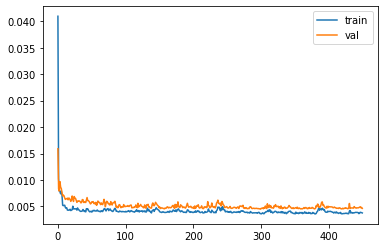

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_normalization_input (Inpu [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          batch_normalization_input[0][0]  
__________________________________________________________________________________________________
dense (Dense)                   (None, 35)           455         batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 35)           0           dense[0][0]                      
______________________________________________________________________________________________

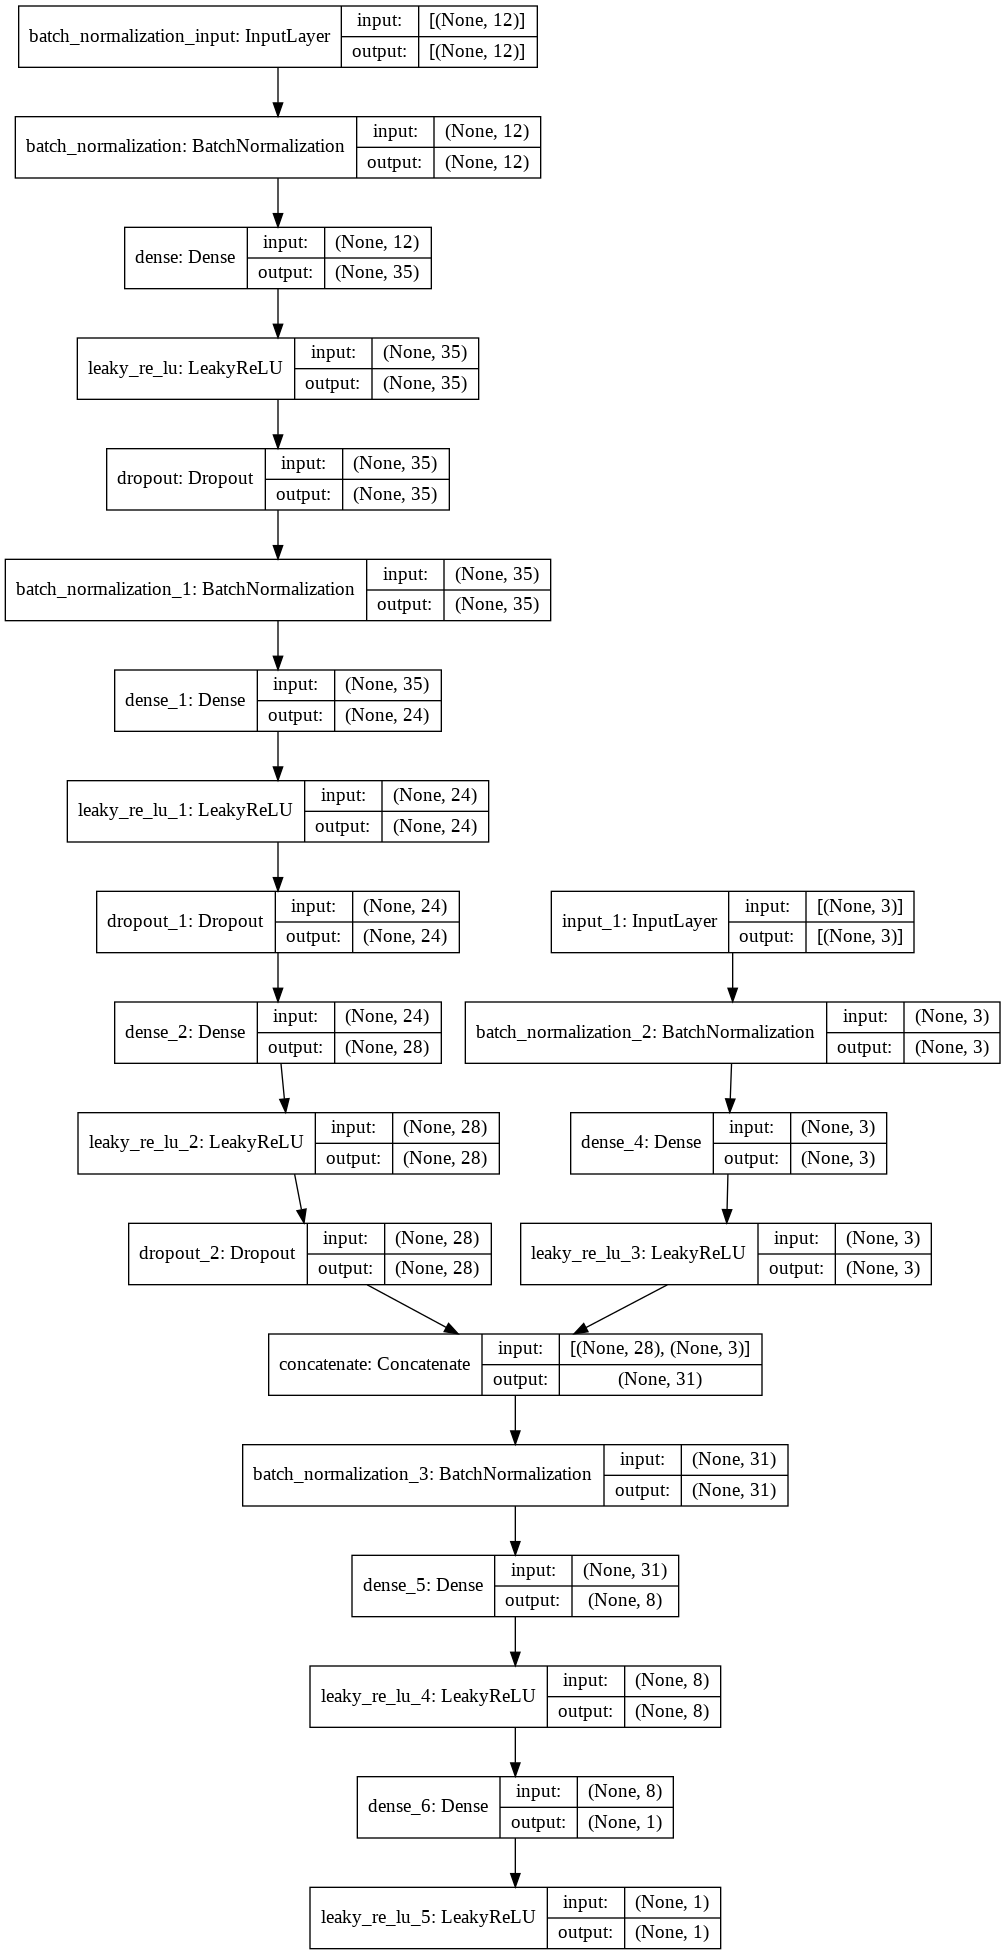

In [ ]:
model_fixed = load_model(precovid_model)
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

for i in range(0,len(model_fixed.layers)):
  model_fixed.layers[i].trainable = False

l1 = Input(shape=(3,))
l1_2 = BatchNormalization()(l1)
l2 = Dense(best_params2['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
l2_2 = LeakyReLU(alpha=best_params2['alpha'])(l2)
if best_params2['two_layer'] ==1 :
      l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_3])
else :
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_2])
merged2 = BatchNormalization()(merged)

if best_params2['last_layer'] ==0:
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)

if best_params2['last_layer'] ==1:
    l5 = Dense(best_params2['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
    l5_1 = LeakyReLU(alpha=best_params2['alpha'])(l5)
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)          

model = Model(inputs=[model_fixed.input,l1], outputs=l5_3)

opt = keras.optimizers.Adam(learning_rate=best_params2['learning_rate'])
model.compile(loss='mse',optimizer=opt)
fn_f = "gdrive/My Drive/Colab Notebooks/Stations/Training_CO_aftercovid.ckpt" 
fnn_f = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer

callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn_f, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=int(best_params2['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

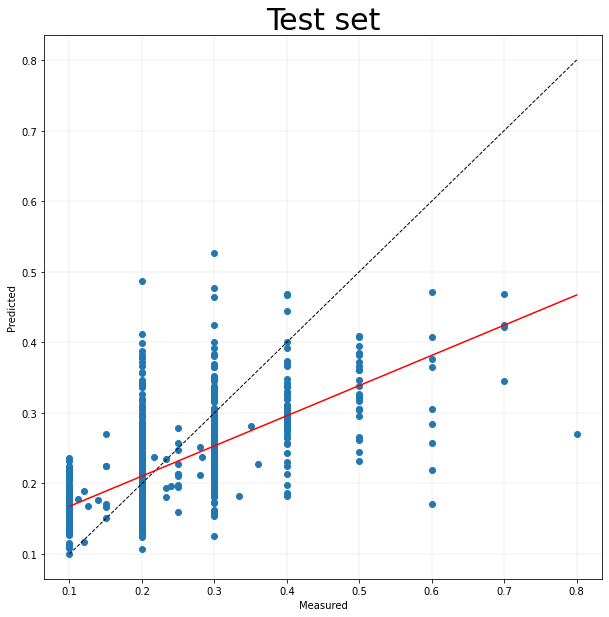

[0.42761824 0.12493499]
RMSE
[0.06297126]
R2
0.42194653306663965


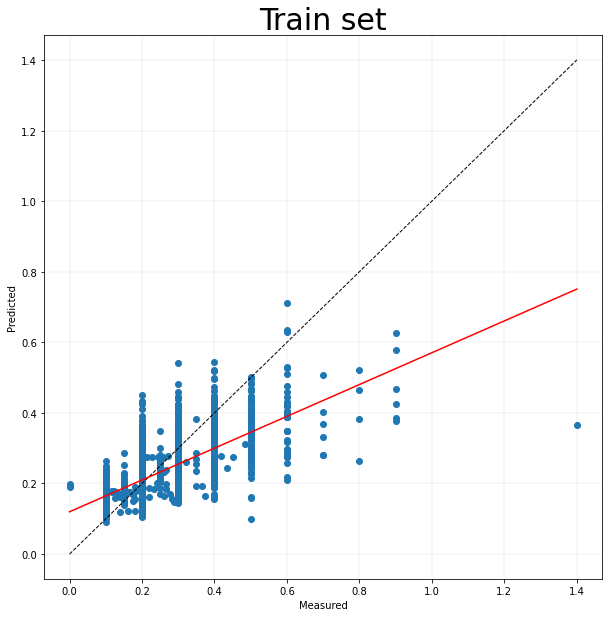

[0.45061179 0.11989867]
RMSE
[0.06110412]
R2
0.47311888956403503


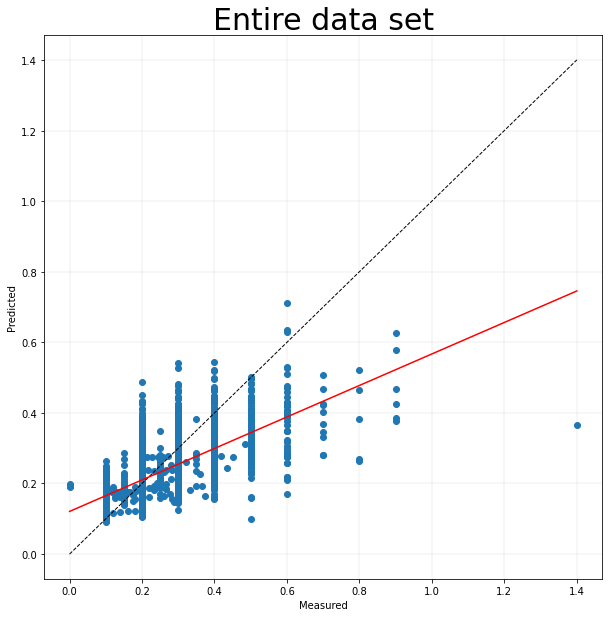

[0.4461315  0.12088052]
RMSE
[0.06148209]
R2
0.4631478722431982


In [ ]:
model.load_weights(fn_f )
model.save('gdrive/My Drive/Colab Notebooks/Model_Edmonton_east_after_Covid.h5')
preds = model.predict([X_test_a,X_test_b]) 
y_real = y_test_a.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

model.load_weights(fn_f)
preds = model.predict([X_train_a,X_train_b]) 
y_real_t = y_train_a.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
model.load_weights(fn_f)
preds = model.predict([X_a,X_b]) 
y_real_to = Y_a.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

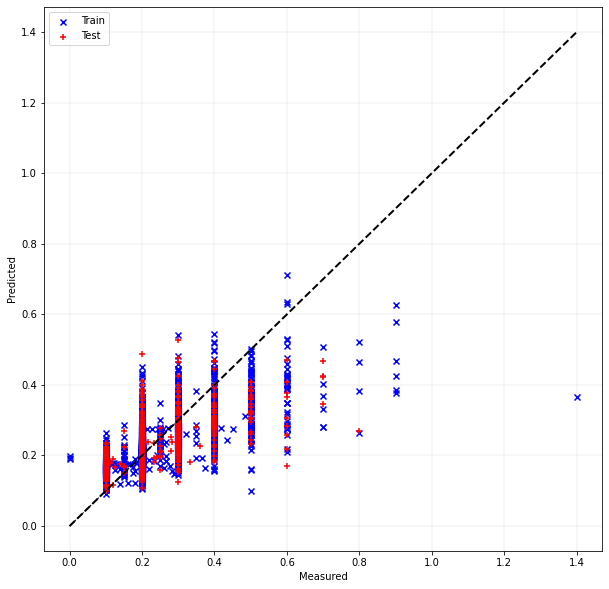

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.3], [0,0.3], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


In [ ]:
df2_w_c

CO(ppm)  T( C)  RH(%)  ...  driving  transit  walking
Date                                        ...                           
2020-01-13 00:00:00      0.1  -25.4   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 01:00:00      0.1  -25.7   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 02:00:00      0.1  -25.8   66.0  ...   1.0000   1.0000   1.0000
2020-01-13 03:00:00      0.1  -25.8   65.0  ...   1.0000   1.0000   1.0000
2020-01-13 04:00:00      0.1  -26.0   65.0  ...   1.0000   1.0000   1.0000
...                      ...    ...    ...  ...      ...      ...      ...
2021-01-31 19:00:00      0.4  -15.5   76.0  ...   0.7143   0.4266   0.8011
2021-01-31 20:00:00      0.4  -15.4   78.0  ...   0.7143   0.4266   0.8011
2021-01-31 21:00:00      0.2  -15.5   79.0  ...   0.7143   0.4266   0.8011
2021-01-31 22:00:00      0.2  -16.3   80.0  ...   0.7143   0.4266   0.8011
2021-01-31 23:00:00      0.2  -16.7   81.0  ...   0.7143   0.4266   0.8011

[9075 rows x 16 columns]

In [ ]:
# df3= df3.copy()
df4 = df2_w_c.copy()
df4['pred'] = model.predict([X_a,X_b])
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

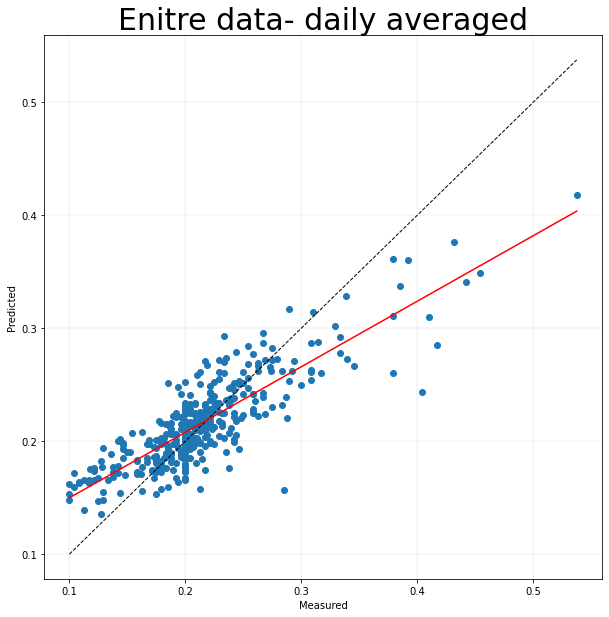

[0.57997188 0.09186987]
RMSE
[0.03240749]
R2
0.6798581783938966


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['CO(ppm)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


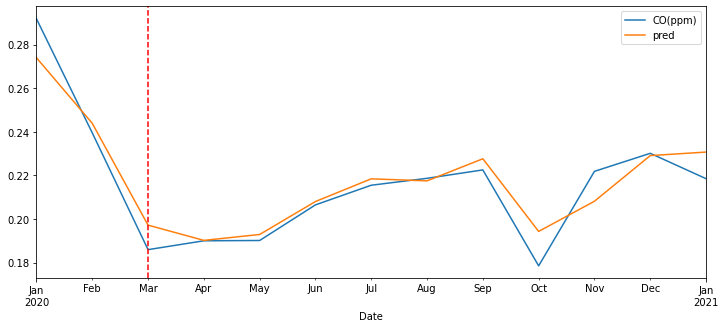

In [ ]:
df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df3_w_c = df2_w_c.copy()
df3_w_c['driving'] = 1.124019
df3_w_c['transit']  = 1.025378
df3_w_c['walking'] = 1.331329

In [ ]:
Y_a = df3_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df3_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df3_w_c[ ['driving', 'transit', 'walking']])




X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
# df3= df3.copy()
df44 = df3_w_c.copy()
df44['No lockdown'] = model.predict([X_a,X_b])
df104 = df44.resample('D').mean()
df104.dropna(inplace= True)

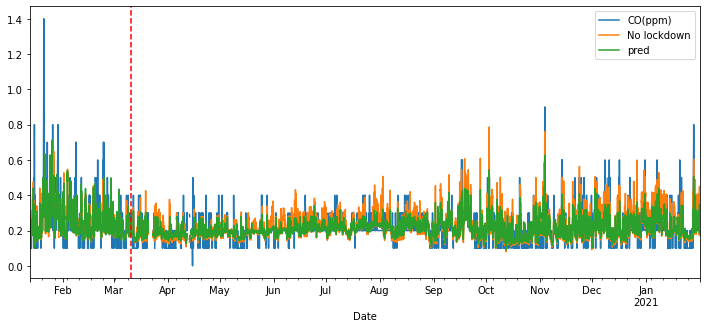

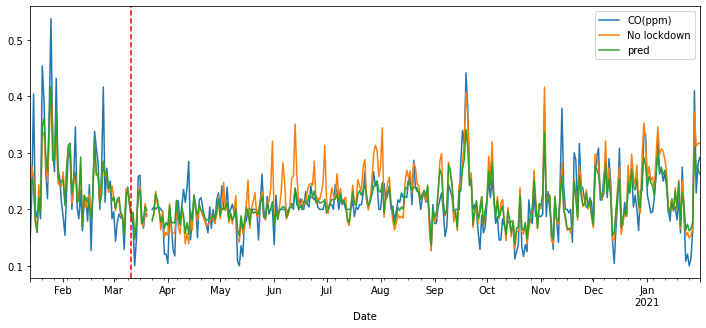

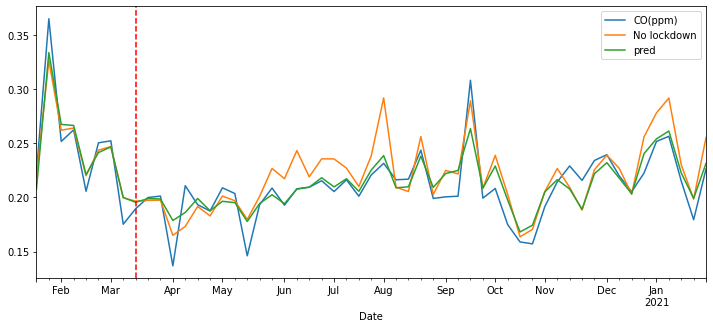

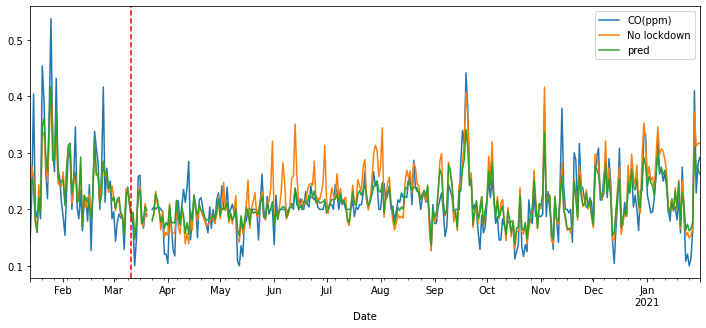

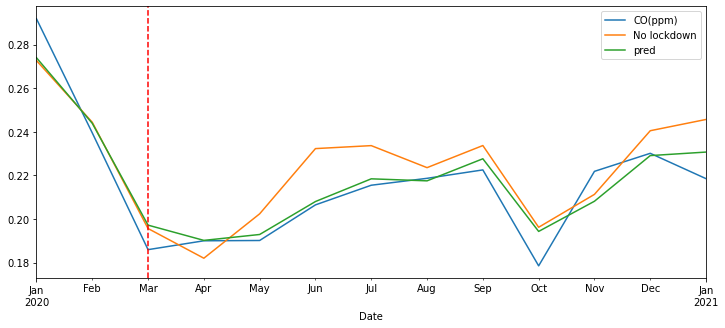

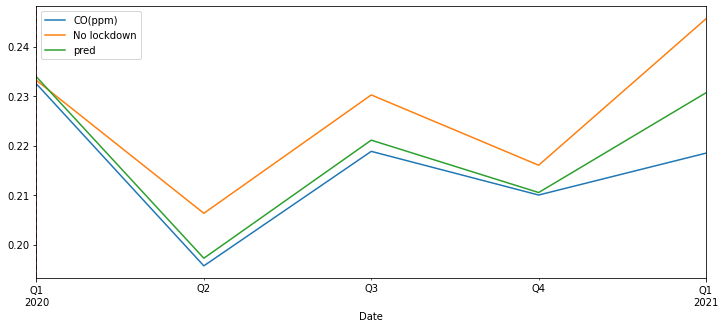

In [ ]:


df4['CO(ppm)'].resample('H').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('H').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('W').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('W').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()
df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('Q').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4['No lockdown']=df44['No lockdown'].copy()
print('No lockdown:',df4['No lockdown'].mean())
print('pred:',df4['pred'].mean())
print('CO(ppm):',df4['CO(ppm)'].mean())

No lockdown: 0.22312191128730774
pred: 0.2163834571838379
CO(ppm): 0.21406886884590973


In [ ]:
df4.head()

CO(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                        ...                                
2020-01-13 00:00:00      0.1  -25.4   68.0  ...      1.0  0.144256     0.140617
2020-01-13 01:00:00      0.1  -25.7   68.0  ...      1.0  0.154986     0.151347
2020-01-13 02:00:00      0.1  -25.8   66.0  ...      1.0  0.158600     0.154960
2020-01-13 03:00:00      0.1  -25.8   65.0  ...      1.0  0.166749     0.168830
2020-01-13 04:00:00      0.1  -26.0   65.0  ...      1.0  0.185634     0.212358

[5 rows x 18 columns]

In [ ]:
df4.to_csv('gdrive/My Drive/Colab Notebooks/Edmonton East/NOX_mobility_aftercov_Edmonton_east-COVID_hourly_pred.csv')

In [ ]:
df4

NOX(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                         ...                                
2020-01-13 00:00:00    0.0084  -25.4   68.0  ...   1.0000  0.012064     0.011699
2020-01-13 01:00:00    0.0078  -25.7   68.0  ...   1.0000  0.015269     0.014904
2020-01-13 02:00:00    0.0053  -25.8   66.0  ...   1.0000  0.015456     0.015090
2020-01-13 03:00:00    0.0050  -25.8   65.0  ...   1.0000  0.018650     0.018285
2020-01-13 04:00:00    0.0069  -26.0   65.0  ...   1.0000  0.023630     0.023264
...                       ...    ...    ...  ...      ...       ...          ...
2021-01-31 19:00:00    0.1137  -15.5   76.0  ...   0.8011  0.037565     0.041811
2021-01-31 20:00:00    0.1007  -15.4   78.0  ...   0.8011  0.024746     0.028993
2021-01-31 21:00:00    0.0515  -15.5   79.0  ...   0.8011  0.019648     0.023895
2021-01-31 22:00:00    0.0502  -16.3   80.0  ...   0.8011  0.030382     0.034629
2021-01-31 23:00:00    0.0408  -16.7   81.0  ...   0.8011  0.025745     0.029992

[9075 rows x 18 columns]